In [1]:
import mopdbrs2

In [2]:
import pg8000

In [3]:
creds = mopdbrs2.get_creds()

creds['ssl_context']=True

con = pg8000.connect(**creds) 


/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'midway-auth.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readth

In [4]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from dateutil.parser import parse
import math
import random 

In [5]:
sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2021-05-02'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, GETDATE())))))
      AND marketplace_id=7
    UNION
     SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_date)))) AS ship_week
    ,SUBSTRING(destination_postal_code,1,3) AS zipcode
    ,fulfillment_shipment_id AS OTM_OBCUST_PKG_REC_ID
    ,originating_fulfillment_center AS warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM perfectmile_ext.d_perfectmile_pkg_attributes_v2_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(originating_fulfillment_center) NOT IN ('PTOP')
      AND destination_country_code = 'CA'
      AND ship_week < trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, GETDATE()))))
      AND ship_week >= '2021-05-02'
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in (select "left"(destination_postal_code,3) as fsa
from perfectmile.d_perfectmile_pkg_attributes_v2_na
where marketplace_id = 7
and ship_date >= to_date('20200101','YYYYMMDD')
and not(left(fsa,1) ~ '^[0-9]')
group by 1
having count(*) > 1000)
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [6]:
mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
mod_df

,zipcode,pkgs
ship_week,,
2017-07-09,A0A,448
2017-07-09,A0B,233
2017-07-09,A0C,122
2017-07-09,A0E,226
2017-07-09,A0G,387
...,...,...
2021-07-25,X0G,3
2021-07-25,X1A,2474
2021-07-25,Y0A,15


In [5]:
mod_df = pd.read_csv(r'mod_data/mod_df.csv', parse_dates=['ship_week'], index_col='ship_week')
print(mod_df)

           zipcode  pkgs
ship_week               
2017-07-16     A0A   304
2017-07-16     A0B   162
2017-07-16     A0C    77
2017-07-16     A0E   184
2017-07-16     A0G   309
...            ...   ...
2021-08-01     X0G     4
2021-08-01     X1A  2246
2021-08-01     Y0A    13
2021-08-01     Y0B    47
2021-08-01     Y1A  3175

[348692 rows x 2 columns]


In [6]:
mod_8 = mod_df[(mod_df['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
mod_8

,zipcode,pkgs
ship_week,,
2017-07-16,G7Z,27
2017-07-16,G8J,33
2017-07-16,H0M,6
2017-07-16,H3C,1144
2017-07-16,K0K,2573
...,...,...
2021-08-01,H3C,4400
2021-08-01,K0K,17275
2021-08-01,N0B,12878


In [7]:
from fbprophet import Prophet 
from datetime import datetime

In [14]:
#extract M5K data for analysis
post_code = mod_df[mod_df.zipcode == 'R0K']
#post_code

In [10]:
#train
train_data = post_code[-4*212:160]

#test
test_data = post_code[-52:]

#forecast
fcst_data = post_code[-3*52:]

In [11]:
train = train_data.iloc[:,1]
train

ship_week
2017-07-16     418
2017-07-23     435
2017-07-30     466
2017-08-06     430
2017-08-13     468
              ... 
2020-07-05    1856
2020-07-12    1738
2020-07-19    1919
2020-07-26    1843
2020-08-02    1908
Name: pkgs, Length: 160, dtype: int64

In [12]:
test_data = post_code[-52:]
test = test_data.iloc[:,1]
#test

In [19]:
test_rst = test.reset_index()
#test_rst

In [17]:
#dir(Prophet)

In [13]:
data = train.to_frame()
data_train = data.reset_index()
data_train.columns =['ship_week', 'pkgs_num']
data_train.head()

,ship_week,pkgs_num
0,2017-07-16,418
1,2017-07-23,435
2,2017-07-30,466
3,2017-08-06,430
4,2017-08-13,468


In [21]:
data_train.columns = ['ds', 'y']
data_train.head()

,ds,y
0,2017-07-16,418
1,2017-07-23,435
2,2017-07-30,466
3,2017-08-06,430
4,2017-08-13,468


In [16]:
#perform Box-Cox transformation on original data
from scipy.stats import boxcox

transformed_data, best_lambda = boxcox(data_train['y']) 

data_train['y'], lam = boxcox(data_train['y'])

In [24]:
# data_train

In [17]:
#new_model_test = prophet()
#new_model_test.fit(data_train)
#rom fbprophet import prophet
m = Prophet(interval_width=0.95, weekly_seasonality=True)
model = m.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future = m.make_future_dataframe(periods=52, freq='W')
#future = model.predict(test_rst \ .rename(columns={'ship_week':'ds', 'pkgs': 'y'}))

In [26]:
# pred1 = m.make_future_dataframe(start=160, end=160+52-1)
# pred1.head(10)

In [20]:
forecast = m.predict(future)

In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-02,2.946332,2.922878,2.981810,2.946332,2.946332,0.004927,0.004927,0.004927,0.027631,0.027631,0.027631,-0.022704,-0.022704,-0.022704,0.0,0.0,0.0,2.951260
1,2017-07-09,2.947822,2.934386,3.000375,2.947822,2.947822,0.018406,0.018406,0.018406,0.027631,0.027631,0.027631,-0.009225,-0.009225,-0.009225,0.0,0.0,0.0,2.966228
2,2017-07-16,2.949311,2.938575,3.001267,2.949311,2.949311,0.020358,0.020358,0.020358,0.027631,0.027631,0.027631,-0.007273,-0.007273,-0.007273,0.0,0.0,0.0,2.969669
3,2017-07-23,2.950801,2.928590,2.993628,2.950801,2.950801,0.009370,0.009370,0.009370,0.027631,0.027631,0.027631,-0.018261,-0.018261,-0.018261,0.0,0.0,0.0,2.960171
4,2017-07-30,2.952290,2.916291,2.980520,2.952290,2.952290,-0.002852,-0.002852,-0.002852,0.027631,0.027631,0.027631,-0.030483,-0.030483,-0.030483,0.0,0.0,0.0,2.949438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021-06-20,3.255154,3.216633,3.285821,3.241296,3.270823,-0.004056,-0.004056,-0.004056,0.027631,0.027631,0.027631,-0.031687,-0.031687,-0.031687,0.0,0.0,0.0,3.251098
208,2021-06-27,3.257022,3.219335,3.288632,3.242793,3.272933,-0.003772,-0.003772,-0.003772,0.027631,0.027631,0.027631,-0.031404,-0.031404,-0.031404,0.0,0.0,0.0,3.253250
209,2021-07-04,3.258890,3.233201,3.302381,3.244159,3.275267,0.009224,0.009224,0.009224,0.027631,0.027631,0.027631,-0.018408,-0.018408,-0.018408,0.0,0.0,0.0,3.268114
210,2021-07-11,3.260758,3.245979,3.319865,3.245604,3.277686,0.020528,0.020528,0.020528,0.027631,0.027631,0.027631,-0.007103,-0.007103,-0.007103,0.0,0.0,0.0,3.281287


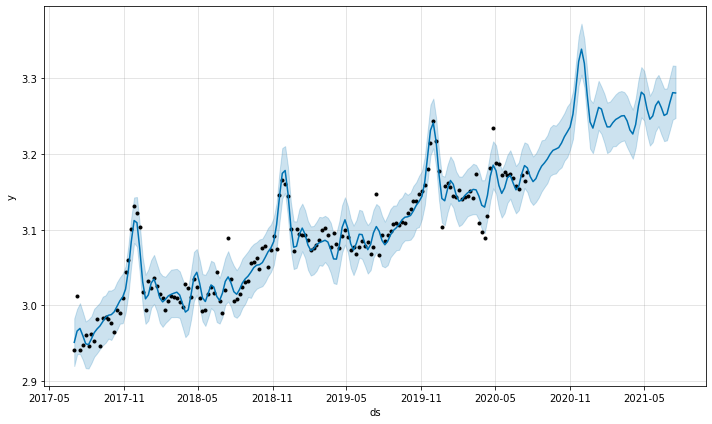

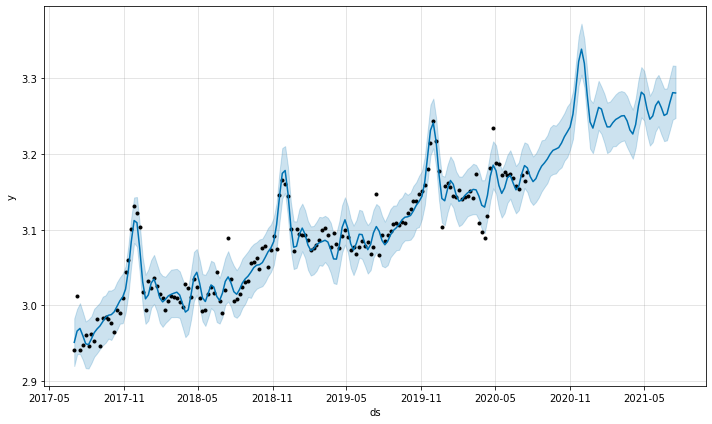

In [22]:
m.plot(forecast)

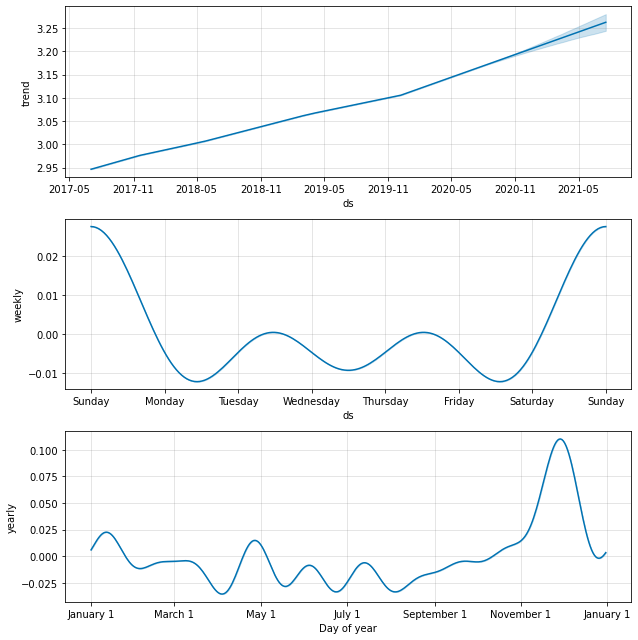

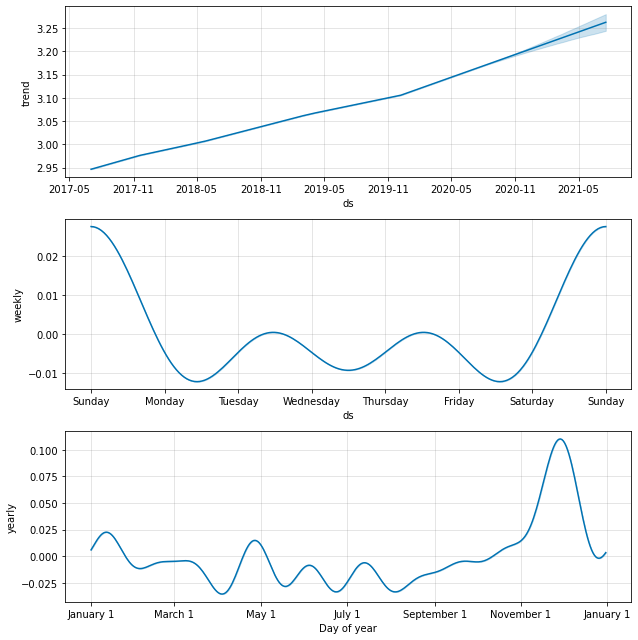

In [23]:
m.plot_components(forecast)

In [22]:
from scipy.special import inv_boxcox

In [23]:
# Apply inverse Box-Cox transform to specific forecast columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [24]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-02,2.946332,380.769910,522.554704,2.946332,2.946332,0.004927,0.004927,0.004927,0.027631,0.027631,0.027631,-0.022704,-0.022704,-0.022704,0.0,0.0,0.0,441.950359
1,2017-07-09,2.947822,404.187697,580.825962,2.947822,2.947822,0.018406,0.018406,0.018406,0.027631,0.027631,0.027631,-0.009225,-0.009225,-0.009225,0.0,0.0,0.0,479.294198
2,2017-07-16,2.949311,413.164519,583.830612,2.949311,2.949311,0.020358,0.020358,0.020358,0.027631,0.027631,0.027631,-0.007273,-0.007273,-0.007273,0.0,0.0,0.0,488.443883
3,2017-07-23,2.950801,392.170630,558.733957,2.950801,2.950801,0.009370,0.009370,0.009370,0.027631,0.027631,0.027631,-0.018261,-0.018261,-0.018261,0.0,0.0,0.0,463.715872
4,2017-07-30,2.952290,368.144273,518.790361,2.952290,2.952290,-0.002852,-0.002852,-0.002852,0.027631,0.027631,0.027631,-0.030483,-0.030483,-0.030483,0.0,0.0,0.0,437.662767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021-06-20,3.255154,2687.573309,5239.843035,3.241296,3.270823,-0.004056,-0.004056,-0.004056,0.027631,0.027631,0.027631,-0.031687,-0.031687,-0.031687,0.0,0.0,0.0,3690.963343
208,2021-06-27,3.257022,2752.550368,5398.865571,3.242793,3.272933,-0.003772,-0.003772,-0.003772,0.027631,0.027631,0.027631,-0.031404,-0.031404,-0.031404,0.0,0.0,0.0,3768.371191
209,2021-07-04,3.258890,3119.551702,6272.135362,3.244159,3.275267,0.009224,0.009224,0.009224,0.027631,0.027631,0.027631,-0.018408,-0.018408,-0.018408,0.0,0.0,0.0,4363.940951
210,2021-07-11,3.260758,3514.767702,7661.310872,3.245604,3.277686,0.020528,0.020528,0.020528,0.027631,0.027631,0.027631,-0.007103,-0.007103,-0.007103,0.0,0.0,0.0,4995.614236


In [25]:
fct = forecast[['ds', 'yhat']]
fct

,ds,yhat
0,2017-07-02,441.950359
1,2017-07-09,479.294198
2,2017-07-16,488.443883
3,2017-07-23,463.715872
4,2017-07-30,437.662767
...,...,...
207,2021-06-20,3690.963343
208,2021-06-27,3768.371191
209,2021-07-04,4363.940951
210,2021-07-11,4995.614236


In [26]:
fct_set = fct.set_index('ds')

In [27]:
fct_mask= fct_set[fct_set.index >='2020-07-19']
#fct_mask

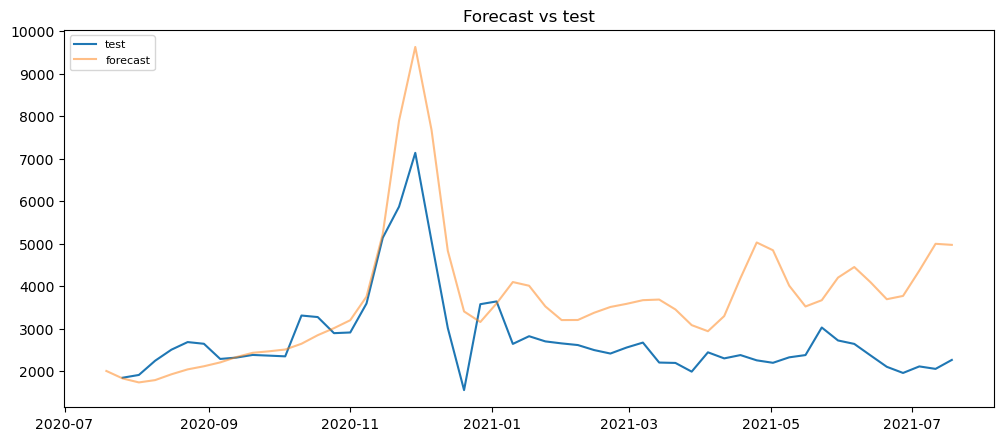

In [28]:
# Plot forecast vs actuals 
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='test')
#plt.plot(pred, label='pred')
plt.plot(fct_mask, label='forecast', alpha=.5)
plt.title('Forecast vs test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
data = train.to_frame()
train_new = data.reset_index()
train_new.columns =['ship_week', 'pkgs_num']
train_new.head()

,ship_week,pkgs_num
0,2017-07-02,419
1,2017-07-09,624
2,2017-07-16,418
3,2017-07-23,435
4,2017-07-30,466


In [32]:
train_new.columns = ['ds', 'y']
train_new.head()

,ds,y
0,2017-07-02,419
1,2017-07-09,624
2,2017-07-16,418
3,2017-07-23,435
4,2017-07-30,466


In [33]:
m = Prophet(interval_width=0.95, weekly_seasonality=True)
model = m.fit(train_new)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
fct = m.make_future_dataframe(periods=52, freq='W')
# fct

In [35]:
forecast1 = m.predict(fct)
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-02,432.370855,-43.162386,702.421340,432.370855,432.370855,-115.815991,-115.815991,-115.815991,41.380824,41.380824,41.380824,-157.196815,-157.196815,-157.196815,0.0,0.0,0.0,316.554863
1,2017-07-09,438.531298,104.374028,776.893359,438.531298,438.531298,-2.620618,-2.620618,-2.620618,41.380824,41.380824,41.380824,-44.001442,-44.001442,-44.001442,0.0,0.0,0.0,435.910679
2,2017-07-16,444.691740,83.698676,783.258965,444.691740,444.691740,7.216919,7.216919,7.216919,41.380824,41.380824,41.380824,-34.163905,-34.163905,-34.163905,0.0,0.0,0.0,451.908659
3,2017-07-23,450.852183,1.462553,753.386117,450.852183,450.852183,-75.091827,-75.091827,-75.091827,41.380824,41.380824,41.380824,-116.472651,-116.472651,-116.472651,0.0,0.0,0.0,375.760356
4,2017-07-30,457.012626,-7.025075,663.870710,457.012626,457.012626,-147.155903,-147.155903,-147.155903,41.380824,41.380824,41.380824,-188.536726,-188.536726,-188.536726,0.0,0.0,0.0,309.856724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021-06-20,2621.678989,2012.558506,2769.305405,2552.754167,2694.480288,-217.578801,-217.578801,-217.578801,41.380824,41.380824,41.380824,-258.959625,-258.959625,-258.959625,0.0,0.0,0.0,2404.100188
208,2021-06-27,2635.913428,2073.471942,2796.742427,2565.017009,2710.773336,-198.650680,-198.650680,-198.650680,41.380824,41.380824,41.380824,-240.031504,-240.031504,-240.031504,0.0,0.0,0.0,2437.262747
209,2021-07-04,2650.147866,2213.790729,2941.396558,2577.279850,2726.970026,-78.040361,-78.040361,-78.040361,41.380824,41.380824,41.380824,-119.421185,-119.421185,-119.421185,0.0,0.0,0.0,2572.107505
210,2021-07-11,2664.382304,2331.403049,3042.423963,2589.568287,2743.166716,12.994952,12.994952,12.994952,41.380824,41.380824,41.380824,-28.385872,-28.385872,-28.385872,0.0,0.0,0.0,2677.377256


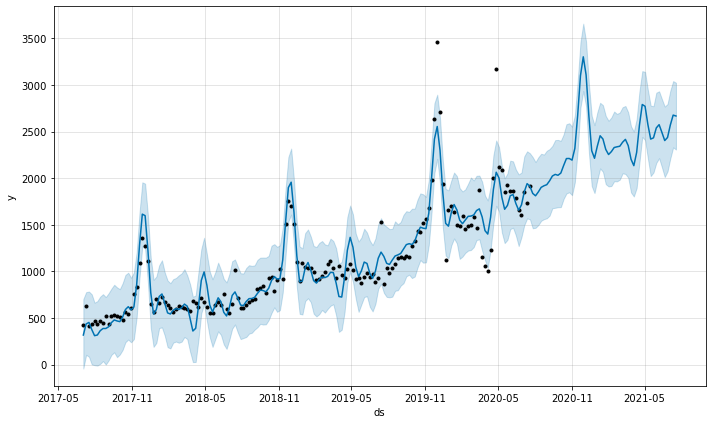

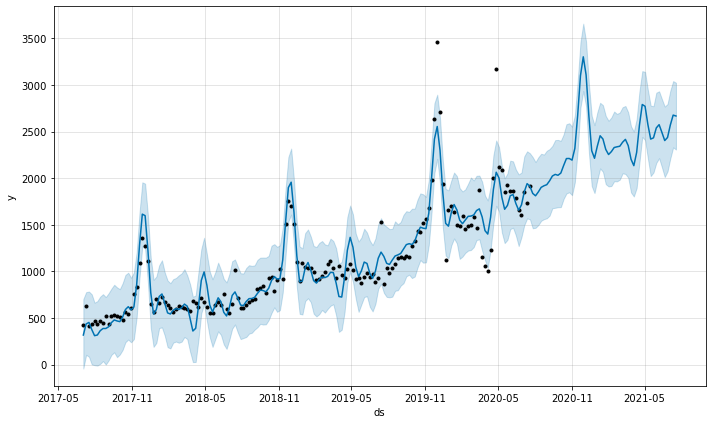

In [36]:
m.plot(forecast1)

In [37]:
fct_new = forecast1[['ds', 'yhat']]
fct_new

,ds,yhat
0,2017-07-02,316.554863
1,2017-07-09,435.910679
2,2017-07-16,451.908659
3,2017-07-23,375.760356
4,2017-07-30,309.856724
...,...,...
207,2021-06-20,2404.100188
208,2021-06-27,2437.262747
209,2021-07-04,2572.107505
210,2021-07-11,2677.377256


In [95]:
fct_new_set = fct_new.set_index('ds')

In [39]:
fct_mask_upd= fct_new_set[fct_new_set.index >='2020-07-19']
#fct_mask_upd

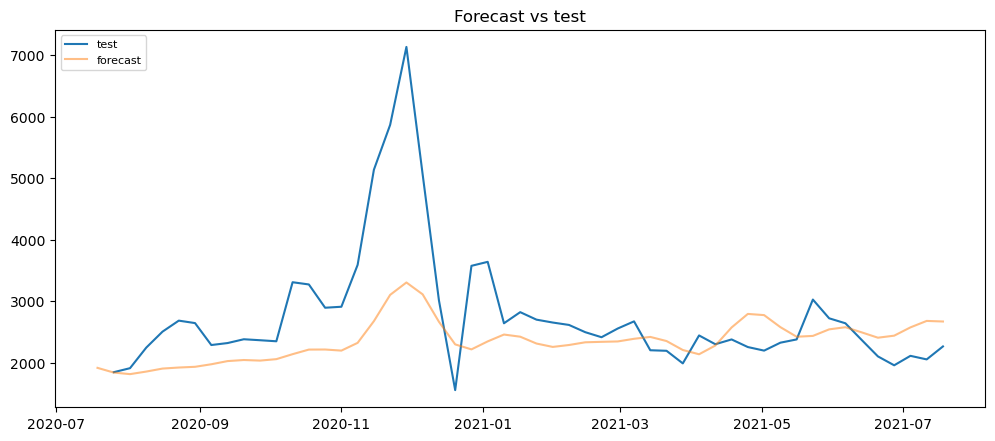

In [40]:
# Plot forecast vs actuals 
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='test')
#plt.plot(mask_mod, label='test')
#plt.plot(pred, label='pred')
plt.plot(fct_mask_upd, label='forecast', alpha=.5)
plt.title('Forecast vs test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
import warnings;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import multiprocessing as mp
from itertools import zip_longest
import time

In [26]:
from tqdm import tqdm_notebook
from itertools import product
import warnings;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [27]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA 

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm

In [26]:
def run_V3_models(df):
    
        #zipcode = df[0]
        #df = df[1]
        #print(df)
    #input from the model 
    #try:
    
        #training the model
        train_data = df[-4*212:160]
        print(train_data)
        train = train_data.iloc[:,1]
        data = train.to_frame()
        data_train = data.reset_index()
        data_train.columns =['ship_week', 'pkgs_num']
        
        #change the column names 
        data_train.columns = ['ds', 'y']
        
        #fit model
        m = Prophet(interval_width=0.95, weekly_seasonality=True)
        model = m.fit(data_train)
        future = m.make_future_dataframe(periods=52, freq='W')
        
        forecast = m.predict(future)
        forecast = pd.DataFrame(forecast)
       # forecast.columns= ['pred_V3']
        forecast['zipcode'] = df['zipcode'].unique()[0]
    
    
        return forecast

In [24]:
#extract R0K from the fxn 
# result = run_V3_models(mod_df[mod_df['zipcode']=='R0K'])
# result

In [59]:
zipcodes = list(mod_df.zipcode.unique())
#len(zipcodes)

In [60]:
fct_v3=[]

for zipcode in zipcodes:
    sub_df = mod_df[mod_df['zipcode']==zipcode]
    
    forecast = run_V3_models(sub_df)
    fct_v3.append(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0A   341
2017-07-09     A0A   448
2017-07-16     A0A   304
2017-07-23     A0A   294
2017-07-30     A0A   338
...            ...   ...
2020-06-21     A0A  1826
2020-06-28     A0A  1574
2020-07-05     A0A  1897
2020-07-12     A0A  1903
2020-07-19     A0A  1739

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0B   161
2017-07-09     A0B   233
2017-07-16     A0B   162
2017-07-23     A0B   151
2017-07-30     A0B   199
...            ...   ...
2020-06-21     A0B   843
2020-06-28     A0B   724
2020-07-05     A0B   878
2020-07-12     A0B   871
2020-07-19     A0B   832

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0C    77
2017-07-09     A0C   122
2017-07-16     A0C    77
2017-07-23     A0C    72
2017-07-30     A0C    90
...            ...   ...
2020-06-21     A0C   455
2020-06-28     A0C   405
2020-07-05     A0C   512
2020-07-12     A0C   479
2020-07-19     A0C   491

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0E   173
2017-07-09     A0E   226
2017-07-16     A0E   184
2017-07-23     A0E   156
2017-07-30     A0E   163
...            ...   ...
2020-06-21     A0E   803
2020-06-28     A0E   765
2020-07-05     A0E   817
2020-07-12     A0E   916
2020-07-19     A0E   883

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0G   300
2017-07-09     A0G   387
2017-07-16     A0G   309
2017-07-23     A0G   310
2017-07-30     A0G   332
...            ...   ...
2020-06-21     A0G  1648
2020-06-28     A0G  1465
2020-07-05     A0G  1740
2020-07-12     A0G  1656
2020-07-19     A0G  1667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0H   166
2017-07-09     A0H   236
2017-07-16     A0H   182
2017-07-23     A0H   162
2017-07-30     A0H   154
...            ...   ...
2020-06-21     A0H   802
2020-06-28     A0H   707
2020-07-05     A0H   793
2020-07-12     A0H   833
2020-07-19     A0H   945

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0J   102
2017-07-09     A0J   143
2017-07-16     A0J    84
2017-07-23     A0J    82
2017-07-30     A0J    80
...            ...   ...
2020-06-21     A0J   457
2020-06-28     A0J   378
2020-07-05     A0J   497
2020-07-12     A0J   457
2020-07-19     A0J   486

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0K   170
2017-07-09     A0K   225
2017-07-16     A0K   182
2017-07-23     A0K   189
2017-07-30     A0K   188
...            ...   ...
2020-06-21     A0K   990
2020-06-28     A0K   938
2020-07-05     A0K   948
2020-07-12     A0K  1026
2020-07-19     A0K   991

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0L    97
2017-07-09     A0L   118
2017-07-16     A0L    88
2017-07-23     A0L    78
2017-07-30     A0L   122
...            ...   ...
2020-06-21     A0L   559
2020-06-28     A0L   422
2020-07-05     A0L   545
2020-07-12     A0L   530
2020-07-19     A0L   528

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0M    63
2017-07-09     A0M    86
2017-07-16     A0M    97
2017-07-23     A0M    79
2017-07-30     A0M    69
...            ...   ...
2020-06-21     A0M   344
2020-06-28     A0M   337
2020-07-05     A0M   372
2020-07-12     A0M   370
2020-07-19     A0M   381

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0N   124
2017-07-09     A0N   204
2017-07-16     A0N   170
2017-07-23     A0N   135
2017-07-30     A0N   177
...            ...   ...
2020-06-21     A0N   746
2020-06-28     A0N   757
2020-07-05     A0N   833
2020-07-12     A0N   832
2020-07-19     A0N   818

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0P   430
2017-07-09     A0P   671
2017-07-16     A0P   474
2017-07-23     A0P   503
2017-07-30     A0P   508
...            ...   ...
2020-06-21     A0P  1645
2020-06-28     A0P  1338
2020-07-05     A0P  1591
2020-07-12     A0P  1436
2020-07-19     A0P  1452

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A0R    89
2017-07-09     A0R   166
2017-07-16     A0R    77
2017-07-23     A0R    80
2017-07-30     A0R    56
...            ...   ...
2020-06-21     A0R   298
2020-06-28     A0R   280
2020-07-05     A0R   425
2020-07-12     A0R   341
2020-07-19     A0R   349

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1A   465
2017-07-09     A1A   727
2017-07-16     A1A   548
2017-07-23     A1A   487
2017-07-30     A1A   488
...            ...   ...
2020-06-21     A1A  1940
2020-06-28     A1A  1622
2020-07-05     A1A  2030
2020-07-12     A1A  1915
2020-07-19     A1A  1766

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1B   457
2017-07-09     A1B   846
2017-07-16     A1B   552
2017-07-23     A1B   493
2017-07-30     A1B   532
...            ...   ...
2020-06-21     A1B  1539
2020-06-28     A1B  1306
2020-07-05     A1B  1684
2020-07-12     A1B  1581
2020-07-19     A1B  1391

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1C   237
2017-07-09     A1C   454
2017-07-16     A1C   323
2017-07-23     A1C   256
2017-07-30     A1C   288
...            ...   ...
2020-06-21     A1C   958
2020-06-28     A1C   681
2020-07-05     A1C   934
2020-07-12     A1C   928
2020-07-19     A1C   737

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1E   374
2017-07-09     A1E   618
2017-07-16     A1E   388
2017-07-23     A1E   412
2017-07-30     A1E   403
...            ...   ...
2020-06-21     A1E  1633
2020-06-28     A1E  1319
2020-07-05     A1E  1659
2020-07-12     A1E  1496
2020-07-19     A1E  1355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1G    61
2017-07-09     A1G   120
2017-07-16     A1G    76
2017-07-23     A1G    77
2017-07-30     A1G    82
...            ...   ...
2020-06-21     A1G   395
2020-06-28     A1G   318
2020-07-05     A1G   373
2020-07-12     A1G   357
2020-07-19     A1G   316

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1H   105
2017-07-09     A1H   149
2017-07-16     A1H    88
2017-07-23     A1H   107
2017-07-30     A1H    97
...            ...   ...
2020-06-21     A1H   483
2020-06-28     A1H   425
2020-07-05     A1H   512
2020-07-12     A1H   448
2020-07-19     A1H   416

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1K   136
2017-07-09     A1K   244
2017-07-16     A1K   163
2017-07-23     A1K   147
2017-07-30     A1K   202
...            ...   ...
2020-06-21     A1K   806
2020-06-28     A1K   627
2020-07-05     A1K   814
2020-07-12     A1K   726
2020-07-19     A1K   705

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1L   311
2017-07-09     A1L   551
2017-07-16     A1L   369
2017-07-23     A1L   373
2017-07-30     A1L   360
...            ...   ...
2020-06-21     A1L  1910
2020-06-28     A1L  1585
2020-07-05     A1L  1840
2020-07-12     A1L  1772
2020-07-19     A1L  1566

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1M    92
2017-07-09     A1M   148
2017-07-16     A1M   141
2017-07-23     A1M   105
2017-07-30     A1M   125
...            ...   ...
2020-06-21     A1M   647
2020-06-28     A1M   498
2020-07-05     A1M   630
2020-07-12     A1M   576
2020-07-19     A1M   556

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1N   316
2017-07-09     A1N   552
2017-07-16     A1N   367
2017-07-23     A1N   343
2017-07-30     A1N   348
...            ...   ...
2020-06-21     A1N  1458
2020-06-28     A1N  1238
2020-07-05     A1N  1562
2020-07-12     A1N  1476
2020-07-19     A1N  1278

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1S    55
2017-07-09     A1S    65
2017-07-16     A1S    57
2017-07-23     A1S    56
2017-07-30     A1S    69
...            ...   ...
2020-06-21     A1S   363
2020-06-28     A1S   295
2020-07-05     A1S   362
2020-07-12     A1S   324
2020-07-19     A1S   315

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1V   185
2017-07-09     A1V   289
2017-07-16     A1V   205
2017-07-23     A1V   214
2017-07-30     A1V   216
...            ...   ...
2020-06-21     A1V   986
2020-06-28     A1V   770
2020-07-05     A1V   971
2020-07-12     A1V   956
2020-07-19     A1V   897

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1W   166
2017-07-09     A1W   214
2017-07-16     A1W   168
2017-07-23     A1W   157
2017-07-30     A1W   156
...            ...   ...
2020-06-21     A1W   838
2020-06-28     A1W   650
2020-07-05     A1W   816
2020-07-12     A1W   782
2020-07-19     A1W   708

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1X   149
2017-07-09     A1X   214
2017-07-16     A1X   181
2017-07-23     A1X   188
2017-07-30     A1X   198
...            ...   ...
2020-06-21     A1X  1185
2020-06-28     A1X   919
2020-07-05     A1X  1089
2020-07-12     A1X  1031
2020-07-19     A1X   998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A1Y    45
2017-07-09     A1Y    74
2017-07-16     A1Y    59
2017-07-23     A1Y    42
2017-07-30     A1Y    41
...            ...   ...
2020-06-21     A1Y   265
2020-06-28     A1Y   193
2020-07-05     A1Y   240
2020-07-12     A1Y   250
2020-07-19     A1Y   242

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A2A   128
2017-07-09     A2A   194
2017-07-16     A2A   155
2017-07-23     A2A   172
2017-07-30     A2A   180
...            ...   ...
2020-06-21     A2A   646
2020-06-28     A2A   563
2020-07-05     A2A   756
2020-07-12     A2A   713
2020-07-19     A2A   697

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A2B    40
2017-07-09     A2B    70
2017-07-16     A2B    57
2017-07-23     A2B    46
2017-07-30     A2B    48
...            ...   ...
2020-06-21     A2B   261
2020-06-28     A2B   201
2020-07-05     A2B   288
2020-07-12     A2B   265
2020-07-19     A2B   260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A2H   342
2017-07-09     A2H   456
2017-07-16     A2H   425
2017-07-23     A2H   397
2017-07-30     A2H   395
...            ...   ...
2020-06-21     A2H  1920
2020-06-28     A2H  1462
2020-07-05     A2H  1993
2020-07-12     A2H  2010
2020-07-19     A2H  1931

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A2N   165
2017-07-09     A2N   188
2017-07-16     A2N   124
2017-07-23     A2N   159
2017-07-30     A2N   153
...            ...   ...
2020-06-21     A2N   657
2020-06-28     A2N   569
2020-07-05     A2N   755
2020-07-12     A2N   745
2020-07-19     A2N   702

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A2V   168
2017-07-09     A2V   275
2017-07-16     A2V   180
2017-07-23     A2V   193
2017-07-30     A2V   171
...            ...   ...
2020-06-21     A2V   995
2020-06-28     A2V   837
2020-07-05     A2V  1052
2020-07-12     A2V   911
2020-07-19     A2V   980

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A5A   107
2017-07-09     A5A   147
2017-07-16     A5A   112
2017-07-23     A5A   129
2017-07-30     A5A   127
...            ...   ...
2020-06-21     A5A   530
2020-06-28     A5A   418
2020-07-05     A5A   539
2020-07-12     A5A   458
2020-07-19     A5A   499

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     A8A    98
2017-07-09     A8A   143
2017-07-16     A8A   110
2017-07-23     A8A   100
2017-07-30     A8A    76
...            ...   ...
2020-06-21     A8A   570
2020-06-28     A8A   412
2020-07-05     A8A   607
2020-07-12     A8A   548
2020-07-19     A8A   511

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0C    99
2017-07-09     B0C   147
2017-07-16     B0C   136
2017-07-23     B0C   110
2017-07-30     B0C    97
...            ...   ...
2020-06-21     B0C   357
2020-06-28     B0C   334
2020-07-05     B0C   365
2020-07-12     B0C   388
2020-07-19     B0C   402

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0E   533
2017-07-09     B0E   786
2017-07-16     B0E   608
2017-07-23     B0E   580
2017-07-30     B0E   635
...            ...   ...
2020-06-21     B0E  2302
2020-06-28     B0E  2134
2020-07-05     B0E  2389
2020-07-12     B0E  2494
2020-07-19     B0E  2484

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0H   118
2017-07-09     B0H   188
2017-07-16     B0H   154
2017-07-23     B0H   139
2017-07-30     B0H   150
...            ...   ...
2020-06-21     B0H   632
2020-06-28     B0H   643
2020-07-05     B0H   724
2020-07-12     B0H   760
2020-07-19     B0H   729

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0J   832
2017-07-09     B0J  1108
2017-07-16     B0J   891
2017-07-23     B0J   815
2017-07-30     B0J   922
...            ...   ...
2020-06-21     B0J  3927
2020-06-28     B0J  3630
2020-07-05     B0J  4404
2020-07-12     B0J  4377
2020-07-19     B0J  4241

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0K   474
2017-07-09     B0K   773
2017-07-16     B0K   596
2017-07-23     B0K   564
2017-07-30     B0K   551
...            ...   ...
2020-06-21     B0K  2863
2020-06-28     B0K  2257
2020-07-05     B0K  3057
2020-07-12     B0K  3039
2020-07-19     B0K  3170

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0L    14
2017-07-09     B0L    23
2017-07-16     B0L    33
2017-07-23     B0L    18
2017-07-30     B0L    31
...            ...   ...
2020-06-21     B0L   112
2020-06-28     B0L   115
2020-07-05     B0L   145
2020-07-12     B0L   170
2020-07-19     B0L   170

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0M   257
2017-07-09     B0M   374
2017-07-16     B0M   311
2017-07-23     B0M   300
2017-07-30     B0M   258
...            ...   ...
2020-06-21     B0M  1302
2020-06-28     B0M  1024
2020-07-05     B0M  1381
2020-07-12     B0M  1460
2020-07-19     B0M  1551

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0N   541
2017-07-09     B0N   875
2017-07-16     B0N   682
2017-07-23     B0N   654
2017-07-30     B0N   585
...            ...   ...
2020-06-21     B0N  3366
2020-06-28     B0N  2622
2020-07-05     B0N  3360
2020-07-12     B0N  3329
2020-07-19     B0N  3384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0P   795
2017-07-09     B0P  1080
2017-07-16     B0P   911
2017-07-23     B0P   822
2017-07-30     B0P   855
...            ...   ...
2020-06-21     B0P  3356
2020-06-28     B0P  3054
2020-07-05     B0P  3671
2020-07-12     B0P  3627
2020-07-19     B0P  3645

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0R    82
2017-07-09     B0R   114
2017-07-16     B0R   102
2017-07-23     B0R    88
2017-07-30     B0R    95
...            ...   ...
2020-06-21     B0R   467
2020-06-28     B0R   492
2020-07-05     B0R   517
2020-07-12     B0R   573
2020-07-19     B0R   590

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0S   334
2017-07-09     B0S   454
2017-07-16     B0S   320
2017-07-23     B0S   341
2017-07-30     B0S   364
...            ...   ...
2020-06-21     B0S  1403
2020-06-28     B0S  1277
2020-07-05     B0S  1628
2020-07-12     B0S  1702
2020-07-19     B0S  1623

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0T   333
2017-07-09     B0T   349
2017-07-16     B0T   252
2017-07-23     B0T   273
2017-07-30     B0T   285
...            ...   ...
2020-06-21     B0T  1372
2020-06-28     B0T  1235
2020-07-05     B0T  1411
2020-07-12     B0T  1567
2020-07-19     B0T  1411

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0V    76
2017-07-09     B0V   115
2017-07-16     B0V    95
2017-07-23     B0V    92
2017-07-30     B0V    74
...            ...   ...
2020-06-21     B0V   445
2020-06-28     B0V   387
2020-07-05     B0V   419
2020-07-12     B0V   435
2020-07-19     B0V   464

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B0W   392
2017-07-09     B0W   554
2017-07-16     B0W   389
2017-07-23     B0W   414
2017-07-30     B0W   424
...            ...   ...
2020-06-21     B0W  1770
2020-06-28     B0W  1676
2020-07-05     B0W  1828
2020-07-12     B0W  1919
2020-07-19     B0W  1960

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1A   247
2017-07-09     B1A   335
2017-07-16     B1A   284
2017-07-23     B1A   243
2017-07-30     B1A   248
...            ...   ...
2020-06-21     B1A  1210
2020-06-28     B1A  1111
2020-07-05     B1A  1319
2020-07-12     B1A  1359
2020-07-19     B1A  1511

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1B    15
2017-07-09     B1B    38
2017-07-16     B1B    18
2017-07-23     B1B    18
2017-07-30     B1B    30
...            ...   ...
2020-06-21     B1B    94
2020-06-28     B1B    93
2020-07-05     B1B   117
2020-07-12     B1B   127
2020-07-19     B1B   100

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1C    26
2017-07-09     B1C    33
2017-07-16     B1C    41
2017-07-23     B1C    44
2017-07-30     B1C    31
...            ...   ...
2020-06-21     B1C   127
2020-06-28     B1C   112
2020-07-05     B1C   102
2020-07-12     B1C   113
2020-07-19     B1C   129

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1E    42
2017-07-09     B1E    52
2017-07-16     B1E    33
2017-07-23     B1E    32
2017-07-30     B1E    52
...            ...   ...
2020-06-21     B1E   117
2020-06-28     B1E    95
2020-07-05     B1E   112
2020-07-12     B1E   118
2020-07-19     B1E   114

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1G    43
2017-07-09     B1G    44
2017-07-16     B1G    28
2017-07-23     B1G    26
2017-07-30     B1G    28
...            ...   ...
2020-06-21     B1G   138
2020-06-28     B1G   126
2020-07-05     B1G   117
2020-07-12     B1G   142
2020-07-19     B1G   145

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1H   146
2017-07-09     B1H   218
2017-07-16     B1H   144
2017-07-23     B1H   137
2017-07-30     B1H   162
...            ...   ...
2020-06-21     B1H   678
2020-06-28     B1H   624
2020-07-05     B1H   758
2020-07-12     B1H   707
2020-07-19     B1H   818

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1J    18
2017-07-09     B1J    40
2017-07-16     B1J    17
2017-07-23     B1J    19
2017-07-30     B1J    21
...            ...   ...
2020-06-21     B1J    84
2020-06-28     B1J    91
2020-07-05     B1J    92
2020-07-12     B1J    86
2020-07-19     B1J    89

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1K    67
2017-07-09     B1K   113
2017-07-16     B1K    69
2017-07-23     B1K    66
2017-07-30     B1K    54
...            ...   ...
2020-06-21     B1K   234
2020-06-28     B1K   244
2020-07-05     B1K   279
2020-07-12     B1K   289
2020-07-19     B1K   295

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1L    75
2017-07-09     B1L   109
2017-07-16     B1L   100
2017-07-23     B1L    81
2017-07-30     B1L   109
...            ...   ...
2020-06-21     B1L   407
2020-06-28     B1L   342
2020-07-05     B1L   409
2020-07-12     B1L   413
2020-07-19     B1L   439

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1M    17
2017-07-09     B1M    30
2017-07-16     B1M    41
2017-07-23     B1M    37
2017-07-30     B1M    22
...            ...   ...
2020-06-21     B1M   114
2020-06-28     B1M   113
2020-07-05     B1M   122
2020-07-12     B1M   120
2020-07-19     B1M   130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1N    83
2017-07-09     B1N   112
2017-07-16     B1N    98
2017-07-23     B1N    91
2017-07-30     B1N    97
...            ...   ...
2020-06-21     B1N   426
2020-06-28     B1N   387
2020-07-05     B1N   438
2020-07-12     B1N   461
2020-07-19     B1N   501

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1P   279
2017-07-09     B1P   418
2017-07-16     B1P   320
2017-07-23     B1P   309
2017-07-30     B1P   299
...            ...   ...
2020-06-21     B1P  1112
2020-06-28     B1P  1051
2020-07-05     B1P  1262
2020-07-12     B1P  1300
2020-07-19     B1P  1242

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1R    87
2017-07-09     B1R   137
2017-07-16     B1R   102
2017-07-23     B1R   102
2017-07-30     B1R    99
...            ...   ...
2020-06-21     B1R   400
2020-06-28     B1R   368
2020-07-05     B1R   412
2020-07-12     B1R   455
2020-07-19     B1R   442

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1S   164
2017-07-09     B1S   230
2017-07-16     B1S   174
2017-07-23     B1S   171
2017-07-30     B1S   159
...            ...   ...
2020-06-21     B1S   705
2020-06-28     B1S   634
2020-07-05     B1S   715
2020-07-12     B1S   736
2020-07-19     B1S   757

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1T     6
2017-07-09     B1T     8
2017-07-16     B1T     9
2017-07-23     B1T     8
2017-07-30     B1T    12
...            ...   ...
2020-06-21     B1T    24
2020-06-28     B1T    18
2020-07-05     B1T    30
2020-07-12     B1T    33
2020-07-19     B1T    25

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1V   118
2017-07-09     B1V   150
2017-07-16     B1V   102
2017-07-23     B1V   145
2017-07-30     B1V   104
...            ...   ...
2020-06-21     B1V   484
2020-06-28     B1V   433
2020-07-05     B1V   409
2020-07-12     B1V   481
2020-07-19     B1V   592

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1W    22
2017-07-09     B1W    26
2017-07-16     B1W    26
2017-07-23     B1W    23
2017-07-30     B1W    33
...            ...   ...
2020-06-21     B1W   320
2020-06-28     B1W   300
2020-07-05     B1W   331
2020-07-12     B1W   379
2020-07-19     B1W   339

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1X    22
2017-07-09     B1X    26
2017-07-16     B1X    31
2017-07-23     B1X    23
2017-07-30     B1X    25
...            ...   ...
2020-06-21     B1X   106
2020-06-28     B1X    84
2020-07-05     B1X    90
2020-07-12     B1X   104
2020-07-19     B1X    90

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B1Y   137
2017-07-09     B1Y   148
2017-07-16     B1Y   103
2017-07-23     B1Y   116
2017-07-30     B1Y   113
...            ...   ...
2020-06-21     B1Y   500
2020-06-28     B1Y   388
2020-07-05     B1Y   505
2020-07-12     B1Y   499
2020-07-19     B1Y   521

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2A   125
2017-07-09     B2A   146
2017-07-16     B2A   135
2017-07-23     B2A   123
2017-07-30     B2A   114
...            ...   ...
2020-06-21     B2A   495
2020-06-28     B2A   519
2020-07-05     B2A   657
2020-07-12     B2A   623
2020-07-19     B2A   672

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2C    12
2017-07-09     B2C     8
2017-07-16     B2C     7
2017-07-23     B2C     4
2017-07-30     B2C     2
...            ...   ...
2020-06-21     B2C    28
2020-06-28     B2C    17
2020-07-05     B2C    22
2020-07-12     B2C    30
2020-07-19     B2C    22

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2G   288
2017-07-09     B2G   462
2017-07-16     B2G   339
2017-07-23     B2G   306
2017-07-30     B2G   345
...            ...   ...
2020-06-21     B2G  1165
2020-06-28     B2G  1110
2020-07-05     B2G  1194
2020-07-12     B2G  1390
2020-07-19     B2G  1356

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2H   254
2017-07-09     B2H   410
2017-07-16     B2H   260
2017-07-23     B2H   264
2017-07-30     B2H   253
...            ...   ...
2020-06-21     B2H  1204
2020-06-28     B2H  1169
2020-07-05     B2H  1334
2020-07-12     B2H  1456
2020-07-19     B2H  1443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2N   375
2017-07-09     B2N   598
2017-07-16     B2N   374
2017-07-23     B2N   370
2017-07-30     B2N   408
...            ...   ...
2020-06-21     B2N  1545
2020-06-28     B2N  1393
2020-07-05     B2N  1653
2020-07-12     B2N  1702
2020-07-19     B2N  1749

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2R    56
2017-07-09     B2R   111
2017-07-16     B2R    69
2017-07-23     B2R    73
2017-07-30     B2R    67
...            ...   ...
2020-06-21     B2R   271
2020-06-28     B2R   238
2020-07-05     B2R   292
2020-07-12     B2R   291
2020-07-19     B2R   334

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2S   144
2017-07-09     B2S   219
2017-07-16     B2S   163
2017-07-23     B2S   150
2017-07-30     B2S   161
...            ...   ...
2020-06-21     B2S   667
2020-06-28     B2S   645
2020-07-05     B2S   686
2020-07-12     B2S   764
2020-07-19     B2S   756

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2T   356
2017-07-09     B2T   581
2017-07-16     B2T   418
2017-07-23     B2T   350
2017-07-30     B2T   405
...            ...   ...
2020-06-21     B2T  1818
2020-06-28     B2T  1751
2020-07-05     B2T  1953
2020-07-12     B2T  2093
2020-07-19     B2T  2016

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2V   253
2017-07-09     B2V   400
2017-07-16     B2V   279
2017-07-23     B2V   274
2017-07-30     B2V   278
...            ...   ...
2020-06-21     B2V  1431
2020-06-28     B2V  1316
2020-07-05     B2V  1524
2020-07-12     B2V  1532
2020-07-19     B2V  1506

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2W   590
2017-07-09     B2W  1065
2017-07-16     B2W   790
2017-07-23     B2W   689
2017-07-30     B2W   720
...            ...   ...
2020-06-21     B2W  3523
2020-06-28     B2W  3184
2020-07-05     B2W  3546
2020-07-12     B2W  3646
2020-07-19     B2W  3740

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2X   202
2017-07-09     B2X   427
2017-07-16     B2X   277
2017-07-23     B2X   183
2017-07-30     B2X   270
...            ...   ...
2020-06-21     B2X  1249
2020-06-28     B2X  1091
2020-07-05     B2X  1253
2020-07-12     B2X  1389
2020-07-19     B2X  1327

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2Y   360
2017-07-09     B2Y   615
2017-07-16     B2Y   382
2017-07-23     B2Y   366
2017-07-30     B2Y   371
...            ...   ...
2020-06-21     B2Y  1689
2020-06-28     B2Y  1476
2020-07-05     B2Y  1738
2020-07-12     B2Y  1689
2020-07-19     B2Y  1782

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B2Z   171
2017-07-09     B2Z   238
2017-07-16     B2Z   181
2017-07-23     B2Z   156
2017-07-30     B2Z   191
...            ...   ...
2020-06-21     B2Z   876
2020-06-28     B2Z   818
2020-07-05     B2Z   945
2020-07-12     B2Z   980
2020-07-19     B2Z   951

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3A   422
2017-07-09     B3A   620
2017-07-16     B3A   423
2017-07-23     B3A   408
2017-07-30     B3A   432
...            ...   ...
2020-06-21     B3A  2225
2020-06-28     B3A  1982
2020-07-05     B3A  2118
2020-07-12     B3A  2135
2020-07-19     B3A  2162

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3B   216
2017-07-09     B3B   372
2017-07-16     B3B   224
2017-07-23     B3B   232
2017-07-30     B3B   227
...            ...   ...
2020-06-21     B3B   609
2020-06-28     B3B   570
2020-07-05     B3B   614
2020-07-12     B3B   685
2020-07-19     B3B   633

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3E   134
2017-07-09     B3E   219
2017-07-16     B3E   172
2017-07-23     B3E   183
2017-07-30     B3E   154
...            ...   ...
2020-06-21     B3E   762
2020-06-28     B3E   710
2020-07-05     B3E   797
2020-07-12     B3E   907
2020-07-19     B3E   933

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3G   230
2017-07-09     B3G   319
2017-07-16     B3G   213
2017-07-23     B3G   219
2017-07-30     B3G   231
...            ...   ...
2020-06-21     B3G  1260
2020-06-28     B3G  1085
2020-07-05     B3G  1235
2020-07-12     B3G  1343
2020-07-19     B3G  1379

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3H   706
2017-07-09     B3H  1164
2017-07-16     B3H   798
2017-07-23     B3H   761
2017-07-30     B3H   767
...            ...   ...
2020-06-21     B3H  2759
2020-06-28     B3H  2505
2020-07-05     B3H  2881
2020-07-12     B3H  2959
2020-07-19     B3H  2802

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3J   438
2017-07-09     B3J   776
2017-07-16     B3J   552
2017-07-23     B3J   489
2017-07-30     B3J   543
...            ...   ...
2020-06-21     B3J  1398
2020-06-28     B3J  1343
2020-07-05     B3J  1598
2020-07-12     B3J  1665
2020-07-19     B3J  1480

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3K   613
2017-07-09     B3K  1034
2017-07-16     B3K   741
2017-07-23     B3K   684
2017-07-30     B3K   688
...            ...   ...
2020-06-21     B3K  2759
2020-06-28     B3K  2510
2020-07-05     B3K  2832
2020-07-12     B3K  2903
2020-07-19     B3K  2862

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3L   528
2017-07-09     B3L   921
2017-07-16     B3L   563
2017-07-23     B3L   555
2017-07-30     B3L   596
...            ...   ...
2020-06-21     B3L  2109
2020-06-28     B3L  1937
2020-07-05     B3L  2161
2020-07-12     B3L  2260
2020-07-19     B3L  2081

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3M   639
2017-07-09     B3M  1183
2017-07-16     B3M   844
2017-07-23     B3M   743
2017-07-30     B3M   749
...            ...   ...
2020-06-21     B3M  3641
2020-06-28     B3M  3322
2020-07-05     B3M  3820
2020-07-12     B3M  3972
2020-07-19     B3M  3658

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3N   271
2017-07-09     B3N   488
2017-07-16     B3N   326
2017-07-23     B3N   308
2017-07-30     B3N   305
...            ...   ...
2020-06-21     B3N  1561
2020-06-28     B3N  1517
2020-07-05     B3N  1700
2020-07-12     B3N  1689
2020-07-19     B3N  1569

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3P   215
2017-07-09     B3P   292
2017-07-16     B3P   192
2017-07-23     B3P   278
2017-07-30     B3P   196
...            ...   ...
2020-06-21     B3P  1342
2020-06-28     B3P  1166
2020-07-05     B3P  1342
2020-07-12     B3P  1387
2020-07-19     B3P  1325

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3R   112
2017-07-09     B3R   180
2017-07-16     B3R   147
2017-07-23     B3R   129
2017-07-30     B3R   138
...            ...   ...
2020-06-21     B3R   852
2020-06-28     B3R   734
2020-07-05     B3R   871
2020-07-12     B3R   919
2020-07-19     B3R   903

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3S   332
2017-07-09     B3S   599
2017-07-16     B3S   367
2017-07-23     B3S   331
2017-07-30     B3S   331
...            ...   ...
2020-06-21     B3S  1393
2020-06-28     B3S  1378
2020-07-05     B3S  1534
2020-07-12     B3S  1669
2020-07-19     B3S  1456

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3T   380
2017-07-09     B3T   596
2017-07-16     B3T   423
2017-07-23     B3T   392
2017-07-30     B3T   397
...            ...   ...
2020-06-21     B3T  1664
2020-06-28     B3T  1563
2020-07-05     B3T  1664
2020-07-12     B3T  1821
2020-07-19     B3T  1802

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3V   153
2017-07-09     B3V   204
2017-07-16     B3V   142
2017-07-23     B3V   134
2017-07-30     B3V   129
...            ...   ...
2020-06-21     B3V   534
2020-06-28     B3V   442
2020-07-05     B3V   621
2020-07-12     B3V   620
2020-07-19     B3V   642

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B3Z   422
2017-07-09     B3Z   707
2017-07-16     B3Z   475
2017-07-23     B3Z   404
2017-07-30     B3Z   472
...            ...   ...
2020-06-21     B3Z  1799
2020-06-28     B3Z  1622
2020-07-05     B3Z  1817
2020-07-12     B3Z  1893
2020-07-19     B3Z  1934

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4A   419
2017-07-09     B4A   793
2017-07-16     B4A   548
2017-07-23     B4A   454
2017-07-30     B4A   490
...            ...   ...
2020-06-21     B4A  2149
2020-06-28     B4A  2004
2020-07-05     B4A  2224
2020-07-12     B4A  2294
2020-07-19     B4A  2358

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4B   336
2017-07-09     B4B   629
2017-07-16     B4B   518
2017-07-23     B4B   440
2017-07-30     B4B   433
...            ...   ...
2020-06-21     B4B  1971
2020-06-28     B4B  1908
2020-07-05     B4B  2108
2020-07-12     B4B  2245
2020-07-19     B4B  2218

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4C   324
2017-07-09     B4C   579
2017-07-16     B4C   364
2017-07-23     B4C   358
2017-07-30     B4C   368
...            ...   ...
2020-06-21     B4C  1964
2020-06-28     B4C  1772
2020-07-05     B4C  1947
2020-07-12     B4C  2027
2020-07-19     B4C  1998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4E   359
2017-07-09     B4E   542
2017-07-16     B4E   395
2017-07-23     B4E   390
2017-07-30     B4E   453
...            ...   ...
2020-06-21     B4E  2022
2020-06-28     B4E  1845
2020-07-05     B4E  2123
2020-07-12     B4E  2215
2020-07-19     B4E  2226

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4G   110
2017-07-09     B4G   177
2017-07-16     B4G   126
2017-07-23     B4G   125
2017-07-30     B4G   114
...            ...   ...
2020-06-21     B4G   477
2020-06-28     B4G   474
2020-07-05     B4G   566
2020-07-12     B4G   570
2020-07-19     B4G   657

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4H   205
2017-07-09     B4H   330
2017-07-16     B4H   227
2017-07-23     B4H   187
2017-07-30     B4H   175
...            ...   ...
2020-06-21     B4H  1053
2020-06-28     B4H  1056
2020-07-05     B4H  1199
2020-07-12     B4H  1263
2020-07-19     B4H  1200

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4N   343
2017-07-09     B4N   466
2017-07-16     B4N   341
2017-07-23     B4N   329
2017-07-30     B4N   336
...            ...   ...
2020-06-21     B4N  1307
2020-06-28     B4N  1259
2020-07-05     B4N  1453
2020-07-12     B4N  1674
2020-07-19     B4N  1533

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4P   186
2017-07-09     B4P   297
2017-07-16     B4P   215
2017-07-23     B4P   182
2017-07-30     B4P   223
...            ...   ...
2020-06-21     B4P   620
2020-06-28     B4P   613
2020-07-05     B4P   738
2020-07-12     B4P   759
2020-07-19     B4P   799

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4R    75
2017-07-09     B4R   109
2017-07-16     B4R    78
2017-07-23     B4R    72
2017-07-30     B4R    73
...            ...   ...
2020-06-21     B4R   286
2020-06-28     B4R   264
2020-07-05     B4R   254
2020-07-12     B4R   326
2020-07-19     B4R   277

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B4V   431
2017-07-09     B4V   556
2017-07-16     B4V   434
2017-07-23     B4V   408
2017-07-30     B4V   443
...            ...   ...
2020-06-21     B4V  1863
2020-06-28     B4V  1571
2020-07-05     B4V  1836
2020-07-12     B4V  2056
2020-07-19     B4V  2069

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B5A   291
2017-07-09     B5A   385
2017-07-16     B5A   302
2017-07-23     B5A   267
2017-07-30     B5A   258
...            ...   ...
2020-06-21     B5A  1221
2020-06-28     B5A  1151
2020-07-05     B5A  1351
2020-07-12     B5A  1445
2020-07-19     B5A  1446

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B6L   209
2017-07-09     B6L   346
2017-07-16     B6L   226
2017-07-23     B6L   220
2017-07-30     B6L   241
...            ...   ...
2020-06-21     B6L  1025
2020-06-28     B6L   967
2020-07-05     B6L  1189
2020-07-12     B6L  1234
2020-07-19     B6L  1272

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     B9A    60
2017-07-09     B9A   115
2017-07-16     B9A    70
2017-07-23     B9A    75
2017-07-30     B9A    82
...            ...   ...
2020-06-21     B9A   335
2020-06-28     B9A   349
2020-07-05     B9A   378
2020-07-12     B9A   362
2020-07-19     B9A   412

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C0A   876
2017-07-09     C0A  1236
2017-07-16     C0A   925
2017-07-23     C0A   993
2017-07-30     C0A   948
...            ...   ...
2020-06-21     C0A  4164
2020-06-28     C0A  3856
2020-07-05     C0A  4883
2020-07-12     C0A  4534
2020-07-19     C0A  4538

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C0B   512
2017-07-09     C0B   755
2017-07-16     C0B   599
2017-07-23     C0B   637
2017-07-30     C0B   627
...            ...   ...
2020-06-21     C0B  2621
2020-06-28     C0B  2323
2020-07-05     C0B  2935
2020-07-12     C0B  2818
2020-07-19     C0B  2840

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C1A   572
2017-07-09     C1A  1084
2017-07-16     C1A   733
2017-07-23     C1A   649
2017-07-30     C1A   734
...            ...   ...
2020-06-21     C1A  2199
2020-06-28     C1A  2031
2020-07-05     C1A  2494
2020-07-12     C1A  2285
2020-07-19     C1A  2450

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C1B   323
2017-07-09     C1B   492
2017-07-16     C1B   332
2017-07-23     C1B   347
2017-07-30     C1B   345
...            ...   ...
2020-06-21     C1B  1342
2020-06-28     C1B  1175
2020-07-05     C1B  1440
2020-07-12     C1B  1474
2020-07-19     C1B  1395

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C1C    91
2017-07-09     C1C   135
2017-07-16     C1C    98
2017-07-23     C1C    92
2017-07-30     C1C   103
...            ...   ...
2020-06-21     C1C   440
2020-06-28     C1C   381
2020-07-05     C1C   439
2020-07-12     C1C   462
2020-07-19     C1C   406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C1E   268
2017-07-09     C1E   433
2017-07-16     C1E   307
2017-07-23     C1E   278
2017-07-30     C1E   283
...            ...   ...
2020-06-21     C1E  1125
2020-06-28     C1E   970
2020-07-05     C1E  1271
2020-07-12     C1E  1307
2020-07-19     C1E  1225

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     C1N   312
2017-07-09     C1N   490
2017-07-16     C1N   366
2017-07-23     C1N   374
2017-07-30     C1N   384
...            ...   ...
2020-06-21     C1N  1398
2020-06-28     C1N  1181
2020-07-05     C1N  1447
2020-07-12     C1N  1561
2020-07-19     C1N  1609

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1A   784
2017-07-09     E1A  1261
2017-07-16     E1A   982
2017-07-23     E1A   851
2017-07-30     E1A   903
...            ...   ...
2020-06-21     E1A  5095
2020-06-28     E1A  5196
2020-07-05     E1A  5131
2020-07-12     E1A  5265
2020-07-19     E1A  5184

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1B   394
2017-07-09     E1B   689
2017-07-16     E1B   470
2017-07-23     E1B   427
2017-07-30     E1B   468
...            ...   ...
2020-06-21     E1B  2494
2020-06-28     E1B  2303
2020-07-05     E1B  2262
2020-07-12     E1B  2515
2020-07-19     E1B  2520

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1C   475
2017-07-09     E1C   783
2017-07-16     E1C   549
2017-07-23     E1C   524
2017-07-30     E1C   505
...            ...   ...
2020-06-21     E1C  2411
2020-06-28     E1C  2308
2020-07-05     E1C  2403
2020-07-12     E1C  2547
2020-07-19     E1C  2438

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1E   265
2017-07-09     E1E   404
2017-07-16     E1E   267
2017-07-23     E1E   272
2017-07-30     E1E   279
...            ...   ...
2020-06-21     E1E  1366
2020-06-28     E1E  1354
2020-07-05     E1E  1401
2020-07-12     E1E  1453
2020-07-19     E1E  1419

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1G   419
2017-07-09     E1G   687
2017-07-16     E1G   489
2017-07-23     E1G   497
2017-07-30     E1G   500
...            ...   ...
2020-06-21     E1G  2837
2020-06-28     E1G  2868
2020-07-05     E1G  2767
2020-07-12     E1G  3026
2020-07-19     E1G  2891

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1H   136
2017-07-09     E1H   208
2017-07-16     E1H   141
2017-07-23     E1H   158
2017-07-30     E1H   142
...            ...   ...
2020-06-21     E1H   875
2020-06-28     E1H   926
2020-07-05     E1H   872
2020-07-12     E1H   996
2020-07-19     E1H   926

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1J    59
2017-07-09     E1J    93
2017-07-16     E1J    58
2017-07-23     E1J    60
2017-07-30     E1J    70
...            ...   ...
2020-06-21     E1J   452
2020-06-28     E1J   452
2020-07-05     E1J   448
2020-07-12     E1J   463
2020-07-19     E1J   436

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1N   172
2017-07-09     E1N   294
2017-07-16     E1N   193
2017-07-23     E1N   216
2017-07-30     E1N   215
...            ...   ...
2020-06-21     E1N  1097
2020-06-28     E1N  1038
2020-07-05     E1N  1098
2020-07-12     E1N  1025
2020-07-19     E1N  1112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1V   246
2017-07-09     E1V   360
2017-07-16     E1V   299
2017-07-23     E1V   318
2017-07-30     E1V   289
...            ...   ...
2020-06-21     E1V  1344
2020-06-28     E1V  1359
2020-07-05     E1V  1422
2020-07-12     E1V  1530
2020-07-19     E1V  1428

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1W    97
2017-07-09     E1W   156
2017-07-16     E1W   125
2017-07-23     E1W   106
2017-07-30     E1W   128
...            ...   ...
2020-06-21     E1W   559
2020-06-28     E1W   504
2020-07-05     E1W   531
2020-07-12     E1W   451
2020-07-19     E1W   571

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E1X   153
2017-07-09     E1X   244
2017-07-16     E1X   217
2017-07-23     E1X   192
2017-07-30     E1X   219
...            ...   ...
2020-06-21     E1X   856
2020-06-28     E1X   850
2020-07-05     E1X   933
2020-07-12     E1X   822
2020-07-19     E1X   935

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2A   331
2017-07-09     E2A   446
2017-07-16     E2A   312
2017-07-23     E2A   344
2017-07-30     E2A   389
...            ...   ...
2020-06-21     E2A  1635
2020-06-28     E2A  1615
2020-07-05     E2A  1782
2020-07-12     E2A  1667
2020-07-19     E2A  1796

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2E   428
2017-07-09     E2E   658
2017-07-16     E2E   514
2017-07-23     E2E   476
2017-07-30     E2E   482
...            ...   ...
2020-06-21     E2E  2352
2020-06-28     E2E  2188
2020-07-05     E2E  2194
2020-07-12     E2E  2251
2020-07-19     E2E  2321

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2G   108
2017-07-09     E2G   181
2017-07-16     E2G   152
2017-07-23     E2G   116
2017-07-30     E2G   111
...            ...   ...
2020-06-21     E2G   755
2020-06-28     E2G   654
2020-07-05     E2G   677
2020-07-12     E2G   724
2020-07-19     E2G   688

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2H    78
2017-07-09     E2H   105
2017-07-16     E2H    76
2017-07-23     E2H   100
2017-07-30     E2H    86
...            ...   ...
2020-06-21     E2H   458
2020-06-28     E2H   429
2020-07-05     E2H   490
2020-07-12     E2H   501
2020-07-19     E2H   495

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2J   253
2017-07-09     E2J   449
2017-07-16     E2J   339
2017-07-23     E2J   296
2017-07-30     E2J   274
...            ...   ...
2020-06-21     E2J  1572
2020-06-28     E2J  1558
2020-07-05     E2J  1637
2020-07-12     E2J  1645
2020-07-19     E2J  1658

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2K   276
2017-07-09     E2K   537
2017-07-16     E2K   334
2017-07-23     E2K   297
2017-07-30     E2K   304
...            ...   ...
2020-06-21     E2K  1684
2020-06-28     E2K  1702
2020-07-05     E2K  1763
2020-07-12     E2K  1782
2020-07-19     E2K  1793

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2L   202
2017-07-09     E2L   341
2017-07-16     E2L   274
2017-07-23     E2L   244
2017-07-30     E2L   235
...            ...   ...
2020-06-21     E2L   922
2020-06-28     E2L   875
2020-07-05     E2L   929
2020-07-12     E2L   935
2020-07-19     E2L   970

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2M   280
2017-07-09     E2M   483
2017-07-16     E2M   318
2017-07-23     E2M   309
2017-07-30     E2M   299
...            ...   ...
2020-06-21     E2M  1856
2020-06-28     E2M  1859
2020-07-05     E2M  1891
2020-07-12     E2M  2031
2020-07-19     E2M  1972

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2N    53
2017-07-09     E2N   109
2017-07-16     E2N    61
2017-07-23     E2N    75
2017-07-30     E2N    78
...            ...   ...
2020-06-21     E2N   484
2020-06-28     E2N   441
2020-07-05     E2N   497
2020-07-12     E2N   501
2020-07-19     E2N   519

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2P    17
2017-07-09     E2P    18
2017-07-16     E2P    21
2017-07-23     E2P    20
2017-07-30     E2P    16
...            ...   ...
2020-06-21     E2P   116
2020-06-28     E2P   141
2020-07-05     E2P   153
2020-07-12     E2P   127
2020-07-19     E2P   177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2S   103
2017-07-09     E2S   142
2017-07-16     E2S   106
2017-07-23     E2S   107
2017-07-30     E2S   119
...            ...   ...
2020-06-21     E2S   689
2020-06-28     E2S   661
2020-07-05     E2S   728
2020-07-12     E2S   746
2020-07-19     E2S   758

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E2V   458
2017-07-09     E2V   623
2017-07-16     E2V   445
2017-07-23     E2V   395
2017-07-30     E2V   402
...            ...   ...
2020-06-21     E2V  2033
2020-06-28     E2V  1898
2020-07-05     E2V  1906
2020-07-12     E2V  1981
2020-07-19     E2V  2112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3A   538
2017-07-09     E3A   948
2017-07-16     E3A   662
2017-07-23     E3A   535
2017-07-30     E3A   632
...            ...   ...
2020-06-21     E3A  3300
2020-06-28     E3A  3204
2020-07-05     E3A  3458
2020-07-12     E3A  3502
2020-07-19     E3A  3502

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3B  1044
2017-07-09     E3B  1731
2017-07-16     E3B  1200
2017-07-23     E3B  1130
2017-07-30     E3B  1137
...            ...   ...
2020-06-21     E3B  5095
2020-06-28     E3B  4611
2020-07-05     E3B  4901
2020-07-12     E3B  5100
2020-07-19     E3B  5006

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3C   300
2017-07-09     E3C   521
2017-07-16     E3C   361
2017-07-23     E3C   333
2017-07-30     E3C   371
...            ...   ...
2020-06-21     E3C  1638
2020-06-28     E3C  1519
2020-07-05     E3C  1566
2020-07-12     E3C  1691
2020-07-19     E3C  1576

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3E    79
2017-07-09     E3E   161
2017-07-16     E3E   115
2017-07-23     E3E   114
2017-07-30     E3E   106
...            ...   ...
2020-06-21     E3E   558
2020-06-28     E3E   542
2020-07-05     E3E   646
2020-07-12     E3E   612
2020-07-19     E3E   614

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3G   184
2017-07-09     E3G   321
2017-07-16     E3G   207
2017-07-23     E3G   234
2017-07-30     E3G   194
...            ...   ...
2020-06-21     E3G  1132
2020-06-28     E3G  1096
2020-07-05     E3G  1056
2020-07-12     E3G  1084
2020-07-19     E3G  1093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3L   100
2017-07-09     E3L   156
2017-07-16     E3L   136
2017-07-23     E3L   125
2017-07-30     E3L   132
...            ...   ...
2020-06-21     E3L   884
2020-06-28     E3L   925
2020-07-05     E3L  1025
2020-07-12     E3L   960
2020-07-19     E3L   975

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3N   196
2017-07-09     E3N   293
2017-07-16     E3N   248
2017-07-23     E3N   234
2017-07-30     E3N   244
...            ...   ...
2020-06-21     E3N  1158
2020-06-28     E3N  1054
2020-07-05     E3N  1112
2020-07-12     E3N  1132
2020-07-19     E3N  1129

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3V   170
2017-07-09     E3V   218
2017-07-16     E3V   158
2017-07-23     E3V   166
2017-07-30     E3V   176
...            ...   ...
2020-06-21     E3V   764
2020-06-28     E3V   746
2020-07-05     E3V   834
2020-07-12     E3V   822
2020-07-19     E3V   790

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3Y    89
2017-07-09     E3Y   136
2017-07-16     E3Y   105
2017-07-23     E3Y   111
2017-07-30     E3Y   100
...            ...   ...
2020-06-21     E3Y   396
2020-06-28     E3Y   383
2020-07-05     E3Y   476
2020-07-12     E3Y   442
2020-07-19     E3Y   523

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E3Z    58
2017-07-09     E3Z    72
2017-07-16     E3Z    61
2017-07-23     E3Z    53
2017-07-30     E3Z    64
...            ...   ...
2020-06-21     E3Z   326
2020-06-28     E3Z   273
2020-07-05     E3Z   316
2020-07-12     E3Z   298
2020-07-19     E3Z   327

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4A    39
2017-07-09     E4A    68
2017-07-16     E4A    63
2017-07-23     E4A    66
2017-07-30     E4A    56
...            ...   ...
2020-06-21     E4A   301
2020-06-28     E4A   291
2020-07-05     E4A   337
2020-07-12     E4A   312
2020-07-19     E4A   317

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4B    76
2017-07-09     E4B   110
2017-07-16     E4B    88
2017-07-23     E4B    63
2017-07-30     E4B    75
...            ...   ...
2020-06-21     E4B   456
2020-06-28     E4B   452
2020-07-05     E4B   538
2020-07-12     E4B   484
2020-07-19     E4B   537

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4C    16
2017-07-09     E4C    16
2017-07-16     E4C    12
2017-07-23     E4C    22
2017-07-30     E4C    16
...            ...   ...
2020-06-21     E4C   176
2020-06-28     E4C   176
2020-07-05     E4C   169
2020-07-12     E4C   148
2020-07-19     E4C   158

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4E   134
2017-07-09     E4E   237
2017-07-16     E4E   162
2017-07-23     E4E   150
2017-07-30     E4E   159
...            ...   ...
2020-06-21     E4E   875
2020-06-28     E4E   831
2020-07-05     E4E   993
2020-07-12     E4E   964
2020-07-19     E4E   877

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4G    47
2017-07-09     E4G    49
2017-07-16     E4G    50
2017-07-23     E4G    41
2017-07-30     E4G    35
...            ...   ...
2020-06-21     E4G   260
2020-06-28     E4G   229
2020-07-05     E4G   282
2020-07-12     E4G   248
2020-07-19     E4G   231

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4H    59
2017-07-09     E4H   134
2017-07-16     E4H    71
2017-07-23     E4H    77
2017-07-30     E4H    69
...            ...   ...
2020-06-21     E4H   498
2020-06-28     E4H   427
2020-07-05     E4H   494
2020-07-12     E4H   451
2020-07-19     E4H   498

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4J    63
2017-07-09     E4J   101
2017-07-16     E4J    79
2017-07-23     E4J    54
2017-07-30     E4J    71
...            ...   ...
2020-06-21     E4J   523
2020-06-28     E4J   510
2020-07-05     E4J   579
2020-07-12     E4J   541
2020-07-19     E4J   522

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4K    74
2017-07-09     E4K   111
2017-07-16     E4K    95
2017-07-23     E4K    72
2017-07-30     E4K   104
...            ...   ...
2020-06-21     E4K   622
2020-06-28     E4K   572
2020-07-05     E4K   596
2020-07-12     E4K   580
2020-07-19     E4K   589

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4L   156
2017-07-09     E4L   188
2017-07-16     E4L   173
2017-07-23     E4L   190
2017-07-30     E4L   196
...            ...   ...
2020-06-21     E4L  1065
2020-06-28     E4L  1005
2020-07-05     E4L   997
2020-07-12     E4L   992
2020-07-19     E4L   941

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4M    21
2017-07-09     E4M    41
2017-07-16     E4M    23
2017-07-23     E4M    31
2017-07-30     E4M    38
...            ...   ...
2020-06-21     E4M   299
2020-06-28     E4M   265
2020-07-05     E4M   274
2020-07-12     E4M   240
2020-07-19     E4M   307

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4N    38
2017-07-09     E4N    62
2017-07-16     E4N    55
2017-07-23     E4N    41
2017-07-30     E4N    39
...            ...   ...
2020-06-21     E4N   391
2020-06-28     E4N   337
2020-07-05     E4N   381
2020-07-12     E4N   392
2020-07-19     E4N   318

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4P   234
2017-07-09     E4P   315
2017-07-16     E4P   227
2017-07-23     E4P   245
2017-07-30     E4P   261
...            ...   ...
2020-06-21     E4P  1498
2020-06-28     E4P  1563
2020-07-05     E4P  1492
2020-07-12     E4P  1722
2020-07-19     E4P  1679

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4R   110
2017-07-09     E4R   165
2017-07-16     E4R   139
2017-07-23     E4R   133
2017-07-30     E4R   103
...            ...   ...
2020-06-21     E4R   739
2020-06-28     E4R   823
2020-07-05     E4R   851
2020-07-12     E4R   795
2020-07-19     E4R   793

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4S    86
2017-07-09     E4S   154
2017-07-16     E4S   114
2017-07-23     E4S   102
2017-07-30     E4S   107
...            ...   ...
2020-06-21     E4S   672
2020-06-28     E4S   617
2020-07-05     E4S   651
2020-07-12     E4S   612
2020-07-19     E4S   641

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4T    24
2017-07-09     E4T    25
2017-07-16     E4T    26
2017-07-23     E4T    21
2017-07-30     E4T    41
...            ...   ...
2020-06-21     E4T   183
2020-06-28     E4T   153
2020-07-05     E4T   199
2020-07-12     E4T   211
2020-07-19     E4T   250

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4V    53
2017-07-09     E4V    64
2017-07-16     E4V    75
2017-07-23     E4V    59
2017-07-30     E4V    57
...            ...   ...
2020-06-21     E4V   478
2020-06-28     E4V   456
2020-07-05     E4V   481
2020-07-12     E4V   429
2020-07-19     E4V   483

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4W    93
2017-07-09     E4W   164
2017-07-16     E4W   112
2017-07-23     E4W   110
2017-07-30     E4W   129
...            ...   ...
2020-06-21     E4W   755
2020-06-28     E4W   785
2020-07-05     E4W   747
2020-07-12     E4W   815
2020-07-19     E4W   830

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4X    31
2017-07-09     E4X    44
2017-07-16     E4X    30
2017-07-23     E4X    39
2017-07-30     E4X    35
...            ...   ...
2020-06-21     E4X   210
2020-06-28     E4X   198
2020-07-05     E4X   217
2020-07-12     E4X   203
2020-07-19     E4X   200

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4Y    28
2017-07-09     E4Y    48
2017-07-16     E4Y    35
2017-07-23     E4Y    42
2017-07-30     E4Y    35
...            ...   ...
2020-06-21     E4Y   191
2020-06-28     E4Y   186
2020-07-05     E4Y   227
2020-07-12     E4Y   226
2020-07-19     E4Y   192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E4Z    69
2017-07-09     E4Z    84
2017-07-16     E4Z    69
2017-07-23     E4Z    79
2017-07-30     E4Z    88
...            ...   ...
2020-06-21     E4Z   528
2020-06-28     E4Z   501
2020-07-05     E4Z   524
2020-07-12     E4Z   563
2020-07-19     E4Z   651

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5A    10
2017-07-09     E5A    23
2017-07-16     E5A     8
2017-07-23     E5A    14
2017-07-30     E5A    11
...            ...   ...
2020-06-21     E5A   115
2020-06-28     E5A   127
2020-07-05     E5A   145
2020-07-12     E5A   133
2020-07-19     E5A   165

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5B    90
2017-07-09     E5B   132
2017-07-16     E5B    98
2017-07-23     E5B    90
2017-07-30     E5B   100
...            ...   ...
2020-06-21     E5B   453
2020-06-28     E5B   407
2020-07-05     E5B   455
2020-07-12     E5B   503
2020-07-19     E5B   542

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5C    65
2017-07-09     E5C   115
2017-07-16     E5C    98
2017-07-23     E5C    72
2017-07-30     E5C    65
...            ...   ...
2020-06-21     E5C   538
2020-06-28     E5C   525
2020-07-05     E5C   557
2020-07-12     E5C   540
2020-07-19     E5C   532

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5E     8
2017-07-09     E5E     9
2017-07-16     E5E    12
2017-07-23     E5E     9
2017-07-30     E5E     7
...            ...   ...
2020-06-21     E5E    42
2020-06-28     E5E    59
2020-07-05     E5E    69
2020-07-12     E5E    79
2020-07-19     E5E    85

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5G    62
2017-07-09     E5G    99
2017-07-16     E5G    82
2017-07-23     E5G    90
2017-07-30     E5G    77
...            ...   ...
2020-06-21     E5G   438
2020-06-28     E5G   402
2020-07-05     E5G   532
2020-07-12     E5G   522
2020-07-19     E5G   482

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5H    52
2017-07-09     E5H    79
2017-07-16     E5H    70
2017-07-23     E5H    49
2017-07-30     E5H    57
...            ...   ...
2020-06-21     E5H   387
2020-06-28     E5H   325
2020-07-05     E5H   387
2020-07-12     E5H   378
2020-07-19     E5H   412

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5J    24
2017-07-09     E5J    61
2017-07-16     E5J    26
2017-07-23     E5J    24
2017-07-30     E5J    32
...            ...   ...
2020-06-21     E5J   233
2020-06-28     E5J   221
2020-07-05     E5J   247
2020-07-12     E5J   206
2020-07-19     E5J   225

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5K   132
2017-07-09     E5K   216
2017-07-16     E5K   127
2017-07-23     E5K   134
2017-07-30     E5K   143
...            ...   ...
2020-06-21     E5K   850
2020-06-28     E5K   763
2020-07-05     E5K   806
2020-07-12     E5K   863
2020-07-19     E5K   975

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5L    22
2017-07-09     E5L    46
2017-07-16     E5L    27
2017-07-23     E5L    23
2017-07-30     E5L    34
...            ...   ...
2020-06-21     E5L   198
2020-06-28     E5L   253
2020-07-05     E5L   200
2020-07-12     E5L   213
2020-07-19     E5L   265

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5M    14
2017-07-09     E5M    27
2017-07-16     E5M    31
2017-07-23     E5M    22
2017-07-30     E5M    30
...            ...   ...
2020-06-21     E5M   156
2020-06-28     E5M   138
2020-07-05     E5M   185
2020-07-12     E5M   195
2020-07-19     E5M   177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5N   232
2017-07-09     E5N   347
2017-07-16     E5N   239
2017-07-23     E5N   210
2017-07-30     E5N   216
...            ...   ...
2020-06-21     E5N  1287
2020-06-28     E5N  1295
2020-07-05     E5N  1308
2020-07-12     E5N  1336
2020-07-19     E5N  1332

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5P    30
2017-07-09     E5P    36
2017-07-16     E5P    43
2017-07-23     E5P    41
2017-07-30     E5P    33
...            ...   ...
2020-06-21     E5P   213
2020-06-28     E5P   235
2020-07-05     E5P   231
2020-07-12     E5P   211
2020-07-19     E5P   235

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5R    16
2017-07-09     E5R    16
2017-07-16     E5R    15
2017-07-23     E5R    19
2017-07-30     E5R    14
...            ...   ...
2020-06-21     E5R   136
2020-06-28     E5R   117
2020-07-05     E5R   132
2020-07-12     E5R   134
2020-07-19     E5R   157

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5S    25
2017-07-09     E5S    37
2017-07-16     E5S    28
2017-07-23     E5S    22
2017-07-30     E5S    27
...            ...   ...
2020-06-21     E5S   183
2020-06-28     E5S   153
2020-07-05     E5S   180
2020-07-12     E5S   187
2020-07-19     E5S   184

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5T    29
2017-07-09     E5T    56
2017-07-16     E5T    48
2017-07-23     E5T    46
2017-07-30     E5T    38
...            ...   ...
2020-06-21     E5T   231
2020-06-28     E5T   194
2020-07-05     E5T   254
2020-07-12     E5T   247
2020-07-19     E5T   272

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E5V     3
2017-07-09     E5V    14
2017-07-16     E5V    10
2017-07-23     E5V     9
2017-07-30     E5V    10
...            ...   ...
2020-06-21     E5V    74
2020-06-28     E5V    71
2020-07-05     E5V    84
2020-07-12     E5V    69
2020-07-19     E5V    79

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6A     6
2017-07-09     E6A    15
2017-07-16     E6A     6
2017-07-23     E6A    11
2017-07-30     E6A    15
...            ...   ...
2020-06-21     E6A   103
2020-06-28     E6A   113
2020-07-05     E6A   125
2020-07-12     E6A   118
2020-07-19     E6A   131

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6B    20
2017-07-09     E6B    36
2017-07-16     E6B    32
2017-07-23     E6B    21
2017-07-30     E6B    26
...            ...   ...
2020-06-21     E6B   141
2020-06-28     E6B   130
2020-07-05     E6B   141
2020-07-12     E6B   152
2020-07-19     E6B   111

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6C    33
2017-07-09     E6C    38
2017-07-16     E6C    29
2017-07-23     E6C    14
2017-07-30     E6C    20
...            ...   ...
2020-06-21     E6C   204
2020-06-28     E6C   162
2020-07-05     E6C   206
2020-07-12     E6C   189
2020-07-19     E6C   183

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6E    21
2017-07-09     E6E    24
2017-07-16     E6E    16
2017-07-23     E6E    18
2017-07-30     E6E    21
...            ...   ...
2020-06-21     E6E   100
2020-06-28     E6E   122
2020-07-05     E6E   101
2020-07-12     E6E   109
2020-07-19     E6E    90

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6G    35
2017-07-09     E6G    51
2017-07-16     E6G    30
2017-07-23     E6G    33
2017-07-30     E6G    50
...            ...   ...
2020-06-21     E6G   284
2020-06-28     E6G   251
2020-07-05     E6G   227
2020-07-12     E6G   267
2020-07-19     E6G   248

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6H     7
2017-07-09     E6H    14
2017-07-16     E6H    20
2017-07-23     E6H    13
2017-07-30     E6H    16
...            ...   ...
2020-06-21     E6H    77
2020-06-28     E6H    84
2020-07-05     E6H   101
2020-07-12     E6H   106
2020-07-19     E6H    72

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6J    27
2017-07-09     E6J    39
2017-07-16     E6J    26
2017-07-23     E6J    25
2017-07-30     E6J    13
...            ...   ...
2020-06-21     E6J   181
2020-06-28     E6J   130
2020-07-05     E6J   164
2020-07-12     E6J   143
2020-07-19     E6J   148

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6K    67
2017-07-09     E6K   104
2017-07-16     E6K    86
2017-07-23     E6K    59
2017-07-30     E6K    73
...            ...   ...
2020-06-21     E6K   452
2020-06-28     E6K   383
2020-07-05     E6K   442
2020-07-12     E6K   404
2020-07-19     E6K   440

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E6L    68
2017-07-09     E6L    97
2017-07-16     E6L    83
2017-07-23     E6L    82
2017-07-30     E6L    69
...            ...   ...
2020-06-21     E6L   472
2020-06-28     E6L   472
2020-07-05     E6L   436
2020-07-12     E6L   501
2020-07-19     E6L   480

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7A    26
2017-07-09     E7A    34
2017-07-16     E7A    41
2017-07-23     E7A    31
2017-07-30     E7A    45
...            ...   ...
2020-06-21     E7A   254
2020-06-28     E7A   234
2020-07-05     E7A   228
2020-07-12     E7A   245
2020-07-19     E7A   271

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7B    74
2017-07-09     E7B    73
2017-07-16     E7B    89
2017-07-23     E7B    82
2017-07-30     E7B    67
...            ...   ...
2020-06-21     E7B   335
2020-06-28     E7B   318
2020-07-05     E7B   413
2020-07-12     E7B   387
2020-07-19     E7B   393

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7C    77
2017-07-09     E7C    97
2017-07-16     E7C    62
2017-07-23     E7C    71
2017-07-30     E7C    59
...            ...   ...
2020-06-21     E7C   327
2020-06-28     E7C   342
2020-07-05     E7C   337
2020-07-12     E7C   378
2020-07-19     E7C   361

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7E    31
2017-07-09     E7E    45
2017-07-16     E7E    35
2017-07-23     E7E    39
2017-07-30     E7E    46
...            ...   ...
2020-06-21     E7E   225
2020-06-28     E7E   204
2020-07-05     E7E   228
2020-07-12     E7E   220
2020-07-19     E7E   250

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7G    46
2017-07-09     E7G    86
2017-07-16     E7G    45
2017-07-23     E7G    52
2017-07-30     E7G    54
...            ...   ...
2020-06-21     E7G   224
2020-06-28     E7G   187
2020-07-05     E7G   232
2020-07-12     E7G   223
2020-07-19     E7G   249

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7H    62
2017-07-09     E7H   113
2017-07-16     E7H    77
2017-07-23     E7H    75
2017-07-30     E7H    51
...            ...   ...
2020-06-21     E7H   413
2020-06-28     E7H   362
2020-07-05     E7H   385
2020-07-12     E7H   404
2020-07-19     E7H   424

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7J    30
2017-07-09     E7J    42
2017-07-16     E7J    15
2017-07-23     E7J    34
2017-07-30     E7J    27
...            ...   ...
2020-06-21     E7J   174
2020-06-28     E7J   127
2020-07-05     E7J   180
2020-07-12     E7J   153
2020-07-19     E7J   143

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7K    35
2017-07-09     E7K    51
2017-07-16     E7K    29
2017-07-23     E7K    27
2017-07-30     E7K    22
...            ...   ...
2020-06-21     E7K   214
2020-06-28     E7K   203
2020-07-05     E7K   203
2020-07-12     E7K   193
2020-07-19     E7K   188

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7L    81
2017-07-09     E7L   161
2017-07-16     E7L   122
2017-07-23     E7L    97
2017-07-30     E7L    90
...            ...   ...
2020-06-21     E7L   566
2020-06-28     E7L   517
2020-07-05     E7L   605
2020-07-12     E7L   598
2020-07-19     E7L   605

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7M   157
2017-07-09     E7M   223
2017-07-16     E7M   156
2017-07-23     E7M   175
2017-07-30     E7M   153
...            ...   ...
2020-06-21     E7M   854
2020-06-28     E7M   833
2020-07-05     E7M   993
2020-07-12     E7M  1003
2020-07-19     E7M   990

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7N    40
2017-07-09     E7N    53
2017-07-16     E7N    34
2017-07-23     E7N    31
2017-07-30     E7N    41
...            ...   ...
2020-06-21     E7N   234
2020-06-28     E7N   236
2020-07-05     E7N   271
2020-07-12     E7N   304
2020-07-19     E7N   285

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E7P    43
2017-07-09     E7P    79
2017-07-16     E7P    72
2017-07-23     E7P    65
2017-07-30     E7P    47
...            ...   ...
2020-06-21     E7P   348
2020-06-28     E7P   344
2020-07-05     E7P   385
2020-07-12     E7P   340
2020-07-19     E7P   355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8A    35
2017-07-09     E8A    63
2017-07-16     E8A    52
2017-07-23     E8A    47
2017-07-30     E8A    62
...            ...   ...
2020-06-21     E8A   236
2020-06-28     E8A   186
2020-07-05     E8A   273
2020-07-12     E8A   258
2020-07-19     E8A   216

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8B    27
2017-07-09     E8B    42
2017-07-16     E8B    28
2017-07-23     E8B    26
2017-07-30     E8B    29
...            ...   ...
2020-06-21     E8B   172
2020-06-28     E8B   132
2020-07-05     E8B   170
2020-07-12     E8B   154
2020-07-19     E8B   148

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8C    72
2017-07-09     E8C   104
2017-07-16     E8C    83
2017-07-23     E8C    58
2017-07-30     E8C    59
...            ...   ...
2020-06-21     E8C   354
2020-06-28     E8C   311
2020-07-05     E8C   332
2020-07-12     E8C   350
2020-07-19     E8C   324

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8E    92
2017-07-09     E8E   124
2017-07-16     E8E    83
2017-07-23     E8E    87
2017-07-30     E8E    79
...            ...   ...
2020-06-21     E8E   570
2020-06-28     E8E   538
2020-07-05     E8E   518
2020-07-12     E8E   587
2020-07-19     E8E   544

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8G    29
2017-07-09     E8G    50
2017-07-16     E8G    47
2017-07-23     E8G    28
2017-07-30     E8G    41
...            ...   ...
2020-06-21     E8G   166
2020-06-28     E8G   153
2020-07-05     E8G   184
2020-07-12     E8G   157
2020-07-19     E8G   134

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8J    84
2017-07-09     E8J   109
2017-07-16     E8J    92
2017-07-23     E8J    78
2017-07-30     E8J    92
...            ...   ...
2020-06-21     E8J   415
2020-06-28     E8J   333
2020-07-05     E8J   391
2020-07-12     E8J   386
2020-07-19     E8J   370

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8K   145
2017-07-09     E8K   184
2017-07-16     E8K   151
2017-07-23     E8K   156
2017-07-30     E8K   175
...            ...   ...
2020-06-21     E8K   812
2020-06-28     E8K   799
2020-07-05     E8K   849
2020-07-12     E8K   862
2020-07-19     E8K   818

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8L    10
2017-07-09     E8L    24
2017-07-16     E8L    21
2017-07-23     E8L    29
2017-07-30     E8L    32
...            ...   ...
2020-06-21     E8L    92
2020-06-28     E8L    96
2020-07-05     E8L   110
2020-07-12     E8L   116
2020-07-19     E8L   108

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8M    13
2017-07-09     E8M    16
2017-07-16     E8M    27
2017-07-23     E8M    16
2017-07-30     E8M    19
...            ...   ...
2020-06-21     E8M   115
2020-06-28     E8M   112
2020-07-05     E8M   134
2020-07-12     E8M   125
2020-07-19     E8M   110

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8N    34
2017-07-09     E8N    43
2017-07-16     E8N    48
2017-07-23     E8N    33
2017-07-30     E8N    43
...            ...   ...
2020-06-21     E8N   115
2020-06-28     E8N   128
2020-07-05     E8N   155
2020-07-12     E8N   145
2020-07-19     E8N   163

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8P    21
2017-07-09     E8P    48
2017-07-16     E8P    22
2017-07-23     E8P    46
2017-07-30     E8P    37
...            ...   ...
2020-06-21     E8P   194
2020-06-28     E8P   188
2020-07-05     E8P   208
2020-07-12     E8P   181
2020-07-19     E8P   176

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8R    46
2017-07-09     E8R    26
2017-07-16     E8R    37
2017-07-23     E8R    33
2017-07-30     E8R    30
...            ...   ...
2020-06-21     E8R   154
2020-06-28     E8R   133
2020-07-05     E8R   163
2020-07-12     E8R   157
2020-07-19     E8R   159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8S    95
2017-07-09     E8S   109
2017-07-16     E8S    79
2017-07-23     E8S    78
2017-07-30     E8S    87
...            ...   ...
2020-06-21     E8S   278
2020-06-28     E8S   269
2020-07-05     E8S   336
2020-07-12     E8S   259
2020-07-19     E8S   303

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E8T   106
2017-07-09     E8T    99
2017-07-16     E8T    70
2017-07-23     E8T    68
2017-07-30     E8T    89
...            ...   ...
2020-06-21     E8T   344
2020-06-28     E8T   315
2020-07-05     E8T   359
2020-07-12     E8T   348
2020-07-19     E8T   361

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E9A    23
2017-07-09     E9A    20
2017-07-16     E9A    17
2017-07-23     E9A    24
2017-07-30     E9A    19
...            ...   ...
2020-06-21     E9A   125
2020-06-28     E9A   117
2020-07-05     E9A   127
2020-07-12     E9A   140
2020-07-19     E9A   112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E9B    24
2017-07-09     E9B    33
2017-07-16     E9B    24
2017-07-23     E9B    31
2017-07-30     E9B    27
...            ...   ...
2020-06-21     E9B   167
2020-06-28     E9B   149
2020-07-05     E9B   148
2020-07-12     E9B   154
2020-07-19     E9B   159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E9C    20
2017-07-09     E9C    33
2017-07-16     E9C    28
2017-07-23     E9C    22
2017-07-30     E9C    30
...            ...   ...
2020-06-21     E9C   219
2020-06-28     E9C   202
2020-07-05     E9C   180
2020-07-12     E9C   198
2020-07-19     E9C   244

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E9E    37
2017-07-09     E9E    77
2017-07-16     E9E    60
2017-07-23     E9E    56
2017-07-30     E9E    62
...            ...   ...
2020-06-21     E9E   236
2020-06-28     E9E   200
2020-07-05     E9E   265
2020-07-12     E9E   253
2020-07-19     E9E   282

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E9G    52
2017-07-09     E9G    53
2017-07-16     E9G    54
2017-07-23     E9G    38
2017-07-30     E9G    50
...            ...   ...
2020-06-21     E9G   324
2020-06-28     E9G   318
2020-07-05     E9G   312
2020-07-12     E9G   289
2020-07-19     E9G   298

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     E9H    20
2017-07-09     E9H    17
2017-07-16     E9H    19
2017-07-23     E9H    21
2017-07-30     E9H    24
...            ...   ...
2020-06-21     E9H   102
2020-06-28     E9H    71
2020-07-05     E9H   111
2020-07-12     E9H   107
2020-07-19     E9H   102

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0A  1104
2017-07-09     G0A  1578
2017-07-16     G0A  1214
2017-07-23     G0A  1015
2017-07-30     G0A  1163
...            ...   ...
2020-06-21     G0A  5356
2020-06-28     G0A  5286
2020-07-05     G0A  6162
2020-07-12     G0A  6116
2020-07-19     G0A  6139

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0C   519
2017-07-09     G0C   587
2017-07-16     G0C   523
2017-07-23     G0C   516
2017-07-30     G0C   524
...            ...   ...
2020-06-21     G0C  2908
2020-06-28     G0C  2766
2020-07-05     G0C  4016
2020-07-12     G0C  3552
2020-07-19     G0C  3336

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0E    42
2017-07-09     G0E    42
2017-07-16     G0E    43
2017-07-23     G0E    41
2017-07-30     G0E    55
...            ...   ...
2020-06-21     G0E   237
2020-06-28     G0E   250
2020-07-05     G0E   345
2020-07-12     G0E   304
2020-07-19     G0E   279

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0G   114
2017-07-09     G0G   130
2017-07-16     G0G   107
2017-07-23     G0G   121
2017-07-30     G0G   102
...            ...   ...
2020-06-21     G0G   674
2020-06-28     G0G   775
2020-07-05     G0G   921
2020-07-12     G0G   958
2020-07-19     G0G   920

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0H    50
2017-07-09     G0H    65
2017-07-16     G0H    57
2017-07-23     G0H    51
2017-07-30     G0H    38
...            ...   ...
2020-06-21     G0H   349
2020-06-28     G0H   363
2020-07-05     G0H   504
2020-07-12     G0H   475
2020-07-19     G0H   478

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0J   203
2017-07-09     G0J   236
2017-07-16     G0J   200
2017-07-23     G0J   152
2017-07-30     G0J   174
...            ...   ...
2020-06-21     G0J  1118
2020-06-28     G0J  1031
2020-07-05     G0J  1396
2020-07-12     G0J  1315
2020-07-19     G0J  1221

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0K    82
2017-07-09     G0K   102
2017-07-16     G0K    83
2017-07-23     G0K    71
2017-07-30     G0K    81
...            ...   ...
2020-06-21     G0K   402
2020-06-28     G0K   402
2020-07-05     G0K   537
2020-07-12     G0K   507
2020-07-19     G0K   493

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0L   440
2017-07-09     G0L   598
2017-07-16     G0L   441
2017-07-23     G0L   387
2017-07-30     G0L   480
...            ...   ...
2020-06-21     G0L  2110
2020-06-28     G0L  2205
2020-07-05     G0L  2801
2020-07-12     G0L  2712
2020-07-19     G0L  2559

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0M   216
2017-07-09     G0M   314
2017-07-16     G0M   276
2017-07-23     G0M   217
2017-07-30     G0M   219
...            ...   ...
2020-06-21     G0M  1240
2020-06-28     G0M  1305
2020-07-05     G0M  1493
2020-07-12     G0M  1476
2020-07-19     G0M  1438

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0N   131
2017-07-09     G0N   180
2017-07-16     G0N   151
2017-07-23     G0N   139
2017-07-30     G0N   122
...            ...   ...
2020-06-21     G0N   705
2020-06-28     G0N   765
2020-07-05     G0N   879
2020-07-12     G0N   905
2020-07-19     G0N   874

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0P    47
2017-07-09     G0P    64
2017-07-16     G0P    51
2017-07-23     G0P    54
2017-07-30     G0P    47
...            ...   ...
2020-06-21     G0P   227
2020-06-28     G0P   283
2020-07-05     G0P   318
2020-07-12     G0P   272
2020-07-19     G0P   287

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0R   707
2017-07-09     G0R   903
2017-07-16     G0R   725
2017-07-23     G0R   625
2017-07-30     G0R   602
...            ...   ...
2020-06-21     G0R  3757
2020-06-28     G0R  3822
2020-07-05     G0R  4472
2020-07-12     G0R  4318
2020-07-19     G0R  4409

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0S   675
2017-07-09     G0S   864
2017-07-16     G0S   676
2017-07-23     G0S   574
2017-07-30     G0S   648
...            ...   ...
2020-06-21     G0S  3792
2020-06-28     G0S  3972
2020-07-05     G0S  4486
2020-07-12     G0S  4465
2020-07-19     G0S  4422

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0T   111
2017-07-09     G0T   146
2017-07-16     G0T   114
2017-07-23     G0T    83
2017-07-30     G0T   107
...            ...   ...
2020-06-21     G0T   584
2020-06-28     G0T   508
2020-07-05     G0T   701
2020-07-12     G0T   684
2020-07-19     G0T   682

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0V   180
2017-07-09     G0V   216
2017-07-16     G0V   175
2017-07-23     G0V   166
2017-07-30     G0V   184
...            ...   ...
2020-06-21     G0V   960
2020-06-28     G0V   968
2020-07-05     G0V  1178
2020-07-12     G0V  1254
2020-07-19     G0V  1202

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0W   226
2017-07-09     G0W   242
2017-07-16     G0W   259
2017-07-23     G0W   200
2017-07-30     G0W   238
...            ...   ...
2020-06-21     G0W  1397
2020-06-28     G0W  1323
2020-07-05     G0W  1775
2020-07-12     G0W  1766
2020-07-19     G0W  1714

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0X   506
2017-07-09     G0X   672
2017-07-16     G0X   575
2017-07-23     G0X   466
2017-07-30     G0X   553
...            ...   ...
2020-06-21     G0X  2833
2020-06-28     G0X  2942
2020-07-05     G0X  3732
2020-07-12     G0X  3584
2020-07-19     G0X  3521

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0Y    71
2017-07-09     G0Y    88
2017-07-16     G0Y    71
2017-07-23     G0Y    75
2017-07-30     G0Y    77
...            ...   ...
2020-06-21     G0Y   319
2020-06-28     G0Y   419
2020-07-05     G0Y   475
2020-07-12     G0Y   401
2020-07-19     G0Y   403

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G0Z    57
2017-07-09     G0Z    89
2017-07-16     G0Z    74
2017-07-23     G0Z    68
2017-07-30     G0Z    55
...            ...   ...
2020-06-21     G0Z   440
2020-06-28     G0Z   424
2020-07-05     G0Z   542
2020-07-12     G0Z   576
2020-07-19     G0Z   509

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1B   200
2017-07-09     G1B   241
2017-07-16     G1B   187
2017-07-23     G1B   185
2017-07-30     G1B   213
...            ...   ...
2020-06-21     G1B  1269
2020-06-28     G1B  1408
2020-07-05     G1B  1432
2020-07-12     G1B  1580
2020-07-19     G1B  1501

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1C   516
2017-07-09     G1C   724
2017-07-16     G1C   550
2017-07-23     G1C   444
2017-07-30     G1C   473
...            ...   ...
2020-06-21     G1C  2646
2020-06-28     G1C  2773
2020-07-05     G1C  3084
2020-07-12     G1C  3156
2020-07-19     G1C  3109

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1E   376
2017-07-09     G1E   444
2017-07-16     G1E   350
2017-07-23     G1E   329
2017-07-30     G1E   358
...            ...   ...
2020-06-21     G1E  1855
2020-06-28     G1E  2017
2020-07-05     G1E  2229
2020-07-12     G1E  2316
2020-07-19     G1E  2264

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1G   322
2017-07-09     G1G   444
2017-07-16     G1G   333
2017-07-23     G1G   286
2017-07-30     G1G   317
...            ...   ...
2020-06-21     G1G  1774
2020-06-28     G1G  1876
2020-07-05     G1G  2006
2020-07-12     G1G  2142
2020-07-19     G1G  2073

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1H   389
2017-07-09     G1H   467
2017-07-16     G1H   383
2017-07-23     G1H   371
2017-07-30     G1H   394
...            ...   ...
2020-06-21     G1H  1851
2020-06-28     G1H  1957
2020-07-05     G1H  2282
2020-07-12     G1H  2233
2020-07-19     G1H  2250

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1J   268
2017-07-09     G1J   392
2017-07-16     G1J   320
2017-07-23     G1J   327
2017-07-30     G1J   339
...            ...   ...
2020-06-21     G1J  1549
2020-06-28     G1J  1670
2020-07-05     G1J  1823
2020-07-12     G1J  1839
2020-07-19     G1J  1898

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1K   568
2017-07-09     G1K   717
2017-07-16     G1K   535
2017-07-23     G1K   491
2017-07-30     G1K   521
...            ...   ...
2020-06-21     G1K  1239
2020-06-28     G1K  1359
2020-07-05     G1K  1586
2020-07-12     G1K  1645
2020-07-19     G1K  1644

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1L   317
2017-07-09     G1L   381
2017-07-16     G1L   315
2017-07-23     G1L   295
2017-07-30     G1L   279
...            ...   ...
2020-06-21     G1L  1434
2020-06-28     G1L  1554
2020-07-05     G1L  1752
2020-07-12     G1L  1787
2020-07-19     G1L  1789

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1M   269
2017-07-09     G1M   364
2017-07-16     G1M   233
2017-07-23     G1M   233
2017-07-30     G1M   263
...            ...   ...
2020-06-21     G1M  1337
2020-06-28     G1M  1505
2020-07-05     G1M  1586
2020-07-12     G1M  1793
2020-07-19     G1M  1680

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1N   206
2017-07-09     G1N   278
2017-07-16     G1N   208
2017-07-23     G1N   168
2017-07-30     G1N   186
...            ...   ...
2020-06-21     G1N   767
2020-06-28     G1N   795
2020-07-05     G1N   946
2020-07-12     G1N   991
2020-07-19     G1N   864

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1P   279
2017-07-09     G1P   467
2017-07-16     G1P   319
2017-07-23     G1P   310
2017-07-30     G1P   311
...            ...   ...
2020-06-21     G1P  1304
2020-06-28     G1P  1383
2020-07-05     G1P  1478
2020-07-12     G1P  1643
2020-07-19     G1P  1523

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1R   412
2017-07-09     G1R   477
2017-07-16     G1R   410
2017-07-23     G1R   347
2017-07-30     G1R   363
...            ...   ...
2020-06-21     G1R  1207
2020-06-28     G1R  1226
2020-07-05     G1R  1418
2020-07-12     G1R  1343
2020-07-19     G1R  1461

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1S   457
2017-07-09     G1S   514
2017-07-16     G1S   376
2017-07-23     G1S   337
2017-07-30     G1S   423
...            ...   ...
2020-06-21     G1S  1477
2020-06-28     G1S  1607
2020-07-05     G1S  1720
2020-07-12     G1S  1774
2020-07-19     G1S  1768

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1T    95
2017-07-09     G1T   107
2017-07-16     G1T   103
2017-07-23     G1T   110
2017-07-30     G1T   115
...            ...   ...
2020-06-21     G1T   451
2020-06-28     G1T   470
2020-07-05     G1T   471
2020-07-12     G1T   478
2020-07-19     G1T   536

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1V   514
2017-07-09     G1V   670
2017-07-16     G1V   506
2017-07-23     G1V   457
2017-07-30     G1V   464
...            ...   ...
2020-06-21     G1V  1616
2020-06-28     G1V  1786
2020-07-05     G1V  1990
2020-07-12     G1V  1983
2020-07-19     G1V  2056

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1W   343
2017-07-09     G1W   456
2017-07-16     G1W   339
2017-07-23     G1W   320
2017-07-30     G1W   376
...            ...   ...
2020-06-21     G1W  1449
2020-06-28     G1W  1615
2020-07-05     G1W  1775
2020-07-12     G1W  1771
2020-07-19     G1W  1754

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1X   461
2017-07-09     G1X   609
2017-07-16     G1X   466
2017-07-23     G1X   411
2017-07-30     G1X   473
...            ...   ...
2020-06-21     G1X  1852
2020-06-28     G1X  1905
2020-07-05     G1X  2087
2020-07-12     G1X  2130
2020-07-19     G1X  2179

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G1Y   229
2017-07-09     G1Y   276
2017-07-16     G1Y   229
2017-07-23     G1Y   204
2017-07-30     G1Y   218
...            ...   ...
2020-06-21     G1Y   924
2020-06-28     G1Y  1031
2020-07-05     G1Y  1019
2020-07-12     G1Y  1002
2020-07-19     G1Y  1064

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2A   206
2017-07-09     G2A   293
2017-07-16     G2A   210
2017-07-23     G2A   196
2017-07-30     G2A   234
...            ...   ...
2020-06-21     G2A  1210
2020-06-28     G2A  1231
2020-07-05     G2A  1365
2020-07-12     G2A  1438
2020-07-19     G2A  1387

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2B   379
2017-07-09     G2B   443
2017-07-16     G2B   305
2017-07-23     G2B   316
2017-07-30     G2B   350
...            ...   ...
2020-06-21     G2B  2012
2020-06-28     G2B  1998
2020-07-05     G2B  2125
2020-07-12     G2B  2253
2020-07-19     G2B  2184

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2C   223
2017-07-09     G2C   289
2017-07-16     G2C   192
2017-07-23     G2C   210
2017-07-30     G2C   202
...            ...   ...
2020-06-21     G2C  1029
2020-06-28     G2C  1108
2020-07-05     G2C  1154
2020-07-12     G2C  1258
2020-07-19     G2C  1296

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2E   318
2017-07-09     G2E   405
2017-07-16     G2E   312
2017-07-23     G2E   316
2017-07-30     G2E   309
...            ...   ...
2020-06-21     G2E  1509
2020-06-28     G2E  1671
2020-07-05     G2E  1773
2020-07-12     G2E  1782
2020-07-19     G2E  1797

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2G   181
2017-07-09     G2G   224
2017-07-16     G2G   211
2017-07-23     G2G   157
2017-07-30     G2G   169
...            ...   ...
2020-06-21     G2G   838
2020-06-28     G2G   953
2020-07-05     G2G   988
2020-07-12     G2G   992
2020-07-19     G2G   980

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2J    75
2017-07-09     G2J    69
2017-07-16     G2J    77
2017-07-23     G2J    67
2017-07-30     G2J    74
...            ...   ...
2020-06-21     G2J   270
2020-06-28     G2J   327
2020-07-05     G2J   290
2020-07-12     G2J   317
2020-07-19     G2J   307

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2K   206
2017-07-09     G2K   321
2017-07-16     G2K   232
2017-07-23     G2K   203
2017-07-30     G2K   230
...            ...   ...
2020-06-21     G2K   950
2020-06-28     G2K  1011
2020-07-05     G2K  1142
2020-07-12     G2K  1223
2020-07-19     G2K  1155

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2L   192
2017-07-09     G2L   267
2017-07-16     G2L   185
2017-07-23     G2L   154
2017-07-30     G2L   189
...            ...   ...
2020-06-21     G2L  1029
2020-06-28     G2L  1034
2020-07-05     G2L  1171
2020-07-12     G2L  1253
2020-07-19     G2L  1186

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2M   104
2017-07-09     G2M    84
2017-07-16     G2M   100
2017-07-23     G2M    75
2017-07-30     G2M    87
...            ...   ...
2020-06-21     G2M   470
2020-06-28     G2M   470
2020-07-05     G2M   555
2020-07-12     G2M   542
2020-07-19     G2M   542

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G2N   130
2017-07-09     G2N   181
2017-07-16     G2N   139
2017-07-23     G2N   101
2017-07-30     G2N   108
...            ...   ...
2020-06-21     G2N   698
2020-06-28     G2N   853
2020-07-05     G2N   886
2020-07-12     G2N   853
2020-07-19     G2N   842

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3A   282
2017-07-09     G3A   413
2017-07-16     G3A   315
2017-07-23     G3A   287
2017-07-30     G3A   287
...            ...   ...
2020-06-21     G3A  1399
2020-06-28     G3A  1540
2020-07-05     G3A  1709
2020-07-12     G3A  1687
2020-07-19     G3A  1636

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3B   110
2017-07-09     G3B   152
2017-07-16     G3B   138
2017-07-23     G3B   131
2017-07-30     G3B   107
...            ...   ...
2020-06-21     G3B   658
2020-06-28     G3B   702
2020-07-05     G3B   663
2020-07-12     G3B   801
2020-07-19     G3B   713

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3C   135
2017-07-09     G3C   182
2017-07-16     G3C   125
2017-07-23     G3C   135
2017-07-30     G3C   126
...            ...   ...
2020-06-21     G3C   860
2020-06-28     G3C   969
2020-07-05     G3C   971
2020-07-12     G3C  1053
2020-07-19     G3C   982

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3E   249
2017-07-09     G3E   386
2017-07-16     G3E   257
2017-07-23     G3E   218
2017-07-30     G3E   256
...            ...   ...
2020-06-21     G3E  1376
2020-06-28     G3E  1529
2020-07-05     G3E  1524
2020-07-12     G3E  1626
2020-07-19     G3E  1693

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3G   147
2017-07-09     G3G   215
2017-07-16     G3G   167
2017-07-23     G3G   140
2017-07-30     G3G   163
...            ...   ...
2020-06-21     G3G   878
2020-06-28     G3G   879
2020-07-05     G3G  1021
2020-07-12     G3G  1100
2020-07-19     G3G  1076

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3H   124
2017-07-09     G3H   188
2017-07-16     G3H   147
2017-07-23     G3H    97
2017-07-30     G3H   112
...            ...   ...
2020-06-21     G3H   752
2020-06-28     G3H   848
2020-07-05     G3H   922
2020-07-12     G3H   978
2020-07-19     G3H   930

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3J   204
2017-07-09     G3J   274
2017-07-16     G3J   167
2017-07-23     G3J   190
2017-07-30     G3J   192
...            ...   ...
2020-06-21     G3J   931
2020-06-28     G3J  1031
2020-07-05     G3J  1172
2020-07-12     G3J  1253
2020-07-19     G3J  1178

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3K   291
2017-07-09     G3K   387
2017-07-16     G3K   325
2017-07-23     G3K   282
2017-07-30     G3K   269
...            ...   ...
2020-06-21     G3K  1799
2020-06-28     G3K  1868
2020-07-05     G3K  1951
2020-07-12     G3K  2163
2020-07-19     G3K  2057

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3L   148
2017-07-09     G3L   150
2017-07-16     G3L   129
2017-07-23     G3L    89
2017-07-30     G3L   118
...            ...   ...
2020-06-21     G3L   675
2020-06-28     G3L   733
2020-07-05     G3L   822
2020-07-12     G3L   855
2020-07-19     G3L   895

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3M    82
2017-07-09     G3M   122
2017-07-16     G3M    74
2017-07-23     G3M    83
2017-07-30     G3M    81
...            ...   ...
2020-06-21     G3M   501
2020-06-28     G3M   491
2020-07-05     G3M   553
2020-07-12     G3M   549
2020-07-19     G3M   586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3N   172
2017-07-09     G3N   228
2017-07-16     G3N   171
2017-07-23     G3N   177
2017-07-30     G3N   164
...            ...   ...
2020-06-21     G3N  1077
2020-06-28     G3N  1194
2020-07-05     G3N  1285
2020-07-12     G3N  1240
2020-07-19     G3N  1318

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G3Z    65
2017-07-09     G3Z    94
2017-07-16     G3Z    67
2017-07-23     G3Z    57
2017-07-30     G3Z    71
...            ...   ...
2020-06-21     G3Z   353
2020-06-28     G3Z   317
2020-07-05     G3Z   367
2020-07-12     G3Z   361
2020-07-19     G3Z   362

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4A    39
2017-07-09     G4A    47
2017-07-16     G4A    29
2017-07-23     G4A    31
2017-07-30     G4A    29
...            ...   ...
2020-06-21     G4A   120
2020-06-28     G4A   144
2020-07-05     G4A   199
2020-07-12     G4A   173
2020-07-19     G4A   180

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4R   173
2017-07-09     G4R   214
2017-07-16     G4R   155
2017-07-23     G4R   158
2017-07-30     G4R   179
...            ...   ...
2020-06-21     G4R   876
2020-06-28     G4R   819
2020-07-05     G4R  1098
2020-07-12     G4R  1049
2020-07-19     G4R  1059

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4S    47
2017-07-09     G4S    50
2017-07-16     G4S    26
2017-07-23     G4S    30
2017-07-30     G4S    46
...            ...   ...
2020-06-21     G4S   242
2020-06-28     G4S   218
2020-07-05     G4S   311
2020-07-12     G4S   327
2020-07-19     G4S   283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4T   125
2017-07-09     G4T   159
2017-07-16     G4T   119
2017-07-23     G4T   128
2017-07-30     G4T   106
...            ...   ...
2020-06-21     G4T   629
2020-06-28     G4T   615
2020-07-05     G4T   763
2020-07-12     G4T   667
2020-07-19     G4T   652

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4V    61
2017-07-09     G4V    75
2017-07-16     G4V    60
2017-07-23     G4V    57
2017-07-30     G4V    61
...            ...   ...
2020-06-21     G4V   264
2020-06-28     G4V   269
2020-07-05     G4V   387
2020-07-12     G4V   319
2020-07-19     G4V   329

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4W   115
2017-07-09     G4W   170
2017-07-16     G4W   132
2017-07-23     G4W   116
2017-07-30     G4W   157
...            ...   ...
2020-06-21     G4W   539
2020-06-28     G4W   517
2020-07-05     G4W   654
2020-07-12     G4W   635
2020-07-19     G4W   622

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4X   162
2017-07-09     G4X   209
2017-07-16     G4X   179
2017-07-23     G4X   160
2017-07-30     G4X   188
...            ...   ...
2020-06-21     G4X   785
2020-06-28     G4X   833
2020-07-05     G4X  1097
2020-07-12     G4X   893
2020-07-19     G4X   897

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G4Z    64
2017-07-09     G4Z    73
2017-07-16     G4Z    58
2017-07-23     G4Z    56
2017-07-30     G4Z    70
...            ...   ...
2020-06-21     G4Z   354
2020-06-28     G4Z   324
2020-07-05     G4Z   447
2020-07-12     G4Z   462
2020-07-19     G4Z   451

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5A    82
2017-07-09     G5A   131
2017-07-16     G5A    91
2017-07-23     G5A   104
2017-07-30     G5A   106
...            ...   ...
2020-06-21     G5A   353
2020-06-28     G5A   303
2020-07-05     G5A   447
2020-07-12     G5A   489
2020-07-19     G5A   455

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5B    68
2017-07-09     G5B    85
2017-07-16     G5B    84
2017-07-23     G5B    74
2017-07-30     G5B    84
...            ...   ...
2020-06-21     G5B   290
2020-06-28     G5B   319
2020-07-05     G5B   450
2020-07-12     G5B   400
2020-07-19     G5B   414

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5C    94
2017-07-09     G5C   103
2017-07-16     G5C   108
2017-07-23     G5C    84
2017-07-30     G5C   108
...            ...   ...
2020-06-21     G5C   471
2020-06-28     G5C   424
2020-07-05     G5C   545
2020-07-12     G5C   541
2020-07-19     G5C   516

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5H    38
2017-07-09     G5H    64
2017-07-16     G5H    39
2017-07-23     G5H    38
2017-07-30     G5H    44
...            ...   ...
2020-06-21     G5H   264
2020-06-28     G5H   284
2020-07-05     G5H   290
2020-07-12     G5H   276
2020-07-19     G5H   308

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5J    51
2017-07-09     G5J    58
2017-07-16     G5J    52
2017-07-23     G5J    47
2017-07-30     G5J    59
...            ...   ...
2020-06-21     G5J   265
2020-06-28     G5J   269
2020-07-05     G5J   325
2020-07-12     G5J   294
2020-07-19     G5J   314

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5L   295
2017-07-09     G5L   381
2017-07-16     G5L   295
2017-07-23     G5L   263
2017-07-30     G5L   323
...            ...   ...
2020-06-21     G5L  1329
2020-06-28     G5L  1338
2020-07-05     G5L  1546
2020-07-12     G5L  1444
2020-07-19     G5L  1487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5M    99
2017-07-09     G5M   151
2017-07-16     G5M    89
2017-07-23     G5M   102
2017-07-30     G5M    84
...            ...   ...
2020-06-21     G5M   431
2020-06-28     G5M   430
2020-07-05     G5M   533
2020-07-12     G5M   540
2020-07-19     G5M   533

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5N    69
2017-07-09     G5N   102
2017-07-16     G5N    76
2017-07-23     G5N    59
2017-07-30     G5N    51
...            ...   ...
2020-06-21     G5N   406
2020-06-28     G5N   402
2020-07-05     G5N   534
2020-07-12     G5N   421
2020-07-19     G5N   457

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5R   197
2017-07-09     G5R   251
2017-07-16     G5R   200
2017-07-23     G5R   192
2017-07-30     G5R   194
...            ...   ...
2020-06-21     G5R   841
2020-06-28     G5R   809
2020-07-05     G5R  1040
2020-07-12     G5R   941
2020-07-19     G5R   904

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5T    24
2017-07-09     G5T    19
2017-07-16     G5T    19
2017-07-23     G5T    14
2017-07-30     G5T    42
...            ...   ...
2020-06-21     G5T    94
2020-06-28     G5T   117
2020-07-05     G5T   160
2020-07-12     G5T   142
2020-07-19     G5T   136

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5V   110
2017-07-09     G5V   109
2017-07-16     G5V   108
2017-07-23     G5V    76
2017-07-30     G5V   103
...            ...   ...
2020-06-21     G5V   446
2020-06-28     G5V   440
2020-07-05     G5V   527
2020-07-12     G5V   532
2020-07-19     G5V   554

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5X    47
2017-07-09     G5X    60
2017-07-16     G5X    64
2017-07-23     G5X    46
2017-07-30     G5X    63
...            ...   ...
2020-06-21     G5X   246
2020-06-28     G5X   226
2020-07-05     G5X   249
2020-07-12     G5X   297
2020-07-19     G5X   276

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5Y   258
2017-07-09     G5Y   307
2017-07-16     G5Y   223
2017-07-23     G5Y   198
2017-07-30     G5Y   234
...            ...   ...
2020-06-21     G5Y   969
2020-06-28     G5Y   908
2020-07-05     G5Y  1112
2020-07-12     G5Y  1136
2020-07-19     G5Y  1079

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G5Z    74
2017-07-09     G5Z    92
2017-07-16     G5Z    69
2017-07-23     G5Z    73
2017-07-30     G5Z    65
...            ...   ...
2020-06-21     G5Z   311
2020-06-28     G5Z   314
2020-07-05     G5Z   372
2020-07-12     G5Z   338
2020-07-19     G5Z   313

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6A    31
2017-07-09     G6A    59
2017-07-16     G6A    33
2017-07-23     G6A    36
2017-07-30     G6A    29
...            ...   ...
2020-06-21     G6A   170
2020-06-28     G6A   124
2020-07-05     G6A   177
2020-07-12     G6A   159
2020-07-19     G6A   150

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6B    61
2017-07-09     G6B    88
2017-07-16     G6B    93
2017-07-23     G6B    62
2017-07-30     G6B    72
...            ...   ...
2020-06-21     G6B   270
2020-06-28     G6B   311
2020-07-05     G6B   352
2020-07-12     G6B   364
2020-07-19     G6B   347

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6C    73
2017-07-09     G6C   113
2017-07-16     G6C    90
2017-07-23     G6C    88
2017-07-30     G6C    81
...            ...   ...
2020-06-21     G6C   493
2020-06-28     G6C   608
2020-07-05     G6C   610
2020-07-12     G6C   660
2020-07-19     G6C   684

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6E   162
2017-07-09     G6E   207
2017-07-16     G6E   160
2017-07-23     G6E   128
2017-07-30     G6E   127
...            ...   ...
2020-06-21     G6E   691
2020-06-28     G6E   780
2020-07-05     G6E   804
2020-07-12     G6E   832
2020-07-19     G6E   847

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6G   178
2017-07-09     G6G   201
2017-07-16     G6G   163
2017-07-23     G6G   169
2017-07-30     G6G   155
...            ...   ...
2020-06-21     G6G   810
2020-06-28     G6G   674
2020-07-05     G6G   874
2020-07-12     G6G   898
2020-07-19     G6G   833

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6H    44
2017-07-09     G6H    72
2017-07-16     G6H    60
2017-07-23     G6H    40
2017-07-30     G6H    47
...            ...   ...
2020-06-21     G6H   277
2020-06-28     G6H   292
2020-07-05     G6H   321
2020-07-12     G6H   372
2020-07-19     G6H   339

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6J   132
2017-07-09     G6J   187
2017-07-16     G6J   131
2017-07-23     G6J   119
2017-07-30     G6J   139
...            ...   ...
2020-06-21     G6J   763
2020-06-28     G6J   815
2020-07-05     G6J   850
2020-07-12     G6J   920
2020-07-19     G6J   921

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6K   115
2017-07-09     G6K   194
2017-07-16     G6K   127
2017-07-23     G6K   117
2017-07-30     G6K   107
...            ...   ...
2020-06-21     G6K   558
2020-06-28     G6K   634
2020-07-05     G6K   739
2020-07-12     G6K   732
2020-07-19     G6K   675

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6L   140
2017-07-09     G6L   179
2017-07-16     G6L   147
2017-07-23     G6L   105
2017-07-30     G6L   107
...            ...   ...
2020-06-21     G6L   716
2020-06-28     G6L   622
2020-07-05     G6L   800
2020-07-12     G6L   870
2020-07-19     G6L   937

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6P   226
2017-07-09     G6P   339
2017-07-16     G6P   232
2017-07-23     G6P   217
2017-07-30     G6P   230
...            ...   ...
2020-06-21     G6P  1120
2020-06-28     G6P  1254
2020-07-05     G6P  1418
2020-07-12     G6P  1390
2020-07-19     G6P  1510

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6R    39
2017-07-09     G6R    56
2017-07-16     G6R    43
2017-07-23     G6R    29
2017-07-30     G6R    45
...            ...   ...
2020-06-21     G6R   272
2020-06-28     G6R   273
2020-07-05     G6R   334
2020-07-12     G6R   326
2020-07-19     G6R   338

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6S    57
2017-07-09     G6S    78
2017-07-16     G6S    57
2017-07-23     G6S    75
2017-07-30     G6S    61
...            ...   ...
2020-06-21     G6S   248
2020-06-28     G6S   285
2020-07-05     G6S   319
2020-07-12     G6S   378
2020-07-19     G6S   303

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6T   114
2017-07-09     G6T   147
2017-07-16     G6T   108
2017-07-23     G6T    94
2017-07-30     G6T   125
...            ...   ...
2020-06-21     G6T   628
2020-06-28     G6T   636
2020-07-05     G6T   697
2020-07-12     G6T   787
2020-07-19     G6T   777

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6V   389
2017-07-09     G6V   509
2017-07-16     G6V   352
2017-07-23     G6V   346
2017-07-30     G6V   369
...            ...   ...
2020-06-21     G6V  1737
2020-06-28     G6V  1918
2020-07-05     G6V  2078
2020-07-12     G6V  2233
2020-07-19     G6V  2111

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6W   329
2017-07-09     G6W   400
2017-07-16     G6W   328
2017-07-23     G6W   306
2017-07-30     G6W   301
...            ...   ...
2020-06-21     G6W  1738
2020-06-28     G6W  1793
2020-07-05     G6W  1907
2020-07-12     G6W  2007
2020-07-19     G6W  1936

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6X   136
2017-07-09     G6X   164
2017-07-16     G6X   125
2017-07-23     G6X   115
2017-07-30     G6X   146
...            ...   ...
2020-06-21     G6X   582
2020-06-28     G6X   697
2020-07-05     G6X   731
2020-07-12     G6X   743
2020-07-19     G6X   750

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6Y   108
2017-07-09     G6Y   132
2017-07-16     G6Y   113
2017-07-23     G6Y    95
2017-07-30     G6Y    97
...            ...   ...
2020-06-21     G6Y   542
2020-06-28     G6Y   507
2020-07-05     G6Y   563
2020-07-12     G6Y   624
2020-07-19     G6Y   599

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G6Z   327
2017-07-09     G6Z   411
2017-07-16     G6Z   315
2017-07-23     G6Z   287
2017-07-30     G6Z   341
...            ...   ...
2020-06-21     G6Z  1794
2020-06-28     G6Z  1916
2020-07-05     G6Z  1941
2020-07-12     G6Z  2145
2020-07-19     G6Z  2093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7A   400
2017-07-09     G7A   523
2017-07-16     G7A   392
2017-07-23     G7A   319
2017-07-30     G7A   392
...            ...   ...
2020-06-21     G7A  1973
2020-06-28     G7A  2176
2020-07-05     G7A  2186
2020-07-12     G7A  2380
2020-07-19     G7A  2341

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7B   191
2017-07-09     G7B   211
2017-07-16     G7B   159
2017-07-23     G7B   161
2017-07-30     G7B   183
...            ...   ...
2020-06-21     G7B   935
2020-06-28     G7B   997
2020-07-05     G7B  1047
2020-07-12     G7B  1148
2020-07-19     G7B  1123

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7G   158
2017-07-09     G7G   208
2017-07-16     G7G   176
2017-07-23     G7G   165
2017-07-30     G7G   168
...            ...   ...
2020-06-21     G7G   885
2020-06-28     G7G   958
2020-07-05     G7G  1070
2020-07-12     G7G  1118
2020-07-19     G7G  1068

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7H   300
2017-07-09     G7H   446
2017-07-16     G7H   333
2017-07-23     G7H   316
2017-07-30     G7H   328
...            ...   ...
2020-06-21     G7H  1426
2020-06-28     G7H  1586
2020-07-05     G7H  1711
2020-07-12     G7H  1831
2020-07-19     G7H  1738

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7J   159
2017-07-09     G7J   229
2017-07-16     G7J   178
2017-07-23     G7J   150
2017-07-30     G7J   152
...            ...   ...
2020-06-21     G7J   712
2020-06-28     G7J   856
2020-07-05     G7J   935
2020-07-12     G7J   975
2020-07-19     G7J   942

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7K    21
2017-07-09     G7K    39
2017-07-16     G7K    22
2017-07-23     G7K    12
2017-07-30     G7K    29
...            ...   ...
2020-06-21     G7K    94
2020-06-28     G7K   106
2020-07-05     G7K    87
2020-07-12     G7K   118
2020-07-19     G7K    89

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7N    53
2017-07-09     G7N    83
2017-07-16     G7N    71
2017-07-23     G7N    65
2017-07-30     G7N    53
...            ...   ...
2020-06-21     G7N   379
2020-06-28     G7N   417
2020-07-05     G7N   456
2020-07-12     G7N   484
2020-07-19     G7N   424

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7P    75
2017-07-09     G7P    74
2017-07-16     G7P    73
2017-07-23     G7P    66
2017-07-30     G7P    75
...            ...   ...
2020-06-21     G7P   431
2020-06-28     G7P   502
2020-07-05     G7P   519
2020-07-12     G7P   560
2020-07-19     G7P   518

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7S   194
2017-07-09     G7S   276
2017-07-16     G7S   207
2017-07-23     G7S   212
2017-07-30     G7S   238
...            ...   ...
2020-06-21     G7S  1061
2020-06-28     G7S  1128
2020-07-05     G7S  1174
2020-07-12     G7S  1313
2020-07-19     G7S  1203

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7T    16
2017-07-09     G7T    21
2017-07-16     G7T    22
2017-07-23     G7T    18
2017-07-30     G7T     6
...            ...   ...
2020-06-21     G7T   124
2020-06-28     G7T   113
2020-07-05     G7T   126
2020-07-12     G7T    96
2020-07-19     G7T   121

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7X   234
2017-07-09     G7X   278
2017-07-16     G7X   202
2017-07-23     G7X   174
2017-07-30     G7X   267
...            ...   ...
2020-06-21     G7X  1269
2020-06-28     G7X  1375
2020-07-05     G7X  1417
2020-07-12     G7X  1529
2020-07-19     G7X  1571

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7Y     9
2017-07-09     G7Y     8
2017-07-16     G7Y     2
2017-07-23     G7Y     1
2017-07-30     G7Y     2
...            ...   ...
2020-06-21     G7Y    28
2020-06-28     G7Y    50
2020-07-05     G7Y    37
2020-07-12     G7Y    33
2020-07-19     G7Y    33

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G7Z    26
2017-07-09     G7Z    40
2017-07-16     G7Z    27
2017-07-23     G7Z    31
2017-07-30     G7Z    28
...            ...   ...
2020-06-21     G7Z   161
2020-06-28     G7Z   171
2020-07-05     G7Z   138
2020-07-12     G7Z   187
2020-07-19     G7Z   170

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8A    56
2017-07-09     G8A    82
2017-07-16     G8A    76
2017-07-23     G8A    46
2017-07-30     G8A    58
...            ...   ...
2020-06-21     G8A   308
2020-06-28     G8A   303
2020-07-05     G8A   351
2020-07-12     G8A   365
2020-07-19     G8A   378

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8B   228
2017-07-09     G8B   264
2017-07-16     G8B   232
2017-07-23     G8B   225
2017-07-30     G8B   226
...            ...   ...
2020-06-21     G8B  1089
2020-06-28     G8B  1136
2020-07-05     G8B  1143
2020-07-12     G8B  1216
2020-07-19     G8B  1260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8C    49
2017-07-09     G8C    34
2017-07-16     G8C    52
2017-07-23     G8C    43
2017-07-30     G8C    35
...            ...   ...
2020-06-21     G8C   212
2020-06-28     G8C   187
2020-07-05     G8C   219
2020-07-12     G8C   212
2020-07-19     G8C   195

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8E    24
2017-07-09     G8E    31
2017-07-16     G8E    41
2017-07-23     G8E    26
2017-07-30     G8E    41
...            ...   ...
2020-06-21     G8E   170
2020-06-28     G8E   157
2020-07-05     G8E   181
2020-07-12     G8E   203
2020-07-19     G8E   219

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8G    28
2017-07-09     G8G    32
2017-07-16     G8G    25
2017-07-23     G8G    27
2017-07-30     G8G    43
...            ...   ...
2020-06-21     G8G   181
2020-06-28     G8G   179
2020-07-05     G8G   230
2020-07-12     G8G   209
2020-07-19     G8G   216

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8H   107
2017-07-09     G8H   154
2017-07-16     G8H   132
2017-07-23     G8H   112
2017-07-30     G8H   122
...            ...   ...
2020-06-21     G8H   413
2020-06-28     G8H   402
2020-07-05     G8H   517
2020-07-12     G8H   563
2020-07-19     G8H   520

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8J    35
2017-07-09     G8J    37
2017-07-16     G8J    33
2017-07-23     G8J    32
2017-07-30     G8J    39
...            ...   ...
2020-06-21     G8J   202
2020-06-28     G8J   158
2020-07-05     G8J   214
2020-07-12     G8J   253
2020-07-19     G8J   240

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8K    97
2017-07-09     G8K   128
2017-07-16     G8K   108
2017-07-23     G8K   117
2017-07-30     G8K   104
...            ...   ...
2020-06-21     G8K   476
2020-06-28     G8K   454
2020-07-05     G8K   459
2020-07-12     G8K   635
2020-07-19     G8K   558

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8L   142
2017-07-09     G8L   172
2017-07-16     G8L   120
2017-07-23     G8L   144
2017-07-30     G8L   132
...            ...   ...
2020-06-21     G8L   666
2020-06-28     G8L   596
2020-07-05     G8L   747
2020-07-12     G8L   752
2020-07-19     G8L   727

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8M    46
2017-07-09     G8M    59
2017-07-16     G8M    45
2017-07-23     G8M    37
2017-07-30     G8M    46
...            ...   ...
2020-06-21     G8M   219
2020-06-28     G8M   227
2020-07-05     G8M   234
2020-07-12     G8M   302
2020-07-19     G8M   291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8N    19
2017-07-09     G8N    17
2017-07-16     G8N    15
2017-07-23     G8N    15
2017-07-30     G8N    13
...            ...   ...
2020-06-21     G8N    81
2020-06-28     G8N    84
2020-07-05     G8N    86
2020-07-12     G8N   111
2020-07-19     G8N   106

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8P    97
2017-07-09     G8P   111
2017-07-16     G8P    89
2017-07-23     G8P   101
2017-07-30     G8P    92
...            ...   ...
2020-06-21     G8P   448
2020-06-28     G8P   433
2020-07-05     G8P   597
2020-07-12     G8P   595
2020-07-19     G8P   548

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8T   228
2017-07-09     G8T   357
2017-07-16     G8T   228
2017-07-23     G8T   204
2017-07-30     G8T   243
...            ...   ...
2020-06-21     G8T  1673
2020-06-28     G8T  1724
2020-07-05     G8T  1814
2020-07-12     G8T  2009
2020-07-19     G8T  2084

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8V   108
2017-07-09     G8V   167
2017-07-16     G8V   141
2017-07-23     G8V   102
2017-07-30     G8V   110
...            ...   ...
2020-06-21     G8V   737
2020-06-28     G8V   737
2020-07-05     G8V   754
2020-07-12     G8V   842
2020-07-19     G8V   823

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8W    80
2017-07-09     G8W   120
2017-07-16     G8W   116
2017-07-23     G8W    81
2017-07-30     G8W    83
...            ...   ...
2020-06-21     G8W   662
2020-06-28     G8W   686
2020-07-05     G8W   733
2020-07-12     G8W   773
2020-07-19     G8W   806

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8Y   316
2017-07-09     G8Y   472
2017-07-16     G8Y   377
2017-07-23     G8Y   294
2017-07-30     G8Y   345
...            ...   ...
2020-06-21     G8Y  1873
2020-06-28     G8Y  1959
2020-07-05     G8Y  2223
2020-07-12     G8Y  2361
2020-07-19     G8Y  2224

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G8Z   148
2017-07-09     G8Z   245
2017-07-16     G8Z   169
2017-07-23     G8Z   135
2017-07-30     G8Z   154
...            ...   ...
2020-06-21     G8Z   877
2020-06-28     G8Z   883
2020-07-05     G8Z   955
2020-07-12     G8Z  1078
2020-07-19     G8Z  1016

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9A   228
2017-07-09     G9A   287
2017-07-16     G9A   233
2017-07-23     G9A   207
2017-07-30     G9A   234
...            ...   ...
2020-06-21     G9A  1105
2020-06-28     G9A  1236
2020-07-05     G9A  1362
2020-07-12     G9A  1440
2020-07-19     G9A  1448

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9B   210
2017-07-09     G9B   280
2017-07-16     G9B   205
2017-07-23     G9B   195
2017-07-30     G9B   189
...            ...   ...
2020-06-21     G9B  1258
2020-06-28     G9B  1344
2020-07-05     G9B  1488
2020-07-12     G9B  1492
2020-07-19     G9B  1513

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9C    38
2017-07-09     G9C    42
2017-07-16     G9C    38
2017-07-23     G9C    25
2017-07-30     G9C    39
...            ...   ...
2020-06-21     G9C   225
2020-06-28     G9C   290
2020-07-05     G9C   286
2020-07-12     G9C   288
2020-07-19     G9C   310

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9H   142
2017-07-09     G9H   180
2017-07-16     G9H   154
2017-07-23     G9H   119
2017-07-30     G9H   133
...            ...   ...
2020-06-21     G9H   868
2020-06-28     G9H   943
2020-07-05     G9H   999
2020-07-12     G9H  1152
2020-07-19     G9H  1108

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9N   138
2017-07-09     G9N   213
2017-07-16     G9N   165
2017-07-23     G9N   148
2017-07-30     G9N   170
...            ...   ...
2020-06-21     G9N   820
2020-06-28     G9N   900
2020-07-05     G9N   968
2020-07-12     G9N  1030
2020-07-19     G9N  1050

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9P   105
2017-07-09     G9P   114
2017-07-16     G9P   117
2017-07-23     G9P    97
2017-07-30     G9P   107
...            ...   ...
2020-06-21     G9P   737
2020-06-28     G9P   817
2020-07-05     G9P   773
2020-07-12     G9P   867
2020-07-19     G9P   892

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9R    18
2017-07-09     G9R    24
2017-07-16     G9R    25
2017-07-23     G9R    20
2017-07-30     G9R    31
...            ...   ...
2020-06-21     G9R   144
2020-06-28     G9R   154
2020-07-05     G9R   153
2020-07-12     G9R   186
2020-07-19     G9R   181

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9T   129
2017-07-09     G9T   174
2017-07-16     G9T   151
2017-07-23     G9T   152
2017-07-30     G9T   160
...            ...   ...
2020-06-21     G9T   914
2020-06-28     G9T  1003
2020-07-05     G9T  1084
2020-07-12     G9T  1248
2020-07-19     G9T  1110

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     G9X   128
2017-07-09     G9X   131
2017-07-16     G9X   108
2017-07-23     G9X   109
2017-07-30     G9X    89
...            ...   ...
2020-06-21     G9X   494
2020-06-28     G9X   478
2020-07-05     G9X   668
2020-07-12     G9X   654
2020-07-19     G9X   615

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H0M     2
2017-07-09     H0M     1
2017-07-16     H0M     6
2017-07-23     H0M     3
2017-07-30     H0M     5
...            ...   ...
2020-08-23     H0M     8
2020-08-30     H0M    12
2020-09-06     H0M    11
2020-09-13     H0M    21
2020-09-20     H0M    10

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1A   393
2017-07-09     H1A   563
2017-07-16     H1A   421
2017-07-23     H1A   362
2017-07-30     H1A   396
...            ...   ...
2020-06-21     H1A  2291
2020-06-28     H1A  2516
2020-07-05     H1A  2761
2020-07-12     H1A  2754
2020-07-19     H1A  2855

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1B   306
2017-07-09     H1B   389
2017-07-16     H1B   283
2017-07-23     H1B   282
2017-07-30     H1B   266
...            ...   ...
2020-06-21     H1B  1544
2020-06-28     H1B  1779
2020-07-05     H1B  1854
2020-07-12     H1B  2022
2020-07-19     H1B  1915

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1C   201
2017-07-09     H1C   340
2017-07-16     H1C   263
2017-07-23     H1C   251
2017-07-30     H1C   250
...            ...   ...
2020-06-21     H1C  1555
2020-06-28     H1C  1770
2020-07-05     H1C  1719
2020-07-12     H1C  1870
2020-07-19     H1C  1860

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1E   624
2017-07-09     H1E   949
2017-07-16     H1E   610
2017-07-23     H1E   547
2017-07-30     H1E   581
...            ...   ...
2020-06-21     H1E  3718
2020-06-28     H1E  4279
2020-07-05     H1E  4455
2020-07-12     H1E  4659
2020-07-19     H1E  4470

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1G   394
2017-07-09     H1G   639
2017-07-16     H1G   461
2017-07-23     H1G   445
2017-07-30     H1G   413
...            ...   ...
2020-06-21     H1G  3020
2020-06-28     H1G  3190
2020-07-05     H1G  3514
2020-07-12     H1G  3599
2020-07-19     H1G  3610

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1H   265
2017-07-09     H1H   428
2017-07-16     H1H   353
2017-07-23     H1H   314
2017-07-30     H1H   309
...            ...   ...
2020-06-21     H1H  2274
2020-06-28     H1H  2447
2020-07-05     H1H  2688
2020-07-12     H1H  2659
2020-07-19     H1H  2814

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1J   236
2017-07-09     H1J   364
2017-07-16     H1J   239
2017-07-23     H1J   234
2017-07-30     H1J   157
...            ...   ...
2020-06-21     H1J   965
2020-06-28     H1J   986
2020-07-05     H1J  1075
2020-07-12     H1J  1111
2020-07-19     H1J  1145

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1K   449
2017-07-09     H1K   680
2017-07-16     H1K   488
2017-07-23     H1K   462
2017-07-30     H1K   466
...            ...   ...
2020-06-21     H1K  2669
2020-06-28     H1K  2834
2020-07-05     H1K  3081
2020-07-12     H1K  3208
2020-07-19     H1K  3149

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1L   461
2017-07-09     H1L   700
2017-07-16     H1L   488
2017-07-23     H1L   456
2017-07-30     H1L   453
...            ...   ...
2020-06-21     H1L  2505
2020-06-28     H1L  2951
2020-07-05     H1L  3118
2020-07-12     H1L  3160
2020-07-19     H1L  3155

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1M   353
2017-07-09     H1M   642
2017-07-16     H1M   408
2017-07-23     H1M   419
2017-07-30     H1M   393
...            ...   ...
2020-06-21     H1M  2002
2020-06-28     H1M  2267
2020-07-05     H1M  2299
2020-07-12     H1M  2383
2020-07-19     H1M  2278

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1N   396
2017-07-09     H1N   611
2017-07-16     H1N   454
2017-07-23     H1N   425
2017-07-30     H1N   341
...            ...   ...
2020-06-21     H1N  1919
2020-06-28     H1N  2219
2020-07-05     H1N  2420
2020-07-12     H1N  2427
2020-07-19     H1N  2400

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1P   268
2017-07-09     H1P   380
2017-07-16     H1P   293
2017-07-23     H1P   279
2017-07-30     H1P   284
...            ...   ...
2020-06-21     H1P  1448
2020-06-28     H1P  1682
2020-07-05     H1P  1772
2020-07-12     H1P  1824
2020-07-19     H1P  1864

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1R   394
2017-07-09     H1R   552
2017-07-16     H1R   404
2017-07-23     H1R   366
2017-07-30     H1R   408
...            ...   ...
2020-06-21     H1R  2197
2020-06-28     H1R  2500
2020-07-05     H1R  2590
2020-07-12     H1R  2665
2020-07-19     H1R  2784

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1S   332
2017-07-09     H1S   508
2017-07-16     H1S   381
2017-07-23     H1S   300
2017-07-30     H1S   342
...            ...   ...
2020-06-21     H1S  1682
2020-06-28     H1S  1935
2020-07-05     H1S  2118
2020-07-12     H1S  2141
2020-07-19     H1S  2253

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1T   372
2017-07-09     H1T   584
2017-07-16     H1T   473
2017-07-23     H1T   430
2017-07-30     H1T   379
...            ...   ...
2020-06-21     H1T  2126
2020-06-28     H1T  2348
2020-07-05     H1T  2627
2020-07-12     H1T  2691
2020-07-19     H1T  2595

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1V   454
2017-07-09     H1V   750
2017-07-16     H1V   529
2017-07-23     H1V   508
2017-07-30     H1V   468
...            ...   ...
2020-06-21     H1V  2146
2020-06-28     H1V  2369
2020-07-05     H1V  2540
2020-07-12     H1V  2727
2020-07-19     H1V  2604

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1W   665
2017-07-09     H1W  1010
2017-07-16     H1W   691
2017-07-23     H1W   635
2017-07-30     H1W   660
...            ...   ...
2020-06-21     H1W  2814
2020-06-28     H1W  3132
2020-07-05     H1W  3372
2020-07-12     H1W  3523
2020-07-19     H1W  3542

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1X   458
2017-07-09     H1X   792
2017-07-16     H1X   576
2017-07-23     H1X   513
2017-07-30     H1X   517
...            ...   ...
2020-06-21     H1X  2332
2020-06-28     H1X  2652
2020-07-05     H1X  2919
2020-07-12     H1X  2885
2020-07-19     H1X  2914

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1Y   510
2017-07-09     H1Y   773
2017-07-16     H1Y   587
2017-07-23     H1Y   509
2017-07-30     H1Y   540
...            ...   ...
2020-06-21     H1Y  2273
2020-06-28     H1Y  2594
2020-07-05     H1Y  2754
2020-07-12     H1Y  2867
2020-07-19     H1Y  2840

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H1Z   354
2017-07-09     H1Z   563
2017-07-16     H1Z   384
2017-07-23     H1Z   359
2017-07-30     H1Z   348
...            ...   ...
2020-06-21     H1Z  1958
2020-06-28     H1Z  2269
2020-07-05     H1Z  2459
2020-07-12     H1Z  2503
2020-07-19     H1Z  2368

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2A   247
2017-07-09     H2A   373
2017-07-16     H2A   286
2017-07-23     H2A   249
2017-07-30     H2A   261
...            ...   ...
2020-06-21     H2A  1331
2020-06-28     H2A  1410
2020-07-05     H2A  1615
2020-07-12     H2A  1639
2020-07-19     H2A  1548

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2B   213
2017-07-09     H2B   365
2017-07-16     H2B   262
2017-07-23     H2B   241
2017-07-30     H2B   265
...            ...   ...
2020-06-21     H2B  1213
2020-06-28     H2B  1371
2020-07-05     H2B  1516
2020-07-12     H2B  1547
2020-07-19     H2B  1547

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2C   329
2017-07-09     H2C   454
2017-07-16     H2C   333
2017-07-23     H2C   310
2017-07-30     H2C   283
...            ...   ...
2020-06-21     H2C  1234
2020-06-28     H2C  1386
2020-07-05     H2C  1512
2020-07-12     H2C  1643
2020-07-19     H2C  1609

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2E   352
2017-07-09     H2E   598
2017-07-16     H2E   417
2017-07-23     H2E   406
2017-07-30     H2E   377
...            ...   ...
2020-06-21     H2E  1819
2020-06-28     H2E  1943
2020-07-05     H2E  2206
2020-07-12     H2E  2287
2020-07-19     H2E  2180

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2G   463
2017-07-09     H2G   695
2017-07-16     H2G   506
2017-07-23     H2G   498
2017-07-30     H2G   518
...            ...   ...
2020-06-21     H2G  1957
2020-06-28     H2G  2156
2020-07-05     H2G  2514
2020-07-12     H2G  2482
2020-07-19     H2G  2413

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2H   402
2017-07-09     H2H   583
2017-07-16     H2H   448
2017-07-23     H2H   368
2017-07-30     H2H   365
...            ...   ...
2020-06-21     H2H  1424
2020-06-28     H2H  1604
2020-07-05     H2H  1784
2020-07-12     H2H  1815
2020-07-19     H2H  1770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2J   815
2017-07-09     H2J  1146
2017-07-16     H2J   823
2017-07-23     H2J   851
2017-07-30     H2J   843
...            ...   ...
2020-06-21     H2J  2918
2020-06-28     H2J  3136
2020-07-05     H2J  3518
2020-07-12     H2J  3563
2020-07-19     H2J  3459

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2K   747
2017-07-09     H2K  1092
2017-07-16     H2K   753
2017-07-23     H2K   687
2017-07-30     H2K   742
...            ...   ...
2020-06-21     H2K  2996
2020-06-28     H2K  3351
2020-07-05     H2K  3715
2020-07-12     H2K  3695
2020-07-19     H2K  3638

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2L   799
2017-07-09     H2L  1192
2017-07-16     H2L   889
2017-07-23     H2L   830
2017-07-30     H2L   843
...            ...   ...
2020-06-21     H2L  3095
2020-06-28     H2L  3462
2020-07-05     H2L  3774
2020-07-12     H2L  3865
2020-07-19     H2L  3797

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2M   341
2017-07-09     H2M   484
2017-07-16     H2M   340
2017-07-23     H2M   343
2017-07-30     H2M   321
...            ...   ...
2020-06-21     H2M  1537
2020-06-28     H2M  1637
2020-07-05     H2M  1896
2020-07-12     H2M  1840
2020-07-19     H2M  1880

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2N   190
2017-07-09     H2N   319
2017-07-16     H2N   243
2017-07-23     H2N   189
2017-07-30     H2N   180
...            ...   ...
2020-06-21     H2N   653
2020-06-28     H2N   742
2020-07-05     H2N   807
2020-07-12     H2N   831
2020-07-19     H2N   863

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2P   378
2017-07-09     H2P   590
2017-07-16     H2P   456
2017-07-23     H2P   360
2017-07-30     H2P   416
...            ...   ...
2020-06-21     H2P  1573
2020-06-28     H2P  1749
2020-07-05     H2P  1832
2020-07-12     H2P  1899
2020-07-19     H2P  1833

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2R   710
2017-07-09     H2R   973
2017-07-16     H2R   683
2017-07-23     H2R   635
2017-07-30     H2R   601
...            ...   ...
2020-06-21     H2R  2267
2020-06-28     H2R  2454
2020-07-05     H2R  2796
2020-07-12     H2R  2809
2020-07-19     H2R  2673

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2S   742
2017-07-09     H2S  1194
2017-07-16     H2S   874
2017-07-23     H2S   747
2017-07-30     H2S   764
...            ...   ...
2020-06-21     H2S  2975
2020-06-28     H2S  3433
2020-07-05     H2S  3657
2020-07-12     H2S  3723
2020-07-19     H2S  3688

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2T   874
2017-07-09     H2T  1372
2017-07-16     H2T   987
2017-07-23     H2T   906
2017-07-30     H2T   940
...            ...   ...
2020-06-21     H2T  2004
2020-06-28     H2T  2217
2020-07-05     H2T  2455
2020-07-12     H2T  2706
2020-07-19     H2T  2609

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2V   873
2017-07-09     H2V  1290
2017-07-16     H2V   969
2017-07-23     H2V   858
2017-07-30     H2V   898
...            ...   ...
2020-06-21     H2V  3079
2020-06-28     H2V  3195
2020-07-05     H2V  3705
2020-07-12     H2V  3685
2020-07-19     H2V  3661

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2W   501
2017-07-09     H2W   837
2017-07-16     H2W   584
2017-07-23     H2W   567
2017-07-30     H2W   574
...            ...   ...
2020-06-21     H2W  1328
2020-06-28     H2W  1513
2020-07-05     H2W  1606
2020-07-12     H2W  1626
2020-07-19     H2W  1654

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2X  1033
2017-07-09     H2X  1469
2017-07-16     H2X  1131
2017-07-23     H2X   925
2017-07-30     H2X  1081
...            ...   ...
2020-06-21     H2X  3005
2020-06-28     H2X  3172
2020-07-05     H2X  3552
2020-07-12     H2X  3547
2020-07-19     H2X  3572

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2Y   573
2017-07-09     H2Y   869
2017-07-16     H2Y   673
2017-07-23     H2Y   583
2017-07-30     H2Y   611
...            ...   ...
2020-06-21     H2Y   950
2020-06-28     H2Y   926
2020-07-05     H2Y  1018
2020-07-12     H2Y   997
2020-07-19     H2Y  1061

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H2Z   213
2017-07-09     H2Z   304
2017-07-16     H2Z   246
2017-07-23     H2Z   211
2017-07-30     H2Z   207
...            ...   ...
2020-06-21     H2Z   697
2020-06-28     H2Z   819
2020-07-05     H2Z   805
2020-07-12     H2Z   935
2020-07-19     H2Z   875

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3A   831
2017-07-09     H3A  1277
2017-07-16     H3A   960
2017-07-23     H3A   874
2017-07-30     H3A   800
...            ...   ...
2020-06-21     H3A  1292
2020-06-28     H3A  1235
2020-07-05     H3A  1378
2020-07-12     H3A  1311
2020-07-19     H3A  1371

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3B   639
2017-07-09     H3B  1071
2017-07-16     H3B   785
2017-07-23     H3B   653
2017-07-30     H3B   677
...            ...   ...
2020-06-21     H3B   657
2020-06-28     H3B   664
2020-07-05     H3B   703
2020-07-12     H3B   736
2020-07-19     H3B   772

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3C   907
2017-07-09     H3C  1563
2017-07-16     H3C  1144
2017-07-23     H3C  1036
2017-07-30     H3C  1162
...            ...   ...
2020-06-21     H3C  3767
2020-06-28     H3C  3923
2020-07-05     H3C  4117
2020-07-12     H3C  4278
2020-07-19     H3C  4282

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3E   577
2017-07-09     H3E   890
2017-07-16     H3E   679
2017-07-23     H3E   627
2017-07-30     H3E   626
...            ...   ...
2020-06-21     H3E  2737
2020-06-28     H3E  3138
2020-07-05     H3E  3131
2020-07-12     H3E  3099
2020-07-19     H3E  3243

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3G   702
2017-07-09     H3G  1048
2017-07-16     H3G   723
2017-07-23     H3G   697
2017-07-30     H3G   721
...            ...   ...
2020-06-21     H3G  2487
2020-06-28     H3G  2554
2020-07-05     H3G  2643
2020-07-12     H3G  2717
2020-07-19     H3G  2612

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3H   892
2017-07-09     H3H  1525
2017-07-16     H3H  1030
2017-07-23     H3H   888
2017-07-30     H3H  1003
...            ...   ...
2020-06-21     H3H  3198
2020-06-28     H3H  3551
2020-07-05     H3H  3503
2020-07-12     H3H  3788
2020-07-19     H3H  3668

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3J   294
2017-07-09     H3J   400
2017-07-16     H3J   332
2017-07-23     H3J   295
2017-07-30     H3J   271
...            ...   ...
2020-06-21     H3J  1465
2020-06-28     H3J  1562
2020-07-05     H3J  1694
2020-07-12     H3J  1726
2020-07-19     H3J  1717

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3K   466
2017-07-09     H3K   706
2017-07-16     H3K   528
2017-07-23     H3K   483
2017-07-30     H3K   498
...            ...   ...
2020-06-21     H3K  2043
2020-06-28     H3K  2078
2020-07-05     H3K  2358
2020-07-12     H3K  2313
2020-07-19     H3K  2299

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3L   365
2017-07-09     H3L   526
2017-07-16     H3L   372
2017-07-23     H3L   375
2017-07-30     H3L   357
...            ...   ...
2020-06-21     H3L  1503
2020-06-28     H3L  1775
2020-07-05     H3L  1794
2020-07-12     H3L  1885
2020-07-19     H3L  1840

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3M   246
2017-07-09     H3M   309
2017-07-16     H3M   200
2017-07-23     H3M   203
2017-07-30     H3M   187
...            ...   ...
2020-06-21     H3M  1240
2020-06-28     H3M  1362
2020-07-05     H3M  1495
2020-07-12     H3M  1415
2020-07-19     H3M  1495

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3N   386
2017-07-09     H3N   614
2017-07-16     H3N   436
2017-07-23     H3N   395
2017-07-30     H3N   416
...            ...   ...
2020-06-21     H3N  1744
2020-06-28     H3N  1866
2020-07-05     H3N  2092
2020-07-12     H3N  2090
2020-07-19     H3N  2106

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3P   265
2017-07-09     H3P   403
2017-07-16     H3P   310
2017-07-23     H3P   265
2017-07-30     H3P   282
...            ...   ...
2020-06-21     H3P  1389
2020-06-28     H3P  1457
2020-07-05     H3P  1513
2020-07-12     H3P  1523
2020-07-19     H3P  1498

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3R   294
2017-07-09     H3R   395
2017-07-16     H3R   302
2017-07-23     H3R   297
2017-07-30     H3R   274
...            ...   ...
2020-06-21     H3R  1355
2020-06-28     H3R  1408
2020-07-05     H3R  1426
2020-07-12     H3R  1445
2020-07-19     H3R  1427

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3S   667
2017-07-09     H3S  1055
2017-07-16     H3S   723
2017-07-23     H3S   682
2017-07-30     H3S   677
...            ...   ...
2020-06-21     H3S  3412
2020-06-28     H3S  3615
2020-07-05     H3S  3586
2020-07-12     H3S  3668
2020-07-19     H3S  3737

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3T   378
2017-07-09     H3T   548
2017-07-16     H3T   441
2017-07-23     H3T   388
2017-07-30     H3T   385
...            ...   ...
2020-06-21     H3T  1398
2020-06-28     H3T  1476
2020-07-05     H3T  1589
2020-07-12     H3T  1639
2020-07-19     H3T  1667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3V   165
2017-07-09     H3V   246
2017-07-16     H3V   139
2017-07-23     H3V   180
2017-07-30     H3V   168
...            ...   ...
2020-06-21     H3V   841
2020-06-28     H3V   855
2020-07-05     H3V   908
2020-07-12     H3V   880
2020-07-19     H3V   890

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3W   680
2017-07-09     H3W  1022
2017-07-16     H3W   753
2017-07-23     H3W   679
2017-07-30     H3W   740
...            ...   ...
2020-06-21     H3W  3572
2020-06-28     H3W  3882
2020-07-05     H3W  4084
2020-07-12     H3W  4002
2020-07-19     H3W  4149

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3X   653
2017-07-09     H3X  1056
2017-07-16     H3X   735
2017-07-23     H3X   648
2017-07-30     H3X   684
...            ...   ...
2020-06-21     H3X  4371
2020-06-28     H3X  4355
2020-07-05     H3X  4719
2020-07-12     H3X  4682
2020-07-19     H3X  4820

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3Y   410
2017-07-09     H3Y   499
2017-07-16     H3Y   381
2017-07-23     H3Y   374
2017-07-30     H3Y   400
...            ...   ...
2020-06-21     H3Y  2209
2020-06-28     H3Y  2161
2020-07-05     H3Y  2143
2020-07-12     H3Y  2180
2020-07-19     H3Y  2275

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H3Z   651
2017-07-09     H3Z   923
2017-07-16     H3Z   662
2017-07-23     H3Z   612
2017-07-30     H3Z   588
...            ...   ...
2020-06-21     H3Z  2015
2020-06-28     H3Z  2057
2020-07-05     H3Z  2294
2020-07-12     H3Z  2328
2020-07-19     H3Z  2249

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4A   974
2017-07-09     H4A  1395
2017-07-16     H4A  1041
2017-07-23     H4A   895
2017-07-30     H4A   993
...            ...   ...
2020-06-21     H4A  4248
2020-06-28     H4A  4494
2020-07-05     H4A  4839
2020-07-12     H4A  4928
2020-07-19     H4A  4922

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4B   527
2017-07-09     H4B   805
2017-07-16     H4B   540
2017-07-23     H4B   517
2017-07-30     H4B   525
...            ...   ...
2020-06-21     H4B  2685
2020-06-28     H4B  2888
2020-07-05     H4B  3046
2020-07-12     H4B  3039
2020-07-19     H4B  3178

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4C   707
2017-07-09     H4C  1040
2017-07-16     H4C   715
2017-07-23     H4C   647
2017-07-30     H4C   682
...            ...   ...
2020-06-21     H4C  2673
2020-06-28     H4C  2922
2020-07-05     H4C  3186
2020-07-12     H4C  3282
2020-07-19     H4C  3234

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4E   691
2017-07-09     H4E  1091
2017-07-16     H4E   815
2017-07-23     H4E   654
2017-07-30     H4E   673
...            ...   ...
2020-06-21     H4E  3412
2020-06-28     H4E  3816
2020-07-05     H4E  3916
2020-07-12     H4E  3964
2020-07-19     H4E  4000

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4G   855
2017-07-09     H4G  1313
2017-07-16     H4G   950
2017-07-23     H4G   860
2017-07-30     H4G   839
...            ...   ...
2020-06-21     H4G  3976
2020-06-28     H4G  4526
2020-07-05     H4G  4684
2020-07-12     H4G  4650
2020-07-19     H4G  4764

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4H   406
2017-07-09     H4H   594
2017-07-16     H4H   443
2017-07-23     H4H   423
2017-07-30     H4H   366
...            ...   ...
2020-06-21     H4H  2531
2020-06-28     H4H  2671
2020-07-05     H4H  2872
2020-07-12     H4H  2993
2020-07-19     H4H  2958

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4J   234
2017-07-09     H4J   324
2017-07-16     H4J   260
2017-07-23     H4J   245
2017-07-30     H4J   252
...            ...   ...
2020-06-21     H4J  1165
2020-06-28     H4J  1379
2020-07-05     H4J  1373
2020-07-12     H4J  1341
2020-07-19     H4J  1514

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4K   179
2017-07-09     H4K   286
2017-07-16     H4K   199
2017-07-23     H4K   203
2017-07-30     H4K   183
...            ...   ...
2020-06-21     H4K  1162
2020-06-28     H4K  1279
2020-07-05     H4K  1229
2020-07-12     H4K  1329
2020-07-19     H4K  1320

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4L   638
2017-07-09     H4L   935
2017-07-16     H4L   650
2017-07-23     H4L   628
2017-07-30     H4L   606
...            ...   ...
2020-06-21     H4L  3181
2020-06-28     H4L  3381
2020-07-05     H4L  3469
2020-07-12     H4L  3558
2020-07-19     H4L  3682

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4M   305
2017-07-09     H4M   505
2017-07-16     H4M   357
2017-07-23     H4M   347
2017-07-30     H4M   320
...            ...   ...
2020-06-21     H4M  1541
2020-06-28     H4M  1737
2020-07-05     H4M  1740
2020-07-12     H4M  1794
2020-07-19     H4M  1781

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4N   508
2017-07-09     H4N   873
2017-07-16     H4N   672
2017-07-23     H4N   553
2017-07-30     H4N   604
...            ...   ...
2020-06-21     H4N  2213
2020-06-28     H4N  2537
2020-07-05     H4N  2645
2020-07-12     H4N  2703
2020-07-19     H4N  2766

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4P   475
2017-07-09     H4P   739
2017-07-16     H4P   491
2017-07-23     H4P   438
2017-07-30     H4P   459
...            ...   ...
2020-06-21     H4P  1462
2020-06-28     H4P  1615
2020-07-05     H4P  1735
2020-07-12     H4P  1809
2020-07-19     H4P  1807

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4R   853
2017-07-09     H4R  1327
2017-07-16     H4R   959
2017-07-23     H4R   862
2017-07-30     H4R   853
...            ...   ...
2020-06-21     H4R  4147
2020-06-28     H4R  4306
2020-07-05     H4R  4750
2020-07-12     H4R  4584
2020-07-19     H4R  4545

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4S   244
2017-07-09     H4S   342
2017-07-16     H4S   261
2017-07-23     H4S   249
2017-07-30     H4S   237
...            ...   ...
2020-06-21     H4S   476
2020-06-28     H4S   463
2020-07-05     H4S   546
2020-07-12     H4S   575
2020-07-19     H4S   605

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4T   200
2017-07-09     H4T   322
2017-07-16     H4T   223
2017-07-23     H4T   187
2017-07-30     H4T   230
...            ...   ...
2020-06-21     H4T   285
2020-06-28     H4T   352
2020-07-05     H4T   410
2020-07-12     H4T   462
2020-07-19     H4T   446

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4V   410
2017-07-09     H4V   607
2017-07-16     H4V   465
2017-07-23     H4V   445
2017-07-30     H4V   412
...            ...   ...
2020-06-21     H4V  2516
2020-06-28     H4V  2727
2020-07-05     H4V  2972
2020-07-12     H4V  2797
2020-07-19     H4V  2922

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4W   616
2017-07-09     H4W   858
2017-07-16     H4W   655
2017-07-23     H4W   597
2017-07-30     H4W   580
...            ...   ...
2020-06-21     H4W  4407
2020-06-28     H4W  4495
2020-07-05     H4W  4612
2020-07-12     H4W  4734
2020-07-19     H4W  4660

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4X   227
2017-07-09     H4X   317
2017-07-16     H4X   220
2017-07-23     H4X   198
2017-07-30     H4X   267
...            ...   ...
2020-06-21     H4X  1131
2020-06-28     H4X  1192
2020-07-05     H4X  1245
2020-07-12     H4X  1285
2020-07-19     H4X  1296

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4Y    15
2017-07-09     H4Y    13
2017-07-16     H4Y    13
2017-07-23     H4Y    12
2017-07-30     H4Y     8
...            ...   ...
2020-06-21     H4Y     3
2020-06-28     H4Y     7
2020-07-05     H4Y    10
2020-07-12     H4Y     9
2020-07-19     H4Y    10

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H4Z    16
2017-07-09     H4Z    32
2017-07-16     H4Z    28
2017-07-23     H4Z    15
2017-07-30     H4Z    20
...            ...   ...
2020-06-21     H4Z    15
2020-06-28     H4Z    13
2020-07-05     H4Z    11
2020-07-12     H4Z    14
2020-07-19     H4Z    17

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H5B    22
2017-07-09     H5B    58
2017-07-16     H5B    57
2017-07-23     H5B    31
2017-07-30     H5B    24
...            ...   ...
2020-06-21     H5B     6
2020-06-28     H5B    13
2020-07-05     H5B    15
2020-07-12     H5B     4
2020-07-19     H5B    18

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7A   251
2017-07-09     H7A   410
2017-07-16     H7A   326
2017-07-23     H7A   273
2017-07-30     H7A   276
...            ...   ...
2020-06-21     H7A  1748
2020-06-28     H7A  2009
2020-07-05     H7A  2203
2020-07-12     H7A  2350
2020-07-19     H7A  2334

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7B    40
2017-07-09     H7B    53
2017-07-16     H7B    40
2017-07-23     H7B    36
2017-07-30     H7B    41
...            ...   ...
2020-06-21     H7B   239
2020-06-28     H7B   248
2020-07-05     H7B   270
2020-07-12     H7B   313
2020-07-19     H7B   272

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7C    87
2017-07-09     H7C   152
2017-07-16     H7C   129
2017-07-23     H7C   109
2017-07-30     H7C    99
...            ...   ...
2020-06-21     H7C   688
2020-06-28     H7C   791
2020-07-05     H7C   797
2020-07-12     H7C   903
2020-07-19     H7C   806

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7E   407
2017-07-09     H7E   575
2017-07-16     H7E   420
2017-07-23     H7E   389
2017-07-30     H7E   386
...            ...   ...
2020-06-21     H7E  2287
2020-06-28     H7E  2681
2020-07-05     H7E  2804
2020-07-12     H7E  3010
2020-07-19     H7E  2828

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7G   309
2017-07-09     H7G   456
2017-07-16     H7G   335
2017-07-23     H7G   319
2017-07-30     H7G   291
...            ...   ...
2020-06-21     H7G  1670
2020-06-28     H7G  1746
2020-07-05     H7G  1942
2020-07-12     H7G  2121
2020-07-19     H7G  1928

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7H   204
2017-07-09     H7H   326
2017-07-16     H7H   230
2017-07-23     H7H   204
2017-07-30     H7H   202
...            ...   ...
2020-06-21     H7H  1149
2020-06-28     H7H  1424
2020-07-05     H7H  1444
2020-07-12     H7H  1448
2020-07-19     H7H  1516

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7J    28
2017-07-09     H7J    45
2017-07-16     H7J    46
2017-07-23     H7J    33
2017-07-30     H7J    29
...            ...   ...
2020-06-21     H7J   176
2020-06-28     H7J   228
2020-07-05     H7J   227
2020-07-12     H7J   257
2020-07-19     H7J   245

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7K   359
2017-07-09     H7K   562
2017-07-16     H7K   394
2017-07-23     H7K   357
2017-07-30     H7K   370
...            ...   ...
2020-06-21     H7K  2074
2020-06-28     H7K  2429
2020-07-05     H7K  2669
2020-07-12     H7K  2737
2020-07-19     H7K  2740

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7L   804
2017-07-09     H7L  1137
2017-07-16     H7L   741
2017-07-23     H7L   752
2017-07-30     H7L   716
...            ...   ...
2020-06-21     H7L  3544
2020-06-28     H7L  4098
2020-07-05     H7L  4250
2020-07-12     H7L  4600
2020-07-19     H7L  4437

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7M   423
2017-07-09     H7M   687
2017-07-16     H7M   406
2017-07-23     H7M   415
2017-07-30     H7M   436
...            ...   ...
2020-06-21     H7M  2239
2020-06-28     H7M  2623
2020-07-05     H7M  2655
2020-07-12     H7M  2824
2020-07-19     H7M  2788

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7N   655
2017-07-09     H7N  1059
2017-07-16     H7N   749
2017-07-23     H7N   656
2017-07-30     H7N   665
...            ...   ...
2020-06-21     H7N  3432
2020-06-28     H7N  3912
2020-07-05     H7N  4238
2020-07-12     H7N  4307
2020-07-19     H7N  4293

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7P   577
2017-07-09     H7P   952
2017-07-16     H7P   611
2017-07-23     H7P   595
2017-07-30     H7P   586
...            ...   ...
2020-06-21     H7P  3689
2020-06-28     H7P  4096
2020-07-05     H7P  4069
2020-07-12     H7P  4287
2020-07-19     H7P  4274

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7R   498
2017-07-09     H7R   731
2017-07-16     H7R   492
2017-07-23     H7R   479
2017-07-30     H7R   482
...            ...   ...
2020-06-21     H7R  3102
2020-06-28     H7R  3337
2020-07-05     H7R  3442
2020-07-12     H7R  3689
2020-07-19     H7R  3656

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7S   171
2017-07-09     H7S   232
2017-07-16     H7S   196
2017-07-23     H7S   142
2017-07-30     H7S   128
...            ...   ...
2020-06-21     H7S   657
2020-06-28     H7S   713
2020-07-05     H7S   752
2020-07-12     H7S   888
2020-07-19     H7S   764

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7T   453
2017-07-09     H7T   716
2017-07-16     H7T   460
2017-07-23     H7T   402
2017-07-30     H7T   448
...            ...   ...
2020-06-21     H7T  2692
2020-06-28     H7T  2988
2020-07-05     H7T  2970
2020-07-12     H7T  3082
2020-07-19     H7T  3177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7V   260
2017-07-09     H7V   415
2017-07-16     H7V   309
2017-07-23     H7V   262
2017-07-30     H7V   283
...            ...   ...
2020-06-21     H7V  1579
2020-06-28     H7V  1798
2020-07-05     H7V  1744
2020-07-12     H7V  1757
2020-07-19     H7V  1901

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7W   564
2017-07-09     H7W   879
2017-07-16     H7W   615
2017-07-23     H7W   563
2017-07-30     H7W   592
...            ...   ...
2020-06-21     H7W  3838
2020-06-28     H7W  4202
2020-07-05     H7W  4356
2020-07-12     H7W  4450
2020-07-19     H7W  4564

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7X   442
2017-07-09     H7X   694
2017-07-16     H7X   527
2017-07-23     H7X   456
2017-07-30     H7X   506
...            ...   ...
2020-06-21     H7X  3058
2020-06-28     H7X  3301
2020-07-05     H7X  3295
2020-07-12     H7X  3379
2020-07-19     H7X  3350

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H7Y   234
2017-07-09     H7Y   412
2017-07-16     H7Y   259
2017-07-23     H7Y   245
2017-07-30     H7Y   220
...            ...   ...
2020-06-21     H7Y  1276
2020-06-28     H7Y  1389
2020-07-05     H7Y  1520
2020-07-12     H7Y  1467
2020-07-19     H7Y  1549

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8N   610
2017-07-09     H8N   907
2017-07-16     H8N   601
2017-07-23     H8N   575
2017-07-30     H8N   615
...            ...   ...
2020-06-21     H8N  3600
2020-06-28     H8N  3748
2020-07-05     H8N  4008
2020-07-12     H8N  4087
2020-07-19     H8N  3954

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8P   380
2017-07-09     H8P   603
2017-07-16     H8P   494
2017-07-23     H8P   414
2017-07-30     H8P   383
...            ...   ...
2020-06-21     H8P  2531
2020-06-28     H8P  2764
2020-07-05     H8P  2963
2020-07-12     H8P  2991
2020-07-19     H8P  3024

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8R   564
2017-07-09     H8R   677
2017-07-16     H8R   521
2017-07-23     H8R   437
2017-07-30     H8R   505
...            ...   ...
2020-06-21     H8R  3213
2020-06-28     H8R  3451
2020-07-05     H8R  3810
2020-07-12     H8R  3706
2020-07-19     H8R  3724

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8S   385
2017-07-09     H8S   635
2017-07-16     H8S   494
2017-07-23     H8S   425
2017-07-30     H8S   412
...            ...   ...
2020-06-21     H8S  2688
2020-06-28     H8S  3056
2020-07-05     H8S  3129
2020-07-12     H8S  3253
2020-07-19     H8S  3372

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8T   405
2017-07-09     H8T   619
2017-07-16     H8T   454
2017-07-23     H8T   454
2017-07-30     H8T   412
...            ...   ...
2020-06-21     H8T  1979
2020-06-28     H8T  2129
2020-07-05     H8T  2331
2020-07-12     H8T  2352
2020-07-19     H8T  2407

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8Y   354
2017-07-09     H8Y   583
2017-07-16     H8Y   412
2017-07-23     H8Y   398
2017-07-30     H8Y   383
...            ...   ...
2020-06-21     H8Y  2105
2020-06-28     H8Y  2193
2020-07-05     H8Y  2252
2020-07-12     H8Y  2442
2020-07-19     H8Y  2532

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H8Z   277
2017-07-09     H8Z   497
2017-07-16     H8Z   340
2017-07-23     H8Z   320
2017-07-30     H8Z   318
...            ...   ...
2020-06-21     H8Z  1852
2020-06-28     H8Z  1970
2020-07-05     H8Z  2143
2020-07-12     H8Z  2089
2020-07-19     H8Z  2278

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9A   351
2017-07-09     H9A   664
2017-07-16     H9A   402
2017-07-23     H9A   400
2017-07-30     H9A   415
...            ...   ...
2020-06-21     H9A  2359
2020-06-28     H9A  2584
2020-07-05     H9A  2656
2020-07-12     H9A  2567
2020-07-19     H9A  2718

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9B   512
2017-07-09     H9B   813
2017-07-16     H9B   530
2017-07-23     H9B   462
2017-07-30     H9B   518
...            ...   ...
2020-06-21     H9B  2678
2020-06-28     H9B  2889
2020-07-05     H9B  3009
2020-07-12     H9B  3010
2020-07-19     H9B  3202

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9C   265
2017-07-09     H9C   451
2017-07-16     H9C   294
2017-07-23     H9C   290
2017-07-30     H9C   293
...            ...   ...
2020-06-21     H9C  1480
2020-06-28     H9C  1642
2020-07-05     H9C  1703
2020-07-12     H9C  1761
2020-07-19     H9C  1882

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9E    81
2017-07-09     H9E   111
2017-07-16     H9E    90
2017-07-23     H9E    87
2017-07-30     H9E    54
...            ...   ...
2020-06-21     H9E   408
2020-06-28     H9E   439
2020-07-05     H9E   472
2020-07-12     H9E   457
2020-07-19     H9E   512

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9G   350
2017-07-09     H9G   631
2017-07-16     H9G   409
2017-07-23     H9G   364
2017-07-30     H9G   386
...            ...   ...
2020-06-21     H9G  2161
2020-06-28     H9G  2274
2020-07-05     H9G  2421
2020-07-12     H9G  2525
2020-07-19     H9G  2533

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9H   613
2017-07-09     H9H  1022
2017-07-16     H9H   690
2017-07-23     H9H   624
2017-07-30     H9H   677
...            ...   ...
2020-06-21     H9H  3284
2020-06-28     H9H  3428
2020-07-05     H9H  3705
2020-07-12     H9H  3747
2020-07-19     H9H  3765

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9J   485
2017-07-09     H9J   795
2017-07-16     H9J   550
2017-07-23     H9J   531
2017-07-30     H9J   534
...            ...   ...
2020-06-21     H9J  2853
2020-06-28     H9J  3092
2020-07-05     H9J  3236
2020-07-12     H9J  3391
2020-07-19     H9J  3312

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9K   180
2017-07-09     H9K   254
2017-07-16     H9K   190
2017-07-23     H9K   191
2017-07-30     H9K   178
...            ...   ...
2020-06-21     H9K  1112
2020-06-28     H9K  1142
2020-07-05     H9K  1285
2020-07-12     H9K  1277
2020-07-19     H9K  1302

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9P   226
2017-07-09     H9P   396
2017-07-16     H9P   238
2017-07-23     H9P   205
2017-07-30     H9P   226
...            ...   ...
2020-06-21     H9P   828
2020-06-28     H9P   957
2020-07-05     H9P   972
2020-07-12     H9P  1003
2020-07-19     H9P  1016

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9R   814
2017-07-09     H9R  1253
2017-07-16     H9R   887
2017-07-23     H9R   748
2017-07-30     H9R   824
...            ...   ...
2020-06-21     H9R  3695
2020-06-28     H9R  3899
2020-07-05     H9R  4187
2020-07-12     H9R  4301
2020-07-19     H9R  4317

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9S   526
2017-07-09     H9S   924
2017-07-16     H9S   648
2017-07-23     H9S   565
2017-07-30     H9S   551
...            ...   ...
2020-06-21     H9S  3092
2020-06-28     H9S  3381
2020-07-05     H9S  3616
2020-07-12     H9S  3648
2020-07-19     H9S  3763

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9W   686
2017-07-09     H9W  1011
2017-07-16     H9W   689
2017-07-23     H9W   695
2017-07-30     H9W   662
...            ...   ...
2020-06-21     H9W  3090
2020-06-28     H9W  3453
2020-07-05     H9W  3579
2020-07-12     H9W  3681
2020-07-19     H9W  3701

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     H9X   368
2017-07-09     H9X   516
2017-07-16     H9X   385
2017-07-23     H9X   362
2017-07-30     H9X   354
...            ...   ...
2020-06-21     H9X  1529
2020-06-28     H9X  1674
2020-07-05     H9X  1712
2020-07-12     H9X  1825
2020-07-19     H9X  1834

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0A   148
2017-07-09     J0A   205
2017-07-16     J0A   162
2017-07-23     J0A   141
2017-07-30     J0A   154
...            ...   ...
2020-06-21     J0A   915
2020-06-28     J0A   878
2020-07-05     J0A  1106
2020-07-12     J0A  1083
2020-07-19     J0A  1192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0B   713
2017-07-09     J0B  1029
2017-07-16     J0B   860
2017-07-23     J0B   761
2017-07-30     J0B   856
...            ...   ...
2020-06-21     J0B  4480
2020-06-28     J0B  4735
2020-07-05     J0B  5256
2020-07-12     J0B  5061
2020-07-19     J0B  5008

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0C   223
2017-07-09     J0C   306
2017-07-16     J0C   225
2017-07-23     J0C   154
2017-07-30     J0C   203
...            ...   ...
2020-06-21     J0C  1218
2020-06-28     J0C  1248
2020-07-05     J0C  1620
2020-07-12     J0C  1536
2020-07-19     J0C  1557

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0E   690
2017-07-09     J0E   908
2017-07-16     J0E   710
2017-07-23     J0E   676
2017-07-30     J0E   765
...            ...   ...
2020-06-21     J0E  3652
2020-06-28     J0E  3826
2020-07-05     J0E  4345
2020-07-12     J0E  4248
2020-07-19     J0E  4255

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0G   126
2017-07-09     J0G   168
2017-07-16     J0G   137
2017-07-23     J0G   128
2017-07-30     J0G   127
...            ...   ...
2020-06-21     J0G   710
2020-06-28     J0G   821
2020-07-05     J0G  1117
2020-07-12     J0G  1066
2020-07-19     J0G  1051

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0H   442
2017-07-09     J0H   635
2017-07-16     J0H   530
2017-07-23     J0H   410
2017-07-30     J0H   489
...            ...   ...
2020-06-21     J0H  2687
2020-06-28     J0H  2901
2020-07-05     J0H  3530
2020-07-12     J0H  3527
2020-07-19     J0H  3661

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0J   514
2017-07-09     J0J   696
2017-07-16     J0J   555
2017-07-23     J0J   500
2017-07-30     J0J   505
...            ...   ...
2020-06-21     J0J  2684
2020-06-28     J0J  3377
2020-07-05     J0J  3380
2020-07-12     J0J  3625
2020-07-19     J0J  3684

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     J0K   1239
2017-07-09     J0K   1657
2017-07-16     J0K   1489
2017-07-23     J0K   1211
2017-07-30     J0K   1289
...            ...    ...
2020-06-21     J0K   9834
2020-06-28     J0K   9949
2020-07-05     J0K   9458
2020-07-12     J0K   8936
2020-07-19     J0K  10937

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0L   956
2017-07-09     J0L  1490
2017-07-16     J0L  1146
2017-07-23     J0L   957
2017-07-30     J0L  1039
...            ...   ...
2020-06-21     J0L  6118
2020-06-28     J0L  7189
2020-07-05     J0L  7099
2020-07-12     J0L  8094
2020-07-19     J0L  8099

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0M    56
2017-07-09     J0M    57
2017-07-16     J0M    48
2017-07-23     J0M    52
2017-07-30     J0M    51
...            ...   ...
2020-06-21     J0M   174
2020-06-28     J0M   206
2020-07-05     J0M   209
2020-07-12     J0M   205
2020-07-19     J0M   256

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0N   668
2017-07-09     J0N   940
2017-07-16     J0N   722
2017-07-23     J0N   680
2017-07-30     J0N   725
...            ...   ...
2020-06-21     J0N  4692
2020-06-28     J0N  5307
2020-07-05     J0N  5374
2020-07-12     J0N  5294
2020-07-19     J0N  5553

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0P   696
2017-07-09     J0P   937
2017-07-16     J0P   752
2017-07-23     J0P   661
2017-07-30     J0P   645
...            ...   ...
2020-06-21     J0P  3724
2020-06-28     J0P  4020
2020-07-05     J0P  4326
2020-07-12     J0P  4438
2020-07-19     J0P  4463

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0R   554
2017-07-09     J0R   720
2017-07-16     J0R   525
2017-07-23     J0R   503
2017-07-30     J0R   574
...            ...   ...
2020-06-21     J0R  3068
2020-06-28     J0R  3320
2020-07-05     J0R  3702
2020-07-12     J0R  3266
2020-07-19     J0R  3719

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0S   421
2017-07-09     J0S   563
2017-07-16     J0S   450
2017-07-23     J0S   365
2017-07-30     J0S   406
...            ...   ...
2020-06-21     J0S  2367
2020-06-28     J0S  2693
2020-07-05     J0S  2997
2020-07-12     J0S  3165
2020-07-19     J0S  3082

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0T   575
2017-07-09     J0T   793
2017-07-16     J0T   645
2017-07-23     J0T   624
2017-07-30     J0T   600
...            ...   ...
2020-06-21     J0T  2898
2020-06-28     J0T  3106
2020-07-05     J0T  3802
2020-07-12     J0T  3655
2020-07-19     J0T  4107

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0V   303
2017-07-09     J0V   364
2017-07-16     J0V   332
2017-07-23     J0V   295
2017-07-30     J0V   297
...            ...   ...
2020-06-21     J0V  1417
2020-06-28     J0V  1401
2020-07-05     J0V  1943
2020-07-12     J0V  1808
2020-07-19     J0V  1932

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0W   127
2017-07-09     J0W   136
2017-07-16     J0W   140
2017-07-23     J0W   115
2017-07-30     J0W   130
...            ...   ...
2020-06-21     J0W   678
2020-06-28     J0W   742
2020-07-05     J0W   849
2020-07-12     J0W   893
2020-07-19     J0W   959

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0X   674
2017-07-09     J0X   895
2017-07-16     J0X   743
2017-07-23     J0X   662
2017-07-30     J0X   759
...            ...   ...
2020-06-21     J0X  4353
2020-06-28     J0X  3604
2020-07-05     J0X  4740
2020-07-12     J0X  4832
2020-07-19     J0X  4820

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0Y   270
2017-07-09     J0Y   314
2017-07-16     J0Y   246
2017-07-23     J0Y   266
2017-07-30     J0Y   260
...            ...   ...
2020-06-21     J0Y  1372
2020-06-28     J0Y  1394
2020-07-05     J0Y  1770
2020-07-12     J0Y  1795
2020-07-19     J0Y  1874

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J0Z   358
2017-07-09     J0Z   459
2017-07-16     J0Z   377
2017-07-23     J0Z   332
2017-07-30     J0Z   332
...            ...   ...
2020-06-21     J0Z  1942
2020-06-28     J0Z  1870
2020-07-05     J0Z  2219
2020-07-12     J0Z  2540
2020-07-19     J0Z  2461

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1A   103
2017-07-09     J1A   125
2017-07-16     J1A   106
2017-07-23     J1A    93
2017-07-30     J1A    73
...            ...   ...
2020-06-21     J1A   570
2020-06-28     J1A   652
2020-07-05     J1A   709
2020-07-12     J1A   656
2020-07-19     J1A   598

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1C    82
2017-07-09     J1C   147
2017-07-16     J1C   103
2017-07-23     J1C    82
2017-07-30     J1C    79
...            ...   ...
2020-06-21     J1C   483
2020-06-28     J1C   427
2020-07-05     J1C   508
2020-07-12     J1C   500
2020-07-19     J1C   483

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1E   267
2017-07-09     J1E   420
2017-07-16     J1E   347
2017-07-23     J1E   254
2017-07-30     J1E   269
...            ...   ...
2020-06-21     J1E  1621
2020-06-28     J1E  1692
2020-07-05     J1E  1949
2020-07-12     J1E  1896
2020-07-19     J1E  1866

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1G   227
2017-07-09     J1G   318
2017-07-16     J1G   256
2017-07-23     J1G   223
2017-07-30     J1G   237
...            ...   ...
2020-06-21     J1G  1228
2020-06-28     J1G  1368
2020-07-05     J1G  1531
2020-07-12     J1G  1400
2020-07-19     J1G  1395

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1H   376
2017-07-09     J1H   562
2017-07-16     J1H   444
2017-07-23     J1H   325
2017-07-30     J1H   395
...            ...   ...
2020-06-21     J1H  1777
2020-06-28     J1H  1928
2020-07-05     J1H  2401
2020-07-12     J1H  2210
2020-07-19     J1H  2208

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1J   228
2017-07-09     J1J   325
2017-07-16     J1J   230
2017-07-23     J1J   176
2017-07-30     J1J   195
...            ...   ...
2020-06-21     J1J   920
2020-06-28     J1J   900
2020-07-05     J1J  1092
2020-07-12     J1J  1063
2020-07-19     J1J  1058

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1K   144
2017-07-09     J1K   242
2017-07-16     J1K   169
2017-07-23     J1K   157
2017-07-30     J1K   181
...            ...   ...
2020-06-21     J1K   581
2020-06-28     J1K   550
2020-07-05     J1K   636
2020-07-12     J1K   637
2020-07-19     J1K   631

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1L   218
2017-07-09     J1L   329
2017-07-16     J1L   261
2017-07-23     J1L   220
2017-07-30     J1L   246
...            ...   ...
2020-06-21     J1L   945
2020-06-28     J1L  1059
2020-07-05     J1L  1229
2020-07-12     J1L  1166
2020-07-19     J1L  1160

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1M   133
2017-07-09     J1M   216
2017-07-16     J1M   169
2017-07-23     J1M   141
2017-07-30     J1M   167
...            ...   ...
2020-06-21     J1M   671
2020-06-28     J1M   712
2020-07-05     J1M   867
2020-07-12     J1M   771
2020-07-19     J1M   769

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1N   487
2017-07-09     J1N   675
2017-07-16     J1N   512
2017-07-23     J1N   434
2017-07-30     J1N   520
...            ...   ...
2020-06-21     J1N  2588
2020-06-28     J1N  2689
2020-07-05     J1N  2924
2020-07-12     J1N  2940
2020-07-19     J1N  2887

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1R   123
2017-07-09     J1R   165
2017-07-16     J1R   126
2017-07-23     J1R   124
2017-07-30     J1R   130
...            ...   ...
2020-06-21     J1R   824
2020-06-28     J1R   894
2020-07-05     J1R   978
2020-07-12     J1R   961
2020-07-19     J1R   918

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1S    81
2017-07-09     J1S   127
2017-07-16     J1S    86
2017-07-23     J1S    72
2017-07-30     J1S    83
...            ...   ...
2020-06-21     J1S   467
2020-06-28     J1S   493
2020-07-05     J1S   605
2020-07-12     J1S   560
2020-07-19     J1S   586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1T    76
2017-07-09     J1T    79
2017-07-16     J1T    59
2017-07-23     J1T    70
2017-07-30     J1T    65
...            ...   ...
2020-06-21     J1T   367
2020-06-28     J1T   388
2020-07-05     J1T   538
2020-07-12     J1T   486
2020-07-19     J1T   553

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1X   360
2017-07-09     J1X   503
2017-07-16     J1X   431
2017-07-23     J1X   358
2017-07-30     J1X   378
...            ...   ...
2020-06-21     J1X  2131
2020-06-28     J1X  2241
2020-07-05     J1X  2492
2020-07-12     J1X  2343
2020-07-19     J1X  2455

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J1Z    42
2017-07-09     J1Z    59
2017-07-16     J1Z    59
2017-07-23     J1Z    39
2017-07-30     J1Z    48
...            ...   ...
2020-06-21     J1Z   299
2020-06-28     J1Z   281
2020-07-05     J1Z   369
2020-07-12     J1Z   341
2020-07-19     J1Z   362

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2A   113
2017-07-09     J2A   146
2017-07-16     J2A   121
2017-07-23     J2A   101
2017-07-30     J2A   120
...            ...   ...
2020-06-21     J2A   709
2020-06-28     J2A   746
2020-07-05     J2A   925
2020-07-12     J2A   939
2020-07-19     J2A   913

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2B   246
2017-07-09     J2B   354
2017-07-16     J2B   267
2017-07-23     J2B   259
2017-07-30     J2B   260
...            ...   ...
2020-06-21     J2B  1556
2020-06-28     J2B  1525
2020-07-05     J2B  1902
2020-07-12     J2B  2049
2020-07-19     J2B  2164

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2C   282
2017-07-09     J2C   370
2017-07-16     J2C   273
2017-07-23     J2C   278
2017-07-30     J2C   278
...            ...   ...
2020-06-21     J2C  1332
2020-06-28     J2C  1385
2020-07-05     J2C  1617
2020-07-12     J2C  1648
2020-07-19     J2C  1745

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2E    42
2017-07-09     J2E    65
2017-07-16     J2E    35
2017-07-23     J2E    40
2017-07-30     J2E    49
...            ...   ...
2020-06-21     J2E   238
2020-06-28     J2E   237
2020-07-05     J2E   300
2020-07-12     J2E   283
2020-07-19     J2E   341

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2G   264
2017-07-09     J2G   424
2017-07-16     J2G   331
2017-07-23     J2G   261
2017-07-30     J2G   276
...            ...   ...
2020-06-21     J2G  1449
2020-06-28     J2G  1671
2020-07-05     J2G  1708
2020-07-12     J2G  1801
2020-07-19     J2G  1732

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2H   228
2017-07-09     J2H   325
2017-07-16     J2H   281
2017-07-23     J2H   210
2017-07-30     J2H   248
...            ...   ...
2020-06-21     J2H  1343
2020-06-28     J2H  1669
2020-07-05     J2H  1600
2020-07-12     J2H  1732
2020-07-19     J2H  1774

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2J   205
2017-07-09     J2J   311
2017-07-16     J2J   239
2017-07-23     J2J   162
2017-07-30     J2J   191
...            ...   ...
2020-06-21     J2J  1064
2020-06-28     J2J  1224
2020-07-05     J2J  1204
2020-07-12     J2J  1400
2020-07-19     J2J  1334

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2K   186
2017-07-09     J2K   302
2017-07-16     J2K   211
2017-07-23     J2K   187
2017-07-30     J2K   210
...            ...   ...
2020-06-21     J2K  1109
2020-06-28     J2K  1258
2020-07-05     J2K  1268
2020-07-12     J2K  1385
2020-07-19     J2K  1411

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2L   155
2017-07-09     J2L   243
2017-07-16     J2L   184
2017-07-23     J2L   164
2017-07-30     J2L   192
...            ...   ...
2020-06-21     J2L   945
2020-06-28     J2L  1052
2020-07-05     J2L  1102
2020-07-12     J2L  1153
2020-07-19     J2L  1128

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2M    83
2017-07-09     J2M   135
2017-07-16     J2M   124
2017-07-23     J2M   100
2017-07-30     J2M    98
...            ...   ...
2020-06-21     J2M   484
2020-06-28     J2M   597
2020-07-05     J2M   583
2020-07-12     J2M   650
2020-07-19     J2M   624

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2N    99
2017-07-09     J2N   134
2017-07-16     J2N   113
2017-07-23     J2N    91
2017-07-30     J2N   116
...            ...   ...
2020-06-21     J2N   676
2020-06-28     J2N   715
2020-07-05     J2N   750
2020-07-12     J2N   819
2020-07-19     J2N   833

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2R   104
2017-07-09     J2R   182
2017-07-16     J2R   116
2017-07-23     J2R    91
2017-07-30     J2R   120
...            ...   ...
2020-06-21     J2R   577
2020-06-28     J2R   584
2020-07-05     J2R   796
2020-07-12     J2R   735
2020-07-19     J2R   827

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2S   314
2017-07-09     J2S   414
2017-07-16     J2S   292
2017-07-23     J2S   289
2017-07-30     J2S   299
...            ...   ...
2020-06-21     J2S  1368
2020-06-28     J2S  1454
2020-07-05     J2S  1722
2020-07-12     J2S  1763
2020-07-19     J2S  1908

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2T   170
2017-07-09     J2T   203
2017-07-16     J2T   136
2017-07-23     J2T   143
2017-07-30     J2T   196
...            ...   ...
2020-06-21     J2T   962
2020-06-28     J2T   955
2020-07-05     J2T  1142
2020-07-12     J2T  1154
2020-07-19     J2T  1341

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2W   388
2017-07-09     J2W   602
2017-07-16     J2W   397
2017-07-23     J2W   408
2017-07-30     J2W   392
...            ...   ...
2020-06-21     J2W  2346
2020-06-28     J2W  2907
2020-07-05     J2W  2887
2020-07-12     J2W  2979
2020-07-19     J2W  3149

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2X   261
2017-07-09     J2X   335
2017-07-16     J2X   242
2017-07-23     J2X   240
2017-07-30     J2X   239
...            ...   ...
2020-06-21     J2X  1456
2020-06-28     J2X  1883
2020-07-05     J2X  1858
2020-07-12     J2X  2073
2020-07-19     J2X  2013

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J2Y    75
2017-07-09     J2Y    80
2017-07-16     J2Y    61
2017-07-23     J2Y    65
2017-07-30     J2Y    73
...            ...   ...
2020-06-21     J2Y   482
2020-06-28     J2Y   530
2020-07-05     J2Y   583
2020-07-12     J2Y   575
2020-07-19     J2Y   616

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3A    77
2017-07-09     J3A   119
2017-07-16     J3A    96
2017-07-23     J3A    91
2017-07-30     J3A   101
...            ...   ...
2020-06-21     J3A   438
2020-06-28     J3A   455
2020-07-05     J3A   483
2020-07-12     J3A   518
2020-07-19     J3A   571

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3B   395
2017-07-09     J3B   550
2017-07-16     J3B   451
2017-07-23     J3B   415
2017-07-30     J3B   472
...            ...   ...
2020-06-21     J3B  2463
2020-06-28     J3B  2816
2020-07-05     J3B  3092
2020-07-12     J3B  3334
2020-07-19     J3B  3253

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3E   413
2017-07-09     J3E   694
2017-07-16     J3E   470
2017-07-23     J3E   485
2017-07-30     J3E   448
...            ...   ...
2020-06-21     J3E  2384
2020-06-28     J3E  2633
2020-07-05     J3E  2834
2020-07-12     J3E  3000
2020-07-19     J3E  2949

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3G   494
2017-07-09     J3G   724
2017-07-16     J3G   471
2017-07-23     J3G   479
2017-07-30     J3G   430
...            ...   ...
2020-06-21     J3G  2868
2020-06-28     J3G  3312
2020-07-05     J3G  3357
2020-07-12     J3G  3453
2020-07-19     J3G  3486

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3H   468
2017-07-09     J3H   675
2017-07-16     J3H   511
2017-07-23     J3H   504
2017-07-30     J3H   473
...            ...   ...
2020-06-21     J3H  2269
2020-06-28     J3H  2685
2020-07-05     J3H  2664
2020-07-12     J3H  2777
2020-07-19     J3H  2848

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3L   872
2017-07-09     J3L  1345
2017-07-16     J3L   922
2017-07-23     J3L   936
2017-07-30     J3L   912
...            ...   ...
2020-06-21     J3L  5178
2020-06-28     J3L  5966
2020-07-05     J3L  6055
2020-07-12     J3L  6614
2020-07-19     J3L  6469

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3M   130
2017-07-09     J3M   222
2017-07-16     J3M   155
2017-07-23     J3M   151
2017-07-30     J3M   121
...            ...   ...
2020-06-21     J3M   888
2020-06-28     J3M  1063
2020-07-05     J3M  1047
2020-07-12     J3M  1109
2020-07-19     J3M  1056

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3N   237
2017-07-09     J3N   395
2017-07-16     J3N   296
2017-07-23     J3N   240
2017-07-30     J3N   280
...            ...   ...
2020-06-21     J3N  1542
2020-06-28     J3N  1754
2020-07-05     J3N  1761
2020-07-12     J3N  1944
2020-07-19     J3N  1855

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3P   211
2017-07-09     J3P   317
2017-07-16     J3P   245
2017-07-23     J3P   198
2017-07-30     J3P   201
...            ...   ...
2020-06-21     J3P  1286
2020-06-28     J3P  1366
2020-07-05     J3P  1626
2020-07-12     J3P  1616
2020-07-19     J3P  1805

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3R   161
2017-07-09     J3R   222
2017-07-16     J3R   147
2017-07-23     J3R   131
2017-07-30     J3R   158
...            ...   ...
2020-06-21     J3R   813
2020-06-28     J3R   864
2020-07-05     J3R   981
2020-07-12     J3R  1027
2020-07-19     J3R  1146

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3T    72
2017-07-09     J3T    97
2017-07-16     J3T    88
2017-07-23     J3T    69
2017-07-30     J3T    75
...            ...   ...
2020-06-21     J3T   460
2020-06-28     J3T   511
2020-07-05     J3T   547
2020-07-12     J3T   588
2020-07-19     J3T   574

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3V   509
2017-07-09     J3V   798
2017-07-16     J3V   538
2017-07-23     J3V   511
2017-07-30     J3V   502
...            ...   ...
2020-06-21     J3V  2465
2020-06-28     J3V  2741
2020-07-05     J3V  2755
2020-07-12     J3V  2881
2020-07-19     J3V  2881

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3X   351
2017-07-09     J3X   485
2017-07-16     J3X   361
2017-07-23     J3X   302
2017-07-30     J3X   371
...            ...   ...
2020-06-21     J3X  1826
2020-06-28     J3X  2014
2020-07-05     J3X  2225
2020-07-12     J3X  2317
2020-07-19     J3X  2297

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3Y  1020
2017-07-09     J3Y  1574
2017-07-16     J3Y  1121
2017-07-23     J3Y  1135
2017-07-30     J3Y  1053
...            ...   ...
2020-06-21     J3Y  5886
2020-06-28     J3Y  6895
2020-07-05     J3Y  7206
2020-07-12     J3Y  7638
2020-07-19     J3Y  7510

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J3Z    94
2017-07-09     J3Z   154
2017-07-16     J3Z   124
2017-07-23     J3Z    97
2017-07-30     J3Z   106
...            ...   ...
2020-06-21     J3Z   504
2020-06-28     J3Z   556
2020-07-05     J3Z   629
2020-07-12     J3Z   647
2020-07-19     J3Z   630

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4B   797
2017-07-09     J4B  1201
2017-07-16     J4B   818
2017-07-23     J4B   863
2017-07-30     J4B   805
...            ...   ...
2020-06-21     J4B  3492
2020-06-28     J4B  4090
2020-07-05     J4B  4025
2020-07-12     J4B  4317
2020-07-19     J4B  4297

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4G   222
2017-07-09     J4G   402
2017-07-16     J4G   239
2017-07-23     J4G   229
2017-07-30     J4G   234
...            ...   ...
2020-06-21     J4G  1088
2020-06-28     J4G  1130
2020-07-05     J4G  1202
2020-07-12     J4G  1273
2020-07-19     J4G  1290

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4H   275
2017-07-09     J4H   401
2017-07-16     J4H   317
2017-07-23     J4H   273
2017-07-30     J4H   260
...            ...   ...
2020-06-21     J4H  1151
2020-06-28     J4H  1323
2020-07-05     J4H  1437
2020-07-12     J4H  1636
2020-07-19     J4H  1584

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4J   356
2017-07-09     J4J   521
2017-07-16     J4J   422
2017-07-23     J4J   380
2017-07-30     J4J   385
...            ...   ...
2020-06-21     J4J  2196
2020-06-28     J4J  2430
2020-07-05     J4J  2674
2020-07-12     J4J  2796
2020-07-19     J4J  2767

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4K   375
2017-07-09     J4K   628
2017-07-16     J4K   474
2017-07-23     J4K   472
2017-07-30     J4K   460
...            ...   ...
2020-06-21     J4K  2321
2020-06-28     J4K  2637
2020-07-05     J4K  2822
2020-07-12     J4K  2969
2020-07-19     J4K  2986

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4L   338
2017-07-09     J4L   520
2017-07-16     J4L   433
2017-07-23     J4L   389
2017-07-30     J4L   362
...            ...   ...
2020-06-21     J4L  2296
2020-06-28     J4L  2614
2020-07-05     J4L  2770
2020-07-12     J4L  2847
2020-07-19     J4L  2850

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4M   159
2017-07-09     J4M   290
2017-07-16     J4M   219
2017-07-23     J4M   203
2017-07-30     J4M   225
...            ...   ...
2020-06-21     J4M  1115
2020-06-28     J4M  1287
2020-07-05     J4M  1377
2020-07-12     J4M  1301
2020-07-19     J4M  1395

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4N   158
2017-07-09     J4N   279
2017-07-16     J4N   178
2017-07-23     J4N   152
2017-07-30     J4N   161
...            ...   ...
2020-06-21     J4N   847
2020-06-28     J4N   919
2020-07-05     J4N  1007
2020-07-12     J4N  1070
2020-07-19     J4N  1039

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4P   227
2017-07-09     J4P   306
2017-07-16     J4P   258
2017-07-23     J4P   262
2017-07-30     J4P   230
...            ...   ...
2020-06-21     J4P   810
2020-06-28     J4P  1083
2020-07-05     J4P  1098
2020-07-12     J4P  1142
2020-07-19     J4P  1214

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4R   177
2017-07-09     J4R   316
2017-07-16     J4R   210
2017-07-23     J4R   177
2017-07-30     J4R   187
...            ...   ...
2020-06-21     J4R   955
2020-06-28     J4R  1086
2020-07-05     J4R  1149
2020-07-12     J4R  1148
2020-07-19     J4R  1237

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4S   109
2017-07-09     J4S   143
2017-07-16     J4S   118
2017-07-23     J4S    98
2017-07-30     J4S   109
...            ...   ...
2020-06-21     J4S   491
2020-06-28     J4S   543
2020-07-05     J4S   572
2020-07-12     J4S   622
2020-07-19     J4S   546

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4T   222
2017-07-09     J4T   365
2017-07-16     J4T   260
2017-07-23     J4T   235
2017-07-30     J4T   259
...            ...   ...
2020-06-21     J4T  1623
2020-06-28     J4T  1781
2020-07-05     J4T  1896
2020-07-12     J4T  1983
2020-07-19     J4T  2010

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4V   295
2017-07-09     J4V   458
2017-07-16     J4V   340
2017-07-23     J4V   320
2017-07-30     J4V   299
...            ...   ...
2020-06-21     J4V  1573
2020-06-28     J4V  1751
2020-07-05     J4V  1698
2020-07-12     J4V  1961
2020-07-19     J4V  2049

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4W   356
2017-07-09     J4W   563
2017-07-16     J4W   376
2017-07-23     J4W   403
2017-07-30     J4W   397
...            ...   ...
2020-06-21     J4W  1708
2020-06-28     J4W  1921
2020-07-05     J4W  2017
2020-07-12     J4W  1994
2020-07-19     J4W  2069

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4X   365
2017-07-09     J4X   559
2017-07-16     J4X   420
2017-07-23     J4X   365
2017-07-30     J4X   373
...            ...   ...
2020-06-21     J4X  1765
2020-06-28     J4X  1910
2020-07-05     J4X  2075
2020-07-12     J4X  2062
2020-07-19     J4X  2244

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4Y   513
2017-07-09     J4Y   822
2017-07-16     J4Y   599
2017-07-23     J4Y   510
2017-07-30     J4Y   521
...            ...   ...
2020-06-21     J4Y  2617
2020-06-28     J4Y  2931
2020-07-05     J4Y  3115
2020-07-12     J4Y  3154
2020-07-19     J4Y  3160

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J4Z   557
2017-07-09     J4Z   927
2017-07-16     J4Z   612
2017-07-23     J4Z   542
2017-07-30     J4Z   602
...            ...   ...
2020-06-21     J4Z  2960
2020-06-28     J4Z  3363
2020-07-05     J4Z  3417
2020-07-12     J4Z  3493
2020-07-19     J4Z  3509

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5A   430
2017-07-09     J5A   681
2017-07-16     J5A   475
2017-07-23     J5A   504
2017-07-30     J5A   451
...            ...   ...
2020-06-21     J5A  3231
2020-06-28     J5A  3572
2020-07-05     J5A  3469
2020-07-12     J5A  3753
2020-07-19     J5A  3756

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5B   122
2017-07-09     J5B   197
2017-07-16     J5B   144
2017-07-23     J5B   128
2017-07-30     J5B   146
...            ...   ...
2020-06-21     J5B   805
2020-06-28     J5B   913
2020-07-05     J5B   867
2020-07-12     J5B   982
2020-07-19     J5B   966

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5C   241
2017-07-09     J5C   383
2017-07-16     J5C   262
2017-07-23     J5C   251
2017-07-30     J5C   255
...            ...   ...
2020-06-21     J5C  1603
2020-06-28     J5C  1690
2020-07-05     J5C  1785
2020-07-12     J5C  1917
2020-07-19     J5C  1890

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5J   156
2017-07-09     J5J   227
2017-07-16     J5J   169
2017-07-23     J5J   149
2017-07-30     J5J   140
...            ...   ...
2020-06-21     J5J  1608
2020-06-28     J5J  1747
2020-07-05     J5J  1921
2020-07-12     J5J  1630
2020-07-19     J5J  1909

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5K   187
2017-07-09     J5K   281
2017-07-16     J5K   226
2017-07-23     J5K   181
2017-07-30     J5K   212
...            ...   ...
2020-06-21     J5K  1833
2020-06-28     J5K  1899
2020-07-05     J5K  1920
2020-07-12     J5K  1695
2020-07-19     J5K  1983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5L   235
2017-07-09     J5L   349
2017-07-16     J5L   233
2017-07-23     J5L   224
2017-07-30     J5L   260
...            ...   ...
2020-06-21     J5L  2002
2020-06-28     J5L  2183
2020-07-05     J5L  2173
2020-07-12     J5L  1879
2020-07-19     J5L  2358

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5M   194
2017-07-09     J5M   306
2017-07-16     J5M   223
2017-07-23     J5M   151
2017-07-30     J5M   200
...            ...   ...
2020-06-21     J5M  2142
2020-06-28     J5M  2364
2020-07-05     J5M  2469
2020-07-12     J5M  2140
2020-07-19     J5M  2533

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5N     1
2017-07-09     J5N     1
2017-07-23     J5N     1
2018-12-02     J5N     1
2019-02-10     J5N     2
2019-02-17     J5N     1
2019-02-24     J5N     1
2019-03-03     J5N     1
2019-03-10     J5N     1
2019-04-14     J5N     1
2019-05-05     J5N     1
2019-09-15     J5N     1
2019-12-08     J5N     1
2020-01-26     J5N     1
2020-05-31     J5N     1
2020-06-07     J5N     1
2020-06-28     J5N     1
2020-12-27     J5N     1
2021-02-07     J5N     1
2021-02-14     J5N    10
2021-02-21     J5N    19
2021-02-28     J5N    25
2021-03-07     J5N    25
2021-03-14     J5N    94
2021-03-21     J5N   146
2021-03-28     J5N    99
2021-04-04     J5N   172
2021-04-11     J5N   140
2021-04-18     J5N   135
2021-04-25     J5N   283
2021-05-02     J5N   221
2021-05-09     J5N   190
2021-05-16     J5N   179
2021-05-23     J5N   256
2021-05-30     J5N   224
2021-06-06     J5N   216
2021-06-13     J5N   214
2021-06-20     J5N   257


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5R   772
2017-07-09     J5R  1314
2017-07-16     J5R   896
2017-07-23     J5R   884
2017-07-30     J5R   857
...            ...   ...
2020-06-21     J5R  4984
2020-06-28     J5R  5583
2020-07-05     J5R  5714
2020-07-12     J5R  5722
2020-07-19     J5R  5976

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5T   172
2017-07-09     J5T   195
2017-07-16     J5T   145
2017-07-23     J5T    98
2017-07-30     J5T   134
...            ...   ...
2020-06-21     J5T  1407
2020-06-28     J5T  1234
2020-07-05     J5T  1238
2020-07-12     J5T  1206
2020-07-19     J5T  1364

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5V    55
2017-07-09     J5V    84
2017-07-16     J5V    52
2017-07-23     J5V    46
2017-07-30     J5V    46
...            ...   ...
2020-06-21     J5V   288
2020-06-28     J5V   306
2020-07-05     J5V   304
2020-07-12     J5V   265
2020-07-19     J5V   384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5W   264
2017-07-09     J5W   406
2017-07-16     J5W   321
2017-07-23     J5W   278
2017-07-30     J5W   290
...            ...   ...
2020-06-21     J5W  2517
2020-06-28     J5W  2289
2020-07-05     J5W  2283
2020-07-12     J5W  2078
2020-07-19     J5W  2352

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5X    75
2017-07-09     J5X   102
2017-07-16     J5X    90
2017-07-23     J5X    81
2017-07-30     J5X   105
...            ...   ...
2020-06-21     J5X   797
2020-06-28     J5X   692
2020-07-05     J5X   734
2020-07-12     J5X   744
2020-07-19     J5X   767

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5Y   337
2017-07-09     J5Y   481
2017-07-16     J5Y   360
2017-07-23     J5Y   342
2017-07-30     J5Y   306
...            ...   ...
2020-06-21     J5Y  2267
2020-06-28     J5Y  2507
2020-07-05     J5Y  2470
2020-07-12     J5Y  2476
2020-07-19     J5Y  2762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J5Z   294
2017-07-09     J5Z   515
2017-07-16     J5Z   330
2017-07-23     J5Z   316
2017-07-30     J5Z   344
...            ...   ...
2020-06-21     J5Z  2068
2020-06-28     J5Z  2348
2020-07-05     J5Z  2350
2020-07-12     J5Z  2382
2020-07-19     J5Z  2615

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6A   403
2017-07-09     J6A   640
2017-07-16     J6A   481
2017-07-23     J6A   434
2017-07-30     J6A   414
...            ...   ...
2020-06-21     J6A  2242
2020-06-28     J6A  2628
2020-07-05     J6A  2654
2020-07-12     J6A  2850
2020-07-19     J6A  3079

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6E   389
2017-07-09     J6E   531
2017-07-16     J6E   434
2017-07-23     J6E   383
2017-07-30     J6E   442
...            ...   ...
2020-06-21     J6E  2802
2020-06-28     J6E  2659
2020-07-05     J6E  2661
2020-07-12     J6E  2666
2020-07-19     J6E  2965

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6J   399
2017-07-09     J6J   567
2017-07-16     J6J   414
2017-07-23     J6J   349
2017-07-30     J6J   369
...            ...   ...
2020-06-21     J6J  2964
2020-06-28     J6J  3019
2020-07-05     J6J  3301
2020-07-12     J6J  3727
2020-07-19     J6J  3638

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6K   372
2017-07-09     J6K   592
2017-07-16     J6K   432
2017-07-23     J6K   343
2017-07-30     J6K   377
...            ...   ...
2020-06-21     J6K  2681
2020-06-28     J6K  3030
2020-07-05     J6K  2904
2020-07-12     J6K  3190
2020-07-19     J6K  3167

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6N   169
2017-07-09     J6N   238
2017-07-16     J6N   186
2017-07-23     J6N   152
2017-07-30     J6N   169
...            ...   ...
2020-06-21     J6N  1258
2020-06-28     J6N  1490
2020-07-05     J6N  1551
2020-07-12     J6N  1699
2020-07-19     J6N  1568

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6R   175
2017-07-09     J6R   291
2017-07-16     J6R   212
2017-07-23     J6R   156
2017-07-30     J6R   204
...            ...   ...
2020-06-21     J6R  1424
2020-06-28     J6R  1600
2020-07-05     J6R  1651
2020-07-12     J6R  1746
2020-07-19     J6R  1795

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6S   206
2017-07-09     J6S   299
2017-07-16     J6S   226
2017-07-23     J6S   219
2017-07-30     J6S   246
...            ...   ...
2020-06-21     J6S  1579
2020-06-28     J6S  1876
2020-07-05     J6S  1912
2020-07-12     J6S  2089
2020-07-19     J6S  2095

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6T   154
2017-07-09     J6T   245
2017-07-16     J6T   187
2017-07-23     J6T   178
2017-07-30     J6T   161
...            ...   ...
2020-06-21     J6T  1198
2020-06-28     J6T  1318
2020-07-05     J6T  1434
2020-07-12     J6T  1532
2020-07-19     J6T  1462

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6V   174
2017-07-09     J6V   221
2017-07-16     J6V   163
2017-07-23     J6V   184
2017-07-30     J6V   174
...            ...   ...
2020-06-21     J6V  1116
2020-06-28     J6V  1214
2020-07-05     J6V  1302
2020-07-12     J6V  1293
2020-07-19     J6V  1487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6W   399
2017-07-09     J6W   569
2017-07-16     J6W   462
2017-07-23     J6W   392
2017-07-30     J6W   477
...            ...   ...
2020-06-21     J6W  2422
2020-06-28     J6W  2912
2020-07-05     J6W  2956
2020-07-12     J6W  3029
2020-07-19     J6W  3224

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6X   313
2017-07-09     J6X   460
2017-07-16     J6X   333
2017-07-23     J6X   336
2017-07-30     J6X   318
...            ...   ...
2020-06-21     J6X  2007
2020-06-28     J6X  2351
2020-07-05     J6X  2377
2020-07-12     J6X  2415
2020-07-19     J6X  2789

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6Y   266
2017-07-09     J6Y   451
2017-07-16     J6Y   335
2017-07-23     J6Y   296
2017-07-30     J6Y   294
...            ...   ...
2020-06-21     J6Y  2181
2020-06-28     J6Y  2379
2020-07-05     J6Y  2545
2020-07-12     J6Y  2561
2020-07-19     J6Y  2686

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J6Z   252
2017-07-09     J6Z   433
2017-07-16     J6Z   334
2017-07-23     J6Z   357
2017-07-30     J6Z   342
...            ...   ...
2020-06-21     J6Z  1805
2020-06-28     J6Z  2049
2020-07-05     J6Z  2153
2020-07-12     J6Z  2248
2020-07-19     J6Z  2439

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7A   233
2017-07-09     J7A   367
2017-07-16     J7A   240
2017-07-23     J7A   274
2017-07-30     J7A   238
...            ...   ...
2020-06-21     J7A  1296
2020-06-28     J7A  1559
2020-07-05     J7A  1716
2020-07-12     J7A  1760
2020-07-19     J7A  1662

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7B   214
2017-07-09     J7B   292
2017-07-16     J7B   247
2017-07-23     J7B   238
2017-07-30     J7B   212
...            ...   ...
2020-06-21     J7B  1325
2020-06-28     J7B  1425
2020-07-05     J7B  1558
2020-07-12     J7B  1430
2020-07-19     J7B  1515

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7C   669
2017-07-09     J7C  1013
2017-07-16     J7C   688
2017-07-23     J7C   688
2017-07-30     J7C   667
...            ...   ...
2020-06-21     J7C  4351
2020-06-28     J7C  4813
2020-07-05     J7C  4770
2020-07-12     J7C  4355
2020-07-19     J7C  5225

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7E   353
2017-07-09     J7E   546
2017-07-16     J7E   417
2017-07-23     J7E   401
2017-07-30     J7E   376
...            ...   ...
2020-06-21     J7E  2119
2020-06-28     J7E  2413
2020-07-05     J7E  2428
2020-07-12     J7E  2499
2020-07-19     J7E  2651

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7G   262
2017-07-09     J7G   384
2017-07-16     J7G   259
2017-07-23     J7G   257
2017-07-30     J7G   249
...            ...   ...
2020-06-21     J7G  1613
2020-06-28     J7G  1787
2020-07-05     J7G  1724
2020-07-12     J7G  1855
2020-07-19     J7G  1890

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7H   158
2017-07-09     J7H   196
2017-07-16     J7H   147
2017-07-23     J7H   162
2017-07-30     J7H   148
...            ...   ...
2020-06-21     J7H   817
2020-06-28     J7H   884
2020-07-05     J7H   925
2020-07-12     J7H   923
2020-07-19     J7H   959

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7J   309
2017-07-09     J7J   491
2017-07-16     J7J   341
2017-07-23     J7J   290
2017-07-30     J7J   283
...            ...   ...
2020-06-21     J7J  2497
2020-06-28     J7J  2765
2020-07-05     J7J  2780
2020-07-12     J7J  2452
2020-07-19     J7J  3035

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7K   484
2017-07-09     J7K   691
2017-07-16     J7K   488
2017-07-23     J7K   444
2017-07-30     J7K   478
...            ...   ...
2020-06-21     J7K  3033
2020-06-28     J7K  3460
2020-07-05     J7K  3719
2020-07-12     J7K  3674
2020-07-19     J7K  3961

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7L   156
2017-07-09     J7L   226
2017-07-16     J7L   170
2017-07-23     J7L   157
2017-07-30     J7L   148
...            ...   ...
2020-06-21     J7L  1239
2020-06-28     J7L  1368
2020-07-05     J7L  1393
2020-07-12     J7L  1393
2020-07-19     J7L  1613

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7M   213
2017-07-09     J7M   347
2017-07-16     J7M   282
2017-07-23     J7M   246
2017-07-30     J7M   240
...            ...   ...
2020-06-21     J7M  2133
2020-06-28     J7M  2419
2020-07-05     J7M  2396
2020-07-12     J7M  2113
2020-07-19     J7M  2629

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7N   306
2017-07-09     J7N   489
2017-07-16     J7N   361
2017-07-23     J7N   324
2017-07-30     J7N   362
...            ...   ...
2020-06-21     J7N  3091
2020-06-28     J7N  3423
2020-07-05     J7N  3680
2020-07-12     J7N  3149
2020-07-19     J7N  3596

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7P   296
2017-07-09     J7P   469
2017-07-16     J7P   345
2017-07-23     J7P   332
2017-07-30     J7P   313
...            ...   ...
2020-06-21     J7P  2233
2020-06-28     J7P  2385
2020-07-05     J7P  2495
2020-07-12     J7P  2646
2020-07-19     J7P  2676

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7R   573
2017-07-09     J7R   891
2017-07-16     J7R   637
2017-07-23     J7R   604
2017-07-30     J7R   606
...            ...   ...
2020-06-21     J7R  3946
2020-06-28     J7R  4214
2020-07-05     J7R  4313
2020-07-12     J7R  4471
2020-07-19     J7R  4530

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7T   672
2017-07-09     J7T   947
2017-07-16     J7T   673
2017-07-23     J7T   617
2017-07-30     J7T   636
...            ...   ...
2020-06-21     J7T  4072
2020-06-28     J7T  4497
2020-07-05     J7T  4712
2020-07-12     J7T  4891
2020-07-19     J7T  4876

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7V  1256
2017-07-09     J7V  1924
2017-07-16     J7V  1475
2017-07-23     J7V  1215
2017-07-30     J7V  1309
...            ...   ...
2020-06-21     J7V  8122
2020-06-28     J7V  8801
2020-07-05     J7V  9276
2020-07-12     J7V  9430
2020-07-19     J7V  9652

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7W   309
2017-07-09     J7W   472
2017-07-16     J7W   323
2017-07-23     J7W   317
2017-07-30     J7W   306
...            ...   ...
2020-06-21     J7W  2003
2020-06-28     J7W  2183
2020-07-05     J7W  2227
2020-07-12     J7W  2327
2020-07-19     J7W  2324

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7X    68
2017-07-09     J7X   104
2017-07-16     J7X    79
2017-07-23     J7X    74
2017-07-30     J7X    74
...            ...   ...
2020-06-21     J7X   436
2020-06-28     J7X   457
2020-07-05     J7X   484
2020-07-12     J7X   504
2020-07-19     J7X   582

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7Y   244
2017-07-09     J7Y   393
2017-07-16     J7Y   304
2017-07-23     J7Y   251
2017-07-30     J7Y   279
...            ...   ...
2020-06-21     J7Y  1891
2020-06-28     J7Y  2231
2020-07-05     J7Y  2251
2020-07-12     J7Y  1977
2020-07-19     J7Y  2375

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J7Z   291
2017-07-09     J7Z   385
2017-07-16     J7Z   297
2017-07-23     J7Z   227
2017-07-30     J7Z   278
...            ...   ...
2020-06-21     J7Z  1956
2020-06-28     J7Z  2227
2020-07-05     J7Z  2296
2020-07-12     J7Z  2403
2020-07-19     J7Z  2568

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8A   106
2017-07-09     J8A   167
2017-07-16     J8A   129
2017-07-23     J8A   107
2017-07-30     J8A   121
...            ...   ...
2020-06-21     J8A   862
2020-06-28     J8A   956
2020-07-05     J8A  1069
2020-07-12     J8A   940
2020-07-19     J8A  1052

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8B   183
2017-07-09     J8B   225
2017-07-16     J8B   195
2017-07-23     J8B   189
2017-07-30     J8B   193
...            ...   ...
2020-06-21     J8B  1080
2020-06-28     J8B  1088
2020-07-05     J8B  1189
2020-07-12     J8B  1139
2020-07-19     J8B  1285

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8C   141
2017-07-09     J8C   184
2017-07-16     J8C   157
2017-07-23     J8C   142
2017-07-30     J8C   125
...            ...   ...
2020-06-21     J8C   668
2020-06-28     J8C   641
2020-07-05     J8C  1077
2020-07-12     J8C   955
2020-07-19     J8C  1083

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8E   179
2017-07-09     J8E   218
2017-07-16     J8E   198
2017-07-23     J8E   178
2017-07-30     J8E   185
...            ...   ...
2020-06-21     J8E   864
2020-06-28     J8E   813
2020-07-05     J8E  1024
2020-07-12     J8E  1074
2020-07-19     J8E   931

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8G   110
2017-07-09     J8G   137
2017-07-16     J8G    94
2017-07-23     J8G    88
2017-07-30     J8G    78
...            ...   ...
2020-06-21     J8G   442
2020-06-28     J8G   371
2020-07-05     J8G   708
2020-07-12     J8G   595
2020-07-19     J8G   640

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8H   143
2017-07-09     J8H   198
2017-07-16     J8H   143
2017-07-23     J8H   147
2017-07-30     J8H   162
...            ...   ...
2020-06-21     J8H   751
2020-06-28     J8H   846
2020-07-05     J8H  1264
2020-07-12     J8H  1000
2020-07-19     J8H  1262

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8L   224
2017-07-09     J8L   382
2017-07-16     J8L   292
2017-07-23     J8L   282
2017-07-30     J8L   294
...            ...   ...
2020-06-21     J8L  1896
2020-06-28     J8L  1759
2020-07-05     J8L  1888
2020-07-12     J8L  2446
2020-07-19     J8L  2396

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8M   182
2017-07-09     J8M   239
2017-07-16     J8M   217
2017-07-23     J8M   195
2017-07-30     J8M   240
...            ...   ...
2020-06-21     J8M  1427
2020-06-28     J8M  1476
2020-07-05     J8M  1488
2020-07-12     J8M  1927
2020-07-19     J8M  1770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8N   202
2017-07-09     J8N   298
2017-07-16     J8N   202
2017-07-23     J8N   228
2017-07-30     J8N   263
...            ...   ...
2020-06-21     J8N  1443
2020-06-28     J8N  1257
2020-07-05     J8N  1457
2020-07-12     J8N  1463
2020-07-19     J8N  1529

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8P   527
2017-07-09     J8P   763
2017-07-16     J8P   536
2017-07-23     J8P   580
2017-07-30     J8P   604
...            ...   ...
2020-06-21     J8P  3839
2020-06-28     J8P  3888
2020-07-05     J8P  4026
2020-07-12     J8P  5028
2020-07-19     J8P  4805

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8R   524
2017-07-09     J8R   804
2017-07-16     J8R   654
2017-07-23     J8R   616
2017-07-30     J8R   601
...            ...   ...
2020-06-21     J8R  3638
2020-06-28     J8R  3594
2020-07-05     J8R  3984
2020-07-12     J8R  4826
2020-07-19     J8R  4606

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8T   612
2017-07-09     J8T   886
2017-07-16     J8T   688
2017-07-23     J8T   678
2017-07-30     J8T   658
...            ...   ...
2020-06-21     J8T  3600
2020-06-28     J8T  3484
2020-07-05     J8T  4019
2020-07-12     J8T  4757
2020-07-19     J8T  4676

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8V   516
2017-07-09     J8V   770
2017-07-16     J8V   575
2017-07-23     J8V   573
2017-07-30     J8V   540
...            ...   ...
2020-06-21     J8V  3477
2020-06-28     J8V  3408
2020-07-05     J8V  3637
2020-07-12     J8V  4398
2020-07-19     J8V  4034

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8X   234
2017-07-09     J8X   376
2017-07-16     J8X   287
2017-07-23     J8X   257
2017-07-30     J8X   271
...            ...   ...
2020-06-21     J8X  1333
2020-06-28     J8X  1275
2020-07-05     J8X  1428
2020-07-12     J8X  1751
2020-07-19     J8X  1568

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8Y   423
2017-07-09     J8Y   554
2017-07-16     J8Y   450
2017-07-23     J8Y   430
2017-07-30     J8Y   470
...            ...   ...
2020-06-21     J8Y  2433
2020-06-28     J8Y  2300
2020-07-05     J8Y  2573
2020-07-12     J8Y  3004
2020-07-19     J8Y  2841

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J8Z   259
2017-07-09     J8Z   446
2017-07-16     J8Z   306
2017-07-23     J8Z   299
2017-07-30     J8Z   318
...            ...   ...
2020-06-21     J8Z  1594
2020-06-28     J8Z  1540
2020-07-05     J8Z  1704
2020-07-12     J8Z  2079
2020-07-19     J8Z  1867

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9A   495
2017-07-09     J9A   710
2017-07-16     J9A   561
2017-07-23     J9A   529
2017-07-30     J9A   529
...            ...   ...
2020-06-21     J9A  2667
2020-06-28     J9A  2683
2020-07-05     J9A  2875
2020-07-12     J9A  3597
2020-07-19     J9A  3207

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9B   201
2017-07-09     J9B   260
2017-07-16     J9B   235
2017-07-23     J9B   197
2017-07-30     J9B   172
...            ...   ...
2020-06-21     J9B  1105
2020-06-28     J9B  1093
2020-07-05     J9B  1170
2020-07-12     J9B  1496
2020-07-19     J9B  1356

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9E    74
2017-07-09     J9E    94
2017-07-16     J9E    63
2017-07-23     J9E    63
2017-07-30     J9E    89
...            ...   ...
2020-06-21     J9E   388
2020-06-28     J9E   410
2020-07-05     J9E   477
2020-07-12     J9E   458
2020-07-19     J9E   451

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9H   741
2017-07-09     J9H  1116
2017-07-16     J9H   837
2017-07-23     J9H   786
2017-07-30     J9H   857
...            ...   ...
2020-06-21     J9H  4570
2020-06-28     J9H  4423
2020-07-05     J9H  4895
2020-07-12     J9H  5940
2020-07-19     J9H  5587

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9J   919
2017-07-09     J9J  1409
2017-07-16     J9J  1045
2017-07-23     J9J  1062
2017-07-30     J9J  1007
...            ...   ...
2020-06-21     J9J  5999
2020-06-28     J9J  5824
2020-07-05     J9J  6337
2020-07-12     J9J  7513
2020-07-19     J9J  7477

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9L   107
2017-07-09     J9L   143
2017-07-16     J9L    97
2017-07-23     J9L    94
2017-07-30     J9L   123
...            ...   ...
2020-06-21     J9L   477
2020-06-28     J9L   563
2020-07-05     J9L   626
2020-07-12     J9L   682
2020-07-19     J9L   728

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9P   438
2017-07-09     J9P   550
2017-07-16     J9P   480
2017-07-23     J9P   429
2017-07-30     J9P   416
...            ...   ...
2020-06-21     J9P  1612
2020-06-28     J9P  1623
2020-07-05     J9P  2175
2020-07-12     J9P  2177
2020-07-19     J9P  2204

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9T   190
2017-07-09     J9T   228
2017-07-16     J9T   178
2017-07-23     J9T   211
2017-07-30     J9T   221
...            ...   ...
2020-06-21     J9T   713
2020-06-28     J9T   703
2020-07-05     J9T   853
2020-07-12     J9T   907
2020-07-19     J9T   856

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9V    52
2017-07-09     J9V    79
2017-07-16     J9V    62
2017-07-23     J9V    48
2017-07-30     J9V    63
...            ...   ...
2020-06-21     J9V   161
2020-06-28     J9V   169
2020-07-05     J9V   196
2020-07-12     J9V   193
2020-07-19     J9V   183

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9X   318
2017-07-09     J9X   461
2017-07-16     J9X   349
2017-07-23     J9X   296
2017-07-30     J9X   341
...            ...   ...
2020-06-21     J9X  1247
2020-06-28     J9X  1215
2020-07-05     J9X  1610
2020-07-12     J9X  1463
2020-07-19     J9X  1529

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9Y   147
2017-07-09     J9Y   170
2017-07-16     J9Y   128
2017-07-23     J9Y   139
2017-07-30     J9Y   139
...            ...   ...
2020-06-21     J9Y   639
2020-06-28     J9Y   633
2020-07-05     J9Y   830
2020-07-12     J9Y   754
2020-07-19     J9Y   737

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     J9Z    85
2017-07-09     J9Z   121
2017-07-16     J9Z   107
2017-07-23     J9Z    82
2017-07-30     J9Z    75
...            ...   ...
2020-06-21     J9Z   403
2020-06-28     J9Z   380
2020-07-05     J9Z   475
2020-07-12     J9Z   455
2020-07-19     J9Z   476

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     K0A   2517
2017-07-09     K0A   3941
2017-07-16     K0A   2784
2017-07-23     K0A   2667
2017-07-30     K0A   2763
...            ...    ...
2020-06-21     K0A  17037
2020-06-28     K0A  15281
2020-07-05     K0A  17408
2020-07-12     K0A  18435
2020-07-19     K0A  18661

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0B   403
2017-07-09     K0B   530
2017-07-16     K0B   395
2017-07-23     K0B   377
2017-07-30     K0B   358
...            ...   ...
2020-06-21     K0B  2082
2020-06-28     K0B  1838
2020-07-05     K0B  2239
2020-07-12     K0B  2186
2020-07-19     K0B  2377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0C  1026
2017-07-09     K0C  1468
2017-07-16     K0C  1139
2017-07-23     K0C   981
2017-07-30     K0C  1072
...            ...   ...
2020-06-21     K0C  6144
2020-06-28     K0C  5336
2020-07-05     K0C  6581
2020-07-12     K0C  6694
2020-07-19     K0C  6879

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0E   688
2017-07-09     K0E  1028
2017-07-16     K0E   725
2017-07-23     K0E   729
2017-07-30     K0E   792
...            ...   ...
2020-06-21     K0E  3982
2020-06-28     K0E  3454
2020-07-05     K0E  4580
2020-07-12     K0E  4505
2020-07-19     K0E  4680

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0G   877
2017-07-09     K0G  1277
2017-07-16     K0G   961
2017-07-23     K0G   871
2017-07-30     K0G   880
...            ...   ...
2020-06-21     K0G  5053
2020-06-28     K0G  4343
2020-07-05     K0G  5430
2020-07-12     K0G  5608
2020-07-19     K0G  5611

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0H   954
2017-07-09     K0H  1294
2017-07-16     K0H  1074
2017-07-23     K0H   987
2017-07-30     K0H  1046
...            ...   ...
2020-06-21     K0H  6221
2020-06-28     K0H  6421
2020-07-05     K0H  6741
2020-07-12     K0H  6722
2020-07-19     K0H  6824

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0J   835
2017-07-09     K0J  1154
2017-07-16     K0J   901
2017-07-23     K0J   836
2017-07-30     K0J   854
...            ...   ...
2020-06-21     K0J  3681
2020-06-28     K0J  3298
2020-07-05     K0J  4277
2020-07-12     K0J  4132
2020-07-19     K0J  4399

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     K0K   2306
2017-07-09     K0K   3389
2017-07-16     K0K   2573
2017-07-23     K0K   2409
2017-07-30     K0K   2562
...            ...    ...
2020-06-21     K0K  14952
2020-06-28     K0K  14550
2020-07-05     K0K  16222
2020-07-12     K0K  16441
2020-07-19     K0K  16378

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     K0L   1575
2017-07-09     K0L   2360
2017-07-16     K0L   1795
2017-07-23     K0L   1735
2017-07-30     K0L   1877
...            ...    ...
2020-06-21     K0L   9686
2020-06-28     K0L   8952
2020-07-05     K0L  10275
2020-07-12     K0L  10290
2020-07-19     K0L  10466

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K0M  1171
2017-07-09     K0M  1737
2017-07-16     K0M  1416
2017-07-23     K0M  1340
2017-07-30     K0M  1422
...            ...   ...
2020-06-21     K0M  6254
2020-06-28     K0M  6092
2020-07-05     K0M  7120
2020-07-12     K0M  6940
2020-07-19     K0M  7363

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1A   103
2017-07-09     K1A   153
2017-07-16     K1A   138
2017-07-23     K1A    94
2017-07-30     K1A   100
...            ...   ...
2020-06-21     K1A    84
2020-06-28     K1A   100
2020-07-05     K1A   139
2020-07-12     K1A   136
2020-07-19     K1A   179

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1B   484
2017-07-09     K1B   827
2017-07-16     K1B   544
2017-07-23     K1B   588
2017-07-30     K1B   669
...            ...   ...
2020-06-21     K1B  3362
2020-06-28     K1B  3198
2020-07-05     K1B  3495
2020-07-12     K1B  3717
2020-07-19     K1B  3659

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1C  1063
2017-07-09     K1C  1767
2017-07-16     K1C  1251
2017-07-23     K1C  1160
2017-07-30     K1C  1288
...            ...   ...
2020-06-21     K1C  6642
2020-06-28     K1C  6196
2020-07-05     K1C  7140
2020-07-12     K1C  7250
2020-07-19     K1C  7432

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1E   402
2017-07-09     K1E   699
2017-07-16     K1E   496
2017-07-23     K1E   437
2017-07-30     K1E   499
...            ...   ...
2020-06-21     K1E  2594
2020-06-28     K1E  2469
2020-07-05     K1E  2809
2020-07-12     K1E  2758
2020-07-19     K1E  2815

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1G  1047
2017-07-09     K1G  1793
2017-07-16     K1G  1239
2017-07-23     K1G  1141
2017-07-30     K1G  1248
...            ...   ...
2020-06-21     K1G  5858
2020-06-28     K1G  5450
2020-07-05     K1G  6153
2020-07-12     K1G  6371
2020-07-19     K1G  6439

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1H   485
2017-07-09     K1H   889
2017-07-16     K1H   578
2017-07-23     K1H   567
2017-07-30     K1H   603
...            ...   ...
2020-06-21     K1H  2763
2020-06-28     K1H  2680
2020-07-05     K1H  2892
2020-07-12     K1H  2942
2020-07-19     K1H  2915

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1J   718
2017-07-09     K1J  1126
2017-07-16     K1J   835
2017-07-23     K1J   735
2017-07-30     K1J   866
...            ...   ...
2020-06-21     K1J  4374
2020-06-28     K1J  4033
2020-07-05     K1J  4426
2020-07-12     K1J  4689
2020-07-19     K1J  4564

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1K   682
2017-07-09     K1K  1018
2017-07-16     K1K   771
2017-07-23     K1K   713
2017-07-30     K1K   836
...            ...   ...
2020-06-21     K1K  4716
2020-06-28     K1K  4535
2020-07-05     K1K  4902
2020-07-12     K1K  5221
2020-07-19     K1K  5301

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1L   420
2017-07-09     K1L   578
2017-07-16     K1L   442
2017-07-23     K1L   435
2017-07-30     K1L   430
...            ...   ...
2020-06-21     K1L  2624
2020-06-28     K1L  2493
2020-07-05     K1L  2769
2020-07-12     K1L  2980
2020-07-19     K1L  2874

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1M   254
2017-07-09     K1M   410
2017-07-16     K1M   262
2017-07-23     K1M   253
2017-07-30     K1M   274
...            ...   ...
2020-06-21     K1M  1355
2020-06-28     K1M  1314
2020-07-05     K1M  1364
2020-07-12     K1M  1467
2020-07-19     K1M  1403

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1N  1193
2017-07-09     K1N  1920
2017-07-16     K1N  1332
2017-07-23     K1N  1284
2017-07-30     K1N  1314
...            ...   ...
2020-06-21     K1N  5593
2020-06-28     K1N  4988
2020-07-05     K1N  5845
2020-07-12     K1N  5899
2020-07-19     K1N  5390

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1P   212
2017-07-09     K1P   359
2017-07-16     K1P   263
2017-07-23     K1P   249
2017-07-30     K1P   300
...            ...   ...
2020-06-21     K1P   236
2020-06-28     K1P   227
2020-07-05     K1P   312
2020-07-12     K1P   273
2020-07-19     K1P   245

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1R   884
2017-07-09     K1R  1370
2017-07-16     K1R   991
2017-07-23     K1R   939
2017-07-30     K1R  1088
...            ...   ...
2020-06-21     K1R  4281
2020-06-28     K1R  3930
2020-07-05     K1R  4508
2020-07-12     K1R  4742
2020-07-19     K1R  4483

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1S  1276
2017-07-09     K1S  2034
2017-07-16     K1S  1457
2017-07-23     K1S  1375
2017-07-30     K1S  1592
...            ...   ...
2020-06-21     K1S  6590
2020-06-28     K1S  5876
2020-07-05     K1S  6714
2020-07-12     K1S  6628
2020-07-19     K1S  6387

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1T   901
2017-07-09     K1T  1534
2017-07-16     K1T  1019
2017-07-23     K1T  1002
2017-07-30     K1T  1109
...            ...   ...
2020-06-21     K1T  6694
2020-06-28     K1T  6417
2020-07-05     K1T  7010
2020-07-12     K1T  7146
2020-07-19     K1T  7389

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1V  1507
2017-07-09     K1V  2550
2017-07-16     K1V  1721
2017-07-23     K1V  1625
2017-07-30     K1V  1765
...            ...   ...
2020-06-21     K1V  8382
2020-06-28     K1V  7546
2020-07-05     K1V  8166
2020-07-12     K1V  9359
2020-07-19     K1V  9417

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1W   334
2017-07-09     K1W   583
2017-07-16     K1W   359
2017-07-23     K1W   316
2017-07-30     K1W   365
...            ...   ...
2020-06-21     K1W  2495
2020-06-28     K1W  2382
2020-07-05     K1W  2571
2020-07-12     K1W  2623
2020-07-19     K1W  2649

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1X    47
2017-07-09     K1X    47
2017-07-16     K1X    22
2017-07-23     K1X    33
2017-07-30     K1X    32
...            ...   ...
2020-06-21     K1X   798
2020-06-28     K1X   719
2020-07-05     K1X   872
2020-07-12     K1X   957
2020-07-19     K1X   986

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1Y   756
2017-07-09     K1Y  1336
2017-07-16     K1Y   924
2017-07-23     K1Y   875
2017-07-30     K1Y   904
...            ...   ...
2020-06-21     K1Y  3809
2020-06-28     K1Y  3382
2020-07-05     K1Y  3619
2020-07-12     K1Y  4145
2020-07-19     K1Y  4129

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K1Z   606
2017-07-09     K1Z  1118
2017-07-16     K1Z   795
2017-07-23     K1Z   703
2017-07-30     K1Z   774
...            ...   ...
2020-06-21     K1Z  3528
2020-06-28     K1Z  3163
2020-07-05     K1Z  3453
2020-07-12     K1Z  3866
2020-07-19     K1Z  3916

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2A   527
2017-07-09     K2A   860
2017-07-16     K2A   600
2017-07-23     K2A   601
2017-07-30     K2A   651
...            ...   ...
2020-06-21     K2A  2669
2020-06-28     K2A  2314
2020-07-05     K2A  2631
2020-07-12     K2A  2930
2020-07-19     K2A  2980

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2B   782
2017-07-09     K2B  1262
2017-07-16     K2B   816
2017-07-23     K2B   764
2017-07-30     K2B   920
...            ...   ...
2020-06-21     K2B  4285
2020-06-28     K2B  3895
2020-07-05     K2B  4290
2020-07-12     K2B  4677
2020-07-19     K2B  4689

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2C   833
2017-07-09     K2C  1473
2017-07-16     K2C  1037
2017-07-23     K2C   952
2017-07-30     K2C  1055
...            ...   ...
2020-06-21     K2C  4680
2020-06-28     K2C  4493
2020-07-05     K2C  4820
2020-07-12     K2C  5296
2020-07-19     K2C  5281

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2E   614
2017-07-09     K2E  1079
2017-07-16     K2E   671
2017-07-23     K2E   665
2017-07-30     K2E   748
...            ...   ...
2020-06-21     K2E  3040
2020-06-28     K2E  2718
2020-07-05     K2E  2982
2020-07-12     K2E  3289
2020-07-19     K2E  3388

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2G  1468
2017-07-09     K2G  2595
2017-07-16     K2G  1767
2017-07-23     K2G  1601
2017-07-30     K2G  1892
...            ...   ...
2020-06-21     K2G  8529
2020-06-28     K2G  7746
2020-07-05     K2G  8331
2020-07-12     K2G  9413
2020-07-19     K2G  9441

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2H   777
2017-07-09     K2H  1362
2017-07-16     K2H   906
2017-07-23     K2H   858
2017-07-30     K2H   993
...            ...   ...
2020-06-21     K2H  4379
2020-06-28     K2H  3865
2020-07-05     K2H  4171
2020-07-12     K2H  4854
2020-07-19     K2H  4804

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     K2J   2077
2017-07-09     K2J   3903
2017-07-16     K2J   2368
2017-07-23     K2J   2372
2017-07-30     K2J   2619
...            ...    ...
2020-06-21     K2J  13446
2020-06-28     K2J  12431
2020-07-05     K2J  13522
2020-07-12     K2J  14819
2020-07-19     K2J  15032

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2K   916
2017-07-09     K2K  1694
2017-07-16     K2K  1101
2017-07-23     K2K   989
2017-07-30     K2K  1105
...            ...   ...
2020-06-21     K2K  4128
2020-06-28     K2K  3559
2020-07-05     K2K  4144
2020-07-12     K2K  4441
2020-07-19     K2K  4589

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2L   565
2017-07-09     K2L   982
2017-07-16     K2L   671
2017-07-23     K2L   685
2017-07-30     K2L   745
...            ...   ...
2020-06-21     K2L  3216
2020-06-28     K2L  2857
2020-07-05     K2L  3089
2020-07-12     K2L  3522
2020-07-19     K2L  3458

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2M   923
2017-07-09     K2M  1786
2017-07-16     K2M  1206
2017-07-23     K2M  1079
2017-07-30     K2M  1186
...            ...   ...
2020-06-21     K2M  5466
2020-06-28     K2M  4997
2020-07-05     K2M  5502
2020-07-12     K2M  6025
2020-07-19     K2M  6213

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2P   949
2017-07-09     K2P  1690
2017-07-16     K2P  1184
2017-07-23     K2P  1036
2017-07-30     K2P  1105
...            ...   ...
2020-06-21     K2P  4054
2020-06-28     K2P  3581
2020-07-05     K2P  4267
2020-07-12     K2P  4237
2020-07-19     K2P  4111

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2R    31
2017-07-09     K2R    41
2017-07-16     K2R    44
2017-07-23     K2R    30
2017-07-30     K2R    46
...            ...   ...
2020-06-21     K2R   212
2020-06-28     K2R   210
2020-07-05     K2R   209
2020-07-12     K2R   270
2020-07-19     K2R   287

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2S   966
2017-07-09     K2S  1605
2017-07-16     K2S  1121
2017-07-23     K2S  1075
2017-07-30     K2S  1156
...            ...   ...
2020-06-21     K2S  7012
2020-06-28     K2S  6452
2020-07-05     K2S  7246
2020-07-12     K2S  7984
2020-07-19     K2S  7983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2T   339
2017-07-09     K2T   644
2017-07-16     K2T   394
2017-07-23     K2T   399
2017-07-30     K2T   438
...            ...   ...
2020-06-21     K2T  1831
2020-06-28     K2T  1729
2020-07-05     K2T  1929
2020-07-12     K2T  2035
2020-07-19     K2T  2144

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2V    97
2017-07-09     K2V   193
2017-07-16     K2V   145
2017-07-23     K2V   133
2017-07-30     K2V   143
...            ...   ...
2020-06-21     K2V  1552
2020-06-28     K2V  1502
2020-07-05     K2V  1720
2020-07-12     K2V  1896
2020-07-19     K2V  1925

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K2W   282
2017-07-09     K2W   494
2017-07-16     K2W   326
2017-07-23     K2W   353
2017-07-30     K2W   344
...            ...   ...
2020-06-21     K2W  1774
2020-06-28     K2W  1473
2020-07-05     K2W  1634
2020-07-12     K2W  1740
2020-07-19     K2W  1646

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     K4A   1477
2017-07-09     K4A   2795
2017-07-16     K4A   1818
2017-07-23     K4A   1726
2017-07-30     K4A   1916
...            ...    ...
2020-06-21     K4A  12104
2020-06-28     K4A  11124
2020-07-05     K4A  12788
2020-07-12     K4A  12873
2020-07-19     K4A  13143

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K4B    89
2017-07-09     K4B   152
2017-07-16     K4B   125
2017-07-23     K4B   121
2017-07-30     K4B    94
...            ...   ...
2020-06-21     K4B   878
2020-06-28     K4B   821
2020-07-05     K4B   920
2020-07-12     K4B   933
2020-07-19     K4B   982

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K4C   120
2017-07-09     K4C   201
2017-07-16     K4C   124
2017-07-23     K4C   116
2017-07-30     K4C   135
...            ...   ...
2020-06-21     K4C   936
2020-06-28     K4C   872
2020-07-05     K4C   929
2020-07-12     K4C   976
2020-07-19     K4C   905

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K4K   344
2017-07-09     K4K   499
2017-07-16     K4K   329
2017-07-23     K4K   306
2017-07-30     K4K   342
...            ...   ...
2020-06-21     K4K  2854
2020-06-28     K4K  2721
2020-07-05     K4K  3062
2020-07-12     K4K  3057
2020-07-19     K4K  2991

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K4M   353
2017-07-09     K4M   598
2017-07-16     K4M   386
2017-07-23     K4M   355
2017-07-30     K4M   419
...            ...   ...
2020-06-21     K4M  2512
2020-06-28     K4M  2191
2020-07-05     K4M  2594
2020-07-12     K4M  2865
2020-07-19     K4M  2701

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K4P   277
2017-07-09     K4P   531
2017-07-16     K4P   330
2017-07-23     K4P   383
2017-07-30     K4P   305
...            ...   ...
2020-06-21     K4P  2035
2020-06-28     K4P  1769
2020-07-05     K4P  2130
2020-07-12     K4P  2272
2020-07-19     K4P  2308

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K4R   222
2017-07-09     K4R   335
2017-07-16     K4R   240
2017-07-23     K4R   230
2017-07-30     K4R   246
...            ...   ...
2020-06-21     K4R  2033
2020-06-28     K4R  1820
2020-07-05     K4R  2021
2020-07-12     K4R  2070
2020-07-19     K4R  2225

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K6A   207
2017-07-09     K6A   273
2017-07-16     K6A   209
2017-07-23     K6A   201
2017-07-30     K6A   222
...            ...   ...
2020-06-21     K6A  1039
2020-06-28     K6A   846
2020-07-05     K6A  1215
2020-07-12     K6A  1117
2020-07-19     K6A  1075

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K6H   512
2017-07-09     K6H   661
2017-07-16     K6H   517
2017-07-23     K6H   552
2017-07-30     K6H   545
...            ...   ...
2020-06-21     K6H  3562
2020-06-28     K6H  3853
2020-07-05     K6H  4341
2020-07-12     K6H  4319
2020-07-19     K6H  4300

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K6J   334
2017-07-09     K6J   459
2017-07-16     K6J   357
2017-07-23     K6J   346
2017-07-30     K6J   315
...            ...   ...
2020-06-21     K6J  1976
2020-06-28     K6J  2086
2020-07-05     K6J  2505
2020-07-12     K6J  2452
2020-07-19     K6J  2349

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K6K    73
2017-07-09     K6K   121
2017-07-16     K6K    87
2017-07-23     K6K    66
2017-07-30     K6K    76
...            ...   ...
2020-06-21     K6K   461
2020-06-28     K6K   339
2020-07-05     K6K   551
2020-07-12     K6K   491
2020-07-19     K6K   466

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K6T    13
2017-07-09     K6T    25
2017-07-16     K6T    26
2017-07-23     K6T    11
2017-07-30     K6T    11
...            ...   ...
2020-06-21     K6T    62
2020-06-28     K6T    56
2020-07-05     K6T   102
2020-07-12     K6T    95
2020-07-19     K6T    82

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K6V   521
2017-07-09     K6V   713
2017-07-16     K6V   562
2017-07-23     K6V   522
2017-07-30     K6V   568
...            ...   ...
2020-06-21     K6V  2839
2020-06-28     K6V  2166
2020-07-05     K6V  3514
2020-07-12     K6V  3025
2020-07-19     K6V  2708

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7A   306
2017-07-09     K7A   499
2017-07-16     K7A   321
2017-07-23     K7A   318
2017-07-30     K7A   380
...            ...   ...
2020-06-21     K7A  1949
2020-06-28     K7A  1401
2020-07-05     K7A  1972
2020-07-12     K7A  2026
2020-07-19     K7A  1844

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7C   454
2017-07-09     K7C   686
2017-07-16     K7C   495
2017-07-23     K7C   491
2017-07-30     K7C   435
...            ...   ...
2020-06-21     K7C  3048
2020-06-28     K7C  2772
2020-07-05     K7C  3198
2020-07-12     K7C  3494
2020-07-19     K7C  3599

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7G   186
2017-07-09     K7G   203
2017-07-16     K7G   221
2017-07-23     K7G   198
2017-07-30     K7G   196
...            ...   ...
2020-06-21     K7G  1350
2020-06-28     K7G  1350
2020-07-05     K7G  1497
2020-07-12     K7G  1453
2020-07-19     K7G  1548

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7H   433
2017-07-09     K7H   565
2017-07-16     K7H   425
2017-07-23     K7H   381
2017-07-30     K7H   432
...            ...   ...
2020-06-21     K7H  1683
2020-06-28     K7H  1374
2020-07-05     K7H  1701
2020-07-12     K7H  1898
2020-07-19     K7H  1634

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7K  1062
2017-07-09     K7K  1432
2017-07-16     K7K  1129
2017-07-23     K7K   892
2017-07-30     K7K  1028
...            ...   ...
2020-06-21     K7K  5456
2020-06-28     K7K  5781
2020-07-05     K7K  5962
2020-07-12     K7K  5529
2020-07-19     K7K  5639

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7L   723
2017-07-09     K7L  1087
2017-07-16     K7L   884
2017-07-23     K7L   797
2017-07-30     K7L   789
...            ...   ...
2020-06-21     K7L  3435
2020-06-28     K7L  3298
2020-07-05     K7L  3612
2020-07-12     K7L  3511
2020-07-19     K7L  3435

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7M  1168
2017-07-09     K7M  1677
2017-07-16     K7M  1312
2017-07-23     K7M  1239
2017-07-30     K7M  1191
...            ...   ...
2020-06-21     K7M  6928
2020-06-28     K7M  7526
2020-07-05     K7M  7550
2020-07-12     K7M  7475
2020-07-19     K7M  7260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7N   192
2017-07-09     K7N   259
2017-07-16     K7N   209
2017-07-23     K7N   184
2017-07-30     K7N   189
...            ...   ...
2020-06-21     K7N  1482
2020-06-28     K7N  1472
2020-07-05     K7N  1514
2020-07-12     K7N  1401
2020-07-19     K7N  1473

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7P   587
2017-07-09     K7P   872
2017-07-16     K7P   642
2017-07-23     K7P   594
2017-07-30     K7P   585
...            ...   ...
2020-06-21     K7P  4064
2020-06-28     K7P  4225
2020-07-05     K7P  4036
2020-07-12     K7P  4070
2020-07-19     K7P  3995

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7R   310
2017-07-09     K7R   416
2017-07-16     K7R   368
2017-07-23     K7R   330
2017-07-30     K7R   317
...            ...   ...
2020-06-21     K7R  1856
2020-06-28     K7R  1755
2020-07-05     K7R  2042
2020-07-12     K7R  1976
2020-07-19     K7R  2049

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7S   299
2017-07-09     K7S   397
2017-07-16     K7S   331
2017-07-23     K7S   336
2017-07-30     K7S   426
...            ...   ...
2020-06-21     K7S  1662
2020-06-28     K7S  1361
2020-07-05     K7S  1916
2020-07-12     K7S  1753
2020-07-19     K7S  1743

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K7V   253
2017-07-09     K7V   373
2017-07-16     K7V   269
2017-07-23     K7V   263
2017-07-30     K7V   285
...            ...   ...
2020-06-21     K7V  1372
2020-06-28     K7V  1088
2020-07-05     K7V  1600
2020-07-12     K7V  1572
2020-07-19     K7V  1438

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8A   649
2017-07-09     K8A   964
2017-07-16     K8A   674
2017-07-23     K8A   656
2017-07-30     K8A   661
...            ...   ...
2020-06-21     K8A  2879
2020-06-28     K8A  2083
2020-07-05     K8A  2858
2020-07-12     K8A  3037
2020-07-19     K8A  2817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8B    14
2017-07-09     K8B    15
2017-07-16     K8B    12
2017-07-23     K8B    10
2017-07-30     K8B     7
...            ...   ...
2020-06-21     K8B    45
2020-06-28     K8B    30
2020-07-05     K8B    60
2020-07-12     K8B    73
2020-07-19     K8B    58

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8H   806
2017-07-09     K8H  1170
2017-07-16     K8H   827
2017-07-23     K8H   699
2017-07-30     K8H   792
...            ...   ...
2020-06-21     K8H  2661
2020-06-28     K8H  2017
2020-07-05     K8H  2582
2020-07-12     K8H  2657
2020-07-19     K8H  2583

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8N   703
2017-07-09     K8N   935
2017-07-16     K8N   740
2017-07-23     K8N   693
2017-07-30     K8N   708
...            ...   ...
2020-06-21     K8N  4726
2020-06-28     K8N  4685
2020-07-05     K8N  4920
2020-07-12     K8N  4894
2020-07-19     K8N  4944

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8P   433
2017-07-09     K8P   635
2017-07-16     K8P   483
2017-07-23     K8P   452
2017-07-30     K8P   507
...            ...   ...
2020-06-21     K8P  3167
2020-06-28     K8P  3275
2020-07-05     K8P  3351
2020-07-12     K8P  3364
2020-07-19     K8P  3425

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8R    60
2017-07-09     K8R    58
2017-07-16     K8R    44
2017-07-23     K8R    35
2017-07-30     K8R    49
...            ...   ...
2020-06-21     K8R   335
2020-06-28     K8R   322
2020-07-05     K8R   365
2020-07-12     K8R   332
2020-07-19     K8R   319

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K8V   611
2017-07-09     K8V   840
2017-07-16     K8V   704
2017-07-23     K8V   650
2017-07-30     K8V   652
...            ...   ...
2020-06-21     K8V  4617
2020-06-28     K8V  4507
2020-07-05     K8V  4868
2020-07-12     K8V  5109
2020-07-19     K8V  4934

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K9A   537
2017-07-09     K9A   817
2017-07-16     K9A   640
2017-07-23     K9A   636
2017-07-30     K9A   612
...            ...   ...
2020-06-21     K9A  3723
2020-06-28     K9A  3314
2020-07-05     K9A  3789
2020-07-12     K9A  3679
2020-07-19     K9A  3925

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K9H   723
2017-07-09     K9H  1037
2017-07-16     K9H   794
2017-07-23     K9H   755
2017-07-30     K9H   758
...            ...   ...
2020-06-21     K9H  3774
2020-06-28     K9H  3316
2020-07-05     K9H  4128
2020-07-12     K9H  3962
2020-07-19     K9H  4273

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K9J  1006
2017-07-09     K9J  1472
2017-07-16     K9J  1108
2017-07-23     K9J  1009
2017-07-30     K9J   995
...            ...   ...
2020-06-21     K9J  5685
2020-06-28     K9J  5161
2020-07-05     K9J  6207
2020-07-12     K9J  6136
2020-07-19     K9J  6780

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K9K   293
2017-07-09     K9K   464
2017-07-16     K9K   354
2017-07-23     K9K   306
2017-07-30     K9K   356
...            ...   ...
2020-06-21     K9K  1658
2020-06-28     K9K  1645
2020-07-05     K9K  1803
2020-07-12     K9K  1779
2020-07-19     K9K  1855

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K9L   188
2017-07-09     K9L   282
2017-07-16     K9L   236
2017-07-23     K9L   189
2017-07-30     K9L   213
...            ...   ...
2020-06-21     K9L  1189
2020-06-28     K9L  1004
2020-07-05     K9L  1255
2020-07-12     K9L  1220
2020-07-19     K9L  1372

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     K9V   613
2017-07-09     K9V   819
2017-07-16     K9V   686
2017-07-23     K9V   602
2017-07-30     K9V   652
...            ...   ...
2020-06-21     K9V  3909
2020-06-28     K9V  3695
2020-07-05     K9V  4390
2020-07-12     K9V  4069
2020-07-19     K9V  4422

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0A   310
2017-07-09     L0A   523
2017-07-16     L0A   434
2017-07-23     L0A   386
2017-07-30     L0A   408
...            ...   ...
2020-06-21     L0A  2379
2020-06-28     L0A  2053
2020-07-05     L0A  2493
2020-07-12     L0A  2288
2020-07-19     L0A  2371

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0B   292
2017-07-09     L0B   498
2017-07-16     L0B   312
2017-07-23     L0B   323
2017-07-30     L0B   336
...            ...   ...
2020-06-21     L0B  2467
2020-06-28     L0B  2040
2020-07-05     L0B  2584
2020-07-12     L0B  2471
2020-07-19     L0B  2664

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0C   186
2017-07-09     L0C   344
2017-07-16     L0C   208
2017-07-23     L0C   222
2017-07-30     L0C   246
...            ...   ...
2020-06-21     L0C  1183
2020-06-28     L0C  1171
2020-07-05     L0C  1279
2020-07-12     L0C  1409
2020-07-19     L0C  1444

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0E   539
2017-07-09     L0E   731
2017-07-16     L0E   562
2017-07-23     L0E   481
2017-07-30     L0E   527
...            ...   ...
2020-06-21     L0E  2818
2020-06-28     L0E  2608
2020-07-05     L0E  3025
2020-07-12     L0E  3242
2020-07-19     L0E  3186

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0G   844
2017-07-09     L0G  1501
2017-07-16     L0G  1041
2017-07-23     L0G  1023
2017-07-30     L0G  1004
...            ...   ...
2020-06-21     L0G  6193
2020-06-28     L0G  5476
2020-07-05     L0G  6518
2020-07-12     L0G  6615
2020-07-19     L0G  6683

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0H    64
2017-07-09     L0H   111
2017-07-16     L0H    60
2017-07-23     L0H    70
2017-07-30     L0H    56
...            ...   ...
2020-06-21     L0H   286
2020-06-28     L0H   229
2020-07-05     L0H   289
2020-07-12     L0H   285
2020-07-19     L0H   298

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0J   103
2017-07-09     L0J   174
2017-07-16     L0J   140
2017-07-23     L0J   150
2017-07-30     L0J   127
...            ...   ...
2020-06-21     L0J   942
2020-06-28     L0J   902
2020-07-05     L0J  1051
2020-07-12     L0J  1093
2020-07-19     L0J  1051

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0K   661
2017-07-09     L0K  1018
2017-07-16     L0K   829
2017-07-23     L0K   755
2017-07-30     L0K   840
...            ...   ...
2020-06-21     L0K  3784
2020-06-28     L0K  3262
2020-07-05     L0K  4390
2020-07-12     L0K  3983
2020-07-19     L0K  4088

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0L   914
2017-07-09     L0L  1391
2017-07-16     L0L  1027
2017-07-23     L0L   926
2017-07-30     L0L  1070
...            ...   ...
2020-06-21     L0L  6650
2020-06-28     L0L  6079
2020-07-05     L0L  6408
2020-07-12     L0L  7031
2020-07-19     L0L  6650

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0M   778
2017-07-09     L0M  1174
2017-07-16     L0M   937
2017-07-23     L0M   832
2017-07-30     L0M   847
...            ...   ...
2020-06-21     L0M  3999
2020-06-28     L0M  3231
2020-07-05     L0M  4559
2020-07-12     L0M  4045
2020-07-19     L0M  4249

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0N    45
2017-07-09     L0N    81
2017-07-16     L0N    62
2017-07-23     L0N    46
2017-07-30     L0N    60
...            ...   ...
2020-06-21     L0N   324
2020-06-28     L0N   313
2020-07-05     L0N   404
2020-07-12     L0N   373
2020-07-19     L0N   367

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0P   228
2017-07-09     L0P   410
2017-07-16     L0P   281
2017-07-23     L0P   251
2017-07-30     L0P   244
...            ...   ...
2020-06-21     L0P  1487
2020-06-28     L0P  1381
2020-07-05     L0P  1482
2020-07-12     L0P  1496
2020-07-19     L0P  1480

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L0R   2119
2017-07-09     L0R   3262
2017-07-16     L0R   2301
2017-07-23     L0R   2241
2017-07-30     L0R   2386
...            ...    ...
2020-06-21     L0R  14554
2020-06-28     L0R  13644
2020-07-05     L0R  15500
2020-07-12     L0R  15212
2020-07-19     L0R  15713

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L0S  1372
2017-07-09     L0S  1834
2017-07-16     L0S  1480
2017-07-23     L0S  1422
2017-07-30     L0S  1445
...            ...   ...
2020-06-21     L0S  8455
2020-06-28     L0S  7903
2020-07-05     L0S  8911
2020-07-12     L0S  8417
2020-07-19     L0S  8501

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1A   333
2017-07-09     L1A   568
2017-07-16     L1A   432
2017-07-23     L1A   427
2017-07-30     L1A   459
...            ...   ...
2020-06-21     L1A  2300
2020-06-28     L1A  2195
2020-07-05     L1A  2477
2020-07-12     L1A  2445
2020-07-19     L1A  2537

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1B   274
2017-07-09     L1B   528
2017-07-16     L1B   388
2017-07-23     L1B   327
2017-07-30     L1B   359
...            ...   ...
2020-06-21     L1B  2385
2020-06-28     L1B  2103
2020-07-05     L1B  2528
2020-07-12     L1B  2476
2020-07-19     L1B  2503

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L1C   1075
2017-07-09     L1C   1853
2017-07-16     L1C   1186
2017-07-23     L1C   1296
2017-07-30     L1C   1216
...            ...    ...
2020-06-21     L1C   9275
2020-06-28     L1C   8199
2020-07-05     L1C   9497
2020-07-12     L1C   9935
2020-07-19     L1C  10098

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1E   682
2017-07-09     L1E  1132
2017-07-16     L1E   793
2017-07-23     L1E   767
2017-07-30     L1E   777
...            ...   ...
2020-06-21     L1E  5451
2020-06-28     L1E  4849
2020-07-05     L1E  5565
2020-07-12     L1E  5722
2020-07-19     L1E  5824

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1G   836
2017-07-09     L1G  1501
2017-07-16     L1G  1061
2017-07-23     L1G   941
2017-07-30     L1G  1011
...            ...   ...
2020-06-21     L1G  7017
2020-06-28     L1G  6075
2020-07-05     L1G  7474
2020-07-12     L1G  7491
2020-07-19     L1G  7442

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1H   654
2017-07-09     L1H  1105
2017-07-16     L1H   727
2017-07-23     L1H   688
2017-07-30     L1H   720
...            ...   ...
2020-06-21     L1H  5184
2020-06-28     L1H  4518
2020-07-05     L1H  5637
2020-07-12     L1H  5687
2020-07-19     L1H  5770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1J   751
2017-07-09     L1J  1388
2017-07-16     L1J   926
2017-07-23     L1J   859
2017-07-30     L1J   928
...            ...   ...
2020-06-21     L1J  6808
2020-06-28     L1J  5740
2020-07-05     L1J  7044
2020-07-12     L1J  7094
2020-07-19     L1J  7203

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1K   841
2017-07-09     L1K  1489
2017-07-16     L1K   993
2017-07-23     L1K   938
2017-07-30     L1K  1012
...            ...   ...
2020-06-21     L1K  7559
2020-06-28     L1K  6487
2020-07-05     L1K  7795
2020-07-12     L1K  7854
2020-07-19     L1K  7964

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1L   188
2017-07-09     L1L   353
2017-07-16     L1L   231
2017-07-23     L1L   210
2017-07-30     L1L   217
...            ...   ...
2020-06-21     L1L  2271
2020-06-28     L1L  1914
2020-07-05     L1L  2380
2020-07-12     L1L  2487
2020-07-19     L1L  2367

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1M   543
2017-07-09     L1M  1070
2017-07-16     L1M   705
2017-07-23     L1M   676
2017-07-30     L1M   729
...            ...   ...
2020-06-21     L1M  4598
2020-06-28     L1M  4029
2020-07-05     L1M  4956
2020-07-12     L1M  4933
2020-07-19     L1M  4956

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1N  1105
2017-07-09     L1N  1983
2017-07-16     L1N  1344
2017-07-23     L1N  1216
2017-07-30     L1N  1355
...            ...   ...
2020-06-21     L1N  8439
2020-06-28     L1N  7455
2020-07-05     L1N  9080
2020-07-12     L1N  8979
2020-07-19     L1N  8958

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1P   371
2017-07-09     L1P   695
2017-07-16     L1P   490
2017-07-23     L1P   437
2017-07-30     L1P   451
...            ...   ...
2020-06-21     L1P  3626
2020-06-28     L1P  3109
2020-07-05     L1P  3779
2020-07-12     L1P  3693
2020-07-19     L1P  3777

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1R   933
2017-07-09     L1R  1646
2017-07-16     L1R  1026
2017-07-23     L1R   994
2017-07-30     L1R  1083
...            ...   ...
2020-06-21     L1R  7190
2020-06-28     L1R  6264
2020-07-05     L1R  7429
2020-07-12     L1R  7616
2020-07-19     L1R  7547

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1S  1089
2017-07-09     L1S  1753
2017-07-16     L1S  1293
2017-07-23     L1S  1168
2017-07-30     L1S  1209
...            ...   ...
2020-06-21     L1S  7509
2020-06-28     L1S  6523
2020-07-05     L1S  7965
2020-07-12     L1S  7945
2020-07-19     L1S  7993

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1T  1181
2017-07-09     L1T  2100
2017-07-16     L1T  1385
2017-07-23     L1T  1329
2017-07-30     L1T  1339
...            ...   ...
2020-06-21     L1T  8923
2020-06-28     L1T  7902
2020-07-05     L1T  8944
2020-07-12     L1T  9020
2020-07-19     L1T  9223

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L1V   1548
2017-07-09     L1V   2511
2017-07-16     L1V   1795
2017-07-23     L1V   1578
2017-07-30     L1V   1668
...            ...    ...
2020-06-21     L1V   9919
2020-06-28     L1V   8386
2020-07-05     L1V  10291
2020-07-12     L1V  10132
2020-07-19     L1V  10260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1W   676
2017-07-09     L1W  1074
2017-07-16     L1W   771
2017-07-23     L1W   722
2017-07-30     L1W   730
...            ...   ...
2020-06-21     L1W  3978
2020-06-28     L1W  3358
2020-07-05     L1W  4265
2020-07-12     L1W  4174
2020-07-19     L1W  4052

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1X   451
2017-07-09     L1X   895
2017-07-16     L1X   590
2017-07-23     L1X   534
2017-07-30     L1X   486
...            ...   ...
2020-06-21     L1X  4486
2020-06-28     L1X  3755
2020-07-05     L1X  4588
2020-07-12     L1X  4388
2020-07-19     L1X  4483

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1Y    63
2017-07-09     L1Y   109
2017-07-16     L1Y    65
2017-07-23     L1Y    64
2017-07-30     L1Y    70
...            ...   ...
2020-06-21     L1Y   396
2020-06-28     L1Y   342
2020-07-05     L1Y   436
2020-07-12     L1Y   348
2020-07-19     L1Y   390

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L1Z   772
2017-07-09     L1Z  1424
2017-07-16     L1Z   902
2017-07-23     L1Z   877
2017-07-30     L1Z   903
...            ...   ...
2020-06-21     L1Z  5778
2020-06-28     L1Z  5018
2020-07-05     L1Z  5985
2020-07-12     L1Z  5904
2020-07-19     L1Z  5785

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2A   381
2017-07-09     L2A   534
2017-07-16     L2A   395
2017-07-23     L2A   334
2017-07-30     L2A   368
...            ...   ...
2020-06-21     L2A  2821
2020-06-28     L2A  2629
2020-07-05     L2A  2928
2020-07-12     L2A  2911
2020-07-19     L2A  2898

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2E   475
2017-07-09     L2E   684
2017-07-16     L2E   522
2017-07-23     L2E   541
2017-07-30     L2E   503
...            ...   ...
2020-06-21     L2E  2598
2020-06-28     L2E  2535
2020-07-05     L2E  2938
2020-07-12     L2E  2966
2020-07-19     L2E  2974

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2G   612
2017-07-09     L2G   900
2017-07-16     L2G   632
2017-07-23     L2G   600
2017-07-30     L2G   687
...            ...   ...
2020-06-21     L2G  4253
2020-06-28     L2G  4045
2020-07-05     L2G  4464
2020-07-12     L2G  4532
2020-07-19     L2G  4601

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2H   647
2017-07-09     L2H  1039
2017-07-16     L2H   724
2017-07-23     L2H   674
2017-07-30     L2H   741
...            ...   ...
2020-06-21     L2H  4531
2020-06-28     L2H  4356
2020-07-05     L2H  4730
2020-07-12     L2H  4637
2020-07-19     L2H  4878

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2J   350
2017-07-09     L2J   515
2017-07-16     L2J   362
2017-07-23     L2J   370
2017-07-30     L2J   377
...            ...   ...
2020-06-21     L2J  2232
2020-06-28     L2J  2112
2020-07-05     L2J  2351
2020-07-12     L2J  2316
2020-07-19     L2J  2399

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2M   705
2017-07-09     L2M   932
2017-07-16     L2M   678
2017-07-23     L2M   684
2017-07-30     L2M   722
...            ...   ...
2020-06-21     L2M  5052
2020-06-28     L2M  4700
2020-07-05     L2M  5204
2020-07-12     L2M  5175
2020-07-19     L2M  5374

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2N   599
2017-07-09     L2N   916
2017-07-16     L2N   712
2017-07-23     L2N   641
2017-07-30     L2N   659
...            ...   ...
2020-06-21     L2N  4299
2020-06-28     L2N  4039
2020-07-05     L2N  4354
2020-07-12     L2N  4484
2020-07-19     L2N  4441

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2P   325
2017-07-09     L2P   463
2017-07-16     L2P   324
2017-07-23     L2P   288
2017-07-30     L2P   317
...            ...   ...
2020-06-21     L2P  2349
2020-06-28     L2P  2194
2020-07-05     L2P  2368
2020-07-12     L2P  2461
2020-07-19     L2P  2359

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2R   701
2017-07-09     L2R   961
2017-07-16     L2R   639
2017-07-23     L2R   640
2017-07-30     L2R   696
...            ...   ...
2020-06-21     L2R  3843
2020-06-28     L2R  3685
2020-07-05     L2R  4199
2020-07-12     L2R  3924
2020-07-19     L2R  4147

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2S   435
2017-07-09     L2S   625
2017-07-16     L2S   444
2017-07-23     L2S   404
2017-07-30     L2S   472
...            ...   ...
2020-06-21     L2S  2826
2020-06-28     L2S  2736
2020-07-05     L2S  3019
2020-07-12     L2S  2961
2020-07-19     L2S  3140

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2T   287
2017-07-09     L2T   416
2017-07-16     L2T   310
2017-07-23     L2T   270
2017-07-30     L2T   315
...            ...   ...
2020-06-21     L2T  1810
2020-06-28     L2T  1732
2020-07-05     L2T  1949
2020-07-12     L2T  1911
2020-07-19     L2T  1942

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2V   435
2017-07-09     L2V   617
2017-07-16     L2V   473
2017-07-23     L2V   471
2017-07-30     L2V   463
...            ...   ...
2020-06-21     L2V  3381
2020-06-28     L2V  3168
2020-07-05     L2V  3444
2020-07-12     L2V  3461
2020-07-19     L2V  3694

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L2W    37
2017-07-09     L2W    68
2017-07-16     L2W    54
2017-07-23     L2W    49
2017-07-30     L2W    45
...            ...   ...
2020-06-21     L2W   315
2020-06-28     L2W   319
2020-07-05     L2W   358
2020-07-12     L2W   332
2020-07-19     L2W   339

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3B   424
2017-07-09     L3B   665
2017-07-16     L3B   476
2017-07-23     L3B   438
2017-07-30     L3B   506
...            ...   ...
2020-06-21     L3B  3624
2020-06-28     L3B  3395
2020-07-05     L3B  3629
2020-07-12     L3B  3777
2020-07-19     L3B  3896

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3C   737
2017-07-09     L3C  1057
2017-07-16     L3C   742
2017-07-23     L3C   767
2017-07-30     L3C   748
...            ...   ...
2020-06-21     L3C  5192
2020-06-28     L3C  5004
2020-07-05     L3C  5191
2020-07-12     L3C  5458
2020-07-19     L3C  5491

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3K   408
2017-07-09     L3K   566
2017-07-16     L3K   425
2017-07-23     L3K   380
2017-07-30     L3K   445
...            ...   ...
2020-06-21     L3K  3088
2020-06-28     L3K  2944
2020-07-05     L3K  3346
2020-07-12     L3K  3333
2020-07-19     L3K  3431

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3M   694
2017-07-09     L3M  1107
2017-07-16     L3M   769
2017-07-23     L3M   769
2017-07-30     L3M   788
...            ...   ...
2020-06-21     L3M  5200
2020-06-28     L3M  4862
2020-07-05     L3M  5305
2020-07-12     L3M  5098
2020-07-19     L3M  5914

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3P  1287
2017-07-09     L3P  2219
2017-07-16     L3P  1502
2017-07-23     L3P  1390
2017-07-30     L3P  1404
...            ...   ...
2020-06-21     L3P  6633
2020-06-28     L3P  5619
2020-07-05     L3P  6671
2020-07-12     L3P  6392
2020-07-19     L3P  6511

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L3R   2678
2017-07-09     L3R   5187
2017-07-16     L3R   3312
2017-07-23     L3R   2973
2017-07-30     L3R   2997
...            ...    ...
2020-06-21     L3R   9972
2020-06-28     L3R   8748
2020-07-05     L3R  10366
2020-07-12     L3R  10582
2020-07-19     L3R  10265

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3S  1213
2017-07-09     L3S  2223
2017-07-16     L3S  1426
2017-07-23     L3S  1288
2017-07-30     L3S  1363
...            ...   ...
2020-06-21     L3S  6642
2020-06-28     L3S  5630
2020-07-05     L3S  6844
2020-07-12     L3S  6776
2020-07-19     L3S  6863

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3T  1684
2017-07-09     L3T  2825
2017-07-16     L3T  2017
2017-07-23     L3T  1811
2017-07-30     L3T  1810
...            ...   ...
2020-06-21     L3T  9100
2020-06-28     L3T  8079
2020-07-05     L3T  9225
2020-07-12     L3T  9022
2020-07-19     L3T  9021

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3V  1020
2017-07-09     L3V  1454
2017-07-16     L3V  1213
2017-07-23     L3V  1040
2017-07-30     L3V   986
...            ...   ...
2020-06-21     L3V  7707
2020-06-28     L3V  7063
2020-07-05     L3V  7600
2020-07-12     L3V  8111
2020-07-19     L3V  8077

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3X  1191
2017-07-09     L3X  2178
2017-07-16     L3X  1426
2017-07-23     L3X  1350
2017-07-30     L3X  1338
...            ...   ...
2020-06-21     L3X  8632
2020-06-28     L3X  7511
2020-07-05     L3X  8986
2020-07-12     L3X  8769
2020-07-19     L3X  8838

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3Y  1164
2017-07-09     L3Y  1962
2017-07-16     L3Y  1341
2017-07-23     L3Y  1322
2017-07-30     L3Y  1346
...            ...   ...
2020-06-21     L3Y  7572
2020-06-28     L3Y  6499
2020-07-05     L3Y  8045
2020-07-12     L3Y  8152
2020-07-19     L3Y  7987

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L3Z   680
2017-07-09     L3Z  1288
2017-07-16     L3Z   821
2017-07-23     L3Z   807
2017-07-30     L3Z   855
...            ...   ...
2020-06-21     L3Z  6632
2020-06-28     L3Z  6319
2020-07-05     L3Z  6346
2020-07-12     L3Z  6709
2020-07-19     L3Z  6330

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4A  1200
2017-07-09     L4A  2245
2017-07-16     L4A  1444
2017-07-23     L4A  1442
2017-07-30     L4A  1408
...            ...   ...
2020-06-21     L4A  8910
2020-06-28     L4A  7824
2020-07-05     L4A  9202
2020-07-12     L4A  9175
2020-07-19     L4A  9336

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4B  1520
2017-07-09     L4B  2610
2017-07-16     L4B  1822
2017-07-23     L4B  1552
2017-07-30     L4B  1662
...            ...   ...
2020-06-21     L4B  6635
2020-06-28     L4B  5903
2020-07-05     L4B  6652
2020-07-12     L4B  6693
2020-07-19     L4B  6761

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4C   2280
2017-07-09     L4C   3612
2017-07-16     L4C   2642
2017-07-23     L4C   2397
2017-07-30     L4C   2474
...            ...    ...
2020-06-21     L4C  12376
2020-06-28     L4C  10759
2020-07-05     L4C  12291
2020-07-12     L4C  12495
2020-07-19     L4C  12658

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4E   1794
2017-07-09     L4E   3182
2017-07-16     L4E   2012
2017-07-23     L4E   1995
2017-07-30     L4E   1924
...            ...    ...
2020-06-21     L4E  10661
2020-06-28     L4E   9193
2020-07-05     L4E  10695
2020-07-12     L4E  10646
2020-07-19     L4E  10594

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4G   1721
2017-07-09     L4G   3070
2017-07-16     L4G   2080
2017-07-23     L4G   2083
2017-07-30     L4G   2009
...            ...    ...
2020-06-21     L4G  11771
2020-06-28     L4G  10095
2020-07-05     L4G  12350
2020-07-12     L4G  12188
2020-07-19     L4G  12430

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4H   1904
2017-07-09     L4H   3212
2017-07-16     L4H   2137
2017-07-23     L4H   2080
2017-07-30     L4H   2089
...            ...    ...
2020-06-21     L4H  15044
2020-06-28     L4H  13448
2020-07-05     L4H  15520
2020-07-12     L4H  15538
2020-07-19     L4H  15137

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4J   2720
2017-07-09     L4J   4430
2017-07-16     L4J   3107
2017-07-23     L4J   2898
2017-07-30     L4J   2895
...            ...    ...
2020-06-21     L4J  15983
2020-06-28     L4J  14258
2020-07-05     L4J  15988
2020-07-12     L4J  16342
2020-07-19     L4J  16103

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4K   962
2017-07-09     L4K  1656
2017-07-16     L4K  1080
2017-07-23     L4K  1099
2017-07-30     L4K  1167
...            ...   ...
2020-06-21     L4K  4746
2020-06-28     L4K  4022
2020-07-05     L4K  4908
2020-07-12     L4K  5269
2020-07-19     L4K  5160

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4L   1312
2017-07-09     L4L   2351
2017-07-16     L4L   1418
2017-07-23     L4L   1508
2017-07-30     L4L   1484
...            ...    ...
2020-06-21     L4L   9761
2020-06-28     L4L   8734
2020-07-05     L4L  10252
2020-07-12     L4L  10031
2020-07-19     L4L   9968

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4M  1063
2017-07-09     L4M  1619
2017-07-16     L4M  1203
2017-07-23     L4M  1078
2017-07-30     L4M  1131
...            ...   ...
2020-06-21     L4M  7944
2020-06-28     L4M  7287
2020-07-05     L4M  7875
2020-07-12     L4M  8292
2020-07-19     L4M  8196

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L4N   2250
2017-07-09     L4N   3525
2017-07-16     L4N   2737
2017-07-23     L4N   2342
2017-07-30     L4N   2499
...            ...    ...
2020-06-21     L4N  17342
2020-06-28     L4N  16111
2020-07-05     L4N  17341
2020-07-12     L4N  18556
2020-07-19     L4N  18343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4P   602
2017-07-09     L4P  1097
2017-07-16     L4P   789
2017-07-23     L4P   678
2017-07-30     L4P   749
...            ...   ...
2020-06-21     L4P  5138
2020-06-28     L4P  4514
2020-07-05     L4P  5384
2020-07-12     L4P  5490
2020-07-19     L4P  5342

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4R   444
2017-07-09     L4R   572
2017-07-16     L4R   466
2017-07-23     L4R   410
2017-07-30     L4R   396
...            ...   ...
2020-06-21     L4R  2727
2020-06-28     L4R  2557
2020-07-05     L4R  2678
2020-07-12     L4R  3064
2020-07-19     L4R  2901

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4S  1163
2017-07-09     L4S  2063
2017-07-16     L4S  1438
2017-07-23     L4S  1312
2017-07-30     L4S  1236
...            ...   ...
2020-06-21     L4S  5939
2020-06-28     L4S  5207
2020-07-05     L4S  6114
2020-07-12     L4S  6115
2020-07-19     L4S  6093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4T   731
2017-07-09     L4T  1050
2017-07-16     L4T   799
2017-07-23     L4T   750
2017-07-30     L4T   767
...            ...   ...
2020-06-21     L4T  4906
2020-06-28     L4T  4719
2020-07-05     L4T  5158
2020-07-12     L4T  5191
2020-07-19     L4T  5125

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4V   108
2017-07-09     L4V   208
2017-07-16     L4V   153
2017-07-23     L4V   176
2017-07-30     L4V   125
...            ...   ...
2020-06-21     L4V   249
2020-06-28     L4V   205
2020-07-05     L4V   269
2020-07-12     L4V   257
2020-07-19     L4V   237

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4W   953
2017-07-09     L4W  1735
2017-07-16     L4W  1095
2017-07-23     L4W  1200
2017-07-30     L4W  1078
...            ...   ...
2020-06-21     L4W  4379
2020-06-28     L4W  4156
2020-07-05     L4W  4554
2020-07-12     L4W  4478
2020-07-19     L4W  4487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4X   416
2017-07-09     L4X   692
2017-07-16     L4X   505
2017-07-23     L4X   521
2017-07-30     L4X   469
...            ...   ...
2020-06-21     L4X  2884
2020-06-28     L4X  2661
2020-07-05     L4X  2757
2020-07-12     L4X  2969
2020-07-19     L4X  2842

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4Y   602
2017-07-09     L4Y   951
2017-07-16     L4Y   665
2017-07-23     L4Y   646
2017-07-30     L4Y   656
...            ...   ...
2020-06-21     L4Y  3946
2020-06-28     L4Y  3600
2020-07-05     L4Y  3943
2020-07-12     L4Y  3974
2020-07-19     L4Y  4016

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L4Z  1341
2017-07-09     L4Z  2129
2017-07-16     L4Z  1451
2017-07-23     L4Z  1301
2017-07-30     L4Z  1473
...            ...   ...
2020-06-21     L4Z  7186
2020-06-28     L4Z  6467
2020-07-05     L4Z  7048
2020-07-12     L4Z  7180
2020-07-19     L4Z  7196

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5A  1086
2017-07-09     L5A  1667
2017-07-16     L5A  1230
2017-07-23     L5A  1120
2017-07-30     L5A  1154
...            ...   ...
2020-06-21     L5A  6850
2020-06-28     L5A  6467
2020-07-05     L5A  7184
2020-07-12     L5A  7281
2020-07-19     L5A  7165

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-02     L5B   2041
2017-07-09     L5B   3357
2017-07-16     L5B   2339
2017-07-23     L5B   2157
2017-07-30     L5B   2149
...            ...    ...
2020-06-21     L5B  11040
2020-06-28     L5B  10145
2020-07-05     L5B  11077
2020-07-12     L5B  11120
2020-07-19     L5B  10815

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5C   941
2017-07-09     L5C  1513
2017-07-16     L5C   977
2017-07-23     L5C   925
2017-07-30     L5C   974
...            ...   ...
2020-06-21     L5C  5039
2020-06-28     L5C  4472
2020-07-05     L5C  5068
2020-07-12     L5C  5297
2020-07-19     L5C  4950

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5E   422
2017-07-09     L5E   655
2017-07-16     L5E   480
2017-07-23     L5E   428
2017-07-30     L5E   412
...            ...   ...
2020-06-21     L5E  2925
2020-06-28     L5E  2454
2020-07-05     L5E  2706
2020-07-12     L5E  2623
2020-07-19     L5E  2673

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5G   739
2017-07-09     L5G  1111
2017-07-16     L5G   859
2017-07-23     L5G   789
2017-07-30     L5G   770
...            ...   ...
2020-06-21     L5G  4631
2020-06-28     L5G  4081
2020-07-05     L5G  4788
2020-07-12     L5G  4709
2020-07-19     L5G  4528

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5H   571
2017-07-09     L5H  1064
2017-07-16     L5H   817
2017-07-23     L5H   728
2017-07-30     L5H   776
...            ...   ...
2020-06-21     L5H  4058
2020-06-28     L5H  4091
2020-07-05     L5H  4481
2020-07-12     L5H  4221
2020-07-19     L5H  4091

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5J   963
2017-07-09     L5J  1625
2017-07-16     L5J  1146
2017-07-23     L5J  1041
2017-07-30     L5J  1116
...            ...   ...
2020-06-21     L5J  6195
2020-06-28     L5J  5740
2020-07-05     L5J  6559
2020-07-12     L5J  6200
2020-07-19     L5J  6271

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5K   417
2017-07-09     L5K   596
2017-07-16     L5K   470
2017-07-23     L5K   447
2017-07-30     L5K   451
...            ...   ...
2020-06-21     L5K  2454
2020-06-28     L5K  2414
2020-07-05     L5K  2540
2020-07-12     L5K  2449
2020-07-19     L5K  2557

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-02     L5L  1623
2017-07-09     L5L  2518
2017-07-16     L5L  1865
2017-07-23     L5L  1643
2017-07-30     L5L  1684
...            ...   ...
2020-06-21     L5L  8819
2020-06-28     L5L  8506
2020-07-05     L5L  9175
2020-07-12     L5L  9068
2020-07-19     L5L  9025

[160 rows x 2 columns]


KeyboardInterrupt: 

In [41]:
fct_v3[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-02,353.447153,-106.678398,780.410416,353.447153,353.447153,-9.819596,-9.819596,-9.819596,38.380733,38.380733,38.380733,-48.200330,-48.200330,-48.200330,0.0,0.0,0.0,343.627556
1,2017-07-09,358.775328,-6.674803,858.796974,358.775328,358.775328,66.711656,66.711656,66.711656,38.380733,38.380733,38.380733,28.330922,28.330922,28.330922,0.0,0.0,0.0,425.486984
2,2017-07-16,364.103503,-47.056093,823.136938,364.103503,364.103503,39.550769,39.550769,39.550769,38.380733,38.380733,38.380733,1.170035,1.170035,1.170035,0.0,0.0,0.0,403.654272
3,2017-07-23,369.431679,-130.160208,771.507720,369.431679,369.431679,-54.958623,-54.958623,-54.958623,38.380733,38.380733,38.380733,-93.339357,-93.339357,-93.339357,0.0,0.0,0.0,314.473055
4,2017-07-30,374.759854,-207.871299,673.533972,374.759854,374.759854,-126.847982,-126.847982,-126.847982,38.380733,38.380733,38.380733,-165.228716,-165.228716,-165.228716,0.0,0.0,0.0,247.911871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021-06-20,2448.332859,1823.760501,2794.299653,2362.517165,2532.479333,-130.518363,-130.518363,-130.518363,38.380733,38.380733,38.380733,-168.899097,-168.899097,-168.899097,0.0,0.0,0.0,2317.814496
208,2021-06-27,2463.271681,1902.571953,2813.604916,2375.398929,2549.792413,-87.475786,-87.475786,-87.475786,38.380733,38.380733,38.380733,-125.856519,-125.856519,-125.856519,0.0,0.0,0.0,2375.795895
209,2021-07-04,2478.210503,2036.923407,2976.421824,2387.884422,2567.844358,19.963435,19.963435,19.963435,38.380733,38.380733,38.380733,-18.417298,-18.417298,-18.417298,0.0,0.0,0.0,2498.173938
210,2021-07-11,2493.149325,2078.188327,2974.243852,2400.662309,2585.289604,70.048838,70.048838,70.048838,38.380733,38.380733,38.380733,31.668105,31.668105,31.668105,0.0,0.0,0.0,2563.198163


## Multiprocessing 

In [80]:
def run_V3_models(df):
    
        zipcode = df[0]
        df = df[1]
        
    #input from the model 
        #training the model
        
        train_data = df[-4*212:160]
        print(train_data)
        train = train_data.iloc[:,1]
        data = train.to_frame()
        data_train = data.reset_index()
        data_train.columns =['ship_week', 'pkgs_num']
        
        #change the column names 
        data_train.columns = ['ds', 'y']
        
        #fit model
        m = Prophet(interval_width=0.95, weekly_seasonality=True)
        model = m.fit(data_train)
        future = m.make_future_dataframe(periods=52, freq='W')
        
        forecast = m.predict(future)
        forecast = pd.DataFrame(forecast)
       # forecast.columns= ['pred_V3']
        forecast['zipcode'] = df['zipcode'].unique()[0]
    
        return forecast

In [81]:
p = mp.Pool(mp.cpu_count())

           zipcode  pkgs
ship_week               
2017-07-16     A0A   304
2017-07-23     A0A   294
2017-07-30     A0A   338
2017-08-06     A0A   357
2017-08-13     A0A   362
...            ...   ...
2020-07-05     A0A  1897
2020-07-12     A0A  1903
2020-07-19     A0A  1739
2020-07-26     A0A  1811
2020-08-02     A0A  1629

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     B4P   215
2017-07-23     B4P   182
2017-07-30     B4P   223
2017-08-06     B4P   211
2017-08-13     B4P   244
...            ...   ...
2020-07-05     B4P   738
2020-07-12     B4P   759
2020-07-19     B4P   799
2020-07-26     B4P   731
2020-08-02     B4P   728

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     B1E    33
2017-07-23     B1E    32
2017-07-30     B1E    52
2017-08-06     B1E    36
2017-08-13     B1E    42
...            ...   ...
2020-07-05     B1E   112
2020-07-12     B1E   118
2020-07-19     B1E   114
2020-07-26     B1E   143
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B4R    78
2017-07-23     B4R    72
2017-07-30     B4R    73
2017-08-06     B4R    68
2017-08-13     B4R    64
...            ...   ...
2020-07-05     B4R   254
2020-07-12     B4R   326
2020-07-19     B4R   277
2020-07-26     B4R   324
2020-08-02     B4R   275

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A0B   162
2017-07-23     A0B   151
2017-07-30     A0B   199
2017-08-06     A0B   194
2017-08-13     A0B   178
...            ...   ...
2020-07-05     A0B   878
2020-07-12     A0B   871
2020-07-19     A0B   832
2020-07-26     A0B   888
2020-08-02     A0B   774

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G1W   339
2017-07-23     G1W   320
2017-07-30     G1W   376
2017-08-06     G1W   342
2017-08-13     G1W   338
...            ...   ...
2020-07-05     G1W  1775
2020-07-12     G1W  1771
2020-07-19     G1W  1754
2020-07-26     G1W  1736
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     E8C    83
2017-07-23     E8C    58
2017-07-30     E8C    59
2017-08-06     E8C    45
2017-08-13     E8C    68
...            ...   ...
2020-07-05     E8C   332
2020-07-12     E8C   350
2020-07-19     E8C   324
2020-07-26     E8C   389
2020-08-02     E8C   360

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1G    28
2017-07-23     B1G    26
2017-07-30     B1G    28
2017-08-06     B1G    26
2017-08-13     B1G    21
...            ...   ...
2020-07-05     B1G   117
2020-07-12     B1G   142
2020-07-19     B1G   145
2020-07-26     B1G   154
2020-08-02     B1G   121

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9X   108
2017-07-23     G9X   109
2017-07-30     G9X    89
2017-08-06     G9X   152
2017-08-13     G9X   133
...            ...   ...
2020-07-05     G9X   668
2020-07-12     G9X   654
2020-07-19     G9X   615
2020-07-26     G9X   680
2020-08-02     G9X   660

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B4V   434
2017-07-23     B4V   408
2017-07-30     B4V   443
2017-08-06     B4V   441
2017-08-13     B4V   433
...            ...   ...
2020-07-05     B4V  1836
2020-07-12     B4V  2056
2020-07-19     B4V  2069
2020-07-26     B4V  2086
2020-08-02     B4V  1799

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A0C    77
2017-07-23     A0C    72
2017-07-30     A0C    90
2017-08-06     A0C   111
2017-08-13     A0C    91
...            ...   ...
2020-07-05     A0C   512
2020-07-12     A0C   479
2020-07-19     A0C   491
2020-07-26     A0C   510
2020-08-02     A0C   449

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E8E    83
2017-07-23     E8E    87
2017-07-30     E8E    79
2017-08-06     E8E   122
2017-08-13     E8E    91
...            ...   ...
2020-07-05     E8E   518
2020-07-12     E8E   587
2020-07-19     E8E   544
2020-07-26     E8E   542
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1X   466
2017-07-23     G1X   411
2017-07-30     G1X   473
2017-08-06     G1X   449
2017-08-13     G1X   459
...            ...   ...
2020-07-05     G1X  2087
2020-07-12     G1X  2130
2020-07-19     G1X  2179
2020-07-26     G1X  2164
2020-08-02     G1X  2115

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E4L   173
2017-07-23     E4L   190
2017-07-30     E4L   196
2017-08-06     E4L   218
2017-08-13     E4L   205
...            ...   ...
2020-07-05     E4L   997
2020-07-12     E4L   992
2020-07-19     E4L   941
2020-07-26     E4L  1061
2020-08-02     E4L   979

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G6H    60
2017-07-23     G6H    40
2017-07-30     G6H    47
2017-08-06     G6H    68
2017-08-13     G6H    49
...            ...   ...
2020-07-05     G6H   321
2020-07-12     G6H   372
2020-07-19     G6H   339
2020-07-26     G6H   355
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1H   144
2017-07-23     B1H   137
2017-07-30     B1H   162
2017-08-06     B1H   163
2017-08-13     B1H   155
...            ...   ...
2020-07-05     B1H   758
2020-07-12     B1H   707
2020-07-19     B1H   818
2020-07-26     B1H   858
2020-08-02     B1H   619

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H0M     6
2017-07-23     H0M     3
2017-07-30     H0M     5
2017-08-06     H0M     2
2017-08-13     H0M     2
...            ...   ...
2020-09-06     H0M    11
2020-09-13     H0M    21
2020-09-20     H0M    10
2020-09-27     H0M    15
2020-10-04     H0M    15

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0E   184
2017-07-23     A0E   156
2017-07-30     A0E   163
2017-08-06     A0E   200
2017-08-13     A0E   172
...            ...   ...
2020-07-05     A0E   817
2020-07-12     A0E   916
2020-07-19     A0E   883
2020-07-26     A0E   931
2020-08-02     A0E   773

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B5A   302
2017-07-23     B5A   267
2017-07-30     B5A   258
2017-08-06     B5A   313
2017-08-13     B5A   322
...            ...   ...
2020-07-05     B5A  1351
2020-07-12     B5A  1445
2020-07-19     B5A  1446
2020-07-26     B5A  1496
2020-08-02     B5A  1214

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4M    23
2017-07-23     E4M    31
2017-07-30     E4M    38
2017-08-06     E4M    31
2017-08-13     E4M    25
...            ...   ...
2020-07-05     E4M   274
2020-07-12     E4M   240
2020-07-19     E4M   307
2020-07-26     E4M   255
2020-08-02     E4M   286

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G1Y   229
2017-07-23     G1Y   204
2017-07-30     G1Y   218
2017-08-06     G1Y   232
2017-08-13     G1Y   257
...            ...   ...
2020-07-05     G1Y  1019
2020-07-12     G1Y  1002
2020-07-19     G1Y  1064
2020-07-26     G1Y  1056
2020-08-02     G1Y  1004

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     E8G    47
2017-07-23     E8G    28
2017-07-30     E8G    41
2017-08-06     E8G    39
2017-08-13     E8G    37
...            ...   ...
2020-07-05     E8G   184
2020-07-12     E8G   157
2020-07-19     E8G   134
2020-07-26     E8G   215
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G6J   131
2017-07-23     G6J   119
2017-07-30     G6J   139
2017-08-06     G6J   151
2017-08-13     G6J   147
...            ...   ...
2020-07-05     G6J   850
2020-07-12     G6J   920
2020-07-19     G6J   921
2020-07-26     G6J   923
2020-08-02     G6J   897

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B1J    17
2017-07-23     B1J    19
2017-07-30     B1J    21
2017-08-06     B1J    20
2017-08-13     B1J     9
...            ...   ...
2020-07-05     B1J    92
2020-07-12     B1J    86
2020-07-19     B1J    89
2020-07-26     B1J   106
2020-08-02     B1J    65

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1A   421
2017-07-23     H1A   362
2017-07-30     H1A   396
2017-08-06     H1A   417
2017-08-13     H1A   401
...            ...   ...
2020-07-05     H1A  2761
2020-07-12     H1A  2754
2020-07-19     H1A  2855
2020-07-26     H1A  2818
2020-08-02     H1A  2793

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0G   309
2017-07-23     A0G   310
2017-07-30     A0G   332
2017-08-06     A0G   355
2017-08-13     A0G   311
...            ...   ...
2020-07-05     A0G  1740
2020-07-12     A0G  1656
2020-07-19     A0G  1667
2020-07-26     A0G  1740
2020-08-02     A0G  1704

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G2A   210
2017-07-23     G2A   196
2017-07-30     G2A   234
2017-08-06     G2A   231
2017-08-13     G2A   242
...            ...   ...
2020-07-05     G2A  1365
2020-07-12     G2A  1438
2020-07-19     G2A  1387
2020-07-26     G2A  1371
2020-08-02     G2A  1399

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     E4N    55
2017-07-23     E4N    41
2017-07-30     E4N    39
2017-08-06     E4N    34
2017-08-13     E4N    40
...            ...   ...
2020-07-05     E4N   381
2020-07-12     E4N   392
2020-07-19     E4N   318
2020-07-26     E4N   349
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G6K   127
2017-07-23     G6K   117
2017-07-30     G6K   107
2017-08-06     G6K   126
2017-08-13     G6K   120
...            ...   ...
2020-07-05     G6K   739
2020-07-12     G6K   732
2020-07-19     G6K   675
2020-07-26     G6K   754
2020-08-02     G6K   730

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H1B   283
2017-07-23     H1B   282
2017-07-30     H1B   266
2017-08-06     H1B   296
2017-08-13     H1B   288
...            ...   ...
2020-07-05     H1B  1854
2020-07-12     H1B  2022
2020-07-19     H1B  1915
2020-07-26     H1B  1923
2020-08-02     H1B  1877

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     B1K    69
2017-07-23     B1K    66
2017-07-30     B1K    54
2017-08-06     B1K    68
2017-08-13     B1K    71
...            ...   ...
2020-07-05     B1K   279
2020-07-12     B1K   289
2020-07-19     B1K   295
2020-07-26     B1K   330
2020-08-02     B1K   277

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2B   305
2017-07-23     G2B   316
2017-07-30     G2B   350
2017-08-06     G2B   330
2017-08-13     G2B   372
...            ...   ...
2020-07-05     G2B  2125
2020-07-12     G2B  2253
2020-07-19     G2B  2184
2020-07-26     G2B  2172
2020-08-02     G2B  2143

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A0H   182
2017-07-23     A0H   162
2017-07-30     A0H   154
2017-08-06     A0H   211
2017-08-13     A0H   181
...            ...   ...
2020-07-05     A0H   793
2020-07-12     A0H   833
2020-07-19     A0H   945
2020-07-26     A0H   860
2020-08-02     A0H   783

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     E8K   151
2017-07-23     E8K   156
2017-07-30     E8K   175
2017-08-06     E8K   172
2017-08-13     E8K   150
...            ...   ...
2020-07-05     E8K   849
2020-07-12     E8K   862
2020-07-19     E8K   818
2020-07-26     E8K   865
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G6L   147
2017-07-23     G6L   105
2017-07-30     G6L   107
2017-08-06     G6L   148
2017-08-13     G6L   130
...            ...   ...
2020-07-05     G6L   800
2020-07-12     G6L   870
2020-07-19     G6L   937
2020-07-26     G6L   944
2020-08-02     G6L   927

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     E4P   227
2017-07-23     E4P   245
2017-07-30     E4P   261
2017-08-06     E4P   248
2017-08-13     E4P   253
...            ...   ...
2020-07-05     E4P  1492
2020-07-12     E4P  1722
2020-07-19     E4P  1679
2020-07-26     E4P  1669
2020-08-02     E4P  1491

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     B1L   100
2017-07-23     B1L    81
2017-07-30     B1L   109
2017-08-06     B1L    91
2017-08-13     B1L   120
...            ...   ...
2020-07-05     B1L   409
2020-07-12     B1L   413
2020-07-19     B1L   439
2020-07-26     B1L   429
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1C   263
2017-07-23     H1C   251
2017-07-30     H1C   250
2017-08-06     H1C   258
2017-08-13     H1C   227
...            ...   ...
2020-07-05     H1C  1719
2020-07-12     H1C  1870
2020-07-19     H1C  1860
2020-07-26     H1C  1850
2020-08-02     H1C  1783

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2C   192
2017-07-23     G2C   210
2017-07-30     G2C   202
2017-08-06     G2C   194
2017-08-13     G2C   226
...            ...   ...
2020-07-05     G2C  1154
2020-07-12     G2C  1258
2020-07-19     G2C  1296
2020-07-26     G2C  1180
2020-08-02     G2C  1161

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     C0A   925
2017-07-23     C0A   993
2017-07-30     C0A   948
2017-08-06     C0A  1038
2017-08-13     C0A   926
...            ...   ...
2020-07-05     C0A  4883
2020-07-12     C0A  4534
2020-07-19     C0A  4538
2020-07-26     C0A  4528
2020-08-02     C0A  4134

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A0J    84
2017-07-23     A0J    82
2017-07-30     A0J    80
2017-08-06     A0J   108
2017-08-13     A0J   102
...            ...   ...
2020-07-05     A0J   497
2020-07-12     A0J   457
2020-07-19     A0J   486
2020-07-26     A0J   473
2020-08-02     A0J   462

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G6P   232
2017-07-23     G6P   217
2017-07-30     G6P   230
2017-08-06     G6P   284
2017-08-13     G6P   236
...            ...   ...
2020-07-05     G6P  1418
2020-07-12     G6P  1390
2020-07-19     G6P  1510
2020-07-26     G6P  1444
2020-08-02     G6P  1523

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     E8L    21
2017-07-23     E8L    29
2017-07-30     E8L    32
2017-08-06     E8L    19
2017-08-13     E8L    30
...            ...   ...
2020-07-05     E8L   110
2020-07-12     E8L   116
2020-07-19     E8L   108
2020-07-26     E8L   104
2020-08-02     E8L    97

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E4R   139
2017-07-23     E4R   133
2017-07-30     E4R   103
2017-08-06     E4R   110
2017-08-13     E4R   166
...            ...   ...
2020-07-05     E4R   851
2020-07-12     E4R   795
2020-07-19     E4R   793
2020-07-26     E4R   796
2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1M    41
2017-07-23     B1M    37
2017-07-30     B1M    22
2017-08-06     B1M    42
2017-08-13     B1M    31
...            ...   ...
2020-07-05     B1M   122
2020-07-12     B1M   120
2020-07-19     B1M   130
2020-07-26     B1M   129
2020-08-02     B1M   104

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1E   610
2017-07-23     H1E   547
2017-07-30     H1E   581
2017-08-06     H1E   647
2017-08-13     H1E   620
...            ...   ...
2020-07-05     H1E  4455
2020-07-12     H1E  4659
2020-07-19     H1E  4470
2020-07-26     H1E  4616
2020-08-02     H1E  4552

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2E   312
2017-07-23     G2E   316
2017-07-30     G2E   309
2017-08-06     G2E   363
2017-08-13     G2E   388
...            ...   ...
2020-07-05     G2E  1773
2020-07-12     G2E  1782
2020-07-19     G2E  1797
2020-07-26     G2E  1848
2020-08-02     G2E  1786

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     C0B   599
2017-07-23     C0B   637
2017-07-30     C0B   627
2017-08-06     C0B   646
2017-08-13     C0B   626
...            ...   ...
2020-07-05     C0B  2935
2020-07-12     C0B  2818
2020-07-19     C0B  2840
2020-07-26     C0B  3033
2020-08-02     C0B  2615

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0K   182
2017-07-23     A0K   189
2017-07-30     A0K   188
2017-08-06     A0K   169
2017-08-13     A0K   187
...            ...   ...
2020-07-05     A0K   948
2020-07-12     A0K  1026
2020-07-19     A0K   991
2020-07-26     A0K  1047
2020-08-02     A0K  1044

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G6R    43
2017-07-23     G6R    29
2017-07-30     G6R    45
2017-08-06     G6R    42
2017-08-13     G6R    32
...            ...   ...
2020-07-05     G6R   334
2020-07-12     G6R   326
2020-07-19     G6R   338
2020-07-26     G6R   302
2020-08-02     G6R   320

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     E8M    27
2017-07-23     E8M    16
2017-07-30     E8M    19
2017-08-06     E8M    14
2017-08-13     E8M    19
...            ...   ...
2020-07-05     E8M   134
2020-07-12     E8M   125
2020-07-19     E8M   110
2020-07-26     E8M   138
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1N    98
2017-07-23     B1N    91
2017-07-30     B1N    97
2017-08-06     B1N    72
2017-08-13     B1N    99
...            ...   ...
2020-07-05     B1N   438
2020-07-12     B1N   461
2020-07-19     B1N   501
2020-07-26     B1N   472
2020-08-02     B1N   421

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1G   461
2017-07-23     H1G   445
2017-07-30     H1G   413
2017-08-06     H1G   439
2017-08-13     H1G   468
...            ...   ...
2020-07-05     H1G  3514
2020-07-12     H1G  3599
2020-07-19     H1G  3610
2020-07-26     H1G  3554
2020-08-02     H1G  3443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2G   211
2017-07-23     G2G   157
2017-07-30     G2G   169
2017-08-06     G2G   174
2017-08-13     G2G   190
...            ...   ...
2020-07-05     G2G   988
2020-07-12     G2G   992
2020-07-19     G2G   980
2020-07-26     G2G   935
2020-08-02     G2G   915

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     C1A   733
2017-07-23     C1A   649
2017-07-30     C1A   734
2017-08-06     C1A   728
2017-08-13     C1A   682
...            ...   ...
2020-07-05     C1A  2494
2020-07-12     C1A  2285
2020-07-19     C1A  2450
2020-07-26     C1A  2334
2020-08-02     C1A  2167

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6S    57
2017-07-23     G6S    75
2017-07-30     G6S    61
2017-08-06     G6S    48
2017-08-13     G6S    64
...            ...   ...
2020-07-05     G6S   319
2020-07-12     G6S   378
2020-07-19     G6S   303
2020-07-26     G6S   317
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0L    88
2017-07-23     A0L    78
2017-07-30     A0L   122
2017-08-06     A0L   108
2017-08-13     A0L    94
...            ...   ...
2020-07-05     A0L   545
2020-07-12     A0L   530
2020-07-19     A0L   528
2020-07-26     A0L   534
2020-08-02     A0L   528

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E8N    48
2017-07-23     E8N    33
2017-07-30     E8N    43
2017-08-06     E8N    27
2017-08-13     E8N    35
...            ...   ...
2020-07-05     E8N   155
2020-07-12     E8N   145
2020-07-19     E8N   163
2020-07-26     E8N   173
2020-08-02     E8N   129

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B1P   320
2017-07-23     B1P   309
2017-07-30     B1P   299
2017-08-06     B1P   295
2017-08-13     B1P   326
...            ...   ...
2020-07-05     B1P  1262
2020-07-12     B1P  1300
2020-07-19     B1P  1242
2020-07-26     B1P  1229
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     E4T    26
2017-07-23     E4T    21
2017-07-30     E4T    41
2017-08-06     E4T    23
2017-08-13     E4T    29
...            ...   ...
2020-07-05     E4T   199
2020-07-12     E4T   211
2020-07-19     E4T   250
2020-07-26     E4T   229
2020-08-02     E4T   179

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1H   353
2017-07-23     H1H   314
2017-07-30     H1H   309
2017-08-06     H1H   338
2017-08-13     H1H   329
...            ...   ...
2020-07-05     H1H  2688
2020-07-12     H1H  2659
2020-07-19     H1H  2814
2020-07-26     H1H  2599
2020-08-02     H1H  2484

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     C1B   332
2017-07-23     C1B   347
2017-07-30     C1B   345
2017-08-06     C1B   345
2017-08-13     C1B   366
...            ...   ...
2020-07-05     C1B  1440
2020-07-12     C1B  1474
2020-07-19     C1B  1395
2020-07-26     C1B  1417
2020-08-02     C1B  1307

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G2J    77
2017-07-23     G2J    67
2017-07-30     G2J    74
2017-08-06     G2J    71
2017-08-13     G2J    75
...            ...   ...
2020-07-05     G2J   290
2020-07-12     G2J   317
2020-07-19     G2J   307
2020-07-26     G2J   288
2020-08-02     G2J   308

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6T   108
2017-07-23     G6T    94
2017-07-30     G6T   125
2017-08-06     G6T   144
2017-08-13     G6T   119
...            ...   ...
2020-07-05     G6T   697
2020-07-12     G6T   787
2020-07-19     G6T   777
2020-07-26     G6T   776
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E8P    22
2017-07-23     E8P    46
2017-07-30     E8P    37
2017-08-06     E8P    42
2017-08-13     E8P    32
...            ...   ...
2020-07-05     E8P   208
2020-07-12     E8P   181
2020-07-19     E8P   176
2020-07-26     E8P   200
2020-08-02     E8P   161

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1R   102
2017-07-23     B1R   102
2017-07-30     B1R    99
2017-08-06     B1R   100
2017-08-13     B1R   113
...            ...   ...
2020-07-05     B1R   412
2020-07-12     B1R   455
2020-07-19     B1R   442
2020-07-26     B1R   454
2020-08-02     B1R   402

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E4V    75
2017-07-23     E4V    59
2017-07-30     E4V    57
2017-08-06     E4V    56
2017-08-13     E4V    71
...            ...   ...
2020-07-05     E4V   481
2020-07-12     E4V   429
2020-07-19     E4V   483
2020-07-26     E4V   455
2020-08-02     E4V   424

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     A0M    97
2017-07-23     A0M    79
2017-07-30     A0M    69
2017-08-06     A0M    84
2017-08-13     A0M    73
...            ...   ...
2020-07-05     A0M   372
2020-07-12     A0M   370
2020-07-19     A0M   381
2020-07-26     A0M   411
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1J   239
2017-07-23     H1J   234
2017-07-30     H1J   157
2017-08-06     H1J   230
2017-08-13     H1J   228
...            ...   ...
2020-07-05     H1J  1075
2020-07-12     H1J  1111
2020-07-19     H1J  1145
2020-07-26     H1J  1054
2020-08-02     H1J  1072

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     C1C    98
2017-07-23     C1C    92
2017-07-30     C1C   103
2017-08-06     C1C    87
2017-08-13     C1C   102
...            ...   ...
2020-07-05     C1C   439
2020-07-12     C1C   462
2020-07-19     C1C   406
2020-07-26     C1C   443
2020-08-02     C1C   390

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G2K   232
2017-07-23     G2K   203
2017-07-30     G2K   230
2017-08-06     G2K   221
2017-08-13     G2K   242
...            ...   ...
2020-07-05     G2K  1142
2020-07-12     G2K  1223
2020-07-19     G2K  1155
2020-07-26     G2K  1121
2020-08-02     G2K  1049

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6V   352
2017-07-23     G6V   346
2017-07-30     G6V   369
2017-08-06     G6V   410
2017-08-13     G6V   354
...            ...   ...
2020-07-05     G6V  2078
2020-07-12     G6V  2233
2020-07-19     G6V  2111
2020-07-26     G6V  2189
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0N   170
2017-07-23     A0N   135
2017-07-30     A0N   177
2017-08-06     A0N   136
2017-08-13     A0N   140
...            ...   ...
2020-07-05     A0N   833
2020-07-12     A0N   832
2020-07-19     A0N   818
2020-07-26     A0N   819
2020-08-02     A0N   766

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B1S   174
2017-07-23     B1S   171
2017-07-30     B1S   159
2017-08-06     B1S   156
2017-08-13     B1S   181
...            ...   ...
2020-07-05     B1S   715
2020-07-12     B1S   736
2020-07-19     B1S   757
2020-07-26     B1S   780
2020-08-02     B1S   610

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     E8R    37
2017-07-23     E8R    33
2017-07-30     E8R    30
2017-08-06     E8R    43
2017-08-13     E8R    16
...            ...   ...
2020-07-05     E8R   163
2020-07-12     E8R   157
2020-07-19     E8R   159
2020-07-26     E8R   165
2020-08-02     E8R   136

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E4W   112
2017-07-23     E4W   110
2017-07-30     E4W   129
2017-08-06     E4W   114
2017-08-13     E4W   135
...            ...   ...
2020-07-05     E4W   747
2020-07-12     E4W   815
2020-07-19     E4W   830
2020-07-26     E4W   885
2020-08-02     E4W   835

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1K   488
2017-07-23     H1K   462
2017-07-30     H1K   466
2017-08-06     H1K   466
2017-08-13     H1K   421
...            ...   ...
2020-07-05     H1K  3081
2020-07-12     H1K  3208
2020-07-19     H1K  3149
2020-07-26     H1K  2898
2020-08-02     H1K  3009

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2L   185
2017-07-23     G2L   154
2017-07-30     G2L   189
2017-08-06     G2L   175
2017-08-13     G2L   205
...            ...   ...
2020-07-05     G2L  1171
2020-07-12     G2L  1253
2020-07-19     G2L  1186
2020-07-26     G2L  1210
2020-08-02     G2L  1213

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     C1E   307
2017-07-23     C1E   278
2017-07-30     C1E   283
2017-08-06     C1E   323
2017-08-13     C1E   307
...            ...   ...
2020-07-05     C1E  1271
2020-07-12     C1E  1307
2020-07-19     C1E  1225
2020-07-26     C1E  1195
2020-08-02     C1E  1097

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6W   328
2017-07-23     G6W   306
2017-07-30     G6W   301
2017-08-06     G6W   343
2017-08-13     G6W   355
...            ...   ...
2020-07-05     G6W  1907
2020-07-12     G6W  2007
2020-07-19     G6W  1936
2020-07-26     G6W  1991
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E8S    79
2017-07-23     E8S    78
2017-07-30     E8S    87
2017-08-06     E8S    81
2017-08-13     E8S    92
...            ...   ...
2020-07-05     E8S   336
2020-07-12     E8S   259
2020-07-19     E8S   303
2020-07-26     E8S   332
2020-08-02     E8S   283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0P   474
2017-07-23     A0P   503
2017-07-30     A0P   508
2017-08-06     A0P   444
2017-08-13     A0P   494
...            ...   ...
2020-07-05     A0P  1591
2020-07-12     A0P  1436
2020-07-19     A0P  1452
2020-07-26     A0P  1309
2020-08-02     A0P  1328

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4X    30
2017-07-23     E4X    39
2017-07-30     E4X    35
2017-08-06     E4X    35
2017-08-13     E4X    36
...            ...   ...
2020-07-05     E4X   217
2020-07-12     E4X   203
2020-07-19     E4X   200
2020-07-26     E4X   251
2020-08-02     E4X   196

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1T     9
2017-07-23     B1T     8
2017-07-30     B1T    12
2017-08-06     B1T    15
2017-08-13     B1T     6
...            ...   ...
2020-07-05     B1T    30
2020-07-12     B1T    33
2020-07-19     B1T    25
2020-07-26     B1T    28
2020-08-02     B1T    32

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1L   488
2017-07-23     H1L   456
2017-07-30     H1L   453
2017-08-06     H1L   480
2017-08-13     H1L   496
...            ...   ...
2020-07-05     H1L  3118
2020-07-12     H1L  3160
2020-07-19     H1L  3155
2020-07-26     H1L  3072
2020-08-02     H1L  3078

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2M   100
2017-07-23     G2M    75
2017-07-30     G2M    87
2017-08-06     G2M    93
2017-08-13     G2M   118
...            ...   ...
2020-07-05     G2M   555
2020-07-12     G2M   542
2020-07-19     G2M   542
2020-07-26     G2M   483
2020-08-02     G2M   524

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     C1N   366
2017-07-23     C1N   374
2017-07-30     C1N   384
2017-08-06     C1N   388
2017-08-13     C1N   385
...            ...   ...
2020-07-05     C1N  1447
2020-07-12     C1N  1561
2020-07-19     C1N  1609
2020-07-26     C1N  1520
2020-08-02     C1N  1379

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6X   125
2017-07-23     G6X   115
2017-07-30     G6X   146
2017-08-06     G6X    98
2017-08-13     G6X   152
...            ...   ...
2020-07-05     G6X   731
2020-07-12     G6X   743
2020-07-19     G6X   750
2020-07-26     G6X   772
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A0R    77
2017-07-23     A0R    80
2017-07-30     A0R    56
2017-08-06     A0R   102
2017-08-13     A0R    96
...            ...   ...
2020-07-05     A0R   425
2020-07-12     A0R   341
2020-07-19     A0R   349
2020-07-26     A0R   311
2020-08-02     A0R   326

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E8T    70
2017-07-23     E8T    68
2017-07-30     E8T    89
2017-08-06     E8T    84
2017-08-13     E8T    83
...            ...   ...
2020-07-05     E8T   359
2020-07-12     E8T   348
2020-07-19     E8T   361
2020-07-26     E8T   356
2020-08-02     E8T   312

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4Y    35
2017-07-23     E4Y    42
2017-07-30     E4Y    35
2017-08-06     E4Y    52
2017-08-13     E4Y    39
...            ...   ...
2020-07-05     E4Y   227
2020-07-12     E4Y   226
2020-07-19     E4Y   192
2020-07-26     E4Y   232
2020-08-02     E4Y   181

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B1V   102
2017-07-23     B1V   145
2017-07-30     B1V   104
2017-08-06     B1V   103
2017-08-13     B1V    95
...            ...   ...
2020-07-05     B1V   409
2020-07-12     B1V   481
2020-07-19     B1V   592
2020-07-26     B1V   552
2020-08-02     B1V   472

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1M   408
2017-07-23     H1M   419
2017-07-30     H1M   393
2017-08-06     H1M   454
2017-08-13     H1M   426
...            ...   ...
2020-07-05     H1M  2299
2020-07-12     H1M  2383
2020-07-19     H1M  2278
2020-07-26     H1M  2375
2020-08-02     H1M  2223

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G2N   139
2017-07-23     G2N   101
2017-07-30     G2N   108
2017-08-06     G2N    96
2017-08-13     G2N   133
...            ...   ...
2020-07-05     G2N   886
2020-07-12     G2N   853
2020-07-19     G2N   842
2020-07-26     G2N   880
2020-08-02     G2N   799

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1A   982
2017-07-23     E1A   851
2017-07-30     E1A   903
2017-08-06     E1A   933
2017-08-13     E1A   965
...            ...   ...
2020-07-05     E1A  5131
2020-07-12     E1A  5265
2020-07-19     E1A  5184
2020-07-26     E1A  5055
2020-08-02     E1A  4861

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G6Y   113
2017-07-23     G6Y    95
2017-07-30     G6Y    97
2017-08-06     G6Y    83
2017-08-13     G6Y   113
...            ...   ...
2020-07-05     G6Y   563
2020-07-12     G6Y   624
2020-07-19     G6Y   599
2020-07-26     G6Y   632
2020-08-02     G6Y   588

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     A1A   548
2017-07-23     A1A   487
2017-07-30     A1A   488
2017-08-06     A1A   600
2017-08-13     A1A   565
...            ...   ...
2020-07-05     A1A  2030
2020-07-12     A1A  1915
2020-07-19     A1A  1766
2020-07-26     A1A  1825
2020-08-02     A1A  1727

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E9A    17
2017-07-23     E9A    24
2017-07-30     E9A    19
2017-08-06     E9A    27
2017-08-13     E9A    32
...            ...   ...
2020-07-05     E9A   127
2020-07-12     E9A   140
2020-07-19     E9A   112
2020-07-26     E9A   120
2020-08-02     E9A    91

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4Z    69
2017-07-23     E4Z    79
2017-07-30     E4Z    88
2017-08-06     E4Z    74
2017-08-13     E4Z    58
...            ...   ...
2020-07-05     E4Z   524
2020-07-12     E4Z   563
2020-07-19     E4Z   651
2020-07-26     E4Z   579
2020-08-02     E4Z   531

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1W    26
2017-07-23     B1W    23
2017-07-30     B1W    33
2017-08-06     B1W    24
2017-08-13     B1W    18
...            ...   ...
2020-07-05     B1W   331
2020-07-12     B1W   379
2020-07-19     B1W   339
2020-07-26     B1W   272
2020-08-02     B1W   292

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1N   454
2017-07-23     H1N   425
2017-07-30     H1N   341
2017-08-06     H1N   456
2017-08-13     H1N   432
...            ...   ...
2020-07-05     H1N  2420
2020-07-12     H1N  2427
2020-07-19     H1N  2400
2020-07-26     H1N  2426
2020-08-02     H1N  2410

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3A   315
2017-07-23     G3A   287
2017-07-30     G3A   287
2017-08-06     G3A   284
2017-08-13     G3A   318
...            ...   ...
2020-07-05     G3A  1709
2020-07-12     G3A  1687
2020-07-19     G3A  1636
2020-07-26     G3A  1666
2020-08-02     G3A  1643

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E1B   470
2017-07-23     E1B   427
2017-07-30     E1B   468
2017-08-06     E1B   513
2017-08-13     E1B   526
...            ...   ...
2020-07-05     E1B  2262
2020-07-12     E1B  2515
2020-07-19     E1B  2520
2020-07-26     E1B  2419
2020-08-02     E1B  2293

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6Z   315
2017-07-23     G6Z   287
2017-07-30     G6Z   341
2017-08-06     G6Z   311
2017-08-13     G6Z   356
...            ...   ...
2020-07-05     G6Z  1941
2020-07-12     G6Z  2145
2020-07-19     G6Z  2093
2020-07-26     G6Z  2184
2020-08-02     G6Z  2075

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1B   552
2017-07-23     A1B   493
2017-07-30     A1B   532
2017-08-06     A1B   553
2017-08-13     A1B   483
...            ...   ...
2020-07-05     A1B  1684
2020-07-12     A1B  1581
2020-07-19     A1B  1391
2020-07-26     A1B  1483
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5A     8
2017-07-23     E5A    14
2017-07-30     E5A    11
2017-08-06     E5A     6
2017-08-13     E5A    12
...            ...   ...
2020-07-05     E5A   145
2020-07-12     E5A   133
2020-07-19     E5A   165
2020-07-26     E5A   144
2020-08-02     E5A   143

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1X    31
2017-07-23     B1X    23
2017-07-30     B1X    25
2017-08-06     B1X    27
2017-08-13     B1X    27
...            ...   ...
2020-07-05     B1X    90
2020-07-12     B1X   104
2020-07-19     B1X    90
2020-07-26     B1X   103
2020-08-02     B1X    94

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H1P   293
2017-07-23     H1P   279
2017-07-30     H1P   284
2017-08-06     H1P   329
2017-08-13     H1P   323
...            ...   ...
2020-07-05     H1P  1772
2020-07-12     H1P  1824
2020-07-19     H1P  1864
2020-07-26     H1P  1687
2020-08-02     H1P  1782

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3B   138
2017-07-23     G3B   131
2017-07-30     G3B   107
2017-08-06     G3B   142
2017-08-13     G3B   148
...            ...   ...
2020-07-05     G3B   663
2020-07-12     G3B   801
2020-07-19     G3B   713
2020-07-26     G3B   731
2020-08-02     G3B   738

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G7A   392
2017-07-23     G7A   319
2017-07-30     G7A   392
2017-08-06     G7A   401
2017-08-13     G7A   406
...            ...   ...
2020-07-05     G7A  2186
2020-07-12     G7A  2380
2020-07-19     G7A  2341
2020-07-26     G7A  2452
2020-08-02     G7A  2356

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1C   549
2017-07-23     E1C   524
2017-07-30     E1C   505
2017-08-06     E1C   481
2017-08-13     E1C   546
...            ...   ...
2020-07-05     E1C  2403
2020-07-12     E1C  2547
2020-07-19     E1C  2438
2020-07-26     E1C  2342
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A1C   323
2017-07-23     A1C   256
2017-07-30     A1C   288
2017-08-06     A1C   332
2017-08-13     A1C   317
...            ...   ...
2020-07-05     A1C   934
2020-07-12     A1C   928
2020-07-19     A1C   737
2020-07-26     A1C   789
2020-08-02     A1C   761

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E9C    28
2017-07-23     E9C    22
2017-07-30     E9C    30
2017-08-06     E9C    20
2017-08-13     E9C    31
...            ...   ...
2020-07-05     E9C   180
2020-07-12     E9C   198
2020-07-19     E9C   244
2020-07-26     E9C   234
2020-08-02     E9C   196

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5B    98
2017-07-23     E5B    90
2017-07-30     E5B   100
2017-08-06     E5B    88
2017-08-13     E5B   106
...            ...   ...
2020-07-05     E5B   455
2020-07-12     E5B   503
2020-07-19     E5B   542
2020-07-26     E5B   511
2020-08-02     E5B   482

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1R   404
2017-07-23     H1R   366
2017-07-30     H1R   408
2017-08-06     H1R   392
2017-08-13     H1R   420
...            ...   ...
2020-07-05     H1R  2590
2020-07-12     H1R  2665
2020-07-19     H1R  2784
2020-07-26     H1R  2637
2020-08-02     H1R  2601

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B1Y   103
2017-07-23     B1Y   116
2017-07-30     B1Y   113
2017-08-06     B1Y    97
2017-08-13     B1Y   109
...            ...   ...
2020-07-05     B1Y   505
2020-07-12     B1Y   499
2020-07-19     B1Y   521
2020-07-26     B1Y   588
2020-08-02     B1Y   484

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3C   125
2017-07-23     G3C   135
2017-07-30     G3C   126
2017-08-06     G3C   152
2017-08-13     G3C   137
...            ...   ...
2020-07-05     G3C   971
2020-07-12     G3C  1053
2020-07-19     G3C   982
2020-07-26     G3C  1065
2020-08-02     G3C  1028

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1E   267
2017-07-23     E1E   272
2017-07-30     E1E   279
2017-08-06     E1E   289
2017-08-13     E1E   289
...            ...   ...
2020-07-05     E1E  1401
2020-07-12     E1E  1453
2020-07-19     E1E  1419
2020-07-26     E1E  1337
2020-08-02     E1E  1290

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1E   388
2017-07-23     A1E   412
2017-07-30     A1E   403
2017-08-06     A1E   432
2017-08-13     A1E   427
...            ...   ...
2020-07-05     A1E  1659
2020-07-12     A1E  1496
2020-07-19     A1E  1355
2020-07-26     A1E  1467
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E9E    60
2017-07-23     E9E    56
2017-07-30     E9E    62
2017-08-06     E9E    71
2017-08-13     E9E    60
...            ...   ...
2020-07-05     E9E   265
2020-07-12     E9E   253
2020-07-19     E9E   282
2020-07-26     E9E   277
2020-08-02     E9E   253

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5C    98
2017-07-23     E5C    72
2017-07-30     E5C    65
2017-08-06     E5C    80
2017-08-13     E5C    82
...            ...   ...
2020-07-05     E5C   557
2020-07-12     E5C   540
2020-07-19     E5C   532
2020-07-26     E5C   526
2020-08-02     E5C   538

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B2A   135
2017-07-23     B2A   123
2017-07-30     B2A   114
2017-08-06     B2A   131
2017-08-13     B2A   125
...            ...   ...
2020-07-05     B2A   657
2020-07-12     B2A   623
2020-07-19     B2A   672
2020-07-26     B2A   670
2020-08-02     B2A   568

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     H1S   381
2017-07-23     H1S   300
2017-07-30     H1S   342
2017-08-06     H1S   369
2017-08-13     H1S   343
...            ...   ...
2020-07-05     H1S  2118
2020-07-12     H1S  2141
2020-07-19     H1S  2253
2020-07-26     H1S  2108
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3E   257
2017-07-23     G3E   218
2017-07-30     G3E   256
2017-08-06     G3E   274
2017-08-13     G3E   267
...            ...   ...
2020-07-05     G3E  1524
2020-07-12     G3E  1626
2020-07-19     G3E  1693
2020-07-26     G3E  1635
2020-08-02     G3E  1492

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1G   489
2017-07-23     E1G   497
2017-07-30     E1G   500
2017-08-06     E1G   508
2017-08-13     E1G   485
...            ...   ...
2020-07-05     E1G  2767
2020-07-12     E1G  3026
2020-07-19     E1G  2891
2020-07-26     E1G  2968
2020-08-02     E1G  2692

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G7G   176
2017-07-23     G7G   165
2017-07-30     G7G   168
2017-08-06     G7G   170
2017-08-13     G7G   142
...            ...   ...
2020-07-05     G7G  1070
2020-07-12     G7G  1118
2020-07-19     G7G  1068
2020-07-26     G7G  1071
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5E    12
2017-07-23     E5E     9
2017-07-30     E5E     7
2017-08-06     E5E     9
2017-08-13     E5E    18
...            ...   ...
2020-07-05     E5E    69
2020-07-12     E5E    79
2020-07-19     E5E    85
2020-07-26     E5E    69
2020-08-02     E5E    77

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     B2C     7
2017-07-23     B2C     4
2017-07-30     B2C     2
2017-08-06     B2C     8
2017-08-13     B2C    10
...            ...   ...
2020-07-05     B2C    22
2020-07-12     B2C    30
2020-07-19     B2C    22
2020-07-26     B2C    29
2020-08-02     B2C    16

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1T   473
2017-07-23     H1T   430
2017-07-30     H1T   379
2017-08-06     H1T   434
2017-08-13     H1T   446
...            ...   ...
2020-07-05     H1T  2627
2020-07-12     H1T  2691
2020-07-19     H1T  2595
2020-07-26     H1T  2542
2020-08-02     H1T  2466

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3G   167
2017-07-23     G3G   140
2017-07-30     G3G   163
2017-08-06     G3G   177
2017-08-13     G3G   156
...            ...   ...
2020-07-05     G3G  1021
2020-07-12     G3G  1100
2020-07-19     G3G  1076
2020-07-26     G3G  1041
2020-08-02     G3G  1041

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1H   141
2017-07-23     E1H   158
2017-07-30     E1H   142
2017-08-06     E1H   166
2017-08-13     E1H   158
...            ...   ...
2020-07-05     E1H   872
2020-07-12     E1H   996
2020-07-19     E1H   926
2020-07-26     E1H   897
2020-08-02     E1H   863

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1H    88
2017-07-23     A1H   107
2017-07-30     A1H    97
2017-08-06     A1H   114
2017-08-13     A1H    95
...            ...   ...
2020-07-05     A1H   512
2020-07-12     A1H   448
2020-07-19     A1H   416
2020-07-26     A1H   421
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G7H   333
2017-07-23     G7H   316
2017-07-30     G7H   328
2017-08-06     G7H   378
2017-08-13     G7H   329
...            ...   ...
2020-07-05     G7H  1711
2020-07-12     G7H  1831
2020-07-19     G7H  1738
2020-07-26     G7H  1728
2020-08-02     G7H  1872

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E9H    19
2017-07-23     E9H    21
2017-07-30     E9H    24
2017-08-06     E9H    26
2017-08-13     E9H    26
...            ...   ...
2020-07-05     E9H   111
2020-07-12     E9H   107
2020-07-19     E9H   102
2020-07-26     E9H   122
2020-08-02     E9H    85

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5G    82
2017-07-23     E5G    90
2017-07-30     E5G    77
2017-08-06     E5G    53
2017-08-13     E5G    82
...            ...   ...
2020-07-05     E5G   532
2020-07-12     E5G   522
2020-07-19     E5G   482
2020-07-26     E5G   442
2020-08-02     E5G   428

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B2G   339
2017-07-23     B2G   306
2017-07-30     B2G   345
2017-08-06     B2G   305
2017-08-13     B2G   332
...            ...   ...
2020-07-05     B2G  1194
2020-07-12     B2G  1390
2020-07-19     B2G  1356
2020-07-26     B2G  1464
2020-08-02     B2G  1291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1V   529
2017-07-23     H1V   508
2017-07-30     H1V   468
2017-08-06     H1V   575
2017-08-13     H1V   513
...            ...   ...
2020-07-05     H1V  2540
2020-07-12     H1V  2727
2020-07-19     H1V  2604
2020-07-26     H1V  2604
2020-08-02     H1V  2507

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E1J    58
2017-07-23     E1J    60
2017-07-30     E1J    70
2017-08-06     E1J    96
2017-08-13     E1J    99
...            ...   ...
2020-07-05     E1J   448
2020-07-12     E1J   463
2020-07-19     E1J   436
2020-07-26     E1J   471
2020-08-02     E1J   402

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G3H   147
2017-07-23     G3H    97
2017-07-30     G3H   112
2017-08-06     G3H   146
2017-08-13     G3H    91
...            ...   ...
2020-07-05     G3H   922
2020-07-12     G3H   978
2020-07-19     G3H   930
2020-07-26     G3H   952
2020-08-02     G3H   895

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     G7J   178
2017-07-23     G7J   150
2017-07-30     G7J   152
2017-08-06     G7J   186
2017-08-13     G7J   146
...            ...   ...
2020-07-05     G7J   935
2020-07-12     G7J   975
2020-07-19     G7J   942
2020-07-26     G7J   963
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0A  1214
2017-07-23     G0A  1015
2017-07-30     G0A  1163
2017-08-06     G0A  1248
2017-08-13     G0A  1187
...            ...   ...
2020-07-05     G0A  6162
2020-07-12     G0A  6116
2020-07-19     G0A  6139
2020-07-26     G0A  6311
2020-08-02     G0A  6020

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E5H    70
2017-07-23     E5H    49
2017-07-30     E5H    57
2017-08-06     E5H    51
2017-08-13     E5H    61
...            ...   ...
2020-07-05     E5H   387
2020-07-12     E5H   378
2020-07-19     E5H   412
2020-07-26     E5H   384
2020-08-02     E5H   348

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B2H   260
2017-07-23     B2H   264
2017-07-30     B2H   253
2017-08-06     B2H   244
2017-08-13     B2H   286
...            ...   ...
2020-07-05     B2H  1334
2020-07-12     B2H  1456
2020-07-19     B2H  1443
2020-07-26     B2H  1483
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G7K    22
2017-07-23     G7K    12
2017-07-30     G7K    29
2017-08-06     G7K    25
2017-08-13     G7K    21
...            ...   ...
2020-07-05     G7K    87
2020-07-12     G7K   118
2020-07-19     G7K    89
2020-07-26     G7K    77
2020-08-02     G7K    89

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G3J   167
2017-07-23     G3J   190
2017-07-30     G3J   192
2017-08-06     G3J   184
2017-08-13     G3J   187
...            ...   ...
2020-07-05     G3J  1172
2020-07-12     G3J  1253
2020-07-19     G3J  1178
2020-07-26     G3J  1147
2020-08-02     G3J  1182

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1N   193
2017-07-23     E1N   216
2017-07-30     E1N   215
2017-08-06     E1N   232
2017-08-13     E1N   228
...            ...   ...
2020-07-05     E1N  1098
2020-07-12     E1N  1025
2020-07-19     E1N  1112
2020-07-26     E1N  1123
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A1L   369
2017-07-23     A1L   373
2017-07-30     A1L   360
2017-08-06     A1L   384
2017-08-13     A1L   381
...            ...   ...
2020-07-05     A1L  1840
2020-07-12     A1L  1772
2020-07-19     A1L  1566
2020-07-26     A1L  1564
2020-08-02     A1L  1455

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0C   523
2017-07-23     G0C   516
2017-07-30     G0C   524
2017-08-06     G0C   574
2017-08-13     G0C   548
...            ...   ...
2020-07-05     G0C  4016
2020-07-12     G0C  3552
2020-07-19     G0C  3336
2020-07-26     G0C  3649
2020-08-02     G0C  3354

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5J    26
2017-07-23     E5J    24
2017-07-30     E5J    32
2017-08-06     E5J    37
2017-08-13     E5J    21
...            ...   ...
2020-07-05     E5J   247
2020-07-12     E5J   206
2020-07-19     E5J   225
2020-07-26     E5J   182
2020-08-02     E5J   194

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     B2N   374
2017-07-23     B2N   370
2017-07-30     B2N   408
2017-08-06     B2N   410
2017-08-13     B2N   389
...            ...   ...
2020-07-05     B2N  1653
2020-07-12     B2N  1702
2020-07-19     B2N  1749
2020-07-26     B2N  1769
2020-08-02     B2N  1470

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1X   576
2017-07-23     H1X   513
2017-07-30     H1X   517
2017-08-06     H1X   559
2017-08-13     H1X   559
...            ...   ...
2020-07-05     H1X  2919
2020-07-12     H1X  2885
2020-07-19     H1X  2914
2020-07-26     H1X  2877
2020-08-02     H1X  2829

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3K   325
2017-07-23     G3K   282
2017-07-30     G3K   269
2017-08-06     G3K   283
2017-08-13     G3K   265
...            ...   ...
2020-07-05     G3K  1951
2020-07-12     G3K  2163
2020-07-19     G3K  2057
2020-07-26     G3K  2103
2020-08-02     G3K  1985

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G7N    71
2017-07-23     G7N    65
2017-07-30     G7N    53
2017-08-06     G7N    73
2017-08-13     G7N    88
...            ...   ...
2020-07-05     G7N   456
2020-07-12     G7N   484
2020-07-19     G7N   424
2020-07-26     G7N   478
2020-08-02     G7N   479

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     A1M   141
2017-07-23     A1M   105
2017-07-30     A1M   125
2017-08-06     A1M   116
2017-08-13     A1M   128
...            ...   ...
2020-07-05     A1M   630
2020-07-12     A1M   576
2020-07-19     A1M   556
2020-07-26     A1M   503
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5K   127
2017-07-23     E5K   134
2017-07-30     E5K   143
2017-08-06     E5K   149
2017-08-13     E5K   159
...            ...   ...
2020-07-05     E5K   806
2020-07-12     E5K   863
2020-07-19     E5K   975
2020-07-26     E5K   879
2020-08-02     E5K   882

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     G0E    43
2017-07-23     G0E    41
2017-07-30     G0E    55
2017-08-06     G0E    45
2017-08-13     G0E    39
...            ...   ...
2020-07-05     G0E   345
2020-07-12     G0E   304
2020-07-19     G0E   279
2020-07-26     G0E   316
2020-08-02     G0E   294

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B2R    69
2017-07-23     B2R    73
2017-07-30     B2R    67
2017-08-06     B2R    73
2017-08-13     B2R    65
...            ...   ...
2020-07-05     B2R   292
2020-07-12     B2R   291
2020-07-19     B2R   334
2020-07-26     B2R   307
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H1Y   587
2017-07-23     H1Y   509
2017-07-30     H1Y   540
2017-08-06     H1Y   577
2017-08-13     H1Y   546
...            ...   ...
2020-07-05     H1Y  2754
2020-07-12     H1Y  2867
2020-07-19     H1Y  2840
2020-07-26     H1Y  2760
2020-08-02     H1Y  2639

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3L   129
2017-07-23     G3L    89
2017-07-30     G3L   118
2017-08-06     G3L   130
2017-08-13     G3L   119
...            ...   ...
2020-07-05     G3L   822
2020-07-12     G3L   855
2020-07-19     G3L   895
2020-07-26     G3L   862
2020-08-02     G3L   811

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G7P    73
2017-07-23     G7P    66
2017-07-30     G7P    75
2017-08-06     G7P    76
2017-08-13     G7P    73
...            ...   ...
2020-07-05     G7P   519
2020-07-12     G7P   560
2020-07-19     G7P   518
2020-07-26     G7P   535
2020-08-02     G7P   546

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E1W   125
2017-07-23     E1W   106
2017-07-30     E1W   128
2017-08-06     E1W   112
2017-08-13     E1W   110
...            ...   ...
2020-07-05     E1W   531
2020-07-12     E1W   451
2020-07-19     E1W   571
2020-07-26     E1W   558
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5L    27
2017-07-23     E5L    23
2017-07-30     E5L    34
2017-08-06     E5L    27
2017-08-13     E5L    24
...            ...   ...
2020-07-05     E5L   200
2020-07-12     E5L   213
2020-07-19     E5L   265
2020-07-26     E5L   210
2020-08-02     E5L   212

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A1N   367
2017-07-23     A1N   343
2017-07-30     A1N   348
2017-08-06     A1N   385
2017-08-13     A1N   348
...            ...   ...
2020-07-05     A1N  1562
2020-07-12     A1N  1476
2020-07-19     A1N  1278
2020-07-26     A1N  1382
2020-08-02     A1N  1364

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     B2S   163
2017-07-23     B2S   150
2017-07-30     B2S   161
2017-08-06     B2S   169
2017-08-13     B2S   139
...            ...   ...
2020-07-05     B2S   686
2020-07-12     B2S   764
2020-07-19     B2S   756
2020-07-26     B2S   786
2020-08-02     B2S   810

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     H1Z   384
2017-07-23     H1Z   359
2017-07-30     H1Z   348
2017-08-06     H1Z   382
2017-08-13     H1Z   382
...            ...   ...
2020-07-05     H1Z  2459
2020-07-12     H1Z  2503
2020-07-19     H1Z  2368
2020-07-26     H1Z  2392
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0G   107
2017-07-23     G0G   121
2017-07-30     G0G   102
2017-08-06     G0G   116
2017-08-13     G0G   100
...            ...   ...
2020-07-05     G0G   921
2020-07-12     G0G   958
2020-07-19     G0G   920
2020-07-26     G0G   852
2020-08-02     G0G   838

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3M    74
2017-07-23     G3M    83
2017-07-30     G3M    81
2017-08-06     G3M   119
2017-08-13     G3M   103
...            ...   ...
2020-07-05     G3M   553
2020-07-12     G3M   549
2020-07-19     G3M   586
2020-07-26     G3M   610
2020-08-02     G3M   555

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G7S   207
2017-07-23     G7S   212
2017-07-30     G7S   238
2017-08-06     G7S   244
2017-08-13     G7S   198
...            ...   ...
2020-07-05     G7S  1174
2020-07-12     G7S  1313
2020-07-19     G7S  1203
2020-07-26     G7S  1344
2020-08-02     G7S  1405

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E1X   217
2017-07-23     E1X   192
2017-07-30     E1X   219
2017-08-06     E1X   219
2017-08-13     E1X   212
...            ...   ...
2020-07-05     E1X   933
2020-07-12     E1X   822
2020-07-19     E1X   935
2020-07-26     E1X   928
2020-08-02     E1X   950

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1S    57
2017-07-23     A1S    56
2017-07-30     A1S    69
2017-08-06     A1S    56
2017-08-13     A1S    66
...            ...   ...
2020-07-05     A1S   362
2020-07-12     A1S   324
2020-07-19     A1S   315
2020-07-26     A1S   349
2020-08-02     A1S   312

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5M    31
2017-07-23     E5M    22
2017-07-30     E5M    30
2017-08-06     E5M    17
2017-08-13     E5M    34
...            ...   ...
2020-07-05     E5M   185
2020-07-12     E5M   195
2020-07-19     E5M   177
2020-07-26     E5M   148
2020-08-02     E5M   172

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2A   286
2017-07-23     H2A   249
2017-07-30     H2A   261
2017-08-06     H2A   252
2017-08-13     H2A   265
...            ...   ...
2020-07-05     H2A  1615
2020-07-12     H2A  1639
2020-07-19     H2A  1548
2020-07-26     H2A  1609
2020-08-02     H2A  1691

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B2T   418
2017-07-23     B2T   350
2017-07-30     B2T   405
2017-08-06     B2T   391
2017-08-13     B2T   446
...            ...   ...
2020-07-05     B2T  1953
2020-07-12     B2T  2093
2020-07-19     B2T  2016
2020-07-26     B2T  2151
2020-08-02     B2T  1947

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0H    57
2017-07-23     G0H    51
2017-07-30     G0H    38
2017-08-06     G0H    59
2017-08-13     G0H    49
...            ...   ...
2020-07-05     G0H   504
2020-07-12     G0H   475
2020-07-19     G0H   478
2020-07-26     G0H   489
2020-08-02     G0H   433

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3N   171
2017-07-23     G3N   177
2017-07-30     G3N   164
2017-08-06     G3N   179
2017-08-13     G3N   163
...            ...   ...
2020-07-05     G3N  1285
2020-07-12     G3N  1240
2020-07-19     G3N  1318
2020-07-26     G3N  1379
2020-08-02     G3N  1305

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G7T    22
2017-07-23     G7T    18
2017-07-30     G7T     6
2017-08-06     G7T    22
2017-08-13     G7T    17
...            ...   ...
2020-07-05     G7T   126
2020-07-12     G7T    96
2020-07-19     G7T   121
2020-07-26     G7T   115
2020-08-02     G7T   115

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2A   312
2017-07-23     E2A   344
2017-07-30     E2A   389
2017-08-06     E2A   330
2017-08-13     E2A   372
...            ...   ...
2020-07-05     E2A  1782
2020-07-12     E2A  1667
2020-07-19     E2A  1796
2020-07-26     E2A  1886
2020-08-02     E2A  1765

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A1V   205
2017-07-23     A1V   214
2017-07-30     A1V   216
2017-08-06     A1V   230
2017-08-13     A1V   203
...            ...   ...
2020-07-05     A1V   971
2020-07-12     A1V   956
2020-07-19     A1V   897
2020-07-26     A1V   938
2020-08-02     A1V   878

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5N   239
2017-07-23     E5N   210
2017-07-30     E5N   216
2017-08-06     E5N   242
2017-08-13     E5N   239
...            ...   ...
2020-07-05     E5N  1308
2020-07-12     E5N  1336
2020-07-19     E5N  1332
2020-07-26     E5N  1334
2020-08-02     E5N  1299

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0J   200
2017-07-23     G0J   152
2017-07-30     G0J   174
2017-08-06     G0J   200
2017-08-13     G0J   203
...            ...   ...
2020-07-05     G0J  1396
2020-07-12     G0J  1315
2020-07-19     G0J  1221
2020-07-26     G0J  1403
2020-08-02     G0J  1275

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     H2B   262
2017-07-23     H2B   241
2017-07-30     H2B   265
2017-08-06     H2B   267
2017-08-13     H2B   261
...            ...   ...
2020-07-05     H2B  1516
2020-07-12     H2B  1547
2020-07-19     H2B  1547
2020-07-26     H2B  1478
2020-08-02     H2B  1486

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     B2V   279
2017-07-23     B2V   274
2017-07-30     B2V   278
2017-08-06     B2V   303
2017-08-13     B2V   312
...            ...   ...
2020-07-05     B2V  1524
2020-07-12     B2V  1532
2020-07-19     B2V  1506
2020-07-26     B2V  1478
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-08-12     G3S     1
2018-08-19     G3S     1
2018-08-26     G3S     3
2018-09-02     G3S    10
2018-09-09     G3S    23
...            ...   ...
2021-07-04     G3S   880
2021-07-11     G3S   907
2021-07-18     G3S   940
2021-07-25     G3S  1006
2021-08-01     G3S   787

[156 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G7X   202
2017-07-23     G7X   174
2017-07-30     G7X   267
2017-08-06     G7X   236
2017-08-13     G7X   224
...            ...   ...
2020-07-05     G7X  1417
2020-07-12     G7X  1529
2020-07-19     G7X  1571
2020-07-26     G7X  1551
2020-08-02     G7X  1579

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1W   168
2017-07-23     A1W   157
2017-07-30     A1W   156
2017-08-06     A1W   161
2017-08-13     A1W   168
...            ...   ...
2020-07-05     A1W   816
2020-07-12     A1W   782
2020-07-19     A1W   708
2020-07-26     A1W   701
2020-08-02     A1W   650

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2E   514
2017-07-23     E2E   476
2017-07-30     E2E   482
2017-08-06     E2E   467
2017-08-13     E2E   459
...            ...   ...
2020-07-05     E2E  2194
2020-07-12     E2E  2251
2020-07-19     E2E  2321
2020-07-26     E2E  2297
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2C   333
2017-07-23     H2C   310
2017-07-30     H2C   283
2017-08-06     H2C   285
2017-08-13     H2C   324
...            ...   ...
2020-07-05     H2C  1512
2020-07-12     H2C  1643
2020-07-19     H2C  1609
2020-07-26     H2C  1532
2020-08-02     H2C  1503

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E5P    43
2017-07-23     E5P    41
2017-07-30     E5P    33
2017-08-06     E5P    34
2017-08-13     E5P    33
...            ...   ...
2020-07-05     E5P   231
2020-07-12     E5P   211
2020-07-19     E5P   235
2020-07-26     E5P   202
2020-08-02     E5P   191

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0K    83
2017-07-23     G0K    71
2017-07-30     G0K    81
2017-08-06     G0K    81
2017-08-13     G0K    81
...            ...   ...
2020-07-05     G0K   537
2020-07-12     G0K   507
2020-07-19     G0K   493
2020-07-26     G0K   560
2020-08-02     G0K   434

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     B2W   790
2017-07-23     B2W   689
2017-07-30     B2W   720
2017-08-06     B2W   705
2017-08-13     B2W   738
...            ...   ...
2020-07-05     B2W  3546
2020-07-12     B2W  3646
2020-07-19     B2W  3740
2020-07-26     B2W  3715
2020-08-02     B2W  3647

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G3Z    67
2017-07-23     G3Z    57
2017-07-30     G3Z    71
2017-08-06     G3Z    89
2017-08-13     G3Z    80
...            ...   ...
2020-07-05     G3Z   367
2020-07-12     G3Z   361
2020-07-19     G3Z   362
2020-07-26     G3Z   447
2020-08-02     G3Z   367

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G7Y     2
2017-07-23     G7Y     1
2017-07-30     G7Y     2
2017-08-06     G7Y    11
2017-08-13     G7Y     6
...            ...   ...
2020-07-05     G7Y    37
2020-07-12     G7Y    33
2020-07-19     G7Y    33
2020-07-26     G7Y    44
2020-08-02     G7Y    37

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E2G   152
2017-07-23     E2G   116
2017-07-30     E2G   111
2017-08-06     E2G   133
2017-08-13     E2G   143
...            ...   ...
2020-07-05     E2G   677
2020-07-12     E2G   724
2020-07-19     E2G   688
2020-07-26     E2G   697
2020-08-02     E2G   706

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1X   181
2017-07-23     A1X   188
2017-07-30     A1X   198
2017-08-06     A1X   212
2017-08-13     A1X   183
...            ...   ...
2020-07-05     A1X  1089
2020-07-12     A1X  1031
2020-07-19     A1X   998
2020-07-26     A1X   923
2020-08-02     A1X   810

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E5R    15
2017-07-23     E5R    19
2017-07-30     E5R    14
2017-08-06     E5R     9
2017-08-13     E5R    22
...            ...   ...
2020-07-05     E5R   132
2020-07-12     E5R   134
2020-07-19     E5R   157
2020-07-26     E5R   141
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     H2E   417
2017-07-23     H2E   406
2017-07-30     H2E   377
2017-08-06     H2E   460
2017-08-13     H2E   469
...            ...   ...
2020-07-05     H2E  2206
2020-07-12     H2E  2287
2020-07-19     H2E  2180
2020-07-26     H2E  2164
2020-08-02     H2E  2225

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B2X   277
2017-07-23     B2X   183
2017-07-30     B2X   270
2017-08-06     B2X   252
2017-08-13     B2X   305
...            ...   ...
2020-07-05     B2X  1253
2020-07-12     B2X  1389
2020-07-19     B2X  1327
2020-07-26     B2X  1301
2020-08-02     B2X  1282

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G0L   441
2017-07-23     G0L   387
2017-07-30     G0L   480
2017-08-06     G0L   521
2017-08-13     G0L   417
...            ...   ...
2020-07-05     G0L  2801
2020-07-12     G0L  2712
2020-07-19     G0L  2559
2020-07-26     G0L  2782
2020-08-02     G0L  2602

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G4A    29
2017-07-23     G4A    31
2017-07-30     G4A    29
2017-08-06     G4A    33
2017-08-13     G4A    29
...            ...   ...
2020-07-05     G4A   199
2020-07-12     G4A   173
2020-07-19     G4A   180
2020-07-26     G4A   180
2020-08-02     G4A   173

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G7Z    27
2017-07-23     G7Z    31
2017-07-30     G7Z    28
2017-08-06     G7Z    30
2017-08-13     G7Z    33
...            ...   ...
2020-07-05     G7Z   138
2020-07-12     G7Z   187
2020-07-19     G7Z   170
2020-07-26     G7Z   174
2020-08-02     G7Z   226

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E2H    76
2017-07-23     E2H   100
2017-07-30     E2H    86
2017-08-06     E2H    66
2017-08-13     E2H    78
...            ...   ...
2020-07-05     E2H   490
2020-07-12     E2H   501
2020-07-19     E2H   495
2020-07-26     E2H   531
2020-08-02     E2H   545

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A1Y    59
2017-07-23     A1Y    42
2017-07-30     A1Y    41
2017-08-06     A1Y    64
2017-08-13     A1Y    60
...            ...   ...
2020-07-05     A1Y   240
2020-07-12     A1Y   250
2020-07-19     A1Y   242
2020-07-26     A1Y   275
2020-08-02     A1Y   232

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5S    28
2017-07-23     E5S    22
2017-07-30     E5S    27
2017-08-06     E5S    22
2017-08-13     E5S    31
...            ...   ...
2020-07-05     E5S   180
2020-07-12     E5S   187
2020-07-19     E5S   184
2020-07-26     E5S   207
2020-08-02     E5S   190

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H2G   506
2017-07-23     H2G   498
2017-07-30     H2G   518
2017-08-06     H2G   547
2017-08-13     H2G   537
...            ...   ...
2020-07-05     H2G  2514
2020-07-12     H2G  2482
2020-07-19     H2G  2413
2020-07-26     H2G  2416
2020-08-02     H2G  2439

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B2Y   382
2017-07-23     B2Y   366
2017-07-30     B2Y   371
2017-08-06     B2Y   410
2017-08-13     B2Y   381
...            ...   ...
2020-07-05     B2Y  1738
2020-07-12     B2Y  1689
2020-07-19     B2Y  1782
2020-07-26     B2Y  1745
2020-08-02     B2Y  1718

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0M   276
2017-07-23     G0M   217
2017-07-30     G0M   219
2017-08-06     G0M   275
2017-08-13     G0M   240
...            ...   ...
2020-07-05     G0M  1493
2020-07-12     G0M  1476
2020-07-19     G0M  1438
2020-07-26     G0M  1519
2020-08-02     G0M  1553

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G4R   155
2017-07-23     G4R   158
2017-07-30     G4R   179
2017-08-06     G4R   186
2017-08-13     G4R   168
...            ...   ...
2020-07-05     G4R  1098
2020-07-12     G4R  1049
2020-07-19     G4R  1059
2020-07-26     G4R  1082
2020-08-02     G4R   995

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8A    76
2017-07-23     G8A    46
2017-07-30     G8A    58
2017-08-06     G8A    84
2017-08-13     G8A    61
...            ...   ...
2020-07-05     G8A   351
2020-07-12     G8A   365
2020-07-19     G8A   378
2020-07-26     G8A   360
2020-08-02     G8A   347

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E2J   339
2017-07-23     E2J   296
2017-07-30     E2J   274
2017-08-06     E2J   300
2017-08-13     E2J   298
...            ...   ...
2020-07-05     E2J  1637
2020-07-12     E2J  1645
2020-07-19     E2J  1658
2020-07-26     E2J  1655
2020-08-02     E2J  1587

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A2A   155
2017-07-23     A2A   172
2017-07-30     A2A   180
2017-08-06     A2A   168
2017-08-13     A2A   175
...            ...   ...
2020-07-05     A2A   756
2020-07-12     A2A   713
2020-07-19     A2A   697
2020-07-26     A2A   684
2020-08-02     A2A   679

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E5T    48
2017-07-23     E5T    46
2017-07-30     E5T    38
2017-08-06     E5T    39
2017-08-13     E5T    47
...            ...   ...
2020-07-05     E5T   254
2020-07-12     E5T   247
2020-07-19     E5T   272
2020-07-26     E5T   292
2020-08-02     E5T   281

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H2H   448
2017-07-23     H2H   368
2017-07-30     H2H   365
2017-08-06     H2H   419
2017-08-13     H2H   438
...            ...   ...
2020-07-05     H2H  1784
2020-07-12     H2H  1815
2020-07-19     H2H  1770
2020-07-26     H2H  1781
2020-08-02     H2H  1767

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B2Z   181
2017-07-23     B2Z   156
2017-07-30     B2Z   191
2017-08-06     B2Z   162
2017-08-13     B2Z   196
...            ...   ...
2020-07-05     B2Z   945
2020-07-12     B2Z   980
2020-07-19     B2Z   951
2020-07-26     B2Z   973
2020-08-02     B2Z   973

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0N   151
2017-07-23     G0N   139
2017-07-30     G0N   122
2017-08-06     G0N   140
2017-08-13     G0N   127
...            ...   ...
2020-07-05     G0N   879
2020-07-12     G0N   905
2020-07-19     G0N   874
2020-07-26     G0N   901
2020-08-02     G0N   865

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G4S    26
2017-07-23     G4S    30
2017-07-30     G4S    46
2017-08-06     G4S    33
2017-08-13     G4S    50
...            ...   ...
2020-07-05     G4S   311
2020-07-12     G4S   327
2020-07-19     G4S   283
2020-07-26     G4S   336
2020-08-02     G4S   331

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G8B   232
2017-07-23     G8B   225
2017-07-30     G8B   226
2017-08-06     G8B   228
2017-08-13     G8B   253
...            ...   ...
2020-07-05     G8B  1143
2020-07-12     G8B  1216
2020-07-19     G8B  1260
2020-07-26     G8B  1315
2020-08-02     G8B  1350

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A2B    57
2017-07-23     A2B    46
2017-07-30     A2B    48
2017-08-06     A2B    58
2017-08-13     A2B    59
...            ...   ...
2020-07-05     A2B   288
2020-07-12     A2B   265
2020-07-19     A2B   260
2020-07-26     A2B   242
2020-08-02     A2B   270

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2K   334
2017-07-23     E2K   297
2017-07-30     E2K   304
2017-08-06     E2K   301
2017-08-13     E2K   333
...            ...   ...
2020-07-05     E2K  1763
2020-07-12     E2K  1782
2020-07-19     E2K  1793
2020-07-26     E2K  1692
2020-08-02     E2K  1743

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E5V    10
2017-07-23     E5V     9
2017-07-30     E5V    10
2017-08-06     E5V     7
2017-08-13     E5V    10
...            ...   ...
2020-07-05     E5V    84
2020-07-12     E5V    69
2020-07-19     E5V    79
2020-07-26     E5V    76
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2J   823
2017-07-23     H2J   851
2017-07-30     H2J   843
2017-08-06     H2J   886
2017-08-13     H2J   930
...            ...   ...
2020-07-05     H2J  3518
2020-07-12     H2J  3563
2020-07-19     H2J  3459
2020-07-26     H2J  3520
2020-08-02     H2J  3446

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3A   423
2017-07-23     B3A   408
2017-07-30     B3A   432
2017-08-06     B3A   375
2017-08-13     B3A   432
...            ...   ...
2020-07-05     B3A  2118
2020-07-12     B3A  2135
2020-07-19     B3A  2162
2020-07-26     B3A  2145
2020-08-02     B3A  2072

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0P    51
2017-07-23     G0P    54
2017-07-30     G0P    47
2017-08-06     G0P    54
2017-08-13     G0P    44
...            ...   ...
2020-07-05     G0P   318
2020-07-12     G0P   272
2020-07-19     G0P   287
2020-07-26     G0P   280
2020-08-02     G0P   277

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G4T   119
2017-07-23     G4T   128
2017-07-30     G4T   106
2017-08-06     G4T   124
2017-08-13     G4T   112
...            ...   ...
2020-07-05     G4T   763
2020-07-12     G4T   667
2020-07-19     G4T   652
2020-07-26     G4T   813
2020-08-02     G4T   681

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G8C    52
2017-07-23     G8C    43
2017-07-30     G8C    35
2017-08-06     G8C    42
2017-08-13     G8C    38
...            ...   ...
2020-07-05     G8C   219
2020-07-12     G8C   212
2020-07-19     G8C   195
2020-07-26     G8C   254
2020-08-02     G8C   196

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A2H   425
2017-07-23     A2H   397
2017-07-30     A2H   395
2017-08-06     A2H   386
2017-08-13     A2H   374
...            ...   ...
2020-07-05     A2H  1993
2020-07-12     A2H  2010
2020-07-19     A2H  1931
2020-07-26     A2H  1870
2020-08-02     A2H  1858

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E6A     6
2017-07-23     E6A    11
2017-07-30     E6A    15
2017-08-06     E6A    11
2017-08-13     E6A     7
...            ...   ...
2020-07-05     E6A   125
2020-07-12     E6A   118
2020-07-19     E6A   131
2020-07-26     E6A   101
2020-08-02     E6A   116

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2L   274
2017-07-23     E2L   244
2017-07-30     E2L   235
2017-08-06     E2L   229
2017-08-13     E2L   259
...            ...   ...
2020-07-05     E2L   929
2020-07-12     E2L   935
2020-07-19     E2L   970
2020-07-26     E2L   927
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3B   224
2017-07-23     B3B   232
2017-07-30     B3B   227
2017-08-06     B3B   260
2017-08-13     B3B   243
...            ...   ...
2020-07-05     B3B   614
2020-07-12     B3B   685
2020-07-19     B3B   633
2020-07-26     B3B   669
2020-08-02     B3B   640

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0R   725
2017-07-23     G0R   625
2017-07-30     G0R   602
2017-08-06     G0R   771
2017-08-13     G0R   743
...            ...   ...
2020-07-05     G0R  4472
2020-07-12     G0R  4318
2020-07-19     G0R  4409
2020-07-26     G0R  4581
2020-08-02     G0R  4420

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8E    41
2017-07-23     G8E    26
2017-07-30     G8E    41
2017-08-06     G8E    49
2017-08-13     G8E    40
...            ...   ...
2020-07-05     G8E   181
2020-07-12     G8E   203
2020-07-19     G8E   219
2020-07-26     G8E   184
2020-08-02     G8E   182

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G4V    60
2017-07-23     G4V    57
2017-07-30     G4V    61
2017-08-06     G4V    61
2017-08-13     G4V    57
...            ...   ...
2020-07-05     G4V   387
2020-07-12     G4V   319
2020-07-19     G4V   329
2020-07-26     G4V   394
2020-08-02     G4V   381

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E6B    32
2017-07-23     E6B    21
2017-07-30     E6B    26
2017-08-06     E6B    27
2017-08-13     E6B    30
...            ...   ...
2020-07-05     E6B   141
2020-07-12     E6B   152
2020-07-19     E6B   111
2020-07-26     E6B   141
2020-08-02     E6B   125

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     A2N   124
2017-07-23     A2N   159
2017-07-30     A2N   153
2017-08-06     A2N   170
2017-08-13     A2N   147
...            ...   ...
2020-07-05     A2N   755
2020-07-12     A2N   745
2020-07-19     A2N   702
2020-07-26     A2N   724
2020-08-02     A2N   677

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2M   318
2017-07-23     E2M   309
2017-07-30     E2M   299
2017-08-06     E2M   314
2017-08-13     E2M   348
...            ...   ...
2020-07-05     E2M  1891
2020-07-12     E2M  2031
2020-07-19     E2M  1972
2020-07-26     E2M  1887
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2L   889
2017-07-23     H2L   830
2017-07-30     H2L   843
2017-08-06     H2L   949
2017-08-13     H2L   953
...            ...   ...
2020-07-05     H2L  3774
2020-07-12     H2L  3865
2020-07-19     H2L  3797
2020-07-26     H2L  3677
2020-08-02     H2L  3741

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3E   172
2017-07-23     B3E   183
2017-07-30     B3E   154
2017-08-06     B3E   153
2017-08-13     B3E   155
...            ...   ...
2020-07-05     B3E   797
2020-07-12     B3E   907
2020-07-19     B3E   933
2020-07-26     B3E   956
2020-08-02     B3E   924

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0S   676
2017-07-23     G0S   574
2017-07-30     G0S   648
2017-08-06     G0S   771
2017-08-13     G0S   706
...            ...   ...
2020-07-05     G0S  4486
2020-07-12     G0S  4465
2020-07-19     G0S  4422
2020-07-26     G0S  4599
2020-08-02     G0S  4542

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8G    25
2017-07-23     G8G    27
2017-07-30     G8G    43
2017-08-06     G8G    33
2017-08-13     G8G    39
...            ...   ...
2020-07-05     G8G   230
2020-07-12     G8G   209
2020-07-19     G8G   216
2020-07-26     G8G   229
2020-08-02     G8G   223

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G4W   132
2017-07-23     G4W   116
2017-07-30     G4W   157
2017-08-06     G4W   149
2017-08-13     G4W   170
...            ...   ...
2020-07-05     G4W   654
2020-07-12     G4W   635
2020-07-19     G4W   622
2020-07-26     G4W   755
2020-08-02     G4W   630

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A2V   180
2017-07-23     A2V   193
2017-07-30     A2V   171
2017-08-06     A2V   219
2017-08-13     A2V   215
...            ...   ...
2020-07-05     A2V  1052
2020-07-12     A2V   911
2020-07-19     A2V   980
2020-07-26     A2V   998
2020-08-02     A2V   979

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E6C    29
2017-07-23     E6C    14
2017-07-30     E6C    20
2017-08-06     E6C    33
2017-08-13     E6C    23
...            ...   ...
2020-07-05     E6C   206
2020-07-12     E6C   189
2020-07-19     E6C   183
2020-07-26     E6C   201
2020-08-02     E6C   155

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2N    61
2017-07-23     E2N    75
2017-07-30     E2N    78
2017-08-06     E2N    61
2017-08-13     E2N    80
...            ...   ...
2020-07-05     E2N   497
2020-07-12     E2N   501
2020-07-19     E2N   519
2020-07-26     E2N   491
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2M   340
2017-07-23     H2M   343
2017-07-30     H2M   321
2017-08-06     H2M   331
2017-08-13     H2M   344
...            ...   ...
2020-07-05     H2M  1896
2020-07-12     H2M  1840
2020-07-19     H2M  1880
2020-07-26     H2M  1896
2020-08-02     H2M  1874

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B3G   213
2017-07-23     B3G   219
2017-07-30     B3G   231
2017-08-06     B3G   242
2017-08-13     B3G   249
...            ...   ...
2020-07-05     B3G  1235
2020-07-12     B3G  1343
2020-07-19     B3G  1379
2020-07-26     B3G  1289
2020-08-02     B3G  1298

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0T   114
2017-07-23     G0T    83
2017-07-30     G0T   107
2017-08-06     G0T   118
2017-08-13     G0T   105
...            ...   ...
2020-07-05     G0T   701
2020-07-12     G0T   684
2020-07-19     G0T   682
2020-07-26     G0T   696
2020-08-02     G0T   739

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8H   132
2017-07-23     G8H   112
2017-07-30     G8H   122
2017-08-06     G8H   125
2017-08-13     G8H   109
...            ...   ...
2020-07-05     G8H   517
2020-07-12     G8H   563
2020-07-19     G8H   520
2020-07-26     G8H   514
2020-08-02     G8H   565

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G4X   179
2017-07-23     G4X   160
2017-07-30     G4X   188
2017-08-06     G4X   154
2017-08-13     G4X   179
...            ...   ...
2020-07-05     G4X  1097
2020-07-12     G4X   893
2020-07-19     G4X   897
2020-07-26     G4X  1057
2020-08-02     G4X   966

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A5A   112
2017-07-23     A5A   129
2017-07-30     A5A   127
2017-08-06     A5A   110
2017-08-13     A5A    96
...            ...   ...
2020-07-05     A5A   539
2020-07-12     A5A   458
2020-07-19     A5A   499
2020-07-26     A5A   487
2020-08-02     A5A   431

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E6E    16
2017-07-23     E6E    18
2017-07-30     E6E    21
2017-08-06     E6E    10
2017-08-13     E6E    22
...            ...   ...
2020-07-05     E6E   101
2020-07-12     E6E   109
2020-07-19     E6E    90
2020-07-26     E6E    86
2020-08-02     E6E   101

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E2P    21
2017-07-23     E2P    20
2017-07-30     E2P    16
2017-08-06     E2P    16
2017-08-13     E2P    31
...            ...   ...
2020-07-05     E2P   153
2020-07-12     E2P   127
2020-07-19     E2P   177
2020-07-26     E2P   154
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2N   243
2017-07-23     H2N   189
2017-07-30     H2N   180
2017-08-06     H2N   195
2017-08-13     H2N   250
...            ...   ...
2020-07-05     H2N   807
2020-07-12     H2N   831
2020-07-19     H2N   863
2020-07-26     H2N   901
2020-08-02     H2N   834

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3H   798
2017-07-23     B3H   761
2017-07-30     B3H   767
2017-08-06     B3H   791
2017-08-13     B3H   886
...            ...   ...
2020-07-05     B3H  2881
2020-07-12     B3H  2959
2020-07-19     B3H  2802
2020-07-26     B3H  2938
2020-08-02     B3H  3001

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0V   175
2017-07-23     G0V   166
2017-07-30     G0V   184
2017-08-06     G0V   180
2017-08-13     G0V   207
...            ...   ...
2020-07-05     G0V  1178
2020-07-12     G0V  1254
2020-07-19     G0V  1202
2020-07-26     G0V  1291
2020-08-02     G0V  1263

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8J    33
2017-07-23     G8J    32
2017-07-30     G8J    39
2017-08-06     G8J    50
2017-08-13     G8J    50
...            ...   ...
2020-07-05     G8J   214
2020-07-12     G8J   253
2020-07-19     G8J   240
2020-07-26     G8J   273
2020-08-02     G8J   234

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G4Z    58
2017-07-23     G4Z    56
2017-07-30     G4Z    70
2017-08-06     G4Z    70
2017-08-13     G4Z    67
...            ...   ...
2020-07-05     G4Z   447
2020-07-12     G4Z   462
2020-07-19     G4Z   451
2020-07-26     G4Z   468
2020-08-02     G4Z   458

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     A8A   110
2017-07-23     A8A   100
2017-07-30     A8A    76
2017-08-06     A8A    96
2017-08-13     A8A   101
...            ...   ...
2020-07-05     A8A   607
2020-07-12     A8A   548
2020-07-19     A8A   511
2020-07-26     A8A   501
2020-08-02     A8A   457

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H2P   456
2017-07-23     H2P   360
2017-07-30     H2P   416
2017-08-06     H2P   428
2017-08-13     H2P   447
...            ...   ...
2020-07-05     H2P  1832
2020-07-12     H2P  1899
2020-07-19     H2P  1833
2020-07-26     H2P  1887
2020-08-02     H2P  1779

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E6G    30
2017-07-23     E6G    33
2017-07-30     E6G    50
2017-08-06     E6G    62
2017-08-13     E6G    54
...            ...   ...
2020-07-05     E6G   227
2020-07-12     E6G   267
2020-07-19     E6G   248
2020-07-26     E6G   260
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     B3J   552
2017-07-23     B3J   489
2017-07-30     B3J   543
2017-08-06     B3J   513
2017-08-13     B3J   544
...            ...   ...
2020-07-05     B3J  1598
2020-07-12     B3J  1665
2020-07-19     B3J  1480
2020-07-26     B3J  1581
2020-08-02     B3J  1651

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0W   259
2017-07-23     G0W   200
2017-07-30     G0W   238
2017-08-06     G0W   218
2017-08-13     G0W   247
...            ...   ...
2020-07-05     G0W  1775
2020-07-12     G0W  1766
2020-07-19     G0W  1714
2020-07-26     G0W  1826
2020-08-02     G0W  1741

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8K   108
2017-07-23     G8K   117
2017-07-30     G8K   104
2017-08-06     G8K   110
2017-08-13     G8K   124
...            ...   ...
2020-07-05     G8K   459
2020-07-12     G8K   635
2020-07-19     G8K   558
2020-07-26     G8K   577
2020-08-02     G8K   579

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5A    91
2017-07-23     G5A   104
2017-07-30     G5A   106
2017-08-06     G5A   107
2017-08-13     G5A   112
...            ...   ...
2020-07-05     G5A   447
2020-07-12     G5A   489
2020-07-19     G5A   455
2020-07-26     G5A   454
2020-08-02     G5A   487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0C   136
2017-07-23     B0C   110
2017-07-30     B0C    97
2017-08-06     B0C   110
2017-08-13     B0C    97
...            ...   ...
2020-07-05     B0C   365
2020-07-12     B0C   388
2020-07-19     B0C   402
2020-07-26     B0C   450
2020-08-02     B0C   337

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H2R   683
2017-07-23     H2R   635
2017-07-30     H2R   601
2017-08-06     H2R   704
2017-08-13     H2R   714
...            ...   ...
2020-07-05     H2R  2796
2020-07-12     H2R  2809
2020-07-19     H2R  2673
2020-07-26     H2R  2668
2020-08-02     H2R  2699

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E6H    20
2017-07-23     E6H    13
2017-07-30     E6H    16
2017-08-06     E6H    16
2017-08-13     E6H     9
...            ...   ...
2020-07-05     E6H   101
2020-07-12     E6H   106
2020-07-19     E6H    72
2020-07-26     E6H   105
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3K   741
2017-07-23     B3K   684
2017-07-30     B3K   688
2017-08-06     B3K   701
2017-08-13     B3K   762
...            ...   ...
2020-07-05     B3K  2832
2020-07-12     B3K  2903
2020-07-19     B3K  2862
2020-07-26     B3K  2919
2020-08-02     B3K  2802

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0X   575
2017-07-23     G0X   466
2017-07-30     G0X   553
2017-08-06     G0X   654
2017-08-13     G0X   567
...            ...   ...
2020-07-05     G0X  3732
2020-07-12     G0X  3584
2020-07-19     G0X  3521
2020-07-26     G0X  3588
2020-08-02     G0X  4181

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8L   120
2017-07-23     G8L   144
2017-07-30     G8L   132
2017-08-06     G8L   152
2017-08-13     G8L   155
...            ...   ...
2020-07-05     G8L   747
2020-07-12     G8L   752
2020-07-19     G8L   727
2020-07-26     G8L   781
2020-08-02     G8L   745

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5B    84
2017-07-23     G5B    74
2017-07-30     G5B    84
2017-08-06     G5B    74
2017-08-13     G5B    87
...            ...   ...
2020-07-05     G5B   450
2020-07-12     G5B   400
2020-07-19     G5B   414
2020-07-26     G5B   413
2020-08-02     G5B   399

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B0E   608
2017-07-23     B0E   580
2017-07-30     B0E   635
2017-08-06     B0E   608
2017-08-13     B0E   610
...            ...   ...
2020-07-05     B0E  2389
2020-07-12     B0E  2494
2020-07-19     B0E  2484
2020-07-26     B0E  2725
2020-08-02     B0E  2333

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2S   874
2017-07-23     H2S   747
2017-07-30     H2S   764
2017-08-06     H2S   869
2017-08-13     H2S   868
...            ...   ...
2020-07-05     H2S  3657
2020-07-12     H2S  3723
2020-07-19     H2S  3688
2020-07-26     H2S  3546
2020-08-02     H2S  3604

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     E3A   662
2017-07-23     E3A   535
2017-07-30     E3A   632
2017-08-06     E3A   591
2017-08-13     E3A   629
...            ...   ...
2020-07-05     E3A  3458
2020-07-12     E3A  3502
2020-07-19     E3A  3502
2020-07-26     E3A  3171
2020-08-02     E3A  3196

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E6J    26
2017-07-23     E6J    25
2017-07-30     E6J    13
2017-08-06     E6J    21
2017-08-13     E6J    24
...            ...   ...
2020-07-05     E6J   164
2020-07-12     E6J   143
2020-07-19     E6J   148
2020-07-26     E6J   122
2020-08-02     E6J   141

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3L   563
2017-07-23     B3L   555
2017-07-30     B3L   596
2017-08-06     B3L   560
2017-08-13     B3L   581
...            ...   ...
2020-07-05     B3L  2161
2020-07-12     B3L  2260
2020-07-19     B3L  2081
2020-07-26     B3L  2136
2020-08-02     B3L  2093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0Y    71
2017-07-23     G0Y    75
2017-07-30     G0Y    77
2017-08-06     G0Y    75
2017-08-13     G0Y    66
...            ...   ...
2020-07-05     G0Y   475
2020-07-12     G0Y   401
2020-07-19     G0Y   403
2020-07-26     G0Y   448
2020-08-02     G0Y   434

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8M    45
2017-07-23     G8M    37
2017-07-30     G8M    46
2017-08-06     G8M    60
2017-08-13     G8M    60
...            ...   ...
2020-07-05     G8M   234
2020-07-12     G8M   302
2020-07-19     G8M   291
2020-07-26     G8M   285
2020-08-02     G8M   285

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0H   154
2017-07-23     B0H   139
2017-07-30     B0H   150
2017-08-06     B0H   165
2017-08-13     B0H   131
...            ...   ...
2020-07-05     B0H   724
2020-07-12     B0H   760
2020-07-19     B0H   729
2020-07-26     B0H   743
2020-08-02     B0H   690

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2T   987
2017-07-23     H2T   906
2017-07-30     H2T   940
2017-08-06     H2T   960
2017-08-13     H2T  1026
...            ...   ...
2020-07-05     H2T  2455
2020-07-12     H2T  2706
2020-07-19     H2T  2609
2020-07-26     H2T  2454
2020-08-02     H2T  2561

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E3B  1200
2017-07-23     E3B  1130
2017-07-30     E3B  1137
2017-08-06     E3B  1131
2017-08-13     E3B  1178
...            ...   ...
2020-07-05     E3B  4901
2020-07-12     E3B  5100
2020-07-19     E3B  5006
2020-07-26     E3B  4692
2020-08-02     E3B  4684

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     E6K    86
2017-07-23     E6K    59
2017-07-30     E6K    73
2017-08-06     E6K    62
2017-08-13     E6K    55
...            ...   ...
2020-07-05     E6K   442
2020-07-12     E6K   404
2020-07-19     E6K   440
2020-07-26     E6K   406
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3M   844
2017-07-23     B3M   743
2017-07-30     B3M   749
2017-08-06     B3M   764
2017-08-13     B3M   786
...            ...   ...
2020-07-05     B3M  3820
2020-07-12     B3M  3972
2020-07-19     B3M  3658
2020-07-26     B3M  3970
2020-08-02     B3M  3760

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G0Z    74
2017-07-23     G0Z    68
2017-07-30     G0Z    55
2017-08-06     G0Z    74
2017-08-13     G0Z    58
...            ...   ...
2020-07-05     G0Z   542
2020-07-12     G0Z   576
2020-07-19     G0Z   509
2020-07-26     G0Z   522
2020-08-02     G0Z   524

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8N    15
2017-07-23     G8N    15
2017-07-30     G8N    13
2017-08-06     G8N    11
2017-08-13     G8N    22
...            ...   ...
2020-07-05     G8N    86
2020-07-12     G8N   111
2020-07-19     G8N   106
2020-07-26     G8N   144
2020-08-02     G8N   118

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B0J   891
2017-07-23     B0J   815
2017-07-30     B0J   922
2017-08-06     B0J   889
2017-08-13     B0J   875
...            ...   ...
2020-07-05     B0J  4404
2020-07-12     B0J  4377
2020-07-19     B0J  4241
2020-07-26     B0J  4518
2020-08-02     B0J  4342

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2V   969
2017-07-23     H2V   858
2017-07-30     H2V   898
2017-08-06     H2V  1022
2017-08-13     H2V   992
...            ...   ...
2020-07-05     H2V  3705
2020-07-12     H2V  3685
2020-07-19     H2V  3661
2020-07-26     H2V  3656
2020-08-02     H2V  3519

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5H    39
2017-07-23     G5H    38
2017-07-30     G5H    44
2017-08-06     G5H    38
2017-08-13     G5H    38
...            ...   ...
2020-07-05     G5H   290
2020-07-12     G5H   276
2020-07-19     G5H   308
2020-07-26     G5H   311
2020-08-02     G5H   268

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E6L    83
2017-07-23     E6L    82
2017-07-30     E6L    69
2017-08-06     E6L    82
2017-08-13     E6L    86
...            ...   ...
2020-07-05     E6L   436
2020-07-12     E6L   501
2020-07-19     E6L   480
2020-07-26     E6L   506
2020-08-02     E6L   468

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3C   361
2017-07-23     E3C   333
2017-07-30     E3C   371
2017-08-06     E3C   328
2017-08-13     E3C   348
...            ...   ...
2020-07-05     E3C  1566
2020-07-12     E3C  1691
2020-07-19     E3C  1576
2020-07-26     E3C  1534
2020-08-02     E3C  1599

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B3N   326
2017-07-23     B3N   308
2017-07-30     B3N   305
2017-08-06     B3N   333
2017-08-13     B3N   317
...            ...   ...
2020-07-05     B3N  1700
2020-07-12     B3N  1689
2020-07-19     B3N  1569
2020-07-26     B3N  1604
2020-08-02     B3N  1640

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1B   187
2017-07-23     G1B   185
2017-07-30     G1B   213
2017-08-06     G1B   236
2017-08-13     G1B   200
...            ...   ...
2020-07-05     G1B  1432
2020-07-12     G1B  1580
2020-07-19     G1B  1501
2020-07-26     G1B  1571
2020-08-02     G1B  1426

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G8P    89
2017-07-23     G8P   101
2017-07-30     G8P    92
2017-08-06     G8P   107
2017-08-13     G8P    86
...            ...   ...
2020-07-05     G8P   597
2020-07-12     G8P   595
2020-07-19     G8P   548
2020-07-26     G8P   565
2020-08-02     G8P   617

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B0K   596
2017-07-23     B0K   564
2017-07-30     B0K   551
2017-08-06     B0K   529
2017-08-13     B0K   538
...            ...   ...
2020-07-05     B0K  3057
2020-07-12     B0K  3039
2020-07-19     B0K  3170
2020-07-26     B0K  3116
2020-08-02     B0K  2831

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2W   584
2017-07-23     H2W   567
2017-07-30     H2W   574
2017-08-06     H2W   605
2017-08-13     H2W   588
...            ...   ...
2020-07-05     H2W  1606
2020-07-12     H2W  1626
2020-07-19     H2W  1654
2020-07-26     H2W  1670
2020-08-02     H2W  1740

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G5J    52
2017-07-23     G5J    47
2017-07-30     G5J    59
2017-08-06     G5J    44
2017-08-13     G5J    66
...            ...   ...
2020-07-05     G5J   325
2020-07-12     G5J   294
2020-07-19     G5J   314
2020-07-26     G5J   382
2020-08-02     G5J   363

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7A    41
2017-07-23     E7A    31
2017-07-30     E7A    45
2017-08-06     E7A    44
2017-08-13     E7A    54
...            ...   ...
2020-07-05     E7A   228
2020-07-12     E7A   245
2020-07-19     E7A   271
2020-07-26     E7A   294
2020-08-02     E7A   260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3E   115
2017-07-23     E3E   114
2017-07-30     E3E   106
2017-08-06     E3E    91
2017-08-13     E3E   106
...            ...   ...
2020-07-05     E3E   646
2020-07-12     E3E   612
2020-07-19     E3E   614
2020-07-26     E3E   601
2020-08-02     E3E   574

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B3P   192
2017-07-23     B3P   278
2017-07-30     B3P   196
2017-08-06     B3P   222
2017-08-13     B3P   223
...            ...   ...
2020-07-05     B3P  1342
2020-07-12     B3P  1387
2020-07-19     B3P  1325
2020-07-26     B3P  1386
2020-08-02     B3P  1293

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1C   550
2017-07-23     G1C   444
2017-07-30     G1C   473
2017-08-06     G1C   533
2017-08-13     G1C   499
...            ...   ...
2020-07-05     G1C  3084
2020-07-12     G1C  3156
2020-07-19     G1C  3109
2020-07-26     G1C  2994
2020-08-02     G1C  3049

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0L    33
2017-07-23     B0L    18
2017-07-30     B0L    31
2017-08-06     B0L    15
2017-08-13     B0L    36
...            ...   ...
2020-07-05     B0L   145
2020-07-12     B0L   170
2020-07-19     B0L   170
2020-07-26     B0L   174
2020-08-02     B0L   124

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G8T   228
2017-07-23     G8T   204
2017-07-30     G8T   243
2017-08-06     G8T   249
2017-08-13     G8T   225
...            ...   ...
2020-07-05     G8T  1814
2020-07-12     G8T  2009
2020-07-19     G8T  2084
2020-07-26     G8T  1907
2020-08-02     G8T  1998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5L   295
2017-07-23     G5L   263
2017-07-30     G5L   323
2017-08-06     G5L   355
2017-08-13     G5L   343
...            ...   ...
2020-07-05     G5L  1546
2020-07-12     G5L  1444
2020-07-19     G5L  1487
2020-07-26     G5L  1536
2020-08-02     G5L  1409

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H2X  1131
2017-07-23     H2X   925
2017-07-30     H2X  1081
2017-08-06     H2X  1110
2017-08-13     H2X  1205
...            ...   ...
2020-07-05     H2X  3552
2020-07-12     H2X  3547
2020-07-19     H2X  3572
2020-07-26     H2X  3374
2020-08-02     H2X  3551

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7B    89
2017-07-23     E7B    82
2017-07-30     E7B    67
2017-08-06     E7B    94
2017-08-13     E7B    74
...            ...   ...
2020-07-05     E7B   413
2020-07-12     E7B   387
2020-07-19     E7B   393
2020-07-26     E7B   432
2020-08-02     E7B   351

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3G   207
2017-07-23     E3G   234
2017-07-30     E3G   194
2017-08-06     E3G   198
2017-08-13     E3G   215
...            ...   ...
2020-07-05     E3G  1056
2020-07-12     E3G  1084
2020-07-19     E3G  1093
2020-07-26     E3G  1123
2020-08-02     E3G  1033

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B3R   147
2017-07-23     B3R   129
2017-07-30     B3R   138
2017-08-06     B3R   134
2017-08-13     B3R   133
...            ...   ...
2020-07-05     B3R   871
2020-07-12     B3R   919
2020-07-19     B3R   903
2020-07-26     B3R   852
2020-08-02     B3R   861

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1E   350
2017-07-23     G1E   329
2017-07-30     G1E   358
2017-08-06     G1E   324
2017-08-13     G1E   339
...            ...   ...
2020-07-05     G1E  2229
2020-07-12     G1E  2316
2020-07-19     G1E  2264
2020-07-26     G1E  2255
2020-08-02     G1E  2240

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0M   311
2017-07-23     B0M   300
2017-07-30     B0M   258
2017-08-06     B0M   296
2017-08-13     B0M   310
...            ...   ...
2020-07-05     B0M  1381
2020-07-12     B0M  1460
2020-07-19     B0M  1551
2020-07-26     B0M  1541
2020-08-02     B0M  1353

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G8V   141
2017-07-23     G8V   102
2017-07-30     G8V   110
2017-08-06     G8V   130
2017-08-13     G8V   101
...            ...   ...
2020-07-05     G8V   754
2020-07-12     G8V   842
2020-07-19     G8V   823
2020-07-26     G8V   839
2020-08-02     G8V   811

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5M    89
2017-07-23     G5M   102
2017-07-30     G5M    84
2017-08-06     G5M   100
2017-08-13     G5M   101
...            ...   ...
2020-07-05     G5M   533
2020-07-12     G5M   540
2020-07-19     G5M   533
2020-07-26     G5M   593
2020-08-02     G5M   478

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2Y   673
2017-07-23     H2Y   583
2017-07-30     H2Y   611
2017-08-06     H2Y   683
2017-08-13     H2Y   638
...            ...   ...
2020-07-05     H2Y  1018
2020-07-12     H2Y   997
2020-07-19     H2Y  1061
2020-07-26     H2Y  1059
2020-08-02     H2Y  1100

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E7C    62
2017-07-23     E7C    71
2017-07-30     E7C    59
2017-08-06     E7C    56
2017-08-13     E7C    66
...            ...   ...
2020-07-05     E7C   337
2020-07-12     E7C   378
2020-07-19     E7C   361
2020-07-26     E7C   376
2020-08-02     E7C   363

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3L   136
2017-07-23     E3L   125
2017-07-30     E3L   132
2017-08-06     E3L   127
2017-08-13     E3L   107
...            ...   ...
2020-07-05     E3L  1025
2020-07-12     E3L   960
2020-07-19     E3L   975
2020-07-26     E3L   963
2020-08-02     E3L   970

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3S   367
2017-07-23     B3S   331
2017-07-30     B3S   331
2017-08-06     B3S   335
2017-08-13     B3S   359
...            ...   ...
2020-07-05     B3S  1534
2020-07-12     B3S  1669
2020-07-19     B3S  1456
2020-07-26     B3S  1672
2020-08-02     B3S  1491

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1G   333
2017-07-23     G1G   286
2017-07-30     G1G   317
2017-08-06     G1G   320
2017-08-13     G1G   368
...            ...   ...
2020-07-05     G1G  2006
2020-07-12     G1G  2142
2020-07-19     G1G  2073
2020-07-26     G1G  2111
2020-08-02     G1G  2055

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0N   682
2017-07-23     B0N   654
2017-07-30     B0N   585
2017-08-06     B0N   646
2017-08-13     B0N   668
...            ...   ...
2020-07-05     B0N  3360
2020-07-12     B0N  3329
2020-07-19     B0N  3384
2020-07-26     B0N  3774
2020-08-02     B0N  3304

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5N    76
2017-07-23     G5N    59
2017-07-30     G5N    51
2017-08-06     G5N    74
2017-08-13     G5N    81
...            ...   ...
2020-07-05     G5N   534
2020-07-12     G5N   421
2020-07-19     G5N   457
2020-07-26     G5N   457
2020-08-02     G5N   418

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G8W   116
2017-07-23     G8W    81
2017-07-30     G8W    83
2017-08-06     G8W   104
2017-08-13     G8W   117
...            ...   ...
2020-07-05     G8W   733
2020-07-12     G8W   773
2020-07-19     G8W   806
2020-07-26     G8W   793
2020-08-02     G8W   762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H2Z   246
2017-07-23     H2Z   211
2017-07-30     H2Z   207
2017-08-06     H2Z   223
2017-08-13     H2Z   232
...            ...   ...
2020-07-05     H2Z   805
2020-07-12     H2Z   935
2020-07-19     H2Z   875
2020-07-26     H2Z   959
2020-08-02     H2Z  1010

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E7E    35
2017-07-23     E7E    39
2017-07-30     E7E    46
2017-08-06     E7E    44
2017-08-13     E7E    46
...            ...   ...
2020-07-05     E7E   228
2020-07-12     E7E   220
2020-07-19     E7E   250
2020-07-26     E7E   220
2020-08-02     E7E   239

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3N   248
2017-07-23     E3N   234
2017-07-30     E3N   244
2017-08-06     E3N   274
2017-08-13     E3N   273
...            ...   ...
2020-07-05     E3N  1112
2020-07-12     E3N  1132
2020-07-19     E3N  1129
2020-07-26     E3N  1143
2020-08-02     E3N  1117

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3T   423
2017-07-23     B3T   392
2017-07-30     B3T   397
2017-08-06     B3T   397
2017-08-13     B3T   409
...            ...   ...
2020-07-05     B3T  1664
2020-07-12     B3T  1821
2020-07-19     B3T  1802
2020-07-26     B3T  1928
2020-08-02     B3T  2018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1H   383
2017-07-23     G1H   371
2017-07-30     G1H   394
2017-08-06     G1H   387
2017-08-13     G1H   429
...            ...   ...
2020-07-05     G1H  2282
2020-07-12     G1H  2233
2020-07-19     G1H  2250
2020-07-26     G1H  2311
2020-08-02     G1H  2169

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0P   911
2017-07-23     B0P   822
2017-07-30     B0P   855
2017-08-06     B0P   841
2017-08-13     B0P   798
...            ...   ...
2020-07-05     B0P  3671
2020-07-12     B0P  3627
2020-07-19     B0P  3645
2020-07-26     B0P  3972
2020-08-02     B0P  3599

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5R   200
2017-07-23     G5R   192
2017-07-30     G5R   194
2017-08-06     G5R   204
2017-08-13     G5R   216
...            ...   ...
2020-07-05     G5R  1040
2020-07-12     G5R   941
2020-07-19     G5R   904
2020-07-26     G5R   984
2020-08-02     G5R   992

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3A   960
2017-07-23     H3A   874
2017-07-30     H3A   800
2017-08-06     H3A   853
2017-08-13     H3A   935
...            ...   ...
2020-07-05     H3A  1378
2020-07-12     H3A  1311
2020-07-19     H3A  1371
2020-07-26     H3A  1336
2020-08-02     H3A  1338

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G8Y   377
2017-07-23     G8Y   294
2017-07-30     G8Y   345
2017-08-06     G8Y   401
2017-08-13     G8Y   359
...            ...   ...
2020-07-05     G8Y  2223
2020-07-12     G8Y  2361
2020-07-19     G8Y  2224
2020-07-26     G8Y  2375
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7G    45
2017-07-23     E7G    52
2017-07-30     E7G    54
2017-08-06     E7G    46
2017-08-13     E7G    39
...            ...   ...
2020-07-05     E7G   232
2020-07-12     E7G   223
2020-07-19     E7G   249
2020-07-26     E7G   230
2020-08-02     E7G   215

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3V   158
2017-07-23     E3V   166
2017-07-30     E3V   176
2017-08-06     E3V   196
2017-08-13     E3V   213
...            ...   ...
2020-07-05     E3V   834
2020-07-12     E3V   822
2020-07-19     E3V   790
2020-07-26     E3V   797
2020-08-02     E3V   909

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3V   142
2017-07-23     B3V   134
2017-07-30     B3V   129
2017-08-06     B3V   120
2017-08-13     B3V   144
...            ...   ...
2020-07-05     B3V   621
2020-07-12     B3V   620
2020-07-19     B3V   642
2020-07-26     B3V   698
2020-08-02     B3V   619

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1J   320
2017-07-23     G1J   327
2017-07-30     G1J   339
2017-08-06     G1J   272
2017-08-13     G1J   308
...            ...   ...
2020-07-05     G1J  1823
2020-07-12     G1J  1839
2020-07-19     G1J  1898
2020-07-26     G1J  1770
2020-08-02     G1J  1802

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0R   102
2017-07-23     B0R    88
2017-07-30     B0R    95
2017-08-06     B0R    83
2017-08-13     B0R    88
...            ...   ...
2020-07-05     B0R   517
2020-07-12     B0R   573
2020-07-19     B0R   590
2020-07-26     B0R   564
2020-08-02     B0R   499

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5T    19
2017-07-23     G5T    14
2017-07-30     G5T    42
2017-08-06     G5T    21
2017-08-13     G5T    24
...            ...   ...
2020-07-05     G5T   160
2020-07-12     G5T   142
2020-07-19     G5T   136
2020-07-26     G5T   122
2020-08-02     G5T   165

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3B   785
2017-07-23     H3B   653
2017-07-30     H3B   677
2017-08-06     H3B   717
2017-08-13     H3B   756
...            ...   ...
2020-07-05     H3B   703
2020-07-12     H3B   736
2020-07-19     H3B   772
2020-07-26     H3B   774
2020-08-02     H3B   769

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     E7H    77
2017-07-23     E7H    75
2017-07-30     E7H    51
2017-08-06     E7H    82
2017-08-13     E7H    64
...            ...   ...
2020-07-05     E7H   385
2020-07-12     E7H   404
2020-07-19     E7H   424
2020-07-26     E7H   397
2020-08-02     E7H   424

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2017-07-16     G8Z   169
2017-07-23     G8Z   135
2017-07-30     G8Z   154
2017-08-06     G8Z   185
2017-08-13     G8Z   155
...            ...   ...
2020-07-05     G8Z   955
2020-07-12     G8Z  1078
2020-07-19     G8Z  1016
2020-07-26     G8Z   948
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3Y   105
2017-07-23     E3Y   111
2017-07-30     E3Y   100
2017-08-06     E3Y   128
2017-08-13     E3Y    96
...            ...   ...
2020-07-05     E3Y   476
2020-07-12     E3Y   442
2020-07-19     E3Y   523
2020-07-26     E3Y   487
2020-08-02     E3Y   506

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B3Z   475
2017-07-23     B3Z   404
2017-07-30     B3Z   472
2017-08-06     B3Z   467
2017-08-13     B3Z   504
...            ...   ...
2020-07-05     B3Z  1817
2020-07-12     B3Z  1893
2020-07-19     B3Z  1934
2020-07-26     B3Z  2035
2020-08-02     B3Z  2012

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1K   535
2017-07-23     G1K   491
2017-07-30     G1K   521
2017-08-06     G1K   535
2017-08-13     G1K   485
...            ...   ...
2020-07-05     G1K  1586
2020-07-12     G1K  1645
2020-07-19     G1K  1644
2020-07-26     G1K  1644
2020-08-02     G1K  1631

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0S   320
2017-07-23     B0S   341
2017-07-30     B0S   364
2017-08-06     B0S   383
2017-08-13     B0S   346
...            ...   ...
2020-07-05     B0S  1628
2020-07-12     B0S  1702
2020-07-19     B0S  1623
2020-07-26     B0S  1685
2020-08-02     B0S  1604

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5V   108
2017-07-23     G5V    76
2017-07-30     G5V   103
2017-08-06     G5V    94
2017-08-13     G5V   107
...            ...   ...
2020-07-05     G5V   527
2020-07-12     G5V   532
2020-07-19     G5V   554
2020-07-26     G5V   569
2020-08-02     G5V   543

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E7J    15
2017-07-23     E7J    34
2017-07-30     E7J    27
2017-08-06     E7J    32
2017-08-13     E7J    23
...            ...   ...
2020-07-05     E7J   180
2020-07-12     E7J   153
2020-07-19     E7J   143
2020-07-26     E7J   153
2020-08-02     E7J   146

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3C  1144
2017-07-23     H3C  1036
2017-07-30     H3C  1162
2017-08-06     H3C  1059
2017-08-13     H3C   890
...            ...   ...
2020-07-05     H3C  4117
2020-07-12     H3C  4278
2020-07-19     H3C  4282
2020-07-26     H3C  4351
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9A   233
2017-07-23     G9A   207
2017-07-30     G9A   234
2017-08-06     G9A   237
2017-08-13     G9A   219
...            ...   ...
2020-07-05     G9A  1362
2020-07-12     G9A  1440
2020-07-19     G9A  1448
2020-07-26     G9A  1445
2020-08-02     G9A  1543

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E3Z    61
2017-07-23     E3Z    53
2017-07-30     E3Z    64
2017-08-06     E3Z    74
2017-08-13     E3Z    64
...            ...   ...
2020-07-05     E3Z   316
2020-07-12     E3Z   298
2020-07-19     E3Z   327
2020-07-26     E3Z   317
2020-08-02     E3Z   281

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B4A   548
2017-07-23     B4A   454
2017-07-30     B4A   490
2017-08-06     B4A   507
2017-08-13     B4A   555
...            ...   ...
2020-07-05     B4A  2224
2020-07-12     B4A  2294
2020-07-19     B4A  2358
2020-07-26     B4A  2322
2020-08-02     B4A  2157

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1L   315
2017-07-23     G1L   295
2017-07-30     G1L   279
2017-08-06     G1L   307
2017-08-13     G1L   343
...            ...   ...
2020-07-05     G1L  1752
2020-07-12     G1L  1787
2020-07-19     G1L  1789
2020-07-26     G1L  1741
2020-08-02     G1L  1643

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0T   252
2017-07-23     B0T   273
2017-07-30     B0T   285
2017-08-06     B0T   274
2017-08-13     B0T   256
...            ...   ...
2020-07-05     B0T  1411
2020-07-12     B0T  1567
2020-07-19     B0T  1411
2020-07-26     B0T  1512
2020-08-02     B0T  1368

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G5X    64
2017-07-23     G5X    46
2017-07-30     G5X    63
2017-08-06     G5X    62
2017-08-13     G5X    56
...            ...   ...
2020-07-05     G5X   249
2020-07-12     G5X   297
2020-07-19     G5X   276
2020-07-26     G5X   279
2020-08-02     G5X   294

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     E7K    29
2017-07-23     E7K    27
2017-07-30     E7K    22
2017-08-06     E7K    35
2017-08-13     E7K    48
...            ...   ...
2020-07-05     E7K   203
2020-07-12     E7K   193
2020-07-19     E7K   188
2020-07-26     E7K   196
2020-08-02     E7K   192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3E   679
2017-07-23     H3E   627
2017-07-30     H3E   626
2017-08-06     H3E   696
2017-08-13     H3E   689
...            ...   ...
2020-07-05     H3E  3131
2020-07-12     H3E  3099
2020-07-19     H3E  3243
2020-07-26     H3E  3121
2020-08-02     H3E  3202

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G9B   205
2017-07-23     G9B   195
2017-07-30     G9B   189
2017-08-06     G9B   216
2017-08-13     G9B   217
...            ...   ...
2020-07-05     G9B  1488
2020-07-12     G9B  1492
2020-07-19     G9B  1513
2020-07-26     G9B  1505
2020-08-02     G9B  1573

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4A    63
2017-07-23     E4A    66
2017-07-30     E4A    56
2017-08-06     E4A    46
2017-08-13     E4A    57
...            ...   ...
2020-07-05     E4A   337
2020-07-12     E4A   312
2020-07-19     E4A   317
2020-07-26     E4A   341
2020-08-02     E4A   346

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B4B   518
2017-07-23     B4B   440
2017-07-30     B4B   433
2017-08-06     B4B   432
2017-08-13     B4B   427
...            ...   ...
2020-07-05     B4B  2108
2020-07-12     B4B  2245
2020-07-19     B4B  2218
2020-07-26     B4B  2317
2020-08-02     B4B  2268

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1M   233
2017-07-23     G1M   233
2017-07-30     G1M   263
2017-08-06     G1M   256
2017-08-13     G1M   296
...            ...   ...
2020-07-05     G1M  1586
2020-07-12     G1M  1793
2020-07-19     G1M  1680
2020-07-26     G1M  1622
2020-08-02     G1M  1617

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0V    95
2017-07-23     B0V    92
2017-07-30     B0V    74
2017-08-06     B0V    86
2017-08-13     B0V    82
...            ...   ...
2020-07-05     B0V   419
2020-07-12     B0V   435
2020-07-19     B0V   464
2020-07-26     B0V   482
2020-08-02     B0V   466

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7L   122
2017-07-23     E7L    97
2017-07-30     E7L    90
2017-08-06     E7L   120
2017-08-13     E7L    92
...            ...   ...
2020-07-05     E7L   605
2020-07-12     E7L   598
2020-07-19     E7L   605
2020-07-26     E7L   521
2020-08-02     E7L   587

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G5Y   223
2017-07-23     G5Y   198
2017-07-30     G5Y   234
2017-08-06     G5Y   287
2017-08-13     G5Y   224
...            ...   ...
2020-07-05     G5Y  1112
2020-07-12     G5Y  1136
2020-07-19     G5Y  1079
2020-07-26     G5Y  1220
2020-08-02     G5Y  1119

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9C    38
2017-07-23     G9C    25
2017-07-30     G9C    39
2017-08-06     G9C    32
2017-08-13     G9C    47
...            ...   ...
2020-07-05     G9C   286
2020-07-12     G9C   288
2020-07-19     G9C   310
2020-07-26     G9C   353
2020-08-02     G9C   350

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3G   723
2017-07-23     H3G   697
2017-07-30     H3G   721
2017-08-06     H3G   832
2017-08-13     H3G   784
...            ...   ...
2020-07-05     H3G  2643
2020-07-12     H3G  2717
2020-07-19     H3G  2612
2020-07-26     H3G  2700
2020-08-02     H3G  2685

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4B    88
2017-07-23     E4B    63
2017-07-30     E4B    75
2017-08-06     E4B   102
2017-08-13     E4B    80
...            ...   ...
2020-07-05     E4B   538
2020-07-12     E4B   484
2020-07-19     E4B   537
2020-07-26     E4B   535
2020-08-02     E4B   475

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B4C   364
2017-07-23     B4C   358
2017-07-30     B4C   368
2017-08-06     B4C   357
2017-08-13     B4C   414
...            ...   ...
2020-07-05     B4C  1947
2020-07-12     B4C  2027
2020-07-19     B4C  1998
2020-07-26     B4C  2051
2020-08-02     B4C  1936

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1N   208
2017-07-23     G1N   168
2017-07-30     G1N   186
2017-08-06     G1N   206
2017-08-13     G1N   207
...            ...   ...
2020-07-05     G1N   946
2020-07-12     G1N   991
2020-07-19     G1N   864
2020-07-26     G1N   882
2020-08-02     G1N   903

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B0W   389
2017-07-23     B0W   414
2017-07-30     B0W   424
2017-08-06     B0W   420
2017-08-13     B0W   442
...            ...   ...
2020-07-05     B0W  1828
2020-07-12     B0W  1919
2020-07-19     B0W  1960
2020-07-26     B0W  2090
2020-08-02     B0W  1893

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7M   156
2017-07-23     E7M   175
2017-07-30     E7M   153
2017-08-06     E7M   178
2017-08-13     E7M   191
...            ...   ...
2020-07-05     E7M   993
2020-07-12     E7M  1003
2020-07-19     E7M   990
2020-07-26     E7M   951
2020-08-02     E7M   969

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G5Z    69
2017-07-23     G5Z    73
2017-07-30     G5Z    65
2017-08-06     G5Z    63
2017-08-13     G5Z    63
...            ...   ...
2020-07-05     G5Z   372
2020-07-12     G5Z   338
2020-07-19     G5Z   313
2020-07-26     G5Z   404
2020-08-02     G5Z   359

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9H   154
2017-07-23     G9H   119
2017-07-30     G9H   133
2017-08-06     G9H   162
2017-08-13     G9H   138
...            ...   ...
2020-07-05     G9H   999
2020-07-12     G9H  1152
2020-07-19     G9H  1108
2020-07-26     G9H  1145
2020-08-02     G9H  1112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3H  1030
2017-07-23     H3H   888
2017-07-30     H3H  1003
2017-08-06     H3H  1037
2017-08-13     H3H  1008
...            ...   ...
2020-07-05     H3H  3503
2020-07-12     H3H  3788
2020-07-19     H3H  3668
2020-07-26     H3H  3659
2020-08-02     H3H  3564

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4C    12
2017-07-23     E4C    22
2017-07-30     E4C    16
2017-08-06     E4C    21
2017-08-13     E4C    17
...            ...   ...
2020-07-05     E4C   169
2020-07-12     E4C   148
2020-07-19     E4C   158
2020-07-26     E4C   165
2020-08-02     E4C   149

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B4E   395
2017-07-23     B4E   390
2017-07-30     B4E   453
2017-08-06     B4E   382
2017-08-13     B4E   405
...            ...   ...
2020-07-05     B4E  2123
2020-07-12     B4E  2215
2020-07-19     B4E  2226
2020-07-26     B4E  2331
2020-08-02     B4E  2286

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1P   319
2017-07-23     G1P   310
2017-07-30     G1P   311
2017-08-06     G1P   314
2017-08-13     G1P   259
...            ...   ...
2020-07-05     G1P  1478
2020-07-12     G1P  1643
2020-07-19     G1P  1523
2020-07-26     G1P  1539
2020-08-02     G1P  1382

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1A   284
2017-07-23     B1A   243
2017-07-30     B1A   248
2017-08-06     B1A   233
2017-08-13     B1A   267
...            ...   ...
2020-07-05     B1A  1319
2020-07-12     B1A  1359
2020-07-19     B1A  1511
2020-07-26     B1A  1462
2020-08-02     B1A  1245

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7N    34
2017-07-23     E7N    31
2017-07-30     E7N    41
2017-08-06     E7N    34
2017-08-13     E7N    33
...            ...   ...
2020-07-05     E7N   271
2020-07-12     E7N   304
2020-07-19     E7N   285
2020-07-26     E7N   270
2020-08-02     E7N   313

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6A    33
2017-07-23     G6A    36
2017-07-30     G6A    29
2017-08-06     G6A    34
2017-08-13     G6A    34
...            ...   ...
2020-07-05     G6A   177
2020-07-12     G6A   159
2020-07-19     G6A   150
2020-07-26     G6A   158
2020-08-02     G6A   140

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9N   165
2017-07-23     G9N   148
2017-07-30     G9N   170
2017-08-06     G9N   156
2017-08-13     G9N   125
...            ...   ...
2020-07-05     G9N   968
2020-07-12     G9N  1030
2020-07-19     G9N  1050
2020-07-26     G9N  1064
2020-08-02     G9N  1093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3J   332
2017-07-23     H3J   295
2017-07-30     H3J   271
2017-08-06     H3J   361
2017-08-13     H3J   341
...            ...   ...
2020-07-05     H3J  1694
2020-07-12     H3J  1726
2020-07-19     H3J  1717
2020-07-26     H3J  1708
2020-08-02     H3J  1749

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4E   162
2017-07-23     E4E   150
2017-07-30     E4E   159
2017-08-06     E4E   164
2017-08-13     E4E   178
...            ...   ...
2020-07-05     E4E   993
2020-07-12     E4E   964
2020-07-19     E4E   877
2020-07-26     E4E   960
2020-08-02     E4E   955

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B4G   126
2017-07-23     B4G   125
2017-07-30     B4G   114
2017-08-06     B4G   121
2017-08-13     B4G   125
...            ...   ...
2020-07-05     B4G   566
2020-07-12     B4G   570
2020-07-19     B4G   657
2020-07-26     B4G   685
2020-08-02     B4G   618

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1R   410
2017-07-23     G1R   347
2017-07-30     G1R   363
2017-08-06     G1R   373
2017-08-13     G1R   361
...            ...   ...
2020-07-05     G1R  1418
2020-07-12     G1R  1343
2020-07-19     G1R  1461
2020-07-26     G1R  1387
2020-08-02     G1R  1284

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1B    18
2017-07-23     B1B    18
2017-07-30     B1B    30
2017-08-06     B1B    32
2017-08-13     B1B    19
...            ...   ...
2020-07-05     B1B   117
2020-07-12     B1B   127
2020-07-19     B1B   100
2020-07-26     B1B   140
2020-08-02     B1B   102

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E7P    72
2017-07-23     E7P    65
2017-07-30     E7P    47
2017-08-06     E7P    53
2017-08-13     E7P    50
...            ...   ...
2020-07-05     E7P   385
2020-07-12     E7P   340
2020-07-19     E7P   355
2020-07-26     E7P   332
2020-08-02     E7P   318

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6B    93
2017-07-23     G6B    62
2017-07-30     G6B    72
2017-08-06     G6B    89
2017-08-13     G6B    80
...            ...   ...
2020-07-05     G6B   352
2020-07-12     G6B   364
2020-07-19     G6B   347
2020-07-26     G6B   370
2020-08-02     G6B   341

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9P   117
2017-07-23     G9P    97
2017-07-30     G9P   107
2017-08-06     G9P   118
2017-08-13     G9P   128
...            ...   ...
2020-07-05     G9P   773
2020-07-12     G9P   867
2020-07-19     G9P   892
2020-07-26     G9P   871
2020-08-02     G9P   879

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3K   528
2017-07-23     H3K   483
2017-07-30     H3K   498
2017-08-06     H3K   542
2017-08-13     H3K   522
...            ...   ...
2020-07-05     H3K  2358
2020-07-12     H3K  2313
2020-07-19     H3K  2299
2020-07-26     H3K  2257
2020-08-02     H3K  2265

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4G    50
2017-07-23     E4G    41
2017-07-30     E4G    35
2017-08-06     E4G    36
2017-08-13     E4G    39
...            ...   ...
2020-07-05     E4G   282
2020-07-12     E4G   248
2020-07-19     E4G   231
2020-07-26     E4G   249
2020-08-02     E4G   227

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B4H   227
2017-07-23     B4H   187
2017-07-30     B4H   175
2017-08-06     B4H   211
2017-08-13     B4H   241
...            ...   ...
2020-07-05     B4H  1199
2020-07-12     B4H  1263
2020-07-19     B4H  1200
2020-07-26     B4H  1094
2020-08-02     B4H  1101

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1S   376
2017-07-23     G1S   337
2017-07-30     G1S   423
2017-08-06     G1S   402
2017-08-13     G1S   425
...            ...   ...
2020-07-05     G1S  1720
2020-07-12     G1S  1774
2020-07-19     G1S  1768
2020-07-26     G1S  1738
2020-08-02     G1S  1640

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     B1C    41
2017-07-23     B1C    44
2017-07-30     B1C    31
2017-08-06     B1C    25
2017-08-13     B1C    32
...            ...   ...
2020-07-05     B1C   102
2020-07-12     B1C   113
2020-07-19     B1C   129
2020-07-26     B1C   139
2020-08-02     B1C   108

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E8A    52
2017-07-23     E8A    47
2017-07-30     E8A    62
2017-08-06     E8A    44
2017-08-13     E8A    53
...            ...   ...
2020-07-05     E8A   273
2020-07-12     E8A   258
2020-07-19     E8A   216
2020-07-26     E8A   245
2020-08-02     E8A   202

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     G6C    90
2017-07-23     G6C    88
2017-07-30     G6C    81
2017-08-06     G6C    87
2017-08-13     G6C    73
...            ...   ...
2020-07-05     G6C   610
2020-07-12     G6C   660
2020-07-19     G6C   684
2020-07-26     G6C   650
2020-08-02     G6C   613

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G9R    25
2017-07-23     G9R    20
2017-07-30     G9R    31
2017-08-06     G9R    27
2017-08-13     G9R    21
...            ...   ...
2020-07-05     G9R   153
2020-07-12     G9R   186
2020-07-19     G9R   181
2020-07-26     G9R   172
2020-08-02     G9R   192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3L   372
2017-07-23     H3L   375
2017-07-30     H3L   357
2017-08-06     H3L   389
2017-08-13     H3L   401
...            ...   ...
2020-07-05     H3L  1794
2020-07-12     H3L  1885
2020-07-19     H3L  1840
2020-07-26     H3L  1789
2020-08-02     H3L  1766

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     E4H    71
2017-07-23     E4H    77
2017-07-30     E4H    69
2017-08-06     E4H    73
2017-08-13     E4H    74
...            ...   ...
2020-07-05     E4H   494
2020-07-12     E4H   451
2020-07-19     E4H   498
2020-07-26     E4H   458
2020-08-02     E4H   404

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     B4N   341
2017-07-23     B4N   329
2017-07-30     B4N   336
2017-08-06     B4N   356
2017-08-13     B4N   327
...            ...   ...
2020-07-05     B4N  1453
2020-07-12     B4N  1674
2020-07-19     B4N  1533
2020-07-26     B4N  1585
2020-08-02     B4N  1371

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     G1T   103
2017-07-23     G1T   110
2017-07-30     G1T   115
2017-08-06     G1T   102
2017-08-13     G1T   140
...            ...   ...
2020-07-05     G1T   471
2020-07-12     G1T   478
2020-07-19     G1T   536
2020-07-26     G1T   561
2020-08-02     G1T   519

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3M   200
2017-07-23     H3M   203
2017-07-30     H3M   187
2017-08-06     H3M   220
2017-08-13     H3M   215
...            ...   ...
2020-07-05     H3M  1495
2020-07-12     H3M  1415
2020-07-19     H3M  1495
2020-07-26     H3M  1480
2020-08-02     H3M  1446

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H8P   494
2017-07-23     H8P   414
2017-07-30     H8P   383
2017-08-06     H8P   436
2017-08-13     H8P   462
...            ...   ...
2020-07-05     H8P  2963
2020-07-12     H8P  2991
2020-07-19     H8P  3024
2020-07-26     H8P  2917
2020-08-02     H8P  2994

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1X   431
2017-07-23     J1X   358
2017-07-30     J1X   378
2017-08-06     J1X   422
2017-08-13     J1X   360
...            ...   ...
2020-07-05     J1X  2492
2020-07-12     J1X  2343
2020-07-19     J1X  2455
2020-07-26     J1X  2432
2020-08-02     J1X  2520

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5B   144
2017-07-23     J5B   128
2017-07-30     J5B   146
2017-08-06     J5B   129
2017-08-13     J5B   133
...            ...   ...
2020-07-05     J5B   867
2020-07-12     J5B   982
2020-07-19     J5B   966
2020-07-26     J5B   905
2020-08-02     J5B   928

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8L   292
2017-07-23     J8L   282
2017-07-30     J8L   294
2017-08-06     J8L   305
2017-08-13     J8L   255
...            ...   ...
2020-07-05     J8L  1888
2020-07-12     J8L  2446
2020-07-19     J8L  2396
2020-07-26     J8L  2307
2020-08-02     J8L  2393

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2A   600
2017-07-23     K2A   601
2017-07-30     K2A   651
2017-08-06     K2A   572
2017-08-13     K2A   633
...            ...   ...
2020-07-05     K2A  2631
2020-07-12     K2A  2930
2020-07-19     K2A  2980
2020-07-26     K2A  2979
2020-08-02     K2A  2947

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     K9L   236
2017-07-23     K9L   189
2017-07-30     K9L   213
2017-08-06     K9L   227
2017-08-13     K9L   220
...            ...   ...
2020-07-05     K9L  1255
2020-07-12     K9L  1220
2020-07-19     K9L  1372
2020-07-26     K9L  1087
2020-08-02     K9L  1126

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-11-19     L3L     1
2018-08-26     L3L     2
2018-12-16     L3L     1
2018-12-23     L3L     1
2019-03-03     L3L     2
...            ...   ...
2021-07-04     L3L   112
2021-07-11     L3L    99
2021-07-18     L3L   127
2021-07-25     L3L   121
2021-08-01     L3L   130

[123 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3N   436
2017-07-23     H3N   395
2017-07-30     H3N   416
2017-08-06     H3N   383
2017-08-13     H3N   404
...            ...   ...
2020-07-05     H3N  2092
2020-07-12     H3N  2090
2020-07-19     H3N  2106
2020-07-26     H3N  1965
2020-08-02     H3N  2017

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H8R   521
2017-07-23     H8R   437
2017-07-30     H8R   505
2017-08-06     H8R   535
2017-08-13     H8R   476
...            ...   ...
2020-07-05     H8R  3810
2020-07-12     H8R  3706
2020-07-19     H8R  3724
2020-07-26     H8R  3579
2020-08-02     H8R  3666

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J1Z    59
2017-07-23     J1Z    39
2017-07-30     J1Z    48
2017-08-06     J1Z    58
2017-08-13     J1Z    42
...            ...   ...
2020-07-05     J1Z   369
2020-07-12     J1Z   341
2020-07-19     J1Z   362
2020-07-26     J1Z   395
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5C   262
2017-07-23     J5C   251
2017-07-30     J5C   255
2017-08-06     J5C   266
2017-08-13     J5C   243
...            ...   ...
2020-07-05     J5C  1785
2020-07-12     J5C  1917
2020-07-19     J5C  1890
2020-07-26     J5C  1872
2020-08-02     J5C  1850

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8M   217
2017-07-23     J8M   195
2017-07-30     J8M   240
2017-08-06     J8M   231
2017-08-13     J8M   183
...            ...   ...
2020-07-05     J8M  1488
2020-07-12     J8M  1927
2020-07-19     J8M  1770
2020-07-26     J8M  1771
2020-08-02     J8M  1848

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2B   816
2017-07-23     K2B   764
2017-07-30     K2B   920
2017-08-06     K2B   796
2017-08-13     K2B   827
...            ...   ...
2020-07-05     K2B  4290
2020-07-12     K2B  4677
2020-07-19     K2B  4689
2020-07-26     K2B  4731
2020-08-02     K2B  4468

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     K9V   686
2017-07-23     K9V   602
2017-07-30     K9V   652
2017-08-06     K9V   611
2017-08-13     K9V   634
...            ...   ...
2020-07-05     K9V  4390
2020-07-12     K9V  4069
2020-07-19     K9V  4422
2020-07-26     K9V  3882
2020-08-02     K9V  3705

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3M   769
2017-07-23     L3M   769
2017-07-30     L3M   788
2017-08-06     L3M   734
2017-08-13     L3M   829
...            ...   ...
2020-07-05     L3M  5305
2020-07-12     L3M  5098
2020-07-19     L3M  5914
2020-07-26     L3M  5353
2020-08-02     L3M  5444

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H8S   494
2017-07-23     H8S   425
2017-07-30     H8S   412
2017-08-06     H8S   455
2017-08-13     H8S   405
...            ...   ...
2020-07-05     H8S  3129
2020-07-12     H8S  3253
2020-07-19     H8S  3372
2020-07-26     H8S  3061
2020-08-02     H8S  3074

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3P   310
2017-07-23     H3P   265
2017-07-30     H3P   282
2017-08-06     H3P   303
2017-08-13     H3P   323
...            ...   ...
2020-07-05     H3P  1513
2020-07-12     H3P  1523
2020-07-19     H3P  1498
2020-07-26     H3P  1428
2020-08-02     H3P  1470

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2A   121
2017-07-23     J2A   101
2017-07-30     J2A   120
2017-08-06     J2A   105
2017-08-13     J2A   107
...            ...   ...
2020-07-05     J2A   925
2020-07-12     J2A   939
2020-07-19     J2A   913
2020-07-26     J2A   940
2020-08-02     J2A   978

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5J   169
2017-07-23     J5J   149
2017-07-30     J5J   140
2017-08-06     J5J   187
2017-08-13     J5J   166
...            ...   ...
2020-07-05     J5J  1921
2020-07-12     J5J  1630
2020-07-19     J5J  1909
2020-07-26     J5J  1841
2020-08-02     J5J  1919

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8N   202
2017-07-23     J8N   228
2017-07-30     J8N   263
2017-08-06     J8N   239
2017-08-13     J8N   231
...            ...   ...
2020-07-05     J8N  1457
2020-07-12     J8N  1463
2020-07-19     J8N  1529
2020-07-26     J8N  1490
2020-08-02     J8N  1444

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2C  1037
2017-07-23     K2C   952
2017-07-30     K2C  1055
2017-08-06     K2C   985
2017-08-13     K2C  1002
...            ...   ...
2020-07-05     K2C  4820
2020-07-12     K2C  5296
2020-07-19     K2C  5281
2020-07-26     K2C  5328
2020-08-02     K2C  5268

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     L0A   434
2017-07-23     L0A   386
2017-07-30     L0A   408
2017-08-06     L0A   383
2017-08-13     L0A   421
...            ...   ...
2020-07-05     L0A  2493
2020-07-12     L0A  2288
2020-07-19     L0A  2371
2020-07-26     L0A  2325
2020-08-02     L0A  2228

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3P  1502
2017-07-23     L3P  1390
2017-07-30     L3P  1404
2017-08-06     L3P  1362
2017-08-13     L3P  1383
...            ...   ...
2020-07-05     L3P  6671
2020-07-12     L3P  6392
2020-07-19     L3P  6511
2020-07-26     L3P  6464
2020-08-02     L3P  6073

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H8T   454
2017-07-23     H8T   454
2017-07-30     H8T   412
2017-08-06     H8T   481
2017-08-13     H8T   471
...            ...   ...
2020-07-05     H8T  2331
2020-07-12     H8T  2352
2020-07-19     H8T  2407
2020-07-26     H8T  2256
2020-08-02     H8T  2297

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3R   302
2017-07-23     H3R   297
2017-07-30     H3R   274
2017-08-06     H3R   293
2017-08-13     H3R   312
...            ...   ...
2020-07-05     H3R  1426
2020-07-12     H3R  1445
2020-07-19     H3R  1427
2020-07-26     H3R  1469
2020-08-02     H3R  1304

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2B   267
2017-07-23     J2B   259
2017-07-30     J2B   260
2017-08-06     J2B   253
2017-08-13     J2B   256
...            ...   ...
2020-07-05     J2B  1902
2020-07-12     J2B  2049
2020-07-19     J2B  2164
2020-07-26     J2B  2004
2020-08-02     J2B  1965

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5K   226
2017-07-23     J5K   181
2017-07-30     J5K   212
2017-08-06     J5K   250
2017-08-13     J5K   212
...            ...   ...
2020-07-05     J5K  1920
2020-07-12     J5K  1695
2020-07-19     J5K  1983
2020-07-26     J5K  2067
2020-08-02     J5K  2031

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8P   536
2017-07-23     J8P   580
2017-07-30     J8P   604
2017-08-06     J8P   661
2017-08-13     J8P   576
...            ...   ...
2020-07-05     J8P  4026
2020-07-12     J8P  5028
2020-07-19     J8P  4805
2020-07-26     J8P  4497
2020-08-02     J8P  4582

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0B   312
2017-07-23     L0B   323
2017-07-30     L0B   336
2017-08-06     L0B   304
2017-08-13     L0B   367
...            ...   ...
2020-07-05     L0B  2584
2020-07-12     L0B  2471
2020-07-19     L0B  2664
2020-07-26     L0B  2537
2020-08-02     L0B  2422

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     K2E   671
2017-07-23     K2E   665
2017-07-30     K2E   748
2017-08-06     K2E   642
2017-08-13     K2E   745
...            ...   ...
2020-07-05     K2E  2982
2020-07-12     K2E  3289
2020-07-19     K2E  3388
2020-07-26     K2E  3500
2020-08-02     K2E  3206

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L3R   3312
2017-07-23     L3R   2973
2017-07-30     L3R   2997
2017-08-06     L3R   2829
2017-08-13     L3R   2996
...            ...    ...
2020-07-05     L3R  10366
2020-07-12     L3R  10582
2020-07-19     L3R  10265
2020-07-26     L3R  10522
2020-08-02     L3R   9534

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H8Y   412
2017-07-23     H8Y   398
2017-07-30     H8Y   383
2017-08-06     H8Y   391
2017-08-13     H8Y   405
...            ...   ...
2020-07-05     H8Y  2252
2020-07-12     H8Y  2442
2020-07-19     H8Y  2532
2020-07-26     H8Y  2451
2020-08-02     H8Y  2307

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3S   723
2017-07-23     H3S   682
2017-07-30     H3S   677
2017-08-06     H3S   711
2017-08-13     H3S   751
...            ...   ...
2020-07-05     H3S  3586
2020-07-12     H3S  3668
2020-07-19     H3S  3737
2020-07-26     H3S  3655
2020-08-02     H3S  3619

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2C   273
2017-07-23     J2C   278
2017-07-30     J2C   278
2017-08-06     J2C   320
2017-08-13     J2C   282
...            ...   ...
2020-07-05     J2C  1617
2020-07-12     J2C  1648
2020-07-19     J2C  1745
2020-07-26     J2C  1859
2020-08-02     J2C  1768

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5L   233
2017-07-23     J5L   224
2017-07-30     J5L   260
2017-08-06     J5L   266
2017-08-13     J5L   241
...            ...   ...
2020-07-05     J5L  2173
2020-07-12     J5L  1879
2020-07-19     J5L  2358
2020-07-26     J5L  2241
2020-08-02     J5L  2284

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8R   654
2017-07-23     J8R   616
2017-07-30     J8R   601
2017-08-06     J8R   748
2017-08-13     J8R   625
...            ...   ...
2020-07-05     J8R  3984
2020-07-12     J8R  4826
2020-07-19     J8R  4606
2020-07-26     J8R  4416
2020-08-02     J8R  4479

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0C   208
2017-07-23     L0C   222
2017-07-30     L0C   246
2017-08-06     L0C   247
2017-08-13     L0C   217
...            ...   ...
2020-07-05     L0C  1279
2020-07-12     L0C  1409
2020-07-19     L0C  1444
2020-07-26     L0C  1381
2020-08-02     L0C  1351

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     K2G  1767
2017-07-23     K2G  1601
2017-07-30     K2G  1892
2017-08-06     K2G  1629
2017-08-13     K2G  1787
...            ...   ...
2020-07-05     K2G  8331
2020-07-12     K2G  9413
2020-07-19     K2G  9441
2020-07-26     K2G  9884
2020-08-02     K2G  9184

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3S  1426
2017-07-23     L3S  1288
2017-07-30     L3S  1363
2017-08-06     L3S  1251
2017-08-13     L3S  1359
...            ...   ...
2020-07-05     L3S  6844
2020-07-12     L3S  6776
2020-07-19     L3S  6863
2020-07-26     L3S  6961
2020-08-02     L3S  6360

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H8Z   340
2017-07-23     H8Z   320
2017-07-30     H8Z   318
2017-08-06     H8Z   379
2017-08-13     H8Z   352
...            ...   ...
2020-07-05     H8Z  2143
2020-07-12     H8Z  2089
2020-07-19     H8Z  2278
2020-07-26     H8Z  2114
2020-08-02     H8Z  2079

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3T   441
2017-07-23     H3T   388
2017-07-30     H3T   385
2017-08-06     H3T   441
2017-08-13     H3T   461
...            ...   ...
2020-07-05     H3T  1589
2020-07-12     H3T  1639
2020-07-19     H3T  1667
2020-07-26     H3T  1595
2020-08-02     H3T  1530

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J2E    35
2017-07-23     J2E    40
2017-07-30     J2E    49
2017-08-06     J2E    51
2017-08-13     J2E    43
...            ...   ...
2020-07-05     J2E   300
2020-07-12     J2E   283
2020-07-19     J2E   341
2020-07-26     J2E   325
2020-08-02     J2E   332

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5M   223
2017-07-23     J5M   151
2017-07-30     J5M   200
2017-08-06     J5M   214
2017-08-13     J5M   176
...            ...   ...
2020-07-05     J5M  2469
2020-07-12     J5M  2140
2020-07-19     J5M  2533
2020-07-26     J5M  2414
2020-08-02     J5M  2469

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8T   688
2017-07-23     J8T   678
2017-07-30     J8T   658
2017-08-06     J8T   775
2017-08-13     J8T   706
...            ...   ...
2020-07-05     J8T  4019
2020-07-12     J8T  4757
2020-07-19     J8T  4676
2020-07-26     J8T  4460
2020-08-02     J8T  4473

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0E   562
2017-07-23     L0E   481
2017-07-30     L0E   527
2017-08-06     L0E   485
2017-08-13     L0E   536
...            ...   ...
2020-07-05     L0E  3025
2020-07-12     L0E  3242
2020-07-19     L0E  3186
2020-07-26     L0E  2881
2020-08-02     L0E  2790

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     K2H   906
2017-07-23     K2H   858
2017-07-30     K2H   993
2017-08-06     K2H   839
2017-08-13     K2H   994
...            ...   ...
2020-07-05     K2H  4171
2020-07-12     K2H  4854
2020-07-19     K2H  4804
2020-07-26     K2H  4846
2020-08-02     K2H  4596

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3T  2017
2017-07-23     L3T  1811
2017-07-30     L3T  1810
2017-08-06     L3T  1695
2017-08-13     L3T  1933
...            ...   ...
2020-07-05     L3T  9225
2020-07-12     L3T  9022
2020-07-19     L3T  9021
2020-07-26     L3T  8950
2020-08-02     L3T  8549

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9A   402
2017-07-23     H9A   400
2017-07-30     H9A   415
2017-08-06     H9A   447
2017-08-13     H9A   424
...            ...   ...
2020-07-05     H9A  2656
2020-07-12     H9A  2567
2020-07-19     H9A  2718
2020-07-26     H9A  2684
2020-08-02     H9A  2717

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3V   139
2017-07-23     H3V   180
2017-07-30     H3V   168
2017-08-06     H3V   198
2017-08-13     H3V   200
...            ...   ...
2020-07-05     H3V   908
2020-07-12     H3V   880
2020-07-19     H3V   890
2020-07-26     H3V   923
2020-08-02     H3V   914

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J2G   331
2017-07-23     J2G   261
2017-07-30     J2G   276
2017-08-06     J2G   326
2017-08-13     J2G   313
...            ...   ...
2020-07-05     J2G  1708
2020-07-12     J2G  1801
2020-07-19     J2G  1732
2020-07-26     J2G  1733
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-23     J5N     1
2018-12-02     J5N     1
2019-02-10     J5N     2
2019-02-17     J5N     1
2019-02-24     J5N     1
2019-03-03     J5N     1
2019-03-10     J5N     1
2019-04-14     J5N     1
2019-05-05     J5N     1
2019-09-15     J5N     1
2019-12-08     J5N     1
2020-01-26     J5N     1
2020-05-31     J5N     1
2020-06-07     J5N     1
2020-06-28     J5N     1
2020-12-27     J5N     1
2021-02-07     J5N     1
2021-02-14     J5N    10
2021-02-21     J5N    19
2021-02-28     J5N    25
2021-03-07     J5N    25
2021-03-14     J5N    94
2021-03-21     J5N   146
2021-03-28     J5N    99
2021-04-04     J5N   172
2021-04-11     J5N   140
2021-04-18     J5N   135
2021-04-25     J5N   283
2021-05-02     J5N   221
2021-05-09     J5N   190
2021-05-16     J5N   179
2021-05-23     J5N   256
2021-05-30     J5N   224
2021-06-06     J5N   216
2021-06-13     J5N   214
2021-06-20     J5N   257
2021-06-27     J5N   294
2021-07-04     J5N   254


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8V   575
2017-07-23     J8V   573
2017-07-30     J8V   540
2017-08-06     J8V   605
2017-08-13     J8V   564
...            ...   ...
2020-07-05     J8V  3637
2020-07-12     J8V  4398
2020-07-19     J8V  4034
2020-07-26     J8V  4117
2020-08-02     J8V  4052

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     K2J   2368
2017-07-23     K2J   2372
2017-07-30     K2J   2619
2017-08-06     K2J   2368
2017-08-13     K2J   2504
...            ...    ...
2020-07-05     K2J  13522
2020-07-12     K2J  14819
2020-07-19     K2J  15032
2020-07-26     K2J  15439
2020-08-02     K2J  14791

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L0G  1041
2017-07-23     L0G  1023
2017-07-30     L0G  1004
2017-08-06     L0G   939
2017-08-13     L0G  1044
...            ...   ...
2020-07-05     L0G  6518
2020-07-12     L0G  6615
2020-07-19     L0G  6683
2020-07-26     L0G  6321
2020-08-02     L0G  6198

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3V  1213
2017-07-23     L3V  1040
2017-07-30     L3V   986
2017-08-06     L3V  1025
2017-08-13     L3V  1071
...            ...   ...
2020-07-05     L3V  7600
2020-07-12     L3V  8111
2020-07-19     L3V  8077
2020-07-26     L3V  7882
2020-08-02     L3V  7861

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2H   281
2017-07-23     J2H   210
2017-07-30     J2H   248
2017-08-06     J2H   266
2017-08-13     J2H   258
...            ...   ...
2020-07-05     J2H  1600
2020-07-12     J2H  1732
2020-07-19     J2H  1774
2020-07-26     J2H  1761
2020-08-02     J2H  1651

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H9B   530
2017-07-23     H9B   462
2017-07-30     H9B   518
2017-08-06     H9B   575
2017-08-13     H9B   511
...            ...   ...
2020-07-05     H9B  3009
2020-07-12     H9B  3010
2020-07-19     H9B  3202
2020-07-26     H9B  3088
2020-08-02     H9B  2929

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     H3W   753
2017-07-23     H3W   679
2017-07-30     H3W   740
2017-08-06     H3W   729
2017-08-13     H3W   785
...            ...   ...
2020-07-05     H3W  4084
2020-07-12     H3W  4002
2020-07-19     H3W  4149
2020-07-26     H3W  4027
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8X   287
2017-07-23     J8X   257
2017-07-30     J8X   271
2017-08-06     J8X   331
2017-08-13     J8X   261
...            ...   ...
2020-07-05     J8X  1428
2020-07-12     J8X  1751
2020-07-19     J8X  1568
2020-07-26     J8X  1543
2020-08-02     J8X  1546

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5R   896
2017-07-23     J5R   884
2017-07-30     J5R   857
2017-08-06     J5R   922
2017-08-13     J5R   944
...            ...   ...
2020-07-05     J5R  5714
2020-07-12     J5R  5722
2020-07-19     J5R  5976
2020-07-26     J5R  6075
2020-08-02     J5R  5879

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2K  1101
2017-07-23     K2K   989
2017-07-30     K2K  1105
2017-08-06     K2K   978
2017-08-13     K2K  1094
...            ...   ...
2020-07-05     K2K  4144
2020-07-12     K2K  4441
2020-07-19     K2K  4589
2020-07-26     K2K  4609
2020-08-02     K2K  4347

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L0H    60
2017-07-23     L0H    70
2017-07-30     L0H    56
2017-08-06     L0H    59
2017-08-13     L0H    62
...            ...   ...
2020-07-05     L0H   289
2020-07-12     L0H   285
2020-07-19     L0H   298
2020-07-26     L0H   302
2020-08-02     L0H   265

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3X  1426
2017-07-23     L3X  1350
2017-07-30     L3X  1338
2017-08-06     L3X  1279
2017-08-13     L3X  1502
...            ...   ...
2020-07-05     L3X  8986
2020-07-12     L3X  8769
2020-07-19     L3X  8838
2020-07-26     L3X  8383
2020-08-02     L3X  8193

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2J   239
2017-07-23     J2J   162
2017-07-30     J2J   191
2017-08-06     J2J   189
2017-08-13     J2J   201
...            ...   ...
2020-07-05     J2J  1204
2020-07-12     J2J  1400
2020-07-19     J2J  1334
2020-07-26     J2J  1365
2020-08-02     J2J  1290

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H9C   294
2017-07-23     H9C   290
2017-07-30     H9C   293
2017-08-06     H9C   313
2017-08-13     H9C   316
...            ...   ...
2020-07-05     H9C  1703
2020-07-12     H9C  1761
2020-07-19     H9C  1882
2020-07-26     H9C  1731
2020-08-02     H9C  1728

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H3X   735
2017-07-23     H3X   648
2017-07-30     H3X   684
2017-08-06     H3X   761
2017-08-13     H3X   747
...            ...   ...
2020-07-05     H3X  4719
2020-07-12     H3X  4682
2020-07-19     H3X  4820
2020-07-26     H3X  4548
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8Y   450
2017-07-23     J8Y   430
2017-07-30     J8Y   470
2017-08-06     J8Y   472
2017-08-13     J8Y   410
...            ...   ...
2020-07-05     J8Y  2573
2020-07-12     J8Y  3004
2020-07-19     J8Y  2841
2020-07-26     J8Y  2749
2020-08-02     J8Y  2755

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5T   145
2017-07-23     J5T    98
2017-07-30     J5T   134
2017-08-06     J5T   152
2017-08-13     J5T   130
...            ...   ...
2020-07-05     J5T  1238
2020-07-12     J5T  1206
2020-07-19     J5T  1364
2020-07-26     J5T  1263
2020-08-02     J5T  1399

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2L   671
2017-07-23     K2L   685
2017-07-30     K2L   745
2017-08-06     K2L   659
2017-08-13     K2L   682
...            ...   ...
2020-07-05     K2L  3089
2020-07-12     K2L  3522
2020-07-19     K2L  3458
2020-07-26     K2L  3603
2020-08-02     K2L  3441

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0J   140
2017-07-23     L0J   150
2017-07-30     L0J   127
2017-08-06     L0J   109
2017-08-13     L0J   133
...            ...   ...
2020-07-05     L0J  1051
2020-07-12     L0J  1093
2020-07-19     L0J  1051
2020-07-26     L0J  1061
2020-08-02     L0J   985

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3Y  1341
2017-07-23     L3Y  1322
2017-07-30     L3Y  1346
2017-08-06     L3Y  1319
2017-08-13     L3Y  1414
...            ...   ...
2020-07-05     L3Y  8045
2020-07-12     L3Y  8152
2020-07-19     L3Y  7987
2020-07-26     L3Y  7799
2020-08-02     L3Y  7380

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2K   211
2017-07-23     J2K   187
2017-07-30     J2K   210
2017-08-06     J2K   217
2017-08-13     J2K   187
...            ...   ...
2020-07-05     J2K  1268
2020-07-12     J2K  1385
2020-07-19     J2K  1411
2020-07-26     J2K  1316
2020-08-02     J2K  1398

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H9E    90
2017-07-23     H9E    87
2017-07-30     H9E    54
2017-08-06     H9E    86
2017-08-13     H9E    87
...            ...   ...
2020-07-05     H9E   472
2020-07-12     H9E   457
2020-07-19     H9E   512
2020-07-26     H9E   442
2020-08-02     H9E   499

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3Y   381
2017-07-23     H3Y   374
2017-07-30     H3Y   400
2017-08-06     H3Y   419
2017-08-13     H3Y   467
...            ...   ...
2020-07-05     H3Y  2143
2020-07-12     H3Y  2180
2020-07-19     H3Y  2275
2020-07-26     H3Y  2287
2020-08-02     H3Y  2288

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8Z   306
2017-07-23     J8Z   299
2017-07-30     J8Z   318
2017-08-06     J8Z   401
2017-08-13     J8Z   298
...            ...   ...
2020-07-05     J8Z  1704
2020-07-12     J8Z  2079
2020-07-19     J8Z  1867
2020-07-26     J8Z  1833
2020-08-02     J8Z  1863

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5V    52
2017-07-23     J5V    46
2017-07-30     J5V    46
2017-08-06     J5V    56
2017-08-13     J5V    51
...            ...   ...
2020-07-05     J5V   304
2020-07-12     J5V   265
2020-07-19     J5V   384
2020-07-26     J5V   358
2020-08-02     J5V   384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2M  1206
2017-07-23     K2M  1079
2017-07-30     K2M  1186
2017-08-06     K2M  1085
2017-08-13     K2M  1181
...            ...   ...
2020-07-05     K2M  5502
2020-07-12     K2M  6025
2020-07-19     K2M  6213
2020-07-26     K2M  6346
2020-08-02     K2M  5927

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L0K   829
2017-07-23     L0K   755
2017-07-30     L0K   840
2017-08-06     L0K   776
2017-08-13     L0K   814
...            ...   ...
2020-07-05     L0K  4390
2020-07-12     L0K  3983
2020-07-19     L0K  4088
2020-07-26     L0K  4135
2020-08-02     L0K  3883

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3Z   821
2017-07-23     L3Z   807
2017-07-30     L3Z   855
2017-08-06     L3Z   795
2017-08-13     L3Z   825
...            ...   ...
2020-07-05     L3Z  6346
2020-07-12     L3Z  6709
2020-07-19     L3Z  6330
2020-07-26     L3Z  6200
2020-08-02     L3Z  6035

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9G   409
2017-07-23     H9G   364
2017-07-30     H9G   386
2017-08-06     H9G   428
2017-08-13     H9G   393
...            ...   ...
2020-07-05     H9G  2421
2020-07-12     H9G  2525
2020-07-19     H9G  2533
2020-07-26     H9G  2421
2020-08-02     H9G  2412

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J2L   184
2017-07-23     J2L   164
2017-07-30     J2L   192
2017-08-06     J2L   215
2017-08-13     J2L   223
...            ...   ...
2020-07-05     J2L  1102
2020-07-12     J2L  1153
2020-07-19     J2L  1128
2020-07-26     J2L  1213
2020-08-02     J2L  1198

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H3Z   662
2017-07-23     H3Z   612
2017-07-30     H3Z   588
2017-08-06     H3Z   647
2017-08-13     H3Z   638
...            ...   ...
2020-07-05     H3Z  2294
2020-07-12     H3Z  2328
2020-07-19     H3Z  2249
2020-07-26     H3Z  2141
2020-08-02     H3Z  2197

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9A   561
2017-07-23     J9A   529
2017-07-30     J9A   529
2017-08-06     J9A   696
2017-08-13     J9A   552
...            ...   ...
2020-07-05     J9A  2875
2020-07-12     J9A  3597
2020-07-19     J9A  3207
2020-07-26     J9A  2995
2020-08-02     J9A  3122

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J5W   321
2017-07-23     J5W   278
2017-07-30     J5W   290
2017-08-06     J5W   289
2017-08-13     J5W   294
...            ...   ...
2020-07-05     J5W  2283
2020-07-12     J5W  2078
2020-07-19     J5W  2352
2020-07-26     J5W  2338
2020-08-02     J5W  2416

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2P  1184
2017-07-23     K2P  1036
2017-07-30     K2P  1105
2017-08-06     K2P  1159
2017-08-13     K2P  1143
...            ...   ...
2020-07-05     K2P  4267
2020-07-12     K2P  4237
2020-07-19     K2P  4111
2020-07-26     K2P  4118
2020-08-02     K2P  3995

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L0L  1027
2017-07-23     L0L   926
2017-07-30     L0L  1070
2017-08-06     L0L   933
2017-08-13     L0L   960
...            ...   ...
2020-07-05     L0L  6408
2020-07-12     L0L  7031
2020-07-19     L0L  6650
2020-07-26     L0L  6930
2020-08-02     L0L  6475

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4A  1444
2017-07-23     L4A  1442
2017-07-30     L4A  1408
2017-08-06     L4A  1203
2017-08-13     L4A  1412
...            ...   ...
2020-07-05     L4A  9202
2020-07-12     L4A  9175
2020-07-19     L4A  9336
2020-07-26     L4A  8996
2020-08-02     L4A  8484

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2M   124
2017-07-23     J2M   100
2017-07-30     J2M    98
2017-08-06     J2M   116
2017-08-13     J2M   112
...            ...   ...
2020-07-05     J2M   583
2020-07-12     J2M   650
2020-07-19     J2M   624
2020-07-26     J2M   652
2020-08-02     J2M   651

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H9H   690
2017-07-23     H9H   624
2017-07-30     H9H   677
2017-08-06     H9H   741
2017-08-13     H9H   732
...            ...   ...
2020-07-05     H9H  3705
2020-07-12     H9H  3747
2020-07-19     H9H  3765
2020-07-26     H9H  3667
2020-08-02     H9H  3654

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4A  1041
2017-07-23     H4A   895
2017-07-30     H4A   993
2017-08-06     H4A  1073
2017-08-13     H4A   957
...            ...   ...
2020-07-05     H4A  4839
2020-07-12     H4A  4928
2020-07-19     H4A  4922
2020-07-26     H4A  4825
2020-08-02     H4A  4653

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9B   235
2017-07-23     J9B   197
2017-07-30     J9B   172
2017-08-06     J9B   220
2017-08-13     J9B   220
...            ...   ...
2020-07-05     J9B  1170
2020-07-12     J9B  1496
2020-07-19     J9B  1356
2020-07-26     J9B  1353
2020-08-02     J9B  1472

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J5X    90
2017-07-23     J5X    81
2017-07-30     J5X   105
2017-08-06     J5X    77
2017-08-13     J5X    66
...            ...   ...
2020-07-05     J5X   734
2020-07-12     J5X   744
2020-07-19     J5X   767
2020-07-26     J5X   806
2020-08-02     J5X   812

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0M   937
2017-07-23     L0M   832
2017-07-30     L0M   847
2017-08-06     L0M   856
2017-08-13     L0M   878
...            ...   ...
2020-07-05     L0M  4559
2020-07-12     L0M  4045
2020-07-19     L0M  4249
2020-07-26     L0M  4229
2020-08-02     L0M  4054

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2R    44
2017-07-23     K2R    30
2017-07-30     K2R    46
2017-08-06     K2R    39
2017-08-13     K2R    45
...            ...   ...
2020-07-05     K2R   209
2020-07-12     K2R   270
2020-07-19     K2R   287
2020-07-26     K2R   272
2020-08-02     K2R   255

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4B  1822
2017-07-23     L4B  1552
2017-07-30     L4B  1662
2017-08-06     L4B  1519
2017-08-13     L4B  1730
...            ...   ...
2020-07-05     L4B  6652
2020-07-12     L4B  6693
2020-07-19     L4B  6761
2020-07-26     L4B  6637
2020-08-02     L4B  5985

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2N   113
2017-07-23     J2N    91
2017-07-30     J2N   116
2017-08-06     J2N   114
2017-08-13     J2N   108
...            ...   ...
2020-07-05     J2N   750
2020-07-12     J2N   819
2020-07-19     J2N   833
2020-07-26     J2N   764
2020-08-02     J2N   836

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H9J   550
2017-07-23     H9J   531
2017-07-30     H9J   534
2017-08-06     H9J   608
2017-08-13     H9J   565
...            ...   ...
2020-07-05     H9J  3236
2020-07-12     H9J  3391
2020-07-19     H9J  3312
2020-07-26     H9J  3365
2020-08-02     H9J  3296

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4B   540
2017-07-23     H4B   517
2017-07-30     H4B   525
2017-08-06     H4B   546
2017-08-13     H4B   545
...            ...   ...
2020-07-05     H4B  3046
2020-07-12     H4B  3039
2020-07-19     H4B  3178
2020-07-26     H4B  3068
2020-08-02     H4B  3031

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5Y   360
2017-07-23     J5Y   342
2017-07-30     J5Y   306
2017-08-06     J5Y   356
2017-08-13     J5Y   412
...            ...   ...
2020-07-05     J5Y  2470
2020-07-12     J5Y  2476
2020-07-19     J5Y  2762
2020-07-26     J5Y  2785
2020-08-02     J5Y  2627

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J9E    63
2017-07-23     J9E    63
2017-07-30     J9E    89
2017-08-06     J9E    85
2017-08-13     J9E    75
...            ...   ...
2020-07-05     J9E   477
2020-07-12     J9E   458
2020-07-19     J9E   451
2020-07-26     J9E   494
2020-08-02     J9E   492

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0N    62
2017-07-23     L0N    46
2017-07-30     L0N    60
2017-08-06     L0N    49
2017-08-13     L0N    59
...            ...   ...
2020-07-05     L0N   404
2020-07-12     L0N   373
2020-07-19     L0N   367
2020-07-26     L0N   368
2020-08-02     L0N   317

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2S  1121
2017-07-23     K2S  1075
2017-07-30     K2S  1156
2017-08-06     K2S  1143
2017-08-13     K2S  1169
...            ...   ...
2020-07-05     K2S  7246
2020-07-12     K2S  7984
2020-07-19     K2S  7983
2020-07-26     K2S  8332
2020-08-02     K2S  8093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4C   2642
2017-07-23     L4C   2397
2017-07-30     L4C   2474
2017-08-06     L4C   2274
2017-08-13     L4C   2467
...            ...    ...
2020-07-05     L4C  12291
2020-07-12     L4C  12495
2020-07-19     L4C  12658
2020-07-26     L4C  12165
2020-08-02     L4C  11552

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9K   190
2017-07-23     H9K   191
2017-07-30     H9K   178
2017-08-06     H9K   205
2017-08-13     H9K   212
...            ...   ...
2020-07-05     H9K  1285
2020-07-12     H9K  1277
2020-07-19     H9K  1302
2020-07-26     H9K  1339
2020-08-02     H9K  1382

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2R   116
2017-07-23     J2R    91
2017-07-30     J2R   120
2017-08-06     J2R   148
2017-08-13     J2R   135
...            ...   ...
2020-07-05     J2R   796
2020-07-12     J2R   735
2020-07-19     J2R   827
2020-07-26     J2R   729
2020-08-02     J2R   753

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4C   715
2017-07-23     H4C   647
2017-07-30     H4C   682
2017-08-06     H4C   733
2017-08-13     H4C   698
...            ...   ...
2020-07-05     H4C  3186
2020-07-12     H4C  3282
2020-07-19     H4C  3234
2020-07-26     H4C  3132
2020-08-02     H4C  3043

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J5Z   330
2017-07-23     J5Z   316
2017-07-30     J5Z   344
2017-08-06     J5Z   325
2017-08-13     J5Z   328
...            ...   ...
2020-07-05     J5Z  2350
2020-07-12     J5Z  2382
2020-07-19     J5Z  2615
2020-07-26     J5Z  2539
2020-08-02     J5Z  2479

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J9H   837
2017-07-23     J9H   786
2017-07-30     J9H   857
2017-08-06     J9H   879
2017-08-13     J9H   825
...            ...   ...
2020-07-05     J9H  4895
2020-07-12     J9H  5940
2020-07-19     J9H  5587
2020-07-26     J9H  5519
2020-08-02     J9H  5498

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0P   281
2017-07-23     L0P   251
2017-07-30     L0P   244
2017-08-06     L0P   240
2017-08-13     L0P   239
...            ...   ...
2020-07-05     L0P  1482
2020-07-12     L0P  1496
2020-07-19     L0P  1480
2020-07-26     L0P  1342
2020-08-02     L0P  1319

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2T   394
2017-07-23     K2T   399
2017-07-30     K2T   438
2017-08-06     K2T   381
2017-08-13     K2T   496
...            ...   ...
2020-07-05     K2T  1929
2020-07-12     K2T  2035
2020-07-19     K2T  2144
2020-07-26     K2T  2236
2020-08-02     K2T  1981

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4E   2012
2017-07-23     L4E   1995
2017-07-30     L4E   1924
2017-08-06     L4E   1858
2017-08-13     L4E   1890
...            ...    ...
2020-07-05     L4E  10695
2020-07-12     L4E  10646
2020-07-19     L4E  10594
2020-07-26     L4E  10689
2020-08-02     L4E  10109

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9P   238
2017-07-23     H9P   205
2017-07-30     H9P   226
2017-08-06     H9P   315
2017-08-13     H9P   370
...            ...   ...
2020-07-05     H9P   972
2020-07-12     H9P  1003
2020-07-19     H9P  1016
2020-07-26     H9P   988
2020-08-02     H9P   971

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2S   292
2017-07-23     J2S   289
2017-07-30     J2S   299
2017-08-06     J2S   297
2017-08-13     J2S   297
...            ...   ...
2020-07-05     J2S  1722
2020-07-12     J2S  1763
2020-07-19     J2S  1908
2020-07-26     J2S  1947
2020-08-02     J2S  1830

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4E   815
2017-07-23     H4E   654
2017-07-30     H4E   673
2017-08-06     H4E   702
2017-08-13     H4E   680
...            ...   ...
2020-07-05     H4E  3916
2020-07-12     H4E  3964
2020-07-19     H4E  4000
2020-07-26     H4E  4091
2020-08-02     H4E  3925

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6A   481
2017-07-23     J6A   434
2017-07-30     J6A   414
2017-08-06     J6A   445
2017-08-13     J6A   438
...            ...   ...
2020-07-05     J6A  2654
2020-07-12     J6A  2850
2020-07-19     J6A  3079
2020-07-26     J6A  2990
2020-08-02     J6A  2924

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9J  1045
2017-07-23     J9J  1062
2017-07-30     J9J  1007
2017-08-06     J9J  1140
2017-08-13     J9J  1095
...            ...   ...
2020-07-05     J9J  6337
2020-07-12     J9J  7513
2020-07-19     J9J  7477
2020-07-26     J9J  7202
2020-08-02     J9J  7294

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L0R   2301
2017-07-23     L0R   2241
2017-07-30     L0R   2386
2017-08-06     L0R   2134
2017-08-13     L0R   2335
...            ...    ...
2020-07-05     L0R  15500
2020-07-12     L0R  15212
2020-07-19     L0R  15713
2020-07-26     L0R  15616
2020-08-02     L0R  15947

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2V   145
2017-07-23     K2V   133
2017-07-30     K2V   143
2017-08-06     K2V   132
2017-08-13     K2V   117
...            ...   ...
2020-07-05     K2V  1720
2020-07-12     K2V  1896
2020-07-19     K2V  1925
2020-07-26     K2V  1965
2020-08-02     K2V  1920

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4G   2080
2017-07-23     L4G   2083
2017-07-30     L4G   2009
2017-08-06     L4G   1815
2017-08-13     L4G   2096
...            ...    ...
2020-07-05     L4G  12350
2020-07-12     L4G  12188
2020-07-19     L4G  12430
2020-07-26     L4G  12245
2020-08-02     L4G  11177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9R   887
2017-07-23     H9R   748
2017-07-30     H9R   824
2017-08-06     H9R   922
2017-08-13     H9R   884
...            ...   ...
2020-07-05     H9R  4187
2020-07-12     H9R  4301
2020-07-19     H9R  4317
2020-07-26     H9R  4252
2020-08-02     H9R  4244

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2T   136
2017-07-23     J2T   143
2017-07-30     J2T   196
2017-08-06     J2T   144
2017-08-13     J2T   149
...            ...   ...
2020-07-05     J2T  1142
2020-07-12     J2T  1154
2020-07-19     J2T  1341
2020-07-26     J2T  1242
2020-08-02     J2T  1169

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4G   950
2017-07-23     H4G   860
2017-07-30     H4G   839
2017-08-06     H4G   903
2017-08-13     H4G   902
...            ...   ...
2020-07-05     H4G  4684
2020-07-12     H4G  4650
2020-07-19     H4G  4764
2020-07-26     H4G  4722
2020-08-02     H4G  4550

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6E   434
2017-07-23     J6E   383
2017-07-30     J6E   442
2017-08-06     J6E   471
2017-08-13     J6E   357
...            ...   ...
2020-07-05     J6E  2661
2020-07-12     J6E  2666
2020-07-19     J6E  2965
2020-07-26     J6E  2959
2020-08-02     J6E  2923

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9L    97
2017-07-23     J9L    94
2017-07-30     J9L   123
2017-08-06     J9L   109
2017-08-13     J9L    89
...            ...   ...
2020-07-05     J9L   626
2020-07-12     J9L   682
2020-07-19     J9L   728
2020-07-26     J9L   683
2020-08-02     J9L   672

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L0S  1480
2017-07-23     L0S  1422
2017-07-30     L0S  1445
2017-08-06     L0S  1258
2017-08-13     L0S  1514
...            ...   ...
2020-07-05     L0S  8911
2020-07-12     L0S  8417
2020-07-19     L0S  8501
2020-07-26     L0S  8619
2020-08-02     L0S  8299

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K2W   326
2017-07-23     K2W   353
2017-07-30     K2W   344
2017-08-06     K2W   302
2017-08-13     K2W   337
...            ...   ...
2020-07-05     K2W  1634
2020-07-12     K2W  1740
2020-07-19     K2W  1646
2020-07-26     K2W  1763
2020-08-02     K2W  1696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4H   2137
2017-07-23     L4H   2080
2017-07-30     L4H   2089
2017-08-06     L4H   1938
2017-08-13     L4H   2205
...            ...    ...
2020-07-05     L4H  15520
2020-07-12     L4H  15538
2020-07-19     L4H  15137
2020-07-26     L4H  15206
2020-08-02     L4H  14720

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9S   648
2017-07-23     H9S   565
2017-07-30     H9S   551
2017-08-06     H9S   669
2017-08-13     H9S   637
...            ...   ...
2020-07-05     H9S  3616
2020-07-12     H9S  3648
2020-07-19     H9S  3763
2020-07-26     H9S  3550
2020-08-02     H9S  3480

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2W   397
2017-07-23     J2W   408
2017-07-30     J2W   392
2017-08-06     J2W   402
2017-08-13     J2W   407
...            ...   ...
2020-07-05     J2W  2887
2020-07-12     J2W  2979
2020-07-19     J2W  3149
2020-07-26     J2W  3081
2020-08-02     J2W  3012

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4H   443
2017-07-23     H4H   423
2017-07-30     H4H   366
2017-08-06     H4H   405
2017-08-13     H4H   423
...            ...   ...
2020-07-05     H4H  2872
2020-07-12     H4H  2993
2020-07-19     H4H  2958
2020-07-26     H4H  2772
2020-08-02     H4H  2791

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J6J   414
2017-07-23     J6J   349
2017-07-30     J6J   369
2017-08-06     J6J   440
2017-08-13     J6J   377
...            ...   ...
2020-07-05     J6J  3301
2020-07-12     J6J  3727
2020-07-19     J6J  3638
2020-07-26     J6J  3537
2020-08-02     J6J  3430

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J9P   480
2017-07-23     J9P   429
2017-07-30     J9P   416
2017-08-06     J9P   508
2017-08-13     J9P   449
...            ...   ...
2020-07-05     J9P  2175
2020-07-12     J9P  2177
2020-07-19     J9P  2204
2020-07-26     J9P  2208
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1A   432
2017-07-23     L1A   427
2017-07-30     L1A   459
2017-08-06     L1A   411
2017-08-13     L1A   440
...            ...   ...
2020-07-05     L1A  2477
2020-07-12     L1A  2445
2020-07-19     L1A  2537
2020-07-26     L1A  2406
2020-08-02     L1A  2399

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     K4A   1818
2017-07-23     K4A   1726
2017-07-30     K4A   1916
2017-08-06     K4A   1898
2017-08-13     K4A   1958
...            ...    ...
2020-07-05     K4A  12788
2020-07-12     K4A  12873
2020-07-19     K4A  13143
2020-07-26     K4A  12929
2020-08-02     K4A  12712

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4J   3107
2017-07-23     L4J   2898
2017-07-30     L4J   2895
2017-08-06     L4J   2672
2017-08-13     L4J   2912
...            ...    ...
2020-07-05     L4J  15988
2020-07-12     L4J  16342
2020-07-19     L4J  16103
2020-07-26     L4J  15613
2020-08-02     L4J  14887

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9W   689
2017-07-23     H9W   695
2017-07-30     H9W   662
2017-08-06     H9W   746
2017-08-13     H9W   681
...            ...   ...
2020-07-05     H9W  3579
2020-07-12     H9W  3681
2020-07-19     H9W  3701
2020-07-26     H9W  3681
2020-08-02     H9W  3497

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2X   242
2017-07-23     J2X   240
2017-07-30     J2X   239
2017-08-06     J2X   227
2017-08-13     J2X   221
...            ...   ...
2020-07-05     J2X  1858
2020-07-12     J2X  2073
2020-07-19     J2X  2013
2020-07-26     J2X  1894
2020-08-02     J2X  1945

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6K   432
2017-07-23     J6K   343
2017-07-30     J6K   377
2017-08-06     J6K   474
2017-08-13     J6K   343
...            ...   ...
2020-07-05     J6K  2904
2020-07-12     J6K  3190
2020-07-19     J6K  3167
2020-07-26     J6K  3087
2020-08-02     J6K  3125

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4J   260
2017-07-23     H4J   245
2017-07-30     H4J   252
2017-08-06     H4J   233
2017-08-13     H4J   230
...            ...   ...
2020-07-05     H4J  1373
2020-07-12     H4J  1341
2020-07-19     H4J  1514
2020-07-26     H4J  1336
2020-08-02     H4J  1353

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9T   178
2017-07-23     J9T   211
2017-07-30     J9T   221
2017-08-06     J9T   243
2017-08-13     J9T   215
...            ...   ...
2020-07-05     J9T   853
2020-07-12     J9T   907
2020-07-19     J9T   856
2020-07-26     J9T   820
2020-08-02     J9T   874

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1B   388
2017-07-23     L1B   327
2017-07-30     L1B   359
2017-08-06     L1B   305
2017-08-13     L1B   316
...            ...   ...
2020-07-05     L1B  2528
2020-07-12     L1B  2476
2020-07-19     L1B  2503
2020-07-26     L1B  2424
2020-08-02     L1B  2382

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     K4B   125
2017-07-23     K4B   121
2017-07-30     K4B    94
2017-08-06     K4B    96
2017-08-13     K4B   134
...            ...   ...
2020-07-05     K4B   920
2020-07-12     K4B   933
2020-07-19     K4B   982
2020-07-26     K4B   935
2020-08-02     K4B   956

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4K  1080
2017-07-23     L4K  1099
2017-07-30     L4K  1167
2017-08-06     L4K  1027
2017-08-13     L4K  1174
...            ...   ...
2020-07-05     L4K  4908
2020-07-12     L4K  5269
2020-07-19     L4K  5160
2020-07-26     L4K  4910
2020-08-02     L4K  4599

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H9X   385
2017-07-23     H9X   362
2017-07-30     H9X   354
2017-08-06     H9X   354
2017-08-13     H9X   353
...            ...   ...
2020-07-05     H9X  1712
2020-07-12     H9X  1825
2020-07-19     H9X  1834
2020-07-26     H9X  1722
2020-08-02     H9X  1760

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J2Y    61
2017-07-23     J2Y    65
2017-07-30     J2Y    73
2017-08-06     J2Y    69
2017-08-13     J2Y    64
...            ...   ...
2020-07-05     J2Y   583
2020-07-12     J2Y   575
2020-07-19     J2Y   616
2020-07-26     J2Y   577
2020-08-02     J2Y   623

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6N   186
2017-07-23     J6N   152
2017-07-30     J6N   169
2017-08-06     J6N   203
2017-08-13     J6N   171
...            ...   ...
2020-07-05     J6N  1551
2020-07-12     J6N  1699
2020-07-19     J6N  1568
2020-07-26     J6N  1496
2020-08-02     J6N  1603

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4K   199
2017-07-23     H4K   203
2017-07-30     H4K   183
2017-08-06     H4K   217
2017-08-13     H4K   213
...            ...   ...
2020-07-05     H4K  1229
2020-07-12     H4K  1329
2020-07-19     H4K  1320
2020-07-26     H4K  1232
2020-08-02     H4K  1222

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9V    62
2017-07-23     J9V    48
2017-07-30     J9V    63
2017-08-06     J9V    78
2017-08-13     J9V    58
...            ...   ...
2020-07-05     J9V   196
2020-07-12     J9V   193
2020-07-19     J9V   183
2020-07-26     J9V   179
2020-08-02     J9V   195

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L1C   1186
2017-07-23     L1C   1296
2017-07-30     L1C   1216
2017-08-06     L1C   1138
2017-08-13     L1C   1218
...            ...    ...
2020-07-05     L1C   9497
2020-07-12     L1C   9935
2020-07-19     L1C  10098
2020-07-26     L1C   9607
2020-08-02     L1C   9148

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     K4C   124
2017-07-23     K4C   116
2017-07-30     K4C   135
2017-08-06     K4C   123
2017-08-13     K4C   140
...            ...   ...
2020-07-05     K4C   929
2020-07-12     K4C   976
2020-07-19     K4C   905
2020-07-26     K4C   908
2020-08-02     K4C   914

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4L   1418
2017-07-23     L4L   1508
2017-07-30     L4L   1484
2017-08-06     L4L   1397
2017-08-13     L4L   1580
...            ...    ...
2020-07-05     L4L  10252
2020-07-12     L4L  10031
2020-07-19     L4L   9968
2020-07-26     L4L   9713
2020-08-02     L4L   9332

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0A   162
2017-07-23     J0A   141
2017-07-30     J0A   154
2017-08-06     J0A   173
2017-08-13     J0A   144
...            ...   ...
2020-07-05     J0A  1106
2020-07-12     J0A  1083
2020-07-19     J0A  1192
2020-07-26     J0A  1191
2020-08-02     J0A  1187

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3A    96
2017-07-23     J3A    91
2017-07-30     J3A   101
2017-08-06     J3A    84
2017-08-13     J3A    82
...            ...   ...
2020-07-05     J3A   483
2020-07-12     J3A   518
2020-07-19     J3A   571
2020-07-26     J3A   524
2020-08-02     J3A   550

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6R   212
2017-07-23     J6R   156
2017-07-30     J6R   204
2017-08-06     J6R   222
2017-08-13     J6R   202
...            ...   ...
2020-07-05     J6R  1651
2020-07-12     J6R  1746
2020-07-19     J6R  1795
2020-07-26     J6R  1625
2020-08-02     J6R  1732

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     H4L   650
2017-07-23     H4L   628
2017-07-30     H4L   606
2017-08-06     H4L   619
2017-08-13     H4L   623
...            ...   ...
2020-07-05     H4L  3469
2020-07-12     H4L  3558
2020-07-19     H4L  3682
2020-07-26     H4L  3724
2020-08-02     H4L  3560

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9X   349
2017-07-23     J9X   296
2017-07-30     J9X   341
2017-08-06     J9X   350
2017-08-13     J9X   347
...            ...   ...
2020-07-05     J9X  1610
2020-07-12     J9X  1463
2020-07-19     J9X  1529
2020-07-26     J9X  1464
2020-08-02     J9X  1410

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1E   793
2017-07-23     L1E   767
2017-07-30     L1E   777
2017-08-06     L1E   734
2017-08-13     L1E   846
...            ...   ...
2020-07-05     L1E  5565
2020-07-12     L1E  5722
2020-07-19     L1E  5824
2020-07-26     L1E  5791
2020-08-02     L1E  5451

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K4K   329
2017-07-23     K4K   306
2017-07-30     K4K   342
2017-08-06     K4K   314
2017-08-13     K4K   342
...            ...   ...
2020-07-05     K4K  3062
2020-07-12     K4K  3057
2020-07-19     K4K  2991
2020-07-26     K4K  2908
2020-08-02     K4K  2951

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4M  1203
2017-07-23     L4M  1078
2017-07-30     L4M  1131
2017-08-06     L4M  1078
2017-08-13     L4M  1217
...            ...   ...
2020-07-05     L4M  7875
2020-07-12     L4M  8292
2020-07-19     L4M  8196
2020-07-26     L4M  7948
2020-08-02     L4M  7834

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0B   860
2017-07-23     J0B   761
2017-07-30     J0B   856
2017-08-06     J0B   843
2017-08-13     J0B   806
...            ...   ...
2020-07-05     J0B  5256
2020-07-12     J0B  5061
2020-07-19     J0B  5008
2020-07-26     J0B  5276
2020-08-02     J0B  5199

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3B   451
2017-07-23     J3B   415
2017-07-30     J3B   472
2017-08-06     J3B   451
2017-08-13     J3B   446
...            ...   ...
2020-07-05     J3B  3092
2020-07-12     J3B  3334
2020-07-19     J3B  3253
2020-07-26     J3B  3283
2020-08-02     J3B  3252

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6S   226
2017-07-23     J6S   219
2017-07-30     J6S   246
2017-08-06     J6S   238
2017-08-13     J6S   207
...            ...   ...
2020-07-05     J6S  1912
2020-07-12     J6S  2089
2020-07-19     J6S  2095
2020-07-26     J6S  2097
2020-08-02     J6S  2128

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4M   357
2017-07-23     H4M   347
2017-07-30     H4M   320
2017-08-06     H4M   320
2017-08-13     H4M   371
...            ...   ...
2020-07-05     H4M  1740
2020-07-12     H4M  1794
2020-07-19     H4M  1781
2020-07-26     H4M  1732
2020-08-02     H4M  1721

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9Y   128
2017-07-23     J9Y   139
2017-07-30     J9Y   139
2017-08-06     J9Y   147
2017-08-13     J9Y   165
...            ...   ...
2020-07-05     J9Y   830
2020-07-12     J9Y   754
2020-07-19     J9Y   737
2020-07-26     J9Y   818
2020-08-02     J9Y   815

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1G  1061
2017-07-23     L1G   941
2017-07-30     L1G  1011
2017-08-06     L1G   901
2017-08-13     L1G   912
...            ...   ...
2020-07-05     L1G  7474
2020-07-12     L1G  7491
2020-07-19     L1G  7442
2020-07-26     L1G  7063
2020-08-02     L1G  6905

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K4M   386
2017-07-23     K4M   355
2017-07-30     K4M   419
2017-08-06     K4M   436
2017-08-13     K4M   437
...            ...   ...
2020-07-05     K4M  2594
2020-07-12     K4M  2865
2020-07-19     K4M  2701
2020-07-26     K4M  2767
2020-08-02     K4M  2841

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L4N   2737
2017-07-23     L4N   2342
2017-07-30     L4N   2499
2017-08-06     L4N   2466
2017-08-13     L4N   2662
...            ...    ...
2020-07-05     L4N  17341
2020-07-12     L4N  18556
2020-07-19     L4N  18343
2020-07-26     L4N  17593
2020-08-02     L4N  17099

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0C   225
2017-07-23     J0C   154
2017-07-30     J0C   203
2017-08-06     J0C   226
2017-08-13     J0C   220
...            ...   ...
2020-07-05     J0C  1620
2020-07-12     J0C  1536
2020-07-19     J0C  1557
2020-07-26     J0C  1535
2020-08-02     J0C  1613

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3E   470
2017-07-23     J3E   485
2017-07-30     J3E   448
2017-08-06     J3E   469
2017-08-13     J3E   503
...            ...   ...
2020-07-05     J3E  2834
2020-07-12     J3E  3000
2020-07-19     J3E  2949
2020-07-26     J3E  2857
2020-08-02     J3E  2898

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4N   672
2017-07-23     H4N   553
2017-07-30     H4N   604
2017-08-06     H4N   618
2017-08-13     H4N   638
...            ...   ...
2020-07-05     H4N  2645
2020-07-12     H4N  2703
2020-07-19     H4N  2766
2020-07-26     H4N  2678
2020-08-02     H4N  2572

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     J6T   187
2017-07-23     J6T   178
2017-07-30     J6T   161
2017-08-06     J6T   151
2017-08-13     J6T   153
...            ...   ...
2020-07-05     J6T  1434
2020-07-12     J6T  1532
2020-07-19     J6T  1462
2020-07-26     J6T  1448
2020-08-02     J6T  1529

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J9Z   107
2017-07-23     J9Z    82
2017-07-30     J9Z    75
2017-08-06     J9Z    99
2017-08-13     J9Z   106
...            ...   ...
2020-07-05     J9Z   475
2020-07-12     J9Z   455
2020-07-19     J9Z   476
2020-07-26     J9Z   430
2020-08-02     J9Z   477

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1H   727
2017-07-23     L1H   688
2017-07-30     L1H   720
2017-08-06     L1H   673
2017-08-13     L1H   761
...            ...   ...
2020-07-05     L1H  5637
2020-07-12     L1H  5687
2020-07-19     L1H  5770
2020-07-26     L1H  5432
2020-08-02     L1H  5246

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K4P   330
2017-07-23     K4P   383
2017-07-30     K4P   305
2017-08-06     K4P   332
2017-08-13     K4P   299
...            ...   ...
2020-07-05     K4P  2130
2020-07-12     K4P  2272
2020-07-19     K4P  2308
2020-07-26     K4P  2441
2020-08-02     K4P  2316

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4P   789
2017-07-23     L4P   678
2017-07-30     L4P   749
2017-08-06     L4P   685
2017-08-13     L4P   785
...            ...   ...
2020-07-05     L4P  5384
2020-07-12     L4P  5490
2020-07-19     L4P  5342
2020-07-26     L4P  5175
2020-08-02     L4P  4838

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0E   710
2017-07-23     J0E   676
2017-07-30     J0E   765
2017-08-06     J0E   733
2017-08-13     J0E   652
...            ...   ...
2020-07-05     J0E  4345
2020-07-12     J0E  4248
2020-07-19     J0E  4255
2020-07-26     J0E  4351
2020-08-02     J0E  4431

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3G   471
2017-07-23     J3G   479
2017-07-30     J3G   430
2017-08-06     J3G   506
2017-08-13     J3G   563
...            ...   ...
2020-07-05     J3G  3357
2020-07-12     J3G  3453
2020-07-19     J3G  3486
2020-07-26     J3G  3436
2020-08-02     J3G  3495

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6V   163
2017-07-23     J6V   184
2017-07-30     J6V   174
2017-08-06     J6V   174
2017-08-13     J6V   166
...            ...   ...
2020-07-05     J6V  1302
2020-07-12     J6V  1293
2020-07-19     J6V  1487
2020-07-26     J6V  1352
2020-08-02     J6V  1386

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4P   491
2017-07-23     H4P   438
2017-07-30     H4P   459
2017-08-06     H4P   457
2017-08-13     H4P   478
...            ...   ...
2020-07-05     H4P  1735
2020-07-12     H4P  1809
2020-07-19     H4P  1807
2020-07-26     H4P  1659
2020-08-02     H4P  1633

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     K0A   2784
2017-07-23     K0A   2667
2017-07-30     K0A   2763
2017-08-06     K0A   2702
2017-08-13     K0A   2871
...            ...    ...
2020-07-05     K0A  17408
2020-07-12     K0A  18435
2020-07-19     K0A  18661
2020-07-26     K0A  18294
2020-08-02     K0A  17721

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1J   926
2017-07-23     L1J   859
2017-07-30     L1J   928
2017-08-06     L1J   833
2017-08-13     L1J   907
...            ...   ...
2020-07-05     L1J  7044
2020-07-12     L1J  7094
2020-07-19     L1J  7203
2020-07-26     L1J  6599
2020-08-02     L1J  6624

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K4R   240
2017-07-23     K4R   230
2017-07-30     K4R   246
2017-08-06     K4R   253
2017-08-13     K4R   249
...            ...   ...
2020-07-05     K4R  2021
2020-07-12     K4R  2070
2020-07-19     K4R  2225
2020-07-26     K4R  2069
2020-08-02     K4R  2121

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4R   466
2017-07-23     L4R   410
2017-07-30     L4R   396
2017-08-06     L4R   449
2017-08-13     L4R   419
...            ...   ...
2020-07-05     L4R  2678
2020-07-12     L4R  3064
2020-07-19     L4R  2901
2020-07-26     L4R  2801
2020-08-02     L4R  2766

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0G   137
2017-07-23     J0G   128
2017-07-30     J0G   127
2017-08-06     J0G   155
2017-08-13     J0G   133
...            ...   ...
2020-07-05     J0G  1117
2020-07-12     J0G  1066
2020-07-19     J0G  1051
2020-07-26     J0G  1066
2020-08-02     J0G  1129

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3H   511
2017-07-23     J3H   504
2017-07-30     J3H   473
2017-08-06     J3H   484
2017-08-13     J3H   485
...            ...   ...
2020-07-05     J3H  2664
2020-07-12     J3H  2777
2020-07-19     J3H  2848
2020-07-26     J3H  2795
2020-08-02     J3H  2963

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6W   462
2017-07-23     J6W   392
2017-07-30     J6W   477
2017-08-06     J6W   474
2017-08-13     J6W   455
...            ...   ...
2020-07-05     J6W  2956
2020-07-12     J6W  3029
2020-07-19     J6W  3224
2020-07-26     J6W  3323
2020-08-02     J6W  3203

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4R   959
2017-07-23     H4R   862
2017-07-30     H4R   853
2017-08-06     H4R   971
2017-08-13     H4R   921
...            ...   ...
2020-07-05     H4R  4750
2020-07-12     H4R  4584
2020-07-19     H4R  4545
2020-07-26     H4R  4638
2020-08-02     H4R  4554

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0B   395
2017-07-23     K0B   377
2017-07-30     K0B   358
2017-08-06     K0B   360
2017-08-13     K0B   409
...            ...   ...
2020-07-05     K0B  2239
2020-07-12     K0B  2186
2020-07-19     K0B  2377
2020-07-26     K0B  2290
2020-08-02     K0B  2052

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1K   993
2017-07-23     L1K   938
2017-07-30     L1K  1012
2017-08-06     L1K   926
2017-08-13     L1K  1047
...            ...   ...
2020-07-05     L1K  7795
2020-07-12     L1K  7854
2020-07-19     L1K  7964
2020-07-26     L1K  7825
2020-08-02     L1K  7220

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K6A   209
2017-07-23     K6A   201
2017-07-30     K6A   222
2017-08-06     K6A   197
2017-08-13     K6A   252
...            ...   ...
2020-07-05     K6A  1215
2020-07-12     K6A  1117
2020-07-19     K6A  1075
2020-07-26     K6A  1071
2020-08-02     K6A   990

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4S  1438
2017-07-23     L4S  1312
2017-07-30     L4S  1236
2017-08-06     L4S  1241
2017-08-13     L4S  1302
...            ...   ...
2020-07-05     L4S  6114
2020-07-12     L4S  6115
2020-07-19     L4S  6093
2020-07-26     L4S  5978
2020-08-02     L4S  5650

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0H   530
2017-07-23     J0H   410
2017-07-30     J0H   489
2017-08-06     J0H   488
2017-08-13     J0H   436
...            ...   ...
2020-07-05     J0H  3530
2020-07-12     J0H  3527
2020-07-19     J0H  3661
2020-07-26     J0H  3579
2020-08-02     J0H  3530

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3L   922
2017-07-23     J3L   936
2017-07-30     J3L   912
2017-08-06     J3L   933
2017-08-13     J3L  1012
...            ...   ...
2020-07-05     J3L  6055
2020-07-12     J3L  6614
2020-07-19     J3L  6469
2020-07-26     J3L  6665
2020-08-02     J3L  6356

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6X   333
2017-07-23     J6X   336
2017-07-30     J6X   318
2017-08-06     J6X   364
2017-08-13     J6X   396
...            ...   ...
2020-07-05     J6X  2377
2020-07-12     J6X  2415
2020-07-19     J6X  2789
2020-07-26     J6X  2457
2020-08-02     J6X  2522

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4S   261
2017-07-23     H4S   249
2017-07-30     H4S   237
2017-08-06     H4S   270
2017-08-13     H4S   266
...            ...   ...
2020-07-05     H4S   546
2020-07-12     H4S   575
2020-07-19     H4S   605
2020-07-26     H4S   534
2020-08-02     H4S   507

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0C  1139
2017-07-23     K0C   981
2017-07-30     K0C  1072
2017-08-06     K0C  1046
2017-08-13     K0C  1158
...            ...   ...
2020-07-05     K0C  6581
2020-07-12     K0C  6694
2020-07-19     K0C  6879
2020-07-26     K0C  6261
2020-08-02     K0C  6153

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1L   231
2017-07-23     L1L   210
2017-07-30     L1L   217
2017-08-06     L1L   195
2017-08-13     L1L   226
...            ...   ...
2020-07-05     L1L  2380
2020-07-12     L1L  2487
2020-07-19     L1L  2367
2020-07-26     L1L  2384
2020-08-02     L1L  2281

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K6H   517
2017-07-23     K6H   552
2017-07-30     K6H   545
2017-08-06     K6H   451
2017-08-13     K6H   569
...            ...   ...
2020-07-05     K6H  4341
2020-07-12     K6H  4319
2020-07-19     K6H  4300
2020-07-26     K6H  4210
2020-08-02     K6H  4247

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4T   799
2017-07-23     L4T   750
2017-07-30     L4T   767
2017-08-06     L4T   727
2017-08-13     L4T   766
...            ...   ...
2020-07-05     L4T  5158
2020-07-12     L4T  5191
2020-07-19     L4T  5125
2020-07-26     L4T  4997
2020-08-02     L4T  4739

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0J   555
2017-07-23     J0J   500
2017-07-30     J0J   505
2017-08-06     J0J   512
2017-08-13     J0J   467
...            ...   ...
2020-07-05     J0J  3380
2020-07-12     J0J  3625
2020-07-19     J0J  3684
2020-07-26     J0J  3672
2020-08-02     J0J  3750

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3M   155
2017-07-23     J3M   151
2017-07-30     J3M   121
2017-08-06     J3M   152
2017-08-13     J3M   138
...            ...   ...
2020-07-05     J3M  1047
2020-07-12     J3M  1109
2020-07-19     J3M  1056
2020-07-26     J3M  1135
2020-08-02     J3M  1078

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6Y   335
2017-07-23     J6Y   296
2017-07-30     J6Y   294
2017-08-06     J6Y   322
2017-08-13     J6Y   340
...            ...   ...
2020-07-05     J6Y  2545
2020-07-12     J6Y  2561
2020-07-19     J6Y  2686
2020-07-26     J6Y  2655
2020-08-02     J6Y  2726

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4T   223
2017-07-23     H4T   187
2017-07-30     H4T   230
2017-08-06     H4T   231
2017-08-13     H4T   233
...            ...   ...
2020-07-05     H4T   410
2020-07-12     H4T   462
2020-07-19     H4T   446
2020-07-26     H4T   436
2020-08-02     H4T   445

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0E   725
2017-07-23     K0E   729
2017-07-30     K0E   792
2017-08-06     K0E   749
2017-08-13     K0E   764
...            ...   ...
2020-07-05     K0E  4580
2020-07-12     K0E  4505
2020-07-19     K0E  4680
2020-07-26     K0E  4760
2020-08-02     K0E  4661

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1M   705
2017-07-23     L1M   676
2017-07-30     L1M   729
2017-08-06     L1M   675
2017-08-13     L1M   799
...            ...   ...
2020-07-05     L1M  4956
2020-07-12     L1M  4933
2020-07-19     L1M  4956
2020-07-26     L1M  4600
2020-08-02     L1M  4639

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K6J   357
2017-07-23     K6J   346
2017-07-30     K6J   315
2017-08-06     K6J   320
2017-08-13     K6J   348
...            ...   ...
2020-07-05     K6J  2505
2020-07-12     K6J  2452
2020-07-19     K6J  2349
2020-07-26     K6J  2215
2020-08-02     K6J  2359

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4V   153
2017-07-23     L4V   176
2017-07-30     L4V   125
2017-08-06     L4V   124
2017-08-13     L4V   158
...            ...   ...
2020-07-05     L4V   269
2020-07-12     L4V   257
2020-07-19     L4V   237
2020-07-26     L4V   227
2020-08-02     L4V   210

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     J0K   1489
2017-07-23     J0K   1211
2017-07-30     J0K   1289
2017-08-06     J0K   1456
2017-08-13     J0K   1262
...            ...    ...
2020-07-05     J0K   9458
2020-07-12     J0K   8936
2020-07-19     J0K  10937
2020-07-26     J0K  10710
2020-08-02     J0K  10696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3N   296
2017-07-23     J3N   240
2017-07-30     J3N   280
2017-08-06     J3N   293
2017-08-13     J3N   296
...            ...   ...
2020-07-05     J3N  1761
2020-07-12     J3N  1944
2020-07-19     J3N  1855
2020-07-26     J3N  1936
2020-08-02     J3N  1794

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J6Z   334
2017-07-23     J6Z   357
2017-07-30     J6Z   342
2017-08-06     J6Z   354
2017-08-13     J6Z   336
...            ...   ...
2020-07-05     J6Z  2153
2020-07-12     J6Z  2248
2020-07-19     J6Z  2439
2020-07-26     J6Z  2288
2020-08-02     J6Z  2212

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H4V   465
2017-07-23     H4V   445
2017-07-30     H4V   412
2017-08-06     H4V   472
2017-08-13     H4V   403
...            ...   ...
2020-07-05     H4V  2972
2020-07-12     H4V  2797
2020-07-19     H4V  2922
2020-07-26     H4V  2849
2020-08-02     H4V  2817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0G   961
2017-07-23     K0G   871
2017-07-30     K0G   880
2017-08-06     K0G   834
2017-08-13     K0G   913
...            ...   ...
2020-07-05     K0G  5430
2020-07-12     K0G  5608
2020-07-19     K0G  5611
2020-07-26     K0G  5550
2020-08-02     K0G  5145

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1N  1344
2017-07-23     L1N  1216
2017-07-30     L1N  1355
2017-08-06     L1N  1159
2017-08-13     L1N  1342
...            ...   ...
2020-07-05     L1N  9080
2020-07-12     L1N  8979
2020-07-19     L1N  8958
2020-07-26     L1N  8984
2020-08-02     L1N  8433

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K6K    87
2017-07-23     K6K    66
2017-07-30     K6K    76
2017-08-06     K6K    80
2017-08-13     K6K    85
...            ...   ...
2020-07-05     K6K   551
2020-07-12     K6K   491
2020-07-19     K6K   466
2020-07-26     K6K   459
2020-08-02     K6K   449

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4W  1095
2017-07-23     L4W  1200
2017-07-30     L4W  1078
2017-08-06     L4W  1013
2017-08-13     L4W  1179
...            ...   ...
2020-07-05     L4W  4554
2020-07-12     L4W  4478
2020-07-19     L4W  4487
2020-07-26     L4W  4310
2020-08-02     L4W  4270

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0L  1146
2017-07-23     J0L   957
2017-07-30     J0L  1039
2017-08-06     J0L  1173
2017-08-13     J0L  1009
...            ...   ...
2020-07-05     J0L  7099
2020-07-12     J0L  8094
2020-07-19     J0L  8099
2020-07-26     J0L  7832
2020-08-02     J0L  7973

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3P   245
2017-07-23     J3P   198
2017-07-30     J3P   201
2017-08-06     J3P   241
2017-08-13     J3P   203
...            ...   ...
2020-07-05     J3P  1626
2020-07-12     J3P  1616
2020-07-19     J3P  1805
2020-07-26     J3P  1691
2020-08-02     J3P  1804

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4W   655
2017-07-23     H4W   597
2017-07-30     H4W   580
2017-08-06     H4W   649
2017-08-13     H4W   668
...            ...   ...
2020-07-05     H4W  4612
2020-07-12     H4W  4734
2020-07-19     H4W  4660
2020-07-26     H4W  4557
2020-08-02     H4W  4633

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7A   240
2017-07-23     J7A   274
2017-07-30     J7A   238
2017-08-06     J7A   296
2017-08-13     J7A   273
...            ...   ...
2020-07-05     J7A  1716
2020-07-12     J7A  1760
2020-07-19     J7A  1662
2020-07-26     J7A  1709
2020-08-02     J7A  1770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0H  1074
2017-07-23     K0H   987
2017-07-30     K0H  1046
2017-08-06     K0H   984
2017-08-13     K0H  1054
...            ...   ...
2020-07-05     K0H  6741
2020-07-12     K0H  6722
2020-07-19     K0H  6824
2020-07-26     K0H  6694
2020-08-02     K0H  6680

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1P   490
2017-07-23     L1P   437
2017-07-30     L1P   451
2017-08-06     L1P   427
2017-08-13     L1P   460
...            ...   ...
2020-07-05     L1P  3779
2020-07-12     L1P  3693
2020-07-19     L1P  3777
2020-07-26     L1P  3535
2020-08-02     L1P  3529

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K6T    26
2017-07-23     K6T    11
2017-07-30     K6T    11
2017-08-06     K6T    15
2017-08-13     K6T    21
...            ...   ...
2020-07-05     K6T   102
2020-07-12     K6T    95
2020-07-19     K6T    82
2020-07-26     K6T   102
2020-08-02     K6T    99

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4X   505
2017-07-23     L4X   521
2017-07-30     L4X   469
2017-08-06     L4X   462
2017-08-13     L4X   496
...            ...   ...
2020-07-05     L4X  2757
2020-07-12     L4X  2969
2020-07-19     L4X  2842
2020-07-26     L4X  2721
2020-08-02     L4X  2733

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0M    48
2017-07-23     J0M    52
2017-07-30     J0M    51
2017-08-06     J0M    46
2017-08-13     J0M    52
...            ...   ...
2020-07-05     J0M   209
2020-07-12     J0M   205
2020-07-19     J0M   256
2020-07-26     J0M   210
2020-08-02     J0M   197

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3R   147
2017-07-23     J3R   131
2017-07-30     J3R   158
2017-08-06     J3R   127
2017-08-13     J3R   160
...            ...   ...
2020-07-05     J3R   981
2020-07-12     J3R  1027
2020-07-19     J3R  1146
2020-07-26     J3R  1101
2020-08-02     J3R  1065

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4X   220
2017-07-23     H4X   198
2017-07-30     H4X   267
2017-08-06     H4X   234
2017-08-13     H4X   254
...            ...   ...
2020-07-05     H4X  1245
2020-07-12     H4X  1285
2020-07-19     H4X  1296
2020-07-26     H4X  1291
2020-08-02     H4X  1271

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7B   247
2017-07-23     J7B   238
2017-07-30     J7B   212
2017-08-06     J7B   257
2017-08-13     J7B   269
...            ...   ...
2020-07-05     J7B  1558
2020-07-12     J7B  1430
2020-07-19     J7B  1515
2020-07-26     J7B  1623
2020-08-02     J7B  1524

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0J   901
2017-07-23     K0J   836
2017-07-30     K0J   854
2017-08-06     K0J   831
2017-08-13     K0J   891
...            ...   ...
2020-07-05     K0J  4277
2020-07-12     K0J  4132
2020-07-19     K0J  4399
2020-07-26     K0J  4143
2020-08-02     K0J  4113

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1R  1026
2017-07-23     L1R   994
2017-07-30     L1R  1083
2017-08-06     L1R   973
2017-08-13     L1R  1107
...            ...   ...
2020-07-05     L1R  7429
2020-07-12     L1R  7616
2020-07-19     L1R  7547
2020-07-26     L1R  7371
2020-08-02     L1R  7037

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K6V   562
2017-07-23     K6V   522
2017-07-30     K6V   568
2017-08-06     K6V   541
2017-08-13     K6V   590
...            ...   ...
2020-07-05     K6V  3514
2020-07-12     K6V  3025
2020-07-19     K6V  2708
2020-07-26     K6V  3308
2020-08-02     K6V  3521

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4Y   665
2017-07-23     L4Y   646
2017-07-30     L4Y   656
2017-08-06     L4Y   637
2017-08-13     L4Y   699
...            ...   ...
2020-07-05     L4Y  3943
2020-07-12     L4Y  3974
2020-07-19     L4Y  4016
2020-07-26     L4Y  3788
2020-08-02     L4Y  3616

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0N   722
2017-07-23     J0N   680
2017-07-30     J0N   725
2017-08-06     J0N   770
2017-08-13     J0N   669
...            ...   ...
2020-07-05     J0N  5374
2020-07-12     J0N  5294
2020-07-19     J0N  5553
2020-07-26     J0N  5266
2020-08-02     J0N  5152

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3T    88
2017-07-23     J3T    69
2017-07-30     J3T    75
2017-08-06     J3T    98
2017-08-13     J3T   101
...            ...   ...
2020-07-05     J3T   547
2020-07-12     J3T   588
2020-07-19     J3T   574
2020-07-26     J3T   580
2020-08-02     J3T   566

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4Y    13
2017-07-23     H4Y    12
2017-07-30     H4Y     8
2017-08-06     H4Y    10
2017-08-13     H4Y    12
...            ...   ...
2020-07-05     H4Y    10
2020-07-12     H4Y     9
2020-07-19     H4Y    10
2020-07-26     H4Y    13
2020-08-02     H4Y    10

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7C   688
2017-07-23     J7C   688
2017-07-30     J7C   667
2017-08-06     J7C   728
2017-08-13     J7C   761
...            ...   ...
2020-07-05     J7C  4770
2020-07-12     J7C  4355
2020-07-19     J7C  5225
2020-07-26     J7C  5390
2020-08-02     J7C  5115

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     K0K   2573
2017-07-23     K0K   2409
2017-07-30     K0K   2562
2017-08-06     K0K   2446
2017-08-13     K0K   2562
...            ...    ...
2020-07-05     K0K  16222
2020-07-12     K0K  16441
2020-07-19     K0K  16378
2020-07-26     K0K  16282
2020-08-02     K0K  15383

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1S  1293
2017-07-23     L1S  1168
2017-07-30     L1S  1209
2017-08-06     L1S  1221
2017-08-13     L1S  1277
...            ...   ...
2020-07-05     L1S  7965
2020-07-12     L1S  7945
2020-07-19     L1S  7993
2020-07-26     L1S  7742
2020-08-02     L1S  7104

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7A   321
2017-07-23     K7A   318
2017-07-30     K7A   380
2017-08-06     K7A   312
2017-08-13     K7A   370
...            ...   ...
2020-07-05     K7A  1972
2020-07-12     K7A  2026
2020-07-19     K7A  1844
2020-07-26     K7A  2002
2020-08-02     K7A  1888

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0P   752
2017-07-23     J0P   661
2017-07-30     J0P   645
2017-08-06     J0P   719
2017-08-13     J0P   683
...            ...   ...
2020-07-05     J0P  4326
2020-07-12     J0P  4438
2020-07-19     J0P  4463
2020-07-26     J0P  4375
2020-08-02     J0P  4432

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L4Z  1451
2017-07-23     L4Z  1301
2017-07-30     L4Z  1473
2017-08-06     L4Z  1242
2017-08-13     L4Z  1430
...            ...   ...
2020-07-05     L4Z  7048
2020-07-12     L4Z  7180
2020-07-19     L4Z  7196
2020-07-26     L4Z  6956
2020-08-02     L4Z  6862

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J3V   538
2017-07-23     J3V   511
2017-07-30     J3V   502
2017-08-06     J3V   554
2017-08-13     J3V   604
...            ...   ...
2020-07-05     J3V  2755
2020-07-12     J3V  2881
2020-07-19     J3V  2881
2020-07-26     J3V  2931
2020-08-02     J3V  2856

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H4Z    28
2017-07-23     H4Z    15
2017-07-30     H4Z    20
2017-08-06     H4Z    32
2017-08-13     H4Z    25
...            ...   ...
2020-07-05     H4Z    11
2020-07-12     H4Z    14
2020-07-19     H4Z    17
2020-07-26     H4Z    15
2020-08-02     H4Z    13

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     K0L   1795
2017-07-23     K0L   1735
2017-07-30     K0L   1877
2017-08-06     K0L   1701
2017-08-13     K0L   1894
...            ...    ...
2020-07-05     K0L  10275
2020-07-12     K0L  10290
2020-07-19     K0L  10466
2020-07-26     K0L  10273
2020-08-02     K0L   9847

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7E   417
2017-07-23     J7E   401
2017-07-30     J7E   376
2017-08-06     J7E   443
2017-08-13     J7E   455
...            ...   ...
2020-07-05     J7E  2428
2020-07-12     J7E  2499
2020-07-19     J7E  2651
2020-07-26     J7E  2451
2020-08-02     J7E  2511

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1T  1385
2017-07-23     L1T  1329
2017-07-30     L1T  1339
2017-08-06     L1T  1213
2017-08-13     L1T  1348
...            ...   ...
2020-07-05     L1T  8944
2020-07-12     L1T  9020
2020-07-19     L1T  9223
2020-07-26     L1T  8875
2020-08-02     L1T  8358

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7C   495
2017-07-23     K7C   491
2017-07-30     K7C   435
2017-08-06     K7C   451
2017-08-13     K7C   475
...            ...   ...
2020-07-05     K7C  3198
2020-07-12     K7C  3494
2020-07-19     K7C  3599
2020-07-26     K7C  3803
2020-08-02     K7C  3639

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0R   525
2017-07-23     J0R   503
2017-07-30     J0R   574
2017-08-06     J0R   616
2017-08-13     J0R   594
...            ...   ...
2020-07-05     J0R  3702
2020-07-12     J0R  3266
2020-07-19     J0R  3719
2020-07-26     J0R  3815
2020-08-02     J0R  3663

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L5A  1230
2017-07-23     L5A  1120
2017-07-30     L5A  1154
2017-08-06     L5A  1066
2017-08-13     L5A  1233
...            ...   ...
2020-07-05     L5A  7184
2020-07-12     L5A  7281
2020-07-19     L5A  7165
2020-07-26     L5A  6840
2020-08-02     L5A  6454

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3X   361
2017-07-23     J3X   302
2017-07-30     J3X   371
2017-08-06     J3X   398
2017-08-13     J3X   358
...            ...   ...
2020-07-05     J3X  2225
2020-07-12     J3X  2317
2020-07-19     J3X  2297
2020-07-26     J3X  2262
2020-08-02     J3X  2283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K0M  1416
2017-07-23     K0M  1340
2017-07-30     K0M  1422
2017-08-06     K0M  1324
2017-08-13     K0M  1361
...            ...   ...
2020-07-05     K0M  7120
2020-07-12     K0M  6940
2020-07-19     K0M  7363
2020-07-26     K0M  7332
2020-08-02     K0M  6795

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H5B    57
2017-07-23     H5B    31
2017-07-30     H5B    24
2017-08-06     H5B    32
2017-08-13     H5B    36
...            ...   ...
2020-07-05     H5B    15
2020-07-12     H5B     4
2020-07-19     H5B    18
2020-07-26     H5B    11
2020-08-02     H5B     3

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7G   259
2017-07-23     J7G   257
2017-07-30     J7G   249
2017-08-06     J7G   249
2017-08-13     J7G   272
...            ...   ...
2020-07-05     J7G  1724
2020-07-12     J7G  1855
2020-07-19     J7G  1890
2020-07-26     J7G  1901
2020-08-02     J7G  1777

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L1V   1795
2017-07-23     L1V   1578
2017-07-30     L1V   1668
2017-08-06     L1V   1540
2017-08-13     L1V   1751
...            ...    ...
2020-07-05     L1V  10291
2020-07-12     L1V  10132
2020-07-19     L1V  10260
2020-07-26     L1V  10127
2020-08-02     L1V   9285

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7G   221
2017-07-23     K7G   198
2017-07-30     K7G   196
2017-08-06     K7G   225
2017-08-13     K7G   201
...            ...   ...
2020-07-05     K7G  1497
2020-07-12     K7G  1453
2020-07-19     K7G  1548
2020-07-26     K7G  1379
2020-08-02     K7G  1374

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0S   450
2017-07-23     J0S   365
2017-07-30     J0S   406
2017-08-06     J0S   437
2017-08-13     J0S   382
...            ...   ...
2020-07-05     J0S  2997
2020-07-12     J0S  3165
2020-07-19     J0S  3082
2020-07-26     J0S  3102
2020-08-02     J0S  3097

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     L5B   2339
2017-07-23     L5B   2157
2017-07-30     L5B   2149
2017-08-06     L5B   2011
2017-08-13     L5B   2207
...            ...    ...
2020-07-05     L5B  11077
2020-07-12     L5B  11120
2020-07-19     L5B  10815
2020-07-26     L5B  10502
2020-08-02     L5B  10148

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3Y  1121
2017-07-23     J3Y  1135
2017-07-30     J3Y  1053
2017-08-06     J3Y  1196
2017-08-13     J3Y  1151
...            ...   ...
2020-07-05     J3Y  7206
2020-07-12     J3Y  7638
2020-07-19     J3Y  7510
2020-07-26     J3Y  7394
2020-08-02     J3Y  7474

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1A   138
2017-07-23     K1A    94
2017-07-30     K1A   100
2017-08-06     K1A   104
2017-08-13     K1A   115
...            ...   ...
2020-07-05     K1A   139
2020-07-12     K1A   136
2020-07-19     K1A   179
2020-07-26     K1A   123
2020-08-02     K1A   116

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7A   326
2017-07-23     H7A   273
2017-07-30     H7A   276
2017-08-06     H7A   313
2017-08-13     H7A   293
...            ...   ...
2020-07-05     H7A  2203
2020-07-12     H7A  2350
2020-07-19     H7A  2334
2020-07-26     H7A  2179
2020-08-02     H7A  2188

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7H   147
2017-07-23     J7H   162
2017-07-30     J7H   148
2017-08-06     J7H   136
2017-08-13     J7H   173
...            ...   ...
2020-07-05     J7H   925
2020-07-12     J7H   923
2020-07-19     J7H   959
2020-07-26     J7H   968
2020-08-02     J7H   951

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1W   771
2017-07-23     L1W   722
2017-07-30     L1W   730
2017-08-06     L1W   696
2017-08-13     L1W   771
...            ...   ...
2020-07-05     L1W  4265
2020-07-12     L1W  4174
2020-07-19     L1W  4052
2020-07-26     L1W  3923
2020-08-02     L1W  3790

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7H   425
2017-07-23     K7H   381
2017-07-30     K7H   432
2017-08-06     K7H   380
2017-08-13     K7H   403
...            ...   ...
2020-07-05     K7H  1701
2020-07-12     K7H  1898
2020-07-19     K7H  1634
2020-07-26     K7H  1950
2020-08-02     K7H  1588

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5C   977
2017-07-23     L5C   925
2017-07-30     L5C   974
2017-08-06     L5C   945
2017-08-13     L5C  1021
...            ...   ...
2020-07-05     L5C  5068
2020-07-12     L5C  5297
2020-07-19     L5C  4950
2020-07-26     L5C  5111
2020-08-02     L5C  4670

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0T   645
2017-07-23     J0T   624
2017-07-30     J0T   600
2017-08-06     J0T   655
2017-08-13     J0T   577
...            ...   ...
2020-07-05     J0T  3802
2020-07-12     J0T  3655
2020-07-19     J0T  4107
2020-07-26     J0T  4071
2020-08-02     J0T  4089

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J3Z   124
2017-07-23     J3Z    97
2017-07-30     J3Z   106
2017-08-06     J3Z    99
2017-08-13     J3Z    85
...            ...   ...
2020-07-05     J3Z   629
2020-07-12     J3Z   647
2020-07-19     J3Z   630
2020-07-26     J3Z   596
2020-08-02     J3Z   592

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1B   544
2017-07-23     K1B   588
2017-07-30     K1B   669
2017-08-06     K1B   546
2017-08-13     K1B   609
...            ...   ...
2020-07-05     K1B  3495
2020-07-12     K1B  3717
2020-07-19     K1B  3659
2020-07-26     K1B  3443
2020-08-02     K1B  3437

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7J   341
2017-07-23     J7J   290
2017-07-30     J7J   283
2017-08-06     J7J   415
2017-08-13     J7J   331
...            ...   ...
2020-07-05     J7J  2780
2020-07-12     J7J  2452
2020-07-19     J7J  3035
2020-07-26     J7J  3066
2020-08-02     J7J  2920

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     H7B    40
2017-07-23     H7B    36
2017-07-30     H7B    41
2017-08-06     H7B    43
2017-08-13     H7B    47
...            ...   ...
2020-07-05     H7B   270
2020-07-12     H7B   313
2020-07-19     H7B   272
2020-07-26     H7B   258
2020-08-02     H7B   281

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1X   590
2017-07-23     L1X   534
2017-07-30     L1X   486
2017-08-06     L1X   482
2017-08-13     L1X   591
...            ...   ...
2020-07-05     L1X  4588
2020-07-12     L1X  4388
2020-07-19     L1X  4483
2020-07-26     L1X  4411
2020-08-02     L1X  4089

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7K  1129
2017-07-23     K7K   892
2017-07-30     K7K  1028
2017-08-06     K7K   861
2017-08-13     K7K   939
...            ...   ...
2020-07-05     K7K  5962
2020-07-12     K7K  5529
2020-07-19     K7K  5639
2020-07-26     K7K  5358
2020-08-02     K7K  5421

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5E   480
2017-07-23     L5E   428
2017-07-30     L5E   412
2017-08-06     L5E   359
2017-08-13     L5E   448
...            ...   ...
2020-07-05     L5E  2706
2020-07-12     L5E  2623
2020-07-19     L5E  2673
2020-07-26     L5E  2657
2020-08-02     L5E  2526

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0V   332
2017-07-23     J0V   295
2017-07-30     J0V   297
2017-08-06     J0V   319
2017-08-13     J0V   286
...            ...   ...
2020-07-05     J0V  1943
2020-07-12     J0V  1808
2020-07-19     J0V  1932
2020-07-26     J0V  2010
2020-08-02     J0V  1898

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4B   818
2017-07-23     J4B   863
2017-07-30     J4B   805
2017-08-06     J4B   922
2017-08-13     J4B   896
...            ...   ...
2020-07-05     J4B  4025
2020-07-12     J4B  4317
2020-07-19     J4B  4297
2020-07-26     J4B  4383
2020-08-02     J4B  4312

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1C  1251
2017-07-23     K1C  1160
2017-07-30     K1C  1288
2017-08-06     K1C  1144
2017-08-13     K1C  1198
...            ...   ...
2020-07-05     K1C  7140
2020-07-12     K1C  7250
2020-07-19     K1C  7432
2020-07-26     K1C  7124
2020-08-02     K1C  6815

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7C   129
2017-07-23     H7C   109
2017-07-30     H7C    99
2017-08-06     H7C   144
2017-08-13     H7C   124
...            ...   ...
2020-07-05     H7C   797
2020-07-12     H7C   903
2020-07-19     H7C   806
2020-07-26     H7C   816
2020-08-02     H7C   826

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7K   488
2017-07-23     J7K   444
2017-07-30     J7K   478
2017-08-06     J7K   551
2017-08-13     J7K   527
...            ...   ...
2020-07-05     J7K  3719
2020-07-12     J7K  3674
2020-07-19     J7K  3961
2020-07-26     J7K  3835
2020-08-02     J7K  3828

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1Y    65
2017-07-23     L1Y    64
2017-07-30     L1Y    70
2017-08-06     L1Y    75
2017-08-13     L1Y    76
...            ...   ...
2020-07-05     L1Y   436
2020-07-12     L1Y   348
2020-07-19     L1Y   390
2020-07-26     L1Y   371
2020-08-02     L1Y   361

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7L   884
2017-07-23     K7L   797
2017-07-30     K7L   789
2017-08-06     K7L   760
2017-08-13     K7L   812
...            ...   ...
2020-07-05     K7L  3612
2020-07-12     K7L  3511
2020-07-19     K7L  3435
2020-07-26     K7L  3245
2020-08-02     K7L  3355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5G   859
2017-07-23     L5G   789
2017-07-30     L5G   770
2017-08-06     L5G   769
2017-08-13     L5G   851
...            ...   ...
2020-07-05     L5G  4788
2020-07-12     L5G  4709
2020-07-19     L5G  4528
2020-07-26     L5G  4289
2020-08-02     L5G  4261

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0W   140
2017-07-23     J0W   115
2017-07-30     J0W   130
2017-08-06     J0W   135
2017-08-13     J0W   139
...            ...   ...
2020-07-05     J0W   849
2020-07-12     J0W   893
2020-07-19     J0W   959
2020-07-26     J0W   898
2020-08-02     J0W   940

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4G   239
2017-07-23     J4G   229
2017-07-30     J4G   234
2017-08-06     J4G   300
2017-08-13     J4G   277
...            ...   ...
2020-07-05     J4G  1202
2020-07-12     J4G  1273
2020-07-19     J4G  1290
2020-07-26     J4G  1224
2020-08-02     J4G  1205

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1E   496
2017-07-23     K1E   437
2017-07-30     K1E   499
2017-08-06     K1E   434
2017-08-13     K1E   463
...            ...   ...
2020-07-05     K1E  2809
2020-07-12     K1E  2758
2020-07-19     K1E  2815
2020-07-26     K1E  2763
2020-08-02     K1E  2770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7E   420
2017-07-23     H7E   389
2017-07-30     H7E   386
2017-08-06     H7E   386
2017-08-13     H7E   396
...            ...   ...
2020-07-05     H7E  2804
2020-07-12     H7E  3010
2020-07-19     H7E  2828
2020-07-26     H7E  3023
2020-08-02     H7E  2999

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L1Z   902
2017-07-23     L1Z   877
2017-07-30     L1Z   903
2017-08-06     L1Z   788
2017-08-13     L1Z   854
...            ...   ...
2020-07-05     L1Z  5985
2020-07-12     L1Z  5904
2020-07-19     L1Z  5785
2020-07-26     L1Z  5755
2020-08-02     L1Z  5215

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J7L   170
2017-07-23     J7L   157
2017-07-30     J7L   148
2017-08-06     J7L   165
2017-08-13     J7L   165
...            ...   ...
2020-07-05     J7L  1393
2020-07-12     J7L  1393
2020-07-19     J7L  1613
2020-07-26     J7L  1553
2020-08-02     J7L  1480

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7M  1312
2017-07-23     K7M  1239
2017-07-30     K7M  1191
2017-08-06     K7M  1163
2017-08-13     K7M  1224
...            ...   ...
2020-07-05     K7M  7550
2020-07-12     K7M  7475
2020-07-19     K7M  7260
2020-07-26     K7M  7094
2020-08-02     K7M  6956

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5H   817
2017-07-23     L5H   728
2017-07-30     L5H   776
2017-08-06     L5H   668
2017-08-13     L5H   761
...            ...   ...
2020-07-05     L5H  4481
2020-07-12     L5H  4221
2020-07-19     L5H  4091
2020-07-26     L5H  4172
2020-08-02     L5H  4064

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J0X   743
2017-07-23     J0X   662
2017-07-30     J0X   759
2017-08-06     J0X   804
2017-08-13     J0X   676
...            ...   ...
2020-07-05     J0X  4740
2020-07-12     J0X  4832
2020-07-19     J0X  4820
2020-07-26     J0X  4704
2020-08-02     J0X  4676

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4H   317
2017-07-23     J4H   273
2017-07-30     J4H   260
2017-08-06     J4H   330
2017-08-13     J4H   313
...            ...   ...
2020-07-05     J4H  1437
2020-07-12     J4H  1636
2020-07-19     J4H  1584
2020-07-26     J4H  1456
2020-08-02     J4H  1499

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1G  1239
2017-07-23     K1G  1141
2017-07-30     K1G  1248
2017-08-06     K1G  1031
2017-08-13     K1G  1256
...            ...   ...
2020-07-05     K1G  6153
2020-07-12     K1G  6371
2020-07-19     K1G  6439
2020-07-26     K1G  6233
2020-08-02     K1G  6137

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7G   335
2017-07-23     H7G   319
2017-07-30     H7G   291
2017-08-06     H7G   391
2017-08-13     H7G   326
...            ...   ...
2020-07-05     H7G  1942
2020-07-12     H7G  2121
2020-07-19     H7G  1928
2020-07-26     H7G  1965
2020-08-02     H7G  1947

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7M   282
2017-07-23     J7M   246
2017-07-30     J7M   240
2017-08-06     J7M   281
2017-08-13     J7M   250
...            ...   ...
2020-07-05     J7M  2396
2020-07-12     J7M  2113
2020-07-19     J7M  2629
2020-07-26     J7M  2499
2020-08-02     J7M  2546

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2A   395
2017-07-23     L2A   334
2017-07-30     L2A   368
2017-08-06     L2A   387
2017-08-13     L2A   434
...            ...   ...
2020-07-05     L2A  2928
2020-07-12     L2A  2911
2020-07-19     L2A  2898
2020-07-26     L2A  3055
2020-08-02     L2A  3018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7N   209
2017-07-23     K7N   184
2017-07-30     K7N   189
2017-08-06     K7N   190
2017-08-13     K7N   205
...            ...   ...
2020-07-05     K7N  1514
2020-07-12     K7N  1401
2020-07-19     K7N  1473
2020-07-26     K7N  1346
2020-08-02     K7N  1419

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5J  1146
2017-07-23     L5J  1041
2017-07-30     L5J  1116
2017-08-06     L5J  1005
2017-08-13     L5J  1050
...            ...   ...
2020-07-05     L5J  6559
2020-07-12     L5J  6200
2020-07-19     L5J  6271
2020-07-26     L5J  5907
2020-08-02     L5J  5743

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4J   422
2017-07-23     J4J   380
2017-07-30     J4J   385
2017-08-06     J4J   417
2017-08-13     J4J   394
...            ...   ...
2020-07-05     J4J  2674
2020-07-12     J4J  2796
2020-07-19     J4J  2767
2020-07-26     J4J  2622
2020-08-02     J4J  2629

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J0Y   246
2017-07-23     J0Y   266
2017-07-30     J0Y   260
2017-08-06     J0Y   260
2017-08-13     J0Y   276
...            ...   ...
2020-07-05     J0Y  1770
2020-07-12     J0Y  1795
2020-07-19     J0Y  1874
2020-07-26     J0Y  1852
2020-08-02     J0Y  1809

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1H   578
2017-07-23     K1H   567
2017-07-30     K1H   603
2017-08-06     K1H   537
2017-08-13     K1H   586
...            ...   ...
2020-07-05     K1H  2892
2020-07-12     K1H  2942
2020-07-19     K1H  2915
2020-07-26     K1H  2871
2020-08-02     K1H  2984

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7H   230
2017-07-23     H7H   204
2017-07-30     H7H   202
2017-08-06     H7H   260
2017-08-13     H7H   218
...            ...   ...
2020-07-05     H7H  1444
2020-07-12     H7H  1448
2020-07-19     H7H  1516
2020-07-26     H7H  1490
2020-08-02     H7H  1461

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7N   361
2017-07-23     J7N   324
2017-07-30     J7N   362
2017-08-06     J7N   398
2017-08-13     J7N   355
...            ...   ...
2020-07-05     J7N  3680
2020-07-12     J7N  3149
2020-07-19     J7N  3596
2020-07-26     J7N  3495
2020-08-02     J7N  3494

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L2E   522
2017-07-23     L2E   541
2017-07-30     L2E   503
2017-08-06     L2E   487
2017-08-13     L2E   528
...            ...   ...
2020-07-05     L2E  2938
2020-07-12     L2E  2966
2020-07-19     L2E  2974
2020-07-26     L2E  2960
2020-08-02     L2E  2912

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7P   642
2017-07-23     K7P   594
2017-07-30     K7P   585
2017-08-06     K7P   616
2017-08-13     K7P   601
...            ...   ...
2020-07-05     K7P  4036
2020-07-12     K7P  4070
2020-07-19     K7P  3995
2020-07-26     K7P  3888
2020-08-02     K7P  3808

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5K   470
2017-07-23     L5K   447
2017-07-30     L5K   451
2017-08-06     L5K   400
2017-08-13     L5K   463
...            ...   ...
2020-07-05     L5K  2540
2020-07-12     L5K  2449
2020-07-19     L5K  2557
2020-07-26     L5K  2372
2020-08-02     L5K  2394

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4K   474
2017-07-23     J4K   472
2017-07-30     J4K   460
2017-08-06     J4K   424
2017-08-13     J4K   439
...            ...   ...
2020-07-05     J4K  2822
2020-07-12     J4K  2969
2020-07-19     J4K  2986
2020-07-26     J4K  2843
2020-08-02     J4K  2874

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J0Z   377
2017-07-23     J0Z   332
2017-07-30     J0Z   332
2017-08-06     J0Z   412
2017-08-13     J0Z   396
...            ...   ...
2020-07-05     J0Z  2219
2020-07-12     J0Z  2540
2020-07-19     J0Z  2461
2020-07-26     J0Z  2278
2020-08-02     J0Z  2286

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1J   835
2017-07-23     K1J   735
2017-07-30     K1J   866
2017-08-06     K1J   796
2017-08-13     K1J   809
...            ...   ...
2020-07-05     K1J  4426
2020-07-12     K1J  4689
2020-07-19     K1J  4564
2020-07-26     K1J  4451
2020-08-02     K1J  4397

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7J    46
2017-07-23     H7J    33
2017-07-30     H7J    29
2017-08-06     H7J    33
2017-08-13     H7J    22
...            ...   ...
2020-07-05     H7J   227
2020-07-12     H7J   257
2020-07-19     H7J   245
2020-07-26     H7J   270
2020-08-02     H7J   300

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7P   345
2017-07-23     J7P   332
2017-07-30     J7P   313
2017-08-06     J7P   345
2017-08-13     J7P   343
...            ...   ...
2020-07-05     J7P  2495
2020-07-12     J7P  2646
2020-07-19     J7P  2676
2020-07-26     J7P  2539
2020-08-02     J7P  2646

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2G   632
2017-07-23     L2G   600
2017-07-30     L2G   687
2017-08-06     L2G   602
2017-08-13     L2G   650
...            ...   ...
2020-07-05     L2G  4464
2020-07-12     L2G  4532
2020-07-19     L2G  4601
2020-07-26     L2G  4669
2020-08-02     L2G  4626

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7R   368
2017-07-23     K7R   330
2017-07-30     K7R   317
2017-08-06     K7R   287
2017-08-13     K7R   354
...            ...   ...
2020-07-05     K7R  2042
2020-07-12     K7R  1976
2020-07-19     K7R  2049
2020-07-26     K7R  1629
2020-08-02     K7R  1745

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5L  1865
2017-07-23     L5L  1643
2017-07-30     L5L  1684
2017-08-06     L5L  1604
2017-08-13     L5L  1743
...            ...   ...
2020-07-05     L5L  9175
2020-07-12     L5L  9068
2020-07-19     L5L  9025
2020-07-26     L5L  8535
2020-08-02     L5L  8527

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1A   106
2017-07-23     J1A    93
2017-07-30     J1A    73
2017-08-06     J1A   101
2017-08-13     J1A    92
...            ...   ...
2020-07-05     J1A   709
2020-07-12     J1A   656
2020-07-19     J1A   598
2020-07-26     J1A   673
2020-08-02     J1A   632

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4L   433
2017-07-23     J4L   389
2017-07-30     J4L   362
2017-08-06     J4L   383
2017-08-13     J4L   392
...            ...   ...
2020-07-05     J4L  2770
2020-07-12     J4L  2847
2020-07-19     J4L  2850
2020-07-26     J4L  2954
2020-08-02     J4L  2793

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1K   771
2017-07-23     K1K   713
2017-07-30     K1K   836
2017-08-06     K1K   742
2017-08-13     K1K   849
...            ...   ...
2020-07-05     K1K  4902
2020-07-12     K1K  5221
2020-07-19     K1K  5301
2020-07-26     K1K  4812
2020-08-02     K1K  5047

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7K   394
2017-07-23     H7K   357
2017-07-30     H7K   370
2017-08-06     H7K   448
2017-08-13     H7K   401
...            ...   ...
2020-07-05     H7K  2669
2020-07-12     H7K  2737
2020-07-19     H7K  2740
2020-07-26     H7K  2589
2020-08-02     H7K  2586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7R   637
2017-07-23     J7R   604
2017-07-30     J7R   606
2017-08-06     J7R   647
2017-08-13     J7R   688
...            ...   ...
2020-07-05     J7R  4313
2020-07-12     J7R  4471
2020-07-19     J7R  4530
2020-07-26     J7R  4348
2020-08-02     J7R  4384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2H   724
2017-07-23     L2H   674
2017-07-30     L2H   741
2017-08-06     L2H   723
2017-08-13     L2H   685
...            ...   ...
2020-07-05     L2H  4730
2020-07-12     L2H  4637
2020-07-19     L2H  4878
2020-07-26     L2H  4964
2020-08-02     L2H  4889

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7S   331
2017-07-23     K7S   336
2017-07-30     K7S   426
2017-08-06     K7S   333
2017-08-13     K7S   346
...            ...   ...
2020-07-05     K7S  1916
2020-07-12     K7S  1753
2020-07-19     K7S  1743
2020-07-26     K7S  1639
2020-08-02     K7S  1611

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L5M   3963
2017-07-23     L5M   3653
2017-07-30     L5M   3950
2017-08-06     L5M   3658
2017-08-13     L5M   3961
...            ...    ...
2020-07-05     L5M  21254
2020-07-12     L5M  21573
2020-07-19     L5M  22056
2020-07-26     L5M  20796
2020-08-02     L5M  19973

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1C   103
2017-07-23     J1C    82
2017-07-30     J1C    79
2017-08-06     J1C   110
2017-08-13     J1C    95
...            ...   ...
2020-07-05     J1C   508
2020-07-12     J1C   500
2020-07-19     J1C   483
2020-07-26     J1C   516
2020-08-02     J1C   533

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4M   219
2017-07-23     J4M   203
2017-07-30     J4M   225
2017-08-06     J4M   231
2017-08-13     J4M   233
...            ...   ...
2020-07-05     J4M  1377
2020-07-12     J4M  1301
2020-07-19     J4M  1395
2020-07-26     J4M  1365
2020-08-02     J4M  1288

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1L   442
2017-07-23     K1L   435
2017-07-30     K1L   430
2017-08-06     K1L   479
2017-08-13     K1L   465
...            ...   ...
2020-07-05     K1L  2769
2020-07-12     K1L  2980
2020-07-19     K1L  2874
2020-07-26     K1L  2703
2020-08-02     K1L  2873

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7L   741
2017-07-23     H7L   752
2017-07-30     H7L   716
2017-08-06     H7L   842
2017-08-13     H7L   825
...            ...   ...
2020-07-05     H7L  4250
2020-07-12     H7L  4600
2020-07-19     H7L  4437
2020-07-26     H7L  4258
2020-08-02     H7L  4283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7T   673
2017-07-23     J7T   617
2017-07-30     J7T   636
2017-08-06     J7T   697
2017-08-13     J7T   600
...            ...   ...
2020-07-05     J7T  4712
2020-07-12     J7T  4891
2020-07-19     J7T  4876
2020-07-26     J7T  4913
2020-08-02     J7T  4838

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2J   362
2017-07-23     L2J   370
2017-07-30     L2J   377
2017-08-06     L2J   382
2017-08-13     L2J   408
...            ...   ...
2020-07-05     L2J  2351
2020-07-12     L2J  2316
2020-07-19     L2J  2399
2020-07-26     L2J  2487
2020-08-02     L2J  2424

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K7V   269
2017-07-23     K7V   263
2017-07-30     K7V   285
2017-08-06     K7V   245
2017-08-13     K7V   261
...            ...   ...
2020-07-05     K7V  1600
2020-07-12     K7V  1572
2020-07-19     K7V  1438
2020-07-26     K7V  1451
2020-08-02     K7V  1266

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L5N   3688
2017-07-23     L5N   3379
2017-07-30     L5N   3509
2017-08-06     L5N   3067
2017-08-13     L5N   3386
...            ...    ...
2020-07-05     L5N  18260
2020-07-12     L5N  18392
2020-07-19     L5N  18490
2020-07-26     L5N  17726
2020-08-02     L5N  17372

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1E   347
2017-07-23     J1E   254
2017-07-30     J1E   269
2017-08-06     J1E   292
2017-08-13     J1E   274
...            ...   ...
2020-07-05     J1E  1949
2020-07-12     J1E  1896
2020-07-19     J1E  1866
2020-07-26     J1E  1942
2020-08-02     J1E  1828

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4N   178
2017-07-23     J4N   152
2017-07-30     J4N   161
2017-08-06     J4N   188
2017-08-13     J4N   203
...            ...   ...
2020-07-05     J4N  1007
2020-07-12     J4N  1070
2020-07-19     J4N  1039
2020-07-26     J4N  1126
2020-08-02     J4N  1124

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1M   262
2017-07-23     K1M   253
2017-07-30     K1M   274
2017-08-06     K1M   237
2017-08-13     K1M   280
...            ...   ...
2020-07-05     K1M  1364
2020-07-12     K1M  1467
2020-07-19     K1M  1403
2020-07-26     K1M  1387
2020-08-02     K1M  1328

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7M   406
2017-07-23     H7M   415
2017-07-30     H7M   436
2017-08-06     H7M   499
2017-08-13     H7M   459
...            ...   ...
2020-07-05     H7M  2655
2020-07-12     H7M  2824
2020-07-19     H7M  2788
2020-07-26     H7M  2765
2020-08-02     H7M  2753

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7V  1475
2017-07-23     J7V  1215
2017-07-30     J7V  1309
2017-08-06     J7V  1348
2017-08-13     J7V  1260
...            ...   ...
2020-07-05     J7V  9276
2020-07-12     J7V  9430
2020-07-19     J7V  9652
2020-07-26     J7V  9542
2020-08-02     J7V  9402

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2M   678
2017-07-23     L2M   684
2017-07-30     L2M   722
2017-08-06     L2M   657
2017-08-13     L2M   756
...            ...   ...
2020-07-05     L2M  5204
2020-07-12     L2M  5175
2020-07-19     L2M  5374
2020-07-26     L2M  5345
2020-08-02     L2M  5141

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8A   674
2017-07-23     K8A   656
2017-07-30     K8A   661
2017-08-06     K8A   666
2017-08-13     K8A   662
...            ...   ...
2020-07-05     K8A  2858
2020-07-12     K8A  3037
2020-07-19     K8A  2817
2020-07-26     K8A  2915
2020-08-02     K8A  2728

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5P     6
2017-07-23     L5P     8
2017-07-30     L5P     6
2017-08-06     L5P     4
2017-08-13     L5P     8
...            ...   ...
2020-07-05     L5P     7
2020-07-12     L5P    12
2020-07-19     L5P     6
2020-07-26     L5P    10
2020-08-02     L5P     5

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4P   258
2017-07-23     J4P   262
2017-07-30     J4P   230
2017-08-06     J4P   257
2017-08-13     J4P   267
...            ...   ...
2020-07-05     J4P  1098
2020-07-12     J4P  1142
2020-07-19     J4P  1214
2020-07-26     J4P  1234
2020-08-02     J4P  1234

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J1G   256
2017-07-23     J1G   223
2017-07-30     J1G   237
2017-08-06     J1G   280
2017-08-13     J1G   234
...            ...   ...
2020-07-05     J1G  1531
2020-07-12     J1G  1400
2020-07-19     J1G  1395
2020-07-26     J1G  1344
2020-08-02     J1G  1365

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1N  1332
2017-07-23     K1N  1284
2017-07-30     K1N  1314
2017-08-06     K1N  1309
2017-08-13     K1N  1390
...            ...   ...
2020-07-05     K1N  5845
2020-07-12     K1N  5899
2020-07-19     K1N  5390
2020-07-26     K1N  5594
2020-08-02     K1N  5323

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7N   749
2017-07-23     H7N   656
2017-07-30     H7N   665
2017-08-06     H7N   736
2017-08-13     H7N   781
...            ...   ...
2020-07-05     H7N  4238
2020-07-12     H7N  4307
2020-07-19     H7N  4293
2020-07-26     H7N  4170
2020-08-02     H7N  4281

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7W   323
2017-07-23     J7W   317
2017-07-30     J7W   306
2017-08-06     J7W   336
2017-08-13     J7W   302
...            ...   ...
2020-07-05     J7W  2227
2020-07-12     J7W  2327
2020-07-19     J7W  2324
2020-07-26     J7W  2240
2020-08-02     J7W  2243

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2N   712
2017-07-23     L2N   641
2017-07-30     L2N   659
2017-08-06     L2N   616
2017-08-13     L2N   698
...            ...   ...
2020-07-05     L2N  4354
2020-07-12     L2N  4484
2020-07-19     L2N  4441
2020-07-26     L2N  4514
2020-08-02     L2N  4310

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8B    12
2017-07-23     K8B    10
2017-07-30     K8B     7
2017-08-06     K8B    17
2017-08-13     K8B    17
...            ...   ...
2020-07-05     K8B    60
2020-07-12     K8B    73
2020-07-19     K8B    58
2020-07-26     K8B    48
2020-08-02     K8B    45

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5R  1431
2017-07-23     L5R  1237
2017-07-30     L5R  1358
2017-08-06     L5R  1250
2017-08-13     L5R  1314
...            ...   ...
2020-07-05     L5R  6595
2020-07-12     L5R  6471
2020-07-19     L5R  6219
2020-07-26     L5R  6188
2020-08-02     L5R  5750

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4R   210
2017-07-23     J4R   177
2017-07-30     J4R   187
2017-08-06     J4R   195
2017-08-13     J4R   211
...            ...   ...
2020-07-05     J4R  1149
2020-07-12     J4R  1148
2020-07-19     J4R  1237
2020-07-26     J4R  1180
2020-08-02     J4R  1200

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J1H   444
2017-07-23     J1H   325
2017-07-30     J1H   395
2017-08-06     J1H   415
2017-08-13     J1H   382
...            ...   ...
2020-07-05     J1H  2401
2020-07-12     J1H  2210
2020-07-19     J1H  2208
2020-07-26     J1H  2244
2020-08-02     J1H  2249

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1P   263
2017-07-23     K1P   249
2017-07-30     K1P   300
2017-08-06     K1P   222
2017-08-13     K1P   250
...            ...   ...
2020-07-05     K1P   312
2020-07-12     K1P   273
2020-07-19     K1P   245
2020-07-26     K1P   259
2020-08-02     K1P   255

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7P   611
2017-07-23     H7P   595
2017-07-30     H7P   586
2017-08-06     H7P   644
2017-08-13     H7P   672
...            ...   ...
2020-07-05     H7P  4069
2020-07-12     H7P  4287
2020-07-19     H7P  4274
2020-07-26     H7P  4141
2020-08-02     H7P  4025

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7X    79
2017-07-23     J7X    74
2017-07-30     J7X    74
2017-08-06     J7X    73
2017-08-13     J7X    61
...            ...   ...
2020-07-05     J7X   484
2020-07-12     J7X   504
2020-07-19     J7X   582
2020-07-26     J7X   515
2020-08-02     J7X   516

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2P   324
2017-07-23     L2P   288
2017-07-30     L2P   317
2017-08-06     L2P   296
2017-08-13     L2P   356
...            ...   ...
2020-07-05     L2P  2368
2020-07-12     L2P  2461
2020-07-19     L2P  2359
2020-07-26     L2P  2387
2020-08-02     L2P  2355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8H   827
2017-07-23     K8H   699
2017-07-30     K8H   792
2017-08-06     K8H   660
2017-08-13     K8H   740
...            ...   ...
2020-07-05     K8H  2582
2020-07-12     K8H  2657
2020-07-19     K8H  2583
2020-07-26     K8H  2580
2020-08-02     K8H  2528

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5S   137
2017-07-23     L5S   147
2017-07-30     L5S   128
2017-08-06     L5S   109
2017-08-13     L5S   154
...            ...   ...
2020-07-05     L5S   324
2020-07-12     L5S   338
2020-07-19     L5S   312
2020-07-26     L5S   290
2020-08-02     L5S   260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4S   118
2017-07-23     J4S    98
2017-07-30     J4S   109
2017-08-06     J4S   121
2017-08-13     J4S   107
...            ...   ...
2020-07-05     J4S   572
2020-07-12     J4S   622
2020-07-19     J4S   546
2020-07-26     J4S   549
2020-08-02     J4S   592

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1J   230
2017-07-23     J1J   176
2017-07-30     J1J   195
2017-08-06     J1J   237
2017-08-13     J1J   225
...            ...   ...
2020-07-05     J1J  1092
2020-07-12     J1J  1063
2020-07-19     J1J  1058
2020-07-26     J1J  1106
2020-08-02     J1J  1064

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1R   991
2017-07-23     K1R   939
2017-07-30     K1R  1088
2017-08-06     K1R   914
2017-08-13     K1R   957
...            ...   ...
2020-07-05     K1R  4508
2020-07-12     K1R  4742
2020-07-19     K1R  4483
2020-07-26     K1R  4477
2020-08-02     K1R  4271

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7R   492
2017-07-23     H7R   479
2017-07-30     H7R   482
2017-08-06     H7R   527
2017-08-13     H7R   553
...            ...   ...
2020-07-05     H7R  3442
2020-07-12     H7R  3689
2020-07-19     H7R  3656
2020-07-26     H7R  3523
2020-08-02     H7R  3630

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7Y   304
2017-07-23     J7Y   251
2017-07-30     J7Y   279
2017-08-06     J7Y   329
2017-08-13     J7Y   259
...            ...   ...
2020-07-05     J7Y  2251
2020-07-12     J7Y  1977
2020-07-19     J7Y  2375
2020-07-26     J7Y  2319
2020-08-02     J7Y  2253

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2R   639
2017-07-23     L2R   640
2017-07-30     L2R   696
2017-08-06     L2R   633
2017-08-13     L2R   744
...            ...   ...
2020-07-05     L2R  4199
2020-07-12     L2R  3924
2020-07-19     L2R  4147
2020-07-26     L2R  4145
2020-08-02     L2R  4237

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8N   740
2017-07-23     K8N   693
2017-07-30     K8N   708
2017-08-06     K8N   691
2017-08-13     K8N   752
...            ...   ...
2020-07-05     K8N  4920
2020-07-12     K8N  4894
2020-07-19     K8N  4944
2020-07-26     K8N  4774
2020-08-02     K8N  4591

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5T   417
2017-07-23     L5T   408
2017-07-30     L5T   367
2017-08-06     L5T   414
2017-08-13     L5T   471
...            ...   ...
2020-07-05     L5T   797
2020-07-12     L5T   889
2020-07-19     L5T   817
2020-07-26     L5T   855
2020-08-02     L5T   702

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4T   260
2017-07-23     J4T   235
2017-07-30     J4T   259
2017-08-06     J4T   280
2017-08-13     J4T   285
...            ...   ...
2020-07-05     J4T  1896
2020-07-12     J4T  1983
2020-07-19     J4T  2010
2020-07-26     J4T  2003
2020-08-02     J4T  1949

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1K   169
2017-07-23     J1K   157
2017-07-30     J1K   181
2017-08-06     J1K   179
2017-08-13     J1K   150
...            ...   ...
2020-07-05     J1K   636
2020-07-12     J1K   637
2020-07-19     J1K   631
2020-07-26     J1K   649
2020-08-02     J1K   643

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1S  1457
2017-07-23     K1S  1375
2017-07-30     K1S  1592
2017-08-06     K1S  1395
2017-08-13     K1S  1473
...            ...   ...
2020-07-05     K1S  6714
2020-07-12     K1S  6628
2020-07-19     K1S  6387
2020-07-26     K1S  6345
2020-08-02     K1S  6461

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7S   196
2017-07-23     H7S   142
2017-07-30     H7S   128
2017-08-06     H7S   167
2017-08-13     H7S   164
...            ...   ...
2020-07-05     H7S   752
2020-07-12     H7S   888
2020-07-19     H7S   764
2020-07-26     H7S   848
2020-08-02     H7S   732

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J7Z   297
2017-07-23     J7Z   227
2017-07-30     J7Z   278
2017-08-06     J7Z   282
2017-08-13     J7Z   305
...            ...   ...
2020-07-05     J7Z  2296
2020-07-12     J7Z  2403
2020-07-19     J7Z  2568
2020-07-26     J7Z  2364
2020-08-02     J7Z  2530

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2S   444
2017-07-23     L2S   404
2017-07-30     L2S   472
2017-08-06     L2S   438
2017-08-13     L2S   447
...            ...   ...
2020-07-05     L2S  3019
2020-07-12     L2S  2961
2020-07-19     L2S  3140
2020-07-26     L2S  2940
2020-08-02     L2S  2867

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8P   483
2017-07-23     K8P   452
2017-07-30     K8P   507
2017-08-06     K8P   466
2017-08-13     K8P   422
...            ...   ...
2020-07-05     K8P  3351
2020-07-12     K8P  3364
2020-07-19     K8P  3425
2020-07-26     K8P  3286
2020-08-02     K8P  3202

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5V  1825
2017-07-23     L5V  1625
2017-07-30     L5V  1492
2017-08-06     L5V  1484
2017-08-13     L5V  1613
...            ...   ...
2020-07-05     L5V  8502
2020-07-12     L5V  8768
2020-07-19     L5V  8281
2020-07-26     L5V  8472
2020-08-02     L5V  7908

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1L   261
2017-07-23     J1L   220
2017-07-30     J1L   246
2017-08-06     J1L   305
2017-08-13     J1L   236
...            ...   ...
2020-07-05     J1L  1229
2020-07-12     J1L  1166
2020-07-19     J1L  1160
2020-07-26     J1L  1099
2020-08-02     J1L  1227

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4V   340
2017-07-23     J4V   320
2017-07-30     J4V   299
2017-08-06     J4V   360
2017-08-13     J4V   321
...            ...   ...
2020-07-05     J4V  1698
2020-07-12     J4V  1961
2020-07-19     J4V  2049
2020-07-26     J4V  2038
2020-08-02     J4V  2018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1T  1019
2017-07-23     K1T  1002
2017-07-30     K1T  1109
2017-08-06     K1T  1012
2017-08-13     K1T  1153
...            ...   ...
2020-07-05     K1T  7010
2020-07-12     K1T  7146
2020-07-19     K1T  7389
2020-07-26     K1T  7306
2020-08-02     K1T  7060

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7T   460
2017-07-23     H7T   402
2017-07-30     H7T   448
2017-08-06     H7T   475
2017-08-13     H7T   455
...            ...   ...
2020-07-05     H7T  2970
2020-07-12     H7T  3082
2020-07-19     H7T  3177
2020-07-26     H7T  3059
2020-08-02     H7T  2925

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8A   129
2017-07-23     J8A   107
2017-07-30     J8A   121
2017-08-06     J8A   138
2017-08-13     J8A   105
...            ...   ...
2020-07-05     J8A  1069
2020-07-12     J8A   940
2020-07-19     J8A  1052
2020-07-26     J8A  1042
2020-08-02     J8A  1116

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2T   310
2017-07-23     L2T   270
2017-07-30     L2T   315
2017-08-06     L2T   260
2017-08-13     L2T   296
...            ...   ...
2020-07-05     L2T  1949
2020-07-12     L2T  1911
2020-07-19     L2T  1942
2020-07-26     L2T  1864
2020-08-02     L2T  1905

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8R    44
2017-07-23     K8R    35
2017-07-30     K8R    49
2017-08-06     K8R    37
2017-08-13     K8R    47
...            ...   ...
2020-07-05     K8R   365
2020-07-12     K8R   332
2020-07-19     K8R   319
2020-07-26     K8R   346
2020-08-02     K8R   377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L5W   866
2017-07-23     L5W   803
2017-07-30     L5W   799
2017-08-06     L5W   784
2017-08-13     L5W   757
...            ...   ...
2020-07-05     L5W  4289
2020-07-12     L5W  4455
2020-07-19     L5W  4305
2020-07-26     L5W  4185
2020-08-02     L5W  3858

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1M   169
2017-07-23     J1M   141
2017-07-30     J1M   167
2017-08-06     J1M   179
2017-08-13     J1M   168
...            ...   ...
2020-07-05     J1M   867
2020-07-12     J1M   771
2020-07-19     J1M   769
2020-07-26     J1M   734
2020-08-02     J1M   764

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4W   376
2017-07-23     J4W   403
2017-07-30     J4W   397
2017-08-06     J4W   454
2017-08-13     J4W   397
...            ...   ...
2020-07-05     J4W  2017
2020-07-12     J4W  1994
2020-07-19     J4W  2069
2020-07-26     J4W  2028
2020-08-02     J4W  2007

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1V  1721
2017-07-23     K1V  1625
2017-07-30     K1V  1765
2017-08-06     K1V  1600
2017-08-13     K1V  1877
...            ...   ...
2020-07-05     K1V  8166
2020-07-12     K1V  9359
2020-07-19     K1V  9417
2020-07-26     K1V  9739
2020-08-02     K1V  9056

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7V   309
2017-07-23     H7V   262
2017-07-30     H7V   283
2017-08-06     H7V   278
2017-08-13     H7V   266
...            ...   ...
2020-07-05     H7V  1744
2020-07-12     H7V  1757
2020-07-19     H7V  1901
2020-07-26     H7V  1848
2020-08-02     H7V  1800

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8B   195
2017-07-23     J8B   189
2017-07-30     J8B   193
2017-08-06     J8B   192
2017-08-13     J8B   196
...            ...   ...
2020-07-05     J8B  1189
2020-07-12     J8B  1139
2020-07-19     J8B  1285
2020-07-26     J8B  1296
2020-08-02     J8B  1256

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2V   473
2017-07-23     L2V   471
2017-07-30     L2V   463
2017-08-06     L2V   433
2017-08-13     L2V   455
...            ...   ...
2020-07-05     L2V  3444
2020-07-12     L2V  3461
2020-07-19     L2V  3694
2020-07-26     L2V  3695
2020-08-02     L2V  3546

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K8V   704
2017-07-23     K8V   650
2017-07-30     K8V   652
2017-08-06     K8V   620
2017-08-13     K8V   640
...            ...   ...
2020-07-05     K8V  4868
2020-07-12     K8V  5109
2020-07-19     K8V  4934
2020-07-26     K8V  4733
2020-08-02     K8V  4884

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L6A   2839
2017-07-23     L6A   2777
2017-07-30     L6A   2748
2017-08-06     L6A   2742
2017-08-13     L6A   2869
...            ...    ...
2020-07-05     L6A  18417
2020-07-12     L6A  18277
2020-07-19     L6A  17861
2020-07-26     L6A  17893
2020-08-02     L6A  17254

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4X   420
2017-07-23     J4X   365
2017-07-30     J4X   373
2017-08-06     J4X   444
2017-08-13     J4X   407
...            ...   ...
2020-07-05     J4X  2075
2020-07-12     J4X  2062
2020-07-19     J4X  2244
2020-07-26     J4X  2027
2020-08-02     J4X  2013

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J1N   512
2017-07-23     J1N   434
2017-07-30     J1N   520
2017-08-06     J1N   514
2017-08-13     J1N   462
...            ...   ...
2020-07-05     J1N  2924
2020-07-12     J1N  2940
2020-07-19     J1N  2887
2020-07-26     J1N  2971
2020-08-02     J1N  3026

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1W   359
2017-07-23     K1W   316
2017-07-30     K1W   365
2017-08-06     K1W   333
2017-08-13     K1W   375
...            ...   ...
2020-07-05     K1W  2571
2020-07-12     K1W  2623
2020-07-19     K1W  2649
2020-07-26     K1W  2593
2020-08-02     K1W  2704

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7W   615
2017-07-23     H7W   563
2017-07-30     H7W   592
2017-08-06     H7W   655
2017-08-13     H7W   594
...            ...   ...
2020-07-05     H7W  4356
2020-07-12     H7W  4450
2020-07-19     H7W  4564
2020-07-26     H7W  4504
2020-08-02     H7W  4229

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8C   157
2017-07-23     J8C   142
2017-07-30     J8C   125
2017-08-06     J8C   166
2017-08-13     J8C   120
...            ...   ...
2020-07-05     J8C  1077
2020-07-12     J8C   955
2020-07-19     J8C  1083
2020-07-26     J8C  1075
2020-08-02     J8C  1066

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L2W    54
2017-07-23     L2W    49
2017-07-30     L2W    45
2017-08-06     L2W    50
2017-08-13     L2W    47
...            ...   ...
2020-07-05     L2W   358
2020-07-12     L2W   332
2020-07-19     L2W   339
2020-07-26     L2W   291
2020-08-02     L2W   314

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K9A   640
2017-07-23     K9A   636
2017-07-30     K9A   612
2017-08-06     K9A   622
2017-08-13     K9A   686
...            ...   ...
2020-07-05     K9A  3789
2020-07-12     K9A  3679
2020-07-19     K9A  3925
2020-07-26     K9A  3548
2020-08-02     K9A  3306

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6B  1022
2017-07-23     L6B   952
2017-07-30     L6B  1079
2017-08-06     L6B   987
2017-08-13     L6B  1128
...            ...   ...
2020-07-05     L6B  6287
2020-07-12     L6B  6172
2020-07-19     L6B  6377
2020-07-26     L6B  6290
2020-08-02     L6B  6019

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J4Y   599
2017-07-23     J4Y   510
2017-07-30     J4Y   521
2017-08-06     J4Y   610
2017-08-13     J4Y   627
...            ...   ...
2020-07-05     J4Y  3115
2020-07-12     J4Y  3154
2020-07-19     J4Y  3160
2020-07-26     J4Y  3307
2020-08-02     J4Y  3138

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J1R   126
2017-07-23     J1R   124
2017-07-30     J1R   130
2017-08-06     J1R   153
2017-08-13     J1R   120
...            ...   ...
2020-07-05     J1R   978
2020-07-12     J1R   961
2020-07-19     J1R   918
2020-07-26     J1R   998
2020-08-02     J1R   922

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1X    22
2017-07-23     K1X    33
2017-07-30     K1X    32
2017-08-06     K1X    42
2017-08-13     K1X    35
...            ...   ...
2020-07-05     K1X   872
2020-07-12     K1X   957
2020-07-19     K1X   986
2020-07-26     K1X  1000
2020-08-02     K1X   817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7X   527
2017-07-23     H7X   456
2017-07-30     H7X   506
2017-08-06     H7X   526
2017-08-13     H7X   485
...            ...   ...
2020-07-05     H7X  3295
2020-07-12     H7X  3379
2020-07-19     H7X  3350
2020-07-26     H7X  3586
2020-08-02     H7X  3431

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8E   198
2017-07-23     J8E   178
2017-07-30     J8E   185
2017-08-06     J8E   179
2017-08-13     J8E   163
...            ...   ...
2020-07-05     J8E  1024
2020-07-12     J8E  1074
2020-07-19     J8E   931
2020-07-26     J8E  1016
2020-08-02     J8E   942

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3B   476
2017-07-23     L3B   438
2017-07-30     L3B   506
2017-08-06     L3B   413
2017-08-13     L3B   452
...            ...   ...
2020-07-05     L3B  3629
2020-07-12     L3B  3777
2020-07-19     L3B  3896
2020-07-26     L3B  3896
2020-08-02     L3B  3776

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K9H   794
2017-07-23     K9H   755
2017-07-30     K9H   758
2017-08-06     K9H   733
2017-08-13     K9H   786
...            ...   ...
2020-07-05     K9H  4128
2020-07-12     K9H  3962
2020-07-19     K9H  4273
2020-07-26     K9H  3820
2020-08-02     K9H  3689

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6C  1916
2017-07-23     L6C  1891
2017-07-30     L6C  1843
2017-08-06     L6C  1721
2017-08-13     L6C  1938
...            ...   ...
2020-07-05     L6C  8697
2020-07-12     L6C  8721
2020-07-19     L6C  8713
2020-07-26     L6C  8882
2020-08-02     L6C  8190

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1S    86
2017-07-23     J1S    72
2017-07-30     J1S    83
2017-08-06     J1S    77
2017-08-13     J1S    68
...            ...   ...
2020-07-05     J1S   605
2020-07-12     J1S   560
2020-07-19     J1S   586
2020-07-26     J1S   678
2020-08-02     J1S   638

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     J4Z   612
2017-07-23     J4Z   542
2017-07-30     J4Z   602
2017-08-06     J4Z   624
2017-08-13     J4Z   619
...            ...   ...
2020-07-05     J4Z  3417
2020-07-12     J4Z  3493
2020-07-19     J4Z  3509
2020-07-26     J4Z  3646
2020-08-02     J4Z  3335

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1Y   924
2017-07-23     K1Y   875
2017-07-30     K1Y   904
2017-08-06     K1Y   835
2017-08-13     K1Y   911
...            ...   ...
2020-07-05     K1Y  3619
2020-07-12     K1Y  4145
2020-07-19     K1Y  4129
2020-07-26     K1Y  4084
2020-08-02     K1Y  3941

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H7Y   259
2017-07-23     H7Y   245
2017-07-30     H7Y   220
2017-08-06     H7Y   237
2017-08-13     H7Y   259
...            ...   ...
2020-07-05     H7Y  1520
2020-07-12     H7Y  1467
2020-07-19     H7Y  1549
2020-07-26     H7Y  1465
2020-08-02     H7Y  1452

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8G    94
2017-07-23     J8G    88
2017-07-30     J8G    78
2017-08-06     J8G    98
2017-08-13     J8G    96
...            ...   ...
2020-07-05     J8G   708
2020-07-12     J8G   595
2020-07-19     J8G   640
2020-07-26     J8G   680
2020-08-02     J8G   627

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3C   742
2017-07-23     L3C   767
2017-07-30     L3C   748
2017-08-06     L3C   766
2017-08-13     L3C   829
...            ...   ...
2020-07-05     L3C  5191
2020-07-12     L3C  5458
2020-07-19     L3C  5491
2020-07-26     L3C  5602
2020-08-02     L3C  5666

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K9J  1108
2017-07-23     K9J  1009
2017-07-30     K9J   995
2017-08-06     K9J  1026
2017-08-13     K9J  1068
...            ...   ...
2020-07-05     K9J  6207
2020-07-12     K9J  6136
2020-07-19     K9J  6780
2020-07-26     K9J  6018
2020-08-02     K9J  5573

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6E  1379
2017-07-23     L6E  1262
2017-07-30     L6E  1310
2017-08-06     L6E  1193
2017-08-13     L6E  1266
...            ...   ...
2020-07-05     L6E  6444
2020-07-12     L6E  6364
2020-07-19     L6E  6244
2020-07-26     L6E  6314
2020-08-02     L6E  5805

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J1T    59
2017-07-23     J1T    70
2017-07-30     J1T    65
2017-08-06     J1T    65
2017-08-13     J1T    86
...            ...   ...
2020-07-05     J1T   538
2020-07-12     J1T   486
2020-07-19     J1T   553
2020-07-26     J1T   517
2020-08-02     J1T   565

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     J5A   475
2017-07-23     J5A   504
2017-07-30     J5A   451
2017-08-06     J5A   483
2017-08-13     J5A   475
...            ...   ...
2020-07-05     J5A  3469
2020-07-12     J5A  3753
2020-07-19     J5A  3756
2020-07-26     J5A  3712
2020-08-02     J5A  3683

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K1Z   795
2017-07-23     K1Z   703
2017-07-30     K1Z   774
2017-08-06     K1Z   688
2017-08-13     K1Z   730
...            ...   ...
2020-07-05     K1Z  3453
2020-07-12     K1Z  3866
2020-07-19     K1Z  3916
2020-07-26     K1Z  3754
2020-08-02     K1Z  3742

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     H8N   601
2017-07-23     H8N   575
2017-07-30     H8N   615
2017-08-06     H8N   662
2017-08-13     H8N   621
...            ...   ...
2020-07-05     H8N  4008
2020-07-12     H8N  4087
2020-07-19     H8N  3954
2020-07-26     H8N  4042
2020-08-02     H8N  3903

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     J8H   143
2017-07-23     J8H   147
2017-07-30     J8H   162
2017-08-06     J8H   181
2017-08-13     J8H   147
...            ...   ...
2020-07-05     J8H  1264
2020-07-12     J8H  1000
2020-07-19     J8H  1262
2020-07-26     J8H  1221
2020-08-02     J8H  1170

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L3K   425
2017-07-23     L3K   380
2017-07-30     L3K   445
2017-08-06     L3K   397
2017-08-13     L3K   450
...            ...   ...
2020-07-05     L3K  3346
2020-07-12     L3K  3333
2020-07-19     L3K  3431
2020-07-26     L3K  3369
2020-08-02     L3K  3445

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     K9K   354
2017-07-23     K9K   306
2017-07-30     K9K   356
2017-08-06     K9K   323
2017-08-13     K9K   328
...            ...   ...
2020-07-05     K9K  1803
2020-07-12     K9K  1779
2020-07-19     K9K  1855
2020-07-26     K9K  1859
2020-08-02     K9K  1709

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6G   377
2017-07-23     L6G   311
2017-07-30     L6G   330
2017-08-06     L6G   291
2017-08-13     L6G   373
...            ...   ...
2020-07-05     L6G  1461
2020-07-12     L6G  1370
2020-07-19     L6G  1372
2020-07-26     L6G  1394
2020-08-02     L6G  1312

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L6H   2867
2017-07-23     L6H   2627
2017-07-30     L6H   2636
2017-08-06     L6H   2502
2017-08-13     L6H   2656
...            ...    ...
2020-07-05     L6H  16484
2020-07-12     L6H  16170
2020-07-19     L6H  16035
2020-07-26     L6H  15630
2020-08-02     L6H  15463

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9M   361
2017-07-23     L9M   352
2017-07-30     L9M   406
2017-08-06     L9M   366
2017-08-13     L9M   397
...            ...   ...
2020-07-05     L9M  2369
2020-07-12     L9M  2597
2020-07-19     L9M  2454
2020-07-26     L9M  2607
2020-08-02     L9M  2395

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4K  1640
2017-07-23     M4K  1377
2017-07-30     M4K  1418
2017-08-06     M4K  1373
2017-08-13     M4K  1411
...            ...   ...
2020-07-05     M4K  6760
2020-07-12     M4K  6398
2020-07-19     M4K  6367
2020-07-26     M4K  6285
2020-08-02     M4K  6001

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M9L   375
2017-07-23     M9L   340
2017-07-30     M9L   331
2017-08-06     M9L   339
2017-08-13     M9L   359
...            ...   ...
2020-07-05     M9L  1734
2020-07-12     M9L  1780
2020-07-19     M9L  1744
2020-07-26     M9L  1743
2020-08-02     M9L  1612

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3H   563
2017-07-23     N3H   524
2017-07-30     N3H   538
2017-08-06     N3H   520
2017-08-13     N3H   560
...            ...   ...
2020-07-05     N3H  4083
2020-07-12     N3H  4212
2020-07-19     N3H  4204
2020-07-26     N3H  3801
2020-08-02     N3H  4177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8A   225
2017-07-23     N8A   216
2017-07-30     N8A   247
2017-08-06     N8A   193
2017-08-13     N8A   240
...            ...   ...
2020-07-05     N8A  1426
2020-07-12     N8A  1375
2020-07-19     N8A  1384
2020-07-26     N8A  1480
2020-08-02     N8A  1472

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3E   760
2017-07-23     P3E   754
2017-07-30     P3E   819
2017-08-06     P3E   717
2017-08-13     P3E   837
...            ...   ...
2020-07-05     P3E  3410
2020-07-12     P3E  3728
2020-07-19     P3E  3601
2020-07-26     P3E  3570
2020-08-02     P3E  3144

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R2V   705
2017-07-23     R2V   659
2017-07-30     R2V   631
2017-08-06     R2V   575
2017-08-13     R2V   643
...            ...   ...
2020-07-05     R2V  3883
2020-07-12     R2V  3686
2020-07-19     R2V  3801
2020-07-26     R2V  3678
2020-08-02     R2V  3800

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6J  1173
2017-07-23     L6J  1082
2017-07-30     L6J  1147
2017-08-06     L6J   955
2017-08-13     L6J  1114
...            ...   ...
2020-07-05     L6J  5702
2020-07-12     L6J  5520
2020-07-19     L6J  5612
2020-07-26     L6J  5302
2020-08-02     L6J  5332

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     L9N   341
2017-07-23     L9N   319
2017-07-30     L9N   368
2017-08-06     L9N   347
2017-08-13     L9N   354
...            ...   ...
2020-07-05     L9N  3763
2020-07-12     L9N  3507
2020-07-19     L9N  3607
2020-07-26     L9N  3505
2020-08-02     L9N  3409

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4L  1794
2017-07-23     M4L  1568
2017-07-30     M4L  1699
2017-08-06     M4L  1453
2017-08-13     M4L  1649
...            ...   ...
2020-07-05     M4L  7804
2020-07-12     M4L  7681
2020-07-19     M4L  7820
2020-07-26     M4L  7188
2020-08-02     M4L  7043

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M9M   513
2017-07-23     M9M   451
2017-07-30     M9M   469
2017-08-06     M9M   455
2017-08-13     M9M   513
...            ...   ...
2020-07-05     M9M  3606
2020-07-12     M9M  3796
2020-07-19     M9M  3574
2020-07-26     M9M  3312
2020-08-02     M9M  3193

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3L   393
2017-07-23     N3L   387
2017-07-30     N3L   440
2017-08-06     N3L   383
2017-08-13     N3L   414
...            ...   ...
2020-07-05     N3L  3259
2020-07-12     N3L  3423
2020-07-19     N3L  3369
2020-07-26     N3L  3384
2020-08-02     N3L  3204

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8H   539
2017-07-23     N8H   470
2017-07-30     N8H   552
2017-08-06     N8H   452
2017-08-13     N8H   527
...            ...   ...
2020-07-05     N8H  2976
2020-07-12     N8H  3204
2020-07-19     N8H  3211
2020-07-26     N8H  3249
2020-08-02     N8H  3133

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3G   128
2017-07-23     P3G    85
2017-07-30     P3G    86
2017-08-06     P3G    78
2017-08-13     P3G   108
...            ...   ...
2020-07-05     P3G   526
2020-07-12     P3G   563
2020-07-19     P3G   507
2020-07-26     P3G   480
2020-08-02     P3G   457

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2W   380
2017-07-23     R2W   344
2017-07-30     R2W   372
2017-08-06     R2W   306
2017-08-13     R2W   370
...            ...   ...
2020-07-05     R2W  2033
2020-07-12     R2W  2184
2020-07-19     R2W  2033
2020-07-26     R2W  1828
2020-08-02     R2W  2091

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6K   512
2017-07-23     L6K   510
2017-07-30     L6K   504
2017-08-06     L6K   453
2017-08-13     L6K   508
...            ...   ...
2020-07-05     L6K  2960
2020-07-12     L6K  2718
2020-07-19     L6K  2816
2020-07-26     L6K  2667
2020-08-02     L6K  2531

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9P   442
2017-07-23     L9P   422
2017-07-30     L9P   507
2017-08-06     L9P   436
2017-08-13     L9P   472
...            ...   ...
2020-07-05     L9P  2777
2020-07-12     L9P  2810
2020-07-19     L9P  2729
2020-07-26     L9P  2546
2020-08-02     L9P  2476

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M4M  1587
2017-07-23     M4M  1483
2017-07-30     M4M  1610
2017-08-06     M4M  1378
2017-08-13     M4M  1467
...            ...   ...
2020-07-05     M4M  6486
2020-07-12     M4M  6490
2020-07-19     M4M  6134
2020-07-26     M4M  6046
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9N   617
2017-07-23     M9N   519
2017-07-30     M9N   554
2017-08-06     M9N   525
2017-08-13     M9N   580
...            ...   ...
2020-07-05     M9N  4188
2020-07-12     M9N  4138
2020-07-19     M9N  4128
2020-07-26     M9N  4048
2020-08-02     M9N  3851

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3P   226
2017-07-23     N3P   211
2017-07-30     N3P   184
2017-08-06     N3P   198
2017-08-13     N3P   198
...            ...   ...
2020-07-05     N3P  1571
2020-07-12     N3P  1660
2020-07-19     N3P  1721
2020-07-26     N3P  1487
2020-08-02     N3P  1572

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8M   284
2017-07-23     N8M   262
2017-07-30     N8M   314
2017-08-06     N8M   284
2017-08-13     N8M   302
...            ...   ...
2020-07-05     N8M  1829
2020-07-12     N8M  1839
2020-07-19     N8M  1844
2020-07-26     N8M  1828
2020-08-02     N8M  1784

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3L   168
2017-07-23     P3L   172
2017-07-30     P3L   189
2017-08-06     P3L   195
2017-08-13     P3L   182
...            ...   ...
2020-07-05     P3L  1104
2020-07-12     P3L  1146
2020-07-19     P3L  1102
2020-07-26     P3L  1136
2020-08-02     P3L  1075

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2X   307
2017-07-23     R2X   321
2017-07-30     R2X   273
2017-08-06     R2X   277
2017-08-13     R2X   286
...            ...   ...
2020-07-05     R2X  1828
2020-07-12     R2X  1813
2020-07-19     R2X  1850
2020-07-26     R2X  1706
2020-08-02     R2X  1802

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6L  1125
2017-07-23     L6L  1196
2017-07-30     L6L  1182
2017-08-06     L6L  1029
2017-08-13     L6L  1163
...            ...   ...
2020-07-05     L6L  6819
2020-07-12     L6L  6593
2020-07-19     L6L  6400
2020-07-26     L6L  6533
2020-08-02     L6L  6139

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M4N   893
2017-07-23     M4N   764
2017-07-30     M4N   774
2017-08-06     M4N   747
2017-08-13     M4N   903
...            ...   ...
2020-07-05     M4N  3773
2020-07-12     M4N  3735
2020-07-19     M4N  3524
2020-07-26     M4N  3557
2020-08-02     M4N  3446

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9R   578
2017-07-23     L9R   548
2017-07-30     L9R   551
2017-08-06     L9R   531
2017-08-13     L9R   588
...            ...   ...
2020-07-05     L9R  3845
2020-07-12     L9R  4144
2020-07-19     L9R  3928
2020-07-26     L9R  3851
2020-08-02     L9R  3784

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9P   562
2017-07-23     M9P   558
2017-07-30     M9P   553
2017-08-06     M9P   492
2017-08-13     M9P   522
...            ...   ...
2020-07-05     M9P  3273
2020-07-12     M9P  3337
2020-07-19     M9P  3319
2020-07-26     M9P  3266
2020-08-02     M9P  3192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3R   807
2017-07-23     N3R   794
2017-07-30     N3R   742
2017-08-06     N3R   686
2017-08-13     N3R   783
...            ...   ...
2020-07-05     N3R  6585
2020-07-12     N3R  6672
2020-07-19     N3R  6747
2020-07-26     N3R  6217
2020-08-02     N3R  6156

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8N   695
2017-07-23     N8N   662
2017-07-30     N8N   736
2017-08-06     N8N   594
2017-08-13     N8N   799
...            ...   ...
2020-07-05     N8N  4320
2020-07-12     N8N  4572
2020-07-19     N8N  4543
2020-07-26     N8N  4462
2020-08-02     N8N  4426

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3N   165
2017-07-23     P3N   171
2017-07-30     P3N   176
2017-08-06     P3N   190
2017-08-13     P3N   200
...            ...   ...
2020-07-05     P3N  1153
2020-07-12     P3N  1221
2020-07-19     P3N  1215
2020-07-26     P3N  1251
2020-08-02     P3N  1117

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2Y   380
2017-07-23     R2Y   379
2017-07-30     R2Y   313
2017-08-06     R2Y   322
2017-08-13     R2Y   400
...            ...   ...
2020-07-05     R2Y  2112
2020-07-12     R2Y  2074
2020-07-19     R2Y  2168
2020-07-26     R2Y  2119
2020-08-02     R2Y  2096

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4P  1314
2017-07-23     M4P  1092
2017-07-30     M4P  1286
2017-08-06     M4P  1175
2017-08-13     M4P  1285
...            ...   ...
2020-07-05     M4P  6460
2020-07-12     M4P  6405
2020-07-19     M4P  6321
2020-07-26     M4P  6337
2020-08-02     M4P  5937

[160 rows x 2 columns]           zipcode   pkgs
ship_week                
2017-07-16     L6M   2531
2017-07-23     L6M   2446
2017-07-30     L6M   2691
2017-08-06     L6M   2456
2017-08-13     L6M   2640
...            ...    ...
2020-07-05     L6M  17339
2020-07-12     L6M  16192
2020-07-19     L6M  16647
2020-07-26     L6M  16380
2020-08-02     L6M  15825

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9R   745
2017-07-23     M9R   643
2017-07-30     M9R   742
2017-08-06     M9R   737
2017-08-13     M9R   731
...            ...   ...
2020-07-05     M9R  4649
2020-07-12     M9R  4926
2020-07-19     M9R  4731
2020-07-26     M9R  4796
2020-08-02     M9R  4420

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9S   694
2017-07-23     L9S   654
2017-07-30     L9S   661
2017-08-06     L9S   624
2017-08-13     L9S   704
...            ...   ...
2020-07-05     L9S  5945
2020-07-12     L9S  6270
2020-07-19     L9S  6272
2020-07-26     L9S  6100
2020-08-02     L9S  6153

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3S   452
2017-07-23     N3S   469
2017-07-30     N3S   541
2017-08-06     N3S   459
2017-08-13     N3S   555
...            ...   ...
2020-07-05     N3S  4868
2020-07-12     N3S  4956
2020-07-19     N3S  4860
2020-07-26     N3S  4400
2020-08-02     N3S  4685

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8P   317
2017-07-23     N8P   307
2017-07-30     N8P   360
2017-08-06     N8P   288
2017-08-13     N8P   317
...            ...   ...
2020-07-05     N8P  2096
2020-07-12     N8P  2198
2020-07-19     N8P  2294
2020-07-26     N8P  2291
2020-08-02     N8P  2154

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3P   390
2017-07-23     P3P   355
2017-07-30     P3P   364
2017-08-06     P3P   288
2017-08-13     P3P   366
...            ...   ...
2020-07-05     P3P  2236
2020-07-12     P3P  2333
2020-07-19     P3P  2313
2020-07-26     P3P  2209
2020-08-02     P3P  2103

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3A    88
2017-07-23     R3A    90
2017-07-30     R3A    86
2017-08-06     R3A    83
2017-08-13     R3A    91
...            ...   ...
2020-07-05     R3A   343
2020-07-12     R3A   301
2020-07-19     R3A   339
2020-07-26     R3A   307
2020-08-02     R3A   317

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L6P   2088
2017-07-23     L6P   2032
2017-07-30     L6P   2153
2017-08-06     L6P   1975
2017-08-13     L6P   2155
...            ...    ...
2020-07-05     L6P  14254
2020-07-12     L6P  14549
2020-07-19     L6P  14107
2020-07-26     L6P  14401
2020-08-02     L6P  13166

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4R   629
2017-07-23     M4R   587
2017-07-30     M4R   585
2017-08-06     M4R   529
2017-08-13     M4R   567
...            ...   ...
2020-07-05     M4R  3135
2020-07-12     M4R  3088
2020-07-19     M4R  3038
2020-07-26     M4R  2970
2020-08-02     M4R  2752

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9V  1080
2017-07-23     M9V   987
2017-07-30     M9V   985
2017-08-06     M9V   972
2017-08-13     M9V   988
...            ...   ...
2020-07-05     M9V  6726
2020-07-12     M9V  6930
2020-07-19     M9V  6675
2020-07-26     M9V  6529
2020-08-02     M9V  6055

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     L9T   3867
2017-07-23     L9T   3852
2017-07-30     L9T   3838
2017-08-06     L9T   3751
2017-08-13     L9T   3908
...            ...    ...
2020-07-05     L9T  25747
2020-07-12     L9T  25405
2020-07-19     L9T  25727
2020-07-26     L9T  24904
2020-08-02     L9T  24337

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3T   827
2017-07-23     N3T   821
2017-07-30     N3T   831
2017-08-06     N3T   755
2017-08-13     N3T   848
...            ...   ...
2020-07-05     N3T  7134
2020-07-12     N3T  7089
2020-07-19     N3T  7256
2020-07-26     N3T  6949
2020-08-02     N3T  6621

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8R   302
2017-07-23     N8R   272
2017-07-30     N8R   320
2017-08-06     N8R   264
2017-08-13     N8R   335
...            ...   ...
2020-07-05     N8R  2032
2020-07-12     N8R  2062
2020-07-19     N8R  2068
2020-07-26     N8R  2002
2020-08-02     N8R  2097

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3Y   190
2017-07-23     P3Y   196
2017-07-30     P3Y   201
2017-08-06     P3Y   160
2017-08-13     P3Y   219
...            ...   ...
2020-07-05     P3Y  1077
2020-07-12     P3Y  1111
2020-07-19     P3Y  1103
2020-07-26     P3Y  1150
2020-08-02     P3Y   956

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3B   380
2017-07-23     R3B   378
2017-07-30     R3B   437
2017-08-06     R3B   305
2017-08-13     R3B   401
...            ...   ...
2020-07-05     R3B   970
2020-07-12     R3B   994
2020-07-19     R3B   979
2020-07-26     R3B   926
2020-08-02     R3B   962

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L6R   2228
2017-07-23     L6R   1900
2017-07-30     L6R   1985
2017-08-06     L6R   2021
2017-08-13     L6R   2135
...            ...    ...
2020-07-05     L6R  13458
2020-07-12     L6R  13629
2020-07-19     L6R  13318
2020-07-26     L6R  13214
2020-08-02     L6R  12309

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4S  2009
2017-07-23     M4S  1798
2017-07-30     M4S  1732
2017-08-06     M4S  1736
2017-08-13     M4S  1832
...            ...   ...
2020-07-05     M4S  8077
2020-07-12     M4S  8069
2020-07-19     M4S  7790
2020-07-26     M4S  7988
2020-08-02     M4S  7727

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9V   412
2017-07-23     L9V   429
2017-07-30     L9V   410
2017-08-06     L9V   397
2017-08-13     L9V   439
...            ...   ...
2020-07-05     L9V  2984
2020-07-12     L9V  2989
2020-07-19     L9V  2969
2020-07-26     L9V  2773
2020-08-02     L9V  2827

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M9W  1180
2017-07-23     M9W  1188
2017-07-30     M9W  1274
2017-08-06     M9W  1087
2017-08-13     M9W  1266
...            ...   ...
2020-07-05     M9W  6410
2020-07-12     M9W  6687
2020-07-19     M9W  6587
2020-07-26     M9W  6454
2020-08-02     M9W  5972

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3V    37
2017-07-23     N3V    35
2017-07-30     N3V    45
2017-08-06     N3V    24
2017-08-13     N3V    42
...            ...   ...
2020-07-05     N3V   354
2020-07-12     N3V   365
2020-07-19     N3V   364
2020-07-26     N3V   334
2020-08-02     N3V   348

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8S   501
2017-07-23     N8S   460
2017-07-30     N8S   545
2017-08-06     N8S   505
2017-08-13     N8S   572
...            ...   ...
2020-07-05     N8S  3685
2020-07-12     N8S  3770
2020-07-19     N8S  3715
2020-07-26     N8S  3846
2020-08-02     N8S  3770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P4N   528
2017-07-23     P4N   456
2017-07-30     P4N   451
2017-08-06     P4N   415
2017-08-13     P4N   450
...            ...   ...
2020-07-05     P4N  2303
2020-07-12     P4N  2317
2020-07-19     P4N  2413
2020-07-26     P4N  2252
2020-08-02     P4N  2177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3C   639
2017-07-23     R3C   643
2017-07-30     R3C   577
2017-08-06     R3C   526
2017-08-13     R3C   652
...            ...   ...
2020-07-05     R3C  1875
2020-07-12     R3C  1904
2020-07-19     R3C  1928
2020-07-26     R3C  1747
2020-08-02     R3C  1846

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4T   785
2017-07-23     M4T   718
2017-07-30     M4T   663
2017-08-06     M4T   662
2017-08-13     M4T   667
...            ...   ...
2020-07-05     M4T  2668
2020-07-12     M4T  2611
2020-07-19     M4T  2567
2020-07-26     M4T  2751
2020-08-02     M4T  2495

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6S  1682
2017-07-23     L6S  1604
2017-07-30     L6S  1719
2017-08-06     L6S  1497
2017-08-13     L6S  1622
...            ...   ...
2020-07-05     L6S  9775
2020-07-12     L6S  9809
2020-07-19     L6S  9776
2020-07-26     L6S  9458
2020-08-02     L6S  8896

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9W  1332
2017-07-23     L9W  1356
2017-07-30     L9W  1286
2017-08-06     L9W  1255
2017-08-13     L9W  1408
...            ...   ...
2020-07-05     L9W  8518
2020-07-12     L9W  8763
2020-07-19     L9W  8155
2020-07-26     L9W  8222
2020-08-02     L9W  8020

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N0A   884
2017-07-23     N0A   826
2017-07-30     N0A   864
2017-08-06     N0A   816
2017-08-13     N0A   861
...            ...   ...
2020-07-05     N0A  5884
2020-07-12     N0A  5743
2020-07-19     N0A  5998
2020-07-26     N0A  5931
2020-08-02     N0A  5762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3W   368
2017-07-23     N3W   359
2017-07-30     N3W   374
2017-08-06     N3W   338
2017-08-13     N3W   345
...            ...   ...
2020-07-05     N3W  3095
2020-07-12     N3W  3130
2020-07-19     N3W  3268
2020-07-26     N3W  3217
2020-08-02     N3W  3122

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8T   304
2017-07-23     N8T   330
2017-07-30     N8T   311
2017-08-06     N8T   297
2017-08-13     N8T   356
...            ...   ...
2020-07-05     N8T  2533
2020-07-12     N8T  2517
2020-07-19     N8T  2610
2020-07-26     N8T  2522
2020-08-02     N8T  2406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P4P    45
2017-07-23     P4P    57
2017-07-30     P4P    68
2017-08-06     P4P    59
2017-08-13     P4P    63
...            ...   ...
2020-07-05     P4P   271
2020-07-12     P4P   316
2020-07-19     P4P   313
2020-07-26     P4P   272
2020-08-02     P4P   286

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3E   332
2017-07-23     R3E   294
2017-07-30     R3E   282
2017-08-06     R3E   272
2017-08-13     R3E   347
...            ...   ...
2020-07-05     R3E  1600
2020-07-12     R3E  1487
2020-07-19     R3E  1533
2020-07-26     R3E  1549
2020-08-02     R3E  1588

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4V  1211
2017-07-23     M4V  1085
2017-07-30     M4V  1135
2017-08-06     M4V  1053
2017-08-13     M4V  1139
...            ...   ...
2020-07-05     M4V  5204
2020-07-12     M4V  5076
2020-07-19     M4V  5042
2020-07-26     M4V  5101
2020-08-02     M4V  4954

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6T  1103
2017-07-23     L6T  1115
2017-07-30     L6T  1090
2017-08-06     L6T  1012
2017-08-13     L6T  1118
...            ...   ...
2020-07-05     L6T  6418
2020-07-12     L6T  6435
2020-07-19     L6T  6344
2020-07-26     L6T  5942
2020-08-02     L6T  5733

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9X   201
2017-07-23     L9X   210
2017-07-30     L9X   249
2017-08-06     L9X   208
2017-08-13     L9X   256
...            ...   ...
2020-07-05     L9X  1931
2020-07-12     L9X  2086
2020-07-19     L9X  2053
2020-07-26     L9X  2044
2020-08-02     L9X  2066

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     N0B   2150
2017-07-23     N0B   2148
2017-07-30     N0B   2257
2017-08-06     N0B   2084
2017-08-13     N0B   2258
...            ...    ...
2020-07-05     N0B  12951
2020-07-12     N0B  12703
2020-07-19     N0B  12484
2020-07-26     N0B  12279
2020-08-02     N0B  12262

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3Y   484
2017-07-23     N3Y   493
2017-07-30     N3Y   550
2017-08-06     N3Y   465
2017-08-13     N3Y   534
...            ...   ...
2020-07-05     N3Y  3635
2020-07-12     N3Y  3765
2020-07-19     N3Y  3831
2020-07-26     N3Y  3892
2020-08-02     N3Y  3916

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-11-26     N8V     1
2017-12-03     N8V     4
2017-12-10     N8V     1
2017-12-31     N8V     4
2018-01-07     N8V     4
...            ...   ...
2021-07-04     N8V    20
2021-07-11     N8V    18
2021-07-18     N8V    26
2021-07-25     N8V    19
2021-08-01     N8V    10

[148 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P4R    64
2017-07-23     P4R    71
2017-07-30     P4R    81
2017-08-06     P4R    73
2017-08-13     P4R   123
...            ...   ...
2020-07-05     P4R   438
2020-07-12     P4R   454
2020-07-19     P4R   457
2020-07-26     P4R   435
2020-08-02     P4R   430

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3G   596
2017-07-23     R3G   583
2017-07-30     R3G   545
2017-08-06     R3G   599
2017-08-13     R3G   614
...            ...   ...
2020-07-05     R3G  2525
2020-07-12     R3G  2619
2020-07-19     R3G  2639
2020-07-26     R3G  2564
2020-08-02     R3G  2555

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4W  1453
2017-07-23     M4W  1241
2017-07-30     M4W  1404
2017-08-06     M4W  1230
2017-08-13     M4W  1337
...            ...   ...
2020-07-05     M4W  4112
2020-07-12     M4W  4120
2020-07-19     M4W  4067
2020-07-26     M4W  3882
2020-08-02     M4W  3854

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6V  1099
2017-07-23     L6V  1069
2017-07-30     L6V  1079
2017-08-06     L6V   937
2017-08-13     L6V  1046
...            ...   ...
2020-07-05     L6V  7163
2020-07-12     L6V  7324
2020-07-19     L6V  6952
2020-07-26     L6V  6857
2020-08-02     L6V  6549

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N0C   339
2017-07-23     N0C   368
2017-07-30     N0C   345
2017-08-06     N0C   341
2017-08-13     N0C   378
...            ...   ...
2020-07-05     N0C  2081
2020-07-12     N0C  2060
2020-07-19     N0C  2146
2020-07-26     N0C  2043
2020-08-02     N0C  1983

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9Y   691
2017-07-23     L9Y   734
2017-07-30     L9Y   749
2017-08-06     L9Y   682
2017-08-13     L9Y   728
...            ...   ...
2020-07-05     L9Y  4981
2020-07-12     L9Y  5211
2020-07-19     L9Y  5012
2020-07-26     L9Y  5159
2020-08-02     L9Y  5153

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4B   195
2017-07-23     N4B   204
2017-07-30     N4B   208
2017-08-06     N4B   163
2017-08-13     N4B   190
...            ...   ...
2020-07-05     N4B  1546
2020-07-12     N4B  1459
2020-07-19     N4B  1463
2020-07-26     N4B  1516
2020-08-02     N4B  1524

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8W   699
2017-07-23     N8W   676
2017-07-30     N8W   692
2017-08-06     N8W   650
2017-08-13     N8W   757
...            ...   ...
2020-07-05     N8W  4556
2020-07-12     N8W  4593
2020-07-19     N8W  4592
2020-07-26     N8W  4395
2020-08-02     N8W  4264

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P5A   293
2017-07-23     P5A   312
2017-07-30     P5A   289
2017-08-06     P5A   245
2017-08-13     P5A   318
...            ...   ...
2020-07-05     P5A  1664
2020-07-12     P5A  1694
2020-07-19     P5A  1615
2020-07-26     P5A  1736
2020-08-02     P5A  1667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3H   129
2017-07-23     R3H   120
2017-07-30     R3H   120
2017-08-06     R3H   107
2017-08-13     R3H   124
...            ...   ...
2020-07-05     R3H   350
2020-07-12     R3H   371
2020-07-19     R3H   428
2020-07-26     R3H   420
2020-08-02     R3H   452

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4X   671
2017-07-23     M4X   596
2017-07-30     M4X   621
2017-08-06     M4X   560
2017-08-13     M4X   630
...            ...   ...
2020-07-05     M4X  3579
2020-07-12     M4X  3221
2020-07-19     M4X  3176
2020-07-26     M4X  3170
2020-08-02     M4X  3015

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L6W   724
2017-07-23     L6W   627
2017-07-30     L6W   671
2017-08-06     L6W   631
2017-08-13     L6W   692
...            ...   ...
2020-07-05     L6W  4223
2020-07-12     L6W  4135
2020-07-19     L6W  4054
2020-07-26     L6W  3950
2020-08-02     L6W  3719

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N0E   799
2017-07-23     N0E   840
2017-07-30     N0E   835
2017-08-06     N0E   786
2017-08-13     N0E   890
...            ...   ...
2020-07-05     N0E  5342
2020-07-12     N0E  5208
2020-07-19     N0E  5305
2020-07-26     N0E  5264
2020-08-02     N0E  5223

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9Z   532
2017-07-23     L9Z   503
2017-07-30     L9Z   521
2017-08-06     L9Z   486
2017-08-13     L9Z   523
...            ...   ...
2020-07-05     L9Z  3763
2020-07-12     L9Z  4007
2020-07-19     L9Z  4000
2020-07-26     L9Z  3814
2020-08-02     L9Z  3957

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4G   451
2017-07-23     N4G   393
2017-07-30     N4G   429
2017-08-06     N4G   423
2017-08-13     N4G   471
...            ...   ...
2020-07-05     N4G  2965
2020-07-12     N4G  3283
2020-07-19     N4G  3133
2020-07-26     N4G  3498
2020-08-02     N4G  3520

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8X   479
2017-07-23     N8X   409
2017-07-30     N8X   443
2017-08-06     N8X   385
2017-08-13     N8X   402
...            ...   ...
2020-07-05     N8X  2839
2020-07-12     N8X  2669
2020-07-19     N8X  2791
2020-07-26     N8X  2793
2020-08-02     N8X  2647

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P5E   183
2017-07-23     P5E   180
2017-07-30     P5E   150
2017-08-06     P5E   151
2017-08-13     P5E   146
...            ...   ...
2020-07-05     P5E   732
2020-07-12     P5E   791
2020-07-19     P5E   713
2020-07-26     P5E   708
2020-08-02     P5E   686

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3J   654
2017-07-23     R3J   610
2017-07-30     R3J   626
2017-08-06     R3J   612
2017-08-13     R3J   690
...            ...   ...
2020-07-05     R3J  3193
2020-07-12     R3J  3161
2020-07-19     R3J  3437
2020-07-26     R3J  3369
2020-08-02     R3J  3255

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     M4Y   2582
2017-07-23     M4Y   2513
2017-07-30     M4Y   2533
2017-08-06     M4Y   2379
2017-08-13     M4Y   2503
...            ...    ...
2020-07-05     M4Y  10512
2020-07-12     M4Y  10214
2020-07-19     M4Y  10023
2020-07-26     M4Y  10204
2020-08-02     M4Y   9811

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L6X   1825
2017-07-23     L6X   1856
2017-07-30     L6X   2019
2017-08-06     L6X   1766
2017-08-13     L6X   1983
...            ...    ...
2020-07-05     L6X  13683
2020-07-12     L6X  14006
2020-07-19     L6X  13540
2020-07-26     L6X  13341
2020-08-02     L6X  12197

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1B  1494
2017-07-23     M1B  1458
2017-07-30     M1B  1518
2017-08-06     M1B  1352
2017-08-13     M1B  1535
...            ...   ...
2020-07-05     M1B  9139
2020-07-12     M1B  9098
2020-07-19     M1B  9262
2020-07-26     M1B  9001
2020-08-02     M1B  8387

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N0G  1619
2017-07-23     N0G  1680
2017-07-30     N0G  1714
2017-08-06     N0G  1584
2017-08-13     N0G  1742
...            ...   ...
2020-07-05     N0G  7954
2020-07-12     N0G  8083
2020-07-19     N0G  8544
2020-07-26     N0G  8197
2020-08-02     N0G  7993

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4K   554
2017-07-23     N4K   570
2017-07-30     N4K   648
2017-08-06     N4K   557
2017-08-13     N4K   591
...            ...   ...
2020-07-05     N4K  2932
2020-07-12     N4K  2869
2020-07-19     N4K  2737
2020-07-26     N4K  2959
2020-08-02     N4K  2533

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N8Y   414
2017-07-23     N8Y   445
2017-07-30     N8Y   460
2017-08-06     N8Y   413
2017-08-13     N8Y   455
...            ...   ...
2020-07-05     N8Y  3321
2020-07-12     N8Y  3382
2020-07-19     N8Y  3283
2020-07-26     N8Y  3310
2020-08-02     N8Y  3211

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P5N   147
2017-07-23     P5N   137
2017-07-30     P5N   157
2017-08-06     P5N   158
2017-08-13     P5N   163
...            ...   ...
2020-07-05     P5N   751
2020-07-12     P5N   729
2020-07-19     P5N   812
2020-07-26     P5N   873
2020-08-02     P5N   839

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3K   322
2017-07-23     R3K   308
2017-07-30     R3K   305
2017-08-06     R3K   290
2017-08-13     R3K   310
...            ...   ...
2020-07-05     R3K  1540
2020-07-12     R3K  1617
2020-07-19     R3K  1613
2020-07-26     R3K  1574
2020-08-02     R3K  1590

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     M5A   2908
2017-07-23     M5A   2644
2017-07-30     M5A   2788
2017-08-06     M5A   2510
2017-08-13     M5A   2692
...            ...    ...
2020-07-05     M5A  11743
2020-07-12     M5A  11855
2020-07-19     M5A  11495
2020-07-26     M5A  11994
2020-08-02     M5A  11511

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     L6Y   2884
2017-07-23     L6Y   2646
2017-07-30     L6Y   2738
2017-08-06     L6Y   2527
2017-08-13     L6Y   2552
...            ...    ...
2020-07-05     L6Y  16442
2020-07-12     L6Y  16282
2020-07-19     L6Y  15740
2020-07-26     L6Y  15589
2020-08-02     L6Y  14422

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1C  1510
2017-07-23     M1C  1280
2017-07-30     M1C  1324
2017-08-06     M1C  1269
2017-08-13     M1C  1364
...            ...   ...
2020-07-05     M1C  7004
2020-07-12     M1C  6995
2020-07-19     M1C  6913
2020-07-26     M1C  6933
2020-08-02     M1C  6509

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N0H  1459
2017-07-23     N0H  1414
2017-07-30     N0H  1459
2017-08-06     N0H  1414
2017-08-13     N0H  1433
...            ...   ...
2020-07-05     N0H  6718
2020-07-12     N0H  6671
2020-07-19     N0H  7094
2020-07-26     N0H  6954
2020-08-02     N0H  6503

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4L   224
2017-07-23     N4L   212
2017-07-30     N4L   239
2017-08-06     N4L   208
2017-08-13     N4L   213
...            ...   ...
2020-07-05     N4L   983
2020-07-12     N4L  1045
2020-07-19     N4L   999
2020-07-26     N4L   960
2020-08-02     N4L   983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9A   543
2017-07-23     N9A   479
2017-07-30     N9A   498
2017-08-06     N9A   509
2017-08-13     N9A   528
...            ...   ...
2020-07-05     N9A  3279
2020-07-12     N9A  3464
2020-07-19     N9A  3344
2020-07-26     N9A  3247
2020-08-02     N9A  3313

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P6A   664
2017-07-23     P6A   704
2017-07-30     P6A   708
2017-08-06     P6A   629
2017-08-13     P6A   692
...            ...   ...
2020-07-05     P6A  3857
2020-07-12     P6A  4316
2020-07-19     P6A  4011
2020-07-26     P6A  3819
2020-08-02     P6A  3677

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3L   593
2017-07-23     R3L   587
2017-07-30     R3L   551
2017-08-06     R3L   517
2017-08-13     R3L   594
...            ...   ...
2020-07-05     R3L  2553
2020-07-12     R3L  2456
2020-07-19     R3L  2678
2020-07-26     R3L  2517
2020-08-02     R3L  2527

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5B  1535
2017-07-23     M5B  1265
2017-07-30     M5B  1313
2017-08-06     M5B  1231
2017-08-13     M5B  1418
...            ...   ...
2020-07-05     M5B  4663
2020-07-12     M5B  4420
2020-07-19     M5B  4433
2020-07-26     M5B  4584
2020-08-02     M5B  4280

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L6Z  1231
2017-07-23     L6Z  1118
2017-07-30     L6Z  1135
2017-08-06     L6Z  1088
2017-08-13     L6Z  1154
...            ...   ...
2020-07-05     L6Z  6768
2020-07-12     L6Z  6640
2020-07-19     L6Z  6400
2020-07-26     L6Z  6598
2020-08-02     L6Z  6188

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1E  1325
2017-07-23     M1E  1204
2017-07-30     M1E  1225
2017-08-06     M1E  1186
2017-08-13     M1E  1265
...            ...   ...
2020-07-05     M1E  7860
2020-07-12     M1E  7871
2020-07-19     M1E  7893
2020-07-26     M1E  7527
2020-08-02     M1E  7133

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N0J   657
2017-07-23     N0J   610
2017-07-30     N0J   667
2017-08-06     N0J   631
2017-08-13     N0J   631
...            ...   ...
2020-07-05     N0J  4458
2020-07-12     N0J  4430
2020-07-19     N0J  4363
2020-07-26     N0J  4687
2020-08-02     N0J  4597

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4N   264
2017-07-23     N4N   242
2017-07-30     N4N   265
2017-08-06     N4N   232
2017-08-13     N4N   249
...            ...   ...
2020-07-05     N4N  1142
2020-07-12     N4N  1143
2020-07-19     N4N  1103
2020-07-26     N4N  1198
2020-08-02     N4N  1136

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9B   505
2017-07-23     N9B   482
2017-07-30     N9B   546
2017-08-06     N9B   446
2017-08-13     N9B   506
...            ...   ...
2020-07-05     N9B  2932
2020-07-12     N9B  2911
2020-07-19     N9B  2977
2020-07-26     N9B  2804
2020-08-02     N9B  2858

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P6B   466
2017-07-23     P6B   455
2017-07-30     P6B   438
2017-08-06     P6B   400
2017-08-13     P6B   461
...            ...   ...
2020-07-05     P6B  2349
2020-07-12     P6B  2723
2020-07-19     P6B  2635
2020-07-26     P6B  2603
2020-08-02     P6B  2310

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3M   669
2017-07-23     R3M   613
2017-07-30     R3M   645
2017-08-06     R3M   656
2017-08-13     R3M   654
...            ...   ...
2020-07-05     R3M  2645
2020-07-12     R3M  2579
2020-07-19     R3M  2793
2020-07-26     R3M  2713
2020-08-02     R3M  2464

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5C   555
2017-07-23     M5C   500
2017-07-30     M5C   542
2017-08-06     M5C   452
2017-08-13     M5C   509
...            ...   ...
2020-07-05     M5C  1017
2020-07-12     M5C   956
2020-07-19     M5C   920
2020-07-26     M5C   968
2020-08-02     M5C   900

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     L7A   2743
2017-07-23     L7A   2606
2017-07-30     L7A   2693
2017-08-06     L7A   2435
2017-08-13     L7A   2647
...            ...    ...
2020-07-05     L7A  18622
2020-07-12     L7A  19254
2020-07-19     L7A  18691
2020-07-26     L7A  18445
2020-08-02     L7A  17056

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1G   649
2017-07-23     M1G   606
2017-07-30     M1G   620
2017-08-06     M1G   601
2017-08-13     M1G   562
...            ...   ...
2020-07-05     M1G  3906
2020-07-12     M1G  3973
2020-07-19     M1G  3976
2020-07-26     M1G  3748
2020-08-02     M1G  3614

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N0K   468
2017-07-23     N0K   451
2017-07-30     N0K   452
2017-08-06     N0K   430
2017-08-13     N0K   473
...            ...   ...
2020-07-05     N0K  2287
2020-07-12     N0K  2378
2020-07-19     N0K  2424
2020-07-26     N0K  2461
2020-08-02     N0K  2481

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4S   806
2017-07-23     N4S   793
2017-07-30     N4S   801
2017-08-06     N4S   714
2017-08-13     N4S   871
...            ...   ...
2020-07-05     N4S  5652
2020-07-12     N4S  5716
2020-07-19     N4S  5728
2020-07-26     N4S  5550
2020-08-02     N4S  5898

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9C   301
2017-07-23     N9C   250
2017-07-30     N9C   317
2017-08-06     N9C   283
2017-08-13     N9C   288
...            ...   ...
2020-07-05     N9C  1937
2020-07-12     N9C  1982
2020-07-19     N9C  2056
2020-07-26     N9C  1847
2020-08-02     N9C  1887

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P6C   267
2017-07-23     P6C   292
2017-07-30     P6C   331
2017-08-06     P6C   303
2017-08-13     P6C   333
...            ...   ...
2020-07-05     P6C  2081
2020-07-12     P6C  2312
2020-07-19     P6C  2055
2020-07-26     P6C  2123
2020-08-02     P6C  2114

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3N   477
2017-07-23     R3N   500
2017-07-30     R3N   473
2017-08-06     R3N   421
2017-08-13     R3N   476
...            ...   ...
2020-07-05     R3N  2165
2020-07-12     R3N  2129
2020-07-19     R3N  2217
2020-07-26     R3N  2117
2020-08-02     R3N  2156

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5E  1187
2017-07-23     M5E  1091
2017-07-30     M5E  1191
2017-08-06     M5E  1045
2017-08-13     M5E  1106
...            ...   ...
2020-07-05     M5E  3674
2020-07-12     M5E  3756
2020-07-19     M5E  3766
2020-07-26     M5E  3842
2020-08-02     M5E  3506

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L7B   441
2017-07-23     L7B   437
2017-07-30     L7B   431
2017-08-06     L7B   458
2017-08-13     L7B   498
...            ...   ...
2020-07-05     L7B  3542
2020-07-12     L7B  3589
2020-07-19     L7B  3316
2020-07-26     L7B  3313
2020-08-02     L7B  3241

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1H   723
2017-07-23     M1H   668
2017-07-30     M1H   733
2017-08-06     M1H   663
2017-08-13     M1H   695
...            ...   ...
2020-07-05     M1H  3519
2020-07-12     M1H  3531
2020-07-19     M1H  3568
2020-07-26     M1H  3538
2020-08-02     M1H  3133

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N0L  1080
2017-07-23     N0L  1003
2017-07-30     N0L  1088
2017-08-06     N0L   985
2017-08-13     N0L  1107
...            ...   ...
2020-07-05     N0L  6545
2020-07-12     N0L  7177
2020-07-19     N0L  7131
2020-07-26     N0L  7636
2020-08-02     N0L  7335

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4T   370
2017-07-23     N4T   303
2017-07-30     N4T   376
2017-08-06     N4T   336
2017-08-13     N4T   353
...            ...   ...
2020-07-05     N4T  2948
2020-07-12     N4T  2696
2020-07-19     N4T  2795
2020-07-26     N4T  2629
2020-08-02     N4T  2659

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9E   545
2017-07-23     N9E   556
2017-07-30     N9E   597
2017-08-06     N9E   555
2017-08-13     N9E   587
...            ...   ...
2020-07-05     N9E  3461
2020-07-12     N9E  3504
2020-07-19     N9E  3522
2020-07-26     N9E  3405
2020-08-02     N9E  3465

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7A   662
2017-07-23     P7A   654
2017-07-30     P7A   649
2017-08-06     P7A   623
2017-08-13     P7A   718
...            ...   ...
2020-07-05     P7A  3151
2020-07-12     P7A  2994
2020-07-19     P7A  3056
2020-07-26     P7A  2756
2020-08-02     P7A  2909

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3P   602
2017-07-23     R3P   527
2017-07-30     R3P   531
2017-08-06     R3P   453
2017-08-13     R3P   530
...            ...   ...
2020-07-05     R3P  2679
2020-07-12     R3P  2615
2020-07-19     R3P  2682
2020-07-26     R3P  2546
2020-08-02     R3P  2462

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5G  1241
2017-07-23     M5G  1077
2017-07-30     M5G  1043
2017-08-06     M5G   930
2017-08-13     M5G  1140
...            ...   ...
2020-07-05     M5G  2979
2020-07-12     M5G  2841
2020-07-19     M5G  2827
2020-07-26     M5G  2920
2020-08-02     M5G  2882

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L7C   807
2017-07-23     L7C   796
2017-07-30     L7C   780
2017-08-06     L7C   719
2017-08-13     L7C   885
...            ...   ...
2020-07-05     L7C  5903
2020-07-12     L7C  6082
2020-07-19     L7C  5662
2020-07-26     L7C  5773
2020-08-02     L7C  5377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1J   765
2017-07-23     M1J   661
2017-07-30     M1J   685
2017-08-06     M1J   648
2017-08-13     M1J   666
...            ...   ...
2020-07-05     M1J  4609
2020-07-12     M1J  4674
2020-07-19     M1J  4771
2020-07-26     M1J  4514
2020-08-02     M1J  4221

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N0M  1418
2017-07-23     N0M  1322
2017-07-30     N0M  1460
2017-08-06     N0M  1394
2017-08-13     N0M  1429
...            ...   ...
2020-07-05     N0M  8228
2020-07-12     N0M  8735
2020-07-19     N0M  8883
2020-07-26     N0M  9510
2020-08-02     N0M  9317

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4V    86
2017-07-23     N4V    76
2017-07-30     N4V    79
2017-08-06     N4V    65
2017-08-13     N4V   114
...            ...   ...
2020-07-05     N4V   542
2020-07-12     N4V   549
2020-07-19     N4V   601
2020-07-26     N4V   546
2020-08-02     N4V   602

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9G   449
2017-07-23     N9G   393
2017-07-30     N9G   430
2017-08-06     N9G   432
2017-08-13     N9G   468
...            ...   ...
2020-07-05     N9G  3258
2020-07-12     N9G  3206
2020-07-19     N9G  3209
2020-07-26     N9G  3347
2020-08-02     N9G  3135

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7B   708
2017-07-23     P7B   731
2017-07-30     P7B   715
2017-08-06     P7B   614
2017-08-13     P7B   752
...            ...   ...
2020-07-05     P7B  2803
2020-07-12     P7B  2655
2020-07-19     P7B  2686
2020-07-26     P7B  2568
2020-08-02     P7B  2504

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3R   670
2017-07-23     R3R   675
2017-07-30     R3R   641
2017-08-06     R3R   572
2017-08-13     R3R   574
...            ...   ...
2020-07-05     R3R  3259
2020-07-12     R3R  3235
2020-07-19     R3R  3275
2020-07-26     R3R  2987
2020-08-02     R3R  3021

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5H  1018
2017-07-23     M5H   899
2017-07-30     M5H   921
2017-08-06     M5H   710
2017-08-13     M5H   942
...            ...   ...
2020-07-05     M5H  1400
2020-07-12     M5H  1412
2020-07-19     M5H  1394
2020-07-26     M5H  1388
2020-08-02     M5H  1464

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L7E  1107
2017-07-23     L7E  1018
2017-07-30     L7E  1062
2017-08-06     L7E  1002
2017-08-13     L7E  1119
...            ...   ...
2020-07-05     L7E  7318
2020-07-12     L7E  7634
2020-07-19     L7E  7372
2020-07-26     L7E  7309
2020-08-02     L7E  6933

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1K  1115
2017-07-23     M1K  1024
2017-07-30     M1K   918
2017-08-06     M1K   887
2017-08-13     M1K  1010
...            ...   ...
2020-07-05     M1K  6727
2020-07-12     M1K  6757
2020-07-19     M1K  6372
2020-07-26     M1K  6351
2020-08-02     M1K  5904

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N0N   907
2017-07-23     N0N   913
2017-07-30     N0N   892
2017-08-06     N0N   801
2017-08-13     N0N   884
...            ...   ...
2020-07-05     N0N  4859
2020-07-12     N0N  4925
2020-07-19     N0N  5219
2020-07-26     N0N  6039
2020-08-02     N0N  6055

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4W   217
2017-07-23     N4W   252
2017-07-30     N4W   245
2017-08-06     N4W   241
2017-08-13     N4W   246
...            ...   ...
2020-07-05     N4W  1416
2020-07-12     N4W  1582
2020-07-19     N4W  1418
2020-07-26     N4W  1417
2020-08-02     N4W  1443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9H   326
2017-07-23     N9H   306
2017-07-30     N9H   321
2017-08-06     N9H   303
2017-08-13     N9H   327
...            ...   ...
2020-07-05     N9H  2219
2020-07-12     N9H  2308
2020-07-19     N9H  2335
2020-07-26     N9H  2330
2020-08-02     N9H  2212

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7C   438
2017-07-23     P7C   371
2017-07-30     P7C   422
2017-08-06     P7C   409
2017-08-13     P7C   474
...            ...   ...
2020-07-05     P7C  2253
2020-07-12     P7C  2038
2020-07-19     P7C  2060
2020-07-26     P7C  1923
2020-08-02     P7C  1969

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3S    23
2017-07-23     R3S    17
2017-07-30     R3S    16
2017-08-06     R3S    23
2017-08-13     R3S    19
...            ...   ...
2020-07-05     R3S    91
2020-07-12     R3S   103
2020-07-19     R3S    87
2020-07-26     R3S    85
2020-08-02     R3S    81

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5J  2095
2017-07-23     M5J  1903
2017-07-30     M5J  1934
2017-08-06     M5J  1741
2017-08-13     M5J  1934
...            ...   ...
2020-07-05     M5J  5806
2020-07-12     M5J  5703
2020-07-19     M5J  5551
2020-07-26     M5J  5617
2020-08-02     M5J  5283

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     L7G   1877
2017-07-23     L7G   1877
2017-07-30     L7G   1872
2017-08-06     L7G   1844
2017-08-13     L7G   1881
...            ...    ...
2020-07-05     L7G  12064
2020-07-12     L7G  11904
2020-07-19     L7G  11839
2020-07-26     L7G  11407
2020-08-02     L7G  11425

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1L   896
2017-07-23     M1L   854
2017-07-30     M1L   890
2017-08-06     M1L   760
2017-08-13     M1L   853
...            ...   ...
2020-07-05     M1L  5553
2020-07-12     M1L  5393
2020-07-19     M1L  5223
2020-07-26     M1L  5187
2020-08-02     M1L  4924

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N0P   864
2017-07-23     N0P   829
2017-07-30     N0P   893
2017-08-06     N0P   851
2017-08-13     N0P   891
...            ...   ...
2020-07-05     N0P  5121
2020-07-12     N0P  5164
2020-07-19     N0P  5571
2020-07-26     N0P  5923
2020-08-02     N0P  6069

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4X   197
2017-07-23     N4X   187
2017-07-30     N4X   192
2017-08-06     N4X   189
2017-08-13     N4X   189
...            ...   ...
2020-07-05     N4X  1183
2020-07-12     N4X  1289
2020-07-19     N4X  1263
2020-07-26     N4X  1336
2020-08-02     N4X  1343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9J   545
2017-07-23     N9J   507
2017-07-30     N9J   556
2017-08-06     N9J   550
2017-08-13     N9J   557
...            ...   ...
2020-07-05     N9J  4122
2020-07-12     N9J  3999
2020-07-19     N9J  4066
2020-07-26     N9J  4135
2020-08-02     N9J  3929

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7E   440
2017-07-23     P7E   430
2017-07-30     P7E   417
2017-08-06     P7E   373
2017-08-13     P7E   423
...            ...   ...
2020-07-05     P7E  2152
2020-07-12     P7E  2039
2020-07-19     P7E  2202
2020-07-26     P7E  1811
2020-08-02     P7E  1981

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3T  1450
2017-07-23     R3T  1435
2017-07-30     R3T  1375
2017-08-06     R3T  1310
2017-08-13     R3T  1539
...            ...   ...
2020-07-05     R3T  5680
2020-07-12     R3T  5668
2020-07-19     R3T  5974
2020-07-26     R3T  5759
2020-08-02     R3T  5456

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5K   113
2017-07-23     M5K    85
2017-07-30     M5K    97
2017-08-06     M5K    80
2017-08-13     M5K   103
...            ...   ...
2020-07-05     M5K    27
2020-07-12     M5K    22
2020-07-19     M5K    34
2020-07-26     M5K    17
2020-08-02     M5K    18

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L7J   473
2017-07-23     L7J   418
2017-07-30     L7J   428
2017-08-06     L7J   410
2017-08-13     L7J   469
...            ...   ...
2020-07-05     L7J  3263
2020-07-12     L7J  3217
2020-07-19     L7J  3278
2020-07-26     L7J  3142
2020-08-02     L7J  3164

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N0R  1159
2017-07-23     N0R  1292
2017-07-30     N0R  1357
2017-08-06     N0R  1208
2017-08-13     N0R  1361
...            ...   ...
2020-07-05     N0R  7969
2020-07-12     N0R  8188
2020-07-19     N0R  8012
2020-07-26     N0R  8099
2020-08-02     N0R  8016

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M1M   737
2017-07-23     M1M   576
2017-07-30     M1M   625
2017-08-06     M1M   640
2017-08-13     M1M   630
...            ...   ...
2020-07-05     M1M  3877
2020-07-12     M1M  3880
2020-07-19     M1M  3803
2020-07-26     M1M  3712
2020-08-02     M1M  3564

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N4Z    68
2017-07-23     N4Z    72
2017-07-30     N4Z    77
2017-08-06     N4Z    71
2017-08-13     N4Z    59
...            ...   ...
2020-07-05     N4Z   345
2020-07-12     N4Z   428
2020-07-19     N4Z   407
2020-07-26     N4Z   346
2020-08-02     N4Z   357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9K    74
2017-07-23     N9K    82
2017-07-30     N9K    86
2017-08-06     N9K    87
2017-08-13     N9K    83
...            ...   ...
2020-07-05     N9K   520
2020-07-12     N9K   516
2020-07-19     N9K   549
2020-07-26     N9K   507
2020-08-02     N9K   485

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7G   237
2017-07-23     P7G   271
2017-07-30     P7G   247
2017-08-06     P7G   232
2017-08-13     P7G   254
...            ...   ...
2020-07-05     P7G  1348
2020-07-12     P7G  1320
2020-07-19     P7G  1380
2020-07-26     P7G  1308
2020-08-02     P7G  1267

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3V   149
2017-07-23     R3V   159
2017-07-30     R3V   141
2017-08-06     R3V   139
2017-08-13     R3V   146
...            ...   ...
2020-07-05     R3V   751
2020-07-12     R3V   782
2020-07-19     R3V   800
2020-07-26     R3V   718
2020-08-02     R3V   734

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5L    46
2017-07-23     M5L    56
2017-07-30     M5L    62
2017-08-06     M5L    28
2017-08-13     M5L    46
...            ...   ...
2020-07-05     M5L     5
2020-07-12     M5L     7
2020-07-19     M5L    11
2020-07-26     M5L     4
2020-08-02     M5L     9

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L7K   222
2017-07-23     L7K   235
2017-07-30     L7K   236
2017-08-06     L7K   253
2017-08-13     L7K   265
...            ...   ...
2020-07-05     L7K  1510
2020-07-12     L7K  1579
2020-07-19     L7K  1413
2020-07-26     L7K  1419
2020-08-02     L7K  1312

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1A   247
2017-07-23     N1A   274
2017-07-30     N1A   290
2017-08-06     N1A   259
2017-08-13     N1A   259
...            ...   ...
2020-07-05     N1A  2017
2020-07-12     N1A  2124
2020-07-19     N1A  2088
2020-07-26     N1A  2095
2020-08-02     N1A  2273

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M1N   824
2017-07-23     M1N   781
2017-07-30     M1N   799
2017-08-06     M1N   752
2017-08-13     M1N   794
...            ...   ...
2020-07-05     M1N  4599
2020-07-12     M1N  4486
2020-07-19     M1N  4536
2020-07-26     M1N  4432
2020-08-02     M1N  4155

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5A   862
2017-07-23     N5A   786
2017-07-30     N5A   782
2017-08-06     N5A   769
2017-08-13     N5A   878
...            ...   ...
2020-07-05     N5A  4910
2020-07-12     N5A  5176
2020-07-19     N5A  5183
2020-07-26     N5A  4723
2020-08-02     N5A  4852

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9V   557
2017-07-23     N9V   541
2017-07-30     N9V   541
2017-08-06     N9V   532
2017-08-13     N9V   553
...            ...   ...
2020-07-05     N9V  3616
2020-07-12     N9V  3749
2020-07-19     N9V  3714
2020-07-26     N9V  3793
2020-08-02     N9V  3690

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7J    79
2017-07-23     P7J    75
2017-07-30     P7J    93
2017-08-06     P7J    82
2017-08-13     P7J    94
...            ...   ...
2020-07-05     P7J   448
2020-07-12     P7J   527
2020-07-19     P7J   502
2020-07-26     P7J   487
2020-08-02     P7J   457

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3W   232
2017-07-23     R3W   239
2017-07-30     R3W   280
2017-08-06     R3W   216
2017-08-13     R3W   275
...            ...   ...
2020-07-05     R3W  1565
2020-07-12     R3W  1563
2020-07-19     R3W  1715
2020-07-26     R3W  1686
2020-08-02     R3W  1619

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5M  1351
2017-07-23     M5M  1288
2017-07-30     M5M  1161
2017-08-06     M5M  1094
2017-08-13     M5M  1260
...            ...   ...
2020-07-05     M5M  6901
2020-07-12     M5M  6705
2020-07-19     M5M  6550
2020-07-26     M5M  6266
2020-08-02     M5M  6166

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L7L   1847
2017-07-23     L7L   1799
2017-07-30     L7L   1791
2017-08-06     L7L   1818
2017-08-13     L7L   1842
...            ...    ...
2020-07-05     L7L  11158
2020-07-12     L7L  10675
2020-07-19     L7L  10419
2020-07-26     L7L  10524
2020-08-02     L7L  10259

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1C   104
2017-07-23     N1C   111
2017-07-30     N1C    91
2017-08-06     N1C    84
2017-08-13     N1C    90
...            ...   ...
2020-07-05     N1C   661
2020-07-12     N1C   653
2020-07-19     N1C   616
2020-07-26     N1C   691
2020-08-02     N1C   730

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1P  1366
2017-07-23     M1P  1175
2017-07-30     M1P  1196
2017-08-06     M1P  1122
2017-08-13     M1P  1172
...            ...   ...
2020-07-05     M1P  6059
2020-07-12     M1P  6122
2020-07-19     M1P  6056
2020-07-26     M1P  5756
2020-08-02     M1P  5640

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5C   395
2017-07-23     N5C   410
2017-07-30     N5C   455
2017-08-06     N5C   425
2017-08-13     N5C   424
...            ...   ...
2020-07-05     N5C  2758
2020-07-12     N5C  2825
2020-07-19     N5C  2928
2020-07-26     N5C  2891
2020-08-02     N5C  2946

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N9Y   444
2017-07-23     N9Y   443
2017-07-30     N9Y   471
2017-08-06     N9Y   413
2017-08-13     N9Y   490
...            ...   ...
2020-07-05     N9Y  2556
2020-07-12     N9Y  2640
2020-07-19     N9Y  2568
2020-07-26     N9Y  2633
2020-08-02     N9Y  2562

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7K   127
2017-07-23     P7K   105
2017-07-30     P7K   139
2017-08-06     P7K   136
2017-08-13     P7K   170
...            ...   ...
2020-07-05     P7K   686
2020-07-12     P7K   719
2020-07-19     P7K   661
2020-07-26     P7K   636
2020-08-02     P7K   663

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R3X   546
2017-07-23     R3X   512
2017-07-30     R3X   507
2017-08-06     R3X   453
2017-08-13     R3X   557
...            ...   ...
2020-07-05     R3X  2825
2020-07-12     R3X  2898
2020-07-19     R3X  2977
2020-07-26     R3X  2824
2020-08-02     R3X  2894

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5N   827
2017-07-23     M5N   703
2017-07-30     M5N   713
2017-08-06     M5N   692
2017-08-13     M5N   780
...            ...   ...
2020-07-05     M5N  4211
2020-07-12     M5N  4039
2020-07-19     M5N  4017
2020-07-26     M5N  4024
2020-08-02     M5N  3847

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     L7M   1512
2017-07-23     L7M   1479
2017-07-30     L7M   1582
2017-08-06     L7M   1542
2017-08-13     L7M   1605
...            ...    ...
2020-07-05     L7M  10563
2020-07-12     L7M  10364
2020-07-19     L7M  10515
2020-07-26     L7M  10295
2020-08-02     L7M  10000

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1E  1310
2017-07-23     N1E  1191
2017-07-30     N1E  1237
2017-08-06     N1E  1105
2017-08-13     N1E  1246
...            ...   ...
2020-07-05     N1E  7838
2020-07-12     N1E  8145
2020-07-19     N1E  7887
2020-07-26     N1E  7683
2020-08-02     N1E  7702

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1R   839
2017-07-23     M1R   802
2017-07-30     M1R   811
2017-08-06     M1R   709
2017-08-13     M1R   850
...            ...   ...
2020-07-05     M1R  4898
2020-07-12     M1R  4852
2020-07-19     M1R  4820
2020-07-26     M1R  4656
2020-08-02     M1R  4456

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5H   253
2017-07-23     N5H   278
2017-07-30     N5H   312
2017-08-06     N5H   309
2017-08-13     N5H   304
...            ...   ...
2020-07-05     N5H  2240
2020-07-12     N5H  2248
2020-07-19     N5H  2321
2020-07-26     N5H  2408
2020-08-02     N5H  2494

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0A   440
2017-07-23     P0A   444
2017-07-30     P0A   502
2017-08-06     P0A   425
2017-08-13     P0A   438
...            ...   ...
2020-07-05     P0A  1895
2020-07-12     P0A  1830
2020-07-19     P0A  1887
2020-07-26     P0A  1972
2020-08-02     P0A  1842

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P7L    20
2017-07-23     P7L    33
2017-07-30     P7L    19
2017-08-06     P7L    27
2017-08-13     P7L    31
...            ...   ...
2020-07-05     P7L   162
2020-07-12     P7L   200
2020-07-19     P7L   159
2020-07-26     P7L   186
2020-08-02     P7L   136

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R3Y   785
2017-07-23     R3Y   780
2017-07-30     R3Y   797
2017-08-06     R3Y   681
2017-08-13     R3Y   776
...            ...   ...
2020-07-05     R3Y  3953
2020-07-12     R3Y  4061
2020-07-19     R3Y  4271
2020-07-26     R3Y  4288
2020-08-02     R3Y  4148

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5P  1114
2017-07-23     M5P  1047
2017-07-30     M5P  1065
2017-08-06     M5P  1038
2017-08-13     M5P  1128
...            ...   ...
2020-07-05     M5P  5822
2020-07-12     M5P  5525
2020-07-19     M5P  5448
2020-07-26     M5P  5573
2020-08-02     M5P  5397

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L7N   442
2017-07-23     L7N   450
2017-07-30     L7N   412
2017-08-06     L7N   411
2017-08-13     L7N   498
...            ...   ...
2020-07-05     L7N  2757
2020-07-12     L7N  2645
2020-07-19     L7N  2531
2020-07-26     L7N  2441
2020-08-02     L7N  2544

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1S  1475
2017-07-23     M1S  1362
2017-07-30     M1S  1288
2017-08-06     M1S  1283
2017-08-13     M1S  1256
...            ...   ...
2020-07-05     M1S  5040
2020-07-12     M1S  5159
2020-07-19     M1S  5153
2020-07-26     M1S  5052
2020-08-02     M1S  4699

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N1G  1032
2017-07-23     N1G   937
2017-07-30     N1G   993
2017-08-06     N1G   860
2017-08-13     N1G  1020
...            ...   ...
2020-07-05     N1G  5386
2020-07-12     N1G  5360
2020-07-19     N1G  5449
2020-07-26     N1G  5338
2020-08-02     N1G  5173

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5L    74
2017-07-23     N5L    77
2017-07-30     N5L    71
2017-08-06     N5L    66
2017-08-13     N5L    74
...            ...   ...
2020-07-05     N5L   660
2020-07-12     N5L   611
2020-07-19     N5L   618
2020-07-26     N5L   705
2020-08-02     N5L   612

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0B   437
2017-07-23     P0B   413
2017-07-30     P0B   441
2017-08-06     P0B   409
2017-08-13     P0B   471
...            ...   ...
2020-07-05     P0B  1740
2020-07-12     P0B  1476
2020-07-19     P0B  1464
2020-07-26     P0B  1559
2020-08-02     P0B  1383

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P8N   211
2017-07-23     P8N   214
2017-07-30     P8N   194
2017-08-06     P8N   187
2017-08-13     P8N   215
...            ...   ...
2020-07-05     P8N   969
2020-07-12     P8N  1068
2020-07-19     P8N   961
2020-07-26     P8N   932
2020-08-02     P8N   950

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R4A    52
2017-07-23     R4A    67
2017-07-30     R4A    72
2017-08-06     R4A    68
2017-08-13     R4A    66
...            ...   ...
2020-07-05     R4A   478
2020-07-12     R4A   464
2020-07-19     R4A   374
2020-07-26     R4A   454
2020-08-02     R4A   389

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5R  1999
2017-07-23     M5R  1818
2017-07-30     M5R  1888
2017-08-06     M5R  1659
2017-08-13     M5R  1884
...            ...   ...
2020-07-05     M5R  7398
2020-07-12     M5R  7281
2020-07-19     M5R  7029
2020-07-26     M5R  6787
2020-08-02     M5R  6883

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     L7P   985
2017-07-23     L7P   945
2017-07-30     L7P   939
2017-08-06     L7P   918
2017-08-13     L7P   983
...            ...   ...
2020-07-05     L7P  6228
2020-07-12     L7P  6267
2020-07-19     L7P  6165
2020-07-26     L7P  6014
2020-08-02     L7P  6052

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1T   874
2017-07-23     M1T   758
2017-07-30     M1T   745
2017-08-06     M1T   772
2017-08-13     M1T   822
...            ...   ...
2020-07-05     M1T  4247
2020-07-12     M1T  4280
2020-07-19     M1T  4373
2020-07-26     M1T  4225
2020-08-02     M1T  3858

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N1H  1233
2017-07-23     N1H  1163
2017-07-30     N1H  1165
2017-08-06     N1H  1068
2017-08-13     N1H  1161
...            ...   ...
2020-07-05     N1H  6487
2020-07-12     N1H  6194
2020-07-19     N1H  6441
2020-07-26     N1H  6139
2020-08-02     N1H  5953

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5P   461
2017-07-23     N5P   422
2017-07-30     N5P   470
2017-08-06     N5P   486
2017-08-13     N5P   441
...            ...   ...
2020-07-05     N5P  3513
2020-07-12     N5P  3476
2020-07-19     N5P  3401
2020-07-26     N5P  3531
2020-08-02     N5P  3463

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0C   223
2017-07-23     P0C   164
2017-07-30     P0C   198
2017-08-06     P0C   182
2017-08-13     P0C   234
...            ...   ...
2020-07-05     P0C   719
2020-07-12     P0C   672
2020-07-19     P0C   675
2020-07-26     P0C   722
2020-08-02     P0C   635

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P8T   171
2017-07-23     P8T   170
2017-07-30     P8T   181
2017-08-06     P8T   149
2017-08-13     P8T   159
...            ...   ...
2020-07-05     P8T   872
2020-07-12     P8T   751
2020-07-19     P8T   831
2020-07-26     P8T   767
2020-08-02     P8T   761

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R4G    63
2017-07-23     R4G    43
2017-07-30     R4G    62
2017-08-06     R4G    37
2017-08-13     R4G    40
...            ...   ...
2020-07-05     R4G   196
2020-07-12     R4G   220
2020-07-19     R4G   198
2020-07-26     R4G   205
2020-08-02     R4G   151

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M5S  1968
2017-07-23     M5S  1729
2017-07-30     M5S  1877
2017-08-06     M5S  1712
2017-08-13     M5S  1731
...            ...   ...
2020-07-05     M5S  4736
2020-07-12     M5S  4781
2020-07-19     M5S  4727
2020-07-26     M5S  4913
2020-08-02     M5S  4725

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L7R   509
2017-07-23     L7R   498
2017-07-30     L7R   511
2017-08-06     L7R   573
2017-08-13     L7R   581
...            ...   ...
2020-07-05     L7R  3420
2020-07-12     L7R  3476
2020-07-19     L7R  3568
2020-07-26     L7R  3335
2020-08-02     L7R  3224

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M1V  1478
2017-07-23     M1V  1300
2017-07-30     M1V  1279
2017-08-06     M1V  1306
2017-08-13     M1V  1376
...            ...   ...
2020-07-05     M1V  5413
2020-07-12     M1V  5572
2020-07-19     M1V  5431
2020-07-26     M1V  5435
2020-08-02     M1V  5012

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1K   292
2017-07-23     N1K   294
2017-07-30     N1K   318
2017-08-06     N1K   289
2017-08-13     N1K   305
...            ...   ...
2020-07-05     N1K  1734
2020-07-12     N1K  1910
2020-07-19     N1K  1771
2020-07-26     N1K  1684
2020-08-02     N1K  1757

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5R   669
2017-07-23     N5R   638
2017-07-30     N5R   642
2017-08-06     N5R   571
2017-08-13     N5R   670
...            ...   ...
2020-07-05     N5R  4884
2020-07-12     N5R  5141
2020-07-19     N5R  5252
2020-07-26     N5R  5191
2020-08-02     N5R  5376

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0E    93
2017-07-23     P0E    88
2017-07-30     P0E    81
2017-08-06     P0E    86
2017-08-13     P0E   111
...            ...   ...
2020-07-05     P0E   441
2020-07-12     P0E   448
2020-07-19     P0E   403
2020-07-26     P0E   450
2020-08-02     P0E   401

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P9A   140
2017-07-23     P9A   121
2017-07-30     P9A   129
2017-08-06     P9A   131
2017-08-13     P9A   173
...            ...   ...
2020-07-05     P9A  1051
2020-07-12     P9A   976
2020-07-19     P9A  1097
2020-07-26     P9A  1037
2020-08-02     P9A  1008

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5T  1327
2017-07-23     M5T  1198
2017-07-30     M5T  1128
2017-08-06     M5T  1052
2017-08-13     M5T  1214
...            ...   ...
2020-07-05     M5T  4070
2020-07-12     M5T  3922
2020-07-19     M5T  3916
2020-07-26     M5T  3798
2020-08-02     M5T  3679

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R4H    60
2017-07-23     R4H    47
2017-07-30     R4H    45
2017-08-06     R4H    42
2017-08-13     R4H    42
...            ...   ...
2020-07-05     R4H   299
2020-07-12     R4H   288
2020-07-19     R4H   278
2020-07-26     R4H   286
2020-08-02     R4H   298

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M1W  1378
2017-07-23     M1W  1239
2017-07-30     M1W  1319
2017-08-06     M1W  1174
2017-08-13     M1W  1257
...            ...   ...
2020-07-05     M1W  5975
2020-07-12     M1W  5767
2020-07-19     M1W  5800
2020-07-26     M1W  5639
2020-08-02     M1W  5447

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L7S   330
2017-07-23     L7S   350
2017-07-30     L7S   350
2017-08-06     L7S   320
2017-08-13     L7S   337
...            ...   ...
2020-07-05     L7S  2216
2020-07-12     L7S  2015
2020-07-19     L7S  2078
2020-07-26     L7S  2073
2020-08-02     L7S  1986

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1L   527
2017-07-23     N1L   505
2017-07-30     N1L   482
2017-08-06     N1L   427
2017-08-13     N1L   496
...            ...   ...
2020-07-05     N1L  3408
2020-07-12     N1L  3389
2020-07-19     N1L  3382
2020-07-26     N1L  3224
2020-08-02     N1L  3041

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5V   770
2017-07-23     N5V   690
2017-07-30     N5V   744
2017-08-06     N5V   716
2017-08-13     N5V   784
...            ...   ...
2020-07-05     N5V  5375
2020-07-12     N5V  5738
2020-07-19     N5V  5795
2020-07-26     N5V  5596
2020-08-02     N5V  5468

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0G   105
2017-07-23     P0G   103
2017-07-30     P0G   100
2017-08-06     P0G    91
2017-08-13     P0G   115
...            ...   ...
2020-07-05     P0G   380
2020-07-12     P0G   376
2020-07-19     P0G   361
2020-07-26     P0G   409
2020-08-02     P0G   331

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P9N   312
2017-07-23     P9N   292
2017-07-30     P9N   291
2017-08-06     P9N   246
2017-08-13     P9N   311
...            ...   ...
2020-07-05     P9N  1536
2020-07-12     P9N  1559
2020-07-19     P9N  1546
2020-07-26     P9N  1648
2020-08-02     P9N  1447

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     M5V   7144
2017-07-23     M5V   6406
2017-07-30     M5V   6585
2017-08-06     M5V   6014
2017-08-13     M5V   6795
...            ...    ...
2020-07-05     M5V  22499
2020-07-12     M5V  21607
2020-07-19     M5V  21485
2020-07-26     M5V  21717
2020-08-02     M5V  20646

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R4J    20
2017-07-23     R4J    13
2017-07-30     R4J    17
2017-08-06     R4J    18
2017-08-13     R4J    21
...            ...   ...
2020-07-05     R4J   114
2020-07-12     R4J    99
2020-07-19     R4J   108
2020-07-26     R4J    74
2020-08-02     R4J   109

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L7T   533
2017-07-23     L7T   461
2017-07-30     L7T   514
2017-08-06     L7T   483
2017-08-13     L7T   536
...            ...   ...
2020-07-05     L7T  3413
2020-07-12     L7T  3364
2020-07-19     L7T  3475
2020-07-26     L7T  3373
2020-08-02     L7T  3278

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     M1X   369
2017-07-23     M1X   360
2017-07-30     M1X   360
2017-08-06     M1X   337
2017-08-13     M1X   364
...            ...   ...
2020-07-05     M1X  2014
2020-07-12     M1X  2222
2020-07-19     M1X  2075
2020-07-26     M1X  2113
2020-08-02     M1X  1993

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1M   445
2017-07-23     N1M   417
2017-07-30     N1M   389
2017-08-06     N1M   402
2017-08-13     N1M   432
...            ...   ...
2020-07-05     N1M  3107
2020-07-12     N1M  3284
2020-07-19     N1M  2966
2020-07-26     N1M  2972
2020-08-02     N1M  3093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5W   604
2017-07-23     N5W   562
2017-07-30     N5W   551
2017-08-06     N5W   543
2017-08-13     N5W   590
...            ...   ...
2020-07-05     N5W  4284
2020-07-12     N5W  4348
2020-07-19     N5W  4516
2020-07-26     N5W  4229
2020-08-02     N5W  4444

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0H   849
2017-07-23     P0H   829
2017-07-30     P0H   785
2017-08-06     P0H   764
2017-08-13     P0H   864
...            ...   ...
2020-07-05     P0H  3698
2020-07-12     P0H  3917
2020-07-19     P0H  3795
2020-07-26     P0H  3896
2020-08-02     P0H  3568

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0A   660
2017-07-23     R0A   620
2017-07-30     R0A   663
2017-08-06     R0A   610
2017-08-13     R0A   707
...            ...   ...
2020-07-05     R0A  2571
2020-07-12     R0A  2611
2020-07-19     R0A  2642
2020-07-26     R0A  2591
2020-08-02     R0A  2639

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M5X   111
2017-07-23     M5X   115
2017-07-30     M5X   119
2017-08-06     M5X    90
2017-08-13     M5X   127
...            ...   ...
2020-07-05     M5X    43
2020-07-12     M5X    34
2020-07-19     M5X    26
2020-07-26     M5X    28
2020-08-02     M5X    24

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R4K     7
2017-07-23     R4K    10
2017-07-30     R4K    14
2017-08-06     R4K     7
2017-08-13     R4K    14
...            ...   ...
2020-07-05     R4K    65
2020-07-12     R4K    63
2020-07-19     R4K    29
2020-07-26     R4K    51
2020-08-02     R4K    46

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M2H  1011
2017-07-23     M2H   914
2017-07-30     M2H   926
2017-08-06     M2H   858
2017-08-13     M2H   935
...            ...   ...
2020-07-05     M2H  3782
2020-07-12     M2H  3683
2020-07-19     M2H  3683
2020-07-26     M2H  3641
2020-08-02     M2H  3409

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8B   489
2017-07-23     L8B   446
2017-07-30     L8B   501
2017-08-06     L8B   454
2017-08-13     L8B   458
...            ...   ...
2020-07-05     L8B  4579
2020-07-12     L8B  4447
2020-07-19     L8B  4611
2020-07-26     L8B  4515
2020-08-02     L8B  4421

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N1P   193
2017-07-23     N1P   193
2017-07-30     N1P   241
2017-08-06     N1P   195
2017-08-13     N1P   203
...            ...   ...
2020-07-05     N1P  1514
2020-07-12     N1P  1550
2020-07-19     N1P  1504
2020-07-26     N1P  1456
2020-08-02     N1P  1598

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5X   940
2017-07-23     N5X   871
2017-07-30     N5X   859
2017-08-06     N5X   871
2017-08-13     N5X   982
...            ...   ...
2020-07-05     N5X  6036
2020-07-12     N5X  6076
2020-07-19     N5X  5960
2020-07-26     N5X  5995
2020-08-02     N5X  5941

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0J   399
2017-07-23     P0J   418
2017-07-30     P0J   443
2017-08-06     P0J   421
2017-08-13     P0J   430
...            ...   ...
2020-07-05     P0J  1879
2020-07-12     P0J  1960
2020-07-19     P0J  1953
2020-07-26     P0J  1850
2020-08-02     P0J  1817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0B    88
2017-07-23     R0B    68
2017-07-30     R0B    77
2017-08-06     R0B    60
2017-08-13     R0B    71
...            ...   ...
2020-07-05     R0B   469
2020-07-12     R0B   447
2020-07-19     R0B   473
2020-07-26     R0B   396
2020-08-02     R0B   422

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6A   781
2017-07-23     M6A   725
2017-07-30     M6A   784
2017-08-06     M6A   690
2017-08-13     M6A   759
...            ...   ...
2020-07-05     M6A  4189
2020-07-12     M6A  4265
2020-07-19     M6A  4278
2020-07-26     M6A  3884
2020-08-02     M6A  3736

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R4L    22
2017-07-23     R4L    23
2017-07-30     R4L    29
2017-08-06     R4L    17
2017-08-13     R4L    21
...            ...   ...
2020-07-05     R4L   144
2020-07-12     R4L   109
2020-07-19     R4L   144
2020-07-26     R4L   135
2020-08-02     R4L   102

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     M2J   2420
2017-07-23     M2J   2121
2017-07-30     M2J   2290
2017-08-06     M2J   2034
2017-08-13     M2J   2223
...            ...    ...
2020-07-05     M2J  10220
2020-07-12     M2J  10365
2020-07-19     M2J  10499
2020-07-26     M2J   9976
2020-08-02     M2J   9492

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L8E  1025
2017-07-23     L8E   903
2017-07-30     L8E   961
2017-08-06     L8E   847
2017-08-13     L8E  1014
...            ...   ...
2020-07-05     L8E  6930
2020-07-12     L8E  6629
2020-07-19     L8E  7614
2020-07-26     L8E  6754
2020-08-02     L8E  7000

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N1R   947
2017-07-23     N1R   933
2017-07-30     N1R   994
2017-08-06     N1R   906
2017-08-13     N1R   921
...            ...   ...
2020-07-05     N1R  7261
2020-07-12     N1R  7277
2020-07-19     N1R  7421
2020-07-26     N1R  6648
2020-08-02     N1R  6746

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5Y   882
2017-07-23     N5Y   799
2017-07-30     N5Y   789
2017-08-06     N5Y   794
2017-08-13     N5Y   839
...            ...   ...
2020-07-05     N5Y  5567
2020-07-12     N5Y  5575
2020-07-19     N5Y  5606
2020-07-26     N5Y  5251
2020-08-02     N5Y  5256

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0K   203
2017-07-23     P0K   183
2017-07-30     P0K   215
2017-08-06     P0K   198
2017-08-13     P0K   237
...            ...   ...
2020-07-05     P0K  1149
2020-07-12     P0K  1076
2020-07-19     P0K  1173
2020-07-26     P0K  1122
2020-08-02     P0K  1114

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0C   716
2017-07-23     R0C   776
2017-07-30     R0C   761
2017-08-06     R0C   646
2017-08-13     R0C   736
...            ...   ...
2020-07-05     R0C  3202
2020-07-12     R0C  3270
2020-07-19     R0C  3345
2020-07-26     R0C  3221
2020-08-02     R0C  3165

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6B  1025
2017-07-23     M6B  1073
2017-07-30     M6B  1047
2017-08-06     M6B   907
2017-08-13     M6B   993
...            ...   ...
2020-07-05     M6B  5669
2020-07-12     M6B  5529
2020-07-19     M6B  5484
2020-07-26     M6B  5374
2020-08-02     M6B  5140

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R5A    72
2017-07-23     R5A    42
2017-07-30     R5A    69
2017-08-06     R5A    59
2017-08-13     R5A    61
...            ...   ...
2020-07-05     R5A   355
2020-07-12     R5A   320
2020-07-19     R5A   306
2020-07-26     R5A   300
2020-08-02     R5A   340

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M2K  1170
2017-07-23     M2K  1106
2017-07-30     M2K  1074
2017-08-06     M2K  1026
2017-08-13     M2K  1096
...            ...   ...
2020-07-05     M2K  5339
2020-07-12     M2K  5357
2020-07-19     M2K  5398
2020-07-26     M2K  5194
2020-08-02     M2K  4733

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N1S   498
2017-07-23     N1S   479
2017-07-30     N1S   498
2017-08-06     N1S   483
2017-08-13     N1S   500
...            ...   ...
2020-07-05     N1S  3757
2020-07-12     N1S  3712
2020-07-19     N1S  3584
2020-07-26     N1S  3417
2020-08-02     N1S  3418

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L8G   409
2017-07-23     L8G   407
2017-07-30     L8G   447
2017-08-06     L8G   411
2017-08-13     L8G   444
...            ...   ...
2020-07-05     L8G  3106
2020-07-12     L8G  2948
2020-07-19     L8G  3383
2020-07-26     L8G  2927
2020-08-02     L8G  3158

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N5Z   465
2017-07-23     N5Z   437
2017-07-30     N5Z   488
2017-08-06     N5Z   439
2017-08-13     N5Z   486
...            ...   ...
2020-07-05     N5Z  4076
2020-07-12     N5Z  3988
2020-07-19     N5Z  4167
2020-07-26     N5Z  3873
2020-08-02     N5Z  4024

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0L   362
2017-07-23     P0L   345
2017-07-30     P0L   320
2017-08-06     P0L   328
2017-08-13     P0L   357
...            ...   ...
2020-07-05     P0L  1684
2020-07-12     P0L  1753
2020-07-19     P0L  1835
2020-07-26     P0L  1798
2020-08-02     P0L  1722

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0E   674
2017-07-23     R0E   661
2017-07-30     R0E   681
2017-08-06     R0E   606
2017-08-13     R0E   633
...            ...   ...
2020-07-05     R0E  2208
2020-07-12     R0E  2229
2020-07-19     R0E  2290
2020-07-26     R0E  2257
2020-08-02     R0E  2183

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6C  1329
2017-07-23     M6C  1159
2017-07-30     M6C  1213
2017-08-06     M6C  1154
2017-08-13     M6C  1147
...            ...   ...
2020-07-05     M6C  5850
2020-07-12     M6C  5873
2020-07-19     M6C  5762
2020-07-26     M6C  5829
2020-08-02     M6C  5598

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R5G   399
2017-07-23     R5G   395
2017-07-30     R5G   393
2017-08-06     R5G   371
2017-08-13     R5G   447
...            ...   ...
2020-07-05     R5G  1731
2020-07-12     R5G  1734
2020-07-19     R5G  1730
2020-07-26     R5G  1735
2020-08-02     R5G  1886

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M2L   600
2017-07-23     M2L   478
2017-07-30     M2L   518
2017-08-06     M2L   499
2017-08-13     M2L   509
...            ...   ...
2020-07-05     M2L  2741
2020-07-12     M2L  2644
2020-07-19     M2L  2612
2020-07-26     M2L  2735
2020-08-02     M2L  2614

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N1T   550
2017-07-23     N1T   569
2017-07-30     N1T   564
2017-08-06     N1T   501
2017-08-13     N1T   561
...            ...   ...
2020-07-05     N1T  3599
2020-07-12     N1T  3376
2020-07-19     N1T  3408
2020-07-26     N1T  3388
2020-08-02     N1T  3324

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8H   548
2017-07-23     L8H   545
2017-07-30     L8H   562
2017-08-06     L8H   498
2017-08-13     L8H   523
...            ...   ...
2020-07-05     L8H  4945
2020-07-12     L8H  4730
2020-07-19     L8H  5177
2020-07-26     L8H  4637
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6A   875
2017-07-23     N6A   838
2017-07-30     N6A   899
2017-08-06     N6A   815
2017-08-13     N6A   856
...            ...   ...
2020-07-05     N6A  2972
2020-07-12     N6A  2937
2020-07-19     N6A  3032
2020-07-26     N6A  2852
2020-08-02     N6A  3001

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0M  1074
2017-07-23     P0M  1028
2017-07-30     P0M  1005
2017-08-06     P0M  1036
2017-08-13     P0M  1006
...            ...   ...
2020-07-05     P0M  5443
2020-07-12     P0M  5758
2020-07-19     P0M  5531
2020-07-26     P0M  5781
2020-08-02     P0M  5266

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0G   695
2017-07-23     R0G   724
2017-07-30     R0G   716
2017-08-06     R0G   680
2017-08-13     R0G   730
...            ...   ...
2020-07-05     R0G  2645
2020-07-12     R0G  2763
2020-07-19     R0G  2878
2020-07-26     R0G  2698
2020-08-02     R0G  2859

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6E  1267
2017-07-23     M6E  1133
2017-07-30     M6E  1119
2017-08-06     M6E  1011
2017-08-13     M6E  1206
...            ...   ...
2020-07-05     M6E  6780
2020-07-12     M6E  6849
2020-07-19     M6E  6607
2020-07-26     M6E  6616
2020-08-02     M6E  6498

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R5H    79
2017-07-23     R5H    65
2017-07-30     R5H    85
2017-08-06     R5H    61
2017-08-13     R5H    77
...            ...   ...
2020-07-05     R5H   356
2020-07-12     R5H   387
2020-07-19     R5H   394
2020-07-26     R5H   329
2020-08-02     R5H   348

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M2M  1409
2017-07-23     M2M  1242
2017-07-30     M2M  1322
2017-08-06     M2M  1223
2017-08-13     M2M  1287
...            ...   ...
2020-07-05     M2M  5525
2020-07-12     M2M  5566
2020-07-19     M2M  5751
2020-07-26     M2M  5380
2020-08-02     M2M  5257

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2A   803
2017-07-23     N2A   730
2017-07-30     N2A   713
2017-08-06     N2A   706
2017-08-13     N2A   774
...            ...   ...
2020-07-05     N2A  4856
2020-07-12     N2A  4955
2020-07-19     N2A  4633
2020-07-26     N2A  4634
2020-08-02     N2A  4749

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8J   572
2017-07-23     L8J   625
2017-07-30     L8J   615
2017-08-06     L8J   581
2017-08-13     L8J   597
...            ...   ...
2020-07-05     L8J  5063
2020-07-12     L8J  4849
2020-07-19     L8J  5209
2020-07-26     L8J  4623
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6B   444
2017-07-23     N6B   360
2017-07-30     N6B   374
2017-08-06     N6B   313
2017-08-13     N6B   372
...            ...   ...
2020-07-05     N6B  2101
2020-07-12     N6B  2011
2020-07-19     N6B  2056
2020-07-26     N6B  1909
2020-08-02     N6B  1992

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0N   180
2017-07-23     P0N   179
2017-07-30     P0N   177
2017-08-06     P0N   146
2017-08-13     P0N   170
...            ...   ...
2020-07-05     P0N   881
2020-07-12     P0N   853
2020-07-19     P0N   862
2020-07-26     P0N   794
2020-08-02     P0N   809

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0H   165
2017-07-23     R0H   143
2017-07-30     R0H   139
2017-08-06     R0H   157
2017-08-13     R0H   187
...            ...   ...
2020-07-05     R0H   609
2020-07-12     R0H   633
2020-07-19     R0H   665
2020-07-26     R0H   572
2020-08-02     R0H   659

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6G  1878
2017-07-23     M6G  1608
2017-07-30     M6G  1677
2017-08-06     M6G  1585
2017-08-13     M6G  1744
...            ...   ...
2020-07-05     M6G  7531
2020-07-12     M6G  7230
2020-07-19     M6G  7094
2020-07-26     M6G  7153
2020-08-02     M6G  7012

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-06-17     R5J     3
2018-06-24     R5J     8
2018-07-01     R5J    10
2018-07-08     R5J    11
2018-07-15     R5J    20
...            ...   ...
2021-06-06     R5J   157
2021-06-13     R5J   117
2021-06-20     R5J   112
2021-06-27     R5J   102
2021-07-04     R5J   130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N2B   543
2017-07-23     N2B   433
2017-07-30     N2B   445
2017-08-06     N2B   407
2017-08-13     N2B   481
...            ...   ...
2020-07-05     N2B  2745
2020-07-12     N2B  2824
2020-07-19     N2B  2753
2020-07-26     N2B  2657
2020-08-02     N2B  2563

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     M2N   4357
2017-07-23     M2N   4189
2017-07-30     M2N   4128
2017-08-06     M2N   3962
2017-08-13     M2N   4399
...            ...    ...
2020-07-05     M2N  16433
2020-07-12     M2N  16179
2020-07-19     M2N  16176
2020-07-26     M2N  16283
2020-08-02     M2N  15676

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L8K   672
2017-07-23     L8K   615
2017-07-30     L8K   687
2017-08-06     L8K   591
2017-08-13     L8K   656
...            ...   ...
2020-07-05     L8K  5421
2020-07-12     L8K  5454
2020-07-19     L8K  5864
2020-07-26     L8K  5286
2020-08-02     L8K  5128

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6C   921
2017-07-23     N6C   807
2017-07-30     N6C   774
2017-08-06     N6C   732
2017-08-13     N6C   773
...            ...   ...
2020-07-05     N6C  5563
2020-07-12     N6C  5664
2020-07-19     N6C  5502
2020-07-26     N6C  5383
2020-08-02     N6C  5522

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0P   460
2017-07-23     P0P   467
2017-07-30     P0P   460
2017-08-06     P0P   433
2017-08-13     P0P   467
...            ...   ...
2020-07-05     P0P  2435
2020-07-12     P0P  2572
2020-07-19     P0P  2487
2020-07-26     P0P  2374
2020-08-02     P0P  2275

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0J   378
2017-07-23     R0J   390
2017-07-30     R0J   431
2017-08-06     R0J   462
2017-08-13     R0J   437
...            ...   ...
2020-07-05     R0J  1769
2020-07-12     R0J  1832
2020-07-19     R0J  1889
2020-07-26     R0J  1784
2020-08-02     R0J  1810

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     M6H   2431
2017-07-23     M6H   2191
2017-07-30     M6H   2173
2017-08-06     M6H   2090
2017-08-13     M6H   2174
...            ...    ...
2020-07-05     M6H  10315
2020-07-12     M6H  10117
2020-07-19     M6H   9828
2020-07-26     M6H   9859
2020-08-02     M6H   9450

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-07-22     R5K     2
2018-07-29     R5K     2
2018-08-05     R5K    13
2018-08-12     R5K    24
2018-08-19     R5K    80
...            ...   ...
2021-07-04     R5K   704
2021-07-11     R5K   672
2021-07-18     R5K   828
2021-07-25     R5K   660
2021-08-01     R5K   592

[159 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M2P   436
2017-07-23     M2P   418
2017-07-30     M2P   408
2017-08-06     M2P   374
2017-08-13     M2P   402
...            ...   ...
2020-07-05     M2P  1829
2020-07-12     M2P  1853
2020-07-19     M2P  1765
2020-07-26     M2P  1631
2020-08-02     M2P  1694

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2C   395
2017-07-23     N2C   369
2017-07-30     N2C   413
2017-08-06     N2C   376
2017-08-13     N2C   400
...            ...   ...
2020-07-05     N2C  2258
2020-07-12     N2C  2367
2020-07-19     N2C  2351
2020-07-26     N2C  2098
2020-08-02     N2C  2217

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L8L   665
2017-07-23     L8L   563
2017-07-30     L8L   587
2017-08-06     L8L   589
2017-08-13     L8L   569
...            ...   ...
2020-07-05     L8L  5534
2020-07-12     L8L  5550
2020-07-19     L8L  5522
2020-07-26     L8L  4897
2020-08-02     L8L  5208

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6E   561
2017-07-23     N6E   612
2017-07-30     N6E   614
2017-08-06     N6E   569
2017-08-13     N6E   630
...            ...   ...
2020-07-05     N6E  4158
2020-07-12     N6E  4206
2020-07-19     N6E  4276
2020-07-26     N6E  3950
2020-08-02     N6E  3907

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0R   298
2017-07-23     P0R   299
2017-07-30     P0R   313
2017-08-06     P0R   288
2017-08-13     P0R   328
...            ...   ...
2020-07-05     P0R  1628
2020-07-12     P0R  1804
2020-07-19     P0R  1719
2020-07-26     P0R  1699
2020-08-02     P0R  1581

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0K   418
2017-07-23     R0K   435
2017-07-30     R0K   466
2017-08-06     R0K   430
2017-08-13     R0K   468
...            ...   ...
2020-07-05     R0K  1856
2020-07-12     R0K  1738
2020-07-19     R0K  1919
2020-07-26     R0K  1843
2020-08-02     R0K  1908

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6J  2257
2017-07-23     M6J  2071
2017-07-30     M6J  1966
2017-08-06     M6J  1893
2017-08-13     M6J  2142
...            ...   ...
2020-07-05     M6J  8585
2020-07-12     M6J  8536
2020-07-19     M6J  8682
2020-07-26     M6J  8573
2020-08-02     M6J  8149

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-07-28     R5L     3
2019-08-04     R5L     1
2019-08-11     R5L    13
2019-08-18     R5L    26
2019-08-25     R5L    48
...            ...   ...
2021-07-04     R5L   232
2021-07-11     R5L   232
2021-07-18     R5L   278
2021-07-25     R5L   255
2021-08-01     R5L   242

[106 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M2R  1240
2017-07-23     M2R  1068
2017-07-30     M2R  1138
2017-08-06     M2R  1021
2017-08-13     M2R  1124
...            ...   ...
2020-07-05     M2R  6231
2020-07-12     M2R  6104
2020-07-19     M2R  6221
2020-07-26     M2R  6030
2020-08-02     M2R  5858

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2E  1008
2017-07-23     N2E   980
2017-07-30     N2E   978
2017-08-06     N2E   908
2017-08-13     N2E  1007
...            ...   ...
2020-07-05     N2E  6523
2020-07-12     N2E  6471
2020-07-19     N2E  6445
2020-07-26     N2E  6122
2020-08-02     N2E  6252

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L8M   359
2017-07-23     L8M   377
2017-07-30     L8M   357
2017-08-06     L8M   305
2017-08-13     L8M   357
...            ...   ...
2020-07-05     L8M  2622
2020-07-12     L8M  2547
2020-07-19     L8M  2618
2020-07-26     L8M  2386
2020-08-02     L8M  2376

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6G  1380
2017-07-23     N6G  1394
2017-07-30     N6G  1353
2017-08-06     N6G  1338
2017-08-13     N6G  1418
...            ...   ...
2020-07-05     N6G  8992
2020-07-12     N6G  8684
2020-07-19     N6G  9004
2020-07-26     N6G  8620
2020-08-02     N6G  8780

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0S   193
2017-07-23     P0S   197
2017-07-30     P0S   191
2017-08-06     P0S   193
2017-08-13     P0S   174
...            ...   ...
2020-07-05     P0S  1075
2020-07-12     P0S  1171
2020-07-19     P0S  1156
2020-07-26     P0S  1227
2020-08-02     P0S  1018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0L   326
2017-07-23     R0L   313
2017-07-30     R0L   368
2017-08-06     R0L   327
2017-08-13     R0L   420
...            ...   ...
2020-07-05     R0L  1495
2020-07-12     R0L  1414
2020-07-19     R0L  1461
2020-07-26     R0L  1412
2020-08-02     R0L  1435

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6K  2710
2017-07-23     M6K  2583
2017-07-30     M6K  2516
2017-08-06     M6K  2324
2017-08-13     M6K  2563
...            ...   ...
2020-07-05     M6K  9676
2020-07-12     M6K  9533
2020-07-19     M6K  9447
2020-07-26     M6K  9333
2020-08-02     M6K  8957

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-01-21     R5M     1
2018-05-06     R5M     1
2018-07-08     R5M     1
2019-03-03     R5M     1
2019-07-28     R5M     1
...            ...   ...
2021-07-04     R5M   272
2021-07-11     R5M   281
2021-07-18     R5M   334
2021-07-25     R5M   245
2021-08-01     R5M   223

[110 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3A  1025
2017-07-23     M3A  1000
2017-07-30     M3A  1080
2017-08-06     M3A   950
2017-08-13     M3A  1074
...            ...   ...
2020-07-05     M3A  6229
2020-07-12     M3A  6156
2020-07-19     M3A  6142
2020-07-26     M3A  6053
2020-08-02     M3A  5402

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2G   658
2017-07-23     N2G   546
2017-07-30     N2G   622
2017-08-06     N2G   500
2017-08-13     N2G   658
...            ...   ...
2020-07-05     N2G  2483
2020-07-12     N2G  2752
2020-07-19     N2G  2668
2020-07-26     N2G  2487
2020-08-02     N2G  2322

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8N   326
2017-07-23     L8N   381
2017-07-30     L8N   379
2017-08-06     L8N   330
2017-08-13     L8N   393
...            ...   ...
2020-07-05     L8N  2529
2020-07-12     L8N  2411
2020-07-19     L8N  2564
2020-07-26     L8N  2386
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6H  1249
2017-07-23     N6H  1135
2017-07-30     N6H  1222
2017-08-06     N6H  1098
2017-08-13     N6H  1204
...            ...   ...
2020-07-05     N6H  7430
2020-07-12     N6H  7422
2020-07-19     N6H  7189
2020-07-26     N6H  7030
2020-08-02     N6H  7125

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0T   615
2017-07-23     P0T   604
2017-07-30     P0T   597
2017-08-06     P0T   574
2017-08-13     P0T   600
...            ...   ...
2020-07-05     P0T  3322
2020-07-12     P0T  3333
2020-07-19     P0T  3423
2020-07-26     P0T  3076
2020-08-02     P0T  2884

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R0M   297
2017-07-23     R0M   310
2017-07-30     R0M   324
2017-08-06     R0M   315
2017-08-13     R0M   359
...            ...   ...
2020-07-05     R0M  1240
2020-07-12     R0M  1248
2020-07-19     R0M  1330
2020-07-26     R0M  1213
2020-08-02     R0M  1291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6L   398
2017-07-23     M6L   410
2017-07-30     M6L   372
2017-08-06     M6L   343
2017-08-13     M6L   355
...            ...   ...
2020-07-05     M6L  2677
2020-07-12     M6L  2837
2020-07-19     M6L  2730
2020-07-26     M6L  2750
2020-08-02     M6L  2539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-07-28     R5N     3
2019-08-04     R5N     8
2019-08-11     R5N    14
2019-08-18     R5N    64
2019-08-25     R5N    90
...            ...   ...
2021-07-04     R5N   774
2021-07-11     R5N   833
2021-07-18     R5N   878
2021-07-25     R5N   796
2021-08-01     R5N   680

[106 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3B   812
2017-07-23     M3B   700
2017-07-30     M3B   755
2017-08-06     M3B   622
2017-08-13     M3B   823
...            ...   ...
2020-07-05     M3B  3012
2020-07-12     M3B  3036
2020-07-19     M3B  3138
2020-07-26     M3B  3085
2020-08-02     M3B  2894

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8P   970
2017-07-23     L8P   854
2017-07-30     L8P   836
2017-08-06     L8P   781
2017-08-13     L8P   894
...            ...   ...
2020-07-05     L8P  4872
2020-07-12     L8P  4743
2020-07-19     L8P  4949
2020-07-26     L8P  4615
2020-08-02     L8P  4493

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2H   842
2017-07-23     N2H   765
2017-07-30     N2H   763
2017-08-06     N2H   734
2017-08-13     N2H   817
...            ...   ...
2020-07-05     N2H  3928
2020-07-12     N2H  3950
2020-07-19     N2H  3804
2020-07-26     N2H  3773
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6J   604
2017-07-23     N6J   646
2017-07-30     N6J   635
2017-08-06     N6J   579
2017-08-13     N6J   669
...            ...   ...
2020-07-05     N6J  4571
2020-07-12     N6J  4599
2020-07-19     N6J  4662
2020-07-26     N6J  4376
2020-08-02     N6J  4501

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0V   188
2017-07-23     P0V   181
2017-07-30     P0V   188
2017-08-06     P0V   188
2017-08-13     P0V   203
...            ...   ...
2020-07-05     P0V  1056
2020-07-12     P0V  1029
2020-07-19     P0V  1079
2020-07-26     P0V  1083
2020-08-02     P0V   996

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R1A   310
2017-07-23     R1A   284
2017-07-30     R1A   283
2017-08-06     R1A   255
2017-08-13     R1A   315
...            ...   ...
2020-07-05     R1A  1533
2020-07-12     R1A  1523
2020-07-19     R1A  1632
2020-07-26     R1A  1496
2020-08-02     R1A  1522

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6M   876
2017-07-23     M6M   799
2017-07-30     M6M   824
2017-08-06     M6M   705
2017-08-13     M6M   822
...            ...   ...
2020-07-05     M6M  5843
2020-07-12     M6M  6024
2020-07-19     M6M  5829
2020-07-26     M6M  5727
2020-08-02     M6M  5479

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-08-11     R5P     1
2019-08-18     R5P    15
2019-08-25     R5P    21
2019-09-01     R5P    14
2019-09-08     R5P    21
...            ...   ...
2021-07-04     R5P    87
2021-07-11     R5P    89
2021-07-18     R5P    86
2021-07-25     R5P    87
2021-08-01     R5P    77

[104 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3C  1311
2017-07-23     M3C  1236
2017-07-30     M3C  1210
2017-08-06     M3C  1166
2017-08-13     M3C  1238
...            ...   ...
2020-07-05     M3C  6077
2020-07-12     M3C  6124
2020-07-19     M3C  5950
2020-07-26     M3C  5865
2020-08-02     M3C  5398

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8R   246
2017-07-23     L8R   231
2017-07-30     L8R   269
2017-08-06     L8R   214
2017-08-13     L8R   277
...            ...   ...
2020-07-05     L8R  1762
2020-07-12     L8R  1715
2020-07-19     L8R  1796
2020-07-26     L8R  1686
2020-08-02     L8R  1657

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2J   991
2017-07-23     N2J   856
2017-07-30     N2J   836
2017-08-06     N2J   713
2017-08-13     N2J   793
...            ...   ...
2020-07-05     N2J  3621
2020-07-12     N2J  3659
2020-07-19     N2J  3430
2020-07-26     N2J  3380
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6K   884
2017-07-23     N6K   973
2017-07-30     N6K   980
2017-08-06     N6K  1073
2017-08-13     N6K   946
...            ...   ...
2020-07-05     N6K  6511
2020-07-12     N6K  6404
2020-07-19     N6K  6596
2020-07-26     N6K  6552
2020-08-02     N6K  6316

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0W   103
2017-07-23     P0W    86
2017-07-30     P0W    93
2017-08-06     P0W    86
2017-08-13     P0W    95
...            ...   ...
2020-07-05     P0W   526
2020-07-12     P0W   501
2020-07-19     P0W   509
2020-07-26     P0W   492
2020-08-02     P0W   495

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R1B     3
2017-07-23     R1B     3
2017-07-30     R1B     3
2017-08-06     R1B     5
2017-08-13     R1B     3
...            ...   ...
2020-07-26     R1B    24
2020-08-02     R1B    13
2020-08-09     R1B    15
2020-08-16     R1B    24
2020-08-23     R1B    28

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6N  1189
2017-07-23     M6N  1133
2017-07-30     M6N  1098
2017-08-06     M6N   995
2017-08-13     M6N  1146
...            ...   ...
2020-07-05     M6N  6797
2020-07-12     M6N  6917
2020-07-19     M6N  6752
2020-07-26     M6N  6785
2020-08-02     M6N  6332

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-08-11     R5R    23
2019-08-18     R5R    29
2019-08-25     R5R    34
2019-09-01     R5R    32
2019-09-08     R5R    33
...            ...   ...
2021-07-04     R5R   198
2021-07-11     R5R   196
2021-07-18     R5R   212
2021-07-25     R5R   201
2021-08-01     R5R   171

[104 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3H  1509
2017-07-23     M3H  1303
2017-07-30     M3H  1337
2017-08-06     M3H  1244
2017-08-13     M3H  1460
...            ...   ...
2020-07-05     M3H  7539
2020-07-12     M3H  7656
2020-07-19     M3H  7536
2020-07-26     M3H  7317
2020-08-02     M3H  7141

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2K   928
2017-07-23     N2K   962
2017-07-30     N2K   969
2017-08-06     N2K   869
2017-08-13     N2K   869
...            ...   ...
2020-07-05     N2K  5593
2020-07-12     N2K  5590
2020-07-19     N2K  5488
2020-07-26     N2K  5342
2020-08-02     N2K  5257

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8S   828
2017-07-23     L8S   718
2017-07-30     L8S   712
2017-08-06     L8S   730
2017-08-13     L8S   812
...            ...   ...
2020-07-05     L8S  3633
2020-07-12     L8S  3364
2020-07-19     L8S  3655
2020-07-26     L8S  3262
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6L   124
2017-07-23     N6L   124
2017-07-30     N6L   130
2017-08-06     N6L   135
2017-08-13     N6L   144
...            ...   ...
2020-07-05     N6L   977
2020-07-12     N6L   957
2020-07-19     N6L   867
2020-07-26     N6L   961
2020-08-02     N6L   979

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P0X   119
2017-07-23     P0X   104
2017-07-30     P0X   123
2017-08-06     P0X   103
2017-08-13     P0X   106
...            ...   ...
2020-07-05     P0X   453
2020-07-12     P0X   539
2020-07-19     P0X   492
2020-07-26     P0X   534
2020-08-02     P0X   465

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R1C    64
2017-07-23     R1C    64
2017-07-30     R1C    68
2017-08-06     R1C    62
2017-08-13     R1C    59
...            ...   ...
2020-07-05     R1C   333
2020-07-12     R1C   326
2020-07-19     R1C   292
2020-07-26     R1C   315
2020-08-02     R1C   301

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-08-04     R5T     1
2019-08-11     R5T     3
2019-08-18     R5T    14
2019-08-25     R5T    19
2019-09-01     R5T    18
...            ...   ...
2021-07-04     R5T    99
2021-07-11     R5T    87
2021-07-18     R5T   113
2021-07-25     R5T   103
2021-08-01     R5T    93

[105 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6P  2198
2017-07-23     M6P  1961
2017-07-30     M6P  2007
2017-08-06     M6P  1955
2017-08-13     M6P  2073
...            ...   ...
2020-07-05     M6P  9449
2020-07-12     M6P  9201
2020-07-19     M6P  9239
2020-07-26     M6P  9312
2020-08-02     M6P  8705

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3J  1398
2017-07-23     M3J  1304
2017-07-30     M3J  1226
2017-08-06     M3J  1200
2017-08-13     M3J  1385
...            ...   ...
2020-07-05     M3J  5980
2020-07-12     M3J  6013
2020-07-19     M3J  5815
2020-07-26     M3J  5761
2020-08-02     M3J  5451

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8T   416
2017-07-23     L8T   381
2017-07-30     L8T   404
2017-08-06     L8T   390
2017-08-13     L8T   462
...            ...   ...
2020-07-05     L8T  3387
2020-07-12     L8T  3365
2020-07-19     L8T  3757
2020-07-26     L8T  3309
2020-08-02     L8T  3295

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     N2L  1981
2017-07-23     N2L  1832
2017-07-30     N2L  1893
2017-08-06     N2L  1462
2017-08-13     N2L  1548
...            ...   ...
2020-07-05     N2L  7811
2020-07-12     N2L  7717
2020-07-19     N2L  7625
2020-07-26     N2L  7382
2020-08-02     N2L  7212

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6M   183
2017-07-23     N6M   144
2017-07-30     N6M   169
2017-08-06     N6M   150
2017-08-13     N6M   176
...            ...   ...
2020-07-05     N6M  1353
2020-07-12     N6M  1492
2020-07-19     N6M  1435
2020-07-26     N6M  1393
2020-08-02     N6M  1487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P1A   513
2017-07-23     P1A   472
2017-07-30     P1A   446
2017-08-06     P1A   421
2017-08-13     P1A   462
...            ...   ...
2020-07-05     P1A  2141
2020-07-12     P1A  2276
2020-07-19     P1A  2079
2020-07-26     P1A  2342
2020-08-02     P1A  2044

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R1N   254
2017-07-23     R1N   208
2017-07-30     R1N   243
2017-08-06     R1N   217
2017-08-13     R1N   260
...            ...   ...
2020-07-05     R1N  1113
2020-07-12     R1N  1072
2020-07-19     R1N  1032
2020-07-26     R1N  1116
2020-08-02     R1N  1113

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6R  1252
2017-07-23     M6R  1149
2017-07-30     M6R  1126
2017-08-06     M6R  1060
2017-08-13     M6R  1179
...            ...   ...
2020-07-05     M6R  4889
2020-07-12     M6R  4831
2020-07-19     M6R  4630
2020-07-26     M6R  4577
2020-08-02     M6R  4479

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R6M   204
2017-07-23     R6M   187
2017-07-30     R6M   182
2017-08-06     R6M   161
2017-08-13     R6M   195
...            ...   ...
2020-07-05     R6M   758
2020-07-12     R6M   698
2020-07-19     R6M   732
2020-07-26     R6M   731
2020-08-02     R6M   747

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3K   211
2017-07-23     M3K   212
2017-07-30     M3K   199
2017-08-06     M3K   217
2017-08-13     M3K   185
...            ...   ...
2020-07-05     M3K  1352
2020-07-12     M3K  1509
2020-07-19     M3K  1464
2020-07-26     M3K  1479
2020-08-02     M3K  1319

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2M   813
2017-07-23     N2M   723
2017-07-30     N2M   850
2017-08-06     N2M   692
2017-08-13     N2M   781
...            ...   ...
2020-07-05     N2M  5716
2020-07-12     N2M  5591
2020-07-19     N2M  5386
2020-07-26     N2M  5117
2020-08-02     N2M  5146

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8V   509
2017-07-23     L8V   450
2017-07-30     L8V   464
2017-08-06     L8V   402
2017-08-13     L8V   442
...            ...   ...
2020-07-05     L8V  3353
2020-07-12     L8V  3496
2020-07-19     L8V  3604
2020-07-26     L8V  3286
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6N    58
2017-07-23     N6N    51
2017-07-30     N6N    51
2017-08-06     N6N    45
2017-08-13     N6N    48
...            ...   ...
2020-07-05     N6N   187
2020-07-12     N6N   163
2020-07-19     N6N   218
2020-07-26     N6N   235
2020-08-02     N6N   203

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P1B   987
2017-07-23     P1B   980
2017-07-30     P1B  1007
2017-08-06     P1B   889
2017-08-13     P1B   957
...            ...   ...
2020-07-05     P1B  4004
2020-07-12     P1B  4301
2020-07-19     P1B  4143
2020-07-26     P1B  4215
2020-08-02     P1B  3922

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2C   766
2017-07-23     R2C   754
2017-07-30     R2C   777
2017-08-06     R2C   692
2017-08-13     R2C   749
...            ...   ...
2020-07-05     R2C  4346
2020-07-12     R2C  4408
2020-07-19     R2C  4419
2020-07-26     R2C  4176
2020-08-02     R2C  4343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M6S  1828
2017-07-23     M6S  1709
2017-07-30     M6S  1717
2017-08-06     M6S  1631
2017-08-13     M6S  1715
...            ...   ...
2020-07-05     M6S  8033
2020-07-12     M6S  7992
2020-07-19     M6S  7753
2020-07-26     M6S  7985
2020-08-02     M6S  7360

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R6W   266
2017-07-23     R6W   275
2017-07-30     R6W   298
2017-08-06     R6W   231
2017-08-13     R6W   276
...            ...   ...
2020-07-05     R6W  1017
2020-07-12     R6W  1066
2020-07-19     R6W  1044
2020-07-26     R6W   999
2020-08-02     R6W   940

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3L   399
2017-07-23     M3L   354
2017-07-30     M3L   340
2017-08-06     M3L   346
2017-08-13     M3L   374
...            ...   ...
2020-07-05     M3L  2445
2020-07-12     M3L  2673
2020-07-19     M3L  2507
2020-07-26     M3L  2555
2020-08-02     M3L  2465

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2N   746
2017-07-23     N2N   782
2017-07-30     N2N   738
2017-08-06     N2N   698
2017-08-13     N2N   732
...            ...   ...
2020-07-05     N2N  4425
2020-07-12     N2N  4521
2020-07-19     N2N  4418
2020-07-26     N2N  4169
2020-08-02     N2N  4285

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L8W   672
2017-07-23     L8W   603
2017-07-30     L8W   604
2017-08-06     L8W   538
2017-08-13     L8W   652
...            ...   ...
2020-07-05     L8W  4608
2020-07-12     L8W  4532
2020-07-19     L8W  4839
2020-07-26     L8W  4319
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N6P   251
2017-07-23     N6P   233
2017-07-30     N6P   251
2017-08-06     N6P   236
2017-08-13     N6P   239
...            ...   ...
2020-07-05     N6P  1956
2020-07-12     N6P  2021
2020-07-19     N6P  2104
2020-07-26     N6P  2101
2020-08-02     N6P  2021

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P1C   108
2017-07-23     P1C   111
2017-07-30     P1C    96
2017-08-06     P1C   113
2017-08-13     P1C   128
...            ...   ...
2020-07-05     P1C   385
2020-07-12     P1C   451
2020-07-19     P1C   423
2020-07-26     P1C   444
2020-08-02     P1C   476

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2E   203
2017-07-23     R2E   170
2017-07-30     R2E   206
2017-08-06     R2E   182
2017-08-13     R2E   192
...            ...   ...
2020-07-05     R2E   955
2020-07-12     R2E   960
2020-07-19     R2E  1036
2020-07-26     R2E   950
2020-08-02     R2E   867

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M7A    11
2017-07-23     M7A    16
2017-07-30     M7A    23
2017-08-06     M7A    17
2017-08-13     M7A    22
...            ...   ...
2020-07-12     M7A     3
2020-07-19     M7A     3
2020-07-26     M7A     6
2020-08-02     M7A     5
2020-08-09     M7A     7

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R7A   480
2017-07-23     R7A   474
2017-07-30     R7A   484
2017-08-06     R7A   398
2017-08-13     R7A   560
...            ...   ...
2020-07-05     R7A  2096
2020-07-12     R7A  2012
2020-07-19     R7A  2247
2020-07-26     R7A  2022
2020-08-02     R7A  2089

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M3M   549
2017-07-23     M3M   465
2017-07-30     M3M   449
2017-08-06     M3M   468
2017-08-13     M3M   527
...            ...   ...
2020-07-05     M3M  3221
2020-07-12     M3M  3408
2020-07-19     M3M  3492
2020-07-26     M3M  3399
2020-08-02     M3M  3419

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9A   605
2017-07-23     L9A   522
2017-07-30     L9A   599
2017-08-06     L9A   571
2017-08-13     L9A   592
...            ...   ...
2020-07-05     L9A  4154
2020-07-12     L9A  4280
2020-07-19     L9A  4491
2020-07-26     L9A  4134
2020-08-02     L9A  4317

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     N2P   697
2017-07-23     N2P   656
2017-07-30     N2P   683
2017-08-06     N2P   615
2017-08-13     N2P   666
...            ...   ...
2020-07-05     N2P  4583
2020-07-12     N2P  4753
2020-07-19     N2P  4566
2020-07-26     N2P  4445
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N7A   265
2017-07-23     N7A   299
2017-07-30     N7A   295
2017-08-06     N7A   282
2017-08-13     N7A   287
...            ...   ...
2020-07-05     N7A  1461
2020-07-12     N7A  1542
2020-07-19     N7A  1477
2020-07-26     N7A  1571
2020-08-02     N7A  1555

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P1H   515
2017-07-23     P1H   494
2017-07-30     P1H   510
2017-08-06     P1H   459
2017-08-13     P1H   491
...            ...   ...
2020-07-05     P1H  2242
2020-07-12     P1H  2190
2020-07-19     P1H  2297
2020-07-26     P1H  2321
2020-08-02     P1H  1978

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2G   721
2017-07-23     R2G   731
2017-07-30     R2G   675
2017-08-06     R2G   694
2017-08-13     R2G   727
...            ...   ...
2020-07-05     R2G  3838
2020-07-12     R2G  3717
2020-07-19     R2G  3821
2020-07-26     R2G  3767
2020-08-02     R2G  3583

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     M8V   1859
2017-07-23     M8V   1651
2017-07-30     M8V   1739
2017-08-06     M8V   1578
2017-08-13     M8V   1781
...            ...    ...
2020-07-05     M8V  10248
2020-07-12     M8V  10044
2020-07-19     M8V  10027
2020-07-26     M8V  10154
2020-08-02     M8V   9719

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R7B   322
2017-07-23     R7B   310
2017-07-30     R7B   363
2017-08-06     R7B   278
2017-08-13     R7B   336
...            ...   ...
2020-07-05     R7B  1426
2020-07-12     R7B  1399
2020-07-19     R7B  1568
2020-07-26     R7B  1481
2020-08-02     R7B  1599

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N2R   473
2017-07-23     N2R   501
2017-07-30     N2R   504
2017-08-06     N2R   477
2017-08-13     N2R   523
...            ...   ...
2020-07-05     N2R  3362
2020-07-12     N2R  3174
2020-07-19     N2R  3232
2020-07-26     N2R  3230
2020-08-02     N2R  3192

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M3N   703
2017-07-23     M3N   704
2017-07-30     M3N   709
2017-08-06     M3N   588
2017-08-13     M3N   681
...            ...   ...
2020-07-05     M3N  4576
2020-07-12     M3N  4608
2020-07-19     M3N  4544
2020-07-26     M3N  4372
2020-08-02     M3N  4407

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     L9B   545
2017-07-23     L9B   596
2017-07-30     L9B   542
2017-08-06     L9B   544
2017-08-13     L9B   611
...            ...   ...
2020-07-05     L9B  4174
2020-07-12     L9B  4102
2020-07-19     L9B  4318
2020-07-26     L9B  4158
202

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N7G   382
2017-07-23     N7G   371
2017-07-30     N7G   408
2017-08-06     N7G   333
2017-08-13     N7G   398
...            ...   ...
2020-07-05     N7G  2905
2020-07-12     N7G  3093
2020-07-19     N7G  3094
2020-07-26     N7G  3030
2020-08-02     N7G  3138

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P1L   514
2017-07-23     P1L   480
2017-07-30     P1L   540
2017-08-06     P1L   505
2017-08-13     P1L   525
...            ...   ...
2020-07-05     P1L  1793
2020-07-12     P1L  1871
2020-07-19     P1L  1802
2020-07-26     P1L  1825
2020-08-02     P1L  1656

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2H   446
2017-07-23     R2H   449
2017-07-30     R2H   397
2017-08-06     R2H   386
2017-08-13     R2H   450
...            ...   ...
2020-07-05     R2H  1864
2020-07-12     R2H  1887
2020-07-19     R2H  1954
2020-07-26     R2H  1813
2020-08-02     R2H  1831

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     M8W   890
2017-07-23     M8W   764
2017-07-30     M8W   842
2017-08-06     M8W   737
2017-08-13     M8W   873
...            ...   ...
2020-07-05     M8W  4972
2020-07-12     M8W  4799
2020-07-19     M8W  4560
2020-07-26     M8W  4738
2020-08-02     M8W  4443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R7C    53
2017-07-23     R7C    41
2017-07-30     R7C    44
2017-08-06     R7C    32
2017-08-13     R7C    51
...            ...   ...
2020-07-05     R7C   194
2020-07-12     R7C   225
2020-07-19     R7C   183
2020-07-26     R7C   234
2020-08-02     R7C   224

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N2T   628
2017-07-23     N2T   705
2017-07-30     N2T   697
2017-08-06     N2T   621
2017-08-13     N2T   674
...            ...   ...
2020-07-05     N2T  4053
2020-07-12     N2T  3942
2020-07-19     N2T  3792
2020-07-26     N2T  3780
2020-08-02     N2T  3714

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9C   915
2017-07-23     L9C   929
2017-07-30     L9C   964
2017-08-06     L9C   937
2017-08-13     L9C  1033
...            ...   ...
2020-07-05     L9C  7034
2020-07-12     L9C  7041
2020-07-19     L9C  7020
2020-07-26     L9C  6801
2020-08-02     L9C  6763

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4A   418
2017-07-23     M4A   386
2017-07-30     M4A   380
2017-08-06     M4A   330
2017-08-13     M4A   372
...            ...   ...
2020-07-05     M4A  2226
2020-07-12     M4A  2095
2020-07-19     M4A  2129
2020-07-26     M4A  2099
2020-08-02     M4A  1936

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N7L   518
2017-07-23     N7L   504
2017-07-30     N7L   517
2017-08-06     N7L   488
2017-08-13     N7L   535
...            ...   ...
2020-07-05     N7L  3113
2020-07-12     N7L  3222
2020-07-19     N7L  3278
2020-07-26     N7L  3281
2020-08-02     N7L  3224

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P1P   260
2017-07-23     P1P   275
2017-07-30     P1P   313
2017-08-06     P1P   281
2017-08-13     P1P   282
...            ...   ...
2020-07-05     P1P  1475
2020-07-12     P1P  1289
2020-07-19     P1P  1254
2020-07-26     P1P  1312
2020-08-02     P1P  1287

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M8X   570
2017-07-23     M8X   533
2017-07-30     M8X   551
2017-08-06     M8X   494
2017-08-13     M8X   616
...            ...   ...
2020-07-05     M8X  2396
2020-07-12     M8X  2307
2020-07-19     M8X  2380
2020-07-26     M8X  2349
2020-08-02     M8X  2159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R7N   182
2017-07-23     R7N   179
2017-07-30     R7N   201
2017-08-06     R7N   161
2017-08-13     R7N   208
...            ...   ...
2020-07-05     R7N   789
2020-07-12     R7N   754
2020-07-19     R7N   763
2020-07-26     R7N   755
2020-08-02     R7N   715

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R2J   802
2017-07-23     R2J   672
2017-07-30     R2J   691
2017-08-06     R2J   677
2017-08-13     R2J   712
...            ...   ...
2020-07-05     R2J  3492
2020-07-12     R2J  3397
2020-07-19     R2J  3536
2020-07-26     R2J  3454
2020-08-02     R2J  3283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9E   173
2017-07-23     L9E   129
2017-07-30     L9E   145
2017-08-06     L9E   129
2017-08-13     L9E   136
...            ...   ...
2020-07-05     L9E  2953
2020-07-12     L9E  2812
2020-07-19     L9E  2845
2020-07-26     L9E  2877
2020-08-02     L9E  2674

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     N2V   738
2017-07-23     N2V   732
2017-07-30     N2V   686
2017-08-06     N2V   662
2017-08-13     N2V   699
...            ...   ...
2020-07-05     N2V  3751
2020-07-12     N2V  3717
2020-07-19     N2V  3612
2020-07-26     N2V  3446
2020-08-02     N2V  3570

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4B   603
2017-07-23     M4B   585
2017-07-30     M4B   578
2017-08-06     M4B   532
2017-08-13     M4B   565
...            ...   ...
2020-07-05     M4B  3368
2020-07-12     M4B  3335
2020-07-19     M4B  3216
2020-07-26     M4B  3333
2020-08-02     M4B  3046

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N7M   590
2017-07-23     N7M   561
2017-07-30     N7M   575
2017-08-06     N7M   548
2017-08-13     N7M   619
...            ...   ...
2020-07-05     N7M  3549
2020-07-12     N7M  3773
2020-07-19     N7M  3729
2020-07-26     N7M  3690
2020-08-02     N7M  3747

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P2A   496
2017-07-23     P2A   429
2017-07-30     P2A   442
2017-08-06     P2A   416
2017-08-13     P2A   451
...            ...   ...
2020-07-05     P2A  1639
2020-07-12     P2A  1655
2020-07-19     P2A  1638
2020-07-26     P2A  1748
2020-08-02     P2A  1464

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M8Y  1004
2017-07-23     M8Y   839
2017-07-30     M8Y   920
2017-08-06     M8Y   849
2017-08-13     M8Y   905
...            ...   ...
2020-07-05     M8Y  4871
2020-07-12     M8Y  4794
2020-07-19     M8Y  4686
2020-07-26     M8Y  4875
2020-08-02     M8Y  4580

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R8A   140
2017-07-23     R8A   124
2017-07-30     R8A   135
2017-08-06     R8A   111
2017-08-13     R8A   125
...            ...   ...
2020-07-05     R8A   663
2020-07-12     R8A   650
2020-07-19     R8A   608
2020-07-26     R8A   619
2020-08-02     R8A   580

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R2K   689
2017-07-23     R2K   539
2017-07-30     R2K   637
2017-08-06     R2K   621
2017-08-13     R2K   605
...            ...   ...
2020-07-05     R2K  3378
2020-07-12     R2K  3338
2020-07-19     R2K  3484
2020-07-26     R2K  3353
2020-08-02     R2K  3319

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9G   786
2017-07-23     L9G   692
2017-07-30     L9G   744
2017-08-06     L9G   697
2017-08-13     L9G   785
...            ...   ...
2020-07-05     L9G  4709
2020-07-12     L9G  4316
2020-07-19     L9G  5163
2020-07-26     L9G  4596
2020-08-02     L9G  4606

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4C  2015
2017-07-23     M4C  1787
2017-07-30     M4C  1917
2017-08-06     M4C  1751
2017-08-13     M4C  1819
...            ...   ...
2020-07-05     M4C  9207
2020-07-12     M4C  8894
2020-07-19     M4C  8940
2020-07-26     M4C  8756
2020-08-02     M4C  8361

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N2Z   483
2017-07-23     N2Z   420
2017-07-30     N2Z   449
2017-08-06     N2Z   392
2017-08-13     N2Z   500
...            ...   ...
2020-07-05     N2Z  1973
2020-07-12     N2Z  1826
2020-07-19     N2Z  1809
2020-07-26     N2Z  1841
2020-08-02     N2Z  1532

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N7S   689
2017-07-23     N7S   648
2017-07-30     N7S   702
2017-08-06     N7S   641
2017-08-13     N7S   698
...            ...   ...
2020-07-05     N7S  4003
2020-07-12     N7S  3653
2020-07-19     N7S  3738
2020-07-26     N7S  3696
2020-08-02     N7S  3505

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P2B   213
2017-07-23     P2B   223
2017-07-30     P2B   209
2017-08-06     P2B   183
2017-08-13     P2B   216
...            ...   ...
2020-07-05     P2B   986
2020-07-12     P2B  1096
2020-07-19     P2B   998
2020-07-26     P2B  1038
2020-08-02     P2B   958

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M8Z  1002
2017-07-23     M8Z   847
2017-07-30     M8Z   972
2017-08-06     M8Z   822
2017-08-13     M8Z   944
...            ...   ...
2020-07-05     M8Z  4613
2020-07-12     M8Z  4521
2020-07-19     M8Z  4514
2020-07-26     M8Z  4497
2020-08-02     M8Z  4002

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R8N   243
2017-07-23     R8N   203
2017-07-30     R8N   254
2017-08-06     R8N   198
2017-08-13     R8N   226
...            ...   ...
2020-07-05     R8N  1182
2020-07-12     R8N  1249
2020-07-19     R8N  1133
2020-07-26     R8N  1184
2020-08-02     R8N  1043

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     R2L   244
2017-07-23     R2L   282
2017-07-30     R2L   250
2017-08-06     R2L   246
2017-08-13     R2L   251
...            ...   ...
2020-07-05     R2L  1485
2020-07-12     R2L  1398
2020-07-19     R2L  1379
2020-07-26     R2L  1434
2020-08-02     R2L  1383

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9H   983
2017-07-23     L9H   933
2017-07-30     L9H   976
2017-08-06     L9H   907
2017-08-13     L9H   909
...            ...   ...
2020-07-05     L9H  5769
2020-07-12     L9H  5357
2020-07-19     L9H  6225
2020-07-26     L9H  5758
2020-08-02     L9H  5895

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3A   477
2017-07-23     N3A   460
2017-07-30     N3A   428
2017-08-06     N3A   426
2017-08-13     N3A   457
...            ...   ...
2020-07-05     N3A  3073
2020-07-12     N3A  3200
2020-07-19     N3A  3194
2020-07-26     N3A  2898
2020-08-02     N3A  3164

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4E  1414
2017-07-23     M4E  1345
2017-07-30     M4E  1309
2017-08-06     M4E  1223
2017-08-13     M4E  1356
...            ...   ...
2020-07-05     M4E  6817
2020-07-12     M4E  6613
2020-07-19     M4E  6410
2020-07-26     M4E  6181
2020-08-02     M4E  5998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N7T   514
2017-07-23     N7T   487
2017-07-30     N7T   521
2017-08-06     N7T   429
2017-08-13     N7T   526
...            ...   ...
2020-07-05     N7T  3192
2020-07-12     N7T  3171
2020-07-19     N7T  2949
2020-07-26     N7T  2969
2020-08-02     N7T  2944

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     P2N   220
2017-07-23     P2N   210
2017-07-30     P2N   262
2017-08-06     P2N   232
2017-08-13     P2N   218
...            ...   ...
2020-07-05     P2N   959
2020-07-12     P2N  1099
2020-07-19     P2N   969
2020-07-26     P2N   991
2020-08-02     P2N   956

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9A  1369
2017-07-23     M9A  1301
2017-07-30     M9A  1225
2017-08-06     M9A  1138
2017-08-13     M9A  1255
...            ...   ...
2020-07-05     M9A  6896
2020-07-12     M9A  7036
2020-07-19     M9A  6997
2020-07-26     M9A  7128
2020-08-02     M9A  6736

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2M   794
2017-07-23     R2M   805
2017-07-30     R2M   775
2017-08-06     R2M   819
2017-08-13     R2M   782
...            ...   ...
2020-07-05     R2M  4067
2020-07-12     R2M  3872
2020-07-19     R2M  4031
2020-07-26     R2M  3905
2020-08-02     R2M  3925

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     R9A   144
2017-07-23     R9A   120
2017-07-30     R9A   143
2017-08-06     R9A   141
2017-08-13     R9A   156
...            ...   ...
2020-07-05     R9A   479
2020-07-12     R9A   488
2020-07-19     R9A   463
2020-07-26     R9A   408
2020-08-02     R9A   526

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9J    16
2017-07-23     L9J    19
2017-07-30     L9J    19
2017-08-06     L9J    18
2017-08-13     L9J    16
...            ...   ...
2020-07-05     L9J   226
2020-07-12     L9J   221
2020-07-19     L9J   255
2020-07-26     L9J   231
2020-08-02     L9J   220

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N3B   340
2017-07-23     N3B   326
2017-07-30     N3B   330
2017-08-06     N3B   303
2017-08-13     N3B   332
...            ...   ...
2020-07-05     N3B  2080
2020-07-12     N3B  2091
2020-07-19     N3B  2117
2020-07-26     N3B  1982
2020-08-02     N3B  2016

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4G  1080
2017-07-23     M4G  1007
2017-07-30     M4G   936
2017-08-06     M4G   895
2017-08-13     M4G   934
...            ...   ...
2020-07-05     M4G  4584
2020-07-12     M4G  4618
2020-07-19     M4G  4387
2020-07-26     M4G  4326
2020-08-02     M4G  4066

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3A   547
2017-07-23     P3A   492
2017-07-30     P3A   522
2017-08-06     P3A   490
2017-08-13     P3A   579
...            ...   ...
2020-07-05     P3A  2987
2020-07-12     P3A  3245
2020-07-19     P3A  3188
2020-07-26     P3A  2846
2020-08-02     P3A  2773

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N7V   267
2017-07-23     N7V   270
2017-07-30     N7V   280
2017-08-06     N7V   248
2017-08-13     N7V   289
...            ...   ...
2020-07-05     N7V  1526
2020-07-12     N7V  1461
2020-07-19     N7V  1474
2020-07-26     N7V  1393
2020-08-02     N7V  1345

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9B  1387
2017-07-23     M9B  1266
2017-07-30     M9B  1295
2017-08-06     M9B  1179
2017-08-13     M9B  1233
...            ...   ...
2020-07-05     M9B  6317
2020-07-12     M9B  6541
2020-07-19     M9B  6326
2020-07-26     M9B  6226
2020-08-02     M9B  6101

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2N   836
2017-07-23     R2N   739
2017-07-30     R2N   848
2017-08-06     R2N   783
2017-08-13     R2N   781
...            ...   ...
2020-07-05     R2N  3779
2020-07-12     R2N  3761
2020-07-19     R2N  3983
2020-07-26     R2N  3673
2020-08-02     R2N  3708

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0A   672
2017-07-23     S0A   721
2017-07-30     S0A   753
2017-08-06     S0A   668
2017-08-13     S0A   774
...            ...   ...
2020-07-05     S0A  3094
2020-07-12     S0A  3075
2020-07-19     S0A  3008
2020-07-26     S0A  2805
2020-08-02     S0A  2979

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     L9K   464
2017-07-23     L9K   448
2017-07-30     L9K   428
2017-08-06     L9K   399
2017-08-13     L9K   454
...            ...   ...
2020-07-05     L9K  2815
2020-07-12     L9K  2590
2020-07-19     L9K  2826
2020-07-26     L9K  2576
2020-08-02     L9K  2642

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     N3C   701
2017-07-23     N3C   703
2017-07-30     N3C   748
2017-08-06     N3C   687
2017-08-13     N3C   758
...            ...   ...
2020-07-05     N3C  5384
2020-07-12     N3C  5474
2020-07-19     N3C  5557
2020-07-26     N3C  5489
2020-08-02     N3C  5237

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4H   408
2017-07-23     M4H   355
2017-07-30     M4H   363
2017-08-06     M4H   349
2017-08-13     M4H   360
...            ...   ...
2020-07-05     M4H  1793
2020-07-12     M4H  1768
2020-07-19     M4H  1769
2020-07-26     M4H  1687
2020-08-02     M4H  1603

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3B   341
2017-07-23     P3B   354
2017-07-30     P3B   313
2017-08-06     P3B   268
2017-08-13     P3B   352
...            ...   ...
2020-07-05     P3B  1850
2020-07-12     P3B  1970
2020-07-19     P3B  1914
2020-07-26     P3B  1938
2020-08-02     P3B  1734

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N7W    58
2017-07-23     N7W    49
2017-07-30     N7W    42
2017-08-06     N7W    47
2017-08-13     N7W    46
...            ...   ...
2020-07-05     N7W   327
2020-07-12     N7W   253
2020-07-19     N7W   248
2020-07-26     N7W   280
2020-08-02     N7W   292

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M9C  1351
2017-07-23     M9C  1160
2017-07-30     M9C  1269
2017-08-06     M9C  1144
2017-08-13     M9C  1198
...            ...   ...
2020-07-05     M9C  6750
2020-07-12     M9C  6883
2020-07-19     M9C  6361
2020-07-26     M9C  6543
2020-08-02     M9C  6025

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2P   508
2017-07-23     R2P   474
2017-07-30     R2P   487
2017-08-06     R2P   494
2017-08-13     R2P   558
...            ...   ...
2020-07-05     R2P  2797
2020-07-12     R2P  2773
2020-07-19     R2P  3036
2020-07-26     R2P  2822
2020-08-02     R2P  2864

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     S0C   281
2017-07-23     S0C   292
2017-07-30     S0C   338
2017-08-06     S0C   280
2017-08-13     S0C   275
...            ...   ...
2020-07-05     S0C  1247
2020-07-12     S0C  1247
2020-07-19     S0C  1284
2020-07-26     S0C  1273
2020-08-02     S0C  1239

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     N3E    22
2017-07-23     N3E    32
2017-07-30     N3E    25
2017-08-06     N3E    21
2017-08-13     N3E    23
...            ...   ...
2020-07-05     N3E   458
2020-07-12     N3E   443
2020-07-19     N3E   526
2020-07-26     N3E   485
2020-08-02     N3E   442

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     L9L   375
2017-07-23     L9L   379
2017-07-30     L9L   409
2017-08-06     L9L   358
2017-08-13     L9L   386
...            ...   ...
2020-07-05     L9L  2594
2020-07-12     L9L  2562
2020-07-19     L9L  2629
2020-07-26     L9L  2519
2020-08-02     L9L  2238

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     M4J  1684
2017-07-23     M4J  1613
2017-07-30     M4J  1587
2017-08-06     M4J  1438
2017-08-13     M4J  1577
...            ...   ...
2020-07-05     M4J  7329
2020-07-12     M4J  7147
2020-07-19     M4J  7074
2020-07-26     M4J  7030
2020-08-02     M4J  6630

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     P3C   390
2017-07-23     P3C   381
2017-07-30     P3C   334
2017-08-06     P3C   345
2017-08-13     P3C   383
...            ...   ...
2020-07-05     P3C  2013
2020-07-12     P3C  2161
2020-07-19     P3C  2008
2020-07-26     P3C  1851
2020-08-02     P3C  1746

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     N7X    21
2017-07-23     N7X    21
2017-07-30     N7X    24
2017-08-06     N7X    29
2017-08-13     N7X    18
...            ...   ...
2020-07-05     N7X   155
2020-07-12     N7X   147
2020-07-19     N7X   122
2020-07-26     N7X   169
2020-08-02     N7X   142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0G   772
2017-07-23     S0G   752
2017-07-30     S0G   798
2017-08-06     S0G   755
2017-08-13     S0G   806
...            ...   ...
2020-07-05     S0G  3655
2020-07-12     S0G  3543
2020-07-19     S0G  3418
2020-07-26     S0G  3273
2020-08-02     S0G  3384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     R2R   438
2017-07-23     R2R   393
2017-07-30     R2R   399
2017-08-06     R2R   386
2017-08-13     R2R   389
...            ...   ...
2020-07-05     R2R  2395
2020-07-12     R2R  2412
2020-07-19     R2R  2584
2020-07-26     R2R  2447
2020-08-02     R2R  2388

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     S0E   551
2017-07-23     S0E   506
2017-07-30     S0E   503
2017-08-06     S0E   435
2017-08-13     S0E   486
...            ...   ...
2020-07-05     S0E  1972
2020-07-12     S0E  1963
2020-07-19     S0E  1900
2020-07-26     S0E  1790
2020-08-02     S0E  1885

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0E   651
2017-07-23     T0E   688
2017-07-30     T0E   666
2017-08-06     T0E   658
2017-08-13     T0E   726
...            ...   ...
2020-07-05     T0E  3219
2020-07-12     T0E  3014
2020-07-19     T0E  3016
2020-07-26     T0E  2624
2020-08-02     T0E  2964

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3J  1373
2017-07-23     T3J  1412
2017-07-30     T3J  1351
2017-08-06     T3J  1265
2017-08-13     T3J  1505
...            ...   ...
2020-07-05     T3J  8090
2020-07-12     T3J  8346
2020-07-19     T3J  8922
2020-07-26     T3J  8740
2020-08-02     T3J  8455

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6J  1435
2017-07-23     T6J  1347
2017-07-30     T6J  1324
2017-08-06     T6J  1402
2017-08-13     T6J  1545
...            ...   ...
2020-07-05     T6J  6353
2020-07-12     T6J  6336
2020-07-19     T6J  6369
2020-07-26     T6J  6195
2020-08-02     T6J  6159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0E  1508
2017-07-23     V0E  1559
2017-07-30     V0E  1605
2017-08-06     V0E  1566
2017-08-13     V0E  1566
...            ...   ...
2020-07-05     V0E  7762
2020-07-12     V0E  7192
2020-07-19     V0E  7515
2020-07-26     V0E  7304
2020-08-02     V0E  7159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2Z   385
2017-07-23     V2Z   426
2017-07-30     V2Z   437
2017-08-06     V2Z   409
2017-08-13     V2Z   446
...            ...   ...
2020-07-05     V2Z  2730
2020-07-12     V2Z  2715
2020-07-19     V2Z  2853
2020-07-26     V2Z  2653
2020-08-02     V2Z  2552

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0H   358
2017-07-23     S0H   368
2017-07-30     S0H   426
2017-08-06     S0H   346
2017-08-13     S0H   403
...            ...   ...
2020-07-05     S0H  1378
2020-07-12     S0H  1255
2020-07-19     S0H  1390
2020-07-26     S0H  1386
2020-08-02     S0H  1459

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5V  1085
2017-07-23     V5V  1091
2017-07-30     V5V  1104
2017-08-06     V5V   958
2017-08-13     V5V  1074
...            ...   ...
2020-07-05     V5V  4062
2020-07-12     V5V  4318
2020-07-19     V5V  4556
2020-07-26     V5V  4379
2020-08-02     V5V  4151

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V8L   898
2017-07-23     V8L   823
2017-07-30     V8L   804
2017-08-06     V8L   795
2017-08-13     V8L   836
...            ...   ...
2020-07-05     V8L  4525
2020-07-12     V8L  4370
2020-07-19     V8L  4352
2020-07-26     V8L  4450
2020-08-02     V8L  4002

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0G   567
2017-07-23     T0G   493
2017-07-30     T0G   489
2017-08-06     T0G   561
2017-08-13     T0G   522
...            ...   ...
2020-07-05     T0G  2759
2020-07-12     T0G  2696
2020-07-19     T0G  2764
2020-07-26     T0G  2309
2020-08-02     T0G  2387

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T3K   2730
2017-07-23     T3K   2685
2017-07-30     T3K   2529
2017-08-06     T3K   2536
2017-08-13     T3K   2608
...            ...    ...
2020-07-05     T3K  12525
2020-07-12     T3K  12855
2020-07-19     T3K  13587
2020-07-26     T3K  12910
2020-08-02     T3K  12712

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6K   751
2017-07-23     T6K   694
2017-07-30     T6K   725
2017-08-06     T6K   662
2017-08-13     T6K   739
...            ...   ...
2020-07-05     T6K  3818
2020-07-12     T6K  3761
2020-07-19     T6K  3838
2020-07-26     T6K  3888
2020-08-02     T6K  3810

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0G   619
2017-07-23     V0G   614
2017-07-30     V0G   617
2017-08-06     V0G   629
2017-08-13     V0G   649
...            ...   ...
2020-07-05     V0G  2927
2020-07-12     V0G  2691
2020-07-19     V0G  2885
2020-07-26     V0G  2630
2020-08-02     V0G  2742

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3A  1457
2017-07-23     V3A  1389
2017-07-30     V3A  1235
2017-08-06     V3A  1269
2017-08-13     V3A  1399
...            ...   ...
2020-07-05     V3A  7295
2020-07-12     V3A  7740
2020-07-19     V3A  7772
2020-07-26     V3A  7606
2020-08-02     V3A  7159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0J   461
2017-07-23     S0J   374
2017-07-30     S0J   451
2017-08-06     S0J   405
2017-08-13     S0J   458
...            ...   ...
2020-07-05     S0J  1828
2020-07-12     S0J  1831
2020-07-19     S0J  1708
2020-07-26     S0J  1628
2020-08-02     S0J  1591

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5W   764
2017-07-23     V5W   836
2017-07-30     V5W   766
2017-08-06     V5W   645
2017-08-13     V5W   796
...            ...   ...
2020-07-05     V5W  3214
2020-07-12     V5W  3346
2020-07-19     V5W  3326
2020-07-26     V5W  3351
2020-08-02     V5W  3120

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8M   515
2017-07-23     V8M   522
2017-07-30     V8M   509
2017-08-06     V8M   530
2017-08-13     V8M   556
...            ...   ...
2020-07-05     V8M  3062
2020-07-12     V8M  3173
2020-07-19     V8M  3129
2020-07-26     V8M  3243
2020-08-02     V8M  3177

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0H  1215
2017-07-23     T0H  1232
2017-07-30     T0H  1094
2017-08-06     T0H  1127
2017-08-13     T0H  1213
...            ...   ...
2020-07-05     T0H  5526
2020-07-12     T0H  5343
2020-07-19     T0H  5220
2020-07-26     T0H  4791
2020-08-02     T0H  4923

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3L  1369
2017-07-23     T3L  1288
2017-07-30     T3L  1207
2017-08-06     T3L  1294
2017-08-13     T3L  1476
...            ...   ...
2020-07-05     T3L  5834
2020-07-12     T3L  6027
2020-07-19     T3L  6346
2020-07-26     T3L  6049
2020-08-02     T3L  5933

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6L  1249
2017-07-23     T6L  1157
2017-07-30     T6L  1255
2017-08-06     T6L  1277
2017-08-13     T6L  1259
...            ...   ...
2020-07-05     T6L  6606
2020-07-12     T6L  6803
2020-07-19     T6L  6803
2020-07-26     T6L  6487
2020-08-02     T6L  6337

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     V3B   2176
2017-07-23     V3B   2052
2017-07-30     V3B   1929
2017-08-06     V3B   1957
2017-08-13     V3B   2182
...            ...    ...
2020-07-05     V3B   9872
2020-07-12     V3B  10502
2020-07-19     V3B  10359
2020-07-26     V3B  10489
2020-08-02     V3B   9782

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     V0H  1103
2017-07-23     V0H  1098
2017-07-30     V0H  1191
2017-08-06     V0H  1155
2017-08-13     V0H  1189
...            ...   ...
2020-07-05     V0H  5887
2020-07-12     V0H  5402
2020-07-19     V0H  6089
2020-07-26     V0H  5647
2020-08-02     V0H  5553

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0K  1449
2017-07-23     S0K  1338
2017-07-30     S0K  1495
2017-08-06     S0K  1302
2017-08-13     S0K  1455
...            ...   ...
2020-07-05     S0K  6158
2020-07-12     S0K  6084
2020-07-19     S0K  6028
2020-07-26     S0K  5704
2020-08-02     S0K  5557

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5X  1007
2017-07-23     V5X  1015
2017-07-30     V5X   963
2017-08-06     V5X   967
2017-08-13     V5X  1001
...            ...   ...
2020-07-05     V5X  4506
2020-07-12     V5X  4712
2020-07-19     V5X  4790
2020-07-26     V5X  4686
2020-08-02     V5X  4488

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8N   936
2017-07-23     V8N   933
2017-07-30     V8N   930
2017-08-06     V8N   914
2017-08-13     V8N   918
...            ...   ...
2020-07-05     V8N  4744
2020-07-12     V8N  4462
2020-07-19     V8N  4661
2020-07-26     V8N  4670
2020-08-02     V8N  4387

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T0J   840
2017-07-23     T0J   856
2017-07-30     T0J   851
2017-08-06     T0J   880
2017-08-13     T0J   892
...            ...   ...
2020-07-05     T0J  4532
2020-07-12     T0J  4208
2020-07-19     T0J  4326
2020-07-26     T0J  4325
2020-08-02     T0J  4208

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T3M   1858
2017-07-23     T3M   1914
2017-07-30     T3M   1916
2017-08-06     T3M   1760
2017-08-13     T3M   1891
...            ...    ...
2020-07-05     T3M  12053
2020-07-12     T3M  12130
2020-07-19     T3M  13173
2020-07-26     T3M  13026
2020-08-02     T3M  12480

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T6M   998
2017-07-23     T6M   970
2017-07-30     T6M   963
2017-08-06     T6M   944
2017-08-13     T6M   927
...            ...   ...
2020-07-05     T6M  5552
2020-07-12     T6M  5518
2020-07-19     T6M  5742
2020-07-26     T6M  5768
2020-08-02     T6M  5641

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0J  1261
2017-07-23     V0J  1363
2017-07-30     V0J  1240
2017-08-06     V0J  1213
2017-08-13     V0J  1334
...            ...   ...
2020-07-05     V0J  5192
2020-07-12     V0J  5064
2020-07-19     V0J  5298
2020-07-26     V0J  4516
2020-08-02     V0J  4879

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V3C  1625
2017-07-23     V3C  1624
2017-07-30     V3C  1645
2017-08-06     V3C  1467
2017-08-13     V3C  1585
...            ...   ...
2020-07-05     V3C  7286
2020-07-12     V3C  7690
2020-07-19     V3C  7840
2020-07-26     V3C  7817
2020-08-02     V3C  7018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0L   455
2017-07-23     S0L   463
2017-07-30     S0L   492
2017-08-06     S0L   477
2017-08-13     S0L   572
...            ...   ...
2020-07-05     S0L  1930
2020-07-12     S0L  1922
2020-07-19     S0L  1993
2020-07-26     S0L  1847
2020-08-02     S0L  1846

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5Y  1309
2017-07-23     V5Y  1298
2017-07-30     V5Y  1257
2017-08-06     V5Y  1260
2017-08-13     V5Y  1396
...            ...   ...
2020-07-05     V5Y  4338
2020-07-12     V5Y  4589
2020-07-19     V5Y  4548
2020-07-26     V5Y  4391
2020-08-02     V5Y  4090

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8P   632
2017-07-23     V8P   624
2017-07-30     V8P   612
2017-08-06     V8P   639
2017-08-13     V8P   643
...            ...   ...
2020-07-05     V8P  3083
2020-07-12     V8P  3101
2020-07-19     V8P  3057
2020-07-26     V8P  3007
2020-08-02     V8P  2973

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0K   791
2017-07-23     T0K   783
2017-07-30     T0K   771
2017-08-06     T0K   791
2017-08-13     T0K   866
...            ...   ...
2020-07-05     T0K  4015
2020-07-12     T0K  3846
2020-07-19     T0K  3969
2020-07-26     T0K  3947
2020-08-02     T0K  3998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3N   455
2017-07-23     T3N   459
2017-07-30     T3N   458
2017-08-06     T3N   424
2017-08-13     T3N   482
...            ...   ...
2020-07-05     T3N  3981
2020-07-12     T3N  4116
2020-07-19     T3N  4389
2020-07-26     T3N  4360
2020-08-02     T3N  4105

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T6N    82
2017-07-23     T6N    66
2017-07-30     T6N    50
2017-08-06     T6N    70
2017-08-13     T6N    55
...            ...   ...
2020-07-05     T6N   184
2020-07-12     T6N   222
2020-07-19     T6N   163
2020-07-26     T6N   177
2020-08-02     T6N   200

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3E  1480
2017-07-23     V3E  1422
2017-07-30     V3E  1386
2017-08-06     V3E  1416
2017-08-13     V3E  1464
...            ...   ...
2020-07-05     V3E  7286
2020-07-12     V3E  7152
2020-07-19     V3E  7236
2020-07-26     V3E  7488
2020-08-02     V3E  7193

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     V0K   370
2017-07-23     V0K   530
2017-07-30     V0K   553
2017-08-06     V0K   633
2017-08-13     V0K   725
...            ...   ...
2020-07-05     V0K  3459
2020-07-12     V0K  3363
2020-07-19     V0K  3444
2020-07-26     V0K  3113
2020-08-02     V0K  3211

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0M   377
2017-07-23     S0M   380
2017-07-30     S0M   436
2017-08-06     S0M   389
2017-08-13     S0M   439
...            ...   ...
2020-07-05     S0M  1799
2020-07-12     S0M  1778
2020-07-19     S0M  1741
2020-07-26     S0M  1585
2020-08-02     S0M  1647

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5Z  1322
2017-07-23     V5Z  1279
2017-07-30     V5Z  1228
2017-08-06     V5Z  1242
2017-08-13     V5Z  1307
...            ...   ...
2020-07-05     V5Z  5054
2020-07-12     V5Z  5234
2020-07-19     V5Z  5232
2020-07-26     V5Z  4995
2020-08-02     V5Z  4856

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8R   809
2017-07-23     V8R   800
2017-07-30     V8R   791
2017-08-06     V8R   844
2017-08-13     V8R   844
...            ...   ...
2020-07-05     V8R  4021
2020-07-12     V8R  3765
2020-07-19     V8R  3694
2020-07-26     V8R  3776
2020-08-02     V8R  3492

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0L  1007
2017-07-23     T0L   918
2017-07-30     T0L   987
2017-08-06     T0L   981
2017-08-13     T0L  1020
...            ...   ...
2020-07-05     T0L  4417
2020-07-12     T0L  4371
2020-07-19     T0L  4298
2020-07-26     T0L  4466
2020-08-02     T0L  4504

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3P   797
2017-07-23     T3P   729
2017-07-30     T3P   764
2017-08-06     T3P   701
2017-08-13     T3P   778
...            ...   ...
2020-07-05     T3P  4957
2020-07-12     T3P  5016
2020-07-19     T3P  5359
2020-07-26     T3P  5382
2020-08-02     T3P  5022

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T6P    77
2017-07-23     T6P    78
2017-07-30     T6P    65
2017-08-06     T6P    75
2017-08-13     T6P    74
...            ...   ...
2020-07-05     T6P   320
2020-07-12     T6P   421
2020-07-19     T6P   371
2020-07-26     T6P   334
2020-08-02     T6P   373

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3G   632
2017-07-23     V3G   609
2017-07-30     V3G   614
2017-08-06     V3G   605
2017-08-13     V3G   672
...            ...   ...
2020-07-05     V3G  4458
2020-07-12     V3G  4383
2020-07-19     V3G  4654
2020-07-26     V3G  4420
2020-08-02     V3G  4688

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V0L     7
2017-07-23     V0L    14
2017-07-30     V0L    20
2017-08-06     V0L    33
2017-08-13     V0L    29
...            ...   ...
2020-07-05     V0L   169
2020-07-12     V0L   164
2020-07-19     V0L   178
2020-07-26     V0L   155
2020-08-02     V0L   130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0N   245
2017-07-23     S0N   317
2017-07-30     S0N   281
2017-08-06     S0N   247
2017-08-13     S0N   329
...            ...   ...
2020-07-05     S0N  1146
2020-07-12     S0N  1177
2020-07-19     S0N  1264
2020-07-26     S0N  1126
2020-08-02     S0N  1232

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6A  1064
2017-07-23     V6A  1017
2017-07-30     V6A  1066
2017-08-06     V6A  1005
2017-08-13     V6A  1053
...            ...   ...
2020-07-05     V6A  3684
2020-07-12     V6A  3825
2020-07-19     V6A  4048
2020-07-26     V6A  3829
2020-08-02     V6A  3576

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8S   523
2017-07-23     V8S   578
2017-07-30     V8S   550
2017-08-06     V8S   546
2017-08-13     V8S   599
...            ...   ...
2020-07-05     V8S  2929
2020-07-12     V8S  2690
2020-07-19     V8S  2727
2020-07-26     V8S  2631
2020-08-02     V8S  2718

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0M  1175
2017-07-23     T0M  1036
2017-07-30     T0M  1171
2017-08-06     T0M  1172
2017-08-13     T0M  1237
...            ...   ...
2020-07-05     T0M  6076
2020-07-12     T0M  5928
2020-07-19     T0M  5877
2020-07-26     T0M  5672
2020-08-02     T0M  5652

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3R   999
2017-07-23     T3R  1001
2017-07-30     T3R  1051
2017-08-06     T3R  1043
2017-08-13     T3R  1110
...            ...   ...
2020-07-05     T3R  6073
2020-07-12     T3R  5963
2020-07-19     T3R  6367
2020-07-26     T3R  6202
2020-08-02     T3R  5922

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T6R  1731
2017-07-23     T6R  1689
2017-07-30     T6R  1767
2017-08-06     T6R  1755
2017-08-13     T6R  1662
...            ...   ...
2020-07-05     T6R  7915
2020-07-12     T6R  7809
2020-07-19     T6R  8302
2020-07-26     T6R  7724
2020-08-02     T6R  7862

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3H  1297
2017-07-23     V3H  1293
2017-07-30     V3H  1226
2017-08-06     V3H  1262
2017-08-13     V3H  1307
...            ...   ...
2020-07-05     V3H  7033
2020-07-12     V3H  7225
2020-07-19     V3H  7194
2020-07-26     V3H  7331
2020-08-02     V3H  6853

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V0M   226
2017-07-23     V0M   223
2017-07-30     V0M   265
2017-08-06     V0M   278
2017-08-13     V0M   241
...            ...   ...
2020-07-05     V0M  1542
2020-07-12     V0M  1516
2020-07-19     V0M  1604
2020-07-26     V0M  1495
2020-08-02     V0M  1397

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S0P     5
2017-07-23     S0P     3
2017-07-30     S0P     3
2017-08-06     S0P     8
2017-08-13     S0P     2
...            ...   ...
2020-07-05     S0P    10
2020-07-12     S0P    16
2020-07-19     S0P    12
2020-07-26     S0P     9
2020-08-02     S0P    20

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6B  3793
2017-07-23     V6B  3527
2017-07-30     V6B  3689
2017-08-06     V6B  3408
2017-08-13     V6B  3670
...            ...   ...
2020-07-05     V6B  8561
2020-07-12     V6B  8820
2020-07-19     V6B  9050
2020-07-26     V6B  8611
2020-08-02     V6B  8067

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8T   706
2017-07-23     V8T   683
2017-07-30     V8T   671
2017-08-06     V8T   633
2017-08-13     V8T   751
...            ...   ...
2020-07-05     V8T  3180
2020-07-12     V8T  3078
2020-07-19     V8T  3308
2020-07-26     V8T  2913
2020-08-02     V8T  2778

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0P     5
2017-07-23     T0P     3
2017-07-30     T0P     5
2017-08-06     T0P     4
2017-08-13     T0P     7
...            ...   ...
2020-07-05     T0P    21
2020-07-12     T0P    27
2020-07-19     T0P    28
2020-07-26     T0P    22
2020-08-02     T0P    22

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6S    12
2017-07-23     T6S     6
2017-07-30     T6S    20
2017-08-06     T6S     8
2017-08-13     T6S     9
...            ...   ...
2020-07-05     T6S    37
2020-07-12     T6S    37
2020-07-19     T6S    35
2020-07-26     T6S    46
2020-08-02     T6S    18

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T3S    20
2017-07-23     T3S    35
2017-07-30     T3S    31
2017-08-06     T3S    35
2017-08-13     T3S    19
...            ...   ...
2020-07-05     T3S   100
2020-07-12     T3S   110
2020-07-19     T3S    83
2020-07-26     T3S   102
2020-08-02     T3S    89

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     V0N   3139
2017-07-23     V0N   3046
2017-07-30     V0N   3066
2017-08-06     V0N   3040
2017-08-13     V0N   3128
...            ...    ...
2020-07-05     V0N  10363
2020-07-12     V0N   9786
2020-07-19     V0N  10420
2020-07-26     V0N   9979
2020-08-02     V0N  10260

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V3J  1634
2017-07-23     V3J  1504
2017-07-30     V3J  1543
2017-08-06     V3J  1477
2017-08-13     V3J  1610
...            ...   ...
2020-07-05     V3J  7571
2020-07-12     V3J  7792
2020-07-19     V3J  7818
2020-07-26     V3J  7643
2020-08-02     V3J  7153

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S2V    25
2017-07-23     S2V    17
2017-07-30     S2V    19
2017-08-06     S2V    18
2017-08-13     S2V    19
...            ...   ...
2020-07-05     S2V    81
2020-07-12     S2V    74
2020-07-19     S2V    82
2020-07-26     S2V    88
2020-08-02     S2V   104

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6C   894
2017-07-23     V6C   895
2017-07-30     V6C   911
2017-08-06     V6C   747
2017-08-13     V6C   965
...            ...   ...
2020-07-05     V6C  1199
2020-07-12     V6C  1280
2020-07-19     V6C  1301
2020-07-26     V6C  1307
2020-08-02     V6C  1187

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8V   862
2017-07-23     V8V   840
2017-07-30     V8V   900
2017-08-06     V8V   863
2017-08-13     V8V   972
...            ...   ...
2020-07-05     V8V  4458
2020-07-12     V8V  4141
2020-07-19     V8V  4372
2020-07-26     V8V  4135
2020-08-02     V8V  4189

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0V     1
2017-07-30     T0V     3
2017-08-06     T0V     1
2017-08-13     T0V     1
2017-08-20     T0V     3
...            ...   ...
2020-11-29     T0V     6
2020-12-06     T0V     4
2020-12-13     T0V     9
2020-12-20     T0V     6
2020-12-27     T0V    10

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6T   940
2017-07-23     T6T   953
2017-07-30     T6T   954
2017-08-06     T6T   961
2017-08-13     T6T   932
...            ...   ...
2020-07-05     T6T  5511
2020-07-12     T6T  5744
2020-07-19     T6T  5819
2020-07-26     T6T  5718
2020-08-02     T6T  5654

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-11-12     T3T     1
2017-12-10     T3T     1
2018-04-08     T3T     1
2018-05-27     T3T     1
2018-06-03     T3T     1
...            ...   ...
2021-07-04     T3T    49
2021-07-11     T3T    30
2021-07-18     T3T    34
2021-07-25     T3T    60
2021-08-01     T3T    40

[136 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3K  1305
2017-07-23     V3K  1300
2017-07-30     V3K  1296
2017-08-06     V3K  1144
2017-08-13     V3K  1359
...            ...   ...
2020-07-05     V3K  5881
2020-07-12     V3K  6042
2020-07-19     V3K  6130
2020-07-26     V3K  6180
2020-08-02     V3K  5645

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V0P   169
2017-07-23     V0P   174
2017-07-30     V0P   177
2017-08-06     V0P   159
2017-08-13     V0P   160
...            ...   ...
2020-07-05     V0P   704
2020-07-12     V0P   761
2020-07-19     V0P   705
2020-07-26     V0P   693
2020-08-02     V0P   675

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S3N   384
2017-07-23     S3N   397
2017-07-30     S3N   359
2017-08-06     S3N   355
2017-08-13     S3N   413
...            ...   ...
2020-07-05     S3N  1571
2020-07-12     S3N  1512
2020-07-19     S3N  1571
2020-07-26     S3N  1568
2020-08-02     S3N  1475

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6E  2227
2017-07-23     V6E  2208
2017-07-30     V6E  2006
2017-08-06     V6E  1907
2017-08-13     V6E  2096
...            ...   ...
2020-07-05     V6E  6241
2020-07-12     V6E  6455
2020-07-19     V6E  6810
2020-07-26     V6E  6634
2020-08-02     V6E  5883

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8W   492
2017-07-23     V8W   482
2017-07-30     V8W   407
2017-08-06     V8W   468
2017-08-13     V8W   513
...            ...   ...
2020-07-05     V8W  1430
2020-07-12     V8W  1308
2020-07-19     V8W  1369
2020-07-26     V8W  1325
2020-08-02     V8W  1280

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1A   631
2017-07-23     T1A   588
2017-07-30     T1A   626
2017-08-06     T1A   541
2017-08-13     T1A   627
...            ...   ...
2020-07-05     T1A  2451
2020-07-12     T1A  2554
2020-07-19     T1A  2465
2020-07-26     T1A  2234
2020-08-02     T1A  2250

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6V   659
2017-07-23     T6V   611
2017-07-30     T6V   582
2017-08-06     T6V   624
2017-08-13     T6V   666
...            ...   ...
2020-07-05     T6V  3200
2020-07-12     T6V  3247
2020-07-19     T6V  3276
2020-07-26     T6V  3147
2020-08-02     T6V  3151

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T3Z   394
2017-07-23     T3Z   381
2017-07-30     T3Z   361
2017-08-06     T3Z   395
2017-08-13     T3Z   438
...            ...   ...
2020-07-05     T3Z  2337
2020-07-12     T3Z  2299
2020-07-19     T3Z  2513
2020-07-26     T3Z  2401
2020-08-02     T3Z  2372

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3L  1202
2017-07-23     V3L  1142
2017-07-30     V3L  1173
2017-08-06     V3L  1162
2017-08-13     V3L  1173
...            ...   ...
2020-07-05     V3L  5676
2020-07-12     V3L  5834
2020-07-19     V3L  5819
2020-07-26     V3L  5762
2020-08-02     V3L  5350

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V0R  1951
2017-07-23     V0R  1854
2017-07-30     V0R  1935
2017-08-06     V0R  1970
2017-08-13     V0R  1984
...            ...   ...
2020-07-05     V0R  8841
2020-07-12     V0R  8313
2020-07-19     V0R  8566
2020-07-26     V0R  8611
2020-08-02     V0R  8377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4A   305
2017-07-23     S4A   311
2017-07-30     S4A   342
2017-08-06     S4A   351
2017-08-13     S4A   369
...            ...   ...
2020-07-05     S4A  1299
2020-07-12     S4A  1223
2020-07-19     S4A  1363
2020-07-26     S4A  1271
2020-08-02     S4A  1134

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6G  1557
2017-07-23     V6G  1609
2017-07-30     V6G  1489
2017-08-06     V6G  1447
2017-08-13     V6G  1428
...            ...   ...
2020-07-05     V6G  5451
2020-07-12     V6G  5814
2020-07-19     V6G  5938
2020-07-26     V6G  5836
2020-08-02     V6G  5542

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8X   782
2017-07-23     V8X   749
2017-07-30     V8X   678
2017-08-06     V8X   680
2017-08-13     V8X   813
...            ...   ...
2020-07-05     V8X  4212
2020-07-12     V8X  4131
2020-07-19     V8X  4047
2020-07-26     V8X  3882
2020-08-02     V8X  3909

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1B   853
2017-07-23     T1B   749
2017-07-30     T1B   814
2017-08-06     T1B   783
2017-08-13     T1B   732
...            ...   ...
2020-07-05     T1B  3545
2020-07-12     T1B  3281
2020-07-19     T1B  3325
2020-07-26     T1B  3335
2020-08-02     T1B  3232

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T6W   2193
2017-07-23     T6W   2188
2017-07-30     T6W   2178
2017-08-06     T6W   2182
2017-08-13     T6W   2258
...            ...    ...
2020-07-05     T6W  14585
2020-07-12     T6W  14390
2020-07-19     T6W  14795
2020-07-26     T6W  14447
2020-08-02     T6W  14323

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T4A   583
2017-07-23     T4A   571
2017-07-30     T4A   575
2017-08-06     T4A   621
2017-08-13     T4A   662
...            ...   ...
2020-07-05     T4A  3773
2020-07-12     T4A  3742
2020-07-19     T4A  3987
2020-07-26     T4A  3856
2020-08-02     T4A  3937

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3M  1773
2017-07-23     V3M  1829
2017-07-30     V3M  1656
2017-08-06     V3M  1618
2017-08-13     V3M  1809
...            ...   ...
2020-07-05     V3M  8104
2020-07-12     V3M  8542
2020-07-19     V3M  8549
2020-07-26     V3M  8415
2020-08-02     V3M  7826

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0T    20
2017-07-23     V0T    17
2017-07-30     V0T    19
2017-08-06     V0T    27
2017-08-13     V0T    18
...            ...   ...
2020-07-05     V0T    72
2020-07-12     V0T    75
2020-07-19     V0T    81
2020-07-26     V0T    60
2020-08-02     V0T    73

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4H   299
2017-07-23     S4H   284
2017-07-30     S4H   305
2017-08-06     S4H   245
2017-08-13     S4H   302
...            ...   ...
2020-07-05     S4H  1097
2020-07-12     S4H  1099
2020-07-19     S4H  1203
2020-07-26     S4H  1066
2020-08-02     S4H  1083

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6H  1025
2017-07-23     V6H   933
2017-07-30     V6H   953
2017-08-06     V6H   953
2017-08-13     V6H   974
...            ...   ...
2020-07-05     V6H  3612
2020-07-12     V6H  3819
2020-07-19     V6H  3818
2020-07-26     V6H  3775
2020-08-02     V6H  3434

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8Y   384
2017-07-23     V8Y   320
2017-07-30     V8Y   270
2017-08-06     V8Y   362
2017-08-13     V8Y   370
...            ...   ...
2020-07-05     V8Y  1763
2020-07-12     V8Y  1745
2020-07-19     V8Y  1725
2020-07-26     V8Y  1731
2020-08-02     V8Y  1688

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T1C   265
2017-07-23     T1C   225
2017-07-30     T1C   219
2017-08-06     T1C   235
2017-08-13     T1C   262
...            ...   ...
2020-07-05     T1C  1150
2020-07-12     T1C  1128
2020-07-19     T1C  1032
2020-07-26     T1C  1040
2020-08-02     T1C  1007

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6X  1290
2017-07-23     T6X  1361
2017-07-30     T6X  1300
2017-08-06     T6X  1241
2017-08-13     T6X  1294
...            ...   ...
2020-07-05     T6X  8387
2020-07-12     T6X  8711
2020-07-19     T6X  8568
2020-07-26     T6X  8769
2020-08-02     T6X  8356

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     T4B   1708
2017-07-23     T4B   1694
2017-07-30     T4B   1626
2017-08-06     T4B   1730
2017-08-13     T4B   1904
...            ...    ...
2020-07-05     T4B  10829
2020-07-12     T4B  10873
2020-07-19     T4B  11149
2020-07-26     T4B  10821
2020-08-02     T4B  11044

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3N  1458
2017-07-23     V3N  1353
2017-07-30     V3N  1378
2017-08-06     V3N  1258
2017-08-13     V3N  1468
...            ...   ...
2020-07-05     V3N  6371
2020-07-12     V3N  6729
2020-07-19     V3N  6732
2020-07-26     V3N  6370
2020-08-02     V3N  5947

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0V    10
2017-07-23     V0V    10
2017-07-30     V0V    14
2017-08-06     V0V     7
2017-08-13     V0V    12
...            ...   ...
2020-07-05     V0V    39
2020-07-12     V0V    46
2020-07-19     V0V    57
2020-07-26     V0V    63
2020-08-02     V0V    59

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6J  1379
2017-07-23     V6J  1292
2017-07-30     V6J  1299
2017-08-06     V6J  1261
2017-08-13     V6J  1348
...            ...   ...
2020-07-05     V6J  4764
2020-07-12     V6J  5264
2020-07-19     V6J  4957
2020-07-26     V6J  4920
2020-08-02     V6J  4706

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-08-20     S4K     1
2017-09-03     S4K     2
2017-10-01     S4K     2
2017-10-08     S4K     1
2017-10-15     S4K     1
...            ...   ...
2020-12-13     S4K     5
2020-12-20     S4K     8
2020-12-27     S4K     7
2021-01-03     S4K    15
2021-01-10     S4K    21

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1G   194
2017-07-23     T1G   195
2017-07-30     T1G   181
2017-08-06     T1G   201
2017-08-13     T1G   203
...            ...   ...
2020-07-05     T1G   990
2020-07-12     T1G  1013
2020-07-19     T1G  1047
2020-07-26     T1G  1092
2020-08-02     T1G   967

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8Z  1047
2017-07-23     V8Z   985
2017-07-30     V8Z  1079
2017-08-06     V8Z   988
2017-08-13     V8Z  1130
...            ...   ...
2020-07-05     V8Z  6143
2020-07-12     V8Z  5852
2020-07-19     V8Z  5811
2020-07-26     V8Z  5804
2020-08-02     V8Z  5546

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4C  1112
2017-07-23     T4C  1115
2017-07-30     T4C  1100
2017-08-06     T4C  1120
2017-08-13     T4C  1286
...            ...   ...
2020-07-05     T4C  6876
2020-07-12     T4C  7021
2020-07-19     T4C  7157
2020-07-26     T4C  6925
2020-08-02     T4C  6991

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2018-01-14     T6Y     1
2018-03-18     T6Y     1
2018-05-20     T6Y     2
2018-07-08     T6Y     3
2018-07-15     T6Y     1
...            ...   ...
2021-07-04     T6Y    20
2021-07-11     T6Y    16
2021-07-18     T6Y    21
2021-07-25     T6Y    16
2021-08-01     T6Y    18

[121 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3R  1551
2017-07-23     V3R  1452
2017-07-30     V3R  1604
2017-08-06     V3R  1440
2017-08-13     V3R  1555
...            ...   ...
2020-07-05     V3R  8286
2020-07-12     V3R  8593
2020-07-19     V3R  8706
2020-07-26     V3R  8853
2020-08-02     V3R  7895

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2017-07-16     V0X   448
2017-07-23     V0X   420
2017-07-30     V0X   485
2017-08-06     V0X   492
2017-08-13     V0X   507
...            ...   ...
2020-07-05     V0X  2464
2020-07-12     V0X  2263
2020-07-19     V0X  2458
2020-07-26     V0X  2267
2020-08-02     V0X  2197

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6K  1427
2017-07-23     V6K  1445
2017-07-30     V6K  1385
2017-08-06     V6K  1411
2017-08-13     V6K  1405
...            ...   ...
2020-07-05     V6K  5272
2020-07-12     V6K  5500
2020-07-19     V6K  5652
2020-07-26     V6K  5626
2020-08-02     V6K  5254

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     S4L   148
2017-07-23     S4L   144
2017-07-30     S4L   155
2017-08-06     S4L   142
2017-08-13     S4L   142
...            ...   ...
2020-07-05     S4L   656
2020-07-12     S4L   660
2020-07-19     S4L   712
2020-07-26     S4L   665
2020-08-02     S4L   642

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1H   677
2017-07-23     T1H   651
2017-07-30     T1H   573
2017-08-06     T1H   603
2017-08-13     T1H   656
...            ...   ...
2020-07-05     T1H  3046
2020-07-12     T1H  2899
2020-07-19     T1H  2920
2020-07-26     T1H  2862
2020-08-02     T1H  2784

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9A  1318
2017-07-23     V9A  1256
2017-07-30     V9A  1214
2017-08-06     V9A  1242
2017-08-13     V9A  1334
...            ...   ...
2020-07-05     V9A  6632
2020-07-12     V9A  6355
2020-07-19     V9A  6449
2020-07-26     V9A  6124
2020-08-02     V9A  6015

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T7A   328
2017-07-23     T7A   314
2017-07-30     T7A   309
2017-08-06     T7A   329
2017-08-13     T7A   358
...            ...   ...
2020-07-05     T7A  1579
2020-07-12     T7A  1478
2020-07-19     T7A  1509
2020-07-26     T7A  1308
2020-08-02     T7A  1384

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T4E    93
2017-07-23     T4E    83
2017-07-30     T4E    67
2017-08-06     T4E    80
2017-08-13     T4E    89
...            ...   ...
2020-07-05     T4E   559
2020-07-12     T4E   538
2020-07-19     T4E   530
2020-07-26     T4E   467
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     V3S   2637
2017-07-23     V3S   2604
2017-07-30     V3S   2676
2017-08-06     V3S   2578
2017-08-13     V3S   2758
...            ...    ...
2020-07-05     V3S  16179
2020-07-12     V3S  16526
2020-07-19     V3S  17070
2020-07-26     V3S  16871
2020-08-02     V3S  15687

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1A   232
2017-07-23     V1A   226
2017-07-30     V1A   239
2017-08-06     V1A   226
2017-08-13     V1A   242
...            ...   ...
2020-07-05     V1A   963
2020-07-12     V1A   942
2020-07-19     V1A  1004
2020-07-26     V1A  1028
2020-08-02     V1A  1003

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6L   451
2017-07-23     V6L   447
2017-07-30     V6L   447
2017-08-06     V6L   459
2017-08-13     V6L   459
...            ...   ...
2020-07-05     V6L  1809
2020-07-12     V6L  1910
2020-07-19     V6L  1896
2020-07-26     V6L  1858
2020-08-02     V6L  1728

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4N   735
2017-07-23     S4N   761
2017-07-30     S4N   768
2017-08-06     S4N   702
2017-08-13     S4N   801
...            ...   ...
2020-07-05     S4N  3510
2020-07-12     S4N  3374
2020-07-19     S4N  3356
2020-07-26     S4N  3407
2020-08-02     S4N  3159

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1J   756
2017-07-23     T1J   681
2017-07-30     T1J   754
2017-08-06     T1J   659
2017-08-13     T1J   739
...            ...   ...
2020-07-05     T1J  3366
2020-07-12     T1J  3274
2020-07-19     T1J  3362
2020-07-26     T1J  3199
2020-08-02     T1J  3212

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     V9B   1522
2017-07-23     V9B   1514
2017-07-30     V9B   1477
2017-08-06     V9B   1440
2017-08-13     V9B   1617
...            ...    ...
2020-07-05     V9B  10082
2020-07-12     V9B   9430
2020-07-19     V9B   9445
2020-07-26     V9B   9318
2020-08-02     V9B   9069

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T4G   245
2017-07-23     T4G   220
2017-07-30     T4G   323
2017-08-06     T4G   229
2017-08-13     T4G   285
...            ...   ...
2020-07-05     T4G  1504
2020-07-12     T4G  1287
2020-07-19     T4G  1384
2020-07-26     T4G  1355
2020-08-02     T4G  1161

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7E   363
2017-07-23     T7E   408
2017-07-30     T7E   367
2017-08-06     T7E   371
2017-08-13     T7E   390
...            ...   ...
2020-07-05     T7E  1862
2020-07-12     T7E  1869
2020-07-19     T7E  1789
2020-07-26     T7E  1771
2020-08-02     T7E  1794

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3T  1136
2017-07-23     V3T  1083
2017-07-30     V3T  1067
2017-08-06     V3T  1003
2017-08-13     V3T  1082
...            ...   ...
2020-07-05     V3T  5729
2020-07-12     V3T  5842
2020-07-19     V3T  6052
2020-07-26     V3T  5889
2020-08-02     V3T  5572

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1B   612
2017-07-23     V1B   519
2017-07-30     V1B   607
2017-08-06     V1B   585
2017-08-13     V1B   639
...            ...   ...
2020-07-05     V1B  2491
2020-07-12     V1B  2445
2020-07-19     V1B  2693
2020-07-26     V1B  3147
2020-08-02     V1B  2696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6M   758
2017-07-23     V6M   639
2017-07-30     V6M   736
2017-08-06     V6M   647
2017-08-13     V6M   724
...            ...   ...
2020-07-05     V6M  2828
2020-07-12     V6M  2811
2020-07-19     V6M  2776
2020-07-26     V6M  2975
2020-08-02     V6M  2581

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4P   453
2017-07-23     S4P   421
2017-07-30     S4P   418
2017-08-06     S4P   401
2017-08-13     S4P   474
...            ...   ...
2020-07-05     S4P  1364
2020-07-12     S4P  1351
2020-07-19     S4P  1413
2020-07-26     S4P  1289
2020-08-02     S4P  1226

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1K  1140
2017-07-23     T1K  1104
2017-07-30     T1K  1076
2017-08-06     T1K  1183
2017-08-13     T1K  1258
...            ...   ...
2020-07-05     T1K  5408
2020-07-12     T1K  5108
2020-07-19     T1K  5278
2020-07-26     T1K  5322
2020-08-02     T1K  5126

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9C   833
2017-07-23     V9C   798
2017-07-30     V9C   795
2017-08-06     V9C   813
2017-08-13     V9C   852
...            ...   ...
2020-07-05     V9C  5615
2020-07-12     V9C  5307
2020-07-19     V9C  5400
2020-07-26     V9C  5148
2020-08-02     V9C  5040

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T4H   287
2017-07-23     T4H   287
2017-07-30     T4H   268
2017-08-06     T4H   301
2017-08-13     T4H   306
...            ...   ...
2020-07-05     T4H  1379
2020-07-12     T4H  1362
2020-07-19     T4H  1372
2020-07-26     T4H  1215
2020-08-02     T4H  1216

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7N   179
2017-07-23     T7N   171
2017-07-30     T7N   159
2017-08-06     T7N   151
2017-08-13     T7N   181
...            ...   ...
2020-07-05     T7N   879
2020-07-12     T7N   823
2020-07-19     T7N   837
2020-07-26     T7N   758
2020-08-02     T7N   733

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3V   994
2017-07-23     V3V  1003
2017-07-30     V3V  1028
2017-08-06     V3V   919
2017-08-13     V3V  1014
...            ...   ...
2020-07-05     V3V  5583
2020-07-12     V3V  5565
2020-07-19     V3V  5813
2020-07-26     V3V  5873
2020-08-02     V3V  5196

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1C   623
2017-07-23     V1C   610
2017-07-30     V1C   639
2017-08-06     V1C   628
2017-08-13     V1C   637
...            ...   ...
2020-07-05     V1C  2784
2020-07-12     V1C  2763
2020-07-19     V1C  2731
2020-07-26     V1C  2986
2020-08-02     V1C  2650

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6N   677
2017-07-23     V6N   616
2017-07-30     V6N   606
2017-08-06     V6N   586
2017-08-13     V6N   757
...            ...   ...
2020-07-05     V6N  2934
2020-07-12     V6N  3111
2020-07-19     V6N  3035
2020-07-26     V6N  2947
2020-08-02     V6N  2840

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4R   818
2017-07-23     S4R   814
2017-07-30     S4R   753
2017-08-06     S4R   715
2017-08-13     S4R   779
...            ...   ...
2020-07-05     S4R  3894
2020-07-12     S4R  3843
2020-07-19     S4R  3786
2020-07-26     S4R  3662
2020-08-02     S4R  3556

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1L   314
2017-07-23     T1L   265
2017-07-30     T1L   304
2017-08-06     T1L   283
2017-08-13     T1L   287
...            ...   ...
2020-07-05     T1L   963
2020-07-12     T1L   963
2020-07-19     T1L   951
2020-07-26     T1L   906
2020-08-02     T1L  1000

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9E   166
2017-07-23     V9E   166
2017-07-30     V9E   147
2017-08-06     V9E   158
2017-08-13     V9E   167
...            ...   ...
2020-07-05     V9E  1002
2020-07-12     V9E   929
2020-07-19     V9E   872
2020-07-26     V9E   908
2020-08-02     V9E   888

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7P   197
2017-07-23     T7P   184
2017-07-30     T7P   168
2017-08-06     T7P   160
2017-08-13     T7P   171
...            ...   ...
2020-07-05     T7P   980
2020-07-12     T7P   921
2020-07-19     T7P  1016
2020-07-26     T7P   793
2020-08-02     T7P   876

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4J   307
2017-07-23     T4J   308
2017-07-30     T4J   265
2017-08-06     T4J   284
2017-08-13     T4J   268
...            ...   ...
2020-07-05     T4J  1475
2020-07-12     T4J  1537
2020-07-19     T4J  1569
2020-07-26     T4J  1451
2020-08-02     T4J  1552

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     V3W   1984
2017-07-23     V3W   1926
2017-07-30     V3W   1872
2017-08-06     V3W   1841
2017-08-13     V3W   2010
...            ...    ...
2020-07-05     V3W   9975
2020-07-12     V3W  10236
2020-07-19     V3W  10586
2020-07-26     V3W  10294
2020-08-02     V3W   9481

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1E   459
2017-07-23     V1E   448
2017-07-30     V1E   511
2017-08-06     V1E   524
2017-08-13     V1E   529
...            ...   ...
2020-07-05     V1E  2308
2020-07-12     V1E  2103
2020-07-19     V1E  2156
2020-07-26     V1E  2088
2020-08-02     V1E  2009

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6P  1268
2017-07-23     V6P  1280
2017-07-30     V6P  1211
2017-08-06     V6P  1221
2017-08-13     V6P  1334
...            ...   ...
2020-07-05     V6P  5554
2020-07-12     V6P  5893
2020-07-19     V6P  5974
2020-07-26     V6P  6030
2020-08-02     V6P  5488

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4S   953
2017-07-23     S4S   944
2017-07-30     S4S   948
2017-08-06     S4S   819
2017-08-13     S4S   972
...            ...   ...
2020-07-05     S4S  4011
2020-07-12     S4S  3863
2020-07-19     S4S  3968
2020-07-26     S4S  3943
2020-08-02     S4S  3762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1M   216
2017-07-23     T1M   186
2017-07-30     T1M   185
2017-08-06     T1M   197
2017-08-13     T1M   192
...            ...   ...
2020-07-05     T1M  1143
2020-07-12     T1M  1085
2020-07-19     T1M  1136
2020-07-26     T1M  1136
2020-08-02     T1M  1021

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9G   419
2017-07-23     V9G   413
2017-07-30     V9G   405
2017-08-06     V9G   413
2017-08-13     V9G   376
...            ...   ...
2020-07-05     V9G  2548
2020-07-12     V9G  2515
2020-07-19     V9G  2400
2020-07-26     V9G  2595
2020-08-02     V9G  2516

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7S   380
2017-07-23     T7S   348
2017-07-30     T7S   319
2017-08-06     T7S   321
2017-08-13     T7S   360
...            ...   ...
2020-07-05     T7S  1727
2020-07-12     T7S  1651
2020-07-19     T7S  1803
2020-07-26     T7S  1644
2020-08-02     T7S  1554

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4L   485
2017-07-23     T4L   502
2017-07-30     T4L   493
2017-08-06     T4L   474
2017-08-13     T4L   534
...            ...   ...
2020-07-05     T4L  2514
2020-07-12     T4L  2673
2020-07-19     T4L  2642
2020-07-26     T4L  2591
2020-08-02     T4L  2675

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3X   714
2017-07-23     V3X   740
2017-07-30     V3X   729
2017-08-06     V3X   686
2017-08-13     V3X   779
...            ...   ...
2020-07-05     V3X  4159
2020-07-12     V3X  4449
2020-07-19     V3X  4568
2020-07-26     V3X  4579
2020-08-02     V3X  4180

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1G   502
2017-07-23     V1G   473
2017-07-30     V1G   513
2017-08-06     V1G   451
2017-08-13     V1G   545
...            ...   ...
2020-07-05     V1G  2059
2020-07-12     V1G  1987
2020-07-19     V1G  2091
2020-07-26     V1G  1934
2020-08-02     V1G  1994

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6R  1024
2017-07-23     V6R  1044
2017-07-30     V6R  1023
2017-08-06     V6R  1029
2017-08-13     V6R  1103
...            ...   ...
2020-07-05     V6R  3962
2020-07-12     V6R  4245
2020-07-19     V6R  4132
2020-07-26     V6R  4188
2020-08-02     V6R  4028

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     S4T   630
2017-07-23     S4T   630
2017-07-30     S4T   619
2017-08-06     S4T   650
2017-08-13     S4T   671
...            ...   ...
2020-07-05     S4T  3191
2020-07-12     S4T  3213
2020-07-19     S4T  3110
2020-07-26     S4T  3092
2020-08-02     S4T  2889

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1P   408
2017-07-23     T1P   408
2017-07-30     T1P   409
2017-08-06     T1P   385
2017-08-13     T1P   457
...            ...   ...
2020-07-05     T1P  2643
2020-07-12     T1P  2596
2020-07-19     T1P  2666
2020-07-26     T1P  2625
2020-08-02     T1P  2597

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9H   290
2017-07-23     V9H   267
2017-07-30     V9H   254
2017-08-06     V9H   227
2017-08-13     V9H   280
...            ...   ...
2020-07-05     V9H  1517
2020-07-12     V9H  1578
2020-07-19     V9H  1546
2020-07-26     V9H  1636
2020-08-02     V9H  1681

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7V   393
2017-07-23     T7V   435
2017-07-30     T7V   417
2017-08-06     T7V   475
2017-08-13     T7V   413
...            ...   ...
2020-07-05     T7V  1989
2020-07-12     T7V  1821
2020-07-19     T7V  1892
2020-07-26     T7V  1764
2020-08-02     T7V  1769

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4M   148
2017-07-23     T4M   154
2017-07-30     T4M   167
2017-08-06     T4M   167
2017-08-13     T4M   166
...            ...   ...
2020-07-05     T4M  1182
2020-07-12     T4M  1045
2020-07-19     T4M  1241
2020-07-26     T4M  1155
2020-08-02     T4M   999

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3Y   573
2017-07-23     V3Y   530
2017-07-30     V3Y   555
2017-08-06     V3Y   485
2017-08-13     V3Y   509
...            ...   ...
2020-07-05     V3Y  3437
2020-07-12     V3Y  3266
2020-07-19     V3Y  3415
2020-07-26     V3Y  3494
2020-08-02     V3Y  3348

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1H   276
2017-07-23     V1H   291
2017-07-30     V1H   318
2017-08-06     V1H   329
2017-08-13     V1H   351
...            ...   ...
2020-07-05     V1H  1550
2020-07-12     V1H  1608
2020-07-19     V1H  1710
2020-07-26     V1H  1905
2020-08-02     V1H  1722

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6S   656
2017-07-23     V6S   637
2017-07-30     V6S   593
2017-08-06     V6S   595
2017-08-13     V6S   608
...            ...   ...
2020-07-05     V6S  2628
2020-07-12     V6S  2813
2020-07-19     V6S  2806
2020-07-26     V6S  2860
2020-08-02     V6S  2811

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4V   854
2017-07-23     S4V   759
2017-07-30     S4V   846
2017-08-06     S4V   759
2017-08-13     S4V   900
...            ...   ...
2020-07-05     S4V  4115
2020-07-12     S4V  4334
2020-07-19     S4V  4190
2020-07-26     S4V  4193
2020-08-02     S4V  4018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1R   327
2017-07-23     T1R   289
2017-07-30     T1R   324
2017-08-06     T1R   286
2017-08-13     T1R   366
...            ...   ...
2020-07-05     T1R  1661
2020-07-12     T1R  1676
2020-07-19     T1R  1564
2020-07-26     T1R  1550
2020-08-02     T1R  1504

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9J   224
2017-07-23     V9J   226
2017-07-30     V9J   223
2017-08-06     V9J   224
2017-08-13     V9J   234
...            ...   ...
2020-07-05     V9J  1324
2020-07-12     V9J  1332
2020-07-19     V9J  1288
2020-07-26     V9J  1347
2020-08-02     V9J  1334

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7X  1297
2017-07-23     T7X  1353
2017-07-30     T7X  1265
2017-08-06     T7X  1299
2017-08-13     T7X  1254
...            ...   ...
2020-07-05     T7X  7912
2020-07-12     T7X  7892
2020-07-19     T7X  8362
2020-07-26     T7X  7804
2020-08-02     T7X  7798

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4N   752
2017-07-23     T4N   723
2017-07-30     T4N   753
2017-08-06     T4N   746
2017-08-13     T4N   797
...            ...   ...
2020-07-05     T4N  3586
2020-07-12     T4N  3580
2020-07-19     T4N  3571
2020-07-26     T4N  3490
2020-08-02     T4N  3488

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V3Z   959
2017-07-23     V3Z   965
2017-07-30     V3Z   915
2017-08-06     V3Z   895
2017-08-13     V3Z   978
...            ...   ...
2020-07-05     V3Z  6871
2020-07-12     V3Z  7138
2020-07-19     V3Z  7042
2020-07-26     V3Z  7355
2020-08-02     V3Z  6801

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1J   828
2017-07-23     V1J   812
2017-07-30     V1J   836
2017-08-06     V1J   840
2017-08-13     V1J   925
...            ...   ...
2020-07-05     V1J  4373
2020-07-12     V1J  4238
2020-07-19     V1J  4350
2020-07-26     V1J  3911
2020-08-02     V1J  4149

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6T  1316
2017-07-23     V6T  1295
2017-07-30     V6T  1323
2017-08-06     V6T  1391
2017-08-13     V6T  1422
...            ...   ...
2020-07-05     V6T  3400
2020-07-12     V6T  3590
2020-07-19     V6T  3701
2020-07-26     V6T  3487
2020-08-02     V6T  3391

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4W   356
2017-07-23     S4W   308
2017-07-30     S4W   309
2017-08-06     S4W   317
2017-08-13     S4W   359
...            ...   ...
2020-07-05     S4W  1859
2020-07-12     S4W  1874
2020-07-19     S4W  1864
2020-07-26     S4W  1862
2020-08-02     S4W  1752

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1S  1131
2017-07-23     T1S  1108
2017-07-30     T1S  1101
2017-08-06     T1S  1094
2017-08-13     T1S  1185
...            ...   ...
2020-07-05     T1S  6991
2020-07-12     T1S  6891
2020-07-19     T1S  7289
2020-07-26     T1S  7039
2020-08-02     T1S  6995

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9K   444
2017-07-23     V9K   421
2017-07-30     V9K   486
2017-08-06     V9K   484
2017-08-13     V9K   481
...            ...   ...
2020-07-05     V9K  2751
2020-07-12     V9K  2684
2020-07-19     V9K  2731
2020-07-26     V9K  2757
2020-08-02     V9K  2703

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7Y   391
2017-07-23     T7Y   354
2017-07-30     T7Y   372
2017-08-06     T7Y   389
2017-08-13     T7Y   424
...            ...   ...
2020-07-05     T7Y  2765
2020-07-12     T7Y  2882
2020-07-19     T7Y  3003
2020-07-26     T7Y  2821
2020-08-02     T7Y  2975

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4P   925
2017-07-23     T4P   797
2017-07-30     T4P   876
2017-08-06     T4P   835
2017-08-13     T4P   874
...            ...   ...
2020-07-05     T4P  4497
2020-07-12     T4P  4569
2020-07-19     T4P  4661
2020-07-26     T4P  4551
2020-08-02     T4P  4747

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4A   979
2017-07-23     V4A   933
2017-07-30     V4A   853
2017-08-06     V4A   988
2017-08-13     V4A   983
...            ...   ...
2020-07-05     V4A  5541
2020-07-12     V4A  5840
2020-07-19     V4A  5818
2020-07-26     V4A  5784
2020-08-02     V4A  5464

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1K   169
2017-07-23     V1K   181
2017-07-30     V1K   150
2017-08-06     V1K   150
2017-08-13     V1K   163
...            ...   ...
2020-07-05     V1K   804
2020-07-12     V1K   832
2020-07-19     V1K   870
2020-07-26     V1K   792
2020-08-02     V1K   778

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6V   858
2017-07-23     V6V   784
2017-07-30     V6V   761
2017-08-06     V6V   718
2017-08-13     V6V   827
...            ...   ...
2020-07-05     V6V  2594
2020-07-12     V6V  2629
2020-07-19     V6V  2660
2020-07-26     V6V  2731
2020-08-02     V6V  2398

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4X   749
2017-07-23     S4X   688
2017-07-30     S4X   747
2017-08-06     S4X   638
2017-08-13     S4X   782
...            ...   ...
2020-07-05     S4X  3807
2020-07-12     S4X  3907
2020-07-19     S4X  3941
2020-07-26     S4X  3832
2020-08-02     S4X  3664

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1V   398
2017-07-23     T1V   303
2017-07-30     T1V   393
2017-08-06     T1V   341
2017-08-13     T1V   388
...            ...   ...
2020-07-05     T1V  2371
2020-07-12     T1V  2362
2020-07-19     T1V  2425
2020-07-26     T1V  2404
2020-08-02     T1V  2402

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9L   770
2017-07-23     V9L   778
2017-07-30     V9L   781
2017-08-06     V9L   774
2017-08-13     V9L   831
...            ...   ...
2020-07-05     V9L  4953
2020-07-12     V9L  4705
2020-07-19     V9L  4634
2020-07-26     V9L  4852
2020-08-02     V9L  4552

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T7Z   497
2017-07-23     T7Z   519
2017-07-30     T7Z   502
2017-08-06     T7Z   547
2017-08-13     T7Z   515
...            ...   ...
2020-07-05     T7Z  2972
2020-07-12     T7Z  2773
2020-07-19     T7Z  2887
2020-07-26     T7Z  2921
2020-08-02     T7Z  2949

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4R   927
2017-07-23     T4R   876
2017-07-30     T4R   870
2017-08-06     T4R   866
2017-08-13     T4R   961
...            ...   ...
2020-07-05     T4R  5043
2020-07-12     T4R  5075
2020-07-19     T4R  5217
2020-07-26     T4R  5140
2020-08-02     T4R  5270

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4B   405
2017-07-23     V4B   391
2017-07-30     V4B   450
2017-08-06     V4B   444
2017-08-13     V4B   478
...            ...   ...
2020-07-05     V4B  2699
2020-07-12     V4B  2837
2020-07-19     V4B  2918
2020-07-26     V4B  2749
2020-08-02     V4B  2630

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1L   689
2017-07-23     V1L   685
2017-07-30     V1L   708
2017-08-06     V1L   671
2017-08-13     V1L   673
...            ...   ...
2020-07-05     V1L  1963
2020-07-12     V1L  2043
2020-07-19     V1L  2160
2020-07-26     V1L  2073
2020-08-02     V1L  1994

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6W   151
2017-07-23     V6W   145
2017-07-30     V6W   141
2017-08-06     V6W   120
2017-08-13     V6W   149
...            ...   ...
2020-07-05     V6W   543
2020-07-12     V6W   556
2020-07-19     V6W   587
2020-07-26     V6W   595
2020-08-02     V6W   537

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4Y   155
2017-07-23     S4Y   134
2017-07-30     S4Y   150
2017-08-06     S4Y   130
2017-08-13     S4Y   181
...            ...   ...
2020-07-05     S4Y   862
2020-07-12     S4Y   833
2020-07-19     S4Y   850
2020-07-26     S4Y   789
2020-08-02     S4Y   788

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1W   675
2017-07-23     T1W   681
2017-07-30     T1W   630
2017-08-06     T1W   620
2017-08-13     T1W   720
...            ...   ...
2020-07-05     T1W  2940
2020-07-12     T1W  3100
2020-07-19     T1W  3096
2020-07-26     T1W  2934
2020-08-02     T1W  3260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9M   479
2017-07-23     V9M   417
2017-07-30     V9M   499
2017-08-06     V9M   478
2017-08-13     V9M   491
...            ...   ...
2020-07-05     V9M  2427
2020-07-12     V9M  2400
2020-07-19     V9M  2395
2020-07-26     V9M  2506
2020-08-02     V9M  2458

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8A  1373
2017-07-23     T8A  1213
2017-07-30     T8A  1299
2017-08-06     T8A  1340
2017-08-13     T8A  1271
...            ...   ...
2020-07-05     T8A  7065
2020-07-12     T8A  7403
2020-07-19     T8A  7380
2020-07-26     T8A  7114
2020-08-02     T8A  7131

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4S   533
2017-07-23     T4S   536
2017-07-30     T4S   512
2017-08-06     T4S   538
2017-08-13     T4S   581
...            ...   ...
2020-07-05     T4S  3206
2020-07-12     T4S  3287
2020-07-19     T4S  3341
2020-07-26     T4S  3244
2020-08-02     T4S  3623

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4C  1293
2017-07-23     V4C  1248
2017-07-30     V4C  1232
2017-08-06     V4C  1148
2017-08-13     V4C  1307
...            ...   ...
2020-07-05     V4C  6518
2020-07-12     V4C  6739
2020-07-19     V4C  6948
2020-07-26     V4C  6814
2020-08-02     V4C  6105

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1M  1203
2017-07-23     V1M  1157
2017-07-30     V1M  1177
2017-08-06     V1M  1149
2017-08-13     V1M  1274
...            ...   ...
2020-07-05     V1M  6124
2020-07-12     V1M  6334
2020-07-19     V1M  6526
2020-07-26     V1M  6501
2020-08-02     V1M  6048

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6X  1619
2017-07-23     V6X  1699
2017-07-30     V6X  1655
2017-08-06     V6X  1620
2017-08-13     V6X  1695
...            ...   ...
2020-07-05     V6X  6024
2020-07-12     V6X  6328
2020-07-19     V6X  6260
2020-07-26     V6X  6264
2020-08-02     V6X  5961

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S4Z    43
2017-07-23     S4Z    33
2017-07-30     S4Z    32
2017-08-06     S4Z    40
2017-08-13     S4Z    37
...            ...   ...
2020-07-05     S4Z   174
2020-07-12     S4Z   158
2020-07-19     S4Z   155
2020-07-26     S4Z   160
2020-08-02     S4Z   142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1X   647
2017-07-23     T1X   634
2017-07-30     T1X   668
2017-08-06     T1X   619
2017-08-13     T1X   692
...            ...   ...
2020-07-05     T1X  4164
2020-07-12     T1X  4129
2020-07-19     T1X  4406
2020-07-26     T1X  4387
2020-08-02     T1X  4239

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9N   788
2017-07-23     V9N   810
2017-07-30     V9N   799
2017-08-06     V9N   816
2017-08-13     V9N   883
...            ...   ...
2020-07-05     V9N  4435
2020-07-12     V9N  4388
2020-07-19     V9N  4462
2020-07-26     V9N  4489
2020-08-02     V9N  4442

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2017-07-16     T8B   217
2017-07-23     T8B   200
2017-07-30     T8B   201
2017-08-06     T8B   187
2017-08-13     T8B   209
...            ...   ...
2020-07-05     T8B  1252
2020-07-12     T8B  1284
2020-07-19     T8B  1217
2020-07-26     T8B  1225
2020-08-02     T8B  1132

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4T   362
2017-07-23     T4T   330
2017-07-30     T4T   369
2017-08-06     T4T   357
2017-08-13     T4T   391
...            ...   ...
2020-07-05     T4T  1499
2020-07-12     T4T  1454
2020-07-19     T4T  1470
2020-07-26     T4T  1317
2020-08-02     T4T  1405

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4E   376
2017-07-23     V4E   360
2017-07-30     V4E   340
2017-08-06     V4E   360
2017-08-13     V4E   430
...            ...   ...
2020-07-05     V4E  1831
2020-07-12     V4E  1927
2020-07-19     V4E  1878
2020-07-26     V4E  1920
2020-08-02     V4E  1870

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V1N   439
2017-07-23     V1N   443
2017-07-30     V1N   458
2017-08-06     V1N   451
2017-08-13     V1N   486
...            ...   ...
2020-07-05     V1N  1630
2020-07-12     V1N  1607
2020-07-19     V1N  1828
2020-07-26     V1N  1687
2020-08-02     V1N  1595

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6Y  1450
2017-07-23     V6Y  1398
2017-07-30     V6Y  1441
2017-08-06     V6Y  1356
2017-08-13     V6Y  1417
...            ...   ...
2020-07-05     V6Y  5364
2020-07-12     V6Y  5917
2020-07-19     V6Y  5762
2020-07-26     V6Y  5980
2020-08-02     V6Y  5667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S6H   721
2017-07-23     S6H   727
2017-07-30     S6H   714
2017-08-06     S6H   720
2017-08-13     S6H   732
...            ...   ...
2020-07-05     S6H  2795
2020-07-12     S6H  2685
2020-07-19     S6H  2679
2020-07-26     S6H  2567
2020-08-02     S6H  2478

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T1Y  1131
2017-07-23     T1Y  1093
2017-07-30     T1Y  1174
2017-08-06     T1Y  1121
2017-08-13     T1Y  1187
...            ...   ...
2020-07-05     T1Y  6021
2020-07-12     T1Y  6174
2020-07-19     T1Y  6413
2020-07-26     T1Y  6319
2020-08-02     T1Y  6239

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9P   737
2017-07-23     V9P   767
2017-07-30     V9P   774
2017-08-06     V9P   761
2017-08-13     V9P   809
...            ...   ...
2020-07-05     V9P  4283
2020-07-12     V9P  4255
2020-07-19     V9P  4393
2020-07-26     V9P  4567
2020-08-02     V9P  4234

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8C   132
2017-07-23     T8C   119
2017-07-30     T8C   143
2017-08-06     T8C   140
2017-08-13     T8C   130
...            ...   ...
2020-07-05     T8C   649
2020-07-12     T8C   662
2020-07-19     T8C   776
2020-07-26     T8C   644
2020-08-02     T8C   692

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4V   531
2017-07-23     T4V   564
2017-07-30     T4V   595
2017-08-06     T4V   523
2017-08-13     T4V   544
...            ...   ...
2020-07-05     T4V  2184
2020-07-12     T4V  2207
2020-07-19     T4V  2445
2020-07-26     T4V  2061
2020-08-02     T4V  2164

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4G    99
2017-07-23     V4G   109
2017-07-30     V4G   148
2017-08-06     V4G   108
2017-08-13     V4G   141
...            ...   ...
2020-07-05     V4G   396
2020-07-12     V4G   407
2020-07-19     V4G   388
2020-07-26     V4G   402
2020-08-02     V4G   301

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V1P   223
2017-07-23     V1P   178
2017-07-30     V1P   215
2017-08-06     V1P   204
2017-08-13     V1P   216
...            ...   ...
2020-07-05     V1P  1113
2020-07-12     V1P  1200
2020-07-19     V1P  1255
2020-07-26     V1P  1310
2020-08-02     V1P  1257

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V6Z  1505
2017-07-23     V6Z  1457
2017-07-30     V6Z  1425
2017-08-06     V6Z  1427
2017-08-13     V6Z  1475
...            ...   ...
2020-07-05     V6Z  5277
2020-07-12     V6Z  5747
2020-07-19     V6Z  5737
2020-07-26     V6Z  5695
2020-08-02     V6Z  5351

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S6J   151
2017-07-23     S6J   136
2017-07-30     S6J   176
2017-08-06     S6J   165
2017-08-13     S6J   169
...            ...   ...
2020-07-05     S6J   608
2020-07-12     S6J   544
2020-07-19     S6J   600
2020-07-26     S6J   557
2020-08-02     S6J   566

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9R   708
2017-07-23     V9R   794
2017-07-30     V9R   759
2017-08-06     V9R   768
2017-08-13     V9R   749
...            ...   ...
2020-07-05     V9R  5393
2020-07-12     V9R  5020
2020-07-19     V9R  5060
2020-07-26     V9R  4886
2020-08-02     V9R  4867

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T1Z    12
2017-07-23     T1Z    16
2017-07-30     T1Z     8
2017-08-06     T1Z     7
2017-08-13     T1Z    14
...            ...   ...
2020-07-05     T1Z   133
2020-07-12     T1Z   136
2020-07-19     T1Z   158
2020-07-26     T1Z   156
2020-08-02     T1Z   172

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8E   209
2017-07-23     T8E   187
2017-07-30     T8E   218
2017-08-06     T8E   166
2017-08-13     T8E   194
...            ...   ...
2020-07-05     T8E  1173
2020-07-12     T8E  1237
2020-07-19     T8E  1313
2020-07-26     T8E  1238
2020-08-02     T8E  1192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T4X   748
2017-07-23     T4X   683
2017-07-30     T4X   710
2017-08-06     T4X   720
2017-08-13     T4X   751
...            ...   ...
2020-07-05     T4X  5031
2020-07-12     T4X  5017
2020-07-19     T4X  5139
2020-07-26     T4X  4702
2020-08-02     T4X  5021

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4K   756
2017-07-23     V4K   713
2017-07-30     V4K   707
2017-08-06     V4K   694
2017-08-13     V4K   770
...            ...   ...
2020-07-05     V4K  4060
2020-07-12     V4K  3981
2020-07-19     V4K  4036
2020-07-26     V4K  4086
2020-08-02     V4K  3929

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1R   333
2017-07-23     V1R   315
2017-07-30     V1R   350
2017-08-06     V1R   364
2017-08-13     V1R   356
...            ...   ...
2020-07-05     V1R  1230
2020-07-12     V1R  1259
2020-07-19     V1R  1366
2020-07-26     V1R  1281
2020-08-02     V1R  1295

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7A  1020
2017-07-23     V7A   984
2017-07-30     V7A   965
2017-08-06     V7A   936
2017-08-13     V7A  1063
...            ...   ...
2020-07-05     V7A  4147
2020-07-12     V7A  4479
2020-07-19     V7A  4375
2020-07-26     V7A  4393
2020-08-02     V7A  4091

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S6K    38
2017-07-23     S6K    36
2017-07-30     S6K    36
2017-08-06     S6K    57
2017-08-13     S6K    38
...            ...   ...
2020-07-05     S6K   178
2020-07-12     S6K   147
2020-07-19     S6K   157
2020-07-26     S6K   159
2020-08-02     S6K   176

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9S   505
2017-07-23     V9S   440
2017-07-30     V9S   451
2017-08-06     V9S   432
2017-08-13     V9S   470
...            ...   ...
2020-07-05     V9S  2892
2020-07-12     V9S  2710
2020-07-19     V9S  2876
2020-07-26     V9S  2644
2020-08-02     V9S  2667

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T2A  1044
2017-07-23     T2A  1097
2017-07-30     T2A  1096
2017-08-06     T2A  1083
2017-08-13     T2A  1210
...            ...   ...
2020-07-05     T2A  6253
2020-07-12     T2A  6450
2020-07-19     T2A  7275
2020-07-26     T2A  6918
2020-08-02     T2A  6757

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8G   125
2017-07-23     T8G   144
2017-07-30     T8G   133
2017-08-06     T8G   133
2017-08-13     T8G   146
...            ...   ...
2020-07-05     T8G   662
2020-07-12     T8G   714
2020-07-19     T8G   738
2020-07-26     T8G   735
2020-08-02     T8G   793

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5A   689
2017-07-23     T5A   752
2017-07-30     T5A   723
2017-08-06     T5A   714
2017-08-13     T5A   776
...            ...   ...
2020-07-05     T5A  4300
2020-07-12     T5A  4479
2020-07-19     T5A  4445
2020-07-26     T5A  4297
2020-08-02     T5A  4238

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4L   221
2017-07-23     V4L   257
2017-07-30     V4L   213
2017-08-06     V4L   205
2017-08-13     V4L   246
...            ...   ...
2020-07-05     V4L  1307
2020-07-12     V4L  1308
2020-07-19     V4L  1391
2020-07-26     V4L  1381
2020-08-02     V4L  1244

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1S   289
2017-07-23     V1S   291
2017-07-30     V1S   307
2017-08-06     V1S   303
2017-08-13     V1S   302
...            ...   ...
2020-07-05     V1S  1739
2020-07-12     V1S  1746
2020-07-19     V1S  1708
2020-07-26     V1S  1705
2020-08-02     V1S  1639

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7B   118
2017-07-23     V7B    83
2017-07-30     V7B   115
2017-08-06     V7B    95
2017-08-13     V7B   132
...            ...   ...
2020-07-05     V7B   267
2020-07-12     V7B   242
2020-07-19     V7B   289
2020-07-26     V7B   315
2020-08-02     V7B   230

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S6V   775
2017-07-23     S6V   770
2017-07-30     S6V   756
2017-08-06     S6V   743
2017-08-13     S6V   810
...            ...   ...
2020-07-05     S6V  3202
2020-07-12     S6V  3068
2020-07-19     S6V  3152
2020-07-26     S6V  2948
2020-08-02     S6V  2761

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2B   464
2017-07-23     T2B   506
2017-07-30     T2B   500
2017-08-06     T2B   484
2017-08-13     T2B   495
...            ...   ...
2020-07-05     T2B  3118
2020-07-12     T2B  3130
2020-07-19     T2B  3327
2020-07-26     T2B  3222
2020-08-02     T2B  3206

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8H  1043
2017-07-23     T8H  1060
2017-07-30     T8H  1025
2017-08-06     T8H   977
2017-08-13     T8H  1014
...            ...   ...
2020-07-05     T8H  5689
2020-07-12     T8H  5788
2020-07-19     T8H  6091
2020-07-26     T8H  6056
2020-08-02     T8H  5746

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V9T   882
2017-07-23     V9T   930
2017-07-30     V9T   845
2017-08-06     V9T   915
2017-08-13     V9T   880
...            ...   ...
2020-07-05     V9T  5991
2020-07-12     V9T  5632
2020-07-19     V9T  5955
2020-07-26     V9T  5518
2020-08-02     V9T  5685

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5B   385
2017-07-23     T5B   432
2017-07-30     T5B   414
2017-08-06     T5B   403
2017-08-13     T5B   389
...            ...   ...
2020-07-05     T5B  1793
2020-07-12     T5B  1963
2020-07-19     T5B  1875
2020-07-26     T5B  1901
2020-08-02     T5B  1904

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4M   412
2017-07-23     V4M   440
2017-07-30     V4M   374
2017-08-06     V4M   388
2017-08-13     V4M   474
...            ...   ...
2020-07-05     V4M  2490
2020-07-12     V4M  2379
2020-07-19     V4M  2471
2020-07-26     V4M  2426
2020-08-02     V4M  2377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1T   738
2017-07-23     V1T   698
2017-07-30     V1T   686
2017-08-06     V1T   684
2017-08-13     V1T   707
...            ...   ...
2020-07-05     V1T  3281
2020-07-12     V1T  3081
2020-07-19     V1T  3546
2020-07-26     V1T  3666
2020-08-02     V1T  3252

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7C  1453
2017-07-23     V7C  1373
2017-07-30     V7C  1388
2017-08-06     V7C  1314
2017-08-13     V7C  1459
...            ...   ...
2020-07-05     V7C  5871
2020-07-12     V7C  6181
2020-07-19     V7C  6587
2020-07-26     V7C  6358
2020-08-02     V7C  5800

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S6W    11
2017-07-23     S6W    12
2017-07-30     S6W    14
2017-08-06     S6W     9
2017-08-13     S6W    21
...            ...   ...
2020-07-05     S6W    67
2020-07-12     S6W    67
2020-07-19     S6W    66
2020-07-26     S6W    59
2020-08-02     S6W    47

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2C  1018
2017-07-23     T2C   906
2017-07-30     T2C   992
2017-08-06     T2C   860
2017-08-13     T2C   996
...            ...   ...
2020-07-05     T2C  4320
2020-07-12     T2C  4491
2020-07-19     T2C  4893
2020-07-26     T2C  4665
2020-08-02     T2C  4326

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8L   939
2017-07-23     T8L   927
2017-07-30     T8L   924
2017-08-06     T8L   978
2017-08-13     T8L   919
...            ...   ...
2020-07-05     T8L  4790
2020-07-12     T8L  5058
2020-07-19     T8L  5119
2020-07-26     T8L  4927
2020-08-02     T8L  4991

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V9V   217
2017-07-23     V9V   216
2017-07-30     V9V   233
2017-08-06     V9V   234
2017-08-13     V9V   206
...            ...   ...
2020-07-05     V9V  1331
2020-07-12     V9V  1329
2020-07-19     V9V  1337
2020-07-26     V9V  1249
2020-08-02     V9V  1343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5C   340
2017-07-23     T5C   285
2017-07-30     T5C   270
2017-08-06     T5C   261
2017-08-13     T5C   290
...            ...   ...
2020-07-05     T5C  1714
2020-07-12     T5C  1816
2020-07-19     T5C  1848
2020-07-26     T5C  1769
2020-08-02     T5C  1888

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     V4N   2728
2017-07-23     V4N   2722
2017-07-30     V4N   2678
2017-08-06     V4N   2552
2017-08-13     V4N   2707
...            ...    ...
2020-07-05     V4N  14257
2020-07-12     V4N  15141
2020-07-19     V4N  15165
2020-07-26     V4N  15204
2020-08-02     V4N  14106

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1V   640
2017-07-23     V1V   646
2017-07-30     V1V   650
2017-08-06     V1V   701
2017-08-13     V1V   633
...            ...   ...
2020-07-05     V1V  3297
2020-07-12     V1V  3192
2020-07-19     V1V  3540
2020-07-26     V1V  3858
2020-08-02     V1V  3587

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7E  1368
2017-07-23     V7E  1263
2017-07-30     V7E  1332
2017-08-06     V7E  1275
2017-08-13     V7E  1388
...            ...   ...
2020-07-05     V7E  6006
2020-07-12     V7E  6265
2020-07-19     V7E  6536
2020-07-26     V7E  6446
2020-08-02     V7E  5983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S6X    61
2017-07-23     S6X    53
2017-07-30     S6X    67
2017-08-06     S6X    48
2017-08-13     S6X    55
...            ...   ...
2020-07-05     S6X   245
2020-07-12     S6X   233
2020-07-19     S6X   234
2020-07-26     S6X   203
2020-08-02     S6X   192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2E  1836
2017-07-23     T2E  1737
2017-07-30     T2E  1737
2017-08-06     T2E  1702
2017-08-13     T2E  1888
...            ...   ...
2020-07-05     T2E  7559
2020-07-12     T2E  7471
2020-07-19     T2E  7947
2020-07-26     T2E  7819
2020-08-02     T2E  7235

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     T8N   1892
2017-07-23     T8N   1903
2017-07-30     T8N   1868
2017-08-06     T8N   1955
2017-08-13     T8N   1868
...            ...    ...
2020-07-05     T8N  10848
2020-07-12     T8N  10879
2020-07-19     T8N  11225
2020-07-26     T8N  10718
2020-08-02     T8N  10911

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9W   813
2017-07-23     V9W   825
2017-07-30     V9W   727
2017-08-06     V9W   735
2017-08-13     V9W   769
...            ...   ...
2020-07-05     V9W  4442
2020-07-12     V9W  4530
2020-07-19     V9W  4539
2020-07-26     V9W  4492
2020-08-02     V9W  4385

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5E   761
2017-07-23     T5E   717
2017-07-30     T5E   730
2017-08-06     T5E   741
2017-08-13     T5E   776
...            ...   ...
2020-07-05     T5E  3767
2020-07-12     T5E  3830
2020-07-19     T5E  4000
2020-07-26     T5E  3907
2020-08-02     T5E  3940

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V4P   333
2017-07-23     V4P   311
2017-07-30     V4P   277
2017-08-06     V4P   304
2017-08-13     V4P   331
...            ...   ...
2020-07-05     V4P  1988
2020-07-12     V4P  2091
2020-07-19     V4P  2197
2020-07-26     V4P  2163
2020-08-02     V4P  2156

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1W   944
2017-07-23     V1W   839
2017-07-30     V1W   972
2017-08-06     V1W   935
2017-08-13     V1W  1073
...            ...   ...
2020-07-05     V1W  4225
2020-07-12     V1W  4220
2020-07-19     V1W  4580
2020-07-26     V1W  4913
2020-08-02     V1W  4699

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7G   417
2017-07-23     V7G   396
2017-07-30     V7G   371
2017-08-06     V7G   449
2017-08-13     V7G   378
...            ...   ...
2020-07-05     V7G  2308
2020-07-12     V7G  2324
2020-07-19     V7G  2442
2020-07-26     V7G  2364
2020-08-02     V7G  2306

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-09-16     S7A     1
2019-04-21     S7A     1
2019-08-18     S7A     1
2019-09-15     S7A     1
2019-09-22     S7A     1
...            ...   ...
2021-07-04     S7A    12
2021-07-11     S7A    16
2021-07-18     S7A    18
2021-07-25     S7A    19
2021-08-01     S7A    27

[102 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2G  1076
2017-07-23     T2G  1121
2017-07-30     T2G  1020
2017-08-06     T2G   976
2017-08-13     T2G  1102
...            ...   ...
2020-07-05     T2G  3666
2020-07-12     T2G  3612
2020-07-19     T2G  4042
2020-07-26     T2G  3872
2020-08-02     T2G  3579

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9X   274
2017-07-23     V9X   304
2017-07-30     V9X   314
2017-08-06     V9X   298
2017-08-13     V9X   324
...            ...   ...
2020-07-05     V9X  1857
2020-07-12     V9X  1753
2020-07-19     V9X  1784
2020-07-26     V9X  1691
2020-08-02     V9X  1642

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T8R   442
2017-07-23     T8R   399
2017-07-30     T8R   403
2017-08-06     T8R   362
2017-08-13     T8R   392
...            ...   ...
2020-07-05     T8R  2348
2020-07-12     T8R  2477
2020-07-19     T8R  2510
2020-07-26     T8R  2445
2020-08-02     T8R  2442

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5G   366
2017-07-23     T5G   364
2017-07-30     T5G   365
2017-08-06     T5G   339
2017-08-13     T5G   383
...            ...   ...
2020-07-05     T5G  1543
2020-07-12     T5G  1574
2020-07-19     T5G  1614
2020-07-26     T5G  1586
2020-08-02     T5G  1546

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V4R   492
2017-07-23     V4R   493
2017-07-30     V4R   547
2017-08-06     V4R   482
2017-08-13     V4R   575
...            ...   ...
2020-07-05     V4R  3460
2020-07-12     V4R  3478
2020-07-19     V4R  3476
2020-07-26     V4R  3409
2020-08-02     V4R  3319

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1X   781
2017-07-23     V1X   852
2017-07-30     V1X   784
2017-08-06     V1X   820
2017-08-13     V1X   886
...            ...   ...
2020-07-05     V1X  3775
2020-07-12     V1X  3804
2020-07-19     V1X  4179
2020-07-26     V1X  4359
2020-08-02     V1X  3888

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7H   534
2017-07-23     V7H   478
2017-07-30     V7H   436
2017-08-06     V7H   464
2017-08-13     V7H   492
...            ...   ...
2020-07-05     V7H  2460
2020-07-12     V7H  2318
2020-07-19     V7H  2384
2020-07-26     V7H  2488
2020-08-02     V7H  2337

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-08-27     S7B     1
2017-10-15     S7B     2
2017-12-10     S7B     1
2018-02-11     S7B     1
2018-06-03     S7B     1
...            ...   ...
2021-07-04     S7B    61
2021-07-11     S7B    51
2021-07-18     S7B    45
2021-07-25     S7B    33
2021-08-01     S7B    52

[157 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2H   568
2017-07-23     T2H   568
2017-07-30     T2H   571
2017-08-06     T2H   528
2017-08-13     T2H   545
...            ...   ...
2020-07-05     T2H  2023
2020-07-12     T2H  2091
2020-07-19     T2H  2161
2020-07-26     T2H  2026
2020-08-02     T2H  1925

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9Y   582
2017-07-23     V9Y   565
2017-07-30     V9Y   590
2017-08-06     V9Y   567
2017-08-13     V9Y   563
...            ...   ...
2020-07-05     V9Y  3689
2020-07-12     V9Y  3570
2020-07-19     V9Y  3758
2020-07-26     V9Y  3972
2020-08-02     V9Y  3795

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T8S   203
2017-07-23     T8S   230
2017-07-30     T8S   200
2017-08-06     T8S   223
2017-08-13     T8S   233
...            ...   ...
2020-07-05     T8S  1047
2020-07-12     T8S  1005
2020-07-19     T8S   986
2020-07-26     T8S   845
2020-08-02     T8S   832

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5H   666
2017-07-23     T5H   617
2017-07-30     T5H   663
2017-08-06     T5H   648
2017-08-13     T5H   715
...            ...   ...
2020-07-05     T5H  2913
2020-07-12     T5H  2835
2020-07-19     T5H  2782
2020-07-26     T5H  2741
2020-08-02     T5H  2771

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V4S   162
2017-07-23     V4S   163
2017-07-30     V4S   155
2017-08-06     V4S   157
2017-08-13     V4S   189
...            ...   ...
2020-07-05     V4S  1223
2020-07-12     V4S  1256
2020-07-19     V4S  1314
2020-07-26     V4S  1279
2020-08-02     V4S  1229

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1Y  1149
2017-07-23     V1Y  1052
2017-07-30     V1Y  1090
2017-08-06     V1Y  1092
2017-08-13     V1Y  1179
...            ...   ...
2020-07-05     V1Y  4662
2020-07-12     V1Y  4633
2020-07-19     V1Y  5039
2020-07-26     V1Y  5339
2020-08-02     V1Y  4867

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7J   620
2017-07-23     V7J   637
2017-07-30     V7J   624
2017-08-06     V7J   646
2017-08-13     V7J   678
...            ...   ...
2020-07-05     V7J  3200
2020-07-12     V7J  3368
2020-07-19     V7J  3481
2020-07-26     V7J  3285
2020-08-02     V7J  3112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7C     2
2017-07-23     S7C     3
2017-07-30     S7C     7
2017-08-06     S7C     5
2017-08-13     S7C     3
...            ...   ...
2020-07-05     S7C   111
2020-07-12     S7C   105
2020-07-19     S7C   122
2020-07-26     S7C    97
2020-08-02     S7C   101

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2J  1511
2017-07-23     T2J  1370
2017-07-30     T2J  1418
2017-08-06     T2J  1433
2017-08-13     T2J  1435
...            ...   ...
2020-07-05     T2J  6968
2020-07-12     T2J  7201
2020-07-19     T2J  7838
2020-07-26     T2J  7288
2020-08-02     T2J  7001

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V9Z   664
2017-07-23     V9Z   666
2017-07-30     V9Z   620
2017-08-06     V9Z   625
2017-08-13     V9Z   630
...            ...   ...
2020-07-05     V9Z  3894
2020-07-12     V9Z  3870
2020-07-19     V9Z  3788
2020-07-26     V9Z  3806
2020-08-02     V9Z  3887

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8T   183
2017-07-23     T8T   170
2017-07-30     T8T   169
2017-08-06     T8T   154
2017-08-13     T8T   165
...            ...   ...
2020-07-05     T8T  1104
2020-07-12     T8T  1074
2020-07-19     T8T  1080
2020-07-26     T8T  1079
2020-08-02     T8T  1084

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5J   711
2017-07-23     T5J   711
2017-07-30     T5J   664
2017-08-06     T5J   629
2017-08-13     T5J   722
...            ...   ...
2020-07-05     T5J  1713
2020-07-12     T5J  1803
2020-07-19     T5J  1708
2020-07-26     T5J  1825
2020-08-02     T5J  1738

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V4T   596
2017-07-23     V4T   628
2017-07-30     V4T   634
2017-08-06     V4T   642
2017-08-13     V4T   709
...            ...   ...
2020-07-05     V4T  3335
2020-07-12     V4T  3231
2020-07-19     V4T  3572
2020-07-26     V4T  3937
2020-08-02     V4T  3673

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V1Z   426
2017-07-23     V1Z   410
2017-07-30     V1Z   403
2017-08-06     V1Z   382
2017-08-13     V1Z   430
...            ...   ...
2020-07-05     V1Z  1904
2020-07-12     V1Z  1993
2020-07-19     V1Z  2226
2020-07-26     V1Z  2515
2020-08-02     V1Z  2226

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7K   570
2017-07-23     V7K   467
2017-07-30     V7K   589
2017-08-06     V7K   588
2017-08-13     V7K   599
...            ...   ...
2020-07-05     V7K  2309
2020-07-12     V7K  2521
2020-07-19     V7K  2454
2020-07-26     V7K  2469
2020-08-02     V7K  2332

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7H  1059
2017-07-23     S7H  1031
2017-07-30     S7H  1047
2017-08-06     S7H   999
2017-08-13     S7H  1144
...            ...   ...
2020-07-05     S7H  4187
2020-07-12     S7H  4097
2020-07-19     S7H  4107
2020-07-26     S7H  3995
2020-08-02     S7H  3741

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     X0A  1528
2017-07-23     X0A  1371
2017-07-30     X0A  1603
2017-08-06     X0A  1391
2017-08-13     X0A  1589
...            ...   ...
2020-07-05     X0A  3346
2020-07-12     X0A  3739
2020-07-19     X0A  3606
2020-07-26     X0A  3394
2020-08-02     X0A  3456

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T2K  1099
2017-07-23     T2K  1077
2017-07-30     T2K  1132
2017-08-06     T2K  1046
2017-08-13     T2K  1021
...            ...   ...
2020-07-05     T2K  5152
2020-07-12     T2K  5159
2020-07-19     T2K  5928
2020-07-26     T2K  5578
2020-08-02     T2K  5386

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8V   974
2017-07-23     T8V   988
2017-07-30     T8V   966
2017-08-06     T8V   874
2017-08-13     T8V   967
...            ...   ...
2020-07-05     T8V  4861
2020-07-12     T8V  4745
2020-07-19     T8V  4963
2020-07-26     T8V  4493
2020-08-02     T8V  4760

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5K   883
2017-07-23     T5K   915
2017-07-30     T5K   894
2017-08-06     T5K   953
2017-08-13     T5K   954
...            ...   ...
2020-07-05     T5K  3650
2020-07-12     T5K  3805
2020-07-19     T5K  3668
2020-07-26     T5K  3805
2020-08-02     T5K  3708

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4V   474
2017-07-23     V4V   541
2017-07-30     V4V   549
2017-08-06     V4V   559
2017-08-13     V4V   587
...            ...   ...
2020-07-05     V4V  2358
2020-07-12     V4V  2334
2020-07-19     V4V  2559
2020-07-26     V4V  3001
2020-08-02     V4V  2739

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V2A   903
2017-07-23     V2A   873
2017-07-30     V2A   952
2017-08-06     V2A   884
2017-08-13     V2A   967
...            ...   ...
2020-07-05     V2A  4114
2020-07-12     V2A  3864
2020-07-19     V2A  4362
2020-07-26     V2A  4822
2020-08-02     V2A  4513

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7L   924
2017-07-23     V7L   828
2017-07-30     V7L   863
2017-08-06     V7L   881
2017-08-13     V7L   959
...            ...   ...
2020-07-05     V7L  4689
2020-07-12     V7L  5047
2020-07-19     V7L  5225
2020-07-26     V7L  5062
2020-08-02     V7L  4827

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7J   896
2017-07-23     S7J   832
2017-07-30     S7J   887
2017-08-06     S7J   778
2017-08-13     S7J   899
...            ...   ...
2020-07-05     S7J  3755
2020-07-12     S7J  3575
2020-07-19     S7J  3575
2020-07-26     S7J  3591
2020-08-02     S7J  3298

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     X0B    23
2017-07-23     X0B    26
2017-07-30     X0B    16
2017-08-06     X0B    23
2017-08-13     X0B    28
...            ...   ...
2020-07-05     X0B   101
2020-07-12     X0B   105
2020-07-19     X0B    99
2020-07-26     X0B    83
2020-08-02     X0B    91

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2L   643
2017-07-23     T2L   547
2017-07-30     T2L   591
2017-08-06     T2L   593
2017-08-13     T2L   589
...            ...   ...
2020-07-05     T2L  2469
2020-07-12     T2L  2396
2020-07-19     T2L  2613
2020-07-26     T2L  2454
2020-08-02     T2L  2369

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8W   501
2017-07-23     T8W   514
2017-07-30     T8W   503
2017-08-06     T8W   525
2017-08-13     T8W   631
...            ...   ...
2020-07-05     T8W  3467
2020-07-12     T8W  3487
2020-07-19     T8W  3477
2020-07-26     T8W  3184
2020-08-02     T8W  3299

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5L   682
2017-07-23     T5L   551
2017-07-30     T5L   690
2017-08-06     T5L   505
2017-08-13     T5L   687
...            ...   ...
2020-07-05     T5L  2631
2020-07-12     T5L  2597
2020-07-19     T5L  2702
2020-07-26     T5L  2637
2020-08-02     T5L  2582

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4W   536
2017-07-23     V4W   531
2017-07-30     V4W   497
2017-08-06     V4W   530
2017-08-13     V4W   532
...            ...   ...
2020-07-05     V4W  3767
2020-07-12     V4W  3735
2020-07-19     V4W  3859
2020-07-26     V4W  3681
2020-08-02     V4W  3517

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2B   894
2017-07-23     V2B   788
2017-07-30     V2B   887
2017-08-06     V2B   874
2017-08-13     V2B   850
...            ...   ...
2020-07-05     V2B  5129
2020-07-12     V2B  4945
2020-07-19     V2B  4852
2020-07-26     V2B  4737
2020-08-02     V2B  4486

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7M   877
2017-07-23     V7M   885
2017-07-30     V7M   872
2017-08-06     V7M   841
2017-08-13     V7M   910
...            ...   ...
2020-07-05     V7M  3817
2020-07-12     V7M  3928
2020-07-19     V7M  3940
2020-07-26     V7M  4014
2020-08-02     V7M  3730

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7K  1276
2017-07-23     S7K  1196
2017-07-30     S7K  1324
2017-08-06     S7K  1119
2017-08-13     S7K  1306
...            ...   ...
2020-07-05     S7K  4757
2020-07-12     S7K  4659
2020-07-19     S7K  4836
2020-07-26     S7K  4516
2020-08-02     S7K  4260

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     X0C    44
2017-07-23     X0C    31
2017-07-30     X0C    50
2017-08-06     X0C    26
2017-08-13     X0C    50
...            ...   ...
2020-07-05     X0C   152
2020-07-12     X0C   186
2020-07-19     X0C   180
2020-07-26     X0C   194
2020-08-02     X0C   194

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2M   973
2017-07-23     T2M   952
2017-07-30     T2M   926
2017-08-06     T2M   889
2017-08-13     T2M   999
...            ...   ...
2020-07-05     T2M  4543
2020-07-12     T2M  4504
2020-07-19     T2M  4555
2020-07-26     T2M  4576
2020-08-02     T2M  4348

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T8X   437
2017-07-23     T8X   455
2017-07-30     T8X   434
2017-08-06     T8X   484
2017-08-13     T8X   503
...            ...   ...
2020-07-05     T8X  3552
2020-07-12     T8X  3639
2020-07-19     T8X  3802
2020-07-26     T8X  3378
2020-08-02     T8X  3486

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5M   638
2017-07-23     T5M   651
2017-07-30     T5M   551
2017-08-06     T5M   565
2017-08-13     T5M   603
...            ...   ...
2020-07-05     T5M  2298
2020-07-12     T5M  2155
2020-07-19     T5M  2282
2020-07-26     T5M  2211
2020-08-02     T5M  2137

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2C   747
2017-07-23     V2C   764
2017-07-30     V2C   747
2017-08-06     V2C   775
2017-08-13     V2C   799
...            ...   ...
2020-07-05     V2C  3451
2020-07-12     V2C  3495
2020-07-19     V2C  3432
2020-07-26     V2C  3554
2020-08-02     V2C  3203

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V4X   305
2017-07-23     V4X   309
2017-07-30     V4X   313
2017-08-06     V4X   330
2017-08-13     V4X   305
...            ...   ...
2020-07-05     V4X  2159
2020-07-12     V4X  2136
2020-07-19     V4X  2135
2020-07-26     V4X  2128
2020-08-02     V4X  2047

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7N   584
2017-07-23     V7N   615
2017-07-30     V7N   593
2017-08-06     V7N   596
2017-08-13     V7N   661
...            ...   ...
2020-07-05     V7N  2493
2020-07-12     V7N  2721
2020-07-19     V7N  2750
2020-07-26     V7N  2686
2020-08-02     V7N  2613

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7L   806
2017-07-23     S7L   776
2017-07-30     S7L   826
2017-08-06     S7L   770
2017-08-13     S7L   737
...            ...   ...
2020-07-05     S7L  3879
2020-07-12     S7L  3921
2020-07-19     S7L  3779
2020-07-26     S7L  3735
2020-08-02     S7L  3484

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     X0E   105
2017-07-23     X0E    97
2017-07-30     X0E    84
2017-08-06     X0E    82
2017-08-13     X0E    97
...            ...   ...
2020-07-05     X0E   325
2020-07-12     X0E   284
2020-07-19     X0E   300
2020-07-26     X0E   221
2020-08-02     X0E   266

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2N  1500
2017-07-23     T2N  1454
2017-07-30     T2N  1457
2017-08-06     T2N  1434
2017-08-13     T2N  1446
...            ...   ...
2020-07-05     T2N  5480
2020-07-12     T2N  5532
2020-07-19     T2N  5771
2020-07-26     T2N  5413
2020-08-02     T2N  5405

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9A   277
2017-07-23     T9A   281
2017-07-30     T9A   330
2017-08-06     T9A   339
2017-08-13     T9A   301
...            ...   ...
2020-07-05     T9A  1752
2020-07-12     T9A  1817
2020-07-19     T9A  1797
2020-07-26     T9A  1743
2020-08-02     T9A  1707

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5N   565
2017-07-23     T5N   518
2017-07-30     T5N   559
2017-08-06     T5N   592
2017-08-13     T5N   528
...            ...   ...
2020-07-05     T5N  2476
2020-07-12     T5N  2480
2020-07-19     T5N  2538
2020-07-26     T5N  2450
2020-08-02     T5N  2441

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2E   431
2017-07-23     V2E   453
2017-07-30     V2E   436
2017-08-06     V2E   439
2017-08-13     V2E   445
...            ...   ...
2020-07-05     V2E  2276
2020-07-12     V2E  2177
2020-07-19     V2E  2269
2020-07-26     V2E  2215
2020-08-02     V2E  2046

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V4Z   100
2017-07-23     V4Z    95
2017-07-30     V4Z    99
2017-08-06     V4Z   123
2017-08-13     V4Z   143
...            ...   ...
2020-07-05     V4Z   945
2020-07-12     V4Z   898
2020-07-19     V4Z   980
2020-07-26     V4Z   879
2020-08-02     V4Z   919

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V7P   640
2017-07-23     V7P   605
2017-07-30     V7P   554
2017-08-06     V7P   535
2017-08-13     V7P   581
...            ...   ...
2020-07-05     V7P  2312
2020-07-12     V7P  2469
2020-07-19     V7P  2489
2020-07-26     V7P  2405
2020-08-02     V7P  2307

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7M   546
2017-07-23     S7M   593
2017-07-30     S7M   563
2017-08-06     S7M   514
2017-08-13     S7M   583
...            ...   ...
2020-07-05     S7M  2846
2020-07-12     S7M  2598
2020-07-19     S7M  2736
2020-07-26     S7M  2550
2020-08-02     S7M  2492

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-30     X0G     4
2017-08-06     X0G     1
2017-08-13     X0G     1
2017-08-20     X0G     4
2017-08-27     X0G     4
...            ...   ...
2020-09-13     X0G     5
2020-09-20     X0G    15
2020-09-27     X0G    12
2020-10-04     X0G     9
2020-10-11     X0G     6

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2P  1592
2017-07-23     T2P  1487
2017-07-30     T2P  1408
2017-08-06     T2P  1378
2017-08-13     T2P  1457
...            ...   ...
2020-07-05     T2P  3248
2020-07-12     T2P  3083
2020-07-19     T2P  3480
2020-07-26     T2P  3276
2020-08-02     T2P  3156

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9C   163
2017-07-23     T9C   168
2017-07-30     T9C   173
2017-08-06     T9C   156
2017-08-13     T9C   196
...            ...   ...
2020-07-05     T9C   740
2020-07-12     T9C   748
2020-07-19     T9C   855
2020-07-26     T9C   770
2020-08-02     T9C   707

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5P   410
2017-07-23     T5P   399
2017-07-30     T5P   454
2017-08-06     T5P   406
2017-08-13     T5P   457
...            ...   ...
2020-07-05     T5P  2315
2020-07-12     T5P  2309
2020-07-19     T5P  2220
2020-07-26     T5P  2165
2020-08-02     T5P  2275

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2G    46
2017-07-23     V2G    56
2017-07-30     V2G   305
2017-08-06     V2G   556
2017-08-13     V2G   630
...            ...   ...
2020-07-05     V2G  1978
2020-07-12     V2G  2106
2020-07-19     V2G  2090
2020-07-26     V2G  1856
2020-08-02     V2G  1897

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7R   474
2017-07-23     V7R   502
2017-07-30     V7R   456
2017-08-06     V7R   477
2017-08-13     V7R   601
...            ...   ...
2020-07-05     V7R  2898
2020-07-12     V7R  3099
2020-07-19     V7R  3133
2020-07-26     V7R  3005
2020-08-02     V7R  2837

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V5A  1496
2017-07-23     V5A  1395
2017-07-30     V5A  1506
2017-08-06     V5A  1401
2017-08-13     V5A  1389
...            ...   ...
2020-07-05     V5A  5061
2020-07-12     V5A  5199
2020-07-19     V5A  5176
2020-07-26     V5A  5546
2020-08-02     V5A  4971

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7N   910
2017-07-23     S7N   938
2017-07-30     S7N   920
2017-08-06     S7N   918
2017-08-13     S7N   989
...            ...   ...
2020-07-05     S7N  3419
2020-07-12     S7N  3406
2020-07-19     S7N  3327
2020-07-26     S7N  3309
2020-08-02     S7N  3038

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     X1A   725
2017-07-23     X1A   762
2017-07-30     X1A   758
2017-08-06     X1A   687
2017-08-13     X1A   747
...            ...   ...
2020-07-05     X1A  3065
2020-07-12     X1A  3272
2020-07-19     X1A  3206
2020-07-26     X1A  2872
2020-08-02     X1A  3099

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T2R   919
2017-07-23     T2R   812
2017-07-30     T2R   827
2017-08-06     T2R   823
2017-08-13     T2R   895
...            ...   ...
2020-07-05     T2R  3864
2020-07-12     T2R  4070
2020-07-19     T2R  4326
2020-07-26     T2R  4198
2020-08-02     T2R  3931

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9E  1151
2017-07-23     T9E  1052
2017-07-30     T9E  1043
2017-08-06     T9E  1098
2017-08-13     T9E  1014
...            ...   ...
2020-07-05     T9E  6154
2020-07-12     T9E  6094
2020-07-19     T9E  6338
2020-07-26     T9E  6126
2020-08-02     T9E  6323

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5R   728
2017-07-23     T5R   606
2017-07-30     T5R   641
2017-08-06     T5R   656
2017-08-13     T5R   657
...            ...   ...
2020-07-05     T5R  3628
2020-07-12     T5R  3465
2020-07-19     T5R  3486
2020-07-26     T5R  3507
2020-08-02     T5R  3399

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2H   137
2017-07-23     V2H   153
2017-07-30     V2H   144
2017-08-06     V2H   163
2017-08-13     V2H   182
...            ...   ...
2020-07-05     V2H   956
2020-07-12     V2H   982
2020-07-19     V2H   900
2020-07-26     V2H  1003
2020-08-02     V2H   820

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7S   310
2017-07-23     V7S   330
2017-07-30     V7S   330
2017-08-06     V7S   312
2017-08-13     V7S   381
...            ...   ...
2020-07-05     V7S  2082
2020-07-12     V7S  2174
2020-07-19     V7S  2285
2020-07-26     V7S  2189
2020-08-02     V7S  2198

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5B   944
2017-07-23     V5B   942
2017-07-30     V5B   916
2017-08-06     V5B   895
2017-08-13     V5B   971
...            ...   ...
2020-07-05     V5B  3814
2020-07-12     V5B  4054
2020-07-19     V5B  4209
2020-07-26     V5B  4210
2020-08-02     V5B  3759

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7P    46
2017-07-23     S7P    55
2017-07-30     S7P    55
2017-08-06     S7P    38
2017-08-13     S7P    63
...            ...   ...
2020-07-05     S7P   201
2020-07-12     S7P   208
2020-07-19     S7P   199
2020-07-26     S7P   213
2020-08-02     S7P   164

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2S   673
2017-07-23     T2S   600
2017-07-30     T2S   637
2017-08-06     T2S   584
2017-08-13     T2S   648
...            ...   ...
2020-07-05     T2S  2975
2020-07-12     T2S  3043
2020-07-19     T2S  3273
2020-07-26     T2S  3105
2020-08-02     T2S  3014

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     Y0A     8
2017-07-23     Y0A     9
2017-07-30     Y0A     7
2017-08-06     Y0A    10
2017-08-13     Y0A    10
...            ...   ...
2020-07-05     Y0A    11
2020-07-12     Y0A    19
2020-07-19     Y0A    15
2020-07-26     Y0A    14
2020-08-02     Y0A     8

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9G   199
2017-07-23     T9G   183
2017-07-30     T9G   213
2017-08-06     T9G   188
2017-08-13     T9G   202
...            ...   ...
2020-07-05     T9G  1234
2020-07-12     T9G  1239
2020-07-19     T9G  1289
2020-07-26     T9G  1229
2020-08-02     T9G  1291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5S   470
2017-07-23     T5S   480
2017-07-30     T5S   467
2017-08-06     T5S   428
2017-08-13     T5S   429
...            ...   ...
2020-07-05     T5S  2183
2020-07-12     T5S  2152
2020-07-19     T5S  2329
2020-07-26     T5S  2159
2020-08-02     T5S  2014

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2J   543
2017-07-23     V2J   560
2017-07-30     V2J   516
2017-08-06     V2J   604
2017-08-13     V2J   585
...            ...   ...
2020-07-05     V2J  2866
2020-07-12     V2J  2903
2020-07-19     V2J  3001
2020-07-26     V2J  2965
2020-08-02     V2J  2773

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V7T   354
2017-07-23     V7T   358
2017-07-30     V7T   339
2017-08-06     V7T   354
2017-08-13     V7T   319
...            ...   ...
2020-07-05     V7T  1623
2020-07-12     V7T  1588
2020-07-19     V7T  1536
2020-07-26     V7T  1524
2020-08-02     V7T  1465

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5C  1672
2017-07-23     V5C  1532
2017-07-30     V5C  1498
2017-08-06     V5C  1486
2017-08-13     V5C  1490
...            ...   ...
2020-07-05     V5C  6631
2020-07-12     V5C  7257
2020-07-19     V5C  6972
2020-07-26     V5C  7066
2020-08-02     V5C  6644

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7R   208
2017-07-23     S7R   213
2017-07-30     S7R   189
2017-08-06     S7R   240
2017-08-13     S7R   228
...            ...   ...
2020-07-05     S7R  1232
2020-07-12     S7R  1160
2020-07-19     S7R  1145
2020-07-26     S7R  1121
2020-08-02     S7R  1055

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2T  1395
2017-07-23     T2T  1333
2017-07-30     T2T  1514
2017-08-06     T2T  1267
2017-08-13     T2T  1361
...            ...   ...
2020-07-05     T2T  6221
2020-07-12     T2T  6300
2020-07-19     T2T  6907
2020-07-26     T2T  6582
2020-08-02     T2T  6340

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     Y0B    33
2017-07-23     Y0B    29
2017-07-30     Y0B    22
2017-08-06     Y0B    27
2017-08-13     Y0B    28
...            ...   ...
2020-07-05     Y0B    55
2020-07-12     Y0B    59
2020-07-19     Y0B    59
2020-07-26     Y0B    77
2020-08-02     Y0B    71

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9H  1197
2017-07-23     T9H  1208
2017-07-30     T9H  1175
2017-08-06     T9H  1213
2017-08-13     T9H  1204
...            ...   ...
2020-07-05     T9H  6703
2020-07-12     T9H  6777
2020-07-19     T9H  6924
2020-07-26     T9H  6303
2020-08-02     T9H  6254

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T5T   2010
2017-07-23     T5T   2049
2017-07-30     T5T   2013
2017-08-06     T5T   2068
2017-08-13     T5T   2015
...            ...    ...
2020-07-05     T5T  10917
2020-07-12     T5T  11027
2020-07-19     T5T  11141
2020-07-26     T5T  11260
2020-08-02     T5T  10789

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2K   469
2017-07-23     V2K   483
2017-07-30     V2K   516
2017-08-06     V2K   483
2017-08-13     V2K   567
...            ...   ...
2020-07-05     V2K  2766
2020-07-12     V2K  2793
2020-07-19     V2K  2832
2020-07-26     V2K  2731
2020-08-02     V2K  2628

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7V   557
2017-07-23     V7V   552
2017-07-30     V7V   491
2017-08-06     V7V   506
2017-08-13     V7V   614
...            ...   ...
2020-07-05     V7V  2543
2020-07-12     V7V  2674
2020-07-19     V7V  2658
2020-07-26     V7V  2751
2020-08-02     V7V  2497

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5E   960
2017-07-23     V5E   879
2017-07-30     V5E   932
2017-08-06     V5E   929
2017-08-13     V5E   956
...            ...   ...
2020-07-05     V5E  3995
2020-07-12     V5E  3977
2020-07-19     V5E  4121
2020-07-26     V5E  4152
2020-08-02     V5E  3814

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7S   192
2017-07-23     S7S   199
2017-07-30     S7S   205
2017-08-06     S7S   187
2017-08-13     S7S   203
...            ...   ...
2020-07-05     S7S   695
2020-07-12     S7S   696
2020-07-19     S7S   726
2020-07-26     S7S   706
2020-08-02     S7S   668

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     Y1A   909
2017-07-23     Y1A   898
2017-07-30     Y1A   878
2017-08-06     Y1A   843
2017-08-13     Y1A   932
...            ...   ...
2020-07-05     Y1A  3642
2020-07-12     Y1A  3648
2020-07-19     Y1A  3858
2020-07-26     Y1A  3444
2020-08-02     Y1A  3662

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T2V  1069
2017-07-23     T2V   973
2017-07-30     T2V  1019
2017-08-06     T2V  1041
2017-08-13     T2V  1125
...            ...   ...
2020-07-05     T2V  5101
2020-07-12     T2V  5209
2020-07-19     T2V  5439
2020-07-26     T2V  5364
2020-08-02     T2V  5443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9J    56
2017-07-23     T9J    87
2017-07-30     T9J    76
2017-08-06     T9J    92
2017-08-13     T9J    88
...            ...   ...
2020-07-05     T9J   987
2020-07-12     T9J   979
2020-07-19     T9J  1061
2020-07-26     T9J  1078
2020-08-02     T9J  1012

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5V   107
2017-07-23     T5V   103
2017-07-30     T5V   102
2017-08-06     T5V   106
2017-08-13     T5V   118
...            ...   ...
2020-07-05     T5V   272
2020-07-12     T5V   304
2020-07-19     T5V   279
2020-07-26     T5V   308
2020-08-02     T5V   242

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2L   264
2017-07-23     V2L   286
2017-07-30     V2L   264
2017-08-06     V2L   249
2017-08-13     V2L   320
...            ...   ...
2020-07-05     V2L  1354
2020-07-12     V2L  1306
2020-07-19     V2L  1427
2020-07-26     V2L  1258
2020-08-02     V2L  1142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7W   344
2017-07-23     V7W   349
2017-07-30     V7W   346
2017-08-06     V7W   320
2017-08-13     V7W   314
...            ...   ...
2020-07-05     V7W  1820
2020-07-12     V7W  1769
2020-07-19     V7W  1681
2020-07-26     V7W  1736
2020-08-02     V7W  1773

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5G  1201
2017-07-23     V5G  1158
2017-07-30     V5G  1178
2017-08-06     V5G  1078
2017-08-13     V5G  1186
...            ...   ...
2020-07-05     V5G  3593
2020-07-12     V5G  3773
2020-07-19     V5G  3720
2020-07-26     V5G  3555
2020-08-02     V5G  3384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7T   510
2017-07-23     S7T   477
2017-07-30     S7T   500
2017-08-06     S7T   481
2017-08-13     S7T   542
...            ...   ...
2020-07-05     S7T  2222
2020-07-12     S7T  2252
2020-07-19     S7T  2356
2020-07-26     S7T  2127
2020-08-02     S7T  2088

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T2W  1510
2017-07-23     T2W  1525
2017-07-30     T2W  1459
2017-08-06     T2W  1414
2017-08-13     T2W  1531
...            ...   ...
2020-07-05     T2W  6976
2020-07-12     T2W  7083
2020-07-19     T2W  7434
2020-07-26     T2W  7424
2020-08-02     T2W  7201

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T9K   2311
2017-07-23     T9K   2205
2017-07-30     T9K   2220
2017-08-06     T9K   2204
2017-08-13     T9K   2275
...            ...    ...
2020-07-05     T9K  13510
2020-07-12     T9K  13753
2020-07-19     T9K  13417
2020-07-26     T9K  12422
2020-08-02     T9K  12382

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5W   430
2017-07-23     T5W   421
2017-07-30     T5W   401
2017-08-06     T5W   406
2017-08-13     T5W   445
...            ...   ...
2020-07-05     T5W  2557
2020-07-12     T5W  2627
2020-07-19     T5W  2631
2020-07-26     T5W  2582
2020-08-02     T5W  2704

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2M   569
2017-07-23     V2M   542
2017-07-30     V2M   585
2017-08-06     V2M   534
2017-08-13     V2M   640
...            ...   ...
2020-07-05     V2M  3015
2020-07-12     V2M  2800
2020-07-19     V2M  3096
2020-07-26     V2M  2949
2020-08-02     V2M  2713

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7X   114
2017-07-23     V7X   132
2017-07-30     V7X   125
2017-08-06     V7X   110
2017-08-13     V7X   141
...            ...   ...
2020-07-05     V7X   114
2020-07-12     V7X    93
2020-07-19     V7X    90
2020-07-26     V7X    74
2020-08-02     V7X    69

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5H  1521
2017-07-23     V5H  1387
2017-07-30     V5H  1393
2017-08-06     V5H  1331
2017-08-13     V5H  1445
...            ...   ...
2020-07-05     V5H  5339
2020-07-12     V5H  5804
2020-07-19     V5H  5818
2020-07-26     V5H  6019
2020-08-02     V5H  5296

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7V   393
2017-07-23     S7V   440
2017-07-30     S7V   430
2017-08-06     S7V   428
2017-08-13     S7V   477
...            ...   ...
2020-07-05     S7V  2211
2020-07-12     S7V  2042
2020-07-19     S7V  2097
2020-07-26     S7V  2078
2020-08-02     S7V  1967

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T9M   668
2017-07-23     T9M   623
2017-07-30     T9M   660
2017-08-06     T9M   667
2017-08-13     T9M   773
...            ...   ...
2020-07-05     T9M  2968
2020-07-12     T9M  2994
2020-07-19     T9M  3081
2020-07-26     T9M  2738
2020-08-02     T9M  2937

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T2X   1684
2017-07-23     T2X   1526
2017-07-30     T2X   1674
2017-08-06     T2X   1527
2017-08-13     T2X   1693
...            ...    ...
2020-07-05     T2X   9786
2020-07-12     T2X  10147
2020-07-19     T2X  10971
2020-07-26     T2X  10503
2020-08-02     T2X  10450

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5X   934
2017-07-23     T5X  1000
2017-07-30     T5X  1016
2017-08-06     T5X   970
2017-08-13     T5X  1003
...            ...   ...
2020-07-05     T5X  5607
2020-07-12     T5X  5706
2020-07-19     T5X  5678
2020-07-26     T5X  5662
2020-08-02     T5X  5957

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2N   866
2017-07-23     V2N   918
2017-07-30     V2N   805
2017-08-06     V2N   780
2017-08-13     V2N   859
...            ...   ...
2020-07-05     V2N  4361
2020-07-12     V2N  4264
2020-07-19     V2N  4566
2020-07-26     V2N  4454
2020-08-02     V2N  4206

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V5J  1125
2017-07-23     V5J  1109
2017-07-30     V5J  1008
2017-08-06     V5J  1023
2017-08-13     V5J  1044
...            ...   ...
2020-07-05     V5J  4124
2020-07-12     V5J  4197
2020-07-19     V5J  4312
2020-07-26     V5J  4227
2020-08-02     V5J  3889

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V7Y   134
2017-07-23     V7Y   129
2017-07-30     V7Y   123
2017-08-06     V7Y   126
2017-08-13     V7Y   154
...            ...   ...
2020-07-05     V7Y    64
2020-07-12     V7Y    74
2020-07-19     V7Y    71
2020-07-26     V7Y    78
2020-08-02     V7Y    60

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9N   300
2017-07-23     T9N   338
2017-07-30     T9N   349
2017-08-06     T9N   323
2017-08-13     T9N   342
...            ...   ...
2020-07-05     T9N  1478
2020-07-12     T9N  1449
2020-07-19     T9N  1478
2020-07-26     T9N  1346
2020-08-02     T9N  1419

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S7W   580
2017-07-23     S7W   583
2017-07-30     S7W   536
2017-08-06     S7W   521
2017-08-13     S7W   616
...            ...   ...
2020-07-05     S7W  2658
2020-07-12     S7W  2784
2020-07-19     S7W  2765
2020-07-26     S7W  2686
2020-08-02     S7W  2487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T2Y   1950
2017-07-23     T2Y   1918
2017-07-30     T2Y   1926
2017-08-06     T2Y   1890
2017-08-13     T2Y   1884
...            ...    ...
2020-07-05     T2Y   9928
2020-07-12     T2Y  10086
2020-07-19     T2Y  10300
2020-07-26     T2Y  10179
2020-08-02     T2Y  10110

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5Y  1351
2017-07-23     T5Y  1212
2017-07-30     T5Y  1354
2017-08-06     T5Y  1250
2017-08-13     T5Y  1232
...            ...   ...
2020-07-05     T5Y  7643
2020-07-12     T5Y  7601
2020-07-19     T5Y  7678
2020-07-26     T5Y  7587
2020-08-02     T5Y  7860

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S9A   381
2017-07-23     S9A   320
2017-07-30     S9A   333
2017-08-06     S9A   343
2017-08-13     S9A   354
...            ...   ...
2020-07-05     S9A  1248
2020-07-12     S9A  1251
2020-07-19     S9A  1254
2020-07-26     S9A  1214
2020-08-02     S9A  1098

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V2P   780
2017-07-23     V2P   787
2017-07-30     V2P   671
2017-08-06     V2P   758
2017-08-13     V2P   788
...            ...   ...
2020-07-05     V2P  5795
2020-07-12     V2P  5473
2020-07-19     V2P  5866
2020-07-26     V2P  5786
2020-08-02     V2P  5562

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5K  1037
2017-07-23     V5K   946
2017-07-30     V5K  1002
2017-08-06     V5K   956
2017-08-13     V5K  1033
...            ...   ...
2020-07-05     V5K  3693
2020-07-12     V5K  4052
2020-07-19     V5K  4031
2020-07-26     V5K  4022
2020-08-02     V5K  3690

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-09-10     V7Z     1
2018-09-23     V7Z     1
2018-12-02     V7Z     1
2019-08-25     V7Z     1
2019-10-20     V7Z     1
2019-11-10     V7Z     2
2019-11-17     V7Z     3
2019-12-15     V7Z     3
2019-12-29     V7Z     1
2020-01-26     V7Z     2
2020-02-02     V7Z     2
2020-03-01     V7Z     1
2020-06-14     V7Z     2
2020-06-21     V7Z     4
2020-07-12     V7Z     5
2020-07-19     V7Z     4
2020-08-09     V7Z     1
2020-08-16     V7Z     1
2020-09-13     V7Z     1
2020-11-22     V7Z     1
2020-11-29     V7Z     2
2020-12-20     V7Z     2
2021-03-07     V7Z     8
2021-03-14     V7Z    27
2021-03-21     V7Z    38
2021-03-28     V7Z    33
2021-04-04     V7Z    61
2021-04-11     V7Z    52
2021-04-18     V7Z    71
2021-04-25     V7Z   221
2021-05-02     V7Z   272
2021-05-09     V7Z   223
2021-05-16     V7Z   282
2021-05-23     V7Z   445
2021-05-30     V7Z   380
2021-06-06     V7Z   471
2021-06-13     V7Z   535
2021-06-20     V7Z   526


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9S   189
2017-07-23     T9S   181
2017-07-30     T9S   192
2017-08-06     T9S   200
2017-08-13     T9S   230
...            ...   ...
2020-07-05     T9S   945
2020-07-12     T9S   938
2020-07-19     T9S  1034
2020-07-26     T9S   870
2020-08-02     T9S   920

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T2Z   2561
2017-07-23     T2Z   2560
2017-07-30     T2Z   2709
2017-08-06     T2Z   2395
2017-08-13     T2Z   2718
...            ...    ...
2020-07-05     T2Z  13717
2020-07-12     T2Z  13846
2020-07-19     T2Z  14916
2020-07-26     T2Z  14333
2020-08-02     T2Z  13900

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T5Z   957
2017-07-23     T5Z   886
2017-07-30     T5Z   854
2017-08-06     T5Z   931
2017-08-13     T5Z   944
...            ...   ...
2020-07-05     T5Z  4828
2020-07-12     T5Z  5149
2020-07-19     T5Z  5185
2020-07-26     T5Z  5376
2020-08-02     T5Z  4916

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S9H   449
2017-07-23     S9H   408
2017-07-30     S9H   408
2017-08-06     S9H   467
2017-08-13     S9H   451
...            ...   ...
2020-07-05     S9H  1715
2020-07-12     S9H  1666
2020-07-19     S9H  1976
2020-07-26     S9H  1696
2020-08-02     S9H  1722

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2R  1343
2017-07-23     V2R  1268
2017-07-30     V2R  1227
2017-08-06     V2R  1436
2017-08-13     V2R  1441
...            ...   ...
2020-07-05     V2R  9508
2020-07-12     V2R  8959
2020-07-19     V2R  9128
2020-07-26     V2R  9138
2020-08-02     V2R  9011

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V5L  1007
2017-07-23     V5L  1030
2017-07-30     V5L   901
2017-08-06     V5L   875
2017-08-13     V5L   971
...            ...   ...
2020-07-05     V5L  3600
2020-07-12     V5L  3863
2020-07-19     V5L  3806
2020-07-26     V5L  3779
2020-08-02     V5L  3534

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3A  1879
2017-07-23     T3A  1801
2017-07-30     T3A  1851
2017-08-06     T3A  1773
2017-08-13     T3A  1948
...            ...   ...
2020-07-05     T3A  8229
2020-07-12     T3A  8192
2020-07-19     T3A  8449
2020-07-26     T3A  8117
2020-08-02     T3A  8047

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T9V   544
2017-07-23     T9V   521
2017-07-30     T9V   502
2017-08-06     T9V   529
2017-08-13     T9V   571
...            ...   ...
2020-07-05     T9V  2746
2020-07-12     T9V  2899
2020-07-19     T9V  3028
2020-07-26     T9V  2824
2020-08-02     T9V  2693

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8A   509
2017-07-23     V8A   481
2017-07-30     V8A   509
2017-08-06     V8A   493
2017-08-13     V8A   509
...            ...   ...
2020-07-05     V8A  2108
2020-07-12     V8A  2159
2020-07-19     V8A  2068
2020-07-26     V8A  2023
2020-08-02     V8A  1993

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6A   527
2017-07-23     T6A   467
2017-07-30     T6A   461
2017-08-06     T6A   478
2017-08-13     T6A   488
...            ...   ...
2020-07-05     T6A  2222
2020-07-12     T6A  2255
2020-07-19     T6A  2240
2020-07-26     T6A  2148
2020-08-02     T6A  2249

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S9V   248
2017-07-23     S9V   228
2017-07-30     S9V   236
2017-08-06     S9V   227
2017-08-13     S9V   269
...            ...   ...
2020-07-05     S9V  1352
2020-07-12     S9V  1334
2020-07-19     S9V  1438
2020-07-26     S9V  1243
2020-08-02     S9V  1325

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5M   856
2017-07-23     V5M   866
2017-07-30     V5M   823
2017-08-06     V5M   882
2017-08-13     V5M  1000
...            ...   ...
2020-07-05     V5M  3400
2020-07-12     V5M  3619
2020-07-19     V5M  3681
2020-07-26     V5M  3528
2020-08-02     V5M  3331

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9W   192
2017-07-23     T9W   163
2017-07-30     T9W   172
2017-08-06     T9W   172
2017-08-13     T9W   184
...            ...   ...
2020-07-05     T9W   892
2020-07-12     T9W   813
2020-07-19     T9W   847
2020-07-26     T9W   807
2020-08-02     T9W   930

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V2S  1066
2017-07-23     V2S  1010
2017-07-30     V2S  1053
2017-08-06     V2S  1052
2017-08-13     V2S  1064
...            ...   ...
2020-07-05     V2S  7300
2020-07-12     V2S  6938
2020-07-19     V2S  7026
2020-07-26     V2S  6983
2020-08-02     V2S  6767

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3B  1397
2017-07-23     T3B  1337
2017-07-30     T3B  1435
2017-08-06     T3B  1423
2017-08-13     T3B  1507
...            ...   ...
2020-07-05     T3B  6988
2020-07-12     T3B  7192
2020-07-19     T3B  7597
2020-07-26     T3B  7516
2020-08-02     T3B  7003

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6B   534
2017-07-23     T6B   525
2017-07-30     T6B   553
2017-08-06     T6B   476
2017-08-13     T6B   513
...            ...   ...
2020-07-05     T6B  1929
2020-07-12     T6B  2047
2020-07-19     T6B  1958
2020-07-26     T6B  1910
2020-08-02     T6B  1863

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8B   333
2017-07-23     V8B   372
2017-07-30     V8B   344
2017-08-06     V8B   361
2017-08-13     V8B   413
...            ...   ...
2020-07-05     V8B  1883
2020-07-12     V8B  1834
2020-07-19     V8B  1954
2020-07-26     V8B  1801
2020-08-02     V8B  1870

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3C   971
2017-07-23     T3C   932
2017-07-30     T3C   895
2017-08-06     T3C   838
2017-08-13     T3C   952
...            ...   ...
2020-07-05     T3C  4430
2020-07-12     T3C  4387
2020-07-19     T3C  4666
2020-07-26     T3C  4438
2020-08-02     T3C  4168

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     S9X   147
2017-07-23     S9X   139
2017-07-30     S9X   121
2017-08-06     S9X   116
2017-08-13     S9X   147
...            ...   ...
2020-07-05     S9X   656
2020-07-12     S9X   595
2020-07-19     S9X   644
2020-07-26     S9X   571
2020-08-02     S9X   565

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5N  1485
2017-07-23     V5N  1426
2017-07-30     V5N  1441
2017-08-06     V5N  1414
2017-08-13     V5N  1512
...            ...   ...
2020-07-05     V5N  5845
2020-07-12     V5N  5992
2020-07-19     V5N  6076
2020-07-26     V5N  6089
2020-08-02     V5N  5550

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T9X   152
2017-07-23     T9X   117
2017-07-30     T9X   185
2017-08-06     T9X   161
2017-08-13     T9X   140
...            ...   ...
2020-07-05     T9X   718
2020-07-12     T9X   686
2020-07-19     T9X   783
2020-07-26     T9X   643
2020-08-02     T9X   742

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V2T   872
2017-07-23     V2T   944
2017-07-30     V2T   910
2017-08-06     V2T   912
2017-08-13     V2T   873
...            ...   ...
2020-07-05     V2T  5998
2020-07-12     V2T  5855
2020-07-19     V2T  5959
2020-07-26     V2T  5997
2020-08-02     V2T  5788

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6C   739
2017-07-23     T6C   672
2017-07-30     T6C   707
2017-08-06     T6C   706
2017-08-13     T6C   718
...            ...   ...
2020-07-05     T6C  3370
2020-07-12     T6C  3439
2020-07-19     T6C  3312
2020-07-26     T6C  3358
2020-08-02     T6C  3281

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8C   346
2017-07-23     V8C   360
2017-07-30     V8C   376
2017-08-06     V8C   366
2017-08-13     V8C   394
...            ...   ...
2020-07-05     V8C  1520
2020-07-12     V8C  1631
2020-07-19     V8C  1637
2020-07-26     V8C  1493
2020-08-02     V8C  1463

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T3E  1747
2017-07-23     T3E  1682
2017-07-30     T3E  1636
2017-08-06     T3E  1537
2017-08-13     T3E  1651
...            ...   ...
2020-07-05     T3E  7711
2020-07-12     T3E  7673
2020-07-19     T3E  8461
2020-07-26     T3E  8214
2020-08-02     T3E  7826

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2V   778
2017-07-23     V2V   790
2017-07-30     V2V   750
2017-08-06     V2V   764
2017-08-13     V2V   824
...            ...   ...
2020-07-05     V2V  5632
2020-07-12     V2V  5399
2020-07-19     V2V  5624
2020-07-26     V2V  5532
2020-08-02     V2V  5362

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T0A  1139
2017-07-23     T0A  1086
2017-07-30     T0A  1084
2017-08-06     T0A  1071
2017-08-13     T0A  1146
...            ...   ...
2020-07-05     T0A  5008
2020-07-12     T0A  5070
2020-07-19     T0A  5010
2020-07-26     T0A  4520
2020-08-02     T0A  4667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5P   975
2017-07-23     V5P   975
2017-07-30     V5P   940
2017-08-06     V5P   925
2017-08-13     V5P   954
...            ...   ...
2020-07-05     V5P  4057
2020-07-12     V5P  4379
2020-07-19     V5P  4576
2020-07-26     V5P  4407
2020-08-02     V5P  4041

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0A   394
2017-07-23     V0A   356
2017-07-30     V0A   404
2017-08-06     V0A   352
2017-08-13     V0A   383
...            ...   ...
2020-07-05     V0A  1823
2020-07-12     V0A  1650
2020-07-19     V0A  1727
2020-07-26     V0A  1623
2020-08-02     V0A  1726

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6E  1364
2017-07-23     T6E  1310
2017-07-30     T6E  1328
2017-08-06     T6E  1303
2017-08-13     T6E  1426
...            ...   ...
2020-07-05     T6E  4709
2020-07-12     T6E  4860
2020-07-19     T6E  4907
2020-07-26     T6E  4928
2020-08-02     T6E  4696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-09-02     V8E     1
2018-09-09     V8E     5
2018-09-16     V8E    61
2018-09-23     V8E   110
2018-09-30     V8E   112
...            ...   ...
2021-07-04     V8E  2221
2021-07-11     V8E  2258
2021-07-18     V8E  2250
2021-07-25     V8E  2105
2021-08-01     V8E  1901

[153 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2017-07-16     T3G   2281
2017-07-23     T3G   2152
2017-07-30     T3G   2184
2017-08-06     T3G   2115
2017-08-13     T3G   2238
...            ...    ...
2020-07-05     T3G  10104
2020-07-12     T3G  10038
2020-07-19     T3G  11106
2020-07-26     T3G  10536
2020-08-02     T3G  10443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2W   705
2017-07-23     V2W   596
2017-07-30     V2W   573
2017-08-06     V2W   644
2017-08-13     V2W   654
...            ...   ...
2020-07-05     V2W  4706
2020-07-12     V2W  4521
2020-07-19     V2W  5038
2020-07-26     V2W  4692
2020-08-02     V2W  4637

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T0B   863
2017-07-23     T0B   925
2017-07-30     T0B   878
2017-08-06     T0B   861
2017-08-13     T0B   898
...            ...   ...
2020-07-05     T0B  4480
2020-07-12     T0B  4251
2020-07-19     T0B  4479
2020-07-26     T0B  4106
2020-08-02     T0B  4350

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0B   775
2017-07-23     V0B   823
2017-07-30     V0B   788
2017-08-06     V0B   783
2017-08-13     V0B   890
...            ...   ...
2020-07-05     V0B  4139
2020-07-12     V0B  3963
2020-07-19     V0B  4350
2020-07-26     V0B  4129
2020-08-02     V0B  4200

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     V5R  1659
2017-07-23     V5R  1638
2017-07-30     V5R  1648
2017-08-06     V5R  1490
2017-08-13     V5R  1610
...            ...   ...
2020-07-05     V5R  6683
2020-07-12     V5R  6814
2020-07-19     V5R  6921
2020-07-26     V5R  7114
2020-08-02     V5R  6352

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6G   934
2017-07-23     T6G   886
2017-07-30     T6G   879
2017-08-06     T6G   848
2017-08-13     T6G   850
...            ...   ...
2020-07-05     T6G  2658
2020-07-12     T6G  2597
2020-07-19     T6G  2687
2020-07-26     T6G  2632
2020-08-02     T6G  2557

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8G   506
2017-07-23     V8G   626
2017-07-30     V8G   555
2017-08-06     V8G   515
2017-08-13     V8G   617
...            ...   ...
2020-07-05     V8G  2546
2020-07-12     V8G  2518
2020-07-19     V8G  2550
2020-07-26     V8G  2310
2020-08-02     V8G  2526

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2X  1257
2017-07-23     V2X  1295
2017-07-30     V2X  1255
2017-08-06     V2X  1211
2017-08-13     V2X  1335
...            ...   ...
2020-07-05     V2X  8767
2020-07-12     V2X  8805
2020-07-19     V2X  8734
2020-07-26     V2X  8599
2020-08-02     V2X  8208

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2017-07-16     T3H   2887
2017-07-23     T3H   2794
2017-07-30     T3H   2765
2017-08-06     T3H   2780
2017-08-13     T3H   2991
...            ...    ...
2020-07-05     T3H  14059
2020-07-12     T3H  13860
2020-07-19     T3H  14822
2020-07-26     T3H  14410
2020-08-02     T3H  13928

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-16     T0C   829
2017-07-23     T0C   827
2017-07-30     T0C   879
2017-08-06     T0C   833
2017-08-13     T0C   842
...            ...   ...
2020-07-05     T0C  4354
2020-07-12     T0C  4131
2020-07-19     T0C  4196
2020-07-26    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5S   907
2017-07-23     V5S  1013
2017-07-30     V5S   946
2017-08-06     V5S   936
2017-08-13     V5S   932
...            ...   ...
2020-07-05     V5S  4889
2020-07-12     V5S  5181
2020-07-19     V5S  5076
2020-07-26     V5S  5060
2020-08-02     V5S  4967

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V0C   560
2017-07-23     V0C   555
2017-07-30     V0C   530
2017-08-06     V0C   548
2017-08-13     V0C   530
...            ...   ...
2020-07-05     V0C  2320
2020-07-12     V0C  2193
2020-07-19     V0C  2177
2020-07-26     V0C  1948
2020-08-02     V0C  2024

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     T6H  1115
2017-07-23     T6H  1146
2017-07-30     T6H  1114
2017-08-06     T6H  1118
2017-08-13     T6H  1173
...            ...   ...
2020-07-05     T6H  4512
2020-07-12     T6H  4446
2020-07-19     T6H  4680
2020-07-26     T6H  4537
2020-08-02     T6H  4576

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8J   554
2017-07-23     V8J   514
2017-07-30     V8J   469
2017-08-06     V8J   434
2017-08-13     V8J   491
...            ...   ...
2020-07-05     V8J  1770
2020-07-12     V8J  1911
2020-07-19     V8J  1950
2020-07-26     V8J  1894
2020-08-02     V8J  1905

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V2Y  1512
2017-07-23     V2Y  1473
2017-07-30     V2Y  1428
2017-08-06     V2Y  1470
2017-08-13     V2Y  1555
...            ...   ...
2020-07-05     V2Y  8869
2020-07-12     V2Y  9347
2020-07-19     V2Y  9419
2020-07-26     V2Y  9167
2020-08-02     V2Y  8606

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V5T  1416
2017-07-23     V5T  1383
2017-07-30     V5T  1296
2017-08-06     V5T  1301
2017-08-13     V5T  1425
...            ...   ...
2020-07-05     V5T  5099
2020-07-12     V5T  5253
2020-07-19     V5T  5396
2020-07-26     V5T  5108
2020-08-02     V5T  4855

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-07-16     V8K   578
2017-07-23     V8K   581
2017-07-30     V8K   644
2017-08-06     V8K   528
2017-08-13     V8K   607
...            ...   ...
2020-07-05     V8K  2026
2020-07-12     V8K  1902
2020-07-19     V8K  2131
2020-07-26     V8K  2205
2020-08-02     V8K  2062

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
results = p.map(run_V3_models, mod_df.groupby('zipcode'))

In [26]:
# results

In [102]:
df_pred_ppt = pd.DataFrame(columns=['ds','trend','yhat_lower', 'yhat_upper',
                                'trend_lower', 'trend_upper', 
                                'additive_terms', 'additive_terms_lower', 
                                'additive_terms_upper', 'weekly', 'weekly_lower', 
                                'weekly_upper', 'yearly', 
                                'yearly_lower', 'yearly_upper',
                                'multiplicative_terms','multiplicative_terms_lower', 
                                'multiplicative_terms_upper', 'yhat', 'zipcode'])
df_pred_ppt
for i in range(len(results)):
    df_pred_ppt = df_pred_ppt.append([results[i].reset_index()])    
    

In [103]:
df_pred_ppt

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,zipcode,index
0,2017-07-16,329.966071,-2.405307,815.280113,329.966071,329.966071,82.886851,82.886851,82.886851,78.950357,...,78.950357,3.936494,3.936494,3.936494,0.0,0.0,0.0,412.852922,A0A,0.0
1,2017-07-23,335.142182,-86.731809,762.403085,335.142182,335.142182,-3.009856,-3.009856,-3.009856,78.950357,...,78.950357,-81.960213,-81.960213,-81.960213,0.0,0.0,0.0,332.132326,A0A,1.0
2,2017-07-30,340.318294,-193.006533,685.713445,340.318294,340.318294,-72.770356,-72.770356,-72.770356,78.950357,...,78.950357,-151.720714,-151.720714,-151.720714,0.0,0.0,0.0,267.547937,A0A,2.0
3,2017-08-06,345.494405,-176.437570,716.938869,345.494405,345.494405,-87.632279,-87.632279,-87.632279,78.950357,...,78.950357,-166.582636,-166.582636,-166.582636,0.0,0.0,0.0,257.862126,A0A,3.0
4,2017-08-13,350.670517,-169.434423,688.660687,350.670517,350.670517,-72.375904,-72.375904,-72.375904,78.950357,...,78.950357,-151.326261,-151.326261,-151.326261,0.0,0.0,0.0,278.294613,A0A,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2021-07-04,4744.631669,4158.995086,5452.413396,4622.127449,4872.285689,81.277710,81.277710,81.277710,105.241857,...,105.241857,-23.964147,-23.964147,-23.964147,0.0,0.0,0.0,4825.909379,Y1A,207.0
208,2021-07-11,4770.203367,4379.455164,5629.474323,4644.669701,4901.585359,254.128592,254.128592,254.128592,105.241857,...,105.241857,148.886734,148.886734,148.886734,0.0,0.0,0.0,5024.331958,Y1A,208.0
209,2021-07-18,4795.775065,4375.826016,5614.949565,4666.485292,4930.505591,183.855925,183.855925,183.855925,105.241857,...,105.241857,78.614068,78.614068,78.614068,0.0,0.0,0.0,4979.630990,Y1A,209.0
210,2021-07-25,4821.346763,4171.440291,5429.544757,4688.854146,4960.445914,-26.184415,-26.184415,-26.184415,105.241857,...,105.241857,-131.426272,-131.426272,-131.426272,0.0,0.0,0.0,4795.162348,Y1A,210.0


In [105]:
fct = df_pred_ppt[['ds', 'yhat', 'zipcode']]
fct

,ds,yhat,zipcode
0,2017-07-16,412.852922,A0A
1,2017-07-23,332.132326,A0A
2,2017-07-30,267.547937,A0A
3,2017-08-06,257.862126,A0A
4,2017-08-13,278.294613,A0A
...,...,...,...
207,2021-07-04,4825.909379,Y1A
208,2021-07-11,5024.331958,Y1A
209,2021-07-18,4979.630990,Y1A
210,2021-07-25,4795.162348,Y1A


In [106]:
fct.to_csv('fct_prophet.csv')

In [8]:
fct_ppt = pd.read_csv(r'mod_data/fct_prophet.csv', parse_dates=['ds'], index_col='ds')
print(fct_ppt)

            Unnamed: 0         yhat zipcode
ds                                         
2017-07-16           0   412.852922     A0A
2017-07-23           1   332.132326     A0A
2017-07-30           2   267.547937     A0A
2017-08-06           3   257.862126     A0A
2017-08-13           4   278.294613     A0A
...                ...          ...     ...
2021-07-04         207  4825.909379     Y1A
2021-07-11         208  5024.331958     Y1A
2021-07-18         209  4979.630990     Y1A
2021-07-25         210  4795.162348     Y1A
2021-08-01         211  4676.407058     Y1A

[349692 rows x 3 columns]


In [ ]:
# mod_df = pd.read_csv(r'mod_data/mod_df.csv', parse_dates=['ship_week'], index_col='ship_week')
# print(mod_df)

In [9]:
fct =fct_ppt.drop(fct_ppt.columns[0], axis = 1) 
fct

,yhat,zipcode
ds,,
2017-07-16,412.852922,A0A
2017-07-23,332.132326,A0A
2017-07-30,267.547937,A0A
2017-08-06,257.862126,A0A
2017-08-13,278.294613,A0A
...,...,...
2021-07-04,4825.909379,Y1A
2021-07-11,5024.331958,Y1A
2021-07-18,4979.630990,Y1A


In [10]:
fct_rst = fct.reset_index()

In [11]:
fct_rst.rename({'ds': 'ship_week', 'yhat': 'pred'}, axis=1, inplace=True)
fct_rst.head(10)

,ship_week,pred,zipcode
0,2017-07-16,412.852922,A0A
1,2017-07-23,332.132326,A0A
2,2017-07-30,267.547937,A0A
3,2017-08-06,257.862126,A0A
4,2017-08-13,278.294613,A0A
5,2017-08-20,298.317916,A0A
6,2017-08-27,320.706446,A0A
7,2017-09-03,354.316452,A0A
8,2017-09-10,379.652949,A0A
9,2017-09-17,372.886977,A0A


In [ ]:
# mod_actual= mod_df[mod_df.index >'2020-07-04']
# mod_actual

In [12]:
fsa = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
fsa

pkgs
ship_week  zipcode              
2017-07-16 A0A      3.140960e-04
           A0B      1.673801e-04
           A0C      7.955721e-05
           A0E      1.901107e-04
           A0G      3.192620e-04
...                          ...
2021-08-01 X0G      9.109762e-07
           X1A      5.115131e-04
           Y0A      2.960673e-06
           Y0B      1.070397e-05
           Y1A      7.230874e-04

[348692 rows x 1 columns]

In [13]:
pct = fsa.reset_index()
pct

,ship_week,zipcode,pkgs
0,2017-07-16,A0A,3.140960e-04
1,2017-07-16,A0B,1.673801e-04
2,2017-07-16,A0C,7.955721e-05
3,2017-07-16,A0E,1.901107e-04
4,2017-07-16,A0G,3.192620e-04
...,...,...,...
348687,2021-08-01,X0G,9.109762e-07
348688,2021-08-01,X1A,5.115131e-04
348689,2021-08-01,Y0A,2.960673e-06
348690,2021-08-01,Y0B,1.070397e-05


In [14]:
fct_index = fct_rst.set_index('ship_week')
fct_index

,pred,zipcode
ship_week,,
2017-07-16,412.852922,A0A
2017-07-23,332.132326,A0A
2017-07-30,267.547937,A0A
2017-08-06,257.862126,A0A
2017-08-13,278.294613,A0A
...,...,...
2021-07-04,4825.909379,Y1A
2021-07-11,5024.331958,Y1A
2021-07-18,4979.630990,Y1A


In [15]:
mod_fct=fct_index[fct_index.index >='2020-08-02']
mod_fct

,pred,zipcode
ship_week,,
2020-08-02,1651.229119,A0A
2020-08-09,1670.793287,A0A
2020-08-16,1703.097750,A0A
2020-08-23,1732.520189,A0A
2020-08-30,1770.676382,A0A
...,...,...
2021-07-04,4825.909379,Y1A
2021-07-11,5024.331958,Y1A
2021-07-18,4979.630990,Y1A


In [16]:
prop_v3 = mod_fct.groupby(['ship_week','zipcode']).sum()/mod_fct.groupby(['ship_week']).sum()
prop_v3

pred
ship_week  zipcode          
2020-08-02 A0A      0.000340
           A0B      0.000164
           A0C      0.000093
           A0E      0.000165
           A0G      0.000332
...                      ...
2022-07-31 S7B      0.009018
           T3T      0.009176
           T6Y      0.004869
           V7Z      0.060443
           V8E      0.336796

[88556 rows x 1 columns]

In [17]:
prop_v3_rst = prop_v3.reset_index()
prop_v3_rst

,ship_week,zipcode,pred
0,2020-08-02,A0A,0.000340
1,2020-08-02,A0B,0.000164
2,2020-08-02,A0C,0.000093
3,2020-08-02,A0E,0.000165
4,2020-08-02,A0G,0.000332
...,...,...,...
88551,2022-07-31,S7B,0.009018
88552,2022-07-31,T3T,0.009176
88553,2022-07-31,T6Y,0.004869
88554,2022-07-31,V7Z,0.060443


In [18]:
pred_v3_merge = pd.merge(prop_v3_rst, pct,  on=["zipcode", "ship_week"])
pred_v3_merge

,ship_week,zipcode,pred,pkgs
0,2020-08-02,A0A,0.000340,3.309840e-04
1,2020-08-02,A0B,0.000164,1.572631e-04
2,2020-08-02,A0C,0.000093,9.122886e-05
3,2020-08-02,A0E,0.000165,1.570599e-04
4,2020-08-02,A0G,0.000332,3.462227e-04
...,...,...,...,...
87551,2021-08-01,X0G,0.000001,9.109762e-07
87552,2021-08-01,X1A,0.000581,5.115131e-04
87553,2021-08-01,Y0A,0.000003,2.960673e-06
87554,2021-08-01,Y0B,0.000011,1.070397e-05


In [19]:
pred_v3_merge['pct_mix'] = pred_v3_merge['pkgs'] - pred_v3_merge['pred']

pred_v3_merge['pct_mix']= pred_v3_merge['pct_mix'].abs()

pred_v3_merge

,ship_week,zipcode,pred,pkgs,pct_mix
0,2020-08-02,A0A,0.000340,3.309840e-04,9.420937e-06
1,2020-08-02,A0B,0.000164,1.572631e-04,6.552125e-06
2,2020-08-02,A0C,0.000093,9.122886e-05,2.126152e-06
3,2020-08-02,A0E,0.000165,1.570599e-04,7.945062e-06
4,2020-08-02,A0G,0.000332,3.462227e-04,1.456542e-05
...,...,...,...,...,...
87551,2021-08-01,X0G,0.000001,9.109762e-07,5.478640e-07
87552,2021-08-01,X1A,0.000581,5.115131e-04,6.912167e-05
87553,2021-08-01,Y0A,0.000003,2.960673e-06,3.018257e-07
87554,2021-08-01,Y0B,0.000011,1.070397e-05,1.199489e-07


In [20]:
pred_v3_merge['APE'] = pred_v3_merge['pct_mix'] / pred_v3_merge['pkgs']
pred_v3_merge

,ship_week,zipcode,pred,pkgs,pct_mix,APE
0,2020-08-02,A0A,0.000340,3.309840e-04,9.420937e-06,0.028463
1,2020-08-02,A0B,0.000164,1.572631e-04,6.552125e-06,0.041663
2,2020-08-02,A0C,0.000093,9.122886e-05,2.126152e-06,0.023306
3,2020-08-02,A0E,0.000165,1.570599e-04,7.945062e-06,0.050586
4,2020-08-02,A0G,0.000332,3.462227e-04,1.456542e-05,0.042070
...,...,...,...,...,...,...
87551,2021-08-01,X0G,0.000001,9.109762e-07,5.478640e-07,0.601403
87552,2021-08-01,X1A,0.000581,5.115131e-04,6.912167e-05,0.135132
87553,2021-08-01,Y0A,0.000003,2.960673e-06,3.018257e-07,0.101945
87554,2021-08-01,Y0B,0.000011,1.070397e-05,1.199489e-07,0.011206


In [22]:
#MAPE
mape_v3 = pred_v3_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v3

,APE
ship_week,
2020-08-02,5.481416
2020-08-09,15.337749
2020-08-16,9.847029
2020-08-23,7.684725
2020-08-30,8.302188
2020-09-06,7.421035
2020-09-13,22.824609
2020-09-20,7.822299
2020-09-27,8.144106


In [31]:
mape_v3_rst = mape_v3.reset_index()

In [32]:
peak_mape_v3 = mape_v3_rst [(mape_v3_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
peak_mape_v3

APE    16.669841
dtype: float64

In [33]:
non_peak_mape_v3 = mape_v3_rst [~(mape_v3_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
non_peak_mape_v3

APE    13.798177
dtype: float64

In [36]:
def my_agg(x):
    names = {'weighted_v3': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v3'])

In [37]:
wape_v3 = pred_v3_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v3

,weighted_v3
ship_week,
2020-08-02,3.521952
2020-08-09,4.851524
2020-08-16,4.518900
2020-08-23,5.605358
2020-08-30,6.691159
2020-09-06,5.900972
2020-09-13,5.859148
2020-09-20,6.158972
2020-09-27,6.056650


In [38]:
wape_v3_rst = wape_v3.reset_index()

In [39]:
peak_wape_v3 = wape_v3_rst [(wape_v3_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
peak_wape_v3

weighted_v3    10.42075
dtype: float64

In [202]:
peak_wape_v3 = wape_v3_rst [~(wape_v3_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
peak_wape_v3

weighted_v3    10.020094
dtype: float64

## SARIMA Model; V2

In [15]:
# define function 
def run_V2_models(df):
    
        zipcode = df[0]
        df = df[1]

    
    #input from the model 
    #try:
        
    #df = df.set_index('ship_week')
        train_data = df[-4*212:160]
        test_data = df[-52:]
        fcst_data = df[-3*52:]
    
    
        train_data1 = train_data.iloc[:,1]
        test_data1 = test_data.iloc[:,1]
        fcst = fcst_data.iloc[:,1]
    
        best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
        pred = best_model.predict(start=160, end=160+52-1)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
    
    
        best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        fct = best_model_fct.predict(start=160, end=160+352-1)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    
#     except:
#         print(df['zipcode'].unique()[0])
#         pred = np.full(len(test_data1), np.nan)
#         pred = pd.DataFrame(pred)
#         pred.columns= ['pred_V2']
#         pred['zipcode'] = df['zipcode'].unique()[0]
#         fct = np.full(len(fcst), np.nan)
#         fct = pd.DataFrame(fct) 
#         fct.columns = ['pred_V2']
#         fct['zipcode'] = df['zipcode'].unique()[0]
    
        return pred, fct

In [16]:
p = mp.Pool(mp.cpu_count())

In [17]:
results_v2 = p.map(run_V2_models, mod_df.groupby('zipcode'))

In [29]:
# results_v2[0]

In [18]:
results_pred=[]
results_fct=[]

for res in results_v2:
    
    pred = res[0]
    fct = res[1]
    
    results_pred.append(pred)
    results_fct.append(fct)

In [33]:
# results_pred[0]

In [29]:
pred_V2 = pd.DataFrame(columns=['index', 'pred_V2', 'zipcode'])
pred_V2
for i in range(len(results_pred)):
    pred_V2 = pred_V2.append([results_pred[i].reset_index()])    
    

In [30]:
pred_V2

,index,pred_V2,zipcode
0,2020-08-09 00:00:00,1589.319374,A0A
1,2020-08-16 00:00:00,1602.872104,A0A
2,2020-08-23 00:00:00,1757.348213,A0A
3,2020-08-30 00:00:00,1671.843086,A0A
4,2020-09-06 00:00:00,1764.732033,A0A
...,...,...,...
47,2021-07-04 00:00:00,5021.281917,Y1A
48,2021-07-11 00:00:00,5027.281917,Y1A
49,2021-07-18 00:00:00,5237.281917,Y1A
50,2021-07-25 00:00:00,4823.281917,Y1A


In [31]:
pred_V2.to_csv('mod_pred_V2.csv')

In [40]:
pred_V2 = pd.read_csv(r'mod_data/mod_pred_V2.csv')
print(pred_V2)

       Unnamed: 0                index      pred_V2 zipcode
0               0  2020-08-09 00:00:00  1589.319374     A0A
1               1  2020-08-16 00:00:00  1602.872104     A0A
2               2  2020-08-23 00:00:00  1757.348213     A0A
3               3  2020-08-30 00:00:00  1671.843086     A0A
4               4  2020-09-06 00:00:00  1764.732033     A0A
...           ...                  ...          ...     ...
85951          47  2021-07-04 00:00:00  5021.281917     Y1A
85952          48  2021-07-11 00:00:00  5027.281917     Y1A
85953          49  2021-07-18 00:00:00  5237.281917     Y1A
85954          50  2021-07-25 00:00:00  4823.281917     Y1A
85955          51  2021-08-01 00:00:00  5041.281917     Y1A

[85956 rows x 4 columns]


In [41]:
mod_pred_V2 = pred_V2.drop(pred_V2.columns[0], axis = 1) 

In [42]:
mod_pred_V2['index'] = pd.to_datetime(mod_pred_V2['index'], errors='coerce')
mod_pred_V2

,index,pred_V2,zipcode
0,2020-08-09,1589.319374,A0A
1,2020-08-16,1602.872104,A0A
2,2020-08-23,1757.348213,A0A
3,2020-08-30,1671.843086,A0A
4,2020-09-06,1764.732033,A0A
...,...,...,...
85951,2021-07-04,5021.281917,Y1A
85952,2021-07-11,5027.281917,Y1A
85953,2021-07-18,5237.281917,Y1A
85954,2021-07-25,4823.281917,Y1A


In [43]:
mod_pred_V2.rename({'index': 'ship_week'}, axis=1, inplace=True)
mod_pred_V2

,ship_week,pred_V2,zipcode
0,2020-08-09,1589.319374,A0A
1,2020-08-16,1602.872104,A0A
2,2020-08-23,1757.348213,A0A
3,2020-08-30,1671.843086,A0A
4,2020-09-06,1764.732033,A0A
...,...,...,...
85951,2021-07-04,5021.281917,Y1A
85952,2021-07-11,5027.281917,Y1A
85953,2021-07-18,5237.281917,Y1A
85954,2021-07-25,4823.281917,Y1A


In [44]:
v2_mask_index = mod_pred_V2.set_index('ship_week')
v2_mask_index

,pred_V2,zipcode
ship_week,,
2020-08-09,1589.319374,A0A
2020-08-16,1602.872104,A0A
2020-08-23,1757.348213,A0A
2020-08-30,1671.843086,A0A
2020-09-06,1764.732033,A0A
...,...,...
2021-07-04,5021.281917,Y1A
2021-07-11,5027.281917,Y1A
2021-07-18,5237.281917,Y1A


In [45]:
#prop_v2 = v2_mask_index.groupby(['ship_week','zipcode']).sum()/ v2_mask_index.groupby(['ship_week']).sum()
prop_v2 = v2_mask_index.groupby(['ship_week','zipcode']).sum()/v2_mask_index.groupby(['ship_week']).sum()
prop_v2

pred_V2
ship_week  zipcode          
2020-08-09 A0A      0.000315
           A0B      0.000163
           A0C      0.000087
           A0E      0.000161
           A0G      0.000341
...                      ...
2023-08-20 R5P      0.196356
           R5R      0.491245
           R5T      0.312399
2023-08-27 R5P      0.275321
           R5R      0.724679

[85176 rows x 1 columns]

In [46]:
prop_v2_ind = prop_v2.reset_index()
prop_v2_ind

,ship_week,zipcode,pred_V2
0,2020-08-09,A0A,0.000315
1,2020-08-09,A0B,0.000163
2,2020-08-09,A0C,0.000087
3,2020-08-09,A0E,0.000161
4,2020-08-09,A0G,0.000341
...,...,...,...
85171,2023-08-20,R5P,0.196356
85172,2023-08-20,R5R,0.491245
85173,2023-08-20,R5T,0.312399
85174,2023-08-27,R5P,0.275321


In [47]:
mask_v2 = (prop_v2_ind['ship_week'] >= '2020-07-04') & (prop_v2_ind['ship_week'] <= '2021-07-04')
print(prop_v2_ind.loc[mask_v2])

       ship_week zipcode   pred_V2
0     2020-08-09     A0A  0.000315
1     2020-08-09     A0B  0.000163
2     2020-08-09     A0C  0.000087
3     2020-08-09     A0E  0.000161
4     2020-08-09     A0G  0.000341
...          ...     ...       ...
78187 2021-07-04     X0E  0.000063
78188 2021-07-04     X1A  0.000593
78189 2021-07-04     Y0A  0.000003
78190 2021-07-04     Y0B  0.000010
78191 2021-07-04     Y1A  0.000664

[78192 rows x 3 columns]


In [48]:
pred2 = prop_v2_ind.loc[mask_v2]
pred2

,ship_week,zipcode,pred_V2
0,2020-08-09,A0A,0.000315
1,2020-08-09,A0B,0.000163
2,2020-08-09,A0C,0.000087
3,2020-08-09,A0E,0.000161
4,2020-08-09,A0G,0.000341
...,...,...,...
78187,2021-07-04,X0E,0.000063
78188,2021-07-04,X1A,0.000593
78189,2021-07-04,Y0A,0.000003
78190,2021-07-04,Y0B,0.000010


In [49]:
pct

,ship_week,zipcode,pkgs
0,2017-07-16,A0A,3.140960e-04
1,2017-07-16,A0B,1.673801e-04
2,2017-07-16,A0C,7.955721e-05
3,2017-07-16,A0E,1.901107e-04
4,2017-07-16,A0G,3.192620e-04
...,...,...,...
348687,2021-08-01,X0G,9.109762e-07
348688,2021-08-01,X1A,5.115131e-04
348689,2021-08-01,Y0A,2.960673e-06
348690,2021-08-01,Y0B,1.070397e-05


In [50]:
pred_v2_merge = pd.merge(pred2, pct,  on=["ship_week", "zipcode"])
pred_v2_merge

,ship_week,zipcode,pred_V2,pkgs
0,2020-08-09,A0A,0.000315,0.000333
1,2020-08-09,A0B,0.000163,0.000164
2,2020-08-09,A0C,0.000087,0.000090
3,2020-08-09,A0E,0.000161,0.000152
4,2020-08-09,A0G,0.000341,0.000325
...,...,...,...,...
78187,2021-07-04,X0E,0.000063,0.000066
78188,2021-07-04,X1A,0.000593,0.000517
78189,2021-07-04,Y0A,0.000003,0.000002
78190,2021-07-04,Y0B,0.000010,0.000008


In [51]:
pred_v2_merge['pct_mix'] = pred_v2_merge['pkgs'] - pred_v2_merge['pred_V2']

pred_v2_merge['pct_mix']= pred_v2_merge['pct_mix'].abs()

pred_v2_merge

,ship_week,zipcode,pred_V2,pkgs,pct_mix
0,2020-08-09,A0A,0.000315,0.000333,1.769343e-05
1,2020-08-09,A0B,0.000163,0.000164,1.062630e-06
2,2020-08-09,A0C,0.000087,0.000090,3.412375e-06
3,2020-08-09,A0E,0.000161,0.000152,8.292473e-06
4,2020-08-09,A0G,0.000341,0.000325,1.673885e-05
...,...,...,...,...,...
78187,2021-07-04,X0E,0.000063,0.000066,2.801255e-06
78188,2021-07-04,X1A,0.000593,0.000517,7.659581e-05
78189,2021-07-04,Y0A,0.000003,0.000002,9.578529e-07
78190,2021-07-04,Y0B,0.000010,0.000008,2.520289e-06


In [52]:
pred_v2_merge['APE'] = pred_v2_merge['pct_mix'] / pred_v2_merge['pkgs']
pred_v2_merge

,ship_week,zipcode,pred_V2,pkgs,pct_mix,APE
0,2020-08-09,A0A,0.000315,0.000333,1.769343e-05,0.053152
1,2020-08-09,A0B,0.000163,0.000164,1.062630e-06,0.006462
2,2020-08-09,A0C,0.000087,0.000090,3.412375e-06,0.037892
3,2020-08-09,A0E,0.000161,0.000152,8.292473e-06,0.054423
4,2020-08-09,A0G,0.000341,0.000325,1.673885e-05,0.051561
...,...,...,...,...,...,...
78187,2021-07-04,X0E,0.000063,0.000066,2.801255e-06,0.042356
78188,2021-07-04,X1A,0.000593,0.000517,7.659581e-05,0.148260
78189,2021-07-04,Y0A,0.000003,0.000002,9.578529e-07,0.555181
78190,2021-07-04,Y0B,0.000010,0.000008,2.520289e-06,0.320660


In [53]:
#MAPE
mape_v2 = pred_v2_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v2

,APE
ship_week,
2020-08-09,6.427620
2020-08-16,6.650429
2020-08-23,6.693938
2020-08-30,7.834125
2020-09-06,7.515800
2020-09-13,7.317561
2020-09-20,7.432569
2020-09-27,7.712328
2020-10-04,8.499208


In [54]:
mape_v2_rst = mape_v2.reset_index()

In [55]:
peak_mape_v2 = mape_v2_rst[(mape_v2_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
peak_mape_v2

APE    14.402189
dtype: float64

In [56]:
non_peak_mape_v2 = mape_v2_rst[~(mape_v2_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
non_peak_mape_v2

APE    13.142112
dtype: float64

In [57]:
def my_agg(x):
    names = {'weighted_v2': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v2'])

In [58]:
wape_v2 = pred_v2_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v2

,weighted_v2
ship_week,
2020-08-09,4.272517
2020-08-16,4.440351
2020-08-23,5.094439
2020-08-30,6.224466
2020-09-06,5.721419
2020-09-13,5.781740
2020-09-20,5.904599
2020-09-27,5.609909
2020-10-04,6.084294


In [59]:
wape_v2_rst = wape_v2.reset_index()

In [60]:
peak_wape_v2 = wape_v2_rst [(wape_v2_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
peak_wape_v2

weighted_v2    9.688231
dtype: float64

In [61]:
non_peak_wape_v2 = wape_v2_rst [~(wape_v2_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
non_peak_wape_v2

weighted_v2    9.777176
dtype: float64

## Prophet Model and SARIMA Model 

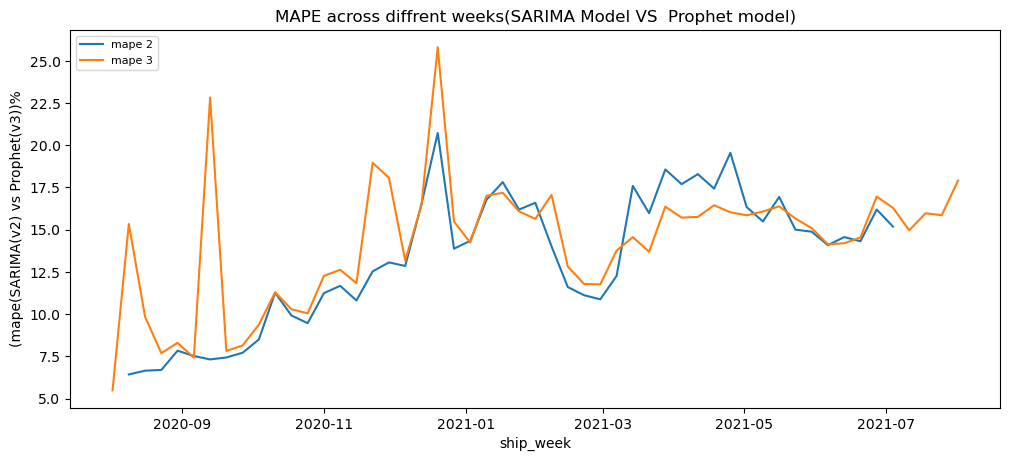

In [148]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v2, label='mape 2')
plt.plot(mape_v3, label='mape 3')
plt.title('MAPE across diffrent weeks(SARIMA Model VS  Prophet model)')
plt.xlabel ('ship_week')
plt.ylabel ('(mape(SARIMA(v2) vs Prophet(v3))%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

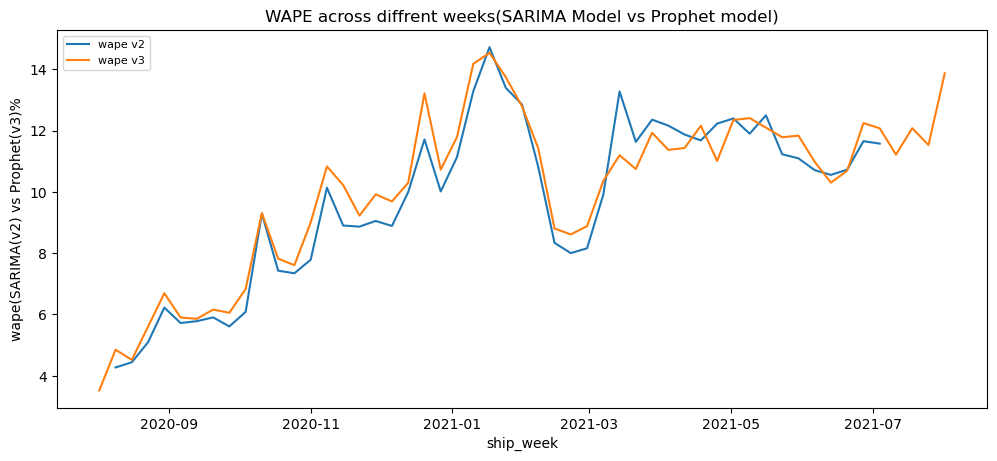

In [149]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v2, label='wape v2')
plt.plot(wape_v3, label='wape v3')
#plt.plot(mape_v2, label='mape v2')
plt.title('WAPE across diffrent weeks(SARIMA Model vs Prophet model)')
plt.xlabel ('ship_week')
plt.ylabel ('wape(SARIMA(v2) vs Prophet(v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## V0 

In [150]:
mod_v0_rst = mod_df.reset_index()

In [151]:
mask_v0 = (mod_v0_rst['ship_week'] >= '2019-07-21') & (mod_v0_rst['ship_week'] <= '2020-08-02')
print(mod_v0_rst.loc[mask_v0])

        ship_week zipcode  pkgs
172003 2019-07-21     A0A   822
172004 2019-07-21     A0B   428
172005 2019-07-21     A0C   262
172006 2019-07-21     A0E   455
172007 2019-07-21     A0G   839
...           ...     ...   ...
262782 2020-08-02     X0G    12
262783 2020-08-02     X1A  3099
262784 2020-08-02     Y0A     8
262785 2020-08-02     Y0B    71
262786 2020-08-02     Y1A  3662

[90784 rows x 3 columns]


In [152]:
df_v0_new = mod_v0_rst.loc[mask_v0]
df_v0_new

,ship_week,zipcode,pkgs
172003,2019-07-21,A0A,822
172004,2019-07-21,A0B,428
172005,2019-07-21,A0C,262
172006,2019-07-21,A0E,455
172007,2019-07-21,A0G,839
...,...,...,...
262782,2020-08-02,X0G,12
262783,2020-08-02,X1A,3099
262784,2020-08-02,Y0A,8
262785,2020-08-02,Y0B,71


In [153]:
train_pct = df_v0_new.groupby(['ship_week','zipcode']).sum()/df_v0_new.groupby(['ship_week']).sum()
train_pct 

pkgs
ship_week  zipcode          
2019-07-21 A0A      0.000325
           A0B      0.000169
           A0C      0.000103
           A0E      0.000180
           A0G      0.000331
...                      ...
2020-08-02 X0G      0.000002
           X1A      0.000630
           Y0A      0.000002
           Y0B      0.000014
           Y1A      0.000744

[90784 rows x 1 columns]

In [154]:
train_pct_rst = train_pct.reset_index()
train_pct_rst

,ship_week,zipcode,pkgs
0,2019-07-21,A0A,0.000325
1,2019-07-21,A0B,0.000169
2,2019-07-21,A0C,0.000103
3,2019-07-21,A0E,0.000180
4,2019-07-21,A0G,0.000331
...,...,...,...
90779,2020-08-02,X0G,0.000002
90780,2020-08-02,X1A,0.000630
90781,2020-08-02,Y0A,0.000002
90782,2020-08-02,Y0B,0.000014


In [155]:
train_avg= train_pct.groupby(['zipcode'], sort=False).mean()
train_avg

,pkgs
zipcode,
A0A,0.000365
A0B,0.000186
A0C,0.000100
A0E,0.000196
A0G,0.000348
...,...
X0G,0.000001
X1A,0.000622
Y0A,0.000003


In [156]:
train_avg_rst = train_avg.reset_index()
train_avg_rst

,zipcode,pkgs
0,A0A,0.000365
1,A0B,0.000186
2,A0C,0.000100
3,A0E,0.000196
4,A0G,0.000348
...,...,...
1648,X0G,0.000001
1649,X1A,0.000622
1650,Y0A,0.000003
1651,Y0B,0.000012


In [157]:
#Percentage short form without 100
FSA = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
FSA

pkgs
ship_week  zipcode              
2017-07-16 A0A      3.140960e-04
           A0B      1.673801e-04
           A0C      7.955721e-05
           A0E      1.901107e-04
           A0G      3.192620e-04
...                          ...
2021-08-01 X0G      9.109762e-07
           X1A      5.115131e-04
           Y0A      2.960673e-06
           Y0B      1.070397e-05
           Y1A      7.230874e-04

[348692 rows x 1 columns]

In [158]:
#% volume distribution/week/FSA
pct2 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()
pct2

pkgs
ship_week  zipcode              
2017-07-16 A0A      3.140960e-04
           A0B      1.673801e-04
           A0C      7.955721e-05
           A0E      1.901107e-04
           A0G      3.192620e-04
...                          ...
2021-08-01 X0G      9.109762e-07
           X1A      5.115131e-04
           Y0A      2.960673e-06
           Y0B      1.070397e-05
           Y1A      7.230874e-04

[348692 rows x 1 columns]

In [159]:
pct = pct2.reset_index()
pct.head(10)

,ship_week,zipcode,pkgs
0,2017-07-16,A0A,0.000314
1,2017-07-16,A0B,0.000167
2,2017-07-16,A0C,0.000080
3,2017-07-16,A0E,0.000190
4,2017-07-16,A0G,0.000319
5,2017-07-16,A0H,0.000188
6,2017-07-16,A0J,0.000087
7,2017-07-16,A0K,0.000188
8,2017-07-16,A0L,0.000091
9,2017-07-16,A0M,0.000100


In [160]:
#actual;pkgs_x and v0; pkgs_y
result_metric_train = pd.merge(train_avg_rst, pct, on=["zipcode"])
result_metric_train 

,zipcode,pkgs_x,ship_week,pkgs_y
0,A0A,0.000365,2017-07-16,0.000314
1,A0A,0.000365,2017-07-23,0.000321
2,A0A,0.000365,2017-07-30,0.000360
3,A0A,0.000365,2017-08-06,0.000392
4,A0A,0.000365,2017-08-13,0.000375
...,...,...,...,...
348687,Y1A,0.000778,2021-07-04,0.000642
348688,Y1A,0.000778,2021-07-11,0.000671
348689,Y1A,0.000778,2021-07-18,0.000625
348690,Y1A,0.000778,2021-07-25,0.000625


In [161]:
result_metric_train['APE_V0_new'] = result_metric_train ['pkgs_y'] - result_metric_train ['pkgs_x']

result_metric_train['APE_V0_new']= result_metric_train ['APE_V0_new'].abs()

result_metric_train.head()

,zipcode,pkgs_x,ship_week,pkgs_y,APE_V0_new
0,A0A,0.000365,2017-07-16,0.000314,0.000051
1,A0A,0.000365,2017-07-23,0.000321,0.000044
2,A0A,0.000365,2017-07-30,0.000360,0.000005
3,A0A,0.000365,2017-08-06,0.000392,0.000027
4,A0A,0.000365,2017-08-13,0.000375,0.000010


In [162]:
result_metric_train['APE_V0'] = result_metric_train['APE_V0_new'] / result_metric_train['pkgs_y']
result_metric_train

,zipcode,pkgs_x,ship_week,pkgs_y,APE_V0_new,APE_V0
0,A0A,0.000365,2017-07-16,0.000314,0.000051,0.162624
1,A0A,0.000365,2017-07-23,0.000321,0.000044,0.137518
2,A0A,0.000365,2017-07-30,0.000360,0.000005,0.013316
3,A0A,0.000365,2017-08-06,0.000392,0.000027,0.068981
4,A0A,0.000365,2017-08-13,0.000375,0.000010,0.026038
...,...,...,...,...,...,...
348687,Y1A,0.000778,2021-07-04,0.000642,0.000137,0.212838
348688,Y1A,0.000778,2021-07-11,0.000671,0.000107,0.159318
348689,Y1A,0.000778,2021-07-18,0.000625,0.000154,0.245746
348690,Y1A,0.000778,2021-07-25,0.000625,0.000153,0.245023


In [163]:
#MAPE
mean_train_V0=result_metric_train.groupby(['ship_week'])[['APE_V0']].mean()*100
mean_train_V0

,APE_V0
ship_week,
2017-07-16,19.901686
2017-07-23,19.319413
2017-07-30,18.158879
2017-08-06,17.170356
2017-08-13,17.982278
...,...
2021-07-04,19.040831
2021-07-11,18.373318
2021-07-18,18.266085


In [164]:
mape_v0_upd = mean_train_V0[mean_train_V0.index >='2020-08-02']
mape_v0_upd

,APE_V0
ship_week,
2020-08-02,15.673194
2020-08-09,13.536697
2020-08-16,13.612415
2020-08-23,13.629807
2020-08-30,12.358022
2020-09-06,13.490034
2020-09-13,11.524567
2020-09-20,11.347076
2020-09-27,11.468677


In [187]:
mape_v0_upd_rst = mape_v0_upd.reset_index()

In [188]:
peak_mape_v0 = mape_v0_upd_rst[(mape_v0_upd_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
peak_mape_v0

APE_V0    22.315244
dtype: float64

In [189]:
non_peak_mape_v0 = mape_v0_upd_rst[~(mape_v0_upd_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
non_peak_mape_v0

APE_V0    18.378325
dtype: float64

In [165]:
def my_agg(y):
    names = {'weighted_train_V0': (y['pkgs_y'] * y['APE_V0']).sum()/y['pkgs_y'].sum()}
    return pd.Series(names, index=['weighted_train_V0'])

In [166]:
wape_V0_new = result_metric_train.groupby(["ship_week"]).apply(my_agg)*100
wape_V0_new

,weighted_train_V0
ship_week,
2017-07-16,15.661409
2017-07-23,15.089434
2017-07-30,14.688562
2017-08-06,14.101655
2017-08-13,14.469874
...,...
2021-07-04,12.060846
2021-07-11,12.170025
2021-07-18,12.202239


In [167]:
wape_v0_upd = wape_V0_new[wape_V0_new.index >='2020-08-02']
wape_v0_upd

,weighted_train_V0
ship_week,
2020-08-02,8.709252
2020-08-09,7.590418
2020-08-16,8.030917
2020-08-23,7.589356
2020-08-30,7.583852
2020-09-06,8.365677
2020-09-13,6.852459
2020-09-20,7.023304
2020-09-27,6.832416


In [184]:
wape_v0_upd_rst = wape_v0_upd.reset_index()
# wape_v0_upd_rst

In [185]:
peak_wape_v0 = wape_v0_upd_rst[(wape_v0_upd_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
peak_wape_v0

weighted_train_V0    13.801971
dtype: float64

In [186]:
peak_wape_v0 = wape_v0_upd_rst[~(wape_v0_upd_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-06', '2020-10-11']))].mean()
peak_wape_v0

weighted_train_V0    12.004383
dtype: float64

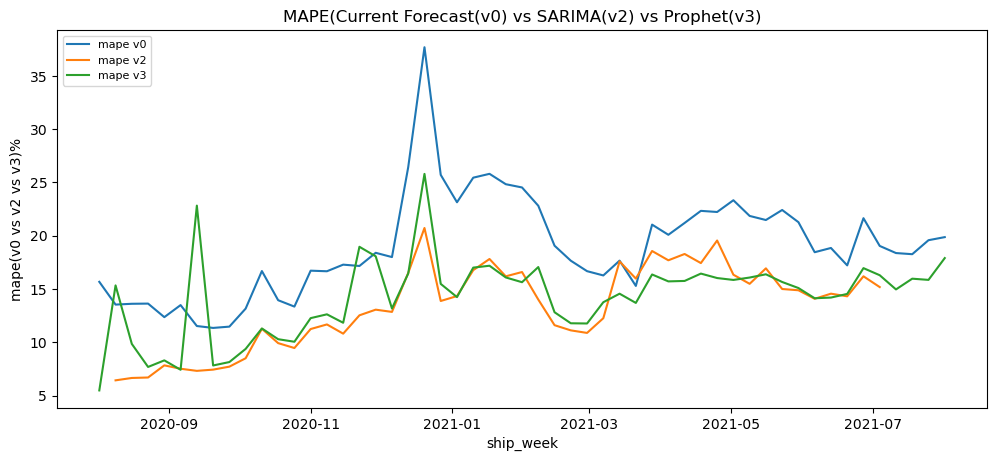

In [168]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mape_v2, label='mape v2')
plt.plot(mape_v3, label='mape v3')
#plt.plot(mape_v0_upd, label='mape v0')
plt.title('MAPE(Current Forecast(v0) vs SARIMA(v2) vs Prophet(v3)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

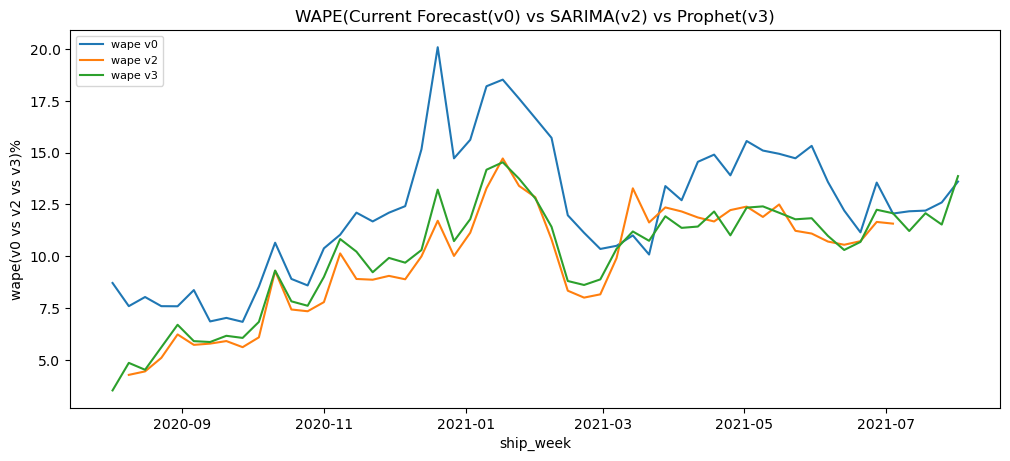

In [169]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_v2, label='wape v2')
plt.plot(wape_v3, label='wape v3')
#plt.plot(wape_v0_upd, label='wape v0')
#plt.title('WAPE across diffrent weeks(v0 vs v2 vs v3)')
plt.title('WAPE(Current Forecast(v0) vs SARIMA(v2) vs Prophet(v3)')
plt.xlabel ('ship_week')
plt.ylabel ('wape(v0 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()


## Baseline Model v1

In [52]:
# define function 
def run_V1_models(df):
    
        zipcode = df[0]
        df = df[1]

    
    #input from the model 
        try:
        
    #df = df.set_index('ship_week')
            train_data = df[-4*212:160]
            test_data = df[-52:]
            fcst_data = df[-3*52:]
    
    
            train_data1 = train_data.iloc[:,1]
            test_data1 = test_data.iloc[:,1]
            fcst = fcst_data.iloc[:,1]
        
         #model fit 
            model = ARIMA(train_data1, order=(1,1,3))
            model_fit = model.fit()
            #print(model_fit)
        
        
         #predict model
            pred_model = model_fit.predict(start=160, end=160+52-1)
            pred_model = pd.DataFrame(pred_model)
            pred_model.columns= ['pred']
            pred_model['zipcode'] = df['zipcode'].unique()[0]
           # print(pred_model)
        
         #forecast model
            fct_model = ARIMA(fcst, order=(1,1,3))  
            fct_fit = fct_model.fit()
           # print(fct_fit)
       
            forecast = fct_fit.predict(start=160, end=160+352-1)
            forecast = pd.DataFrame(forecast) 
            forecast.columns = ['pred']
            forecast['zipcode'] = df['zipcode'].unique()[0]
            #print(forecast)
            
        except:
            print(df['zipcode'].unique()[0])
            pred_model = np.full(len(test_data1), np.nan)
            pred_model = pd.DataFrame(pred_model)
            pred_model.columns= ['pred']
            pred_model['zipcode'] = df['zipcode'].unique()[0]
            forecast = np.full(len(fcst), np.nan)
            forecast = pd.DataFrame(forecast) 
            forecast.columns = ['pred']
            forecast['zipcode'] = df['zipcode'].unique()[0]
    
        return pred_model, forecast
            
            

In [53]:
p = mp.Pool(mp.cpu_count())

In [54]:
results_v1 = p.map(run_V1_models, mod_df.groupby('zipcode'))

In [55]:
predictions=[]
forecasts=[]

for res in results_v1:
    
    pred_model = res[0]
    forecast = res[1]
    
    predictions.append(pred_model)
    forecasts.append(forecast)

In [56]:
df_pred = pd.DataFrame(columns=['index', 'pred', 'zipcode'])
df_pred
for i in range(len(predictions)):
    df_pred = df_pred.append([predictions[i].reset_index()])    
    

In [57]:
df_pred

,index,pred,zipcode
0,2020-08-09 00:00:00,1586.353295,A0A
1,2020-08-16 00:00:00,1586.854778,A0A
2,2020-08-23 00:00:00,1604.316095,A0A
3,2020-08-30 00:00:00,1614.442753,A0A
4,2020-09-06 00:00:00,1620.315689,A0A
...,...,...,...
47,2021-07-04 00:00:00,3458.114618,Y1A
48,2021-07-11 00:00:00,3458.114618,Y1A
49,2021-07-18 00:00:00,3458.114618,Y1A
50,2021-07-25 00:00:00,3458.114618,Y1A


In [58]:
df_pred.to_csv('df_pred_V1.csv')

In [65]:
df_pred = pd.read_csv(r'mod_data/df_pred_V1.csv')
print(df_pred)

       Unnamed: 0                index         pred zipcode
0               0  2020-08-09 00:00:00  1586.353295     A0A
1               1  2020-08-16 00:00:00  1586.854778     A0A
2               2  2020-08-23 00:00:00  1604.316095     A0A
3               3  2020-08-30 00:00:00  1614.442753     A0A
4               4  2020-09-06 00:00:00  1620.315689     A0A
...           ...                  ...          ...     ...
85951          47  2021-07-04 00:00:00  3458.114618     Y1A
85952          48  2021-07-11 00:00:00  3458.114618     Y1A
85953          49  2021-07-18 00:00:00  3458.114618     Y1A
85954          50  2021-07-25 00:00:00  3458.114618     Y1A
85955          51  2021-08-01 00:00:00  3458.114618     Y1A

[85956 rows x 4 columns]


In [66]:
df_pred_V1 = df_pred.drop(df_pred.columns[0], axis = 1) 
df_pred_V1

,index,pred,zipcode
0,2020-08-09 00:00:00,1586.353295,A0A
1,2020-08-16 00:00:00,1586.854778,A0A
2,2020-08-23 00:00:00,1604.316095,A0A
3,2020-08-30 00:00:00,1614.442753,A0A
4,2020-09-06 00:00:00,1620.315689,A0A
...,...,...,...
85951,2021-07-04 00:00:00,3458.114618,Y1A
85952,2021-07-11 00:00:00,3458.114618,Y1A
85953,2021-07-18 00:00:00,3458.114618,Y1A
85954,2021-07-25 00:00:00,3458.114618,Y1A


In [67]:
df_pred_V1['index'] = pd.to_datetime(df_pred_V1['index'], errors='coerce')
df_pred_V1

,index,pred,zipcode
0,2020-08-09,1586.353295,A0A
1,2020-08-16,1586.854778,A0A
2,2020-08-23,1604.316095,A0A
3,2020-08-30,1614.442753,A0A
4,2020-09-06,1620.315689,A0A
...,...,...,...
85951,2021-07-04,3458.114618,Y1A
85952,2021-07-11,3458.114618,Y1A
85953,2021-07-18,3458.114618,Y1A
85954,2021-07-25,3458.114618,Y1A


In [68]:
df_pred_V1.rename({'index': 'ship_week'}, axis=1, inplace=True)
df_pred_V1

,ship_week,pred,zipcode
0,2020-08-09,1586.353295,A0A
1,2020-08-16,1586.854778,A0A
2,2020-08-23,1604.316095,A0A
3,2020-08-30,1614.442753,A0A
4,2020-09-06,1620.315689,A0A
...,...,...,...
85951,2021-07-04,3458.114618,Y1A
85952,2021-07-11,3458.114618,Y1A
85953,2021-07-18,3458.114618,Y1A
85954,2021-07-25,3458.114618,Y1A


In [69]:
df_pred_index = df_pred_V1.set_index('ship_week')
df_pred_index

,pred,zipcode
ship_week,,
2020-08-09,1586.353295,A0A
2020-08-16,1586.854778,A0A
2020-08-23,1604.316095,A0A
2020-08-30,1614.442753,A0A
2020-09-06,1620.315689,A0A
...,...,...
2021-07-04,3458.114618,Y1A
2021-07-11,3458.114618,Y1A
2021-07-18,3458.114618,Y1A


In [70]:
mod_reset = mod_df.reset_index()
mod_reset

,ship_week,zipcode,pkgs
0,2017-07-16,A0A,304
1,2017-07-16,A0B,162
2,2017-07-16,A0C,77
3,2017-07-16,A0E,184
4,2017-07-16,A0G,309
...,...,...,...
348687,2021-08-01,X0G,4
348688,2021-08-01,X1A,2246
348689,2021-08-01,Y0A,13
348690,2021-08-01,Y0B,47


In [67]:
# pct_data2 = pct2.reset_index()
# pct_data2.head(10)

In [71]:
pct

,ship_week,zipcode,pkgs
0,2017-07-16,A0A,3.140960e-04
1,2017-07-16,A0B,1.673801e-04
2,2017-07-16,A0C,7.955721e-05
3,2017-07-16,A0E,1.901107e-04
4,2017-07-16,A0G,3.192620e-04
...,...,...,...
348687,2021-08-01,X0G,9.109762e-07
348688,2021-08-01,X1A,5.115131e-04
348689,2021-08-01,Y0A,2.960673e-06
348690,2021-08-01,Y0B,1.070397e-05


In [72]:
prop = df_pred_index.groupby(['ship_week','zipcode']).sum()/df_pred_index.groupby(['ship_week']).sum()
prop

pred
ship_week  zipcode          
2020-08-09 A0A      0.000323
           A0B      0.000158
           A0C      0.000089
           A0E      0.000148
           A0G      0.000338
...                      ...
2023-08-20 R5P      0.216258
           R5R      0.516786
           R5T      0.266955
2023-08-27 R5P      0.295014
           R5R      0.704986

[85176 rows x 1 columns]

In [73]:
prop_rst = prop.reset_index()
prop_rst

,ship_week,zipcode,pred
0,2020-08-09,A0A,0.000323
1,2020-08-09,A0B,0.000158
2,2020-08-09,A0C,0.000089
3,2020-08-09,A0E,0.000148
4,2020-08-09,A0G,0.000338
...,...,...,...
85171,2023-08-20,R5P,0.216258
85172,2023-08-20,R5R,0.516786
85173,2023-08-20,R5T,0.266955
85174,2023-08-27,R5P,0.295014


In [74]:
mask = (prop_rst['ship_week'] >= '2020-07-04') & (prop_rst['ship_week'] <= '2021-07-04')
print(prop_rst.loc[mask])

       ship_week zipcode      pred
0     2020-08-09     A0A  0.000323
1     2020-08-09     A0B  0.000158
2     2020-08-09     A0C  0.000089
3     2020-08-09     A0E  0.000148
4     2020-08-09     A0G  0.000338
...          ...     ...       ...
78187 2021-07-04     X0E  0.000052
78188 2021-07-04     X1A  0.000610
78189 2021-07-04     Y0A  0.000003
78190 2021-07-04     Y0B  0.000012
78191 2021-07-04     Y1A  0.000711

[78192 rows x 3 columns]


In [75]:
df_mask = (prop_rst.loc[mask])
df_mask

,ship_week,zipcode,pred
0,2020-08-09,A0A,0.000323
1,2020-08-09,A0B,0.000158
2,2020-08-09,A0C,0.000089
3,2020-08-09,A0E,0.000148
4,2020-08-09,A0G,0.000338
...,...,...,...
78187,2021-07-04,X0E,0.000052
78188,2021-07-04,X1A,0.000610
78189,2021-07-04,Y0A,0.000003
78190,2021-07-04,Y0B,0.000012


In [76]:
result_metric_prop = pd.merge(df_mask, pct, on=["ship_week", "zipcode"])
result_metric_prop

,ship_week,zipcode,pred,pkgs
0,2020-08-09,A0A,0.000323,0.000333
1,2020-08-09,A0B,0.000158,0.000164
2,2020-08-09,A0C,0.000089,0.000090
3,2020-08-09,A0E,0.000148,0.000152
4,2020-08-09,A0G,0.000338,0.000325
...,...,...,...,...
78187,2021-07-04,X0E,0.000052,0.000066
78188,2021-07-04,X1A,0.000610,0.000517
78189,2021-07-04,Y0A,0.000003,0.000002
78190,2021-07-04,Y0B,0.000012,0.000008


In [77]:
#take the difference
result_metric_prop['diff_mix'] = result_metric_prop['pkgs'] - result_metric_prop['pred']

result_metric_prop['diff_mix']= result_metric_prop['diff_mix'].abs()

result_metric_prop

,ship_week,zipcode,pred,pkgs,diff_mix
0,2020-08-09,A0A,0.000323,0.000333,0.000010
1,2020-08-09,A0B,0.000158,0.000164,0.000006
2,2020-08-09,A0C,0.000089,0.000090,0.000001
3,2020-08-09,A0E,0.000148,0.000152,0.000004
4,2020-08-09,A0G,0.000338,0.000325,0.000013
...,...,...,...,...,...
78187,2021-07-04,X0E,0.000052,0.000066,0.000014
78188,2021-07-04,X1A,0.000610,0.000517,0.000093
78189,2021-07-04,Y0A,0.000003,0.000002,0.000001
78190,2021-07-04,Y0B,0.000012,0.000008,0.000004


In [78]:
result_metric_prop['APE'] = result_metric_prop['diff_mix'] / result_metric_prop['pkgs']
result_metric_prop

,ship_week,zipcode,pred,pkgs,diff_mix,APE
0,2020-08-09,A0A,0.000323,0.000333,0.000010,0.028966
1,2020-08-09,A0B,0.000158,0.000164,0.000006,0.038320
2,2020-08-09,A0C,0.000089,0.000090,0.000001,0.011173
3,2020-08-09,A0E,0.000148,0.000152,0.000004,0.026689
4,2020-08-09,A0G,0.000338,0.000325,0.000013,0.041282
...,...,...,...,...,...,...
78187,2021-07-04,X0E,0.000052,0.000066,0.000014,0.214734
78188,2021-07-04,X1A,0.000610,0.000517,0.000093,0.180921
78189,2021-07-04,Y0A,0.000003,0.000002,0.000001,0.704254
78190,2021-07-04,Y0B,0.000012,0.000008,0.000004,0.527726


In [79]:
#MAPE
mean_result_prop= result_metric_prop.groupby(['ship_week'])[['APE']].mean()*100
mean_result_prop

,APE
ship_week,
2020-08-09,6.201896
2020-08-16,5.561120
2020-08-23,6.304936
2020-08-30,7.509349
2020-09-06,7.043136
2020-09-13,6.902322
2020-09-20,7.006445
2020-09-27,7.263630
2020-10-04,7.404771


In [80]:
mape_pp_v1 = mean_result_prop.reset_index()
mape_pp_v1.head()

,ship_week,APE
0,2020-08-09,6.201896
1,2020-08-16,5.561120
2,2020-08-23,6.304936
3,2020-08-30,7.509349
4,2020-09-06,7.043136


In [81]:
peak_mape_v1 = mape_pp_v1[(mape_pp_v1['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
peak_mape_v1

APE    15.947448
dtype: float64

In [82]:
peak_mape_v1 = mape_pp_v1[~(mape_pp_v1['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
peak_mape_v1

APE    11.010935
dtype: float64

In [83]:
def my_agg(x):
    names = {'weighted_avg_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_avg_mix'])

In [84]:
wape_V1 = result_metric_prop.groupby(["ship_week"]).apply(my_agg)*100
wape_V1

,weighted_avg_mix
ship_week,
2020-08-09,4.325195
2020-08-16,3.786706
2020-08-23,4.777785
2020-08-30,6.489141
2020-09-06,5.845602
2020-09-13,5.815449
2020-09-20,5.738511
2020-09-27,5.532858
2020-10-04,5.430859


In [85]:
wape_V1_rst = wape_V1.reset_index()

In [86]:
peak_wape_v1 = wape_V1_rst [(wape_V1_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
peak_wape_v1

weighted_avg_mix    11.889007
dtype: float64

In [87]:
peak_wape_v1 = wape_V1_rst [~(wape_V1_rst['ship_week'].isin(['2020-11-22','2020-11-29','2020-12-06', 
                                            '2020-12-13', '2020-12-20', 
                                                            '2020-12-27', '2021-06-07', '2020-10-11']))].mean()
peak_wape_v1

weighted_avg_mix    9.251692
dtype: float64

In [89]:
first_20_weeks_v1 = wape_V1_rst [(wape_V1_rst['ship_week']<=list(wape_V1_rst.sort_values('ship_week')['ship_week'].unique())[19])].mean()
first_20_weeks_v1

weighted_avg_mix    8.233903
dtype: float64

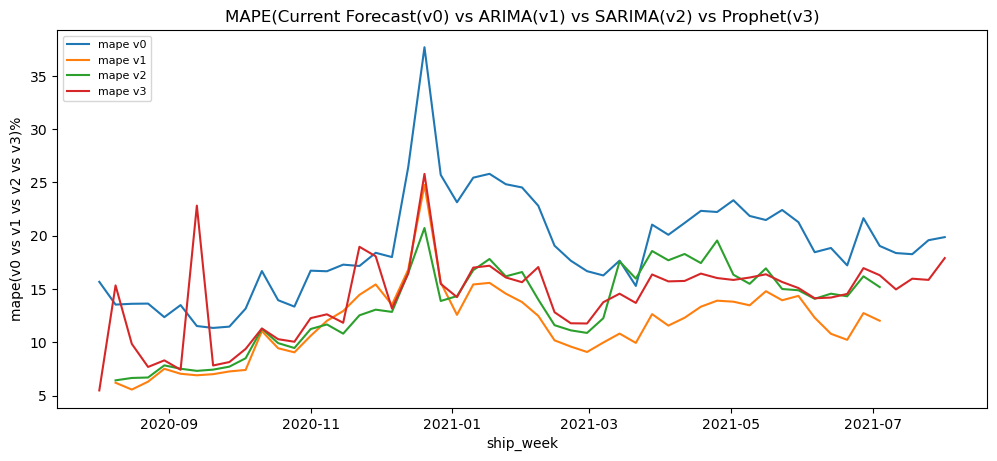

In [170]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mean_result_prop, label='mape v1')
plt.plot(mape_v2, label='mape v2')
plt.plot(mape_v3, label='mape v3')
#plt.plot(mape_v0_upd, label='mape v0')
plt.title('MAPE(Current Forecast(v0) vs ARIMA(v1) vs SARIMA(v2) vs Prophet(v3)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v1 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

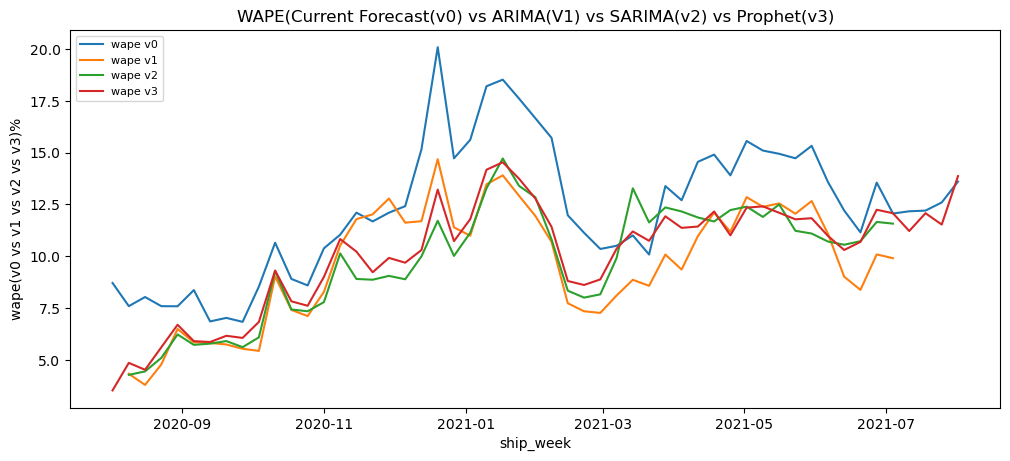

In [171]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_V1, label='wape v1')
plt.plot(wape_v2, label='wape v2')
plt.plot(wape_v3, label='wape v3')
#plt.plot(wape_v0_upd, label='wape v0')
#plt.title('WAPE across diffrent weeks(v0 vs v2 vs v3)')
plt.title('WAPE(Current Forecast(v0) vs ARIMA(V1) vs SARIMA(v2) vs Prophet(v3)')
plt.xlabel ('ship_week')
plt.ylabel ('wape(v0 vs v1 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()